In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import IntProgress
from IPython.display import display

# Append base directory
import os,sys,inspect
rootname = "pub-2020-exploratory-analysis"
# thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
thispath = os.getcwd()
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

from mesostat.utils.qt_helper import gui_fnames, gui_fpath
from mesostat.metric.metric import MetricCalculator
from mesostat.utils.hdf5_io import DataStorage

from lib.sych.data_fc_db_raw import DataFCDatabase
import lib.analysis.coactivity as coactivity
from lib.common.visualization import merge_image_sequence_movie

%load_ext autoreload
%autoreload 2

Appended root directory /home/alyosha/work/git/pub-2020-exploratory-analysis


In [2]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
# params['root_path_data'] = './'
params['root_path_data'] = '/media/alyosha/Data/TE_data/yarodata/sych_preprocessed'
# params['root_path_data'] = '/media/aleksejs/DataHDD/work/data/yaro/neuronal-raw-pooled'
# params['root_path_data'] = gui_fpath('h5path', './')

In [3]:
dataDB = DataFCDatabase(params)

Searching for data files
Extracting trial type names
Extracting data types
Reading area color map


In [4]:
ds = DataStorage('sych_result_activity.h5')

In [5]:
mc = MetricCalculator(serial=True, verbose=False)

In [6]:
print(dataDB.mice)
print(dataDB.dataTypes)
print(dataDB.trialTypeNames)

{'mvg_7', 'mvg_4', 'mvg_8', 'mvg_9'}
{'bn_session', 'raw', 'bn_trial'}
{'iFA', 'iNOGO', 'iGO', 'iMISS'}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


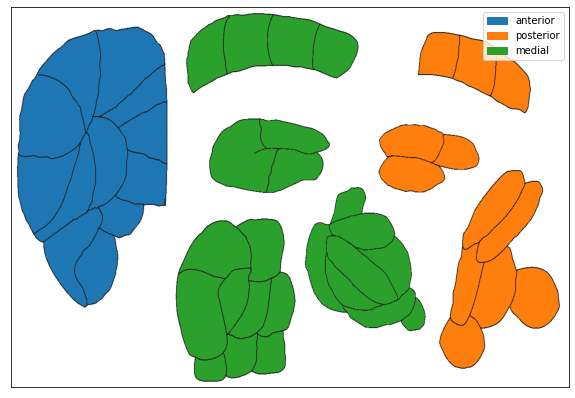

In [7]:
fig, ax = plt.subplots(figsize=(10, 7))
areaDict = {
    'anterior' : np.arange(12),
    'posterior' : np.arange(12, 24),
    'medial' : np.arange(24, 48),
}

dataDB.plot_area_clusters(fig, ax, areaDict, haveLegend=True)

# 1. Significance

## 1.1. Correlation plots


In [8]:
argSweepDict = {
    'datatype':  ['bn_trial', 'bn_session'],
    'trialType': ['None', 'iGO', 'iNOGO', 'iMISS', 'iFA'],
    'intervName': 'auto',
    'performance': 'auto'
}

argSweepDictSubpre = {
    'trialType': ['None', 'iGO', 'iNOGO', 'iMISS', 'iFA'],
    'intervName': 'auto',
    'performance': 'auto'
}

exclQueryLst = []

In [9]:
coactivity.plot_corr_mouse(dataDB, mc, 'corr', 'intervName', nDropPCA=None, dropChannels=[21],
                           haveBrain=True, haveMono=False, exclQueryLst=exclQueryLst, **argSweepDict)

expert_bn_session_None


/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6802615854669474 0.17943311302140352 : ['M1_l' 'AI' 'Pir' 'LO' 'AOD' 'M2' 'Sub']
2 : 0.718236883655986 0.19111459266318243 : ['AOL' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'InWh' 'LPAG' 'S1_bf_1' 'LaDL']
3 : 0.6064549795589691 0.1518664419833513 : ['CA1_Mol' 'DG_p' 'BIC' 'LDVL' 'DG_a']
4 : 0.5360013990015788 0.15568522113018668 : ['V1_m' 'SubB' 'RSG' 'SuG']
5 : nan nan : ['S1_bf']
6 : nan nan : ['Cpu']
7 : nan nan : ['BLA']
8 : 0.7276148505993295 0.21272672537187687 : ['S' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL'
 'M2_1']
9 : nan nan : ['dCA1']
10 : 0.5384754948363617 0.3033286312278215 : ['BMA' 'S2' 'Cpu_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.5797213274441968 0.17759899778102967 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'LPAG' 'BLA' 'Sub']
2 : 0.655745626779263 0.1891005260773564 : ['VO' 'Cg1' 'PrL' 'MO' 'InWh' 'S1_bf' 'S1_bf_1' 'LaDL']
3 : 0.5371486293374704 0.19124115578519135 : ['DG_p' 'BIC' 'LDVL' 'DG_a']
4 : nan nan : ['SubB']
5 : 0.5484424271543985 0.22122978626475237 : ['V1_m' 'RSG' 'SuG']
6 : nan nan : ['Cpu']
7 : nan nan : ['BMA']
8 : 0.6395270488252982 0.1990991299090521 : ['IV2' 'S' 'CA1_Mol' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'LGP' 'eGP' 'GP' 'VPL'
 'Po' 'VL' 'M2_1']
9 : nan nan : ['dCA1']
10 : 0.6418606999190637 0.45546839555899754 : ['S2' 'Cpu_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7959711656564686 0.47716067855665595 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'InWh' 'BLA' 'Sub']
1 : 0.6765787177355592 0.20936747210588474 : ['M1_l' 'AOL' 'VO' 'Cg1' 'PrL' 'MO' 'LPAG' 'S1_bf_1' 'VM' 'LaDL']
2 : 0.6362376961175984 0.2845636603062786 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'DG_a']
3 : 0.5304979832537076 0.22855650952344497 : ['V1_m' 'RSG' 'SuG']
4 : nan nan : ['Cpu']
5 : 0.5825830723754893 0.1675461856484446 : ['Pir' 'S' 'SubB' 'S1_bf' 'Rt' 'VPM' 'CA1_Py' 'LGP' 'Po' 'M2_1']
6 : nan nan : ['dCA1']
7 : 0.7136765972995003 0.5261049515272075 : ['S2' 'Cpu_1']
8 : 0.6637706654554514 0.19636926975950464 : ['BMA' 'iGP' 'eGP' 'GP' 'VPL' 'VL']
9 : nan nan : ['LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7837529696513647 0.23528404953205495 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.7105946362854388 0.1337631592594113 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'iGP' 'Sub']
2 : 0.7546501983019359 0.18210619818747908 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : 0.7625940814858985 0.26226603521115976 : ['V1_m' 'RSG']
4 : nan nan : ['SuG']
5 : nan nan : ['S1_bf_1']
6 : nan nan : ['VPM']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : 0.8507477442463118 0.2377052537528811 : ['Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL' 'LDVL']
10 : nan nan : ['GP']
11 : 0.6435057942887915 0.12960849414962206 : ['InWh' 'LPAG' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7009373262562989 0.2381582106529656 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.6771805312730541 0.1757453931492886 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Sub']
2 : 0.7211295846800551 0.243380848167021 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : 0.7267367037925733 0.2795006204044426 : ['V1_m' 'RSG' 'iGP']
4 : nan nan : ['SuG']
5 : 0.5133093346709787 0.14470712461000979 : ['VPM' 'CA1_Py']
6 : 0.7703507492794203 0.2558653859003919 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL'
 'LDVL']
7 : nan nan : ['GP']
8 : 0.5681061059890811 0.1947456136070967 : ['InWh' 'LPAG' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7678301626238596 0.2896814418299576 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.6480250455146517 0.14102515945576533 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'V1_m' 'RSG' 'iGP']
2 : 0.7536415262305035 0.22726618827931422 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : nan nan : ['InWh']
4 : nan nan : ['SuG']
5 : nan nan : ['S1_bf_1']
6 : nan nan : ['VM']
7 : nan nan : ['dCA1']
8 : 0.8448289951410652 0.28197247962858485 : ['S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL'
 'LDVL']
9 : nan nan : ['GP']
10 : 0.6609811425846277 0.1473550474842259 : ['Cg1' 'MO' 'LPAG' 'VPM' 'CA1_Py' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8289555485856 0.1723848296195145 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO']
1 : nan nan : ['LO']
2 : nan nan : ['M2']
3 : nan nan : ['Cg1']
4 : nan nan : ['PrL']
5 : nan nan : ['BIC']
6 : 0.7593135986540475 0.15953476824914614 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'SubB' 'RSG' 'InWh' 'SuG' 'S1_bf' 'Cpu'
 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'eGP' 'GP' 'VPL' 'LDVL']
7 : nan nan : ['S1_bf_1']
8 : nan nan : ['CA1_Py']
9 : nan nan : ['VM']
10 : nan nan : ['LGP']
11 : 0.739040749890435 0.10766578110640745 : ['MO' 'LPAG' 'VPM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7493947406759417 0.16410184307540898 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO' 'V1_m' 'iGP']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['BIC']
5 : nan nan : ['SubB']
6 : 0.7094801219938259 0.1280708493088355 : ['MO' 'RSG' 'SuG' 'LPAG']
7 : 0.7514823648307151 0.22753902864274234 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'InWh' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1'
 'BMA' 'Rt' 'VPM' 'CA1_Py' 'Sub' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP'
 'VPL' 'M2_1' 'DG_a']
8 : nan nan : ['VM']
9 : 0.7459746207375259 0.21593880090293116 : ['dCA1' 'LDVL' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7704304424145726 0.2389271470694082 : ['M1_l' 'AI' 'Pir' 'AOL']
1 : 0.6251790464832251 0.3799827379006543 : ['M2' 'Cg1' 'PrL' 'BIC' 'VM']
2 : nan nan : ['CA1_Py']
3 : 0.7275520330611432 0.21557029582127107 : ['M1_m' 'AOD' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Cpu' 'S1_bf_1' 'Rt' 'S2'
 'LaDL' 'eGP']
4 : nan nan : ['LGP']
5 : 0.6240510069185039 0.15170536978771304 : ['IV2' 'V1_m' 'SubB' 'RSG' 'LPAG' 'BLA' 'BMA' 'iGP' 'Cpu_1' 'GP' 'VPL'
 'LDVL']
6 : 0.6829334305230652 0.27672429297778794 : ['InWh' 'SuG' 'Po' 'VL' 'M2_1']
7 : 0.6421605402351017 0.124235157823672 : ['LO' 'VO' 'MO' 'VPM' 'dCA1' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.5892038530068007 0.21238376303755147 : ['M1_l' 'Pir' 'LO' 'Sub']
2 : 0.6693794856456563 0.15937913680390603 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'RSG']
3 : nan nan : ['DG_p']
4 : nan nan : ['S1_bf']
5 : 0.6379455678597877 0.12624914554159727 : ['AI' 'IV2' 'S' 'CA1_Mol' 'Cpu' 'BLA' 'S2' 'Cpu_1']
6 : 0.7525536091011565 0.27861016239019987 : ['V1_m' 'BIC' 'SubB' 'InWh' 'SuG' 'LPAG' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM'
 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
7 : nan nan : ['eGP']
8 : nan nan : ['Po']
9 : nan nan : ['M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6665296172568645 0.29076672277560933 : ['M1_l' 'Pir' 'LO']
2 : 0.6730771552587699 0.2047007532379388 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
3 : nan nan : ['SuG']
4 : 0.5759270947144903 0.10453046170655095 : ['AI' 'IV2' 'S' 'CA1_Mol' 'S1_bf' 'Cpu' 'BLA' 'S2' 'Cpu_1']
5 : 0.6792650721988038 0.23281459208099914 : ['DG_p' 'V1_m' 'BIC' 'SubB' 'RSG' 'InWh' 'LPAG' 'S1_bf_1' 'BMA' 'Rt' 'iGP'
 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL'
 'DG_a']
6 : nan nan : ['eGP']
7 : nan nan : ['Po']
8 : nan nan : ['M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.5959202760005452 0.21284511093004133 : ['M1_l' 'Pir' 'LO']
1 : 0.6437691372524196 0.1654249134384259 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.5758923340896275 0.08187746451999861 : ['IV2' 'S' 'S1_bf' 'BLA' 'S2' 'Cpu_1']
3 : 0.7665381703323416 0.2513669934075051 : ['AI' 'M1_m' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'LPAG' 'Cpu' 'S1_bf_1' 'BMA'
 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
4 : 0.597622062010573 0.07358756535678135 : ['V1_m' 'RSG' 'InWh' 'SuG' 'VPM' 'CA1_Py' 'dCA1' 'Sub' 'GP' 'M2_1']
5 : nan nan : ['eGP']
6 : nan nan : ['Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


expert_bn_session_iFA


/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.607550237382425 0.15132279075593486 : ['M1_l' 'Pir' 'S1_bf']
1 : 0.6454595157301154 0.2742102468318344 : ['AI' 'M1_m' 'AOD' 'Sub']
2 : 0.6852648054166018 0.20016236375008084 : ['LO' 'AOL' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'InWh' 'LPAG' 'S1_bf_1' 'VM' 'LaDL']
3 : 0.6432265651924067 0.3560303901583173 : ['V1_m' 'RSG']
4 : 0.6041181732287403 0.18605222188860276 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'LDVL' 'DG_a']
5 : nan nan : ['SubB']
6 : nan nan : ['SuG']
7 : nan nan : ['Cpu']
8 : nan nan : ['BLA']
9 : nan nan : ['dCA1']
10 : nan nan : ['S2']
11 : 0.6458124021607946 0.18633038432525223 : ['S' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'Po'
 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.670479514608664 0.21593970585148914 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'InWh' 'Sub']
2 : 0.6562954405766452 0.17766871167337128 : ['VO' 'Cg1' 'PrL' 'MO' 'S' 'LPAG' 'S1_bf' 'S1_bf_1' 'VPM' 'VM' 'LaDL']
3 : 0.5604043775198082 0.3270227826825859 : ['V1_m' 'RSG']
4 : 0.5575742053177168 0.17652759085676412 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'LDVL' 'DG_a']
5 : nan nan : ['SubB']
6 : nan nan : ['SuG']
7 : nan nan : ['Cpu']
8 : nan nan : ['BLA']
9 : nan nan : ['BMA']
10 : nan nan : ['dCA1']
11 : 0.6680668758499427 0.4391466321056554 : ['S2' 'Cpu_1']
12 : 0.7316740805031756 0.24308060447236518 : ['Rt' 'iGP' 'CA1_Py' 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.552507234170624 0.3508534418103685 : ['M1_l' 'AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'BLA' 'Sub']
1 : 0.5538884760759903 0.20331078767467736 : ['Cg1' 'PrL' 'InWh' 'LPAG' 'S1_bf' 'Cpu' 'S1_bf_1' 'VM' 'LaDL']
2 : 0.5290834734900397 0.24273390018857005 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'LDVL' 'DG_a']
3 : 0.37939872853683493 0.18087279315755497 : ['V1_m' 'SubB' 'RSG' 'SuG']
4 : 0.5498131013974173 0.2083006459009218 : ['Pir' 'VO' 'MO' 'S' 'Rt' 'VPM' 'CA1_Py' 'LGP' 'eGP' 'Po' 'M2_1']
5 : nan nan : ['dCA1']
6 : 0.7521861075536731 0.6486058617326907 : ['S2' 'Cpu_1']
7 : 0.5603589733573586 0.21474083489168205 : ['BMA' 'iGP' 'GP' 'VPL' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7693015160111778 0.1995987239635244 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.6829586014651648 0.16899176535981453 : ['Cg1' 'MO']
2 : 0.7682674580132185 0.1916104896999543 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : 0.7039972147745384 0.2215458732911314 : ['V1_m' 'RSG']
4 : nan nan : ['SuG']
5 : nan nan : ['S1_bf_1']
6 : nan nan : ['VPM']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : 0.8078738899197164 0.20836268411811643 : ['Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'Sub' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL'
 'LDVL']
10 : nan nan : ['GP']
11 : 0.6335538737798645 0.12180741998937494 : ['InWh' 'LPAG' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7335977917133863 0.24680211550172204 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.6763080887982431 0.17478559563570206 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Sub']
2 : 0.7987493444081539 0.2933922941200934 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf']
3 : nan nan : ['SubB']
4 : 0.691854179195936 0.2610801156247596 : ['V1_m' 'RSG' 'iGP']
5 : 0.4553753598753058 0.09577543561631191 : ['SuG' 'VPM' 'CA1_Py']
6 : 0.769805911365763 0.2592145704117568 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL'
 'LDVL']
7 : nan nan : ['GP']
8 : 0.552261900405015 0.19701394748722872 : ['InWh' 'LPAG' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6950218944178529 0.3880189606312429 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.5978032957681696 0.21269190015862538 : ['AOL' 'AOD' 'M2' 'VO' 'PrL' 'MO']
2 : 0.6559565763950526 0.24701387094172128 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : 0.7024361504308098 0.3166250684692307 : ['V1_m' 'RSG' 'iGP']
4 : 0.687599995378026 0.25607410380857715 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'CA1_Py' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL' 'LDVL']
5 : nan nan : ['GP']
6 : 0.4813744153679743 0.1548143031744293 : ['Cg1' 'InWh' 'SuG' 'LPAG' 'VPM' 'VM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8299198232251042 0.19535919873817587 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'VO']
1 : nan nan : ['LO']
2 : nan nan : ['M2']
3 : nan nan : ['Cg1']
4 : nan nan : ['PrL']
5 : nan nan : ['BIC']
6 : nan nan : ['InWh']
7 : 0.7137311541365895 0.11381624399933221 : ['IV2' 'V1_m' 'RSG' 'SuG' 'LPAG' 'BLA' 'BMA' 'Rt' 'iGP' 'Sub' 'Cpu_1' 'GP'
 'VPL' 'DG_a']
8 : 0.6874078493735256 0.2592785875662728 : ['VPM' 'VM']
9 : nan nan : ['CA1_Py']
10 : 0.7602040277657469 0.1428376730308596 : ['AOD' 'MO' 'S' 'CA1_Mol' 'DG_p' 'SubB' 'S1_bf' 'Cpu' 'S1_bf_1' 'S2'
 'LaDL' 'eGP']
11 : nan nan : ['LGP']
12 : 0.8236891301651031 0.20352894605255167 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6966794199089108 0.134349008983503 : ['Pir' 'AOL' 'AOD' 'VO']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['BIC']
5 : 0.6154251271254 0.07378267640637637 : ['MO' 'RSG' 'InWh' 'SuG' 'LPAG' 'CA1_Py']
6 : nan nan : ['VPM']
7 : nan nan : ['VM']
8 : 0.7628249561738879 0.24708008820715766 : ['M1_l' 'AI' 'M1_m' 'LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'SubB' 'S1_bf'
 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'Sub' 'S2' 'LaDL' 'Cpu_1' 'LGP'
 'eGP' 'GP' 'VPL' 'DG_a']
9 : 0.7621281195004124 0.19245688832538166 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7414978885510702 0.12823069655943498 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO' 'IV2' 'LGP']
1 : nan nan : ['Cg1']
2 : 0.6716648823758248 0.44429972027965675 : ['M2' 'PrL']
3 : nan nan : ['BIC']
4 : nan nan : ['InWh']
5 : 0.7344909496721932 0.3066930046732252 : ['VPM' 'VM']
6 : nan nan : ['CA1_Py']
7 : 0.7656127827525561 0.14871444165330505 : ['LO' 'MO' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Cpu' 'S1_bf_1' 'Rt' 'S2' 'LaDL'
 'eGP' 'DG_a']
8 : 0.7377507675631054 0.14011484027561816 : ['V1_m' 'SubB' 'RSG' 'SuG' 'LPAG' 'BLA' 'BMA' 'iGP' 'Cpu_1' 'GP' 'VPL']
9 : 0.776927253258754 0.16953448715077257 : ['dCA1' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6050693015937064 0.3070771182578943 : ['M1_l' 'Pir' 'LO']
1 : 0.5814506523839704 0.1589612643242767 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'RSG' 'Cpu_1']
2 : nan nan : ['DG_p']
3 : nan nan : ['S1_bf']
4 : 0.6968300915260581 0.3045514009154227 : ['M1_m' 'V1_m' 'BIC' 'SubB' 'InWh' 'SuG' 'LPAG' 'S1_bf_1' 'BMA' 'Rt' 'iGP'
 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
5 : nan nan : ['Sub']
6 : 0.647129161837926 0.20102693945634492 : ['AI' 'IV2' 'S' 'CA1_Mol' 'Cpu' 'BLA' 'S2']
7 : nan nan : ['eGP']
8 : nan nan : ['Po']
9 : nan nan : ['M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.5842642343767914 0.2423502923522602 : ['M1_l' 'Pir' 'LO']
1 : 0.6234945127848384 0.18079920697125684 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : nan nan : ['SuG']
3 : 0.5514624699655889 0.11025194118216602 : ['AI' 'IV2' 'S' 'CA1_Mol' 'S1_bf' 'Cpu' 'BLA' 'S2' 'Cpu_1']
4 : 0.6967307661070945 0.21975982434984698 : ['M1_m' 'DG_p' 'BIC' 'SubB' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP'
 'VPL' 'LDVL' 'VL' 'DG_a']
5 : 0.6221274121794552 0.13059579680475608 : ['V1_m' 'RSG' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'Sub' 'GP']
6 : nan nan : ['eGP']
7 : nan nan : ['Po']
8 : nan nan : ['M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.5303402749318793 0.15652416595125557 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
1 : 0.4620767161735694 0.06420555481401535 : ['AI' 'M1_m' 'IV2' 'S' 'CA1_Mol' 'SuG' 'Cpu' 'BLA' 'S2' 'Cpu_1']
2 : nan nan : ['S1_bf']
3 : 0.6848687947622604 0.22934292831619657 : ['DG_p' 'BIC' 'SubB' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL'
 'LDVL' 'VL' 'DG_a']
4 : 0.6092897850923202 0.1586597990086695 : ['V1_m' 'RSG' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'Sub' 'GP' 'M2_1']
5 : nan nan : ['eGP']
6 : nan nan : ['Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


expert_bn_session_iGO


/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.655759581986269 0.18850460218766785 : ['M1_l' 'AI' 'Pir' 'LO' 'AOD' 'M2' 'Sub']
2 : 0.6880526647576559 0.19812268035224445 : ['AOL' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'InWh' 'LPAG' 'S1_bf_1' 'LaDL']
3 : 0.5251453727639952 0.11762836304150992 : ['CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'LDVL' 'DG_a']
4 : 0.5205864822748509 0.1801492834766592 : ['V1_m' 'SubB' 'RSG' 'SuG']
5 : nan nan : ['Cpu']
6 : nan nan : ['BLA']
7 : 0.6982814439582256 0.21881351265477733 : ['S' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL'
 'M2_1']
8 : nan nan : ['dCA1']
9 : 0.5248367527152402 0.31609081468078204 : ['BMA' 'S2' 'Cpu_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.5994686097171817 0.19536898389965862 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'Cg1' 'PrL' 'MO' 'IV2' 'InWh'
 'LPAG' 'BLA' 'Sub' 'LaDL']
2 : 0.5391084024725318 0.20262804373455828 : ['DG_p' 'BIC' 'S1_bf' 'DG_a']
3 : nan nan : ['SubB']
4 : 0.46569329346669913 0.15853427254508146 : ['V1_m' 'RSG' 'SuG' 'Cpu']
5 : nan nan : ['BMA']
6 : 0.6208340721763247 0.18725047724656946 : ['VO' 'S' 'CA1_Mol' 'S1_bf_1' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'LGP' 'eGP'
 'GP' 'VPL' 'Po' 'VL' 'M2_1']
7 : nan nan : ['dCA1']
8 : 0.6179765002408649 0.47206021465121856 : ['S2' 'Cpu_1']
9 : nan nan : ['LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.5709862508198673 0.21357892599470546 : ['AI' 'M1_m' 'LO' 'AOD' 'BLA' 'Sub']
1 : 0.8462478473149871 0.4623131915389591 : ['M1_l' 'Pir']
2 : 0.49007115441304044 0.2173669404564476 : ['VO' 'LPAG' 'Cpu']
3 : 0.5978091488410565 0.18554359064278253 : ['AOL' 'M2' 'Cg1' 'PrL' 'MO' 'IV2' 'BIC' 'InWh' 'S1_bf_1' 'LaDL' 'DG_a']
4 : 0.48355938036009105 0.28224115430469543 : ['V1_m' 'RSG' 'SuG']
5 : 0.45872466935216044 0.07747097067243364 : ['S' 'CA1_Mol' 'DG_p' 'SubB' 'S1_bf' 'Rt' 'VPM' 'CA1_Py' 'VM' 'LGP' 'LDVL'
 'Po']
6 : nan nan : ['dCA1']
7 : 0.7021112041275192 0.46694151758482394 : ['S2' 'Cpu_1']
8 : 0.5533372209724048 0.14479260621421924 : ['BMA' 'iGP' 'eGP' 'GP' 'VPL' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7900229048504682 0.25663125260920117 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.6868847949216226 0.13497947262259413 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'V1_m' 'RSG' 'iGP' 'Sub']
2 : 0.8410669323883594 0.24448946241332137 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf']
3 : nan nan : ['SubB']
4 : nan nan : ['SuG']
5 : nan nan : ['S1_bf_1']
6 : nan nan : ['VPM']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : 0.8407347164680179 0.24099138382262375 : ['Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL' 'LDVL']
10 : nan nan : ['GP']
11 : 0.6323258790408804 0.1278387658687813 : ['InWh' 'LPAG' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.759540925503135 0.28228316866078823 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.6327757458204084 0.14192039251739924 : ['LO' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Sub']
2 : 0.7243937443704196 0.24121915125257926 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : 0.7570086353688299 0.30236407808407517 : ['V1_m' 'RSG' 'iGP']
4 : nan nan : ['SuG']
5 : 0.5421008546168615 0.1629877536777376 : ['VPM' 'CA1_Py']
6 : 0.7736567127421865 0.26429475452324447 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL'
 'LDVL']
7 : nan nan : ['GP']
8 : 0.5431796298386674 0.19430115347596777 : ['InWh' 'LPAG' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.712988722482036 0.3496097594381127 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.629552350375671 0.17361734060947875 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'iGP']
2 : 0.7202315143165188 0.2714202716347551 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : 0.7126766279609413 0.3065039461180503 : ['V1_m' 'RSG']
4 : nan nan : ['SuG']
5 : nan nan : ['VM']
6 : 0.6962796371412572 0.2359423730622222 : ['S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'GP' 'VPL' 'LDVL']
7 : 0.5302541061145623 0.14209976395280915 : ['Cg1' 'MO' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8252922971288008 0.1800849103563249 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO']
1 : nan nan : ['LO']
2 : nan nan : ['M2']
3 : nan nan : ['Cg1']
4 : nan nan : ['PrL']
5 : nan nan : ['BIC']
6 : nan nan : ['InWh']
7 : 0.7711934900184964 0.17811271868862877 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'SubB' 'RSG' 'SuG' 'S1_bf' 'Cpu' 'BLA'
 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'eGP' 'GP' 'VPL' 'LDVL']
8 : nan nan : ['S1_bf_1']
9 : nan nan : ['CA1_Py']
10 : nan nan : ['VM']
11 : nan nan : ['LGP']
12 : 0.7448977497008064 0.12387069398160533 : ['MO' 'LPAG' 'VPM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M2']
1 : nan nan : ['Cg1']
2 : nan nan : ['PrL']
3 : nan nan : ['BIC']
4 : nan nan : ['SubB']
5 : 0.6372510197735933 0.09030671734495221 : ['MO' 'RSG' 'SuG' 'LPAG' 'iGP' 'VPM']
6 : 0.744400130349023 0.25157371510293264 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO' 'IV2' 'S' 'CA1_Mol' 'DG_p'
 'V1_m' 'InWh' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2' 'LaDL' 'Cpu_1'
 'LGP' 'eGP' 'GP' 'VPL']
7 : nan nan : ['VM']
8 : 0.719663146630012 0.23331763778280062 : ['dCA1' 'LDVL' 'Po' 'VL']
9 : 0.6701154072223453 0.10506179528246051 : ['LO' 'Rt' 'CA1_Py' 'Sub' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6395170650001076 0.14772898326727868 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO' 'S1_bf_1' 'iGP']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : 0.6026186703864063 0.16840953846347395 : ['S' 'CA1_Mol' 'DG_p' 'SubB' 'InWh']
5 : nan nan : ['BIC']
6 : 0.6867496688198282 0.1770315240849274 : ['LO' 'IV2' 'V1_m' 'RSG' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL'
 'Cpu_1' 'eGP' 'GP' 'VPL']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : nan nan : ['LGP']
10 : 0.6745682943304314 0.18141652019180554 : ['MO' 'SuG' 'LPAG' 'VPM' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.5820209777033291 0.24362181647510167 : ['M1_l' 'Pir' 'LO' 'Sub']
2 : 0.5935421329561167 0.12026894931212612 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'RSG' 'M2_1']
3 : nan nan : ['DG_p']
4 : nan nan : ['S1_bf']
5 : 0.6696166695834666 0.16743737019575233 : ['AI' 'IV2' 'S' 'Cpu' 'BLA' 'S1_bf_1' 'S2' 'Cpu_1']
6 : 0.7213180080636242 0.2757650674126956 : ['CA1_Mol' 'V1_m' 'BIC' 'SubB' 'InWh' 'SuG' 'LPAG' 'BMA' 'Rt' 'iGP' 'VPM'
 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
7 : nan nan : ['eGP']
8 : nan nan : ['Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6554066114849189 0.2972699081211463 : ['M1_l' 'Pir' 'LO']
2 : 0.6538821540375782 0.20366752693399587 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
3 : nan nan : ['SuG']
4 : 0.5566198327483138 0.10319689390525028 : ['AI' 'IV2' 'S' 'CA1_Mol' 'S1_bf' 'Cpu' 'BLA' 'S2' 'Cpu_1']
5 : 0.6755875786604477 0.2486595466920523 : ['DG_p' 'V1_m' 'BIC' 'SubB' 'RSG' 'InWh' 'LPAG' 'S1_bf_1' 'BMA' 'Rt' 'iGP'
 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL'
 'DG_a']
6 : nan nan : ['eGP']
7 : nan nan : ['Po']
8 : nan nan : ['M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.426188423470853 0.14599809465650637 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'CA1_Mol']
2 : nan nan : ['SuG']
3 : 0.49095741503277285 0.14815824036908554 : ['AI' 'IV2' 'S' 'S1_bf' 'Cpu' 'BLA' 'S2' 'LaDL' 'Cpu_1']
4 : 0.6359057810025684 0.25013473759145693 : ['DG_p' 'BIC' 'SubB' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'VPL' 'LDVL' 'VL'
 'DG_a']
5 : 0.4780641228138504 0.1322341340194022 : ['V1_m' 'RSG' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'Sub' 'LGP' 'GP' 'Po'
 'M2_1']
6 : nan nan : ['eGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


expert_bn_session_iMISS


/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7083553949948765 0.4527944769587955 : ['AI' 'M1_m']
1 : 0.716516732458936 0.16836914810990222 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'Cg1' 'S1_bf_1' 'Sub' 'LaDL']
2 : 0.8032345419893362 0.22471203050151567 : ['IV2' 'DG_p' 'BIC' 'DG_a']
3 : 0.6522952870864973 0.203100873008496 : ['V1_m' 'RSG' 'SuG']
4 : nan nan : ['Cpu']
5 : 0.5738232297093707 0.09361916420751709 : ['CA1_Mol' 'SubB' 'S1_bf' 'BLA' 'BMA' 'iGP' 'CA1_Py']
6 : nan nan : ['dCA1']
7 : 0.7346244508664848 0.38921644311256914 : ['S2' 'Cpu_1']
8 : 0.7353099118697157 0.19526503534957884 : ['VO' 'PrL' 'MO' 'S' 'InWh' 'LPAG' 'Rt' 'VPM' 'VM' 'LGP' 'eGP' 'GP' 'VPL'
 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6324190682770899 0.17778465913021496 : ['M1_l' 'AI' 'Pir' 'LO' 'AOD' 'M2' 'S1_bf' 'S1_bf_1']
2 : 0.6701645719384329 0.18857916951763337 : ['AOL' 'VO' 'Cg1' 'PrL' 'MO' 'LPAG' 'LaDL']
3 : 0.6871055333886867 0.36976375933613703 : ['V1_m' 'RSG']
4 : 0.6830013146616999 0.24506661598880258 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'DG_a']
5 : 0.5699456270178245 0.40165238175349105 : ['SubB' 'BMA']
6 : nan nan : ['Cpu']
7 : nan nan : ['BLA']
8 : nan nan : ['dCA1']
9 : 0.6659035473913928 0.4051285090013228 : ['S2' 'Cpu_1']
10 : 0.7247840696940162 0.22540241013353307 : ['Rt' 'iGP' 'CA1_Py' 'VM' 'LGP' 'eGP' 'GP' 'VPL' 'LDVL' 'VL']
11 : 0.6620334649975491 0.1858718301966853 : ['S' 'InWh' 'SuG' 'VPM' 'Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6800005094650325 0.13330908804032027 : ['M1_l' 'AI' 'Pir']
1 : nan nan : ['M1_m']
2 : 0.7636398724767471 0.20427814607825034 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'S1_bf_1' 'LaDL' 'DG_a']
3 : 0.7462077778239773 0.26094430221741693 : ['V1_m' 'RSG']
4 : nan nan : ['Cpu']
5 : nan nan : ['BLA']
6 : 0.5946161720229911 0.12024388700578126 : ['CA1_Mol' 'SubB' 'BMA' 'iGP' 'CA1_Py' 'LDVL']
7 : nan nan : ['dCA1']
8 : 0.7494373204644651 0.3599009660918193 : ['S2' 'Cpu_1']
9 : 0.7678016616055096 0.16748072803073288 : ['LPAG' 'S1_bf' 'Rt' 'VM' 'LGP' 'eGP' 'GP' 'VPL' 'VL']
10 : 0.6711202421971747 0.09677624905817706 : ['IV2' 'S' 'DG_p' 'BIC' 'InWh' 'SuG' 'VPM' 'Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7322098837169416 0.11148706344127246 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO'
 'LPAG' 'Sub']
1 : 0.8655745067383886 0.202738024780872 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf']
2 : 0.779709599984749 0.21972230099409928 : ['V1_m' 'RSG']
3 : nan nan : ['SubB']
4 : nan nan : ['SuG']
5 : nan nan : ['S1_bf_1']
6 : nan nan : ['VPM']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : 0.8951073422227781 0.2177490294015494 : ['Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL' 'LDVL'
 'VL']
10 : nan nan : ['GP']
11 : 0.6999127961151207 0.15787241477070968 : ['InWh' 'dCA1' 'Po' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7588297126464446 0.25698536621651036 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.6171194499398014 0.11363982666467531 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'RSG' 'LPAG' 'CA1_Py']
2 : 0.7195946109856391 0.31234807537810555 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'SubB']
3 : nan nan : ['SuG']
4 : nan nan : ['VPM']
5 : 0.7243286174099828 0.21909941557547574 : ['V1_m' 'BIC' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'Sub' 'S2'
 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'LDVL' 'VL']
6 : 0.5671290351040686 0.19197180312299478 : ['InWh' 'VM' 'dCA1' 'Po' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.770262908927913 0.3640571354593985 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.6294447872805089 0.18786355809352373 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'V1_m' 'RSG' 'Sub']
2 : 0.6976126579464067 0.22172441800113102 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf_1']
3 : nan nan : ['SuG']
4 : 0.7515976912416443 0.25403221589405034 : ['S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'VPM' 'S2' 'LaDL' 'Cpu_1' 'LGP'
 'eGP' 'VPL' 'LDVL']
5 : nan nan : ['GP']
6 : 0.5854230335696632 0.249195082429647 : ['InWh' 'LPAG' 'CA1_Py' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8896462183892856 0.14303055556577704 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO']
1 : nan nan : ['LO']
2 : nan nan : ['M2']
3 : nan nan : ['Cg1']
4 : nan nan : ['PrL']
5 : nan nan : ['BIC']
6 : nan nan : ['InWh']
7 : nan nan : ['LPAG']
8 : 0.8687593868878201 0.1669766467472351 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'SubB' 'RSG' 'SuG' 'S1_bf' 'Cpu' 'BLA'
 'BMA' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'eGP' 'GP' 'VPL' 'LDVL']
9 : nan nan : ['S1_bf_1']
10 : nan nan : ['CA1_Py']
11 : nan nan : ['VM']
12 : nan nan : ['LGP']
13 : 0.8349060188971935 0.10248306349112302 : ['MO' 'Rt' 'VPM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M2']
1 : nan nan : ['Cg1']
2 : nan nan : ['PrL']
3 : nan nan : ['BIC']
4 : 0.7226437360298745 0.06257549815588881 : ['AOD' 'VO' 'MO' 'SubB' 'RSG' 'SuG' 'LPAG' 'VPM' 'Sub']
5 : 0.8279806082995326 0.23404321692771946 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'InWh'
 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'GP' 'VPL' 'DG_a']
6 : 0.7786032361573925 0.18991043425221088 : ['LO' 'Rt']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : 0.8050647750837147 0.15594290123870957 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7387800810134111 0.17131998892405642 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO' 'IV2' 'BMA' 'Rt' 'iGP']
1 : nan nan : ['LO']
2 : nan nan : ['M2']
3 : nan nan : ['Cg1']
4 : nan nan : ['PrL']
5 : nan nan : ['BIC']
6 : nan nan : ['SubB']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : 0.7367008443126668 0.17882048454677923 : ['S' 'CA1_Mol' 'DG_p' 'V1_m' 'RSG' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'VPM'
 'S2' 'LaDL' 'Cpu_1' 'eGP' 'GP']
10 : nan nan : ['LGP']
11 : 0.7145890568029246 0.16510919250741962 : ['MO' 'InWh' 'SuG' 'LPAG' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6789637332024561 0.23011423630738326 : ['M1_l' 'Pir' 'LO' 'Sub']
2 : 0.7200468173745251 0.16057518423175687 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'RSG']
3 : nan nan : ['DG_p']
4 : nan nan : ['S1_bf']
5 : 0.6753958297275673 0.10687643182110707 : ['AI' 'IV2' 'S' 'CA1_Mol' 'Cpu' 'BLA' 'S1_bf_1' 'S2' 'Cpu_1']
6 : 0.75755584895719 0.23917757025535813 : ['V1_m' 'BIC' 'SubB' 'InWh' 'SuG' 'LPAG' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py'
 'VM' 'dCA1' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'M2_1' 'DG_a']
7 : nan nan : ['eGP']
8 : nan nan : ['Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6379247555755924 0.24777974878684506 : ['M1_l' 'Pir' 'LO' 'Sub']
2 : 0.6637992373089856 0.18290545516557805 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'M2_1']
3 : nan nan : ['SuG']
4 : 0.5817108737440729 0.10563797664231511 : ['AI' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Cpu' 'BLA' 'S2' 'Cpu_1']
5 : 0.7259635379496797 0.26659986367128624 : ['V1_m' 'BIC' 'SubB' 'RSG' 'InWh' 'LPAG' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM'
 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
6 : nan nan : ['eGP']
7 : nan nan : ['Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6786692279402872 0.23401399619797486 : ['M1_l' 'Pir' 'LO']
2 : 0.686404981761441 0.1574234920518165 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'RSG' 'Cpu_1']
3 : nan nan : ['SuG']
4 : 0.6351598120148877 0.08336078718350881 : ['IV2' 'S' 'DG_p' 'S1_bf' 'Cpu' 'BLA' 'S2']
5 : 0.7236910370982492 0.2020889692374488 : ['AI' 'CA1_Mol' 'V1_m' 'BIC' 'SubB' 'InWh' 'LPAG' 'S1_bf_1' 'BMA' 'Rt'
 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL'
 'DG_a']
6 : 0.5989828937926732 0.1438127668707581 : ['Sub' 'Po' 'M2_1']
7 : nan nan : ['eGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


expert_bn_session_iNOGO


/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.641849331927415 0.2559386614515011 : ['AI' 'M1_m' 'Sub']
1 : 0.7304129263651044 0.1951301626714671 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'InWh'
 'LPAG' 'S1_bf_1' 'LaDL']
2 : 0.6505902013016319 0.22546099546155662 : ['V1_m' 'SubB' 'RSG']
3 : 0.6603929115612265 0.15328419010949723 : ['CA1_Mol' 'DG_p' 'BIC' 'DG_a']
4 : nan nan : ['S1_bf']
5 : nan nan : ['Cpu']
6 : nan nan : ['BLA']
7 : nan nan : ['BMA']
8 : 0.7205834197498479 0.1794443082343894 : ['S' 'SuG' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL'
 'M2_1']
9 : nan nan : ['dCA1']
10 : 0.6883402539815169 0.45631845562725604 : ['S2' 'Cpu_1']
11 : nan nan : ['LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.578570472295024 0.195710951094771 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'AOD']
2 : 0.5612776474787727 0.18219498284690083 : ['M2' 'VO' 'Cg1' 'PrL' 'MO' 'BIC' 'LPAG' 'S1_bf' 'S1_bf_1' 'LaDL' 'LDVL'
 'DG_a']
3 : 0.4465749241019073 0.17608528339380408 : ['V1_m' 'RSG' 'SuG' 'Cpu']
4 : nan nan : ['BLA']
5 : nan nan : ['BMA']
6 : 0.5685048597731395 0.17806737825772312 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'SubB' 'InWh' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM'
 'Sub' 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']
7 : nan nan : ['dCA1']
8 : 0.6561531123719575 0.45130834135182574 : ['S2' 'Cpu_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6876250295003955 0.17874582582960852 : ['M1_l' 'AI' 'Pir' 'LO' 'AOD' 'M2']
2 : 0.7241846987309248 0.21130380744964905 : ['AOL' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'BIC' 'InWh' 'LPAG' 'S1_bf_1' 'LaDL'
 'DG_a']
3 : 0.5056325739881473 0.12588600411519435 : ['V1_m' 'SubB' 'RSG' 'SuG']
4 : nan nan : ['Cpu']
5 : nan nan : ['BLA']
6 : 0.6472443073658534 0.11939104643118503 : ['S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Rt' 'VPM' 'CA1_Py' 'VM' 'LGP' 'Po' 'M2_1']
7 : nan nan : ['dCA1']
8 : 0.6242260974229472 0.45715994481791905 : ['S2' 'Cpu_1']
9 : 0.6414814606288296 0.1353607086778743 : ['BMA' 'iGP' 'Sub' 'eGP' 'GP' 'VPL' 'VL']
10 : nan nan : ['LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7596843234602911 0.2349691230386416 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.6930361575118689 0.13674333722914334 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Sub']
2 : 0.7368310022693881 0.1794235691468209 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : 0.7452143562612992 0.2839783645095976 : ['V1_m' 'RSG']
4 : nan nan : ['SuG']
5 : nan nan : ['S1_bf_1']
6 : nan nan : ['VPM']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : 0.836152638323613 0.2391695256682279 : ['Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL' 'LDVL']
10 : nan nan : ['GP']
11 : 0.6421525783213172 0.13849398170635208 : ['InWh' 'LPAG' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7118269064838698 0.2710055275131123 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.6685619484898362 0.1835490771213123 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Sub']
2 : 0.6933762847917803 0.21906892228308 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : 0.6910402692242513 0.27144689008701484 : ['V1_m' 'RSG' 'iGP']
4 : nan nan : ['SuG']
5 : nan nan : ['CA1_Py']
6 : 0.7540443981902719 0.2494517067094889 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL'
 'LDVL']
7 : nan nan : ['GP']
8 : 0.5598752939189966 0.17470375532184834 : ['InWh' 'LPAG' 'VPM' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7942756498607292 0.2600613868021465 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.6872459749281855 0.13776063245788472 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'V1_m' 'RSG']
2 : 0.7636518764177642 0.22494104394787284 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : nan nan : ['InWh']
4 : nan nan : ['SuG']
5 : nan nan : ['S1_bf_1']
6 : nan nan : ['VM']
7 : nan nan : ['dCA1']
8 : 0.8322915010290355 0.2440776860114099 : ['Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL' 'LDVL']
9 : nan nan : ['GP']
10 : 0.6316656757351635 0.11848088497128328 : ['Cg1' 'MO' 'LPAG' 'VPM' 'CA1_Py' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.812515471947107 0.1709428978435218 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO']
1 : nan nan : ['LO']
2 : nan nan : ['M2']
3 : nan nan : ['Cg1']
4 : nan nan : ['PrL']
5 : nan nan : ['MO']
6 : nan nan : ['BIC']
7 : nan nan : ['SubB']
8 : 0.7544648539810964 0.1657559634273511 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'RSG' 'InWh' 'SuG' 'LPAG' 'S1_bf' 'Cpu'
 'BLA' 'BMA' 'Rt' 'iGP' 'Sub' 'S2' 'LaDL' 'Cpu_1' 'eGP' 'GP' 'VPL']
9 : nan nan : ['S1_bf_1']
10 : nan nan : ['CA1_Py']
11 : nan nan : ['VM']
12 : nan nan : ['LGP']
13 : 0.7771160968860791 0.14278299779832704 : ['VPM' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7710314322878945 0.17080580707165505 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO' 'iGP']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['BIC']
5 : nan nan : ['SubB']
6 : 0.7892994302355154 0.20939304765729683 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'RSG' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1'
 'BMA' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL']
7 : nan nan : ['VM']
8 : 0.7613113291024675 0.22045827403244034 : ['dCA1' 'LDVL' 'Po' 'VL']
9 : 0.6591864034389096 0.07297370547040505 : ['LO' 'MO' 'InWh' 'SuG' 'LPAG' 'Rt' 'VPM' 'CA1_Py' 'Sub' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7802128255081394 0.24127999861494998 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO']
1 : nan nan : ['LO']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['BIC']
5 : nan nan : ['CA1_Py']
6 : nan nan : ['VM']
7 : 0.6473274772508166 0.14872071652183227 : ['M2' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Cpu' 'S1_bf_1' 'Rt' 'S2' 'LaDL'
 'Cpu_1' 'eGP']
8 : nan nan : ['LGP']
9 : 0.6047302224042044 0.09342427868546499 : ['IV2' 'V1_m' 'SubB' 'RSG' 'InWh' 'BLA' 'BMA' 'iGP' 'GP' 'VPL' 'LDVL']
10 : 0.6927970777536986 0.1840224859960512 : ['MO' 'SuG' 'LPAG' 'VPM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6608418304772675 0.25693717916442754 : ['M1_l' 'Pir' 'LO']
2 : 0.6571809808385132 0.13896066103194948 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
3 : nan nan : ['DG_p']
4 : nan nan : ['S1_bf']
5 : 0.7575208079794535 0.2635358878103246 : ['V1_m' 'BIC' 'SubB' 'RSG' 'InWh' 'SuG' 'LPAG' 'S1_bf_1' 'BMA' 'Rt' 'iGP'
 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
6 : nan nan : ['Sub']
7 : 0.6962423507217077 0.14671547508606975 : ['AI' 'IV2' 'S' 'CA1_Mol' 'Cpu' 'BLA' 'S2']
8 : nan nan : ['eGP']
9 : nan nan : ['Po']
10 : nan nan : ['M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6867404663418147 0.2883365612006591 : ['M1_l' 'Pir' 'LO']
2 : 0.6867901210394569 0.2022463141089218 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
3 : nan nan : ['SuG']
4 : nan nan : ['S1_bf']
5 : 0.6521950167987658 0.13600404592485948 : ['AI' 'IV2' 'S' 'CA1_Mol' 'Cpu' 'BLA' 'S2' 'Cpu_1']
6 : 0.6742628202213761 0.2147249757148425 : ['DG_p' 'V1_m' 'BIC' 'SubB' 'RSG' 'InWh' 'LPAG' 'S1_bf_1' 'BMA' 'Rt' 'iGP'
 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL'
 'M2_1' 'DG_a']
7 : nan nan : ['eGP']
8 : nan nan : ['Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6571608341578615 0.30451580132376316 : ['M1_l' 'Pir' 'LO']
2 : 0.6408397079646309 0.16161352053456135 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'RSG']
3 : nan nan : ['DG_p']
4 : nan nan : ['SuG']
5 : nan nan : ['S1_bf']
6 : 0.6302648682007757 0.1379617735539394 : ['AI' 'IV2' 'S' 'CA1_Mol' 'Cpu' 'BLA' 'S2' 'Cpu_1']
7 : 0.6895993123824478 0.23389551443049017 : ['V1_m' 'BIC' 'SubB' 'InWh' 'LPAG' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM'
 'CA1_Py' 'VM' 'dCA1' 'Sub' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
8 : nan nan : ['eGP']
9 : nan nan : ['Po']
10 : nan nan : ['M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


expert_bn_trial_None
0 : 0.8294347790555053 0.4380781584308599 : ['M1_l' 'Pir' 'PrL' 'S1_bf_1' 'iGP' 'LaDL' 'DG_a']
1 : 0.7214463824111107 0.6816019529454305 : ['AOL' 'IV2' 'S' 'V1_m' 'RSG']
2 : 0.75011025199706 0.7125945621278219 : ['DG_p' 'BIC' 'S1_bf' 'BLA']
3 : 0.8172553593801614 0.5437482821653012 : ['AI' 'M1_m' 'Cpu' 'S2']
4 : 0.7053477956791944 0.8435045305414127 : ['SubB' 'BMA' 'Cpu_1']
5 : 0.8275823816233082 0.47058977721115086 : ['LO' 'AOD' 'M2' 'VO' 'Cg1' 'InWh' 'SuG' 'LPAG' 'Sub' 'eGP' 'GP' 'VPL']
6 : 0.8157163685699189 0.4525876241587137 : ['MO' 'CA1_Mol' 'Rt' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LGP' 'LDVL' 'Po' 'VL'
 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.7186536872743805 0.182685352267013 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'AOD' 'M2']
2 : 0.8085702934014055 0.21960473715167683 : ['Cg1' 'PrL' 'MO' 'S1_bf_1' 'LaDL']
3 : 0.6521426274588579 0.17784269668450492 : ['DG_p' 'BIC' 'LDVL' 'DG_a']
4 : nan nan : ['SubB']
5 : 0.606917251779735 0.16217808802815964 : ['V1_m' 'RSG' 'SuG']
6 : nan nan : ['S1_bf']
7 : nan nan : ['Cpu']
8 : nan nan : ['BLA']
9 : nan nan : ['BMA']
10 : nan nan : ['dCA1']
11 : 0.6906777569537497 0.4814376740264541 : ['S2' 'Cpu_1']
12 : 0.7617345850128923 0.22855119741252228 : ['VO' 'IV2' 'S' 'CA1_Mol' 'InWh' 'LPAG' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM'
 'Sub' 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7414461887257877 0.3892794681808055 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'BLA' 'Sub']
1 : 0.723100217704494 0.19873664547282188 : ['M1_l' 'AOL' 'VO' 'Cg1' 'PrL' 'MO' 'InWh' 'LPAG' 'S1_bf_1' 'iGP' 'VM'
 'LaDL']
2 : 0.606368197238069 0.21738393811069673 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'LDVL' 'DG_a']
3 : nan nan : ['SubB']
4 : nan nan : ['SuG']
5 : nan nan : ['Cpu']
6 : 0.70333436390628 0.20134202847513505 : ['Pir' 'S' 'V1_m' 'RSG' 'Rt' 'VPM' 'CA1_Py' 'LGP' 'eGP' 'GP' 'VPL' 'Po'
 'VL' 'M2_1']
7 : nan nan : ['dCA1']
8 : 0.5268453864924706 0.2770693903069456 : ['BMA' 'S2' 'Cpu_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.9923627510146267 0.27730483452982013 : ['LO' 'MO' 'V1_m' 'VPM' 'Sub']
1 : nan nan : ['SuG']
2 : 0.9962829541246061 0.25706895044085964 : ['Pir' 'Cg1' 'Cpu' 'BLA' 'BMA' 'S2' 'VPL' 'Po' 'M2_1']
3 : 0.9778456939986344 0.3943206294286248 : ['SubB' 'S1_bf_1' 'CA1_Py']
4 : nan nan : ['VM']
5 : 0.9662643811390779 0.3984493127407033 : ['AOD' 'DG_p' 'S1_bf' 'dCA1']
6 : 0.9890293743382195 1.864141739655254 : ['LPAG' 'GP']
7 : 0.9951411197575615 0.2595510703470211 : ['M1_l' 'VO' 'S' 'iGP' 'LaDL' 'LGP' 'LDVL']
8 : 0.997873824874185 0.2959670855817055 : ['AI' 'M1_m' 'AOL' 'M2' 'PrL' 'IV2' 'CA1_Mol' 'BIC' 'RSG' 'InWh' 'Rt'
 'Cpu_1' 'eGP' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8384770420688443 0.23656881924846052 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.772541716153725 0.15153099424100613 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.8509923689875688 0.22400349574505174 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf']
3 : nan nan : ['SubB']
4 : nan nan : ['SuG']
5 : 0.7604394435277574 0.17654588297212326 : ['V1_m' 'RSG' 'iGP' 'Sub']
6 : 0.6505024507550631 0.1600558725434753 : ['VPM' 'CA1_Py']
7 : 0.8285465627334443 0.20121918772368053 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP'
 'VPL' 'LDVL']
8 : 0.6754609526170567 0.1815658296755419 : ['InWh' 'LPAG' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8126093085199201 0.2686186675625405 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.7452452577916636 0.15674000285716683 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'iGP' 'Sub']
2 : 0.7865154850822603 0.26087885871230954 : ['Cg1' 'MO' 'VPM']
3 : 0.7379758933539134 0.19315193472685344 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf_1']
4 : 0.7702242931523621 0.25950677344346906 : ['V1_m' 'RSG']
5 : nan nan : ['SuG']
6 : nan nan : ['dCA1']
7 : 0.7923993085908702 0.21339555465668802 : ['SubB' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL' 'LDVL']
8 : nan nan : ['GP']
9 : 0.6483135080958525 0.16110514791924824 : ['InWh' 'LPAG' 'CA1_Py' 'VM' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['Pir']
1 : nan nan : ['LO']
2 : 0.9459968356323452 0.15845172576345812 : ['AOL' 'AOD' 'M2' 'S1_bf_1' 'Rt' 'eGP']
3 : 0.9026488128110179 0.12312395508160756 : ['VO' 'PrL' 'MO' 'LPAG' 'Cpu' 'VPM' 'dCA1' 'LDVL' 'DG_a']
4 : nan nan : ['Cg1']
5 : nan nan : ['IV2']
6 : nan nan : ['BIC']
7 : nan nan : ['SubB']
8 : 0.9592787064032966 0.17152373874344118 : ['AI' 'RSG' 'SuG' 'Po' 'VL' 'M2_1']
9 : nan nan : ['InWh']
10 : 0.9586267784694478 0.18698790296000878 : ['M1_l' 'M1_m' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'S1_bf' 'BLA' 'BMA' 'iGP' 'Sub'
 'S2' 'LaDL' 'GP' 'VPL']
11 : nan nan : ['VM']
12 : 0.9637531938710677 0.17693164633350944 : ['CA1_Py' 'Cpu_1' 'LGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['LO']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['BIC']
5 : nan nan : ['SubB']
6 : 0.8119897304616402 0.12808284990185803 : ['MO' 'RSG' 'SuG' 'LPAG']
7 : 0.7997068348156868 0.13609431113743464 : ['AOD' 'VO' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Cpu' 'S1_bf_1' 'Rt' 'VPM'
 'CA1_Py' 'Sub' 'S2' 'LaDL' 'LGP' 'eGP' 'VPL' 'DG_a']
8 : 0.8169461900876787 0.13658225932455803 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'IV2' 'V1_m' 'InWh' 'BLA' 'BMA' 'iGP'
 'Cpu_1' 'GP']
9 : nan nan : ['VM']
10 : 0.8060852753153036 0.155044117370695 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['LO']
1 : 0.6806986894226982 0.4215487316829422 : ['M2' 'Cg1' 'PrL' 'VM']
2 : nan nan : ['BIC']
3 : nan nan : ['CA1_Py']
4 : 0.7954429942731676 0.20362788477206195 : ['M1_m' 'AOL' 'AOD' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Cpu' 'S1_bf_1' 'Rt' 'S2'
 'LaDL' 'eGP']
5 : nan nan : ['LGP']
6 : 0.7025277087001438 0.19608659229992143 : ['M1_l' 'AI' 'Pir' 'IV2' 'V1_m' 'SubB' 'RSG' 'InWh' 'SuG' 'LPAG' 'BLA'
 'BMA' 'iGP' 'Cpu_1' 'GP' 'VPL' 'LDVL' 'Po' 'M2_1']
7 : 0.709797637833649 0.11729489620154576 : ['VO' 'MO' 'VPM' 'dCA1' 'Sub' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.9360497021632724 0.4321362812843237 : ['M1_l' 'Pir' 'AOD' 'SuG' 'M2_1']
1 : 0.8211463029620738 0.37483638449503026 : ['LO' 'VO' 'V1_m' 'GP']
2 : 0.9356806636005482 0.34948916082000125 : ['M2' 'Cg1' 'PrL' 'MO' 'IV2' 'RSG' 'dCA1']
3 : 0.6596208450406594 0.5010419705313256 : ['CA1_Mol' 'DG_p' 'S1_bf']
4 : 0.8669763723281305 0.29273741063295344 : ['M1_m' 'BIC' 'Cpu' 'Sub' 'LDVL']
5 : 0.9430811004688939 0.35569630720603185 : ['S' 'SubB' 'InWh' 'LPAG' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py'
 'S2' 'VPL' 'VL' 'DG_a']
6 : 0.8835670444986263 0.40917776689622815 : ['AI' 'AOL' 'LaDL' 'LGP']
7 : nan nan : ['eGP']
8 : 0.9169890019196018 0.5739987592221996 : ['VM' 'Cpu_1' 'Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.7155748701315483 0.23812858051900343 : ['M1_l' 'Pir' 'LO']
2 : 0.7082399526366177 0.1581585958566999 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
3 : nan nan : ['DG_p']
4 : nan nan : ['SuG']
5 : nan nan : ['S1_bf']
6 : nan nan : ['eGP']
7 : nan nan : ['Po']
8 : 0.718430367506339 0.22630653644204807 : ['AI' 'IV2' 'S' 'CA1_Mol' 'V1_m' 'BIC' 'SubB' 'RSG' 'InWh' 'LPAG' 'Cpu'
 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'S2'
 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6773615913465294 0.26394254402132 : ['M1_l' 'Pir' 'LO']
1 : 0.668188337310272 0.14296717452860708 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
2 : 0.6758152084321237 0.20669841915641063 : ['IV2' 'V1_m' 'RSG']
3 : nan nan : ['S1_bf']
4 : nan nan : ['eGP']
5 : nan nan : ['Po']
6 : 0.7385639902788028 0.2809301845734262 : ['AI' 'M1_m' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'InWh' 'SuG' 'LPAG' 'Cpu'
 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'S2'
 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


expert_bn_trial_iFA
0 : 0.8721643501647717 0.44146248225387624 : ['M1_l' 'Pir' 'Cg1' 'PrL' 'S1_bf_1' 'iGP' 'LaDL' 'DG_a']
1 : 0.8391444522204999 0.5078583628524387 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'VO' 'InWh' 'SuG' 'Cpu' 'Sub' 'S2' 'eGP' 'GP'
 'VPL']
2 : 0.7349728391131133 0.9041504007639569 : ['AOL' 'IV2' 'S' 'V1_m' 'RSG' 'LPAG']
3 : 0.7765180636878396 0.5829067146886857 : ['DG_p' 'BIC' 'S1_bf' 'BLA']
4 : 0.6708863346321041 0.5745359363083058 : ['SubB' 'BMA' 'Cpu_1']
5 : 0.7856087243632854 0.3959063227809816 : ['MO' 'CA1_Mol' 'Rt' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LGP' 'LDVL' 'Po' 'VL'
 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.7111646860160947 0.1621522369213274 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'Cg1' 'MO' 'S1_bf_1']
2 : nan nan : ['V1_m']
3 : 0.672906133054415 0.18983384800376807 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'LDVL' 'DG_a']
4 : nan nan : ['SubB']
5 : 0.6039170641430038 0.20497181018977723 : ['RSG' 'SuG']
6 : nan nan : ['Cpu']
7 : nan nan : ['BLA']
8 : nan nan : ['dCA1']
9 : 0.5927348757452403 0.37794947826387415 : ['BMA' 'S2' 'Cpu_1']
10 : 0.7809638941184744 0.252884488833084 : ['VO' 'PrL' 'S' 'InWh' 'LPAG' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Sub' 'LaDL'
 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6037696212495426 0.3634390176311463 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'BLA' 'Sub']
1 : 0.8401641541725982 0.4319095615822414 : ['M1_l' 'Pir']
2 : 0.6229470631780355 0.18671319542580417 : ['AOL' 'Cg1' 'PrL' 'MO' 'InWh' 'LPAG' 'S1_bf' 'S1_bf_1' 'VM' 'LaDL']
3 : 0.6219316583202829 0.26556993421052394 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'LDVL' 'DG_a']
4 : nan nan : ['SubB']
5 : nan nan : ['Cpu']
6 : 0.6161713500059264 0.22966000677923487 : ['VO' 'S' 'V1_m' 'RSG' 'SuG' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'LGP' 'eGP' 'GP'
 'VPL' 'Po' 'VL' 'M2_1']
7 : nan nan : ['dCA1']
8 : 0.5996507857586136 0.4378556227634321 : ['BMA' 'S2' 'Cpu_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.9965333642033232 0.3319130644303554 : ['AI' 'M1_m' 'Pir' 'AOL' 'M2' 'PrL' 'IV2' 'CA1_Mol' 'BIC' 'RSG' 'InWh'
 'Cpu' 'BMA' 'Rt' 'S2' 'Cpu_1' 'eGP' 'VPL' 'Po' 'VL' 'DG_a']
1 : 0.9943478119694281 0.23650160322468117 : ['LO' 'Cg1' 'MO' 'V1_m' 'BLA' 'Sub' 'M2_1']
2 : nan nan : ['SubB']
3 : nan nan : ['SuG']
4 : 0.9843775561305672 0.320320373745542 : ['S1_bf_1' 'VPM' 'CA1_Py']
5 : nan nan : ['VM']
6 : 0.9887011602361144 0.28696006513859573 : ['AOD' 'DG_p' 'S1_bf' 'dCA1']
7 : 0.9937673786310117 1.887257005465329 : ['LPAG' 'GP']
8 : 0.9980299286329584 0.23287568028591477 : ['M1_l' 'VO' 'S' 'iGP' 'LaDL' 'LGP' 'LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8135215306994958 0.19335085900235616 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD']
1 : 0.8019472427502368 0.17641437913329971 : ['M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.8707652348183653 0.24176444292194432 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf']
3 : nan nan : ['SubB']
4 : nan nan : ['SuG']
5 : 0.7254742956969679 0.15881887764759028 : ['V1_m' 'RSG' 'iGP' 'Sub']
6 : nan nan : ['CA1_Py']
7 : nan nan : ['dCA1']
8 : 0.8210759496004665 0.20311179294254922 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP'
 'VPL' 'LDVL']
9 : 0.6598743776747742 0.16554977274803379 : ['InWh' 'LPAG' 'VPM' 'VM' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7818756501490678 0.2951574750266181 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.7341885272368022 0.1853832612559836 : ['AOL' 'AOD' 'M2' 'VO' 'PrL' 'MO']
2 : 0.7453248293097164 0.21146544361012576 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : 0.7416520679559544 0.2820194905525896 : ['V1_m' 'RSG']
4 : nan nan : ['InWh']
5 : nan nan : ['SuG']
6 : nan nan : ['dCA1']
7 : 0.798442425706587 0.22157167055572635 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL']
8 : nan nan : ['GP']
9 : 0.6410969766662757 0.13325294781714148 : ['Cg1' 'LPAG' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['Pir']
1 : nan nan : ['LO']
2 : 0.9355996200709079 0.14066394580800468 : ['AOL' 'PrL' 'V1_m']
3 : nan nan : ['M2']
4 : 0.9711366308671879 0.11329695005271623 : ['M1_m' 'VO' 'LPAG' 'Cpu' 'VPM' 'dCA1' 'LDVL' 'VL' 'DG_a']
5 : nan nan : ['Cg1']
6 : 0.9290181143593522 0.2343986653211747 : ['IV2' 'InWh']
7 : nan nan : ['BIC']
8 : nan nan : ['SubB']
9 : nan nan : ['VM']
10 : 0.9662155289074739 0.11398989109609514 : ['M1_l' 'S' 'BMA' 'Sub' 'Cpu_1' 'LGP' 'GP']
11 : 0.9835999700488698 0.1373418859664316 : ['AOD' 'CA1_Mol' 'DG_p' 'S1_bf' 'BLA' 'S1_bf_1' 'Rt' 'iGP' 'S2' 'LaDL'
 'eGP' 'VPL']
12 : 0.967147198338131 0.1428855503868639 : ['AI' 'MO' 'RSG' 'SuG' 'CA1_Py' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7771577982070779 0.10284698641534928 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'BMA']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['BIC']
5 : 0.7036194915839636 0.059165973517111725 : ['VO' 'MO' 'RSG' 'InWh' 'SuG' 'LPAG' 'CA1_Py']
6 : nan nan : ['VPM']
7 : nan nan : ['VM']
8 : 0.8014158755373137 0.1593665334419957 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'SubB' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1'
 'Rt' 'iGP' 'Sub' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'DG_a']
9 : 0.8394760538179236 0.18797977303740798 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['Cg1']
1 : 0.7084860422141274 0.40875516106462456 : ['M2' 'PrL']
2 : nan nan : ['BIC']
3 : nan nan : ['InWh']
4 : 0.758888989631592 0.14691051850489212 : ['M1_l' 'AI' 'Pir' 'IV2' 'V1_m' 'SubB' 'RSG' 'SuG' 'LPAG' 'BLA' 'BMA'
 'iGP' 'Cpu_1' 'GP' 'VPL']
5 : 0.7968764624821858 0.33483043291823344 : ['VPM' 'VM']
6 : nan nan : ['CA1_Py']
7 : 0.8404662915726951 0.18927677149260014 : ['M1_m' 'AOL' 'AOD' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Cpu' 'S1_bf_1' 'Rt' 'S2'
 'LaDL' 'eGP']
8 : nan nan : ['LGP']
9 : 0.8457463879516984 0.21592389030097847 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']
10 : 0.6761760342466595 0.06726417326496936 : ['LO' 'VO' 'MO' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8420969781378904 0.292944035208593 : ['M1_m' 'AOL' 'Sub']
1 : 0.8537835822853536 0.5376012875319824 : ['LO' 'VO' 'LaDL' 'LGP' 'GP']
2 : 0.9270130194644424 0.5048598762998291 : ['M1_l' 'Pir' 'AOD' 'SuG' 'M2_1']
3 : 0.9335523256773455 0.3898724820561602 : ['M2' 'Cg1' 'PrL' 'MO' 'IV2' 'RSG' 'dCA1']
4 : 0.6930495879624853 0.5734914330596044 : ['AI' 'CA1_Mol' 'DG_p' 'S1_bf']
5 : nan nan : ['V1_m']
6 : 0.93758244621834 0.3701840701565495 : ['BIC' 'SubB' 'LPAG' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'CA1_Py' 'S2' 'VL'
 'DG_a']
7 : nan nan : ['eGP']
8 : 0.8832238282175557 0.42611470918146716 : ['S' 'InWh' 'Cpu' 'VPM' 'VM' 'Cpu_1' 'VPL' 'LDVL' 'Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6001078496980475 0.20454032087679558 : ['M1_l' 'Pir' 'LO']
1 : 0.6510577057053634 0.15715000811248642 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
2 : 0.6305387463690488 0.15599273586205864 : ['IV2' 'V1_m' 'RSG']
3 : nan nan : ['DG_p']
4 : nan nan : ['SuG']
5 : nan nan : ['S1_bf']
6 : nan nan : ['eGP']
7 : nan nan : ['Po']
8 : nan nan : ['M2_1']
9 : 0.6977897162513887 0.24973705216014747 : ['AI' 'M1_m' 'S' 'CA1_Mol' 'BIC' 'SubB' 'InWh' 'LPAG' 'Cpu' 'BLA'
 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'S2' 'LaDL'
 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6438814581922144 0.3391965892543903 : ['M1_l' 'LO']
1 : 0.5953970116629121 0.15549832005984648 : ['Pir' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
2 : nan nan : ['CA1_Mol']
3 : nan nan : ['DG_p']
4 : nan nan : ['S1_bf']
5 : 0.6923515686247621 0.22877466471008973 : ['AI' 'M1_m' 'S' 'BIC' 'SubB' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM'
 'S2' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
6 : 0.6016365170503453 0.12671893828952213 : ['IV2' 'V1_m' 'RSG' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'Sub' 'GP'
 'M2_1']
7 : nan nan : ['eGP']
8 : nan nan : ['Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


expert_bn_trial_iGO
0 : 0.8204825264980184 0.42903141683251167 : ['M1_l' 'Pir' 'PrL' 'S1_bf_1' 'iGP' 'LaDL' 'DG_a']
1 : 0.7125561671885435 0.6486006120140365 : ['AOL' 'IV2' 'S' 'V1_m' 'RSG']
2 : 0.7339405901994102 0.7172892146118407 : ['DG_p' 'BIC' 'S1_bf' 'BLA']
3 : 0.8246401927076805 0.5472037430205089 : ['AI' 'M1_m' 'Cpu' 'S2']
4 : 0.6880933701009594 0.8373731156956938 : ['SubB' 'BMA' 'Cpu_1']
5 : 0.8364901263767317 0.4741206283824001 : ['LO' 'AOD' 'M2' 'VO' 'Cg1' 'InWh' 'SuG' 'LPAG' 'Sub' 'eGP' 'GP' 'VPL']
6 : 0.8082525234881559 0.4465777321541158 : ['MO' 'CA1_Mol' 'Rt' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LGP' 'LDVL' 'Po' 'VL'
 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.8908502118743425 0.3676559033152502 : ['M1_l' 'Pir']
2 : 0.76981579688518 0.23146194533626485 : ['AI' 'LO' 'AOL' 'AOD' 'M2']
3 : 0.7917944029845068 0.22921277089680736 : ['Cg1' 'PrL' 'MO' 'S1_bf_1' 'LaDL']
4 : 0.6162879459902628 0.17281827631116237 : ['DG_p' 'BIC' 'S1_bf' 'DG_a']
5 : nan nan : ['SubB']
6 : 0.6002731277811504 0.15546265820960092 : ['V1_m' 'RSG' 'SuG']
7 : nan nan : ['Cpu']
8 : nan nan : ['BLA']
9 : nan nan : ['BMA']
10 : nan nan : ['dCA1']
11 : 0.6967734913917927 0.5008997124957977 : ['S2' 'Cpu_1']
12 : nan nan : ['LDVL']
13 : 0.7442264524817088 0.2304596520720702 : ['VO' 'IV2' 'S' 'CA1_Mol' 'InWh' 'LPAG' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM'
 'Sub' 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6155872055637414 0.2611634152734391 : ['AI' 'M1_m' 'AOD' 'Sub']
1 : 0.845463193252341 0.408667315559018 : ['M1_l' 'Pir']
2 : 0.6441499861964374 0.1822081966525272 : ['LO' 'AOL' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'InWh' 'LPAG' 'S1_bf_1' 'VM'
 'LaDL']
3 : 0.546256918948499 0.1349680476600853 : ['CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'DG_a']
4 : nan nan : ['SubB']
5 : 0.4664068992657406 0.19046750579835198 : ['V1_m' 'RSG' 'SuG']
6 : nan nan : ['Cpu']
7 : nan nan : ['BLA']
8 : 0.7100479854908026 0.2427335925094798 : ['S' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']
9 : nan nan : ['dCA1']
10 : 0.5781929515710815 0.34123792376776363 : ['BMA' 'S2' 'Cpu_1']
11 : nan nan : ['LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['SuG']
1 : 0.9952878806281207 0.2633268806311718 : ['Pir' 'LO' 'Cg1' 'Cpu' 'BLA' 'BMA' 'S2' 'VPL' 'Po' 'M2_1']
2 : 0.974971501397547 0.40235296736827664 : ['SubB' 'S1_bf_1' 'CA1_Py']
3 : nan nan : ['VM']
4 : 0.9701370096542917 0.3882307571275344 : ['AOD' 'DG_p' 'S1_bf' 'dCA1']
5 : 0.9939130705588605 0.28045225055923395 : ['MO' 'V1_m' 'VPM' 'Sub']
6 : 0.9891136920933543 1.865147909936856 : ['LPAG' 'GP']
7 : 0.9954436175908834 0.2587690905538381 : ['M1_l' 'VO' 'S' 'iGP' 'LaDL' 'LGP' 'LDVL']
8 : 0.9979045006155431 0.2949052752437935 : ['AI' 'M1_m' 'AOL' 'M2' 'PrL' 'IV2' 'CA1_Mol' 'BIC' 'RSG' 'InWh' 'Rt'
 'Cpu_1' 'eGP' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8573782519335333 0.24206907870454086 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.8050342714596029 0.14821121497370426 : ['AOD' 'M2' 'VO' 'PrL' 'MO' 'Sub']
2 : nan nan : ['Cg1']
3 : 0.8562921126814951 0.21380604313335916 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'LaDL']
4 : nan nan : ['SubB']
5 : 0.8244578624980338 0.25163452898566874 : ['V1_m' 'RSG' 'iGP']
6 : nan nan : ['SuG']
7 : 0.6738876451154017 0.16701552450008716 : ['VPM' 'CA1_Py']
8 : 0.8259010424934515 0.19195433440277043 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL'
 'LDVL']
9 : 0.6649876828275855 0.16588143750628376 : ['InWh' 'LPAG' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8066351425664561 0.3009750000976652 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.7291826299930297 0.18121405338186292 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'MO']
2 : 0.7324919667668731 0.2188296627653019 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : 0.7866365712233184 0.2954947193354755 : ['V1_m' 'RSG']
4 : nan nan : ['SuG']
5 : nan nan : ['VM']
6 : 0.7806335908384584 0.22918882121659312 : ['S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP'
 'eGP' 'VPL' 'LDVL']
7 : nan nan : ['GP']
8 : 0.581706031182642 0.12057810299858773 : ['Cg1' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['Pir']
1 : nan nan : ['LO']
2 : 0.9345527963120132 0.17027913335731215 : ['AOL' 'AOD' 'M2' 'S1_bf_1' 'eGP']
3 : 0.8975571057277182 0.12998549229009226 : ['VO' 'PrL' 'MO' 'LPAG' 'Cpu' 'VPM' 'dCA1' 'LDVL' 'DG_a']
4 : nan nan : ['Cg1']
5 : nan nan : ['IV2']
6 : nan nan : ['BIC']
7 : nan nan : ['SubB']
8 : 0.9568730189379607 0.18005282324536642 : ['AI' 'RSG' 'SuG' 'Po' 'VL' 'M2_1']
9 : nan nan : ['InWh']
10 : 0.9530820674937737 0.19908812515362417 : ['M1_l' 'M1_m' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'S1_bf' 'BLA' 'BMA' 'Rt' 'iGP'
 'Sub' 'S2' 'LaDL' 'GP' 'VPL']
11 : nan nan : ['VM']
12 : 0.9635653415314059 0.19196484156625115 : ['CA1_Py' 'Cpu_1' 'LGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['LO']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['BIC']
5 : nan nan : ['SubB']
6 : 0.7717770774002646 0.11320952949384733 : ['MO' 'RSG' 'SuG' 'LPAG' 'iGP' 'LDVL' 'M2_1']
7 : 0.7859567072701085 0.23104332977117847 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO' 'IV2' 'S' 'CA1_Mol' 'DG_p'
 'V1_m' 'InWh' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'VPM' 'CA1_Py'
 'Sub' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'DG_a']
8 : nan nan : ['VM']
9 : 0.8729723944917797 0.24932910090662663 : ['dCA1' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['LO']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : 0.6580141284409087 0.15244935751264677 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'SubB' 'InWh']
5 : nan nan : ['BIC']
6 : 0.7134485555204866 0.2054250683659694 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO' 'V1_m' 'RSG' 'S1_bf' 'Cpu'
 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'eGP' 'GP' 'VPL'
 'LDVL']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : nan nan : ['LGP']
10 : 0.711166287700813 0.16322454207833337 : ['MO' 'SuG' 'LPAG' 'VPM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.9378535449712301 0.42385159338248257 : ['M1_l' 'Pir' 'AOD' 'SuG' 'M2_1']
1 : 0.8250513221355652 0.3705939606423627 : ['LO' 'VO' 'V1_m' 'GP']
2 : 0.9374673701871585 0.34967719054463653 : ['M2' 'Cg1' 'PrL' 'MO' 'IV2' 'RSG' 'dCA1']
3 : 0.6615389117582854 0.5040976564581735 : ['CA1_Mol' 'DG_p' 'S1_bf']
4 : 0.8774581842391944 0.3004156766767726 : ['M1_m' 'BIC' 'Cpu' 'Sub']
5 : 0.9409922609708015 0.36526902556461116 : ['S' 'SubB' 'InWh' 'LPAG' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py'
 'S2' 'VPL' 'LDVL' 'VL' 'DG_a']
6 : 0.885060623144556 0.40848929428717223 : ['AI' 'AOL' 'LaDL' 'LGP']
7 : nan nan : ['eGP']
8 : 0.9151583430863709 0.5634688349022692 : ['VM' 'Cpu_1' 'Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.7147002198241221 0.25973529267410495 : ['M1_l' 'Pir' 'LO']
2 : 0.6755104851194635 0.1486897208978457 : ['AOL' 'AOD' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
3 : 0.6754198205932653 0.10779541008763827 : ['AI' 'IV2' 'S' 'CA1_Mol' 'BLA' 'S2']
4 : nan nan : ['DG_p']
5 : nan nan : ['SuG']
6 : nan nan : ['S1_bf']
7 : nan nan : ['eGP']
8 : nan nan : ['Po']
9 : 0.7410733859587487 0.2284171961781989 : ['M2' 'V1_m' 'BIC' 'SubB' 'RSG' 'InWh' 'LPAG' 'Cpu' 'S1_bf_1' 'BMA' 'Rt'
 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL'
 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6156706759662731 0.36859860029898717 : ['M1_l' 'LO']
2 : 0.6101853350604607 0.19751552306505155 : ['Pir' 'AOL' 'AOD' 'VO' 'Cg1' 'PrL' 'MO']
3 : nan nan : ['DG_p']
4 : nan nan : ['S1_bf']
5 : 0.6062626018688914 0.14449418808628217 : ['AI' 'IV2' 'S' 'Cpu' 'BLA' 'S2' 'Cpu_1']
6 : 0.6943728733996622 0.2271450224585959 : ['CA1_Mol' 'BIC' 'SubB' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'VPL'
 'LDVL' 'VL' 'DG_a']
7 : 0.5737791208195777 0.12971702126626083 : ['M2' 'V1_m' 'RSG' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'Sub' 'LGP'
 'GP' 'M2_1']
8 : nan nan : ['eGP']
9 : nan nan : ['Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


expert_bn_trial_iMISS
0 : 0.8420198262612879 0.4568368080884264 : ['M1_l' 'Pir' 'PrL' 'S1_bf_1' 'iGP' 'LaDL' 'DG_a']
1 : 0.834560291106718 0.8747369218677039 : ['IV2' 'S' 'V1_m' 'RSG']
2 : 0.7818471320382038 0.8083003741052058 : ['DG_p' 'BIC' 'S1_bf' 'BLA']
3 : 0.6799830843573925 0.4355767628393985 : ['AOL' 'SuG' 'LPAG']
4 : 0.5752294871509955 0.6352800641022831 : ['SubB' 'Cpu' 'BMA' 'S2' 'Cpu_1']
5 : 0.8627092178450562 0.49003644733721174 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'VO' 'Cg1' 'InWh' 'Sub' 'eGP' 'GP' 'VPL']
6 : 0.8446349734972675 0.47049757522113744 : ['MO' 'CA1_Mol' 'Rt' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LGP' 'LDVL' 'Po' 'VL'
 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6857684116884128 0.15781443375467785 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'S1_bf' 'S1_bf_1']
2 : 0.8355341482197657 0.24148868230404852 : ['Cg1' 'PrL' 'MO']
3 : nan nan : ['V1_m']
4 : 0.7352445139430064 0.20684893019211437 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'DG_a']
5 : nan nan : ['SubB']
6 : 0.7019997797911489 0.20443824579718894 : ['S' 'RSG' 'SuG']
7 : nan nan : ['Cpu']
8 : nan nan : ['BLA']
9 : nan nan : ['BMA']
10 : nan nan : ['dCA1']
11 : 0.7332309040444033 0.4637810503478018 : ['S2' 'Cpu_1']
12 : 0.8056874336912735 0.2659642615600234 : ['VO' 'InWh' 'LPAG' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Sub' 'LaDL' 'LGP'
 'eGP' 'GP' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.7361901032868114 0.1283761670531044 : ['M1_l' 'AI' 'Pir' 'LO' 'AOD' 'M2' 'S1_bf']
2 : 0.8318936367884039 0.15944895700932182 : ['AOL' 'VO' 'Cg1' 'PrL' 'MO' 'InWh' 'S1_bf_1' 'LaDL']
3 : 0.800139284404104 0.14614464341900102 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'DG_a']
4 : nan nan : ['SubB']
5 : 0.6478131306804081 0.12291477159876263 : ['V1_m' 'RSG' 'SuG']
6 : nan nan : ['Cpu']
7 : nan nan : ['BLA']
8 : nan nan : ['BMA']
9 : nan nan : ['dCA1']
10 : 0.6727667466703974 0.2764678296125408 : ['S2' 'Cpu_1']
11 : 0.8404994819541414 0.20590558994779495 : ['LPAG' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Sub' 'LGP' 'eGP' 'GP' 'VPL' 'LDVL'
 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['AOD']
1 : 0.9953971883015182 0.27896089740487395 : ['Pir' 'LO' 'Cg1' 'MO' 'V1_m' 'BLA' 'BMA' 'Sub' 'S2' 'VPL' 'Po' 'M2_1']
2 : nan nan : ['SuG']
3 : 0.9671297943380314 0.3554201902275935 : ['DG_p' 'S1_bf' 'dCA1']
4 : 0.9909735852596766 0.2938498087029492 : ['SubB' 'S1_bf_1' 'VPM' 'CA1_Py']
5 : nan nan : ['VM']
6 : 0.9935141756485799 1.8735241319643912 : ['LPAG' 'GP']
7 : 0.9954860039283644 0.2438489976726781 : ['M1_l' 'VO' 'S' 'iGP' 'LaDL' 'LGP' 'LDVL']
8 : 0.9984146767918897 0.29912655648796516 : ['AI' 'M1_m' 'AOL' 'M2' 'PrL' 'IV2' 'CA1_Mol' 'BIC' 'RSG' 'InWh' 'Cpu'
 'Rt' 'Cpu_1' 'eGP' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8622336784682829 0.18104735065258482 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD']
1 : 0.8435904773641794 0.15680103133694223 : ['M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.880931505311112 0.20724159412051624 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf']
3 : 0.8738086625532421 0.24209421012617705 : ['V1_m' 'RSG']
4 : nan nan : ['SubB']
5 : nan nan : ['SuG']
6 : nan nan : ['CA1_Py']
7 : nan nan : ['VM']
8 : nan nan : ['dCA1']
9 : 0.8630611910417683 0.17870858286040092 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'Sub' 'S2' 'LaDL' 'Cpu_1' 'LGP'
 'eGP' 'GP' 'VPL' 'LDVL']
10 : 0.7611697346127654 0.15154865897305025 : ['InWh' 'LPAG' 'VPM' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8346698176712036 0.270634467245794 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.7210666449550011 0.13936856870950254 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'RSG' 'Sub']
2 : 0.8013934491387151 0.21449534252801072 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : nan nan : ['SuG']
4 : nan nan : ['dCA1']
5 : 0.8024717582111708 0.2062112748004835 : ['V1_m' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1'
 'LGP' 'eGP' 'GP' 'VPL' 'LDVL']
6 : 0.6717928738693099 0.18267266412211264 : ['InWh' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['Pir']
1 : nan nan : ['LO']
2 : 0.9766229478305246 0.13631728843286306 : ['AOL' 'AOD' 'M2' 'S1_bf_1' 'Rt' 'eGP']
3 : nan nan : ['Cg1']
4 : nan nan : ['MO']
5 : nan nan : ['IV2']
6 : nan nan : ['BIC']
7 : nan nan : ['SubB']
8 : 0.9605552995564433 0.12245194978565621 : ['VO' 'PrL' 'Cpu' 'VPM' 'CA1_Py' 'LDVL' 'VL' 'DG_a']
9 : 0.9712842246377813 0.1757273167626292 : ['M1_l' 'AI' 'M1_m' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'LPAG' 'S1_bf' 'BLA' 'BMA'
 'iGP' 'Sub' 'S2' 'LaDL' 'GP' 'VPL']
10 : nan nan : ['VM']
11 : 0.9450362872329111 0.1460640771664098 : ['dCA1' 'Cpu_1' 'LGP']
12 : 0.9553268654517433 0.16074771918377628 : ['RSG' 'InWh' 'SuG' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['LO']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['BIC']
5 : nan nan : ['SubB']
6 : 0.8758309672634896 0.0975954694027461 : ['MO' 'SuG' 'LPAG' 'VPM' 'LDVL']
7 : 0.8856120927466183 0.21274659528401818 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO' 'IV2' 'S' 'CA1_Mol' 'DG_p'
 'V1_m' 'RSG' 'InWh' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'iGP' 'Sub' 'S2'
 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'DG_a']
8 : nan nan : ['Rt']
9 : nan nan : ['CA1_Py']
10 : nan nan : ['VM']
11 : 0.8978300354025084 0.13990513051892284 : ['dCA1' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8510883549679491 0.13041660427737622 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'VO' 'IV2']
1 : nan nan : ['LO']
2 : nan nan : ['M2']
3 : nan nan : ['Cg1']
4 : nan nan : ['PrL']
5 : nan nan : ['BIC']
6 : nan nan : ['SubB']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : 0.8748334550748962 0.14468440534329796 : ['AOD' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'S1_bf' 'S1_bf_1' 'S2' 'LaDL' 'eGP']
10 : nan nan : ['LGP']
11 : 0.8573200251960031 0.1296159274444555 : ['RSG' 'InWh' 'SuG' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'Cpu_1' 'GP' 'VPL']
12 : 0.853672415628952 0.1368586150149439 : ['MO' 'LPAG' 'VPM' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8534008611524743 0.3398315493822013 : ['AI' 'Pir' 'AOL' 'DG_p' 'LaDL' 'LGP' 'M2_1']
1 : 0.864850229885173 0.3568331671595901 : ['LO' 'VO' 'V1_m' 'RSG' 'GP']
2 : 0.9455508578953733 0.31532110425932625 : ['M2' 'Cg1' 'PrL' 'MO' 'IV2' 'dCA1']
3 : 0.8716157300485685 0.45453348550950085 : ['M1_l' 'AOD' 'CA1_Mol' 'SuG']
4 : 0.9263475117364868 0.3188568764905001 : ['M1_m' 'S' 'SubB' 'InWh' 'LPAG' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM'
 'CA1_Py' 'S2' 'VPL' 'LDVL' 'VL' 'DG_a']
5 : 0.8239855866253868 0.2925273403993469 : ['BIC' 'S1_bf' 'Cpu' 'Sub']
6 : nan nan : ['eGP']
7 : 0.92413416499314 0.611470316923059 : ['VM' 'Cpu_1' 'Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.7543016106933894 0.24543734397404182 : ['M1_l' 'Pir' 'LO']
2 : 0.7004699960899464 0.14371450215072634 : ['AI' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
3 : nan nan : ['SuG']
4 : nan nan : ['S1_bf']
5 : 0.7271802598747935 0.12322427199877994 : ['IV2' 'V1_m' 'RSG' 'dCA1' 'Sub']
6 : nan nan : ['eGP']
7 : nan nan : ['Po']
8 : 0.7685937864223195 0.21837498900931085 : ['S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'InWh' 'LPAG' 'Cpu' 'BLA' 'S1_bf_1'
 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'S2' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL'
 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.7150692991489406 0.18084024791296271 : ['M1_l' 'Pir' 'LO' 'Sub']
2 : 0.7279113610007062 0.13706714014917065 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
3 : nan nan : ['DG_p']
4 : 0.726299428479167 0.15717916607151705 : ['IV2' 'V1_m' 'RSG']
5 : nan nan : ['S1_bf']
6 : nan nan : ['eGP']
7 : nan nan : ['Po']
8 : 0.7601347085227873 0.21214618338979696 : ['AI' 'S' 'CA1_Mol' 'BIC' 'SubB' 'InWh' 'SuG' 'LPAG' 'Cpu' 'BLA' 'S1_bf_1'
 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'S2' 'LaDL' 'LGP' 'GP' 'VPL'
 'LDVL' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


expert_bn_trial_iNOGO
0 : 0.8220613103612242 0.4303966874345276 : ['M1_l' 'Pir' 'PrL' 'S1_bf_1' 'iGP' 'LaDL' 'DG_a']
1 : 0.7169507435883842 0.6472299304616096 : ['AOL' 'IV2' 'S' 'V1_m' 'RSG']
2 : 0.758886390150964 0.7237154518514168 : ['DG_p' 'BIC' 'S1_bf' 'BLA']
3 : 0.8042767303189127 0.5543830500146356 : ['AI' 'M1_m' 'Cpu' 'S2']
4 : 0.7253607532910973 0.9070469295711074 : ['SubB' 'BMA' 'Cpu_1']
5 : 0.8227936999389145 0.4697831572235922 : ['LO' 'AOD' 'M2' 'VO' 'Cg1' 'InWh' 'SuG' 'LPAG' 'Sub' 'eGP' 'GP' 'VPL']
6 : 0.8287881612855781 0.4670965878074751 : ['MO' 'CA1_Mol' 'Rt' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LGP' 'LDVL' 'Po' 'VL'
 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.7483750905517182 0.20208618281301116 : ['M1_l' 'AI' 'Pir' 'LO' 'AOD']
2 : 0.7304904037870436 0.1623933930702367 : ['M2' 'Cg1' 'PrL' 'MO' 'DG_p' 'BIC' 'S1_bf_1' 'LaDL']
3 : 0.621419782678606 0.17685818094441896 : ['V1_m' 'RSG' 'SuG']
4 : nan nan : ['S1_bf']
5 : nan nan : ['Cpu']
6 : nan nan : ['BLA']
7 : nan nan : ['BMA']
8 : nan nan : ['dCA1']
9 : 0.6893073665217905 0.4706866256210819 : ['S2' 'Cpu_1']
10 : 0.7242943009910864 0.20801634455457152 : ['AOL' 'VO' 'IV2' 'S' 'CA1_Mol' 'SubB' 'InWh' 'LPAG' 'Rt' 'iGP' 'VPM'
 'CA1_Py' 'VM' 'Sub' 'LGP' 'eGP' 'GP' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.7334771149991207 0.14907305450441588 : ['M1_l' 'AI' 'Pir' 'LO' 'AOD' 'M2' 'S1_bf_1']
2 : 0.8080666578029635 0.23610828065589262 : ['CA1_Mol' 'BIC' 'DG_a']
3 : nan nan : ['SubB']
4 : nan nan : ['SuG']
5 : nan nan : ['S1_bf']
6 : nan nan : ['Cpu']
7 : nan nan : ['BLA']
8 : nan nan : ['BMA']
9 : 0.7608546684805374 0.25015116120108805 : ['AOL' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'S' 'DG_p' 'V1_m' 'RSG' 'InWh' 'LPAG'
 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Sub' 'LaDL' 'LGP' 'eGP' 'GP' 'VPL' 'Po'
 'VL' 'M2_1']
10 : nan nan : ['dCA1']
11 : 0.6768095665460849 0.4803061495916723 : ['S2' 'Cpu_1']
12 : nan nan : ['LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.9921173167238921 0.28430353277860987 : ['LO' 'MO' 'V1_m' 'VPM' 'Sub']
1 : nan nan : ['SuG']
2 : 0.9960061201494779 0.26145739815610936 : ['Pir' 'Cg1' 'Cpu' 'BLA' 'BMA' 'S2' 'VPL' 'Po' 'M2_1']
3 : 0.9786862897034937 0.40421436277012557 : ['SubB' 'S1_bf_1' 'CA1_Py']
4 : nan nan : ['VM']
5 : 0.9642736089481364 0.4170522833169211 : ['AOD' 'DG_p' 'S1_bf' 'dCA1']
6 : 0.9879770597481848 1.8597785068154857 : ['LPAG' 'GP']
7 : 0.9946023175721111 0.2649135530667084 : ['M1_l' 'VO' 'S' 'iGP' 'LaDL' 'LGP' 'LDVL']
8 : 0.9976629436752281 0.30012244094484686 : ['AI' 'M1_m' 'AOL' 'M2' 'PrL' 'IV2' 'CA1_Mol' 'BIC' 'RSG' 'InWh' 'Rt'
 'Cpu_1' 'eGP' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8060890216711462 0.25358626276064966 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.7590667081979424 0.1674555543198034 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.8419376862719589 0.23917537912491826 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'LaDL']
3 : nan nan : ['SubB']
4 : nan nan : ['SuG']
5 : 0.7436764062918354 0.19715038096402482 : ['V1_m' 'RSG' 'iGP' 'Sub']
6 : nan nan : ['CA1_Py']
7 : 0.8157685439150182 0.20827423047079086 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL'
 'LDVL']
8 : 0.6601821319768943 0.18627551183757335 : ['InWh' 'LPAG' 'VPM' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8144272402347909 0.24734312170213846 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.7405226808474994 0.15576157974401827 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'iGP' 'Sub']
2 : 0.7805329708493064 0.21982036593379162 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC']
3 : 0.7504995324276893 0.23524216186269464 : ['V1_m' 'RSG']
4 : nan nan : ['SubB']
5 : nan nan : ['SuG']
6 : 0.7789732490520468 0.25920819530358064 : ['S1_bf' 'S1_bf_1' 'S2' 'LaDL']
7 : 0.8722610478150115 0.24077859098133425 : ['Cpu' 'BLA' 'BMA' 'Rt' 'Cpu_1' 'LGP' 'eGP' 'VPL' 'LDVL']
8 : nan nan : ['GP']
9 : 0.6207467059183363 0.143389291452382 : ['InWh' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['Pir']
1 : nan nan : ['LO']
2 : 0.9459856437180502 0.16111762919570705 : ['AOL' 'AOD' 'M2' 'S1_bf_1' 'Rt' 'eGP']
3 : 0.9022681698865848 0.12618187189455266 : ['VO' 'PrL' 'MO' 'Cpu' 'VPM' 'dCA1' 'LDVL' 'DG_a']
4 : nan nan : ['Cg1']
5 : nan nan : ['IV2']
6 : nan nan : ['BIC']
7 : nan nan : ['SubB']
8 : 0.9562165089490208 0.17292739951148572 : ['AI' 'RSG' 'SuG' 'Po' 'VL' 'M2_1']
9 : nan nan : ['InWh']
10 : 0.9507304338146753 0.1889809638735359 : ['M1_l' 'M1_m' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'LPAG' 'S1_bf' 'BLA' 'BMA'
 'iGP' 'Sub' 'S2' 'LaDL' 'GP' 'VPL']
11 : nan nan : ['VM']
12 : 0.9624699339244219 0.18198528011403325 : ['CA1_Py' 'Cpu_1' 'LGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M2']
1 : nan nan : ['Cg1']
2 : nan nan : ['PrL']
3 : nan nan : ['BIC']
4 : nan nan : ['SubB']
5 : 0.7908131756070991 0.1173248020515737 : ['MO' 'RSG' 'SuG' 'LPAG']
6 : 0.8235965284717801 0.21411873334766585 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO' 'IV2' 'S' 'CA1_Mol' 'DG_p'
 'V1_m' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'iGP' 'S2' 'LaDL' 'Cpu_1'
 'LGP' 'eGP' 'GP' 'VPL']
7 : nan nan : ['VM']
8 : 0.8186215777421068 0.18271796122098738 : ['dCA1' 'LDVL' 'Po' 'VL']
9 : 0.7059887174395035 0.05295326571287595 : ['LO' 'InWh' 'Rt' 'VPM' 'CA1_Py' 'Sub' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8095618007152128 0.17584501299097544 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO']
1 : nan nan : ['LO']
2 : nan nan : ['M2']
3 : nan nan : ['Cg1']
4 : nan nan : ['PrL']
5 : nan nan : ['BIC']
6 : 0.7936320657893935 0.1622174337262937 : ['S' 'CA1_Mol' 'DG_p' 'SubB' 'S1_bf' 'Cpu' 'S1_bf_1' 'Rt' 'S2' 'LaDL'
 'eGP']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : nan nan : ['LGP']
10 : 0.73244631060808 0.11318894140622282 : ['IV2' 'V1_m' 'RSG' 'InWh' 'SuG' 'BLA' 'BMA' 'iGP' 'Cpu_1' 'GP' 'VPL'
 'LDVL']
11 : 0.7595855198203887 0.14274502282508228 : ['MO' 'LPAG' 'VPM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.938335662441171 0.42492263667368113 : ['M1_l' 'Pir' 'AOD' 'SuG' 'M2_1']
1 : 0.8290681988460232 0.36814425732594375 : ['LO' 'VO' 'V1_m' 'GP']
2 : 0.9364749030333474 0.3434876365221007 : ['M2' 'Cg1' 'PrL' 'MO' 'IV2' 'RSG' 'dCA1']
3 : 0.6577102861016914 0.48844726144032324 : ['CA1_Mol' 'DG_p' 'S1_bf']
4 : 0.8684903379036302 0.2896341513295295 : ['M1_m' 'BIC' 'Cpu' 'Sub' 'LDVL']
5 : 0.9435853923064247 0.34919091398677327 : ['S' 'SubB' 'InWh' 'LPAG' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py'
 'S2' 'VPL' 'VL' 'DG_a']
6 : 0.8887162256179494 0.40046423580804247 : ['AI' 'AOL' 'LaDL' 'LGP']
7 : nan nan : ['eGP']
8 : 0.917201024451198 0.5787253452477505 : ['VM' 'Cpu_1' 'Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6829779043045839 0.12121930279373705 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
2 : nan nan : ['DG_p']
3 : nan nan : ['SuG']
4 : nan nan : ['S1_bf']
5 : nan nan : ['eGP']
6 : nan nan : ['Po']
7 : 0.7585243058774511 0.2267153210985111 : ['IV2' 'S' 'CA1_Mol' 'V1_m' 'BIC' 'SubB' 'RSG' 'InWh' 'LPAG' 'Cpu' 'BLA'
 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'S2' 'LaDL'
 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6994118132178416 0.2604778968623439 : ['M1_l' 'Pir' 'LO']
2 : 0.7188582215121865 0.16067974932162898 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
3 : nan nan : ['DG_p']
4 : nan nan : ['S1_bf']
5 : nan nan : ['eGP']
6 : nan nan : ['Po']
7 : nan nan : ['M2_1']
8 : 0.717377367296929 0.2494700037552976 : ['AI' 'IV2' 'S' 'CA1_Mol' 'V1_m' 'BIC' 'SubB' 'RSG' 'InWh' 'SuG' 'LPAG'
 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub'
 'S2' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_session_None


/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6100830736207726 0.2644445286068632 : ['AI' 'M1_m' 'Sub']
1 : 0.6469494833096907 0.2094853080751387 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'InWh' 'LPAG'
 'S1_bf' 'Cpu' 'S1_bf_1' 'LaDL' 'M2_1']
2 : nan nan : ['IV2']
3 : nan nan : ['S']
4 : nan nan : ['CA1_Mol']
5 : nan nan : ['DG_p']
6 : nan nan : ['V1_m']
7 : nan nan : ['SubB']
8 : nan nan : ['RSG']
9 : nan nan : ['SuG']
10 : nan nan : ['BLA']
11 : nan nan : ['dCA1']
12 : nan nan : ['S2']
13 : 0.6763620700788401 0.22040101559971842 : ['BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'Po'
 'VL']
14 : 0.6465472538008857 0.23069307871366773 : ['BIC' 'LDVL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6189639440119236 0.31707912498156765 : ['AI' 'M1_m' 'Sub']
1 : 0.5851734998341199 0.2044940564739357 : ['M1_l' 'Pir' 'LO' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'DG_p' 'BIC' 'InWh'
 'LPAG' 'S1_bf' 'Cpu' 'S1_bf_1' 'LaDL' 'LDVL' 'DG_a']
2 : nan nan : ['IV2']
3 : nan nan : ['S']
4 : nan nan : ['CA1_Mol']
5 : nan nan : ['V1_m']
6 : nan nan : ['SubB']
7 : nan nan : ['RSG']
8 : nan nan : ['SuG']
9 : nan nan : ['BLA']
10 : nan nan : ['BMA']
11 : nan nan : ['dCA1']
12 : 0.5713184483802682 0.1711000819032445 : ['AOL' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL'
 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6451671343370229 0.3277642081958524 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'InWh' 'BLA' 'BMA' 'VM' 'Sub']
1 : 0.5529546247589321 0.18596098106059278 : ['M1_l' 'Pir' 'VO' 'Cg1' 'PrL' 'MO' 'BIC' 'LPAG' 'S1_bf' 'S1_bf_1' 'LaDL'
 'DG_a']
2 : nan nan : ['IV2']
3 : nan nan : ['S']
4 : nan nan : ['CA1_Mol']
5 : nan nan : ['DG_p']
6 : nan nan : ['V1_m']
7 : nan nan : ['SubB']
8 : nan nan : ['RSG']
9 : nan nan : ['SuG']
10 : nan nan : ['dCA1']
11 : 0.44323456143270185 0.23628319584948665 : ['S2' 'Cpu_1' 'LGP']
12 : 0.6218784944712296 0.2382632804029599 : ['Cpu' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']
13 : nan nan : ['LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7365339913753397 0.18758327377591988 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'MO' 'V1_m'
 'RSG']
1 : nan nan : ['Cg1']
2 : 0.803880613675986 0.20942057430492333 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : nan nan : ['SuG']
4 : nan nan : ['S1_bf_1']
5 : nan nan : ['VPM']
6 : nan nan : ['CA1_Py']
7 : nan nan : ['VM']
8 : nan nan : ['dCA1']
9 : 0.81022515315462 0.20387227840683608 : ['S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL']
10 : nan nan : ['GP']
11 : 0.6913719789451884 0.1322684380623539 : ['InWh' 'LPAG' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7131956296824403 0.24675180406492714 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'RSG']
1 : 0.7953307171943257 0.28342148789013055 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
2 : nan nan : ['SuG']
3 : nan nan : ['S1_bf_1']
4 : nan nan : ['VM']
5 : 0.7295994104546292 0.20396905983678348 : ['V1_m' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP'
 'eGP' 'VPL']
6 : nan nan : ['GP']
7 : 0.5110028927595088 0.0677881340468543 : ['Cg1' 'MO' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL'
 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7223694311010912 0.24600137252969473 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.7643926395817411 0.23388098845485805 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'LaDL' 'eGP']
2 : 0.6892970500375857 0.2393196967605714 : ['V1_m' 'RSG']
3 : 0.6108383061291758 0.4487015912713011 : ['InWh' 'Po']
4 : nan nan : ['SuG']
5 : 0.7568825804186565 0.2343477114409942 : ['Cg1' 'MO' 'Cpu' 'BLA' 'BMA' 'Rt' 'VPM' 'CA1_Py' 'S2' 'Cpu_1' 'LGP' 'VPL']
6 : nan nan : ['S1_bf_1']
7 : nan nan : ['VM']
8 : nan nan : ['dCA1']
9 : nan nan : ['GP']
10 : 0.6866486760549042 0.16548566220521932 : ['LPAG' 'iGP' 'Sub' 'LDVL' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7222493503278373 0.12316764617020315 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'VO' 'DG_p' 'BIC']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['SubB']
5 : 0.7458285373004351 0.1563843148422439 : ['IV2' 'S' 'CA1_Mol' 'V1_m' 'RSG' 'SuG' 'S1_bf' 'BLA' 'BMA' 'Rt' 'iGP'
 'S2' 'LaDL' 'Cpu_1' 'eGP' 'GP' 'VPL']
6 : nan nan : ['S1_bf_1']
7 : nan nan : ['VPM']
8 : nan nan : ['CA1_Py']
9 : nan nan : ['VM']
10 : nan nan : ['LGP']
11 : 0.7406370284761885 0.14290183284035063 : ['MO' 'InWh' 'LPAG' 'Cpu' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7257084178453245 0.16513823883906575 : ['M1_l' 'AI' 'M1_m' 'LO' 'AOD' 'VO' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'InWh']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['IV2']
5 : nan nan : ['SubB']
6 : 0.7509466840398799 0.18783123171397464 : ['Pir' 'AOL' 'V1_m' 'RSG' 'S1_bf' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL'
 'Cpu_1' 'eGP' 'GP']
7 : nan nan : ['S1_bf_1']
8 : 0.6288431337897153 0.3685618213699283 : ['VPM' 'VM']
9 : nan nan : ['CA1_Py']
10 : nan nan : ['LGP']
11 : 0.7301696593561897 0.26381485039121955 : ['VPL' 'LDVL']
12 : 0.7655169894548742 0.19003515260681192 : ['MO' 'SuG' 'LPAG' 'Cpu' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.634545442610071 0.11546959249703015 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO' 'IV2' 'eGP']
1 : 0.5954421640586368 0.2809495828416314 : ['M2' 'Cg1' 'PrL']
2 : 0.7608145763178642 0.21734585450970978 : ['LO' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'Cpu' 'Rt' 'S2' 'LaDL' 'DG_a']
3 : nan nan : ['S1_bf_1']
4 : nan nan : ['CA1_Py']
5 : 0.5700824086027031 0.28199700142387435 : ['SubB' 'VPM' 'VM']
6 : 0.6842128267966164 0.17607441705276095 : ['MO' 'InWh' 'SuG' 'LPAG' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1']
7 : nan nan : ['LGP']
8 : 0.6803369139416403 0.1399750185040587 : ['V1_m' 'RSG' 'BLA' 'BMA' 'iGP' 'Cpu_1' 'GP' 'VPL' 'LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7709157776803721 0.371666404941543 : ['M1_l' 'Pir' 'LO']
1 : nan nan : ['M1_m']
2 : 0.7810718645214288 0.27254363004391 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
3 : 0.6182046183876657 0.28970551082301155 : ['CA1_Mol' 'DG_p']
4 : 0.7370292314653084 0.19412754489984985 : ['SubB' 'RSG' 'InWh' 'SuG' 'LPAG']
5 : 0.6917421040219269 0.15732768470700154 : ['AI' 'IV2' 'S' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2' 'Cpu_1']
6 : nan nan : ['eGP']
7 : 0.757659240955503 0.2704735313691919 : ['BIC' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'LGP' 'GP' 'VPL'
 'LDVL' 'VL' 'DG_a']
8 : 0.662063156818486 0.2564984999880545 : ['V1_m' 'Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.757865738354251 0.4113134155544953 : ['M1_l' 'Pir' 'LO']
1 : nan nan : ['M1_m']
2 : 0.6420343631093262 0.2335946279692736 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'RSG' 'Cpu_1' 'eGP']
3 : 0.6391451965535384 0.3193911367809884 : ['CA1_Mol' 'DG_p']
4 : nan nan : ['SuG']
5 : 0.6861522948169454 0.20844739894068615 : ['AI' 'IV2' 'S' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2']
6 : 0.6981066240595033 0.2644119226591137 : ['BIC' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
7 : 0.6378188758702503 0.17393588631697648 : ['V1_m' 'SubB' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP']
8 : 0.6909425210792501 0.3508189954393107 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7314622754841335 0.3474786782702854 : ['M1_l' 'Pir' 'LO']
1 : 0.6990761503978071 0.25834199601045116 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'RSG']
2 : nan nan : ['SuG']
3 : 0.7005504094578145 0.17908014751179635 : ['AI' 'IV2' 'S' 'CA1_Mol' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2']
4 : 0.762602754775852 0.30464630722694624 : ['M1_m' 'BIC' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
5 : 0.682551948562496 0.16292314287561072 : ['V1_m' 'SubB' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP']
6 : 0.5128328454574915 0.12982648454511408 : ['DG_p' 'S1_bf' 'Cpu_1']
7 : nan nan : ['eGP']
8 : 0.7279677052581337 0.3233253735586182 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_session_iFA


/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.628130730824084 0.2671794662363197 : ['AI' 'M1_m' 'Sub']
1 : 0.644342917644098 0.20760516273133983 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'InWh' 'LPAG'
 'S1_bf' 'Cpu' 'S1_bf_1' 'LaDL' 'M2_1']
2 : nan nan : ['IV2']
3 : nan nan : ['S']
4 : nan nan : ['CA1_Mol']
5 : nan nan : ['DG_p']
6 : nan nan : ['V1_m']
7 : nan nan : ['SubB']
8 : nan nan : ['RSG']
9 : nan nan : ['SuG']
10 : nan nan : ['BLA']
11 : nan nan : ['dCA1']
12 : nan nan : ['S2']
13 : 0.6753122397004969 0.21906879248074101 : ['BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'Po'
 'VL']
14 : 0.6254720202068532 0.22018051680900946 : ['BIC' 'LDVL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6766453828314964 0.3426348496190826 : ['AI' 'M1_m' 'Sub']
1 : 0.6156676334265054 0.20832771920042598 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'InWh' 'LPAG'
 'S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
2 : nan nan : ['IV2']
3 : nan nan : ['S']
4 : nan nan : ['CA1_Mol']
5 : nan nan : ['V1_m']
6 : nan nan : ['SubB']
7 : nan nan : ['RSG']
8 : nan nan : ['SuG']
9 : nan nan : ['BLA']
10 : nan nan : ['BMA']
11 : nan nan : ['dCA1']
12 : nan nan : ['S2']
13 : 0.6410871455093214 0.2192076140699596 : ['Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL'
 'M2_1']
14 : 0.5462804536500468 0.18140090210249332 : ['DG_p' 'BIC' 'LDVL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.4734537571162518 0.24014375372853544 : ['AI' 'M1_m' 'LO' 'AOD' 'BLA' 'Sub']
1 : 0.7654252115789708 0.49596925078672716 : ['M1_l' 'Pir']
2 : 0.47632958573190365 0.17243283606706455 : ['AOL' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'InWh' 'LPAG' 'LaDL']
3 : nan nan : ['IV2']
4 : nan nan : ['S']
5 : nan nan : ['CA1_Mol']
6 : nan nan : ['V1_m']
7 : nan nan : ['SubB']
8 : nan nan : ['RSG']
9 : nan nan : ['SuG']
10 : nan nan : ['dCA1']
11 : 0.30640531785203 0.14301797175840028 : ['BMA' 'S2' 'Cpu_1']
12 : 0.48076247937197186 0.200119842247598 : ['DG_p' 'S1_bf' 'Cpu' 'S1_bf_1' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'LGP' 'eGP'
 'GP' 'VPL' 'Po' 'VL' 'M2_1']
13 : 0.44457330007043566 0.2500027354435121 : ['BIC' 'LDVL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8047216130835358 0.23792718263647894 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.7314731148395724 0.2450368879686119 : ['Cg1' 'MO']
2 : 0.8049616742379821 0.2122221578917961 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : 0.7778459435404155 0.24851202806121298 : ['V1_m' 'RSG']
4 : nan nan : ['SuG']
5 : nan nan : ['S1_bf_1']
6 : nan nan : ['VPM']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : nan nan : ['dCA1']
10 : 0.8132414069018429 0.21036899455948577 : ['S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL']
11 : nan nan : ['GP']
12 : 0.6664285789664594 0.12068624378651538 : ['InWh' 'LPAG' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7448814481898723 0.30178086999211223 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.6373697436612659 0.2471683137039002 : ['Cg1' 'MO']
2 : 0.7802980021987737 0.2932702267011606 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : nan nan : ['S1_bf_1']
4 : nan nan : ['VM']
5 : 0.71292087303676 0.22020091019524735 : ['V1_m' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP'
 'eGP' 'VPL']
6 : nan nan : ['GP']
7 : 0.4427105521047791 0.04667079170006294 : ['RSG' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL'
 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7311948523354531 0.30146725122068163 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'M2']
1 : 0.5562441900772435 0.1522430883680475 : ['AOD' 'VO' 'PrL' 'dCA1']
2 : 0.6686490578633403 0.2901479371964784 : ['Cg1' 'MO']
3 : 0.6871909012749979 0.2335378904251948 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf_1']
4 : 0.5526257431574483 0.4473852596168898 : ['InWh' 'LPAG' 'Po']
5 : 0.6073417403548524 0.24509521944592422 : ['SuG' 'CA1_Py']
6 : nan nan : ['VM']
7 : 0.7321473394931554 0.2567542509330092 : ['V1_m' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP'
 'eGP' 'VPL' 'LDVL']
8 : nan nan : ['GP']
9 : 0.545440598230728 0.1212218180490196 : ['RSG' 'VPM' 'Sub' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M2']
1 : nan nan : ['Cg1']
2 : nan nan : ['PrL']
3 : nan nan : ['IV2']
4 : 0.683000023521778 0.18585183659223015 : ['S' 'CA1_Mol' 'DG_p' 'BIC']
5 : nan nan : ['InWh']
6 : 0.7183071121099555 0.20139198501550015 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'V1_m' 'RSG' 'SuG' 'S1_bf' 'BLA' 'BMA'
 'iGP' 'S2' 'LaDL' 'Cpu_1' 'eGP' 'GP']
7 : nan nan : ['S1_bf_1']
8 : nan nan : ['CA1_Py']
9 : 0.558638113934003 0.23360812496697975 : ['SubB' 'VPM' 'VM']
10 : nan nan : ['LGP']
11 : 0.6536490891989034 0.130554612125381 : ['LO' 'AOD' 'VO' 'MO' 'LPAG' 'Cpu' 'Rt' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po'
 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7109203801950829 0.1788730449921906 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['IV2']
5 : nan nan : ['CA1_Py']
6 : 0.6288274368326395 0.42783791020599005 : ['SubB' 'VPM' 'VM']
7 : 0.6986691755152493 0.18463683270592202 : ['MO' 'RSG' 'InWh' 'SuG' 'LPAG' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']
8 : 0.6878057536864919 0.19929822157967525 : ['LO' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'BIC' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1'
 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP']
9 : 0.67631249236238 0.25377097137596744 : ['VPL' 'LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.5716515097624931 0.10786190723383982 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO' 'IV2' 'LGP']
1 : nan nan : ['M2']
2 : 0.5214235640414505 0.3249679395016558 : ['Cg1' 'PrL']
3 : 0.6939548182390988 0.20643773270771187 : ['LO' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'Cpu' 'Rt' 'S2' 'LaDL' 'DG_a']
4 : nan nan : ['S1_bf_1']
5 : nan nan : ['CA1_Py']
6 : 0.6296833466522864 0.39203469982351813 : ['SubB' 'VPM' 'VM']
7 : 0.6328656142834327 0.15558838428716892 : ['MO' 'InWh' 'LPAG' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1']
8 : 0.6633358792272444 0.1669241624405839 : ['V1_m' 'RSG' 'SuG' 'BLA' 'BMA' 'iGP' 'Cpu_1' 'eGP' 'GP' 'VPL' 'LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6660143496454921 0.2512330479496206 : ['M1_l' 'Pir' 'LO' 'AOL']
1 : 0.7667136995529705 0.3038248701221753 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.6484189046856756 0.37921309160465877 : ['CA1_Mol' 'DG_p']
3 : 0.6972908894070752 0.1906058367086565 : ['IV2' 'V1_m' 'RSG']
4 : 0.7765007699161279 0.24077653138288313 : ['AI' 'S' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LGP' 'GP']
5 : 0.7825083894954837 0.24045271999989626 : ['SubB' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'VPL' 'LDVL']
6 : 0.6981686548584152 0.2295303692197025 : ['M1_m' 'BIC' 'iGP' 'VM' 'LaDL' 'VL' 'DG_a']
7 : 0.6647571657936043 0.2769125924082089 : ['S1_bf' 'Cpu_1']
8 : nan nan : ['eGP']
9 : 0.6725299400858984 0.371104287304397 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.639633623242991 0.2846497160768581 : ['M1_l' 'Pir' 'LO' 'AOL']
1 : 0.742344840554005 0.3510356956413717 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.6455207440511059 0.40054115543139424 : ['CA1_Mol' 'DG_p']
3 : nan nan : ['SuG']
4 : 0.6268389883000663 0.16777947534712734 : ['V1_m' 'SubB' 'RSG' 'InWh' 'LPAG' 'CA1_Py' 'dCA1']
5 : 0.749988423545499 0.2752492080171806 : ['AI' 'IV2' 'S' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2']
6 : 0.6640007772006908 0.26030508207008235 : ['M1_m' 'BIC' 'Rt' 'iGP' 'VPM' 'VM' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL'
 'DG_a']
7 : 0.6654983188191876 0.3052620554341667 : ['S1_bf' 'Cpu_1']
8 : nan nan : ['eGP']
9 : 0.6289467842778474 0.3199655587726373 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6317420035319584 0.18565492967471392 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD']
1 : 0.8007959469319985 0.35207900012011467 : ['M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.6146000220531144 0.30381228394332205 : ['CA1_Mol' 'DG_p']
3 : nan nan : ['SuG']
4 : 0.6254939685753169 0.14136074726621595 : ['IV2' 'V1_m' 'SubB' 'RSG' 'InWh' 'LPAG' 'CA1_Py' 'dCA1' 'Sub' 'Po' 'M2_1']
5 : 0.7490177752706866 0.216339082686399 : ['AI' 'S' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2' 'LGP' 'GP']
6 : 0.7368885534396338 0.2542554514003247 : ['M1_m' 'BIC' 'Rt' 'iGP' 'VPM' 'VM' 'LaDL' 'VPL' 'LDVL' 'VL' 'DG_a']
7 : 0.6916062802444467 0.2563275306423537 : ['S1_bf' 'Cpu_1']
8 : nan nan : ['eGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_session_iGO


/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6504224913703809 0.20159780343837197 : ['M1_l' 'AI' 'Pir' 'LO' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'InWh' 'LPAG'
 'S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
2 : nan nan : ['IV2']
3 : nan nan : ['S']
4 : nan nan : ['CA1_Mol']
5 : nan nan : ['V1_m']
6 : 0.5274779609511926 0.1388829686239137 : ['DG_p' 'BIC' 'LDVL' 'DG_a']
7 : nan nan : ['SubB']
8 : nan nan : ['RSG']
9 : nan nan : ['SuG']
10 : nan nan : ['BLA']
11 : nan nan : ['dCA1']
12 : nan nan : ['S2']
13 : 0.6775063556381961 0.23400320951922227 : ['AOL' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Sub' 'Cpu_1' 'LGP' 'eGP' 'GP'
 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.5873510193395752 0.18010673543712902 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'AOD' 'M2']
2 : 0.58593140277701 0.20499976745587972 : ['VO' 'Cg1' 'PrL' 'MO' 'DG_p' 'BIC' 'InWh' 'SuG' 'LPAG' 'S1_bf' 'Cpu'
 'S1_bf_1' 'VPM' 'LaDL' 'LDVL' 'DG_a']
3 : nan nan : ['IV2']
4 : nan nan : ['S']
5 : nan nan : ['CA1_Mol']
6 : nan nan : ['V1_m']
7 : nan nan : ['SubB']
8 : nan nan : ['RSG']
9 : 0.4551671551628418 0.467796845809259 : ['BLA' 'BMA']
10 : nan nan : ['dCA1']
11 : 0.633711368923419 0.4457587681640535 : ['S2' 'Cpu_1']
12 : 0.6584743008577394 0.23868314701830978 : ['Rt' 'iGP' 'CA1_Py' 'VM' 'Sub' 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.41834931790846575 0.1961858720699108 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'BLA' 'BMA' 'Sub']
1 : 0.4058247914286623 0.13550600032492194 : ['M1_l' 'Pir' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'DG_p' 'BIC' 'InWh' 'S1_bf' 'Cpu'
 'S1_bf_1' 'VM' 'dCA1' 'LaDL' 'LDVL' 'DG_a']
2 : nan nan : ['IV2']
3 : nan nan : ['S']
4 : nan nan : ['CA1_Mol']
5 : nan nan : ['V1_m']
6 : nan nan : ['SubB']
7 : nan nan : ['RSG']
8 : nan nan : ['SuG']
9 : 0.4623143538696612 0.2504035765031316 : ['S2' 'Cpu_1' 'LGP']
10 : 0.5704642202150386 0.24015443798615915 : ['LPAG' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7342732416607538 0.19747632613874067 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'MO' 'V1_m'
 'RSG']
1 : 0.8169695609519343 0.22498766462962527 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
2 : nan nan : ['SuG']
3 : nan nan : ['S1_bf_1']
4 : nan nan : ['VPM']
5 : nan nan : ['CA1_Py']
6 : nan nan : ['VM']
7 : nan nan : ['dCA1']
8 : 0.8193714442948954 0.2164868067751381 : ['S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL']
9 : nan nan : ['GP']
10 : 0.6433537683943518 0.10779246934080577 : ['Cg1' 'InWh' 'LPAG' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7474514803764337 0.28484951253740276 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.8029020387768341 0.2846369603540273 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
2 : 0.6374303231370019 0.19903248562908143 : ['V1_m' 'RSG' 'iGP']
3 : nan nan : ['SuG']
4 : nan nan : ['S1_bf_1']
5 : nan nan : ['VM']
6 : 0.8041871757446797 0.2677183368478163 : ['S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL']
7 : nan nan : ['GP']
8 : 0.50513213752464 0.07525811266476079 : ['Cg1' 'MO' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL'
 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7251474874633951 0.31383205094651967 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'M2' 'PrL']
1 : 0.535554290147127 0.19805883402559504 : ['AOD' 'VO' 'dCA1']
2 : 0.7011908712530653 0.33601132967061303 : ['Cg1' 'MO']
3 : 0.6426220483398006 0.21159868226158934 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf_1']
4 : 0.622881184056332 0.24130612499937537 : ['V1_m' 'RSG']
5 : 0.6725241030779355 0.5384330252395242 : ['InWh' 'Po']
6 : 0.5770508096829227 0.2510307653510922 : ['SuG' 'CA1_Py']
7 : nan nan : ['VM']
8 : 0.7406057796720362 0.2577701115583538 : ['S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL']
9 : nan nan : ['GP']
10 : 0.637893927600483 0.19624871406725364 : ['LPAG' 'VPM' 'Sub' 'LDVL' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7320733946579564 0.1580782241314821 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO' 'V1_m' 'RSG' 'iGP' 'eGP']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['IV2']
5 : nan nan : ['SubB']
6 : 0.7646061678634799 0.18922838742905412 : ['LO' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'S2'
 'LaDL' 'Cpu_1' 'GP']
7 : nan nan : ['S1_bf_1']
8 : nan nan : ['VPM']
9 : nan nan : ['CA1_Py']
10 : nan nan : ['VM']
11 : nan nan : ['LGP']
12 : 0.7240558741892037 0.1595677445370154 : ['MO' 'InWh' 'SuG' 'LPAG' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['Pir']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['IV2']
5 : nan nan : ['SubB']
6 : nan nan : ['S1_bf_1']
7 : nan nan : ['VPM']
8 : nan nan : ['CA1_Py']
9 : nan nan : ['VM']
10 : 0.8185594268023821 0.23354130819565777 : ['M1_l' 'AI' 'M1_m' 'LO' 'AOL' 'AOD' 'BIC' 'S1_bf' 'Cpu' 'Rt' 'S2' 'LaDL']
11 : nan nan : ['LGP']
12 : 0.7059786026057283 0.13301508152578223 : ['S' 'CA1_Mol' 'DG_p' 'V1_m' 'RSG' 'BLA' 'BMA' 'iGP' 'Cpu_1' 'eGP' 'GP'
 'VPL' 'LDVL']
13 : 0.7477193799379784 0.17601816419464567 : ['VO' 'MO' 'InWh' 'SuG' 'LPAG' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6358947516148686 0.20832220889093367 : ['Pir' 'AOL' 'AOD' 'BIC']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : 0.690680426458069 0.23458119208504424 : ['M1_l' 'AI' 'M1_m' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'RSG' 'S1_bf' 'BLA'
 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'eGP' 'GP']
5 : nan nan : ['S1_bf_1']
6 : 0.5792991839185204 0.47501382890308586 : ['SubB' 'VPM']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : 0.7418287395582409 0.2685408000976196 : ['MO' 'InWh' 'dCA1' 'Po' 'VL' 'M2_1']
10 : nan nan : ['LGP']
11 : 0.6251332493438198 0.11552257371828378 : ['LO' 'VO' 'SuG' 'LPAG' 'Cpu' 'Sub' 'VPL' 'LDVL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7714321402448433 0.3659321036141884 : ['M1_l' 'Pir' 'LO']
1 : nan nan : ['M1_m']
2 : 0.731408101933823 0.22312384464157609 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'V1_m' 'RSG']
3 : nan nan : ['DG_p']
4 : 0.7913956076369847 0.28578183326368767 : ['BIC' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'VPL' 'LDVL' 'VL' 'DG_a']
5 : 0.7229321302904682 0.1889389427488668 : ['SubB' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'LGP' 'GP']
6 : 0.6106415666131211 0.2729273429412672 : ['Sub' 'eGP' 'Po' 'M2_1']
7 : 0.656539133677488 0.14520760769438934 : ['AI' 'IV2' 'S' 'CA1_Mol' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2' 'Cpu_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6200744853077755 0.3066104656848531 : ['M1_l' 'Pir' 'LO' 'eGP']
2 : 0.7224324007965883 0.30043102697329344 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
3 : 0.6324084269857595 0.33505664099883076 : ['CA1_Mol' 'DG_p']
4 : nan nan : ['SuG']
5 : 0.6748516362391226 0.2191055173253581 : ['AI' 'IV2' 'S' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2' 'Cpu_1']
6 : 0.6707275331152119 0.24353483755563105 : ['BIC' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'VL' 'DG_a']
7 : 0.6738986406195365 0.22216111792644927 : ['V1_m' 'SubB' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP' 'LDVL']
8 : 0.6326136313462318 0.29700038397655576 : ['RSG' 'Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6621122402930507 0.25392797794432365 : ['M1_l' 'Pir' 'LO']
1 : 0.6616905306421847 0.23416740508831596 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.6333891111516063 0.2580962190416192 : ['IV2' 'V1_m' 'RSG']
3 : nan nan : ['SuG']
4 : 0.621147580245201 0.16154163143369904 : ['AI' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2'
 'Cpu_1']
5 : 0.7177639350712143 0.2673387015225054 : ['M1_m' 'BIC' 'SubB' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
6 : 0.6777982143872363 0.1688563877462509 : ['InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP']
7 : nan nan : ['eGP']
8 : 0.6870049031998198 0.29813874284036274 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_session_iMISS


/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6147403289341047 0.180278174042879 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'InWh' 'S1_bf' 'BLA' 'S1_bf_1'
 'VM' 'Sub' 'LaDL']
2 : nan nan : ['IV2']
3 : nan nan : ['S']
4 : nan nan : ['CA1_Mol']
5 : nan nan : ['V1_m']
6 : 0.5649619063970492 0.17178157310896985 : ['DG_p' 'BIC' 'LDVL' 'DG_a']
7 : nan nan : ['SubB']
8 : nan nan : ['RSG']
9 : nan nan : ['SuG']
10 : nan nan : ['Cpu']
11 : nan nan : ['dCA1']
12 : nan nan : ['S2']
13 : 0.6853572380038718 0.2555762100992084 : ['VO' 'Cg1' 'PrL' 'MO' 'LPAG' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'Cpu_1'
 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6265316411599592 0.32180784635333315 : ['AI' 'M1_m' 'Sub']
1 : 0.7619672880615656 0.3116334474045611 : ['M1_l' 'Pir' 'MO']
2 : 0.556913684911331 0.15088272609011488 : ['LO' 'AOL' 'M2' 'VO' 'Cg1' 'PrL' 'IV2' 'CA1_Mol' 'DG_p' 'BIC' 'InWh'
 'LPAG' 'S1_bf' 'Cpu' 'S1_bf_1' 'VM' 'dCA1' 'LaDL' 'DG_a']
3 : nan nan : ['S']
4 : nan nan : ['V1_m']
5 : nan nan : ['SubB']
6 : nan nan : ['RSG']
7 : nan nan : ['SuG']
8 : nan nan : ['BLA']
9 : 0.4480737352283535 0.1810607916431562 : ['BMA' 'S2' 'Cpu_1' 'LGP']
10 : 0.7023299889605987 0.24895692661413982 : ['AOD' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'eGP' 'GP' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6004724002407966 0.2624055052376874 : ['M1_l' 'AI' 'Pir']
1 : nan nan : ['M1_m']
2 : 0.510337632299437 0.2054701771860506 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'DG_p' 'BIC' 'InWh'
 'LPAG' 'S1_bf' 'Cpu' 'S1_bf_1' 'VM' 'dCA1' 'Sub' 'LaDL' 'DG_a']
3 : nan nan : ['S']
4 : nan nan : ['CA1_Mol']
5 : nan nan : ['V1_m']
6 : nan nan : ['SubB']
7 : nan nan : ['RSG']
8 : nan nan : ['SuG']
9 : 0.46997526228257164 0.2717882211518776 : ['BLA' 'BMA' 'S2' 'Cpu_1' 'LGP']
10 : 0.6561269691695462 0.29527091176386777 : ['Rt' 'iGP' 'VPM' 'CA1_Py' 'eGP' 'GP' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7849651673557518 0.22502259944924097 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'MO']
1 : nan nan : ['Cg1']
2 : 0.8511424000026956 0.2402577402717957 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC']
3 : 0.8042863074120857 0.26348738911061287 : ['V1_m' 'RSG']
4 : nan nan : ['SubB']
5 : nan nan : ['SuG']
6 : nan nan : ['S1_bf_1']
7 : nan nan : ['VPM']
8 : nan nan : ['CA1_Py']
9 : nan nan : ['VM']
10 : nan nan : ['dCA1']
11 : 0.7666281090430823 0.17602148028847164 : ['S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL']
12 : nan nan : ['GP']
13 : 0.7210610988677273 0.14939320349041474 : ['InWh' 'LPAG' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7169728627322287 0.23567059214036495 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'MO' 'RSG']
1 : 0.755417350534401 0.27129559598058395 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
2 : nan nan : ['SuG']
3 : nan nan : ['S1_bf_1']
4 : nan nan : ['VPM']
5 : nan nan : ['VM']
6 : 0.7162500043323095 0.1802701861115762 : ['V1_m' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP'
 'eGP']
7 : nan nan : ['GP']
8 : 0.5820430235751078 0.09344776750077083 : ['Cg1' 'InWh' 'LPAG' 'CA1_Py' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7439133381627336 0.23977071423734408 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'RSG']
1 : 0.7584964764445199 0.2795739326588715 : ['Cg1' 'MO']
2 : 0.7545041836589478 0.22182859108079844 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : nan nan : ['InWh']
4 : nan nan : ['SuG']
5 : nan nan : ['VM']
6 : nan nan : ['dCA1']
7 : 0.7154254596286544 0.16732438330714516 : ['V1_m' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1'
 'LGP' 'eGP' 'VPL']
8 : nan nan : ['GP']
9 : 0.6266587871206374 0.10625727117283268 : ['LPAG' 'VPM' 'CA1_Py' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7736413046443266 0.12203984185986294 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'VO' 'DG_p']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['SubB']
5 : 0.7927120675148218 0.16410975843296915 : ['IV2' 'S' 'CA1_Mol' 'V1_m' 'BIC' 'RSG' 'SuG' 'S1_bf' 'Cpu' 'BLA' 'BMA'
 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'eGP' 'GP']
6 : nan nan : ['S1_bf_1']
7 : nan nan : ['VPM']
8 : nan nan : ['CA1_Py']
9 : nan nan : ['VM']
10 : 0.7522302364089812 0.12098074882586751 : ['MO' 'InWh' 'LPAG' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']
11 : nan nan : ['LGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6969027222898974 0.12735112026704887 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOD' 'VO' 'S' 'CA1_Mol' 'DG_p' 'BIC']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['IV2']
5 : nan nan : ['SubB']
6 : 0.7666358443436697 0.17996708657897942 : ['AOL' 'V1_m' 'RSG' 'S1_bf' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1'
 'eGP' 'GP']
7 : nan nan : ['S1_bf_1']
8 : 0.6227407112496247 0.2801664652168201 : ['VPM' 'VM']
9 : nan nan : ['CA1_Py']
10 : nan nan : ['LGP']
11 : 0.7865281565755893 0.2977370041285297 : ['VPL' 'LDVL']
12 : 0.7501112856875786 0.17272057201420266 : ['MO' 'InWh' 'SuG' 'LPAG' 'Cpu' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.5841988575045756 0.10338953193033551 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'VO' 'IV2' 'CA1_Mol' 'BIC'
 'iGP' 'eGP']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['SubB']
5 : 0.7378750233136968 0.21411715556021438 : ['S' 'DG_p' 'V1_m' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'GP']
6 : nan nan : ['S1_bf_1']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : 0.6268962254649523 0.142464962770405 : ['MO' 'RSG' 'InWh' 'SuG' 'LPAG' 'VPM' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL'
 'M2_1' 'DG_a']
10 : nan nan : ['LGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7964072810875171 0.43877541519036833 : ['M1_l' 'Pir' 'LO']
1 : nan nan : ['M1_m']
2 : 0.7466820678317748 0.23846216300520007 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1' 'eGP']
3 : 0.6858345553406231 0.18684715841732286 : ['CA1_Mol' 'DG_p' 'SubB' 'RSG' 'InWh' 'SuG' 'LPAG' 'VPL']
4 : 0.6819652462481728 0.12949148591080784 : ['AI' 'IV2' 'S' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2']
5 : 0.7141704506240046 0.23887407054552734 : ['BIC' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'LGP' 'GP'
 'LDVL' 'VL' 'DG_a']
6 : 0.7209147057853512 0.2760459862413635 : ['V1_m' 'Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6305513970870255 0.2996956593607351 : ['M1_l' 'AI' 'Pir' 'LO']
1 : nan nan : ['M1_m']
2 : 0.7498309892235169 0.26309994107620555 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1' 'eGP']
3 : 0.613132777136108 0.10383067751049091 : ['IV2' 'S' 'DG_p' 'V1_m' 'RSG' 'S1_bf' 'S2']
4 : 0.6893549683336649 0.1928464339726838 : ['CA1_Mol' 'SubB' 'InWh' 'SuG' 'LPAG' 'CA1_Py' 'VPL']
5 : 0.659316370981044 0.21710522370102614 : ['BIC' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'VM' 'dCA1' 'LaDL'
 'LGP' 'GP' 'LDVL' 'VL' 'DG_a']
6 : 0.7637642221508939 0.37450324573071153 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6429100222695125 0.28863431305884757 : ['M1_l' 'AI' 'Pir' 'LO']
1 : nan nan : ['M1_m']
2 : 0.7426859779678486 0.252451446764993 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1' 'eGP']
3 : 0.6117952375603007 0.11357043190757349 : ['IV2' 'S' 'DG_p' 'V1_m' 'RSG' 'S1_bf']
4 : 0.6973797979428371 0.21495326941420373 : ['CA1_Mol' 'BIC' 'SubB' 'InWh' 'LPAG' 'VPL']
5 : nan nan : ['SuG']
6 : 0.8240697611113748 0.2747072665767938 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2']
7 : 0.6335049877612442 0.17608409725388324 : ['iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'LGP' 'GP' 'LDVL' 'VL' 'DG_a']
8 : 0.7864897650518881 0.37847319162460374 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_session_iNOGO


/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.624235387886598 0.38815012590761944 : ['AI' 'M1_m']
1 : 0.6665774933683718 0.21415547581145528 : ['M1_l' 'Pir' 'LO' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'InWh' 'LPAG' 'Cpu'
 'S1_bf_1' 'LaDL']
2 : nan nan : ['IV2']
3 : nan nan : ['S']
4 : nan nan : ['CA1_Mol']
5 : nan nan : ['V1_m']
6 : nan nan : ['SubB']
7 : nan nan : ['RSG']
8 : nan nan : ['SuG']
9 : nan nan : ['BLA']
10 : nan nan : ['dCA1']
11 : 0.49409327427387667 0.22264132654797264 : ['BMA' 'S2' 'Cpu_1']
12 : 0.6981176099008584 0.2478342055901956 : ['AOL' 'S1_bf' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Sub' 'LGP' 'eGP' 'GP' 'VPL'
 'Po' 'VL' 'M2_1']
13 : 0.5919785879372269 0.17990553141543048 : ['DG_p' 'BIC' 'LDVL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6360146783083125 0.23581337397946722 : ['M1_l' 'AI' 'Pir']
1 : nan nan : ['M1_m']
2 : 0.6232713147386166 0.2376326335911479 : ['LO' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'DG_p' 'BIC' 'InWh' 'LPAG' 'S1_bf'
 'Cpu' 'S1_bf_1' 'VM' 'LaDL' 'LDVL' 'DG_a']
3 : nan nan : ['IV2']
4 : nan nan : ['S']
5 : nan nan : ['CA1_Mol']
6 : nan nan : ['V1_m']
7 : nan nan : ['SubB']
8 : nan nan : ['RSG']
9 : nan nan : ['SuG']
10 : nan nan : ['BLA']
11 : nan nan : ['BMA']
12 : nan nan : ['dCA1']
13 : 0.6027894489966608 0.19674199977348278 : ['AOL' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'Sub' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL'
 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.5935891570442419 0.1905797767641073 : ['M1_l' 'AI' 'Pir' 'LO' 'AOD' 'M2']
2 : 0.597162294005247 0.18770463420089684 : ['AOL' 'VO' 'Cg1' 'PrL' 'MO' 'DG_p' 'BIC' 'InWh' 'LPAG' 'S1_bf_1' 'VM'
 'Sub' 'LaDL' 'LDVL' 'DG_a']
3 : nan nan : ['IV2']
4 : nan nan : ['S']
5 : nan nan : ['CA1_Mol']
6 : nan nan : ['V1_m']
7 : nan nan : ['SubB']
8 : nan nan : ['RSG']
9 : nan nan : ['SuG']
10 : nan nan : ['BLA']
11 : nan nan : ['dCA1']
12 : 0.5035952164926754 0.26407907824602483 : ['BMA' 'S2' 'Cpu_1']
13 : 0.6737501836469886 0.2506928606855559 : ['S1_bf' 'Cpu' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL'
 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7443413969401077 0.17709572694819764 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'MO' 'V1_m'
 'RSG' 'Sub']
1 : nan nan : ['Cg1']
2 : 0.8318547437757228 0.20958952015093357 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : nan nan : ['InWh']
4 : nan nan : ['SuG']
5 : nan nan : ['S1_bf_1']
6 : nan nan : ['VPM']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : 0.8406388344279517 0.2013619982498518 : ['Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL']
10 : nan nan : ['GP']
11 : 0.6971330837791702 0.11580985896532758 : ['LPAG' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8197232443963529 0.3029503873054039 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.6816937437999867 0.16726656489812386 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Sub']
2 : 0.8328151493544443 0.2794819108461879 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : 0.6649745073098217 0.23890743544830273 : ['V1_m' 'RSG']
4 : nan nan : ['SuG']
5 : nan nan : ['S1_bf_1']
6 : nan nan : ['CA1_Py']
7 : nan nan : ['VM']
8 : 0.7924243380554967 0.22530830340987495 : ['S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL']
9 : nan nan : ['GP']
10 : 0.6224451250049685 0.14012602123109213 : ['InWh' 'LPAG' 'VPM' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8449800444538585 0.32624853959537203 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.6636295901195076 0.14590747375362934 : ['LO' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'RSG']
2 : 0.8164736183623343 0.25583988096251165 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : nan nan : ['InWh']
4 : nan nan : ['SuG']
5 : nan nan : ['S1_bf_1']
6 : nan nan : ['VM']
7 : nan nan : ['dCA1']
8 : 0.7817044618354713 0.21632735695548433 : ['V1_m' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP'
 'eGP' 'VPL']
9 : nan nan : ['GP']
10 : 0.5963699165194034 0.10051005332792123 : ['LPAG' 'VPM' 'CA1_Py' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7959742477301823 0.15879481201457868 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO' 'BIC']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['SubB']
5 : 0.7816612496961469 0.15475797648693257 : ['RSG' 'InWh' 'SuG']
6 : nan nan : ['S1_bf_1']
7 : nan nan : ['VPM']
8 : nan nan : ['CA1_Py']
9 : nan nan : ['VM']
10 : 0.7863865554467528 0.17884882853971762 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt'
 'iGP' 'S2' 'LaDL' 'Cpu_1' 'eGP' 'GP']
11 : nan nan : ['LGP']
12 : 0.7848774749380183 0.1615490799233691 : ['MO' 'LPAG' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M2']
1 : nan nan : ['Cg1']
2 : nan nan : ['PrL']
3 : nan nan : ['IV2']
4 : nan nan : ['SubB']
5 : 0.7934848094864454 0.292402528564243 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'S' 'CA1_Mol' 'DG_p' 'V1_m'
 'BIC' 'RSG' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1'
 'eGP' 'GP']
6 : nan nan : ['S1_bf_1']
7 : nan nan : ['VPM']
8 : nan nan : ['CA1_Py']
9 : nan nan : ['VM']
10 : nan nan : ['LGP']
11 : 0.7514744393697708 0.2683929739138541 : ['VPL' 'LDVL']
12 : 0.7508423072974821 0.16653836843860392 : ['VO' 'MO' 'InWh' 'SuG' 'LPAG' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6655358762535425 0.16557301756306264 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'VO' 'BIC' 'iGP']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['IV2']
5 : nan nan : ['SubB']
6 : nan nan : ['S1_bf_1']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : 0.6370265681422835 0.1490007019750343 : ['MO' 'RSG' 'InWh' 'SuG' 'LPAG' 'VPM' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL'
 'M2_1' 'DG_a']
10 : 0.7469065608119643 0.2272112807394373 : ['S' 'CA1_Mol' 'DG_p' 'V1_m' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL'
 'Cpu_1' 'eGP' 'GP']
11 : nan nan : ['LGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7671408153473909 0.3841347082724798 : ['M1_l' 'Pir' 'LO']
1 : nan nan : ['M1_m']
2 : 0.7454412529971989 0.23970156040536827 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
3 : nan nan : ['DG_p']
4 : 0.6503873237497946 0.11435789471156932 : ['CA1_Mol' 'V1_m' 'SubB' 'RSG' 'InWh' 'SuG' 'LPAG']
5 : nan nan : ['S1_bf']
6 : 0.7711545111179804 0.19015023745314963 : ['AI' 'IV2' 'S' 'Cpu' 'BLA' 'S1_bf_1' 'S2']
7 : nan nan : ['eGP']
8 : 0.7999310723556746 0.30297320503709513 : ['BIC' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'LGP' 'GP' 'VPL'
 'LDVL' 'VL' 'DG_a']
9 : 0.735281848646178 0.3693150734179877 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6322259359905619 0.2953497130224323 : ['M1_l' 'AI' 'Pir' 'LO']
1 : nan nan : ['M1_m']
2 : 0.6437913813419376 0.24704864760347262 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'RSG' 'eGP']
3 : 0.5772774366347487 0.2793013689313682 : ['CA1_Mol' 'DG_p']
4 : nan nan : ['SuG']
5 : 0.6442325040303929 0.2322666808930658 : ['BIC' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'VPL' 'VL' 'DG_a']
6 : 0.5845333340811578 0.18580870145653466 : ['V1_m' 'SubB' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'LGP' 'GP' 'LDVL']
7 : 0.6691604995918582 0.2190927055523051 : ['IV2' 'S' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2' 'Cpu_1']
8 : 0.6736326909188205 0.3808053739778518 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6238615425385358 0.24750884435653797 : ['M1_l' 'AI' 'Pir' 'LO']
1 : nan nan : ['M1_m']
2 : 0.6944453537577309 0.26853808796879225 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'eGP']
3 : 0.6446027318228963 0.16941246132628734 : ['IV2' 'S' 'V1_m' 'RSG']
4 : 0.5955360818919211 0.32135017458731735 : ['CA1_Mol' 'DG_p']
5 : nan nan : ['SuG']
6 : 0.6795229504475218 0.20819436142188924 : ['S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2' 'Cpu_1']
7 : 0.6291773503168824 0.24573111164936573 : ['BIC' 'SubB' 'InWh' 'LPAG' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1'
 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
8 : 0.741749590109316 0.40018019257949317 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_trial_None


/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.8657479431938323 0.4683699025004423 : ['IV2' 'DG_p' 'BIC' 'SubB']
2 : nan nan : ['V1_m']
3 : 0.9507143123645979 0.5804355769345126 : ['RSG' 'Cpu' 'S2']
4 : nan nan : ['SuG']
5 : nan nan : ['BLA']
6 : nan nan : ['BMA']
7 : 0.9561923090848559 0.2958633381793402 : ['Pir' 'AOL' 'AOD' 'VO' 'PrL' 'MO' 'S1_bf_1' 'CA1_Py' 'dCA1' 'M2_1' 'DG_a']
8 : 0.9285932597640241 0.25474136206879305 : ['S' 'CA1_Mol' 'S1_bf' 'Cpu_1' 'LGP' 'LDVL']
9 : 0.9659045310214737 0.3181137767750153 : ['M1_l' 'AI' 'LO' 'M2' 'Cg1' 'InWh' 'LPAG' 'Rt' 'iGP' 'VPM' 'VM' 'Sub'
 'LaDL' 'eGP' 'GP' 'VPL' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.7109756900190084 0.1643408307898645 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'AOD' 'M2']
2 : 0.7108005499990502 0.16183212508138278 : ['VO' 'Cg1' 'PrL' 'MO' 'IV2' 'DG_p' 'BIC' 'InWh' 'S1_bf' 'S1_bf_1' 'LaDL'
 'DG_a']
3 : nan nan : ['S']
4 : nan nan : ['CA1_Mol']
5 : nan nan : ['V1_m']
6 : nan nan : ['SubB']
7 : nan nan : ['RSG']
8 : nan nan : ['SuG']
9 : nan nan : ['BLA']
10 : nan nan : ['BMA']
11 : nan nan : ['dCA1']
12 : nan nan : ['S2']
13 : nan nan : ['Cpu_1']
14 : 0.7929415469504195 0.2486379067258876 : ['LPAG' 'Cpu' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Sub' 'LGP' 'eGP' 'GP' 'VPL'
 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6454989582568699 0.26344512713690366 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'BLA' 'BMA' 'Sub']
1 : 0.6371093610333005 0.16220342857501502 : ['M1_l' 'Pir' 'AOL' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'InWh' 'LPAG' 'S1_bf'
 'S1_bf_1' 'VM' 'LaDL']
2 : nan nan : ['S']
3 : nan nan : ['CA1_Mol']
4 : nan nan : ['V1_m']
5 : 0.6122040453668769 0.20915943486147753 : ['DG_p' 'BIC' 'LDVL' 'DG_a']
6 : nan nan : ['SubB']
7 : nan nan : ['RSG']
8 : nan nan : ['SuG']
9 : nan nan : ['dCA1']
10 : nan nan : ['S2']
11 : 0.7175916997348178 0.23500753039159888 : ['Cpu' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL'
 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.9127631652339481 0.1631496216334355 : ['M1_l' 'AI' 'M1_m' 'VO' 'RSG']
1 : 0.8958265249971319 0.14937234981497804 : ['Pir' 'LO' 'AOL' 'MO' 'SubB' 'VPM']
2 : nan nan : ['InWh']
3 : nan nan : ['SuG']
4 : nan nan : ['LPAG']
5 : 0.7755359253437644 0.2939972525643473 : ['Cg1' 'CA1_Py']
6 : 0.8866001052004466 0.11206948136932238 : ['AOD' 'IV2' 'CA1_Mol' 'BIC' 'S1_bf' 'S1_bf_1' 'VM' 'dCA1' 'LaDL' 'GP'
 'DG_a']
7 : 0.9436451217728323 0.17028150527483854 : ['M2' 'PrL' 'S' 'V1_m' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'Sub' 'S2' 'Cpu_1'
 'LGP' 'eGP' 'VPL' 'LDVL' 'VL']
8 : nan nan : ['Po']
9 : 0.8862226434788548 0.2828561454209455 : ['DG_p' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8563658104353764 0.22866962200019791 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.8269731012155643 0.17458881010171168 : ['AOD' 'M2' 'VO' 'PrL' 'MO']
2 : 0.8336740822625724 0.19722914535313452 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : 0.8354380035453314 0.2364876897650574 : ['V1_m' 'RSG' 'iGP']
4 : nan nan : ['SuG']
5 : nan nan : ['CA1_Py']
6 : nan nan : ['dCA1']
7 : 0.839252114495812 0.18406428361915572 : ['S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL']
8 : nan nan : ['GP']
9 : 0.6958441176086427 0.11693932043678035 : ['Cg1' 'InWh' 'LPAG' 'VPM' 'VM' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7967588451710242 0.2482554047118828 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.7627034023433601 0.25345893626632643 : ['Cg1' 'MO' 'CA1_Py']
2 : 0.791462535091277 0.2103539337513215 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : 0.8045060144781161 0.24961850269044383 : ['V1_m' 'RSG' 'iGP']
4 : 0.7045904241170263 0.44735796187596905 : ['InWh' 'Po']
5 : nan nan : ['SuG']
6 : nan nan : ['dCA1']
7 : 0.7988112537765177 0.19808531220209358 : ['LO' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL']
8 : nan nan : ['GP']
9 : 0.67686350810901 0.13400768925544504 : ['LPAG' 'VPM' 'VM' 'Sub' 'LDVL' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8987781188531948 0.5151007252253188 : ['AI' 'Pir' 'IV2' 'RSG' 'SuG' 'LDVL']
1 : 0.8072214656527169 0.3021240581540444 : ['MO' 'InWh' 'Sub']
2 : nan nan : ['SubB']
3 : 0.9378252936265198 0.570538012573952 : ['AOD' 'S1_bf_1']
4 : 0.8326402340446779 0.5597097786926144 : ['S1_bf' 'iGP' 'CA1_Py']
5 : nan nan : ['VPM']
6 : 0.83420968371717 0.3389578160340019 : ['M1_m' 'LO' 'M2' 'VO' 'Cg1' 'PrL' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu' 'Rt'
 'dCA1' 'S2' 'LaDL' 'LGP' 'eGP' 'M2_1' 'DG_a']
7 : 0.8428334217625907 0.3526921614113706 : ['M1_l' 'AOL' 'V1_m' 'LPAG' 'BLA' 'BMA' 'VM' 'Cpu_1' 'GP' 'VPL' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8047801409442055 0.1496367095265284 : ['M1_l' 'AI' 'M1_m' 'LO' 'AOD' 'VO' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'InWh']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['IV2']
5 : nan nan : ['SubB']
6 : 0.8237068628492017 0.17258503373063172 : ['Pir' 'AOL' 'V1_m' 'RSG' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL'
 'Cpu_1' 'eGP' 'GP']
7 : nan nan : ['S1_bf_1']
8 : nan nan : ['VPM']
9 : nan nan : ['CA1_Py']
10 : nan nan : ['VM']
11 : nan nan : ['LGP']
12 : 0.8546247857371073 0.23524449880656562 : ['VPL' 'LDVL']
13 : 0.8367965707521344 0.17000610141627215 : ['MO' 'SuG' 'LPAG' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['Pir']
1 : 0.7001376358643462 0.3403441477957833 : ['M2' 'Cg1' 'PrL']
2 : nan nan : ['SubB']
3 : 0.7910969837252894 0.17767602246125158 : ['M1_m' 'LO' 'AOD' 'VO' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'Cpu' 'Rt' 'S2'
 'LaDL' 'DG_a']
4 : 0.7440317546380715 0.13265879983366402 : ['M1_l' 'AI' 'AOL' 'IV2' 'V1_m' 'RSG' 'BLA' 'BMA' 'iGP' 'Cpu_1' 'eGP' 'GP']
5 : nan nan : ['S1_bf_1']
6 : nan nan : ['VPM']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : 0.7471012623731967 0.15216462040916656 : ['MO' 'InWh' 'SuG' 'LPAG' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1']
10 : nan nan : ['LGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_l']
1 : nan nan : ['LO']
2 : 0.9256833739448193 0.18949291977585403 : ['Pir' 'AOL' 'AOD' 'M2' 'CA1_Mol' 'LPAG' 'dCA1']
3 : nan nan : ['VO']
4 : 0.9625782715982388 0.312891119605915 : ['Cg1' 'PrL' 'MO']
5 : 0.8634499196074812 0.18777777151373765 : ['AI' 'IV2' 'S' 'RSG' 'InWh' 'SuG' 'BLA' 'S2' 'LaDL']
6 : nan nan : ['DG_p']
7 : nan nan : ['V1_m']
8 : nan nan : ['Sub']
9 : 0.8834850560881544 0.2636936943303594 : ['S1_bf' 'Cpu_1']
10 : nan nan : ['eGP']
11 : nan nan : ['Po']
12 : nan nan : ['M2_1']
13 : 0.9586291496251266 0.322077375226848 : ['M1_m' 'BIC' 'SubB' 'Cpu' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM'
 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7415628883620582 0.3471990945522588 : ['M1_l' 'Pir' 'LO']
1 : nan nan : ['M1_m']
2 : 0.6844602416335798 0.22597915301957228 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
3 : 0.6523708479617584 0.16815826507391674 : ['IV2' 'V1_m' 'RSG']
4 : 0.6088147271615028 0.3544052928347169 : ['CA1_Mol' 'DG_p']
5 : nan nan : ['SuG']
6 : 0.7070686846310077 0.1821160574036338 : ['AI' 'S' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2']
7 : nan nan : ['eGP']
8 : 0.7358188474056412 0.265511239816093 : ['BIC' 'SubB' 'InWh' 'LPAG' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LaDL'
 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
9 : 0.7046963816698244 0.3336005233470808 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:246: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn("Affinity propagation did not converge, this model "
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.5139728064803674 nan : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO'
 'IV2' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'BIC' 'SubB' 'RSG' 'InWh' 'SuG' 'LPAG'
 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1'
 'Sub' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_trial_iFA


/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8155032401963875 0.2423941968557909 : ['AI' 'M1_m' 'M2' 'V1_m' 'Sub' 'eGP']
1 : 0.8621794378703709 0.5497672533429023 : ['IV2' 'DG_p' 'BIC' 'SubB']
2 : 0.9564965667782296 0.6280024205639481 : ['RSG' 'Cpu' 'S2']
3 : nan nan : ['SuG']
4 : 0.9623401553651564 0.35005882702159186 : ['M1_l' 'Pir' 'LO' 'AOD' 'VO' 'Cg1' 'InWh' 'LPAG' 'S1_bf_1' 'Rt' 'iGP'
 'VPM' 'VM' 'LaDL' 'GP' 'VPL' 'Po' 'VL']
5 : nan nan : ['BLA']
6 : nan nan : ['BMA']
7 : 0.9585538702511224 0.3418685425320791 : ['AOL' 'PrL' 'MO' 'CA1_Py' 'dCA1' 'M2_1' 'DG_a']
8 : 0.9221136534097811 0.28812552407025327 : ['S' 'CA1_Mol' 'S1_bf' 'Cpu_1' 'LGP' 'LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.8751282417862177 0.33375841212435375 : ['M1_l' 'Pir']
2 : 0.7105962151466174 0.15595967497436825 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'S1_bf' 'S1_bf_1'
 'LaDL' 'M2_1']
3 : nan nan : ['S']
4 : nan nan : ['CA1_Mol']
5 : nan nan : ['V1_m']
6 : 0.7838365352350994 0.2519937616714857 : ['DG_p' 'BIC' 'DG_a']
7 : nan nan : ['SubB']
8 : nan nan : ['RSG']
9 : nan nan : ['SuG']
10 : nan nan : ['BLA']
11 : nan nan : ['BMA']
12 : nan nan : ['dCA1']
13 : nan nan : ['S2']
14 : nan nan : ['Cpu_1']
15 : 0.7791492650936561 0.23305522065602635 : ['AI' 'InWh' 'LPAG' 'Cpu' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Sub' 'LGP' 'eGP'
 'GP' 'VPL' 'LDVL' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.8131663066051049 0.3900695456851255 : ['M1_l' 'Pir']
2 : 0.570213962097909 0.13356994020832047 : ['LO' 'AOL' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'CA1_Mol' 'S1_bf' 'S1_bf_1'
 'VM' 'LaDL' 'LDVL']
3 : nan nan : ['S']
4 : nan nan : ['V1_m']
5 : 0.6466884247530861 0.26223931520433386 : ['DG_p' 'BIC' 'DG_a']
6 : nan nan : ['SubB']
7 : nan nan : ['RSG']
8 : nan nan : ['SuG']
9 : nan nan : ['BLA']
10 : nan nan : ['dCA1']
11 : 0.3291383526169343 0.12198042559912145 : ['BMA' 'S2' 'Cpu_1']
12 : 0.6712893035869882 0.23524281666133862 : ['AI' 'AOD' 'InWh' 'LPAG' 'Cpu' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'Sub' 'LGP'
 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.9707215707674111 0.1425043777560796 : ['M1_l' 'AI' 'M1_m' 'VO' 'PrL']
1 : 0.9349933485946575 0.11154988149607992 : ['Pir' 'LO' 'AOL' 'M2' 'SubB']
2 : nan nan : ['Cg1']
3 : 0.941487948036681 0.09387393616057715 : ['S' 'CA1_Mol' 'S1_bf' 'Rt' 'VPM' 'VM' 'DG_a']
4 : nan nan : ['InWh']
5 : nan nan : ['SuG']
6 : nan nan : ['CA1_Py']
7 : nan nan : ['dCA1']
8 : 0.8915161969665457 0.07554808419961845 : ['MO' 'V1_m' 'BIC' 'RSG' 'LPAG' 'S1_bf_1' 'iGP' 'Sub']
9 : 0.9621717147426723 0.12339915184601336 : ['AOD' 'IV2' 'Cpu' 'BLA' 'BMA' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL'
 'LDVL' 'VL']
10 : nan nan : ['Po']
11 : 0.9145496086448113 0.2521509701434256 : ['DG_p' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8539140317970292 0.22467080860195676 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.8069051529164526 0.15478080663804794 : ['AOD' 'M2' 'VO' 'PrL' 'MO' 'Sub']
2 : 0.8386527789110273 0.19351039330081 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : 0.8335151105205351 0.2399078017348416 : ['V1_m' 'RSG' 'iGP']
4 : nan nan : ['SuG']
5 : nan nan : ['CA1_Py']
6 : nan nan : ['dCA1']
7 : 0.850250002360453 0.19583865945860623 : ['S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL']
8 : nan nan : ['GP']
9 : 0.6874403745049953 0.12764538605547737 : ['Cg1' 'InWh' 'LPAG' 'VPM' 'VM' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7840258719459854 0.2646695825988835 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.7615218313745109 0.28628472365529767 : ['Cg1' 'MO']
2 : 0.7178845689856203 0.18078660776473365 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf_1']
3 : 0.6360450030871648 0.4119780034966879 : ['InWh' 'LPAG' 'Po']
4 : 0.7994954318366462 0.2680593326714735 : ['V1_m' 'RSG' 'iGP']
5 : 0.6040242653512038 0.2216205773670772 : ['SuG' 'CA1_Py']
6 : nan nan : ['dCA1']
7 : 0.8401436917044898 0.25508339959448845 : ['S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL']
8 : nan nan : ['GP']
9 : 0.6708728228042984 0.15937227188303726 : ['VPM' 'VM' 'Sub' 'LDVL' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['Pir']
1 : 0.7369634117597066 0.2570211631388098 : ['MO' 'RSG' 'InWh' 'iGP' 'Sub']
2 : 0.8251191595387557 0.24046425746050093 : ['M2' 'S' 'CA1_Mol' 'BIC' 'M2_1']
3 : 0.8939265660091643 0.32981806765352795 : ['M1_m' 'LO' 'AOD' 'VO' 'Cg1' 'PrL' 'DG_p' 'S1_bf' 'Cpu' 'S1_bf_1' 'Rt'
 'dCA1' 'S2' 'LaDL' 'DG_a']
4 : nan nan : ['SubB']
5 : 0.8274269460543523 0.5067546164167491 : ['AI' 'IV2' 'SuG']
6 : nan nan : ['VPM']
7 : 0.8258306946582522 0.3588415695135746 : ['CA1_Py' 'LGP' 'eGP']
8 : 0.8095125844559831 0.31074064744097507 : ['M1_l' 'AOL' 'V1_m' 'LPAG' 'BLA' 'BMA' 'VM' 'Cpu_1' 'GP' 'VPL' 'LDVL'
 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7659560284657321 0.17635892267882136 : ['M1_l' 'AI' 'M1_m' 'LO' 'AOL' 'AOD' 'VO' 'S' 'CA1_Mol' 'DG_p' 'BIC'
 'S1_bf' 'S1_bf_1' 'Rt' 'LaDL']
1 : nan nan : ['Pir']
2 : nan nan : ['M2']
3 : nan nan : ['Cg1']
4 : nan nan : ['PrL']
5 : nan nan : ['IV2']
6 : nan nan : ['CA1_Py']
7 : 0.6520694027401978 0.38759780150359907 : ['SubB' 'VPM' 'VM']
8 : nan nan : ['LGP']
9 : 0.7449986792287709 0.14431562841748768 : ['V1_m' 'RSG' 'InWh' 'SuG' 'BLA' 'BMA' 'iGP' 'S2' 'Cpu_1' 'eGP' 'GP' 'VPL'
 'LDVL']
10 : 0.7997951978967307 0.17712575326306146 : ['MO' 'LPAG' 'Cpu' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7292186321716534 0.17545869088380828 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD']
1 : nan nan : ['M2']
2 : 0.6454691460817379 0.3849288824853647 : ['Cg1' 'PrL']
3 : 0.740848859347643 0.18888312431362841 : ['LO' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'Cpu' 'Rt' 'S2' 'LaDL']
4 : nan nan : ['S1_bf_1']
5 : nan nan : ['CA1_Py']
6 : 0.6583818100536335 0.35392498370987974 : ['SubB' 'VPM' 'VM']
7 : nan nan : ['LGP']
8 : 0.6647139808780627 0.1275279922975262 : ['IV2' 'V1_m' 'RSG' 'InWh' 'SuG' 'BLA' 'BMA' 'iGP' 'Cpu_1' 'eGP' 'GP'
 'VPL' 'LDVL' 'Po']
9 : 0.7563935307034885 0.18419860932520848 : ['VO' 'MO' 'LPAG' 'dCA1' 'Sub' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8669790165002045 0.19151861677381254 : ['M1_l' 'Pir' 'IV2' 'RSG']
1 : nan nan : ['LO']
2 : nan nan : ['VO']
3 : 0.9652585407572495 0.29916953914743916 : ['Cg1' 'PrL' 'MO']
4 : nan nan : ['DG_p']
5 : 0.8470439446486151 0.2303379580463204 : ['V1_m' 'InWh']
6 : 0.9423280875868241 0.40884984124015145 : ['AI' 'M1_m' 'AOL' 'AOD' 'S' 'CA1_Mol' 'BIC' 'SubB' 'SuG' 'Cpu' 'BLA'
 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'S2' 'LaDL' 'LGP' 'GP'
 'VPL' 'LDVL' 'VL' 'DG_a']
7 : 0.8846942856654163 0.16842011485352448 : ['M2' 'LPAG' 'S1_bf' 'dCA1' 'Cpu_1']
8 : nan nan : ['Sub']
9 : nan nan : ['eGP']
10 : nan nan : ['Po']
11 : nan nan : ['M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6427939717136699 0.20964955230011662 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD']
1 : 0.7892784515112903 0.32076061429819985 : ['M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.6429172628659598 0.3947642002767535 : ['CA1_Mol' 'DG_p']
3 : nan nan : ['SuG']
4 : 0.710838886802029 0.1874695216292641 : ['AI' 'M1_m' 'IV2' 'S' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2' 'GP']
5 : 0.6722117612464227 0.2893257385536042 : ['S1_bf' 'Cpu_1']
6 : nan nan : ['eGP']
7 : 0.7348400532120882 0.24581799813925553 : ['V1_m' 'BIC' 'SubB' 'InWh' 'LPAG' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1'
 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
8 : 0.6136134548500308 0.22953442749791925 : ['RSG' 'Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7155141852387296 0.28530481877953495 : ['M1_l' 'Pir' 'LO']
1 : 0.7087239657339789 0.24816742265638947 : ['AOL' 'AOD' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.6120366050977413 0.3337971099475871 : ['CA1_Mol' 'DG_p']
3 : 0.681487640911641 0.14024760301807127 : ['M2' 'IV2' 'S' 'V1_m' 'SubB' 'RSG' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py'
 'dCA1']
4 : 0.7360149058832614 0.2505153905693864 : ['AI' 'M1_m' 'BIC' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'S2' 'LaDL'
 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
5 : 0.6654333147866509 0.2513422308716716 : ['S1_bf' 'Cpu_1']
6 : nan nan : ['eGP']
7 : 0.6994636179915535 0.31123565612742776 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_trial_iGO


/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.8716209526228229 0.42731624138197005 : ['IV2' 'DG_p' 'BIC' 'SubB']
2 : nan nan : ['V1_m']
3 : 0.9480049901898 0.5505241875380789 : ['RSG' 'Cpu' 'S2']
4 : nan nan : ['SuG']
5 : nan nan : ['BLA']
6 : nan nan : ['BMA']
7 : 0.9540096285891123 0.263487950449099 : ['AOL' 'AOD' 'VO' 'PrL' 'MO' 'S1_bf_1' 'CA1_Py' 'dCA1' 'Po' 'M2_1' 'DG_a']
8 : 0.9328309022204729 0.2382488706043686 : ['S' 'CA1_Mol' 'S1_bf' 'Cpu_1' 'LGP' 'LDVL']
9 : 0.9725414493977559 0.3094759715110518 : ['M1_l' 'AI' 'Pir' 'LO' 'M2' 'Cg1' 'InWh' 'LPAG' 'Rt' 'iGP' 'VPM' 'VM'
 'Sub' 'LaDL' 'eGP' 'GP' 'VPL' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.7856606732262319 0.21035697825893152 : ['M1_l' 'AI' 'LO' 'AOD' 'M2']
2 : 0.709171009063177 0.16070984319414494 : ['Pir' 'AOL' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'DG_p' 'BIC' 'InWh' 'LPAG'
 'S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
3 : nan nan : ['S']
4 : nan nan : ['CA1_Mol']
5 : nan nan : ['V1_m']
6 : nan nan : ['SubB']
7 : nan nan : ['RSG']
8 : nan nan : ['SuG']
9 : nan nan : ['BLA']
10 : nan nan : ['BMA']
11 : nan nan : ['dCA1']
12 : nan nan : ['S2']
13 : nan nan : ['Cpu_1']
14 : 0.8262662354272706 0.26521588854917755 : ['Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Sub' 'LGP' 'eGP' 'GP' 'VPL' 'LDVL' 'Po'
 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6250469751414346 0.2942664990942228 : ['AI' 'M1_m' 'AOD' 'Sub']
1 : 0.6069117666785634 0.16822274522433656 : ['M1_l' 'Pir' 'LO' 'AOL' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'CA1_Mol' 'InWh'
 'S1_bf' 'S1_bf_1' 'VM' 'LaDL']
2 : nan nan : ['S']
3 : nan nan : ['V1_m']
4 : 0.6152076508436177 0.21716214203913875 : ['DG_p' 'BIC' 'LDVL' 'DG_a']
5 : nan nan : ['SubB']
6 : nan nan : ['RSG']
7 : nan nan : ['SuG']
8 : nan nan : ['BLA']
9 : nan nan : ['dCA1']
10 : 0.41513865720599435 0.11747852166525358 : ['BMA' 'S2' 'Cpu_1' 'LGP']
11 : 0.7410336271162336 0.2618185936178259 : ['LPAG' 'Cpu' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.9189388066655548 0.13637800901808694 : ['M1_l' 'AI' 'M1_m' 'VO' 'RSG']
1 : 0.9005248723368822 0.11182848226877407 : ['Pir' 'LO' 'AOL' 'M2' 'MO' 'SubB' 'VPM']
2 : nan nan : ['Cg1']
3 : nan nan : ['InWh']
4 : nan nan : ['SuG']
5 : 0.8355409912548124 0.09431648909272627 : ['V1_m' 'S1_bf_1' 'dCA1' 'GP']
6 : nan nan : ['CA1_Py']
7 : 0.9629968887752269 0.1654336720462849 : ['AOD' 'PrL' 'IV2' 'BIC' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'Sub' 'S2' 'LaDL'
 'Cpu_1' 'LGP' 'eGP' 'VPL' 'LDVL' 'VL']
8 : nan nan : ['Po']
9 : 0.869091085465931 0.10317129406062742 : ['S' 'CA1_Mol' 'DG_p' 'LPAG' 'S1_bf' 'VM' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8803215788649255 0.2602967371356705 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.8326007737772795 0.18134780219074365 : ['AOD' 'M2' 'VO' 'PrL' 'MO']
2 : 0.8209008266561967 0.18209661546383615 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : nan nan : ['SuG']
4 : 0.8442708817697757 0.24076073641639562 : ['V1_m' 'RSG' 'iGP']
5 : nan nan : ['CA1_Py']
6 : 0.8481026673659346 0.18394886158692247 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL']
7 : nan nan : ['GP']
8 : 0.6772425713614165 0.11492530698435732 : ['Cg1' 'InWh' 'LPAG' 'VPM' 'VM' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8389575130241722 0.31611595992366837 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.7005304075989075 0.16589888238769013 : ['AOD' 'M2' 'VO' 'PrL' 'MO']
2 : 0.7032418963077912 0.18662565589972968 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf_1']
3 : 0.7856248989416609 0.2929461995113155 : ['V1_m' 'RSG']
4 : 0.6694656022483462 0.369075749708833 : ['InWh' 'LPAG' 'Po']
5 : nan nan : ['SuG']
6 : nan nan : ['CA1_Py']
7 : nan nan : ['dCA1']
8 : 0.8102472419984588 0.23760934807595546 : ['S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL']
9 : nan nan : ['GP']
10 : 0.6435706934064942 0.14605481067254472 : ['Cg1' 'VPM' 'VM' 'Sub' 'LDVL' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8928948987451336 0.5423377292619662 : ['AI' 'Pir' 'IV2' 'RSG' 'SuG' 'LDVL']
1 : 0.818222622554436 0.32215957035782516 : ['MO' 'InWh' 'Sub']
2 : 0.7066774667551707 0.40656149414440457 : ['SubB' 'S1_bf' 'iGP' 'CA1_Py' 'LaDL' 'eGP']
3 : nan nan : ['VPM']
4 : 0.8058647377002682 0.3460615325702794 : ['M1_m' 'LO' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu'
 'S1_bf_1' 'Rt' 'dCA1' 'S2' 'LGP' 'M2_1' 'DG_a']
5 : 0.8281179802104082 0.36063678394872845 : ['M1_l' 'AOL' 'V1_m' 'LPAG' 'BLA' 'BMA' 'VM' 'Cpu_1' 'GP' 'VPL' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8349568724875789 0.17097211800437795 : ['M1_l' 'AI' 'M1_m' 'LO' 'AOL' 'AOD' 'VO' 'S' 'CA1_Mol' 'DG_p' 'BIC'
 'S1_bf' 'Rt' 'LaDL']
1 : nan nan : ['Pir']
2 : nan nan : ['M2']
3 : nan nan : ['Cg1']
4 : nan nan : ['PrL']
5 : nan nan : ['IV2']
6 : nan nan : ['SubB']
7 : nan nan : ['S1_bf_1']
8 : nan nan : ['VPM']
9 : nan nan : ['CA1_Py']
10 : nan nan : ['VM']
11 : nan nan : ['LGP']
12 : 0.8322149689743854 0.15031244879350347 : ['V1_m' 'RSG' 'Cpu' 'BLA' 'BMA' 'iGP' 'S2' 'Cpu_1' 'eGP' 'GP' 'VPL' 'LDVL']
13 : 0.8427673357695855 0.16824266943550448 : ['MO' 'InWh' 'SuG' 'LPAG' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7462329520209781 0.26492851520184724 : ['Pir' 'AOL' 'AOD']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : 0.6062105770406399 0.43776283365365687 : ['SubB' 'VPM']
5 : nan nan : ['InWh']
6 : 0.7116311720830251 0.22001515400505856 : ['M1_l' 'AI' 'M1_m' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'BIC' 'RSG' 'S1_bf'
 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'eGP' 'GP']
7 : nan nan : ['S1_bf_1']
8 : nan nan : ['CA1_Py']
9 : nan nan : ['VM']
10 : nan nan : ['LGP']
11 : 0.7175339263003228 0.181326359410942 : ['LO' 'VO' 'MO' 'SuG' 'LPAG' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_l']
1 : nan nan : ['LO']
2 : nan nan : ['VO']
3 : 0.9660789049142257 0.30342807874896605 : ['Cg1' 'PrL' 'MO']
4 : 0.8734252670879973 0.21001477269609337 : ['AI' 'M1_m' 'Pir' 'AOD' 'IV2' 'S' 'RSG' 'SuG' 'Cpu' 'BLA' 'S2' 'LaDL']
5 : nan nan : ['DG_p']
6 : nan nan : ['V1_m']
7 : 0.946715579387198 0.3144534250884907 : ['AOL' 'M2' 'CA1_Mol' 'BIC' 'SubB' 'InWh' 'LPAG' 'S1_bf_1' 'BMA' 'Rt'
 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
8 : nan nan : ['Sub']
9 : 0.8707068896152905 0.2666474005498797 : ['S1_bf' 'Cpu_1']
10 : nan nan : ['eGP']
11 : nan nan : ['Po']
12 : nan nan : ['M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7380717307581904 0.3564427444094854 : ['M1_l' 'Pir' 'LO']
1 : nan nan : ['M1_m']
2 : 0.6960454813753341 0.21755896540001524 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
3 : 0.5833567601455386 0.3069004301781604 : ['CA1_Mol' 'DG_p']
4 : 0.7154543759971332 0.21985330039741652 : ['IV2' 'V1_m' 'RSG']
5 : nan nan : ['S1_bf']
6 : 0.7907060087714931 0.23405477328416524 : ['AI' 'S' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2']
7 : nan nan : ['eGP']
8 : 0.7097762872637259 0.23961960044764458 : ['BIC' 'SubB' 'InWh' 'SuG' 'LPAG' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LaDL'
 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
9 : 0.7289629295609511 0.3418531538058003 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.686339516822282 0.29310284176979007 : ['M1_l' 'Pir' 'LO']
1 : 0.6975772569485474 0.2237067210608843 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.6305194544259269 0.15059655224266916 : ['AI' 'IV2' 'S' 'CA1_Mol' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2' 'LaDL'
 'Cpu_1']
3 : nan nan : ['DG_p']
4 : 0.7347740413470086 0.2988000457459079 : ['V1_m' 'RSG']
5 : nan nan : ['SuG']
6 : 0.7442627063535691 0.35397227408467585 : ['Sub' 'Po' 'M2_1']
7 : nan nan : ['eGP']
8 : 0.730843310701874 0.27754535319236273 : ['M1_m' 'BIC' 'SubB' 'InWh' 'LPAG' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM'
 'dCA1' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_trial_iMISS


/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7205064096630024 0.6296280685705161 : ['M1_m' 'V1_m' 'SuG']
1 : 0.9561292494339616 0.3583716907245995 : ['AI' 'LO' 'M2' 'iGP' 'VM' 'Sub' 'eGP' 'GP' 'VL']
2 : 0.9193753247347027 0.315463547022655 : ['M1_l' 'Pir' 'AOL' 'AOD' 'VO' 'Cg1' 'InWh' 'LPAG' 'S1_bf_1' 'Rt' 'VPM'
 'LaDL' 'VPL' 'Po']
3 : 0.8846399824667247 0.6387571674158505 : ['IV2' 'DG_p' 'BIC' 'SubB']
4 : 0.8001550499428489 0.4137131405857941 : ['S' 'RSG' 'Cpu' 'BLA' 'S2']
5 : nan nan : ['BMA']
6 : 0.9407371747194754 0.37864391994163327 : ['PrL' 'MO' 'CA1_Py' 'dCA1' 'M2_1' 'DG_a']
7 : 0.9694391069290627 0.3729237117881322 : ['CA1_Mol' 'S1_bf' 'Cpu_1' 'LGP' 'LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6530671736181363 0.3700173431249738 : ['AI' 'M1_m']
1 : 0.6666661849864977 0.14847832912404635 : ['M1_l' 'Pir' 'LO' 'AOL' 'M2' 'Cg1' 'PrL' 'MO' 'IV2' 'InWh' 'S1_bf'
 'S1_bf_1' 'LaDL']
2 : nan nan : ['S']
3 : nan nan : ['V1_m']
4 : 0.6742086357368504 0.16618054295769247 : ['CA1_Mol' 'DG_p' 'BIC' 'DG_a']
5 : nan nan : ['SubB']
6 : nan nan : ['RSG']
7 : nan nan : ['SuG']
8 : nan nan : ['BLA']
9 : nan nan : ['dCA1']
10 : 0.5143771005631549 0.20370178886516926 : ['BMA' 'S2' 'Cpu_1' 'LGP']
11 : 0.7747148406479196 0.26239919601056627 : ['AOD' 'VO' 'LPAG' 'Cpu' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Sub' 'eGP' 'GP'
 'VPL' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.7601477515566769 0.2997696225658509 : ['AI' 'LO' 'M2' 'Sub']
2 : 0.6336867261937488 0.1476286117892024 : ['M1_l' 'Pir' 'AOL' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'CA1_Mol' 'InWh' 'S1_bf'
 'S1_bf_1' 'VM' 'LaDL']
3 : nan nan : ['S']
4 : nan nan : ['V1_m']
5 : 0.7511615535841178 0.2695277339772654 : ['DG_p' 'BIC' 'DG_a']
6 : nan nan : ['SubB']
7 : nan nan : ['RSG']
8 : nan nan : ['SuG']
9 : nan nan : ['BLA']
10 : nan nan : ['dCA1']
11 : 0.5183339380674569 0.21792954104419243 : ['BMA' 'S2' 'Cpu_1' 'LGP']
12 : 0.7451293093396723 0.2562804423833596 : ['AOD' 'LPAG' 'Cpu' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'eGP' 'GP' 'VPL' 'LDVL' 'Po'
 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8458934312022285 0.1698744014393332 : ['M1_l' 'AI' 'M1_m' 'VO' 'IV2' 'RSG' 'VM' 'dCA1' 'DG_a']
1 : 0.9071494412393535 0.19292362918634254 : ['Pir' 'LO' 'AOL' 'SubB' 'BLA' 'VPM' 'Sub']
2 : 0.8762929792616913 0.31542876034554146 : ['Cg1' 'MO' 'CA1_Py']
3 : nan nan : ['SuG']
4 : 0.9236594901473995 0.22003233514631204 : ['AOD' 'M2' 'PrL' 'S' 'CA1_Mol' 'V1_m' 'BIC' 'S1_bf' 'Cpu' 'S1_bf_1' 'BMA'
 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL' 'LDVL' 'VL']
5 : nan nan : ['GP']
6 : nan nan : ['Po']
7 : 0.7894079273179249 0.29485144293901344 : ['DG_p' 'InWh' 'LPAG' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8142103570951741 0.21655163059589877 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'MO']
1 : nan nan : ['Cg1']
2 : 0.8776342522397306 0.2514215226411094 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC']
3 : nan nan : ['SubB']
4 : 0.8211104597877651 0.2278568807438348 : ['V1_m' 'RSG' 'iGP']
5 : nan nan : ['SuG']
6 : nan nan : ['VM']
7 : nan nan : ['dCA1']
8 : 0.8121280642965966 0.17434915428095343 : ['S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL']
9 : nan nan : ['GP']
10 : 0.7178030994002201 0.11593212646091555 : ['InWh' 'LPAG' 'VPM' 'CA1_Py' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8305433822442279 0.25733302519293844 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.7583613489089127 0.24235592025835906 : ['Cg1' 'MO']
2 : 0.8590267367238742 0.23827894942031347 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC']
3 : nan nan : ['SubB']
4 : 0.819341916061377 0.23271026013427754 : ['V1_m' 'RSG' 'iGP']
5 : nan nan : ['SuG']
6 : 0.7259272067077673 0.22956593811261167 : ['VPM' 'CA1_Py']
7 : nan nan : ['VM']
8 : nan nan : ['dCA1']
9 : 0.7991809743252469 0.18570552347837888 : ['S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'Sub' 'S2' 'LaDL' 'Cpu_1' 'LGP'
 'eGP' 'VPL' 'LDVL']
10 : nan nan : ['GP']
11 : 0.7508172423220304 0.20830618626621622 : ['InWh' 'LPAG' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.9224587814068489 0.4214524031837513 : ['AI' 'Pir' 'IV2' 'RSG' 'SuG' 'LDVL']
1 : 0.9340520195368386 0.5331453554489165 : ['AOD' 'S1_bf_1']
2 : 0.8392749548660818 0.29534618779042554 : ['MO' 'InWh' 'Sub']
3 : 0.6955474976802981 0.5267967601249826 : ['SubB' 'VM']
4 : nan nan : ['VPM']
5 : 0.8952832206505432 0.29381847156956187 : ['M1_m' 'LO' 'M2' 'VO' 'Cg1' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu' 'Rt' 'dCA1'
 'S2' 'LGP' 'eGP' 'M2_1' 'DG_a']
6 : 0.7849522306020081 0.3883386485761348 : ['PrL' 'S1_bf' 'iGP' 'CA1_Py' 'LaDL']
7 : 0.9261222231906926 0.34148013868605265 : ['M1_l' 'AOL' 'V1_m' 'LPAG' 'BLA' 'BMA' 'Cpu_1' 'GP' 'VPL' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8199302287329633 0.13491133431710922 : ['M1_l' 'AI' 'M1_m' 'LO' 'AOD' 'VO' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S2']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['IV2']
5 : nan nan : ['SubB']
6 : 0.8303641185953806 0.1439860785419439 : ['Pir' 'AOL' 'V1_m' 'RSG' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'LaDL'
 'Cpu_1' 'eGP' 'GP']
7 : nan nan : ['S1_bf_1']
8 : nan nan : ['VPM']
9 : nan nan : ['CA1_Py']
10 : nan nan : ['VM']
11 : nan nan : ['LGP']
12 : 0.8754749502126068 0.21903078665635034 : ['VPL' 'LDVL']
13 : 0.8229534639333657 0.13750947634303634 : ['MO' 'InWh' 'SuG' 'LPAG' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7283236733697982 0.12318492607891096 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'VO' 'DG_p' 'BIC']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['SubB']
5 : 0.7895861124187772 0.16798674935246816 : ['IV2' 'S' 'CA1_Mol' 'V1_m' 'SuG' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP'
 'S2' 'LaDL' 'Cpu_1' 'eGP' 'GP']
6 : nan nan : ['S1_bf_1']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : 0.7345048983699478 0.1287336608440497 : ['MO' 'RSG' 'InWh' 'LPAG' 'VPM' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1'
 'DG_a']
10 : nan nan : ['LGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_l']
1 : 0.788541488282142 0.9971804453624873 : ['LO' 'VO']
2 : 0.961353296178491 0.32730981097838874 : ['Cg1' 'PrL' 'MO']
3 : nan nan : ['DG_p']
4 : nan nan : ['V1_m']
5 : 0.8922822626508097 0.24274461942421754 : ['Pir' 'IV2' 'RSG']
6 : 0.9060229634956883 0.4549285797056747 : ['AI' 'M1_m' 'AOL' 'AOD' 'M2' 'S' 'CA1_Mol' 'BIC' 'SubB' 'InWh' 'SuG'
 'LPAG' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'S2'
 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
7 : 0.8861694480148916 0.20338963328154114 : ['S1_bf' 'dCA1' 'Cpu_1']
8 : nan nan : ['eGP']
9 : 0.8246107041022456 0.34214147683217766 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6315498695315179 0.26763806614188 : ['M1_l' 'AI' 'Pir' 'LO']
1 : nan nan : ['M1_m']
2 : 0.674447024960591 0.23821278175097704 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
3 : 0.5496045147723915 0.11904335888028661 : ['IV2' 'S' 'RSG' 'S1_bf' 'Sub' 'Po' 'M2_1']
4 : 0.6109538286069067 0.36596284708562066 : ['CA1_Mol' 'DG_p']
5 : nan nan : ['SuG']
6 : 0.7434552358778919 0.2861785687663156 : ['BIC' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'S2' 'LaDL' 'VPL'
 'LDVL' 'VL' 'DG_a']
7 : 0.6144588292967268 0.15737092490242882 : ['V1_m' 'SubB' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'LGP' 'GP']
8 : nan nan : ['eGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6482714965796265 0.2540312509812618 : ['M1_l' 'AI' 'Pir' 'LO']
1 : nan nan : ['M1_m']
2 : 0.7112367443761903 0.22529856010658939 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
3 : 0.5962847562972418 0.13700308199287559 : ['IV2' 'S' 'V1_m' 'RSG' 'S1_bf' 'Sub' 'Po' 'M2_1']
4 : 0.6251272246621306 0.34058227299345234 : ['CA1_Mol' 'DG_p']
5 : nan nan : ['SuG']
6 : 0.7579896245529679 0.24947573276227408 : ['BIC' 'SubB' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'VPL' 'VL' 'DG_a']
7 : nan nan : ['eGP']
8 : 0.6463367592661887 0.15624945674596985 : ['InWh' 'LPAG' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'LGP' 'GP' 'LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_trial_iNOGO


/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.9074087780621638 0.36635423989579863 : ['IV2' 'DG_p' 'BIC' 'SubB']
2 : 0.8867363418233636 0.2658574469983763 : ['S' 'V1_m']
3 : 0.9493956657321462 0.39939253897506266 : ['RSG' 'Cpu' 'S2']
4 : nan nan : ['SuG']
5 : 0.9850975200567904 0.20864709017953365 : ['CA1_Mol' 'S1_bf' 'Cpu_1' 'LGP' 'LDVL']
6 : nan nan : ['BLA']
7 : nan nan : ['BMA']
8 : 0.9788724624678593 0.2911689081553942 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'Cg1' 'InWh' 'LPAG' 'S1_bf_1'
 'Rt' 'iGP' 'VM' 'Sub' 'LaDL' 'eGP' 'GP' 'VPL' 'VL']
9 : 0.9772140455591178 0.19412574889151268 : ['VO' 'PrL' 'MO' 'VPM' 'CA1_Py' 'dCA1' 'Po' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6773402867654927 0.14728259895642215 : ['M1_l' 'AI' 'Pir' 'LO' 'AOD' 'M2' 'S1_bf']
2 : nan nan : ['AOL']
3 : 0.7249228965943905 0.18837811152722306 : ['VO' 'Cg1' 'PrL' 'MO' 'IV2' 'BIC' 'InWh' 'LPAG' 'Cpu' 'S1_bf_1' 'LaDL']
4 : nan nan : ['S']
5 : nan nan : ['CA1_Mol']
6 : nan nan : ['V1_m']
7 : nan nan : ['SubB']
8 : nan nan : ['RSG']
9 : nan nan : ['SuG']
10 : nan nan : ['BLA']
11 : nan nan : ['BMA']
12 : nan nan : ['dCA1']
13 : 0.5798971362591008 0.2348438498795123 : ['S2' 'Cpu_1']
14 : 0.8156968572034687 0.28563636014831295 : ['DG_p' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Sub' 'LGP' 'eGP' 'GP' 'VPL' 'LDVL'
 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6987420739871164 0.19098780556355932 : ['M1_l' 'AI' 'Pir' 'LO' 'AOD' 'M2']
2 : 0.6737751912969133 0.147233178962059 : ['AOL' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'DG_p' 'BIC' 'InWh' 'S1_bf_1' 'LaDL']
3 : nan nan : ['S']
4 : nan nan : ['CA1_Mol']
5 : nan nan : ['V1_m']
6 : nan nan : ['SubB']
7 : nan nan : ['RSG']
8 : nan nan : ['SuG']
9 : nan nan : ['BLA']
10 : nan nan : ['dCA1']
11 : 0.5419940237096331 0.28523084891173445 : ['BMA' 'S2' 'Cpu_1']
12 : 0.7640442776629939 0.267760047273357 : ['LPAG' 'S1_bf' 'Cpu' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Sub' 'LGP' 'eGP'
 'GP' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.9219978362699184 0.126854458563467 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'M2' 'PrL' 'SubB']
1 : nan nan : ['Cg1']
2 : 0.9314521535333852 0.11117298677094378 : ['S' 'CA1_Mol' 'S1_bf' 'VPM' 'VM' 'DG_a']
3 : 0.8802974038838883 0.20588838354662964 : ['DG_p' 'M2_1']
4 : nan nan : ['InWh']
5 : nan nan : ['SuG']
6 : 0.8629108651824096 0.11464869974017633 : ['VO' 'S1_bf_1' 'dCA1' 'GP']
7 : nan nan : ['CA1_Py']
8 : 0.8554376594277788 0.07817972879101087 : ['MO' 'V1_m' 'RSG' 'LPAG' 'iGP' 'Sub']
9 : 0.9711748205520808 0.15619069791636486 : ['AOD' 'IV2' 'BIC' 'Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL' 'LDVL' 'VL']
10 : nan nan : ['Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8814390185179739 0.24263158056337153 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.8271262615499907 0.1530907955851426 : ['AOD' 'M2' 'VO' 'PrL' 'MO' 'Sub']
2 : nan nan : ['Cg1']
3 : 0.8366127176874353 0.16893299316868604 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
4 : nan nan : ['SuG']
5 : 0.8437048087803666 0.23541407725899188 : ['V1_m' 'RSG' 'iGP']
6 : nan nan : ['CA1_Py']
7 : 0.8441300447142179 0.1702337883528734 : ['S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL']
8 : nan nan : ['GP']
9 : 0.7406883215074918 0.13788386795068686 : ['InWh' 'LPAG' 'VPM' 'VM' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8392185278759284 0.2502905768087167 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.8421537953490728 0.208142276723573 : ['AOD' 'M2' 'VO' 'PrL' 'Sub']
2 : 0.7104719863363425 0.18244595434988964 : ['Cg1' 'MO' 'CA1_Py']
3 : 0.8255999864835613 0.20584844818291537 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
4 : nan nan : ['SuG']
5 : 0.8200340698609209 0.24470451694646167 : ['V1_m' 'RSG' 'iGP']
6 : nan nan : ['dCA1']
7 : 0.8253202371441571 0.203494565747249 : ['S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL' 'LDVL']
8 : nan nan : ['GP']
9 : 0.6691889797382176 0.16635473017211877 : ['InWh' 'LPAG' 'VPM' 'VM' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.7630347299481784 0.6314950235772432 : ['InWh' 'VPM']
1 : 0.9568155768732497 0.7188626024215269 : ['AI' 'Pir' 'IV2' 'RSG' 'SuG' 'BMA' 'LDVL']
2 : 0.9222136858531494 0.8508911619191363 : ['AOD' 'PrL' 'S1_bf_1']
3 : 0.922772043613283 0.9402947681026514 : ['S1_bf' 'iGP' 'CA1_Py' 'LaDL']
4 : 0.8352322762480007 0.46572749361566584 : ['M1_m' 'LO' 'VO' 'S' 'CA1_Mol' 'DG_p' 'Cpu' 'dCA1' 'S2' 'M2_1']
5 : 0.8236169357313213 0.5376062826110789 : ['SubB' 'LGP' 'eGP']
6 : 0.8544851316559688 0.5231866409336889 : ['M1_l' 'AOL' 'V1_m' 'BIC' 'LPAG' 'BLA' 'VM' 'Sub' 'Cpu_1' 'GP' 'VPL' 'Po'
 'VL']
7 : 0.8297973296869406 0.2978902170140486 : ['M2' 'Cg1' 'MO' 'Rt' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M2']
1 : nan nan : ['Cg1']
2 : nan nan : ['PrL']
3 : nan nan : ['IV2']
4 : nan nan : ['SubB']
5 : nan nan : ['S1_bf_1']
6 : nan nan : ['VPM']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : 0.8469370995507286 0.2620039385470093 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'S' 'CA1_Mol' 'DG_p' 'V1_m'
 'BIC' 'RSG' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1'
 'eGP' 'GP']
10 : nan nan : ['LGP']
11 : 0.8483773232725522 0.2383924034054311 : ['VPL' 'LDVL']
12 : 0.8293399528607358 0.1631895624086538 : ['VO' 'MO' 'InWh' 'SuG' 'LPAG' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7591224649011997 0.15499919811719365 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'VO' 'BIC']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['IV2']
5 : nan nan : ['SubB']
6 : 0.8152813867716994 0.18585171479240203 : ['RSG' 'InWh' 'SuG' 'LPAG']
7 : nan nan : ['S1_bf_1']
8 : nan nan : ['VPM']
9 : nan nan : ['CA1_Py']
10 : nan nan : ['VM']
11 : 0.7797271846128798 0.17262423793055504 : ['MO' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']
12 : 0.817970502616156 0.213801061423448 : ['S' 'CA1_Mol' 'DG_p' 'V1_m' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2'
 'LaDL' 'Cpu_1' 'eGP' 'GP']
13 : nan nan : ['LGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_l']
1 : nan nan : ['LO']
2 : nan nan : ['VO']
3 : 0.8313115146131959 0.26887956392204015 : ['Cg1' 'PrL' 'MO' 'Sub']
4 : nan nan : ['DG_p']
5 : 0.8525961580316942 0.20596866652309598 : ['Pir' 'IV2' 'RSG']
6 : 0.9090276589257615 0.23636293366384453 : ['AI' 'AOL' 'AOD' 'S' 'SuG' 'Cpu' 'BLA' 'S2' 'LaDL']
7 : 0.885979006770236 0.2960867213449311 : ['S1_bf' 'Cpu_1']
8 : nan nan : ['eGP']
9 : 0.921116997818965 0.34590367185152926 : ['M1_m' 'M2' 'CA1_Mol' 'V1_m' 'BIC' 'SubB' 'InWh' 'LPAG' 'S1_bf_1' 'BMA'
 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
10 : nan nan : ['Po']
11 : nan nan : ['M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7561749880539322 0.3305307968223092 : ['M1_l' 'Pir' 'LO']
1 : nan nan : ['M1_m']
2 : 0.703004325436789 0.2059927424595061 : ['AI' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
3 : 0.6632949179446974 0.11008330340478123 : ['IV2' 'S' 'V1_m' 'RSG' 'SuG' 'Cpu' 'BLA' 'S1_bf_1' 'S2']
4 : 0.546852057286932 0.28993383646104726 : ['CA1_Mol' 'DG_p']
5 : nan nan : ['S1_bf']
6 : nan nan : ['eGP']
7 : 0.7617390079907167 0.2623859728212361 : ['BIC' 'SubB' 'InWh' 'LPAG' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1'
 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
8 : 0.6967933435462208 0.2988496387185726 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7619562691701326 0.33717794431546555 : ['M1_l' 'Pir' 'LO']
1 : nan nan : ['M1_m']
2 : 0.712373527209182 0.196950520687458 : ['AI' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
3 : 0.724945921869862 0.14716418559985767 : ['IV2' 'S' 'V1_m' 'RSG' 'Cpu' 'BLA' 'S1_bf_1' 'S2']
4 : nan nan : ['CA1_Mol']
5 : nan nan : ['DG_p']
6 : nan nan : ['SuG']
7 : nan nan : ['S1_bf']
8 : nan nan : ['eGP']
9 : 0.7735144491512965 0.27495666489972714 : ['BIC' 'SubB' 'InWh' 'LPAG' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1'
 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
10 : 0.7290170114282502 0.3384726743183872 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [10]:
coactivity.plot_corr_mouse(dataDB, mc, 'corr', 'trialType', nDropPCA=None, dropChannels=[21],
                           haveBrain=True, haveMono=False, exclQueryLst=exclQueryLst, **argSweepDict)

expert_bn_session_PRE


/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6802615854669474 0.17943311302140352 : ['M1_l' 'AI' 'Pir' 'LO' 'AOD' 'M2' 'Sub']
2 : 0.718236883655986 0.19111459266318243 : ['AOL' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'InWh' 'LPAG' 'S1_bf_1' 'LaDL']
3 : 0.6064549795589691 0.1518664419833513 : ['CA1_Mol' 'DG_p' 'BIC' 'LDVL' 'DG_a']
4 : 0.5360013990015788 0.15568522113018668 : ['V1_m' 'SubB' 'RSG' 'SuG']
5 : nan nan : ['S1_bf']
6 : nan nan : ['Cpu']
7 : nan nan : ['BLA']
8 : 0.7276148505993295 0.21272672537187687 : ['S' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL'
 'M2_1']
9 : nan nan : ['dCA1']
10 : 0.5384754948363617 0.3033286312278215 : ['BMA' 'S2' 'Cpu_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.655759581986269 0.18850460218766785 : ['M1_l' 'AI' 'Pir' 'LO' 'AOD' 'M2' 'Sub']
2 : 0.6880526647576559 0.19812268035224445 : ['AOL' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'InWh' 'LPAG' 'S1_bf_1' 'LaDL']
3 : 0.5251453727639952 0.11762836304150992 : ['CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'LDVL' 'DG_a']
4 : 0.5205864822748509 0.1801492834766592 : ['V1_m' 'SubB' 'RSG' 'SuG']
5 : nan nan : ['Cpu']
6 : nan nan : ['BLA']
7 : 0.6982814439582256 0.21881351265477733 : ['S' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL'
 'M2_1']
8 : nan nan : ['dCA1']
9 : 0.5248367527152402 0.31609081468078204 : ['BMA' 'S2' 'Cpu_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.641849331927415 0.2559386614515011 : ['AI' 'M1_m' 'Sub']
1 : 0.7304129263651044 0.1951301626714671 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'InWh'
 'LPAG' 'S1_bf_1' 'LaDL']
2 : 0.6505902013016319 0.22546099546155662 : ['V1_m' 'SubB' 'RSG']
3 : 0.6603929115612265 0.15328419010949723 : ['CA1_Mol' 'DG_p' 'BIC' 'DG_a']
4 : nan nan : ['S1_bf']
5 : nan nan : ['Cpu']
6 : nan nan : ['BLA']
7 : nan nan : ['BMA']
8 : 0.7205834197498479 0.1794443082343894 : ['S' 'SuG' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL'
 'M2_1']
9 : nan nan : ['dCA1']
10 : 0.6883402539815169 0.45631845562725604 : ['S2' 'Cpu_1']
11 : nan nan : ['LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7083553949948765 0.4527944769587955 : ['AI' 'M1_m']
1 : 0.716516732458936 0.16836914810990222 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'Cg1' 'S1_bf_1' 'Sub' 'LaDL']
2 : 0.8032345419893362 0.22471203050151567 : ['IV2' 'DG_p' 'BIC' 'DG_a']
3 : 0.6522952870864973 0.203100873008496 : ['V1_m' 'RSG' 'SuG']
4 : nan nan : ['Cpu']
5 : 0.5738232297093707 0.09361916420751709 : ['CA1_Mol' 'SubB' 'S1_bf' 'BLA' 'BMA' 'iGP' 'CA1_Py']
6 : nan nan : ['dCA1']
7 : 0.7346244508664848 0.38921644311256914 : ['S2' 'Cpu_1']
8 : 0.7353099118697157 0.19526503534957884 : ['VO' 'PrL' 'MO' 'S' 'InWh' 'LPAG' 'Rt' 'VPM' 'VM' 'LGP' 'eGP' 'GP' 'VPL'
 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.607550237382425 0.15132279075593486 : ['M1_l' 'Pir' 'S1_bf']
1 : 0.6454595157301154 0.2742102468318344 : ['AI' 'M1_m' 'AOD' 'Sub']
2 : 0.6852648054166018 0.20016236375008084 : ['LO' 'AOL' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'InWh' 'LPAG' 'S1_bf_1' 'VM' 'LaDL']
3 : 0.6432265651924067 0.3560303901583173 : ['V1_m' 'RSG']
4 : 0.6041181732287403 0.18605222188860276 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'LDVL' 'DG_a']
5 : nan nan : ['SubB']
6 : nan nan : ['SuG']
7 : nan nan : ['Cpu']
8 : nan nan : ['BLA']
9 : nan nan : ['dCA1']
10 : nan nan : ['S2']
11 : 0.6458124021607946 0.18633038432525223 : ['S' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'Po'
 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7837529696513647 0.23528404953205495 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.7105946362854388 0.1337631592594113 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'iGP' 'Sub']
2 : 0.7546501983019359 0.18210619818747908 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : 0.7625940814858985 0.26226603521115976 : ['V1_m' 'RSG']
4 : nan nan : ['SuG']
5 : nan nan : ['S1_bf_1']
6 : nan nan : ['VPM']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : 0.8507477442463118 0.2377052537528811 : ['Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL' 'LDVL']
10 : nan nan : ['GP']
11 : 0.6435057942887915 0.12960849414962206 : ['InWh' 'LPAG' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7900229048504682 0.25663125260920117 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.6868847949216226 0.13497947262259413 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'V1_m' 'RSG' 'iGP' 'Sub']
2 : 0.8410669323883594 0.24448946241332137 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf']
3 : nan nan : ['SubB']
4 : nan nan : ['SuG']
5 : nan nan : ['S1_bf_1']
6 : nan nan : ['VPM']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : 0.8407347164680179 0.24099138382262375 : ['Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL' 'LDVL']
10 : nan nan : ['GP']
11 : 0.6323258790408804 0.1278387658687813 : ['InWh' 'LPAG' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7596843234602911 0.2349691230386416 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.6930361575118689 0.13674333722914334 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Sub']
2 : 0.7368310022693881 0.1794235691468209 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : 0.7452143562612992 0.2839783645095976 : ['V1_m' 'RSG']
4 : nan nan : ['SuG']
5 : nan nan : ['S1_bf_1']
6 : nan nan : ['VPM']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : 0.836152638323613 0.2391695256682279 : ['Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL' 'LDVL']
10 : nan nan : ['GP']
11 : 0.6421525783213172 0.13849398170635208 : ['InWh' 'LPAG' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7322098837169416 0.11148706344127246 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO'
 'LPAG' 'Sub']
1 : 0.8655745067383886 0.202738024780872 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf']
2 : 0.779709599984749 0.21972230099409928 : ['V1_m' 'RSG']
3 : nan nan : ['SubB']
4 : nan nan : ['SuG']
5 : nan nan : ['S1_bf_1']
6 : nan nan : ['VPM']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : 0.8951073422227781 0.2177490294015494 : ['Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL' 'LDVL'
 'VL']
10 : nan nan : ['GP']
11 : 0.6999127961151207 0.15787241477070968 : ['InWh' 'dCA1' 'Po' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7693015160111778 0.1995987239635244 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.6829586014651648 0.16899176535981453 : ['Cg1' 'MO']
2 : 0.7682674580132185 0.1916104896999543 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : 0.7039972147745384 0.2215458732911314 : ['V1_m' 'RSG']
4 : nan nan : ['SuG']
5 : nan nan : ['S1_bf_1']
6 : nan nan : ['VPM']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : 0.8078738899197164 0.20836268411811643 : ['Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'Sub' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL'
 'LDVL']
10 : nan nan : ['GP']
11 : 0.6335538737798645 0.12180741998937494 : ['InWh' 'LPAG' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8289555485856 0.1723848296195145 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO']
1 : nan nan : ['LO']
2 : nan nan : ['M2']
3 : nan nan : ['Cg1']
4 : nan nan : ['PrL']
5 : nan nan : ['BIC']
6 : 0.7593135986540475 0.15953476824914614 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'SubB' 'RSG' 'InWh' 'SuG' 'S1_bf' 'Cpu'
 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'eGP' 'GP' 'VPL' 'LDVL']
7 : nan nan : ['S1_bf_1']
8 : nan nan : ['CA1_Py']
9 : nan nan : ['VM']
10 : nan nan : ['LGP']
11 : 0.739040749890435 0.10766578110640745 : ['MO' 'LPAG' 'VPM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8252922971288008 0.1800849103563249 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO']
1 : nan nan : ['LO']
2 : nan nan : ['M2']
3 : nan nan : ['Cg1']
4 : nan nan : ['PrL']
5 : nan nan : ['BIC']
6 : nan nan : ['InWh']
7 : 0.7711934900184964 0.17811271868862877 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'SubB' 'RSG' 'SuG' 'S1_bf' 'Cpu' 'BLA'
 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'eGP' 'GP' 'VPL' 'LDVL']
8 : nan nan : ['S1_bf_1']
9 : nan nan : ['CA1_Py']
10 : nan nan : ['VM']
11 : nan nan : ['LGP']
12 : 0.7448977497008064 0.12387069398160533 : ['MO' 'LPAG' 'VPM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.812515471947107 0.1709428978435218 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO']
1 : nan nan : ['LO']
2 : nan nan : ['M2']
3 : nan nan : ['Cg1']
4 : nan nan : ['PrL']
5 : nan nan : ['MO']
6 : nan nan : ['BIC']
7 : nan nan : ['SubB']
8 : 0.7544648539810964 0.1657559634273511 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'RSG' 'InWh' 'SuG' 'LPAG' 'S1_bf' 'Cpu'
 'BLA' 'BMA' 'Rt' 'iGP' 'Sub' 'S2' 'LaDL' 'Cpu_1' 'eGP' 'GP' 'VPL']
9 : nan nan : ['S1_bf_1']
10 : nan nan : ['CA1_Py']
11 : nan nan : ['VM']
12 : nan nan : ['LGP']
13 : 0.7771160968860791 0.14278299779832704 : ['VPM' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8896462183892856 0.14303055556577704 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO']
1 : nan nan : ['LO']
2 : nan nan : ['M2']
3 : nan nan : ['Cg1']
4 : nan nan : ['PrL']
5 : nan nan : ['BIC']
6 : nan nan : ['InWh']
7 : nan nan : ['LPAG']
8 : 0.8687593868878201 0.1669766467472351 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'SubB' 'RSG' 'SuG' 'S1_bf' 'Cpu' 'BLA'
 'BMA' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'eGP' 'GP' 'VPL' 'LDVL']
9 : nan nan : ['S1_bf_1']
10 : nan nan : ['CA1_Py']
11 : nan nan : ['VM']
12 : nan nan : ['LGP']
13 : 0.8349060188971935 0.10248306349112302 : ['MO' 'Rt' 'VPM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8299198232251042 0.19535919873817587 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'VO']
1 : nan nan : ['LO']
2 : nan nan : ['M2']
3 : nan nan : ['Cg1']
4 : nan nan : ['PrL']
5 : nan nan : ['BIC']
6 : nan nan : ['InWh']
7 : 0.7137311541365895 0.11381624399933221 : ['IV2' 'V1_m' 'RSG' 'SuG' 'LPAG' 'BLA' 'BMA' 'Rt' 'iGP' 'Sub' 'Cpu_1' 'GP'
 'VPL' 'DG_a']
8 : 0.6874078493735256 0.2592785875662728 : ['VPM' 'VM']
9 : nan nan : ['CA1_Py']
10 : 0.7602040277657469 0.1428376730308596 : ['AOD' 'MO' 'S' 'CA1_Mol' 'DG_p' 'SubB' 'S1_bf' 'Cpu' 'S1_bf_1' 'S2'
 'LaDL' 'eGP']
11 : nan nan : ['LGP']
12 : 0.8236891301651031 0.20352894605255167 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.5892038530068007 0.21238376303755147 : ['M1_l' 'Pir' 'LO' 'Sub']
2 : 0.6693794856456563 0.15937913680390603 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'RSG']
3 : nan nan : ['DG_p']
4 : nan nan : ['S1_bf']
5 : 0.6379455678597877 0.12624914554159727 : ['AI' 'IV2' 'S' 'CA1_Mol' 'Cpu' 'BLA' 'S2' 'Cpu_1']
6 : 0.7525536091011565 0.27861016239019987 : ['V1_m' 'BIC' 'SubB' 'InWh' 'SuG' 'LPAG' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM'
 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
7 : nan nan : ['eGP']
8 : nan nan : ['Po']
9 : nan nan : ['M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.5820209777033291 0.24362181647510167 : ['M1_l' 'Pir' 'LO' 'Sub']
2 : 0.5935421329561167 0.12026894931212612 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'RSG' 'M2_1']
3 : nan nan : ['DG_p']
4 : nan nan : ['S1_bf']
5 : 0.6696166695834666 0.16743737019575233 : ['AI' 'IV2' 'S' 'Cpu' 'BLA' 'S1_bf_1' 'S2' 'Cpu_1']
6 : 0.7213180080636242 0.2757650674126956 : ['CA1_Mol' 'V1_m' 'BIC' 'SubB' 'InWh' 'SuG' 'LPAG' 'BMA' 'Rt' 'iGP' 'VPM'
 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
7 : nan nan : ['eGP']
8 : nan nan : ['Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6608418304772675 0.25693717916442754 : ['M1_l' 'Pir' 'LO']
2 : 0.6571809808385132 0.13896066103194948 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
3 : nan nan : ['DG_p']
4 : nan nan : ['S1_bf']
5 : 0.7575208079794535 0.2635358878103246 : ['V1_m' 'BIC' 'SubB' 'RSG' 'InWh' 'SuG' 'LPAG' 'S1_bf_1' 'BMA' 'Rt' 'iGP'
 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
6 : nan nan : ['Sub']
7 : 0.6962423507217077 0.14671547508606975 : ['AI' 'IV2' 'S' 'CA1_Mol' 'Cpu' 'BLA' 'S2']
8 : nan nan : ['eGP']
9 : nan nan : ['Po']
10 : nan nan : ['M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6789637332024561 0.23011423630738326 : ['M1_l' 'Pir' 'LO' 'Sub']
2 : 0.7200468173745251 0.16057518423175687 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'RSG']
3 : nan nan : ['DG_p']
4 : nan nan : ['S1_bf']
5 : 0.6753958297275673 0.10687643182110707 : ['AI' 'IV2' 'S' 'CA1_Mol' 'Cpu' 'BLA' 'S1_bf_1' 'S2' 'Cpu_1']
6 : 0.75755584895719 0.23917757025535813 : ['V1_m' 'BIC' 'SubB' 'InWh' 'SuG' 'LPAG' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py'
 'VM' 'dCA1' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'M2_1' 'DG_a']
7 : nan nan : ['eGP']
8 : nan nan : ['Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6050693015937064 0.3070771182578943 : ['M1_l' 'Pir' 'LO']
1 : 0.5814506523839704 0.1589612643242767 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'RSG' 'Cpu_1']
2 : nan nan : ['DG_p']
3 : nan nan : ['S1_bf']
4 : 0.6968300915260581 0.3045514009154227 : ['M1_m' 'V1_m' 'BIC' 'SubB' 'InWh' 'SuG' 'LPAG' 'S1_bf_1' 'BMA' 'Rt' 'iGP'
 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
5 : nan nan : ['Sub']
6 : 0.647129161837926 0.20102693945634492 : ['AI' 'IV2' 'S' 'CA1_Mol' 'Cpu' 'BLA' 'S2']
7 : nan nan : ['eGP']
8 : nan nan : ['Po']
9 : nan nan : ['M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


expert_bn_session_REW


/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7959711656564686 0.47716067855665595 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'InWh' 'BLA' 'Sub']
1 : 0.6765787177355592 0.20936747210588474 : ['M1_l' 'AOL' 'VO' 'Cg1' 'PrL' 'MO' 'LPAG' 'S1_bf_1' 'VM' 'LaDL']
2 : 0.6362376961175984 0.2845636603062786 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'DG_a']
3 : 0.5304979832537076 0.22855650952344497 : ['V1_m' 'RSG' 'SuG']
4 : nan nan : ['Cpu']
5 : 0.5825830723754893 0.1675461856484446 : ['Pir' 'S' 'SubB' 'S1_bf' 'Rt' 'VPM' 'CA1_Py' 'LGP' 'Po' 'M2_1']
6 : nan nan : ['dCA1']
7 : 0.7136765972995003 0.5261049515272075 : ['S2' 'Cpu_1']
8 : 0.6637706654554514 0.19636926975950464 : ['BMA' 'iGP' 'eGP' 'GP' 'VPL' 'VL']
9 : nan nan : ['LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.5709862508198673 0.21357892599470546 : ['AI' 'M1_m' 'LO' 'AOD' 'BLA' 'Sub']
1 : 0.8462478473149871 0.4623131915389591 : ['M1_l' 'Pir']
2 : 0.49007115441304044 0.2173669404564476 : ['VO' 'LPAG' 'Cpu']
3 : 0.5978091488410565 0.18554359064278253 : ['AOL' 'M2' 'Cg1' 'PrL' 'MO' 'IV2' 'BIC' 'InWh' 'S1_bf_1' 'LaDL' 'DG_a']
4 : 0.48355938036009105 0.28224115430469543 : ['V1_m' 'RSG' 'SuG']
5 : 0.45872466935216044 0.07747097067243364 : ['S' 'CA1_Mol' 'DG_p' 'SubB' 'S1_bf' 'Rt' 'VPM' 'CA1_Py' 'VM' 'LGP' 'LDVL'
 'Po']
6 : nan nan : ['dCA1']
7 : 0.7021112041275192 0.46694151758482394 : ['S2' 'Cpu_1']
8 : 0.5533372209724048 0.14479260621421924 : ['BMA' 'iGP' 'eGP' 'GP' 'VPL' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6876250295003955 0.17874582582960852 : ['M1_l' 'AI' 'Pir' 'LO' 'AOD' 'M2']
2 : 0.7241846987309248 0.21130380744964905 : ['AOL' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'BIC' 'InWh' 'LPAG' 'S1_bf_1' 'LaDL'
 'DG_a']
3 : 0.5056325739881473 0.12588600411519435 : ['V1_m' 'SubB' 'RSG' 'SuG']
4 : nan nan : ['Cpu']
5 : nan nan : ['BLA']
6 : 0.6472443073658534 0.11939104643118503 : ['S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Rt' 'VPM' 'CA1_Py' 'VM' 'LGP' 'Po' 'M2_1']
7 : nan nan : ['dCA1']
8 : 0.6242260974229472 0.45715994481791905 : ['S2' 'Cpu_1']
9 : 0.6414814606288296 0.1353607086778743 : ['BMA' 'iGP' 'Sub' 'eGP' 'GP' 'VPL' 'VL']
10 : nan nan : ['LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6800005094650325 0.13330908804032027 : ['M1_l' 'AI' 'Pir']
1 : nan nan : ['M1_m']
2 : 0.7636398724767471 0.20427814607825034 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'S1_bf_1' 'LaDL' 'DG_a']
3 : 0.7462077778239773 0.26094430221741693 : ['V1_m' 'RSG']
4 : nan nan : ['Cpu']
5 : nan nan : ['BLA']
6 : 0.5946161720229911 0.12024388700578126 : ['CA1_Mol' 'SubB' 'BMA' 'iGP' 'CA1_Py' 'LDVL']
7 : nan nan : ['dCA1']
8 : 0.7494373204644651 0.3599009660918193 : ['S2' 'Cpu_1']
9 : 0.7678016616055096 0.16748072803073288 : ['LPAG' 'S1_bf' 'Rt' 'VM' 'LGP' 'eGP' 'GP' 'VPL' 'VL']
10 : 0.6711202421971747 0.09677624905817706 : ['IV2' 'S' 'DG_p' 'BIC' 'InWh' 'SuG' 'VPM' 'Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.552507234170624 0.3508534418103685 : ['M1_l' 'AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'BLA' 'Sub']
1 : 0.5538884760759903 0.20331078767467736 : ['Cg1' 'PrL' 'InWh' 'LPAG' 'S1_bf' 'Cpu' 'S1_bf_1' 'VM' 'LaDL']
2 : 0.5290834734900397 0.24273390018857005 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'LDVL' 'DG_a']
3 : 0.37939872853683493 0.18087279315755497 : ['V1_m' 'SubB' 'RSG' 'SuG']
4 : 0.5498131013974173 0.2083006459009218 : ['Pir' 'VO' 'MO' 'S' 'Rt' 'VPM' 'CA1_Py' 'LGP' 'eGP' 'Po' 'M2_1']
5 : nan nan : ['dCA1']
6 : 0.7521861075536731 0.6486058617326907 : ['S2' 'Cpu_1']
7 : 0.5603589733573586 0.21474083489168205 : ['BMA' 'iGP' 'GP' 'VPL' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7678301626238596 0.2896814418299576 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.6480250455146517 0.14102515945576533 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'V1_m' 'RSG' 'iGP']
2 : 0.7536415262305035 0.22726618827931422 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : nan nan : ['InWh']
4 : nan nan : ['SuG']
5 : nan nan : ['S1_bf_1']
6 : nan nan : ['VM']
7 : nan nan : ['dCA1']
8 : 0.8448289951410652 0.28197247962858485 : ['S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL'
 'LDVL']
9 : nan nan : ['GP']
10 : 0.6609811425846277 0.1473550474842259 : ['Cg1' 'MO' 'LPAG' 'VPM' 'CA1_Py' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.712988722482036 0.3496097594381127 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.629552350375671 0.17361734060947875 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'iGP']
2 : 0.7202315143165188 0.2714202716347551 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : 0.7126766279609413 0.3065039461180503 : ['V1_m' 'RSG']
4 : nan nan : ['SuG']
5 : nan nan : ['VM']
6 : 0.6962796371412572 0.2359423730622222 : ['S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'GP' 'VPL' 'LDVL']
7 : 0.5302541061145623 0.14209976395280915 : ['Cg1' 'MO' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7942756498607292 0.2600613868021465 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.6872459749281855 0.13776063245788472 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'V1_m' 'RSG']
2 : 0.7636518764177642 0.22494104394787284 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : nan nan : ['InWh']
4 : nan nan : ['SuG']
5 : nan nan : ['S1_bf_1']
6 : nan nan : ['VM']
7 : nan nan : ['dCA1']
8 : 0.8322915010290355 0.2440776860114099 : ['Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL' 'LDVL']
9 : nan nan : ['GP']
10 : 0.6316656757351635 0.11848088497128328 : ['Cg1' 'MO' 'LPAG' 'VPM' 'CA1_Py' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.770262908927913 0.3640571354593985 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.6294447872805089 0.18786355809352373 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'V1_m' 'RSG' 'Sub']
2 : 0.6976126579464067 0.22172441800113102 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf_1']
3 : nan nan : ['SuG']
4 : 0.7515976912416443 0.25403221589405034 : ['S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'VPM' 'S2' 'LaDL' 'Cpu_1' 'LGP'
 'eGP' 'VPL' 'LDVL']
5 : nan nan : ['GP']
6 : 0.5854230335696632 0.249195082429647 : ['InWh' 'LPAG' 'CA1_Py' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6950218944178529 0.3880189606312429 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.5978032957681696 0.21269190015862538 : ['AOL' 'AOD' 'M2' 'VO' 'PrL' 'MO']
2 : 0.6559565763950526 0.24701387094172128 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : 0.7024361504308098 0.3166250684692307 : ['V1_m' 'RSG' 'iGP']
4 : 0.687599995378026 0.25607410380857715 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'CA1_Py' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL' 'LDVL']
5 : nan nan : ['GP']
6 : 0.4813744153679743 0.1548143031744293 : ['Cg1' 'InWh' 'SuG' 'LPAG' 'VPM' 'VM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7704304424145726 0.2389271470694082 : ['M1_l' 'AI' 'Pir' 'AOL']
1 : 0.6251790464832251 0.3799827379006543 : ['M2' 'Cg1' 'PrL' 'BIC' 'VM']
2 : nan nan : ['CA1_Py']
3 : 0.7275520330611432 0.21557029582127107 : ['M1_m' 'AOD' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Cpu' 'S1_bf_1' 'Rt' 'S2'
 'LaDL' 'eGP']
4 : nan nan : ['LGP']
5 : 0.6240510069185039 0.15170536978771304 : ['IV2' 'V1_m' 'SubB' 'RSG' 'LPAG' 'BLA' 'BMA' 'iGP' 'Cpu_1' 'GP' 'VPL'
 'LDVL']
6 : 0.6829334305230652 0.27672429297778794 : ['InWh' 'SuG' 'Po' 'VL' 'M2_1']
7 : 0.6421605402351017 0.124235157823672 : ['LO' 'VO' 'MO' 'VPM' 'dCA1' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6395170650001076 0.14772898326727868 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO' 'S1_bf_1' 'iGP']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : 0.6026186703864063 0.16840953846347395 : ['S' 'CA1_Mol' 'DG_p' 'SubB' 'InWh']
5 : nan nan : ['BIC']
6 : 0.6867496688198282 0.1770315240849274 : ['LO' 'IV2' 'V1_m' 'RSG' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL'
 'Cpu_1' 'eGP' 'GP' 'VPL']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : nan nan : ['LGP']
10 : 0.6745682943304314 0.18141652019180554 : ['MO' 'SuG' 'LPAG' 'VPM' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7802128255081394 0.24127999861494998 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO']
1 : nan nan : ['LO']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['BIC']
5 : nan nan : ['CA1_Py']
6 : nan nan : ['VM']
7 : 0.6473274772508166 0.14872071652183227 : ['M2' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Cpu' 'S1_bf_1' 'Rt' 'S2' 'LaDL'
 'Cpu_1' 'eGP']
8 : nan nan : ['LGP']
9 : 0.6047302224042044 0.09342427868546499 : ['IV2' 'V1_m' 'SubB' 'RSG' 'InWh' 'BLA' 'BMA' 'iGP' 'GP' 'VPL' 'LDVL']
10 : 0.6927970777536986 0.1840224859960512 : ['MO' 'SuG' 'LPAG' 'VPM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7387800810134111 0.17131998892405642 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO' 'IV2' 'BMA' 'Rt' 'iGP']
1 : nan nan : ['LO']
2 : nan nan : ['M2']
3 : nan nan : ['Cg1']
4 : nan nan : ['PrL']
5 : nan nan : ['BIC']
6 : nan nan : ['SubB']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : 0.7367008443126668 0.17882048454677923 : ['S' 'CA1_Mol' 'DG_p' 'V1_m' 'RSG' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'VPM'
 'S2' 'LaDL' 'Cpu_1' 'eGP' 'GP']
10 : nan nan : ['LGP']
11 : 0.7145890568029246 0.16510919250741962 : ['MO' 'InWh' 'SuG' 'LPAG' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7414978885510702 0.12823069655943498 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO' 'IV2' 'LGP']
1 : nan nan : ['Cg1']
2 : 0.6716648823758248 0.44429972027965675 : ['M2' 'PrL']
3 : nan nan : ['BIC']
4 : nan nan : ['InWh']
5 : 0.7344909496721932 0.3066930046732252 : ['VPM' 'VM']
6 : nan nan : ['CA1_Py']
7 : 0.7656127827525561 0.14871444165330505 : ['LO' 'MO' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Cpu' 'S1_bf_1' 'Rt' 'S2' 'LaDL'
 'eGP' 'DG_a']
8 : 0.7377507675631054 0.14011484027561816 : ['V1_m' 'SubB' 'RSG' 'SuG' 'LPAG' 'BLA' 'BMA' 'iGP' 'Cpu_1' 'GP' 'VPL']
9 : 0.776927253258754 0.16953448715077257 : ['dCA1' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.5959202760005452 0.21284511093004133 : ['M1_l' 'Pir' 'LO']
1 : 0.6437691372524196 0.1654249134384259 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.5758923340896275 0.08187746451999861 : ['IV2' 'S' 'S1_bf' 'BLA' 'S2' 'Cpu_1']
3 : 0.7665381703323416 0.2513669934075051 : ['AI' 'M1_m' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'LPAG' 'Cpu' 'S1_bf_1' 'BMA'
 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
4 : 0.597622062010573 0.07358756535678135 : ['V1_m' 'RSG' 'InWh' 'SuG' 'VPM' 'CA1_Py' 'dCA1' 'Sub' 'GP' 'M2_1']
5 : nan nan : ['eGP']
6 : nan nan : ['Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.426188423470853 0.14599809465650637 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'CA1_Mol']
2 : nan nan : ['SuG']
3 : 0.49095741503277285 0.14815824036908554 : ['AI' 'IV2' 'S' 'S1_bf' 'Cpu' 'BLA' 'S2' 'LaDL' 'Cpu_1']
4 : 0.6359057810025684 0.25013473759145693 : ['DG_p' 'BIC' 'SubB' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'VPL' 'LDVL' 'VL'
 'DG_a']
5 : 0.4780641228138504 0.1322341340194022 : ['V1_m' 'RSG' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'Sub' 'LGP' 'GP' 'Po'
 'M2_1']
6 : nan nan : ['eGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6571608341578615 0.30451580132376316 : ['M1_l' 'Pir' 'LO']
2 : 0.6408397079646309 0.16161352053456135 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'RSG']
3 : nan nan : ['DG_p']
4 : nan nan : ['SuG']
5 : nan nan : ['S1_bf']
6 : 0.6302648682007757 0.1379617735539394 : ['AI' 'IV2' 'S' 'CA1_Mol' 'Cpu' 'BLA' 'S2' 'Cpu_1']
7 : 0.6895993123824478 0.23389551443049017 : ['V1_m' 'BIC' 'SubB' 'InWh' 'LPAG' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM'
 'CA1_Py' 'VM' 'dCA1' 'Sub' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
8 : nan nan : ['eGP']
9 : nan nan : ['Po']
10 : nan nan : ['M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6786692279402872 0.23401399619797486 : ['M1_l' 'Pir' 'LO']
2 : 0.686404981761441 0.1574234920518165 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'RSG' 'Cpu_1']
3 : nan nan : ['SuG']
4 : 0.6351598120148877 0.08336078718350881 : ['IV2' 'S' 'DG_p' 'S1_bf' 'Cpu' 'BLA' 'S2']
5 : 0.7236910370982492 0.2020889692374488 : ['AI' 'CA1_Mol' 'V1_m' 'BIC' 'SubB' 'InWh' 'LPAG' 'S1_bf_1' 'BMA' 'Rt'
 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL'
 'DG_a']
6 : 0.5989828937926732 0.1438127668707581 : ['Sub' 'Po' 'M2_1']
7 : nan nan : ['eGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.5303402749318793 0.15652416595125557 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
1 : 0.4620767161735694 0.06420555481401535 : ['AI' 'M1_m' 'IV2' 'S' 'CA1_Mol' 'SuG' 'Cpu' 'BLA' 'S2' 'Cpu_1']
2 : nan nan : ['S1_bf']
3 : 0.6848687947622604 0.22934292831619657 : ['DG_p' 'BIC' 'SubB' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL'
 'LDVL' 'VL' 'DG_a']
4 : 0.6092897850923202 0.1586597990086695 : ['V1_m' 'RSG' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'Sub' 'GP' 'M2_1']
5 : nan nan : ['eGP']
6 : nan nan : ['Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


expert_bn_session_TEX


/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.5797213274441968 0.17759899778102967 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'LPAG' 'BLA' 'Sub']
2 : 0.655745626779263 0.1891005260773564 : ['VO' 'Cg1' 'PrL' 'MO' 'InWh' 'S1_bf' 'S1_bf_1' 'LaDL']
3 : 0.5371486293374704 0.19124115578519135 : ['DG_p' 'BIC' 'LDVL' 'DG_a']
4 : nan nan : ['SubB']
5 : 0.5484424271543985 0.22122978626475237 : ['V1_m' 'RSG' 'SuG']
6 : nan nan : ['Cpu']
7 : nan nan : ['BMA']
8 : 0.6395270488252982 0.1990991299090521 : ['IV2' 'S' 'CA1_Mol' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'LGP' 'eGP' 'GP' 'VPL'
 'Po' 'VL' 'M2_1']
9 : nan nan : ['dCA1']
10 : 0.6418606999190637 0.45546839555899754 : ['S2' 'Cpu_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.5994686097171817 0.19536898389965862 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'Cg1' 'PrL' 'MO' 'IV2' 'InWh'
 'LPAG' 'BLA' 'Sub' 'LaDL']
2 : 0.5391084024725318 0.20262804373455828 : ['DG_p' 'BIC' 'S1_bf' 'DG_a']
3 : nan nan : ['SubB']
4 : 0.46569329346669913 0.15853427254508146 : ['V1_m' 'RSG' 'SuG' 'Cpu']
5 : nan nan : ['BMA']
6 : 0.6208340721763247 0.18725047724656946 : ['VO' 'S' 'CA1_Mol' 'S1_bf_1' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'LGP' 'eGP'
 'GP' 'VPL' 'Po' 'VL' 'M2_1']
7 : nan nan : ['dCA1']
8 : 0.6179765002408649 0.47206021465121856 : ['S2' 'Cpu_1']
9 : nan nan : ['LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.578570472295024 0.195710951094771 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'AOD']
2 : 0.5612776474787727 0.18219498284690083 : ['M2' 'VO' 'Cg1' 'PrL' 'MO' 'BIC' 'LPAG' 'S1_bf' 'S1_bf_1' 'LaDL' 'LDVL'
 'DG_a']
3 : 0.4465749241019073 0.17608528339380408 : ['V1_m' 'RSG' 'SuG' 'Cpu']
4 : nan nan : ['BLA']
5 : nan nan : ['BMA']
6 : 0.5685048597731395 0.17806737825772312 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'SubB' 'InWh' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM'
 'Sub' 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']
7 : nan nan : ['dCA1']
8 : 0.6561531123719575 0.45130834135182574 : ['S2' 'Cpu_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6324190682770899 0.17778465913021496 : ['M1_l' 'AI' 'Pir' 'LO' 'AOD' 'M2' 'S1_bf' 'S1_bf_1']
2 : 0.6701645719384329 0.18857916951763337 : ['AOL' 'VO' 'Cg1' 'PrL' 'MO' 'LPAG' 'LaDL']
3 : 0.6871055333886867 0.36976375933613703 : ['V1_m' 'RSG']
4 : 0.6830013146616999 0.24506661598880258 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'DG_a']
5 : 0.5699456270178245 0.40165238175349105 : ['SubB' 'BMA']
6 : nan nan : ['Cpu']
7 : nan nan : ['BLA']
8 : nan nan : ['dCA1']
9 : 0.6659035473913928 0.4051285090013228 : ['S2' 'Cpu_1']
10 : 0.7247840696940162 0.22540241013353307 : ['Rt' 'iGP' 'CA1_Py' 'VM' 'LGP' 'eGP' 'GP' 'VPL' 'LDVL' 'VL']
11 : 0.6620334649975491 0.1858718301966853 : ['S' 'InWh' 'SuG' 'VPM' 'Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.670479514608664 0.21593970585148914 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'InWh' 'Sub']
2 : 0.6562954405766452 0.17766871167337128 : ['VO' 'Cg1' 'PrL' 'MO' 'S' 'LPAG' 'S1_bf' 'S1_bf_1' 'VPM' 'VM' 'LaDL']
3 : 0.5604043775198082 0.3270227826825859 : ['V1_m' 'RSG']
4 : 0.5575742053177168 0.17652759085676412 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'LDVL' 'DG_a']
5 : nan nan : ['SubB']
6 : nan nan : ['SuG']
7 : nan nan : ['Cpu']
8 : nan nan : ['BLA']
9 : nan nan : ['BMA']
10 : nan nan : ['dCA1']
11 : 0.6680668758499427 0.4391466321056554 : ['S2' 'Cpu_1']
12 : 0.7316740805031756 0.24308060447236518 : ['Rt' 'iGP' 'CA1_Py' 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7009373262562989 0.2381582106529656 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.6771805312730541 0.1757453931492886 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Sub']
2 : 0.7211295846800551 0.243380848167021 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : 0.7267367037925733 0.2795006204044426 : ['V1_m' 'RSG' 'iGP']
4 : nan nan : ['SuG']
5 : 0.5133093346709787 0.14470712461000979 : ['VPM' 'CA1_Py']
6 : 0.7703507492794203 0.2558653859003919 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL'
 'LDVL']
7 : nan nan : ['GP']
8 : 0.5681061059890811 0.1947456136070967 : ['InWh' 'LPAG' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.759540925503135 0.28228316866078823 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.6327757458204084 0.14192039251739924 : ['LO' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Sub']
2 : 0.7243937443704196 0.24121915125257926 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : 0.7570086353688299 0.30236407808407517 : ['V1_m' 'RSG' 'iGP']
4 : nan nan : ['SuG']
5 : 0.5421008546168615 0.1629877536777376 : ['VPM' 'CA1_Py']
6 : 0.7736567127421865 0.26429475452324447 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL'
 'LDVL']
7 : nan nan : ['GP']
8 : 0.5431796298386674 0.19430115347596777 : ['InWh' 'LPAG' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7118269064838698 0.2710055275131123 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.6685619484898362 0.1835490771213123 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Sub']
2 : 0.6933762847917803 0.21906892228308 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : 0.6910402692242513 0.27144689008701484 : ['V1_m' 'RSG' 'iGP']
4 : nan nan : ['SuG']
5 : nan nan : ['CA1_Py']
6 : 0.7540443981902719 0.2494517067094889 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL'
 'LDVL']
7 : nan nan : ['GP']
8 : 0.5598752939189966 0.17470375532184834 : ['InWh' 'LPAG' 'VPM' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7588297126464446 0.25698536621651036 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.6171194499398014 0.11363982666467531 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'RSG' 'LPAG' 'CA1_Py']
2 : 0.7195946109856391 0.31234807537810555 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'SubB']
3 : nan nan : ['SuG']
4 : nan nan : ['VPM']
5 : 0.7243286174099828 0.21909941557547574 : ['V1_m' 'BIC' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'Sub' 'S2'
 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'LDVL' 'VL']
6 : 0.5671290351040686 0.19197180312299478 : ['InWh' 'VM' 'dCA1' 'Po' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7335977917133863 0.24680211550172204 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.6763080887982431 0.17478559563570206 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Sub']
2 : 0.7987493444081539 0.2933922941200934 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf']
3 : nan nan : ['SubB']
4 : 0.691854179195936 0.2610801156247596 : ['V1_m' 'RSG' 'iGP']
5 : 0.4553753598753058 0.09577543561631191 : ['SuG' 'VPM' 'CA1_Py']
6 : 0.769805911365763 0.2592145704117568 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL'
 'LDVL']
7 : nan nan : ['GP']
8 : 0.552261900405015 0.19701394748722872 : ['InWh' 'LPAG' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7493947406759417 0.16410184307540898 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO' 'V1_m' 'iGP']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['BIC']
5 : nan nan : ['SubB']
6 : 0.7094801219938259 0.1280708493088355 : ['MO' 'RSG' 'SuG' 'LPAG']
7 : 0.7514823648307151 0.22753902864274234 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'InWh' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1'
 'BMA' 'Rt' 'VPM' 'CA1_Py' 'Sub' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP'
 'VPL' 'M2_1' 'DG_a']
8 : nan nan : ['VM']
9 : 0.7459746207375259 0.21593880090293116 : ['dCA1' 'LDVL' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M2']
1 : nan nan : ['Cg1']
2 : nan nan : ['PrL']
3 : nan nan : ['BIC']
4 : nan nan : ['SubB']
5 : 0.6372510197735933 0.09030671734495221 : ['MO' 'RSG' 'SuG' 'LPAG' 'iGP' 'VPM']
6 : 0.744400130349023 0.25157371510293264 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO' 'IV2' 'S' 'CA1_Mol' 'DG_p'
 'V1_m' 'InWh' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2' 'LaDL' 'Cpu_1'
 'LGP' 'eGP' 'GP' 'VPL']
7 : nan nan : ['VM']
8 : 0.719663146630012 0.23331763778280062 : ['dCA1' 'LDVL' 'Po' 'VL']
9 : 0.6701154072223453 0.10506179528246051 : ['LO' 'Rt' 'CA1_Py' 'Sub' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7710314322878945 0.17080580707165505 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO' 'iGP']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['BIC']
5 : nan nan : ['SubB']
6 : 0.7892994302355154 0.20939304765729683 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'RSG' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1'
 'BMA' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL']
7 : nan nan : ['VM']
8 : 0.7613113291024675 0.22045827403244034 : ['dCA1' 'LDVL' 'Po' 'VL']
9 : 0.6591864034389096 0.07297370547040505 : ['LO' 'MO' 'InWh' 'SuG' 'LPAG' 'Rt' 'VPM' 'CA1_Py' 'Sub' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M2']
1 : nan nan : ['Cg1']
2 : nan nan : ['PrL']
3 : nan nan : ['BIC']
4 : 0.7226437360298745 0.06257549815588881 : ['AOD' 'VO' 'MO' 'SubB' 'RSG' 'SuG' 'LPAG' 'VPM' 'Sub']
5 : 0.8279806082995326 0.23404321692771946 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'InWh'
 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'GP' 'VPL' 'DG_a']
6 : 0.7786032361573925 0.18991043425221088 : ['LO' 'Rt']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : 0.8050647750837147 0.15594290123870957 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6966794199089108 0.134349008983503 : ['Pir' 'AOL' 'AOD' 'VO']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['BIC']
5 : 0.6154251271254 0.07378267640637637 : ['MO' 'RSG' 'InWh' 'SuG' 'LPAG' 'CA1_Py']
6 : nan nan : ['VPM']
7 : nan nan : ['VM']
8 : 0.7628249561738879 0.24708008820715766 : ['M1_l' 'AI' 'M1_m' 'LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'SubB' 'S1_bf'
 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'Sub' 'S2' 'LaDL' 'Cpu_1' 'LGP'
 'eGP' 'GP' 'VPL' 'DG_a']
9 : 0.7621281195004124 0.19245688832538166 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6665296172568645 0.29076672277560933 : ['M1_l' 'Pir' 'LO']
2 : 0.6730771552587699 0.2047007532379388 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
3 : nan nan : ['SuG']
4 : 0.5759270947144903 0.10453046170655095 : ['AI' 'IV2' 'S' 'CA1_Mol' 'S1_bf' 'Cpu' 'BLA' 'S2' 'Cpu_1']
5 : 0.6792650721988038 0.23281459208099914 : ['DG_p' 'V1_m' 'BIC' 'SubB' 'RSG' 'InWh' 'LPAG' 'S1_bf_1' 'BMA' 'Rt' 'iGP'
 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL'
 'DG_a']
6 : nan nan : ['eGP']
7 : nan nan : ['Po']
8 : nan nan : ['M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6554066114849189 0.2972699081211463 : ['M1_l' 'Pir' 'LO']
2 : 0.6538821540375782 0.20366752693399587 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
3 : nan nan : ['SuG']
4 : 0.5566198327483138 0.10319689390525028 : ['AI' 'IV2' 'S' 'CA1_Mol' 'S1_bf' 'Cpu' 'BLA' 'S2' 'Cpu_1']
5 : 0.6755875786604477 0.2486595466920523 : ['DG_p' 'V1_m' 'BIC' 'SubB' 'RSG' 'InWh' 'LPAG' 'S1_bf_1' 'BMA' 'Rt' 'iGP'
 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL'
 'DG_a']
6 : nan nan : ['eGP']
7 : nan nan : ['Po']
8 : nan nan : ['M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6867404663418147 0.2883365612006591 : ['M1_l' 'Pir' 'LO']
2 : 0.6867901210394569 0.2022463141089218 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
3 : nan nan : ['SuG']
4 : nan nan : ['S1_bf']
5 : 0.6521950167987658 0.13600404592485948 : ['AI' 'IV2' 'S' 'CA1_Mol' 'Cpu' 'BLA' 'S2' 'Cpu_1']
6 : 0.6742628202213761 0.2147249757148425 : ['DG_p' 'V1_m' 'BIC' 'SubB' 'RSG' 'InWh' 'LPAG' 'S1_bf_1' 'BMA' 'Rt' 'iGP'
 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL'
 'M2_1' 'DG_a']
7 : nan nan : ['eGP']
8 : nan nan : ['Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6379247555755924 0.24777974878684506 : ['M1_l' 'Pir' 'LO' 'Sub']
2 : 0.6637992373089856 0.18290545516557805 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'M2_1']
3 : nan nan : ['SuG']
4 : 0.5817108737440729 0.10563797664231511 : ['AI' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Cpu' 'BLA' 'S2' 'Cpu_1']
5 : 0.7259635379496797 0.26659986367128624 : ['V1_m' 'BIC' 'SubB' 'RSG' 'InWh' 'LPAG' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM'
 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
6 : nan nan : ['eGP']
7 : nan nan : ['Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.5842642343767914 0.2423502923522602 : ['M1_l' 'Pir' 'LO']
1 : 0.6234945127848384 0.18079920697125684 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : nan nan : ['SuG']
3 : 0.5514624699655889 0.11025194118216602 : ['AI' 'IV2' 'S' 'CA1_Mol' 'S1_bf' 'Cpu' 'BLA' 'S2' 'Cpu_1']
4 : 0.6967307661070945 0.21975982434984698 : ['M1_m' 'DG_p' 'BIC' 'SubB' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP'
 'VPL' 'LDVL' 'VL' 'DG_a']
5 : 0.6221274121794552 0.13059579680475608 : ['V1_m' 'RSG' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'Sub' 'GP']
6 : nan nan : ['eGP']
7 : nan nan : ['Po']
8 : nan nan : ['M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


expert_bn_trial_PRE
0 : 0.8294347790555053 0.4380781584308599 : ['M1_l' 'Pir' 'PrL' 'S1_bf_1' 'iGP' 'LaDL' 'DG_a']
1 : 0.7214463824111107 0.6816019529454305 : ['AOL' 'IV2' 'S' 'V1_m' 'RSG']
2 : 0.75011025199706 0.7125945621278219 : ['DG_p' 'BIC' 'S1_bf' 'BLA']
3 : 0.8172553593801614 0.5437482821653012 : ['AI' 'M1_m' 'Cpu' 'S2']
4 : 0.7053477956791944 0.8435045305414127 : ['SubB' 'BMA' 'Cpu_1']
5 : 0.8275823816233082 0.47058977721115086 : ['LO' 'AOD' 'M2' 'VO' 'Cg1' 'InWh' 'SuG' 'LPAG' 'Sub' 'eGP' 'GP' 'VPL']
6 : 0.8157163685699189 0.4525876241587137 : ['MO' 'CA1_Mol' 'Rt' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LGP' 'LDVL' 'Po' 'VL'
 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.8204825264980184 0.42903141683251167 : ['M1_l' 'Pir' 'PrL' 'S1_bf_1' 'iGP' 'LaDL' 'DG_a']
1 : 0.7125561671885435 0.6486006120140365 : ['AOL' 'IV2' 'S' 'V1_m' 'RSG']
2 : 0.7339405901994102 0.7172892146118407 : ['DG_p' 'BIC' 'S1_bf' 'BLA']
3 : 0.8246401927076805 0.5472037430205089 : ['AI' 'M1_m' 'Cpu' 'S2']
4 : 0.6880933701009594 0.8373731156956938 : ['SubB' 'BMA' 'Cpu_1']
5 : 0.8364901263767317 0.4741206283824001 : ['LO' 'AOD' 'M2' 'VO' 'Cg1' 'InWh' 'SuG' 'LPAG' 'Sub' 'eGP' 'GP' 'VPL']
6 : 0.8082525234881559 0.4465777321541158 : ['MO' 'CA1_Mol' 'Rt' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LGP' 'LDVL' 'Po' 'VL'
 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.8220613103612242 0.4303966874345276 : ['M1_l' 'Pir' 'PrL' 'S1_bf_1' 'iGP' 'LaDL' 'DG_a']
1 : 0.7169507435883842 0.6472299304616096 : ['AOL' 'IV2' 'S' 'V1_m' 'RSG']
2 : 0.758886390150964 0.7237154518514168 : ['DG_p' 'BIC' 'S1_bf' 'BLA']
3 : 0.8042767303189127 0.5543830500146356 : ['AI' 'M1_m' 'Cpu' 'S2']
4 : 0.7253607532910973 0.9070469295711074 : ['SubB' 'BMA' 'Cpu_1']
5 : 0.8227936999389145 0.4697831572235922 : ['LO' 'AOD' 'M2' 'VO' 'Cg1' 'InWh' 'SuG' 'LPAG' 'Sub' 'eGP' 'GP' 'VPL']
6 : 0.8287881612855781 0.4670965878074751 : ['MO' 'CA1_Mol' 'Rt' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LGP' 'LDVL' 'Po' 'VL'
 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.8420198262612879 0.4568368080884264 : ['M1_l' 'Pir' 'PrL' 'S1_bf_1' 'iGP' 'LaDL' 'DG_a']
1 : 0.834560291106718 0.8747369218677039 : ['IV2' 'S' 'V1_m' 'RSG']
2 : 0.7818471320382038 0.8083003741052058 : ['DG_p' 'BIC' 'S1_bf' 'BLA']
3 : 0.6799830843573925 0.4355767628393985 : ['AOL' 'SuG' 'LPAG']
4 : 0.5752294871509955 0.6352800641022831 : ['SubB' 'Cpu' 'BMA' 'S2' 'Cpu_1']
5 : 0.8627092178450562 0.49003644733721174 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'VO' 'Cg1' 'InWh' 'Sub' 'eGP' 'GP' 'VPL']
6 : 0.8446349734972675 0.47049757522113744 : ['MO' 'CA1_Mol' 'Rt' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LGP' 'LDVL' 'Po' 'VL'
 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.8721643501647717 0.44146248225387624 : ['M1_l' 'Pir' 'Cg1' 'PrL' 'S1_bf_1' 'iGP' 'LaDL' 'DG_a']
1 : 0.8391444522204999 0.5078583628524387 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'VO' 'InWh' 'SuG' 'Cpu' 'Sub' 'S2' 'eGP' 'GP'
 'VPL']
2 : 0.7349728391131133 0.9041504007639569 : ['AOL' 'IV2' 'S' 'V1_m' 'RSG' 'LPAG']
3 : 0.7765180636878396 0.5829067146886857 : ['DG_p' 'BIC' 'S1_bf' 'BLA']
4 : 0.6708863346321041 0.5745359363083058 : ['SubB' 'BMA' 'Cpu_1']
5 : 0.7856087243632854 0.3959063227809816 : ['MO' 'CA1_Mol' 'Rt' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LGP' 'LDVL' 'Po' 'VL'
 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.9923627510146267 0.27730483452982013 : ['LO' 'MO' 'V1_m' 'VPM' 'Sub']
1 : nan nan : ['SuG']
2 : 0.9962829541246061 0.25706895044085964 : ['Pir' 'Cg1' 'Cpu' 'BLA' 'BMA' 'S2' 'VPL' 'Po' 'M2_1']
3 : 0.9778456939986344 0.3943206294286248 : ['SubB' 'S1_bf_1' 'CA1_Py']
4 : nan nan : ['VM']
5 : 0.9662643811390779 0.3984493127407033 : ['AOD' 'DG_p' 'S1_bf' 'dCA1']
6 : 0.9890293743382195 1.864141739655254 : ['LPAG' 'GP']
7 : 0.9951411197575615 0.2595510703470211 : ['M1_l' 'VO' 'S' 'iGP' 'LaDL' 'LGP' 'LDVL']
8 : 0.997873824874185 0.2959670855817055 : ['AI' 'M1_m' 'AOL' 'M2' 'PrL' 'IV2' 'CA1_Mol' 'BIC' 'RSG' 'InWh' 'Rt'
 'Cpu_1' 'eGP' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['SuG']
1 : 0.9952878806281207 0.2633268806311718 : ['Pir' 'LO' 'Cg1' 'Cpu' 'BLA' 'BMA' 'S2' 'VPL' 'Po' 'M2_1']
2 : 0.974971501397547 0.40235296736827664 : ['SubB' 'S1_bf_1' 'CA1_Py']
3 : nan nan : ['VM']
4 : 0.9701370096542917 0.3882307571275344 : ['AOD' 'DG_p' 'S1_bf' 'dCA1']
5 : 0.9939130705588605 0.28045225055923395 : ['MO' 'V1_m' 'VPM' 'Sub']
6 : 0.9891136920933543 1.865147909936856 : ['LPAG' 'GP']
7 : 0.9954436175908834 0.2587690905538381 : ['M1_l' 'VO' 'S' 'iGP' 'LaDL' 'LGP' 'LDVL']
8 : 0.9979045006155431 0.2949052752437935 : ['AI' 'M1_m' 'AOL' 'M2' 'PrL' 'IV2' 'CA1_Mol' 'BIC' 'RSG' 'InWh' 'Rt'
 'Cpu_1' 'eGP' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.9921173167238921 0.28430353277860987 : ['LO' 'MO' 'V1_m' 'VPM' 'Sub']
1 : nan nan : ['SuG']
2 : 0.9960061201494779 0.26145739815610936 : ['Pir' 'Cg1' 'Cpu' 'BLA' 'BMA' 'S2' 'VPL' 'Po' 'M2_1']
3 : 0.9786862897034937 0.40421436277012557 : ['SubB' 'S1_bf_1' 'CA1_Py']
4 : nan nan : ['VM']
5 : 0.9642736089481364 0.4170522833169211 : ['AOD' 'DG_p' 'S1_bf' 'dCA1']
6 : 0.9879770597481848 1.8597785068154857 : ['LPAG' 'GP']
7 : 0.9946023175721111 0.2649135530667084 : ['M1_l' 'VO' 'S' 'iGP' 'LaDL' 'LGP' 'LDVL']
8 : 0.9976629436752281 0.30012244094484686 : ['AI' 'M1_m' 'AOL' 'M2' 'PrL' 'IV2' 'CA1_Mol' 'BIC' 'RSG' 'InWh' 'Rt'
 'Cpu_1' 'eGP' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['AOD']
1 : 0.9953971883015182 0.27896089740487395 : ['Pir' 'LO' 'Cg1' 'MO' 'V1_m' 'BLA' 'BMA' 'Sub' 'S2' 'VPL' 'Po' 'M2_1']
2 : nan nan : ['SuG']
3 : 0.9671297943380314 0.3554201902275935 : ['DG_p' 'S1_bf' 'dCA1']
4 : 0.9909735852596766 0.2938498087029492 : ['SubB' 'S1_bf_1' 'VPM' 'CA1_Py']
5 : nan nan : ['VM']
6 : 0.9935141756485799 1.8735241319643912 : ['LPAG' 'GP']
7 : 0.9954860039283644 0.2438489976726781 : ['M1_l' 'VO' 'S' 'iGP' 'LaDL' 'LGP' 'LDVL']
8 : 0.9984146767918897 0.29912655648796516 : ['AI' 'M1_m' 'AOL' 'M2' 'PrL' 'IV2' 'CA1_Mol' 'BIC' 'RSG' 'InWh' 'Cpu'
 'Rt' 'Cpu_1' 'eGP' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.9965333642033232 0.3319130644303554 : ['AI' 'M1_m' 'Pir' 'AOL' 'M2' 'PrL' 'IV2' 'CA1_Mol' 'BIC' 'RSG' 'InWh'
 'Cpu' 'BMA' 'Rt' 'S2' 'Cpu_1' 'eGP' 'VPL' 'Po' 'VL' 'DG_a']
1 : 0.9943478119694281 0.23650160322468117 : ['LO' 'Cg1' 'MO' 'V1_m' 'BLA' 'Sub' 'M2_1']
2 : nan nan : ['SubB']
3 : nan nan : ['SuG']
4 : 0.9843775561305672 0.320320373745542 : ['S1_bf_1' 'VPM' 'CA1_Py']
5 : nan nan : ['VM']
6 : 0.9887011602361144 0.28696006513859573 : ['AOD' 'DG_p' 'S1_bf' 'dCA1']
7 : 0.9937673786310117 1.887257005465329 : ['LPAG' 'GP']
8 : 0.9980299286329584 0.23287568028591477 : ['M1_l' 'VO' 'S' 'iGP' 'LaDL' 'LGP' 'LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['Pir']
1 : nan nan : ['LO']
2 : 0.9459968356323452 0.15845172576345812 : ['AOL' 'AOD' 'M2' 'S1_bf_1' 'Rt' 'eGP']
3 : 0.9026488128110179 0.12312395508160756 : ['VO' 'PrL' 'MO' 'LPAG' 'Cpu' 'VPM' 'dCA1' 'LDVL' 'DG_a']
4 : nan nan : ['Cg1']
5 : nan nan : ['IV2']
6 : nan nan : ['BIC']
7 : nan nan : ['SubB']
8 : 0.9592787064032966 0.17152373874344118 : ['AI' 'RSG' 'SuG' 'Po' 'VL' 'M2_1']
9 : nan nan : ['InWh']
10 : 0.9586267784694478 0.18698790296000878 : ['M1_l' 'M1_m' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'S1_bf' 'BLA' 'BMA' 'iGP' 'Sub'
 'S2' 'LaDL' 'GP' 'VPL']
11 : nan nan : ['VM']
12 : 0.9637531938710677 0.17693164633350944 : ['CA1_Py' 'Cpu_1' 'LGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['Pir']
1 : nan nan : ['LO']
2 : 0.9345527963120132 0.17027913335731215 : ['AOL' 'AOD' 'M2' 'S1_bf_1' 'eGP']
3 : 0.8975571057277182 0.12998549229009226 : ['VO' 'PrL' 'MO' 'LPAG' 'Cpu' 'VPM' 'dCA1' 'LDVL' 'DG_a']
4 : nan nan : ['Cg1']
5 : nan nan : ['IV2']
6 : nan nan : ['BIC']
7 : nan nan : ['SubB']
8 : 0.9568730189379607 0.18005282324536642 : ['AI' 'RSG' 'SuG' 'Po' 'VL' 'M2_1']
9 : nan nan : ['InWh']
10 : 0.9530820674937737 0.19908812515362417 : ['M1_l' 'M1_m' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'S1_bf' 'BLA' 'BMA' 'Rt' 'iGP'
 'Sub' 'S2' 'LaDL' 'GP' 'VPL']
11 : nan nan : ['VM']
12 : 0.9635653415314059 0.19196484156625115 : ['CA1_Py' 'Cpu_1' 'LGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['Pir']
1 : nan nan : ['LO']
2 : 0.9459856437180502 0.16111762919570705 : ['AOL' 'AOD' 'M2' 'S1_bf_1' 'Rt' 'eGP']
3 : 0.9022681698865848 0.12618187189455266 : ['VO' 'PrL' 'MO' 'Cpu' 'VPM' 'dCA1' 'LDVL' 'DG_a']
4 : nan nan : ['Cg1']
5 : nan nan : ['IV2']
6 : nan nan : ['BIC']
7 : nan nan : ['SubB']
8 : 0.9562165089490208 0.17292739951148572 : ['AI' 'RSG' 'SuG' 'Po' 'VL' 'M2_1']
9 : nan nan : ['InWh']
10 : 0.9507304338146753 0.1889809638735359 : ['M1_l' 'M1_m' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'LPAG' 'S1_bf' 'BLA' 'BMA'
 'iGP' 'Sub' 'S2' 'LaDL' 'GP' 'VPL']
11 : nan nan : ['VM']
12 : 0.9624699339244219 0.18198528011403325 : ['CA1_Py' 'Cpu_1' 'LGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['Pir']
1 : nan nan : ['LO']
2 : 0.9766229478305246 0.13631728843286306 : ['AOL' 'AOD' 'M2' 'S1_bf_1' 'Rt' 'eGP']
3 : nan nan : ['Cg1']
4 : nan nan : ['MO']
5 : nan nan : ['IV2']
6 : nan nan : ['BIC']
7 : nan nan : ['SubB']
8 : 0.9605552995564433 0.12245194978565621 : ['VO' 'PrL' 'Cpu' 'VPM' 'CA1_Py' 'LDVL' 'VL' 'DG_a']
9 : 0.9712842246377813 0.1757273167626292 : ['M1_l' 'AI' 'M1_m' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'LPAG' 'S1_bf' 'BLA' 'BMA'
 'iGP' 'Sub' 'S2' 'LaDL' 'GP' 'VPL']
10 : nan nan : ['VM']
11 : 0.9450362872329111 0.1460640771664098 : ['dCA1' 'Cpu_1' 'LGP']
12 : 0.9553268654517433 0.16074771918377628 : ['RSG' 'InWh' 'SuG' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['Pir']
1 : nan nan : ['LO']
2 : 0.9355996200709079 0.14066394580800468 : ['AOL' 'PrL' 'V1_m']
3 : nan nan : ['M2']
4 : 0.9711366308671879 0.11329695005271623 : ['M1_m' 'VO' 'LPAG' 'Cpu' 'VPM' 'dCA1' 'LDVL' 'VL' 'DG_a']
5 : nan nan : ['Cg1']
6 : 0.9290181143593522 0.2343986653211747 : ['IV2' 'InWh']
7 : nan nan : ['BIC']
8 : nan nan : ['SubB']
9 : nan nan : ['VM']
10 : 0.9662155289074739 0.11398989109609514 : ['M1_l' 'S' 'BMA' 'Sub' 'Cpu_1' 'LGP' 'GP']
11 : 0.9835999700488698 0.1373418859664316 : ['AOD' 'CA1_Mol' 'DG_p' 'S1_bf' 'BLA' 'S1_bf_1' 'Rt' 'iGP' 'S2' 'LaDL'
 'eGP' 'VPL']
12 : 0.967147198338131 0.1428855503868639 : ['AI' 'MO' 'RSG' 'SuG' 'CA1_Py' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.9360497021632724 0.4321362812843237 : ['M1_l' 'Pir' 'AOD' 'SuG' 'M2_1']
1 : 0.8211463029620738 0.37483638449503026 : ['LO' 'VO' 'V1_m' 'GP']
2 : 0.9356806636005482 0.34948916082000125 : ['M2' 'Cg1' 'PrL' 'MO' 'IV2' 'RSG' 'dCA1']
3 : 0.6596208450406594 0.5010419705313256 : ['CA1_Mol' 'DG_p' 'S1_bf']
4 : 0.8669763723281305 0.29273741063295344 : ['M1_m' 'BIC' 'Cpu' 'Sub' 'LDVL']
5 : 0.9430811004688939 0.35569630720603185 : ['S' 'SubB' 'InWh' 'LPAG' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py'
 'S2' 'VPL' 'VL' 'DG_a']
6 : 0.8835670444986263 0.40917776689622815 : ['AI' 'AOL' 'LaDL' 'LGP']
7 : nan nan : ['eGP']
8 : 0.9169890019196018 0.5739987592221996 : ['VM' 'Cpu_1' 'Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.9378535449712301 0.42385159338248257 : ['M1_l' 'Pir' 'AOD' 'SuG' 'M2_1']
1 : 0.8250513221355652 0.3705939606423627 : ['LO' 'VO' 'V1_m' 'GP']
2 : 0.9374673701871585 0.34967719054463653 : ['M2' 'Cg1' 'PrL' 'MO' 'IV2' 'RSG' 'dCA1']
3 : 0.6615389117582854 0.5040976564581735 : ['CA1_Mol' 'DG_p' 'S1_bf']
4 : 0.8774581842391944 0.3004156766767726 : ['M1_m' 'BIC' 'Cpu' 'Sub']
5 : 0.9409922609708015 0.36526902556461116 : ['S' 'SubB' 'InWh' 'LPAG' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py'
 'S2' 'VPL' 'LDVL' 'VL' 'DG_a']
6 : 0.885060623144556 0.40848929428717223 : ['AI' 'AOL' 'LaDL' 'LGP']
7 : nan nan : ['eGP']
8 : 0.9151583430863709 0.5634688349022692 : ['VM' 'Cpu_1' 'Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.938335662441171 0.42492263667368113 : ['M1_l' 'Pir' 'AOD' 'SuG' 'M2_1']
1 : 0.8290681988460232 0.36814425732594375 : ['LO' 'VO' 'V1_m' 'GP']
2 : 0.9364749030333474 0.3434876365221007 : ['M2' 'Cg1' 'PrL' 'MO' 'IV2' 'RSG' 'dCA1']
3 : 0.6577102861016914 0.48844726144032324 : ['CA1_Mol' 'DG_p' 'S1_bf']
4 : 0.8684903379036302 0.2896341513295295 : ['M1_m' 'BIC' 'Cpu' 'Sub' 'LDVL']
5 : 0.9435853923064247 0.34919091398677327 : ['S' 'SubB' 'InWh' 'LPAG' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py'
 'S2' 'VPL' 'VL' 'DG_a']
6 : 0.8887162256179494 0.40046423580804247 : ['AI' 'AOL' 'LaDL' 'LGP']
7 : nan nan : ['eGP']
8 : 0.917201024451198 0.5787253452477505 : ['VM' 'Cpu_1' 'Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8534008611524743 0.3398315493822013 : ['AI' 'Pir' 'AOL' 'DG_p' 'LaDL' 'LGP' 'M2_1']
1 : 0.864850229885173 0.3568331671595901 : ['LO' 'VO' 'V1_m' 'RSG' 'GP']
2 : 0.9455508578953733 0.31532110425932625 : ['M2' 'Cg1' 'PrL' 'MO' 'IV2' 'dCA1']
3 : 0.8716157300485685 0.45453348550950085 : ['M1_l' 'AOD' 'CA1_Mol' 'SuG']
4 : 0.9263475117364868 0.3188568764905001 : ['M1_m' 'S' 'SubB' 'InWh' 'LPAG' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM'
 'CA1_Py' 'S2' 'VPL' 'LDVL' 'VL' 'DG_a']
5 : 0.8239855866253868 0.2925273403993469 : ['BIC' 'S1_bf' 'Cpu' 'Sub']
6 : nan nan : ['eGP']
7 : 0.92413416499314 0.611470316923059 : ['VM' 'Cpu_1' 'Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8420969781378904 0.292944035208593 : ['M1_m' 'AOL' 'Sub']
1 : 0.8537835822853536 0.5376012875319824 : ['LO' 'VO' 'LaDL' 'LGP' 'GP']
2 : 0.9270130194644424 0.5048598762998291 : ['M1_l' 'Pir' 'AOD' 'SuG' 'M2_1']
3 : 0.9335523256773455 0.3898724820561602 : ['M2' 'Cg1' 'PrL' 'MO' 'IV2' 'RSG' 'dCA1']
4 : 0.6930495879624853 0.5734914330596044 : ['AI' 'CA1_Mol' 'DG_p' 'S1_bf']
5 : nan nan : ['V1_m']
6 : 0.93758244621834 0.3701840701565495 : ['BIC' 'SubB' 'LPAG' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'CA1_Py' 'S2' 'VL'
 'DG_a']
7 : nan nan : ['eGP']
8 : 0.8832238282175557 0.42611470918146716 : ['S' 'InWh' 'Cpu' 'VPM' 'VM' 'Cpu_1' 'VPL' 'LDVL' 'Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


expert_bn_trial_REW


/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7414461887257877 0.3892794681808055 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'BLA' 'Sub']
1 : 0.723100217704494 0.19873664547282188 : ['M1_l' 'AOL' 'VO' 'Cg1' 'PrL' 'MO' 'InWh' 'LPAG' 'S1_bf_1' 'iGP' 'VM'
 'LaDL']
2 : 0.606368197238069 0.21738393811069673 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'LDVL' 'DG_a']
3 : nan nan : ['SubB']
4 : nan nan : ['SuG']
5 : nan nan : ['Cpu']
6 : 0.70333436390628 0.20134202847513505 : ['Pir' 'S' 'V1_m' 'RSG' 'Rt' 'VPM' 'CA1_Py' 'LGP' 'eGP' 'GP' 'VPL' 'Po'
 'VL' 'M2_1']
7 : nan nan : ['dCA1']
8 : 0.5268453864924706 0.2770693903069456 : ['BMA' 'S2' 'Cpu_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6155872055637414 0.2611634152734391 : ['AI' 'M1_m' 'AOD' 'Sub']
1 : 0.845463193252341 0.408667315559018 : ['M1_l' 'Pir']
2 : 0.6441499861964374 0.1822081966525272 : ['LO' 'AOL' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'InWh' 'LPAG' 'S1_bf_1' 'VM'
 'LaDL']
3 : 0.546256918948499 0.1349680476600853 : ['CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'DG_a']
4 : nan nan : ['SubB']
5 : 0.4664068992657406 0.19046750579835198 : ['V1_m' 'RSG' 'SuG']
6 : nan nan : ['Cpu']
7 : nan nan : ['BLA']
8 : 0.7100479854908026 0.2427335925094798 : ['S' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']
9 : nan nan : ['dCA1']
10 : 0.5781929515710815 0.34123792376776363 : ['BMA' 'S2' 'Cpu_1']
11 : nan nan : ['LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.7334771149991207 0.14907305450441588 : ['M1_l' 'AI' 'Pir' 'LO' 'AOD' 'M2' 'S1_bf_1']
2 : 0.8080666578029635 0.23610828065589262 : ['CA1_Mol' 'BIC' 'DG_a']
3 : nan nan : ['SubB']
4 : nan nan : ['SuG']
5 : nan nan : ['S1_bf']
6 : nan nan : ['Cpu']
7 : nan nan : ['BLA']
8 : nan nan : ['BMA']
9 : 0.7608546684805374 0.25015116120108805 : ['AOL' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'S' 'DG_p' 'V1_m' 'RSG' 'InWh' 'LPAG'
 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Sub' 'LaDL' 'LGP' 'eGP' 'GP' 'VPL' 'Po'
 'VL' 'M2_1']
10 : nan nan : ['dCA1']
11 : 0.6768095665460849 0.4803061495916723 : ['S2' 'Cpu_1']
12 : nan nan : ['LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.7361901032868114 0.1283761670531044 : ['M1_l' 'AI' 'Pir' 'LO' 'AOD' 'M2' 'S1_bf']
2 : 0.8318936367884039 0.15944895700932182 : ['AOL' 'VO' 'Cg1' 'PrL' 'MO' 'InWh' 'S1_bf_1' 'LaDL']
3 : 0.800139284404104 0.14614464341900102 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'DG_a']
4 : nan nan : ['SubB']
5 : 0.6478131306804081 0.12291477159876263 : ['V1_m' 'RSG' 'SuG']
6 : nan nan : ['Cpu']
7 : nan nan : ['BLA']
8 : nan nan : ['BMA']
9 : nan nan : ['dCA1']
10 : 0.6727667466703974 0.2764678296125408 : ['S2' 'Cpu_1']
11 : 0.8404994819541414 0.20590558994779495 : ['LPAG' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Sub' 'LGP' 'eGP' 'GP' 'VPL' 'LDVL'
 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6037696212495426 0.3634390176311463 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'BLA' 'Sub']
1 : 0.8401641541725982 0.4319095615822414 : ['M1_l' 'Pir']
2 : 0.6229470631780355 0.18671319542580417 : ['AOL' 'Cg1' 'PrL' 'MO' 'InWh' 'LPAG' 'S1_bf' 'S1_bf_1' 'VM' 'LaDL']
3 : 0.6219316583202829 0.26556993421052394 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'LDVL' 'DG_a']
4 : nan nan : ['SubB']
5 : nan nan : ['Cpu']
6 : 0.6161713500059264 0.22966000677923487 : ['VO' 'S' 'V1_m' 'RSG' 'SuG' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'LGP' 'eGP' 'GP'
 'VPL' 'Po' 'VL' 'M2_1']
7 : nan nan : ['dCA1']
8 : 0.5996507857586136 0.4378556227634321 : ['BMA' 'S2' 'Cpu_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8126093085199201 0.2686186675625405 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.7452452577916636 0.15674000285716683 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'iGP' 'Sub']
2 : 0.7865154850822603 0.26087885871230954 : ['Cg1' 'MO' 'VPM']
3 : 0.7379758933539134 0.19315193472685344 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf_1']
4 : 0.7702242931523621 0.25950677344346906 : ['V1_m' 'RSG']
5 : nan nan : ['SuG']
6 : nan nan : ['dCA1']
7 : 0.7923993085908702 0.21339555465668802 : ['SubB' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL' 'LDVL']
8 : nan nan : ['GP']
9 : 0.6483135080958525 0.16110514791924824 : ['InWh' 'LPAG' 'CA1_Py' 'VM' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8066351425664561 0.3009750000976652 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.7291826299930297 0.18121405338186292 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'MO']
2 : 0.7324919667668731 0.2188296627653019 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : 0.7866365712233184 0.2954947193354755 : ['V1_m' 'RSG']
4 : nan nan : ['SuG']
5 : nan nan : ['VM']
6 : 0.7806335908384584 0.22918882121659312 : ['S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP'
 'eGP' 'VPL' 'LDVL']
7 : nan nan : ['GP']
8 : 0.581706031182642 0.12057810299858773 : ['Cg1' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8144272402347909 0.24734312170213846 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.7405226808474994 0.15576157974401827 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'iGP' 'Sub']
2 : 0.7805329708493064 0.21982036593379162 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC']
3 : 0.7504995324276893 0.23524216186269464 : ['V1_m' 'RSG']
4 : nan nan : ['SubB']
5 : nan nan : ['SuG']
6 : 0.7789732490520468 0.25920819530358064 : ['S1_bf' 'S1_bf_1' 'S2' 'LaDL']
7 : 0.8722610478150115 0.24077859098133425 : ['Cpu' 'BLA' 'BMA' 'Rt' 'Cpu_1' 'LGP' 'eGP' 'VPL' 'LDVL']
8 : nan nan : ['GP']
9 : 0.6207467059183363 0.143389291452382 : ['InWh' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8346698176712036 0.270634467245794 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.7210666449550011 0.13936856870950254 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'RSG' 'Sub']
2 : 0.8013934491387151 0.21449534252801072 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : nan nan : ['SuG']
4 : nan nan : ['dCA1']
5 : 0.8024717582111708 0.2062112748004835 : ['V1_m' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1'
 'LGP' 'eGP' 'GP' 'VPL' 'LDVL']
6 : 0.6717928738693099 0.18267266412211264 : ['InWh' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7818756501490678 0.2951574750266181 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.7341885272368022 0.1853832612559836 : ['AOL' 'AOD' 'M2' 'VO' 'PrL' 'MO']
2 : 0.7453248293097164 0.21146544361012576 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : 0.7416520679559544 0.2820194905525896 : ['V1_m' 'RSG']
4 : nan nan : ['InWh']
5 : nan nan : ['SuG']
6 : nan nan : ['dCA1']
7 : 0.798442425706587 0.22157167055572635 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL']
8 : nan nan : ['GP']
9 : 0.6410969766662757 0.13325294781714148 : ['Cg1' 'LPAG' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['LO']
1 : 0.6806986894226982 0.4215487316829422 : ['M2' 'Cg1' 'PrL' 'VM']
2 : nan nan : ['BIC']
3 : nan nan : ['CA1_Py']
4 : 0.7954429942731676 0.20362788477206195 : ['M1_m' 'AOL' 'AOD' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Cpu' 'S1_bf_1' 'Rt' 'S2'
 'LaDL' 'eGP']
5 : nan nan : ['LGP']
6 : 0.7025277087001438 0.19608659229992143 : ['M1_l' 'AI' 'Pir' 'IV2' 'V1_m' 'SubB' 'RSG' 'InWh' 'SuG' 'LPAG' 'BLA'
 'BMA' 'iGP' 'Cpu_1' 'GP' 'VPL' 'LDVL' 'Po' 'M2_1']
7 : 0.709797637833649 0.11729489620154576 : ['VO' 'MO' 'VPM' 'dCA1' 'Sub' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['LO']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : 0.6580141284409087 0.15244935751264677 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'SubB' 'InWh']
5 : nan nan : ['BIC']
6 : 0.7134485555204866 0.2054250683659694 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO' 'V1_m' 'RSG' 'S1_bf' 'Cpu'
 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'eGP' 'GP' 'VPL'
 'LDVL']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : nan nan : ['LGP']
10 : 0.711166287700813 0.16322454207833337 : ['MO' 'SuG' 'LPAG' 'VPM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8095618007152128 0.17584501299097544 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO']
1 : nan nan : ['LO']
2 : nan nan : ['M2']
3 : nan nan : ['Cg1']
4 : nan nan : ['PrL']
5 : nan nan : ['BIC']
6 : 0.7936320657893935 0.1622174337262937 : ['S' 'CA1_Mol' 'DG_p' 'SubB' 'S1_bf' 'Cpu' 'S1_bf_1' 'Rt' 'S2' 'LaDL'
 'eGP']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : nan nan : ['LGP']
10 : 0.73244631060808 0.11318894140622282 : ['IV2' 'V1_m' 'RSG' 'InWh' 'SuG' 'BLA' 'BMA' 'iGP' 'Cpu_1' 'GP' 'VPL'
 'LDVL']
11 : 0.7595855198203887 0.14274502282508228 : ['MO' 'LPAG' 'VPM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8510883549679491 0.13041660427737622 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'VO' 'IV2']
1 : nan nan : ['LO']
2 : nan nan : ['M2']
3 : nan nan : ['Cg1']
4 : nan nan : ['PrL']
5 : nan nan : ['BIC']
6 : nan nan : ['SubB']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : 0.8748334550748962 0.14468440534329796 : ['AOD' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'S1_bf' 'S1_bf_1' 'S2' 'LaDL' 'eGP']
10 : nan nan : ['LGP']
11 : 0.8573200251960031 0.1296159274444555 : ['RSG' 'InWh' 'SuG' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'Cpu_1' 'GP' 'VPL']
12 : 0.853672415628952 0.1368586150149439 : ['MO' 'LPAG' 'VPM' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['Cg1']
1 : 0.7084860422141274 0.40875516106462456 : ['M2' 'PrL']
2 : nan nan : ['BIC']
3 : nan nan : ['InWh']
4 : 0.758888989631592 0.14691051850489212 : ['M1_l' 'AI' 'Pir' 'IV2' 'V1_m' 'SubB' 'RSG' 'SuG' 'LPAG' 'BLA' 'BMA'
 'iGP' 'Cpu_1' 'GP' 'VPL']
5 : 0.7968764624821858 0.33483043291823344 : ['VPM' 'VM']
6 : nan nan : ['CA1_Py']
7 : 0.8404662915726951 0.18927677149260014 : ['M1_m' 'AOL' 'AOD' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Cpu' 'S1_bf_1' 'Rt' 'S2'
 'LaDL' 'eGP']
8 : nan nan : ['LGP']
9 : 0.8457463879516984 0.21592389030097847 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']
10 : 0.6761760342466595 0.06726417326496936 : ['LO' 'VO' 'MO' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6773615913465294 0.26394254402132 : ['M1_l' 'Pir' 'LO']
1 : 0.668188337310272 0.14296717452860708 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
2 : 0.6758152084321237 0.20669841915641063 : ['IV2' 'V1_m' 'RSG']
3 : nan nan : ['S1_bf']
4 : nan nan : ['eGP']
5 : nan nan : ['Po']
6 : 0.7385639902788028 0.2809301845734262 : ['AI' 'M1_m' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'InWh' 'SuG' 'LPAG' 'Cpu'
 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'S2'
 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6156706759662731 0.36859860029898717 : ['M1_l' 'LO']
2 : 0.6101853350604607 0.19751552306505155 : ['Pir' 'AOL' 'AOD' 'VO' 'Cg1' 'PrL' 'MO']
3 : nan nan : ['DG_p']
4 : nan nan : ['S1_bf']
5 : 0.6062626018688914 0.14449418808628217 : ['AI' 'IV2' 'S' 'Cpu' 'BLA' 'S2' 'Cpu_1']
6 : 0.6943728733996622 0.2271450224585959 : ['CA1_Mol' 'BIC' 'SubB' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'VPL'
 'LDVL' 'VL' 'DG_a']
7 : 0.5737791208195777 0.12971702126626083 : ['M2' 'V1_m' 'RSG' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'Sub' 'LGP'
 'GP' 'M2_1']
8 : nan nan : ['eGP']
9 : nan nan : ['Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6994118132178416 0.2604778968623439 : ['M1_l' 'Pir' 'LO']
2 : 0.7188582215121865 0.16067974932162898 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
3 : nan nan : ['DG_p']
4 : nan nan : ['S1_bf']
5 : nan nan : ['eGP']
6 : nan nan : ['Po']
7 : nan nan : ['M2_1']
8 : 0.717377367296929 0.2494700037552976 : ['AI' 'IV2' 'S' 'CA1_Mol' 'V1_m' 'BIC' 'SubB' 'RSG' 'InWh' 'SuG' 'LPAG'
 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub'
 'S2' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.7150692991489406 0.18084024791296271 : ['M1_l' 'Pir' 'LO' 'Sub']
2 : 0.7279113610007062 0.13706714014917065 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
3 : nan nan : ['DG_p']
4 : 0.726299428479167 0.15717916607151705 : ['IV2' 'V1_m' 'RSG']
5 : nan nan : ['S1_bf']
6 : nan nan : ['eGP']
7 : nan nan : ['Po']
8 : 0.7601347085227873 0.21214618338979696 : ['AI' 'S' 'CA1_Mol' 'BIC' 'SubB' 'InWh' 'SuG' 'LPAG' 'Cpu' 'BLA' 'S1_bf_1'
 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'S2' 'LaDL' 'LGP' 'GP' 'VPL'
 'LDVL' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6438814581922144 0.3391965892543903 : ['M1_l' 'LO']
1 : 0.5953970116629121 0.15549832005984648 : ['Pir' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
2 : nan nan : ['CA1_Mol']
3 : nan nan : ['DG_p']
4 : nan nan : ['S1_bf']
5 : 0.6923515686247621 0.22877466471008973 : ['AI' 'M1_m' 'S' 'BIC' 'SubB' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM'
 'S2' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
6 : 0.6016365170503453 0.12671893828952213 : ['IV2' 'V1_m' 'RSG' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'Sub' 'GP'
 'M2_1']
7 : nan nan : ['eGP']
8 : nan nan : ['Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


expert_bn_trial_TEX


/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.7186536872743805 0.182685352267013 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'AOD' 'M2']
2 : 0.8085702934014055 0.21960473715167683 : ['Cg1' 'PrL' 'MO' 'S1_bf_1' 'LaDL']
3 : 0.6521426274588579 0.17784269668450492 : ['DG_p' 'BIC' 'LDVL' 'DG_a']
4 : nan nan : ['SubB']
5 : 0.606917251779735 0.16217808802815964 : ['V1_m' 'RSG' 'SuG']
6 : nan nan : ['S1_bf']
7 : nan nan : ['Cpu']
8 : nan nan : ['BLA']
9 : nan nan : ['BMA']
10 : nan nan : ['dCA1']
11 : 0.6906777569537497 0.4814376740264541 : ['S2' 'Cpu_1']
12 : 0.7617345850128923 0.22855119741252228 : ['VO' 'IV2' 'S' 'CA1_Mol' 'InWh' 'LPAG' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM'
 'Sub' 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.8908502118743425 0.3676559033152502 : ['M1_l' 'Pir']
2 : 0.76981579688518 0.23146194533626485 : ['AI' 'LO' 'AOL' 'AOD' 'M2']
3 : 0.7917944029845068 0.22921277089680736 : ['Cg1' 'PrL' 'MO' 'S1_bf_1' 'LaDL']
4 : 0.6162879459902628 0.17281827631116237 : ['DG_p' 'BIC' 'S1_bf' 'DG_a']
5 : nan nan : ['SubB']
6 : 0.6002731277811504 0.15546265820960092 : ['V1_m' 'RSG' 'SuG']
7 : nan nan : ['Cpu']
8 : nan nan : ['BLA']
9 : nan nan : ['BMA']
10 : nan nan : ['dCA1']
11 : 0.6967734913917927 0.5008997124957977 : ['S2' 'Cpu_1']
12 : nan nan : ['LDVL']
13 : 0.7442264524817088 0.2304596520720702 : ['VO' 'IV2' 'S' 'CA1_Mol' 'InWh' 'LPAG' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM'
 'Sub' 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.7483750905517182 0.20208618281301116 : ['M1_l' 'AI' 'Pir' 'LO' 'AOD']
2 : 0.7304904037870436 0.1623933930702367 : ['M2' 'Cg1' 'PrL' 'MO' 'DG_p' 'BIC' 'S1_bf_1' 'LaDL']
3 : 0.621419782678606 0.17685818094441896 : ['V1_m' 'RSG' 'SuG']
4 : nan nan : ['S1_bf']
5 : nan nan : ['Cpu']
6 : nan nan : ['BLA']
7 : nan nan : ['BMA']
8 : nan nan : ['dCA1']
9 : 0.6893073665217905 0.4706866256210819 : ['S2' 'Cpu_1']
10 : 0.7242943009910864 0.20801634455457152 : ['AOL' 'VO' 'IV2' 'S' 'CA1_Mol' 'SubB' 'InWh' 'LPAG' 'Rt' 'iGP' 'VPM'
 'CA1_Py' 'VM' 'Sub' 'LGP' 'eGP' 'GP' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6857684116884128 0.15781443375467785 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'S1_bf' 'S1_bf_1']
2 : 0.8355341482197657 0.24148868230404852 : ['Cg1' 'PrL' 'MO']
3 : nan nan : ['V1_m']
4 : 0.7352445139430064 0.20684893019211437 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'DG_a']
5 : nan nan : ['SubB']
6 : 0.7019997797911489 0.20443824579718894 : ['S' 'RSG' 'SuG']
7 : nan nan : ['Cpu']
8 : nan nan : ['BLA']
9 : nan nan : ['BMA']
10 : nan nan : ['dCA1']
11 : 0.7332309040444033 0.4637810503478018 : ['S2' 'Cpu_1']
12 : 0.8056874336912735 0.2659642615600234 : ['VO' 'InWh' 'LPAG' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Sub' 'LaDL' 'LGP'
 'eGP' 'GP' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.7111646860160947 0.1621522369213274 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'Cg1' 'MO' 'S1_bf_1']
2 : nan nan : ['V1_m']
3 : 0.672906133054415 0.18983384800376807 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'LDVL' 'DG_a']
4 : nan nan : ['SubB']
5 : 0.6039170641430038 0.20497181018977723 : ['RSG' 'SuG']
6 : nan nan : ['Cpu']
7 : nan nan : ['BLA']
8 : nan nan : ['dCA1']
9 : 0.5927348757452403 0.37794947826387415 : ['BMA' 'S2' 'Cpu_1']
10 : 0.7809638941184744 0.252884488833084 : ['VO' 'PrL' 'S' 'InWh' 'LPAG' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Sub' 'LaDL'
 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8384770420688443 0.23656881924846052 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.772541716153725 0.15153099424100613 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.8509923689875688 0.22400349574505174 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf']
3 : nan nan : ['SubB']
4 : nan nan : ['SuG']
5 : 0.7604394435277574 0.17654588297212326 : ['V1_m' 'RSG' 'iGP' 'Sub']
6 : 0.6505024507550631 0.1600558725434753 : ['VPM' 'CA1_Py']
7 : 0.8285465627334443 0.20121918772368053 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP'
 'VPL' 'LDVL']
8 : 0.6754609526170567 0.1815658296755419 : ['InWh' 'LPAG' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8573782519335333 0.24206907870454086 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.8050342714596029 0.14821121497370426 : ['AOD' 'M2' 'VO' 'PrL' 'MO' 'Sub']
2 : nan nan : ['Cg1']
3 : 0.8562921126814951 0.21380604313335916 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'LaDL']
4 : nan nan : ['SubB']
5 : 0.8244578624980338 0.25163452898566874 : ['V1_m' 'RSG' 'iGP']
6 : nan nan : ['SuG']
7 : 0.6738876451154017 0.16701552450008716 : ['VPM' 'CA1_Py']
8 : 0.8259010424934515 0.19195433440277043 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL'
 'LDVL']
9 : 0.6649876828275855 0.16588143750628376 : ['InWh' 'LPAG' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8060890216711462 0.25358626276064966 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.7590667081979424 0.1674555543198034 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.8419376862719589 0.23917537912491826 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'LaDL']
3 : nan nan : ['SubB']
4 : nan nan : ['SuG']
5 : 0.7436764062918354 0.19715038096402482 : ['V1_m' 'RSG' 'iGP' 'Sub']
6 : nan nan : ['CA1_Py']
7 : 0.8157685439150182 0.20827423047079086 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL'
 'LDVL']
8 : 0.6601821319768943 0.18627551183757335 : ['InWh' 'LPAG' 'VPM' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8622336784682829 0.18104735065258482 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD']
1 : 0.8435904773641794 0.15680103133694223 : ['M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.880931505311112 0.20724159412051624 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf']
3 : 0.8738086625532421 0.24209421012617705 : ['V1_m' 'RSG']
4 : nan nan : ['SubB']
5 : nan nan : ['SuG']
6 : nan nan : ['CA1_Py']
7 : nan nan : ['VM']
8 : nan nan : ['dCA1']
9 : 0.8630611910417683 0.17870858286040092 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'Sub' 'S2' 'LaDL' 'Cpu_1' 'LGP'
 'eGP' 'GP' 'VPL' 'LDVL']
10 : 0.7611697346127654 0.15154865897305025 : ['InWh' 'LPAG' 'VPM' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8135215306994958 0.19335085900235616 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD']
1 : 0.8019472427502368 0.17641437913329971 : ['M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.8707652348183653 0.24176444292194432 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf']
3 : nan nan : ['SubB']
4 : nan nan : ['SuG']
5 : 0.7254742956969679 0.15881887764759028 : ['V1_m' 'RSG' 'iGP' 'Sub']
6 : nan nan : ['CA1_Py']
7 : nan nan : ['dCA1']
8 : 0.8210759496004665 0.20311179294254922 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP'
 'VPL' 'LDVL']
9 : 0.6598743776747742 0.16554977274803379 : ['InWh' 'LPAG' 'VPM' 'VM' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['LO']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['BIC']
5 : nan nan : ['SubB']
6 : 0.8119897304616402 0.12808284990185803 : ['MO' 'RSG' 'SuG' 'LPAG']
7 : 0.7997068348156868 0.13609431113743464 : ['AOD' 'VO' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Cpu' 'S1_bf_1' 'Rt' 'VPM'
 'CA1_Py' 'Sub' 'S2' 'LaDL' 'LGP' 'eGP' 'VPL' 'DG_a']
8 : 0.8169461900876787 0.13658225932455803 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'IV2' 'V1_m' 'InWh' 'BLA' 'BMA' 'iGP'
 'Cpu_1' 'GP']
9 : nan nan : ['VM']
10 : 0.8060852753153036 0.155044117370695 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['LO']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['BIC']
5 : nan nan : ['SubB']
6 : 0.7717770774002646 0.11320952949384733 : ['MO' 'RSG' 'SuG' 'LPAG' 'iGP' 'LDVL' 'M2_1']
7 : 0.7859567072701085 0.23104332977117847 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO' 'IV2' 'S' 'CA1_Mol' 'DG_p'
 'V1_m' 'InWh' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'VPM' 'CA1_Py'
 'Sub' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'DG_a']
8 : nan nan : ['VM']
9 : 0.8729723944917797 0.24932910090662663 : ['dCA1' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M2']
1 : nan nan : ['Cg1']
2 : nan nan : ['PrL']
3 : nan nan : ['BIC']
4 : nan nan : ['SubB']
5 : 0.7908131756070991 0.1173248020515737 : ['MO' 'RSG' 'SuG' 'LPAG']
6 : 0.8235965284717801 0.21411873334766585 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO' 'IV2' 'S' 'CA1_Mol' 'DG_p'
 'V1_m' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'iGP' 'S2' 'LaDL' 'Cpu_1'
 'LGP' 'eGP' 'GP' 'VPL']
7 : nan nan : ['VM']
8 : 0.8186215777421068 0.18271796122098738 : ['dCA1' 'LDVL' 'Po' 'VL']
9 : 0.7059887174395035 0.05295326571287595 : ['LO' 'InWh' 'Rt' 'VPM' 'CA1_Py' 'Sub' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['LO']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['BIC']
5 : nan nan : ['SubB']
6 : 0.8758309672634896 0.0975954694027461 : ['MO' 'SuG' 'LPAG' 'VPM' 'LDVL']
7 : 0.8856120927466183 0.21274659528401818 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO' 'IV2' 'S' 'CA1_Mol' 'DG_p'
 'V1_m' 'RSG' 'InWh' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'iGP' 'Sub' 'S2'
 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'DG_a']
8 : nan nan : ['Rt']
9 : nan nan : ['CA1_Py']
10 : nan nan : ['VM']
11 : 0.8978300354025084 0.13990513051892284 : ['dCA1' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7771577982070779 0.10284698641534928 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'BMA']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['BIC']
5 : 0.7036194915839636 0.059165973517111725 : ['VO' 'MO' 'RSG' 'InWh' 'SuG' 'LPAG' 'CA1_Py']
6 : nan nan : ['VPM']
7 : nan nan : ['VM']
8 : 0.8014158755373137 0.1593665334419957 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'SubB' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1'
 'Rt' 'iGP' 'Sub' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'DG_a']
9 : 0.8394760538179236 0.18797977303740798 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.7155748701315483 0.23812858051900343 : ['M1_l' 'Pir' 'LO']
2 : 0.7082399526366177 0.1581585958566999 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
3 : nan nan : ['DG_p']
4 : nan nan : ['SuG']
5 : nan nan : ['S1_bf']
6 : nan nan : ['eGP']
7 : nan nan : ['Po']
8 : 0.718430367506339 0.22630653644204807 : ['AI' 'IV2' 'S' 'CA1_Mol' 'V1_m' 'BIC' 'SubB' 'RSG' 'InWh' 'LPAG' 'Cpu'
 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'S2'
 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.7147002198241221 0.25973529267410495 : ['M1_l' 'Pir' 'LO']
2 : 0.6755104851194635 0.1486897208978457 : ['AOL' 'AOD' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
3 : 0.6754198205932653 0.10779541008763827 : ['AI' 'IV2' 'S' 'CA1_Mol' 'BLA' 'S2']
4 : nan nan : ['DG_p']
5 : nan nan : ['SuG']
6 : nan nan : ['S1_bf']
7 : nan nan : ['eGP']
8 : nan nan : ['Po']
9 : 0.7410733859587487 0.2284171961781989 : ['M2' 'V1_m' 'BIC' 'SubB' 'RSG' 'InWh' 'LPAG' 'Cpu' 'S1_bf_1' 'BMA' 'Rt'
 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL'
 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6829779043045839 0.12121930279373705 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
2 : nan nan : ['DG_p']
3 : nan nan : ['SuG']
4 : nan nan : ['S1_bf']
5 : nan nan : ['eGP']
6 : nan nan : ['Po']
7 : 0.7585243058774511 0.2267153210985111 : ['IV2' 'S' 'CA1_Mol' 'V1_m' 'BIC' 'SubB' 'RSG' 'InWh' 'LPAG' 'Cpu' 'BLA'
 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'S2' 'LaDL'
 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.7543016106933894 0.24543734397404182 : ['M1_l' 'Pir' 'LO']
2 : 0.7004699960899464 0.14371450215072634 : ['AI' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
3 : nan nan : ['SuG']
4 : nan nan : ['S1_bf']
5 : 0.7271802598747935 0.12322427199877994 : ['IV2' 'V1_m' 'RSG' 'dCA1' 'Sub']
6 : nan nan : ['eGP']
7 : nan nan : ['Po']
8 : 0.7685937864223195 0.21837498900931085 : ['S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'InWh' 'LPAG' 'Cpu' 'BLA' 'S1_bf_1'
 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'S2' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL'
 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6001078496980475 0.20454032087679558 : ['M1_l' 'Pir' 'LO']
1 : 0.6510577057053634 0.15715000811248642 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
2 : 0.6305387463690488 0.15599273586205864 : ['IV2' 'V1_m' 'RSG']
3 : nan nan : ['DG_p']
4 : nan nan : ['SuG']
5 : nan nan : ['S1_bf']
6 : nan nan : ['eGP']
7 : nan nan : ['Po']
8 : nan nan : ['M2_1']
9 : 0.6977897162513887 0.24973705216014747 : ['AI' 'M1_m' 'S' 'CA1_Mol' 'BIC' 'SubB' 'InWh' 'LPAG' 'Cpu' 'BLA'
 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'S2' 'LaDL'
 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_session_PRE


/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6100830736207726 0.2644445286068632 : ['AI' 'M1_m' 'Sub']
1 : 0.6469494833096907 0.2094853080751387 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'InWh' 'LPAG'
 'S1_bf' 'Cpu' 'S1_bf_1' 'LaDL' 'M2_1']
2 : nan nan : ['IV2']
3 : nan nan : ['S']
4 : nan nan : ['CA1_Mol']
5 : nan nan : ['DG_p']
6 : nan nan : ['V1_m']
7 : nan nan : ['SubB']
8 : nan nan : ['RSG']
9 : nan nan : ['SuG']
10 : nan nan : ['BLA']
11 : nan nan : ['dCA1']
12 : nan nan : ['S2']
13 : 0.6763620700788401 0.22040101559971842 : ['BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'Po'
 'VL']
14 : 0.6465472538008857 0.23069307871366773 : ['BIC' 'LDVL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6504224913703809 0.20159780343837197 : ['M1_l' 'AI' 'Pir' 'LO' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'InWh' 'LPAG'
 'S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
2 : nan nan : ['IV2']
3 : nan nan : ['S']
4 : nan nan : ['CA1_Mol']
5 : nan nan : ['V1_m']
6 : 0.5274779609511926 0.1388829686239137 : ['DG_p' 'BIC' 'LDVL' 'DG_a']
7 : nan nan : ['SubB']
8 : nan nan : ['RSG']
9 : nan nan : ['SuG']
10 : nan nan : ['BLA']
11 : nan nan : ['dCA1']
12 : nan nan : ['S2']
13 : 0.6775063556381961 0.23400320951922227 : ['AOL' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Sub' 'Cpu_1' 'LGP' 'eGP' 'GP'
 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.624235387886598 0.38815012590761944 : ['AI' 'M1_m']
1 : 0.6665774933683718 0.21415547581145528 : ['M1_l' 'Pir' 'LO' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'InWh' 'LPAG' 'Cpu'
 'S1_bf_1' 'LaDL']
2 : nan nan : ['IV2']
3 : nan nan : ['S']
4 : nan nan : ['CA1_Mol']
5 : nan nan : ['V1_m']
6 : nan nan : ['SubB']
7 : nan nan : ['RSG']
8 : nan nan : ['SuG']
9 : nan nan : ['BLA']
10 : nan nan : ['dCA1']
11 : 0.49409327427387667 0.22264132654797264 : ['BMA' 'S2' 'Cpu_1']
12 : 0.6981176099008584 0.2478342055901956 : ['AOL' 'S1_bf' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Sub' 'LGP' 'eGP' 'GP' 'VPL'
 'Po' 'VL' 'M2_1']
13 : 0.5919785879372269 0.17990553141543048 : ['DG_p' 'BIC' 'LDVL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6147403289341047 0.180278174042879 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'InWh' 'S1_bf' 'BLA' 'S1_bf_1'
 'VM' 'Sub' 'LaDL']
2 : nan nan : ['IV2']
3 : nan nan : ['S']
4 : nan nan : ['CA1_Mol']
5 : nan nan : ['V1_m']
6 : 0.5649619063970492 0.17178157310896985 : ['DG_p' 'BIC' 'LDVL' 'DG_a']
7 : nan nan : ['SubB']
8 : nan nan : ['RSG']
9 : nan nan : ['SuG']
10 : nan nan : ['Cpu']
11 : nan nan : ['dCA1']
12 : nan nan : ['S2']
13 : 0.6853572380038718 0.2555762100992084 : ['VO' 'Cg1' 'PrL' 'MO' 'LPAG' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'Cpu_1'
 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.628130730824084 0.2671794662363197 : ['AI' 'M1_m' 'Sub']
1 : 0.644342917644098 0.20760516273133983 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'InWh' 'LPAG'
 'S1_bf' 'Cpu' 'S1_bf_1' 'LaDL' 'M2_1']
2 : nan nan : ['IV2']
3 : nan nan : ['S']
4 : nan nan : ['CA1_Mol']
5 : nan nan : ['DG_p']
6 : nan nan : ['V1_m']
7 : nan nan : ['SubB']
8 : nan nan : ['RSG']
9 : nan nan : ['SuG']
10 : nan nan : ['BLA']
11 : nan nan : ['dCA1']
12 : nan nan : ['S2']
13 : 0.6753122397004969 0.21906879248074101 : ['BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'Po'
 'VL']
14 : 0.6254720202068532 0.22018051680900946 : ['BIC' 'LDVL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7365339913753397 0.18758327377591988 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'MO' 'V1_m'
 'RSG']
1 : nan nan : ['Cg1']
2 : 0.803880613675986 0.20942057430492333 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : nan nan : ['SuG']
4 : nan nan : ['S1_bf_1']
5 : nan nan : ['VPM']
6 : nan nan : ['CA1_Py']
7 : nan nan : ['VM']
8 : nan nan : ['dCA1']
9 : 0.81022515315462 0.20387227840683608 : ['S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL']
10 : nan nan : ['GP']
11 : 0.6913719789451884 0.1322684380623539 : ['InWh' 'LPAG' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7342732416607538 0.19747632613874067 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'MO' 'V1_m'
 'RSG']
1 : 0.8169695609519343 0.22498766462962527 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
2 : nan nan : ['SuG']
3 : nan nan : ['S1_bf_1']
4 : nan nan : ['VPM']
5 : nan nan : ['CA1_Py']
6 : nan nan : ['VM']
7 : nan nan : ['dCA1']
8 : 0.8193714442948954 0.2164868067751381 : ['S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL']
9 : nan nan : ['GP']
10 : 0.6433537683943518 0.10779246934080577 : ['Cg1' 'InWh' 'LPAG' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7443413969401077 0.17709572694819764 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'MO' 'V1_m'
 'RSG' 'Sub']
1 : nan nan : ['Cg1']
2 : 0.8318547437757228 0.20958952015093357 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : nan nan : ['InWh']
4 : nan nan : ['SuG']
5 : nan nan : ['S1_bf_1']
6 : nan nan : ['VPM']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : 0.8406388344279517 0.2013619982498518 : ['Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL']
10 : nan nan : ['GP']
11 : 0.6971330837791702 0.11580985896532758 : ['LPAG' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7849651673557518 0.22502259944924097 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'MO']
1 : nan nan : ['Cg1']
2 : 0.8511424000026956 0.2402577402717957 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC']
3 : 0.8042863074120857 0.26348738911061287 : ['V1_m' 'RSG']
4 : nan nan : ['SubB']
5 : nan nan : ['SuG']
6 : nan nan : ['S1_bf_1']
7 : nan nan : ['VPM']
8 : nan nan : ['CA1_Py']
9 : nan nan : ['VM']
10 : nan nan : ['dCA1']
11 : 0.7666281090430823 0.17602148028847164 : ['S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL']
12 : nan nan : ['GP']
13 : 0.7210610988677273 0.14939320349041474 : ['InWh' 'LPAG' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8047216130835358 0.23792718263647894 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.7314731148395724 0.2450368879686119 : ['Cg1' 'MO']
2 : 0.8049616742379821 0.2122221578917961 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : 0.7778459435404155 0.24851202806121298 : ['V1_m' 'RSG']
4 : nan nan : ['SuG']
5 : nan nan : ['S1_bf_1']
6 : nan nan : ['VPM']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : nan nan : ['dCA1']
10 : 0.8132414069018429 0.21036899455948577 : ['S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL']
11 : nan nan : ['GP']
12 : 0.6664285789664594 0.12068624378651538 : ['InWh' 'LPAG' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7222493503278373 0.12316764617020315 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'VO' 'DG_p' 'BIC']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['SubB']
5 : 0.7458285373004351 0.1563843148422439 : ['IV2' 'S' 'CA1_Mol' 'V1_m' 'RSG' 'SuG' 'S1_bf' 'BLA' 'BMA' 'Rt' 'iGP'
 'S2' 'LaDL' 'Cpu_1' 'eGP' 'GP' 'VPL']
6 : nan nan : ['S1_bf_1']
7 : nan nan : ['VPM']
8 : nan nan : ['CA1_Py']
9 : nan nan : ['VM']
10 : nan nan : ['LGP']
11 : 0.7406370284761885 0.14290183284035063 : ['MO' 'InWh' 'LPAG' 'Cpu' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7320733946579564 0.1580782241314821 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO' 'V1_m' 'RSG' 'iGP' 'eGP']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['IV2']
5 : nan nan : ['SubB']
6 : 0.7646061678634799 0.18922838742905412 : ['LO' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'S2'
 'LaDL' 'Cpu_1' 'GP']
7 : nan nan : ['S1_bf_1']
8 : nan nan : ['VPM']
9 : nan nan : ['CA1_Py']
10 : nan nan : ['VM']
11 : nan nan : ['LGP']
12 : 0.7240558741892037 0.1595677445370154 : ['MO' 'InWh' 'SuG' 'LPAG' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7959742477301823 0.15879481201457868 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO' 'BIC']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['SubB']
5 : 0.7816612496961469 0.15475797648693257 : ['RSG' 'InWh' 'SuG']
6 : nan nan : ['S1_bf_1']
7 : nan nan : ['VPM']
8 : nan nan : ['CA1_Py']
9 : nan nan : ['VM']
10 : 0.7863865554467528 0.17884882853971762 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt'
 'iGP' 'S2' 'LaDL' 'Cpu_1' 'eGP' 'GP']
11 : nan nan : ['LGP']
12 : 0.7848774749380183 0.1615490799233691 : ['MO' 'LPAG' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7736413046443266 0.12203984185986294 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'VO' 'DG_p']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['SubB']
5 : 0.7927120675148218 0.16410975843296915 : ['IV2' 'S' 'CA1_Mol' 'V1_m' 'BIC' 'RSG' 'SuG' 'S1_bf' 'Cpu' 'BLA' 'BMA'
 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'eGP' 'GP']
6 : nan nan : ['S1_bf_1']
7 : nan nan : ['VPM']
8 : nan nan : ['CA1_Py']
9 : nan nan : ['VM']
10 : 0.7522302364089812 0.12098074882586751 : ['MO' 'InWh' 'LPAG' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']
11 : nan nan : ['LGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M2']
1 : nan nan : ['Cg1']
2 : nan nan : ['PrL']
3 : nan nan : ['IV2']
4 : 0.683000023521778 0.18585183659223015 : ['S' 'CA1_Mol' 'DG_p' 'BIC']
5 : nan nan : ['InWh']
6 : 0.7183071121099555 0.20139198501550015 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'V1_m' 'RSG' 'SuG' 'S1_bf' 'BLA' 'BMA'
 'iGP' 'S2' 'LaDL' 'Cpu_1' 'eGP' 'GP']
7 : nan nan : ['S1_bf_1']
8 : nan nan : ['CA1_Py']
9 : 0.558638113934003 0.23360812496697975 : ['SubB' 'VPM' 'VM']
10 : nan nan : ['LGP']
11 : 0.6536490891989034 0.130554612125381 : ['LO' 'AOD' 'VO' 'MO' 'LPAG' 'Cpu' 'Rt' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po'
 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7709157776803721 0.371666404941543 : ['M1_l' 'Pir' 'LO']
1 : nan nan : ['M1_m']
2 : 0.7810718645214288 0.27254363004391 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
3 : 0.6182046183876657 0.28970551082301155 : ['CA1_Mol' 'DG_p']
4 : 0.7370292314653084 0.19412754489984985 : ['SubB' 'RSG' 'InWh' 'SuG' 'LPAG']
5 : 0.6917421040219269 0.15732768470700154 : ['AI' 'IV2' 'S' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2' 'Cpu_1']
6 : nan nan : ['eGP']
7 : 0.757659240955503 0.2704735313691919 : ['BIC' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'LGP' 'GP' 'VPL'
 'LDVL' 'VL' 'DG_a']
8 : 0.662063156818486 0.2564984999880545 : ['V1_m' 'Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7714321402448433 0.3659321036141884 : ['M1_l' 'Pir' 'LO']
1 : nan nan : ['M1_m']
2 : 0.731408101933823 0.22312384464157609 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'V1_m' 'RSG']
3 : nan nan : ['DG_p']
4 : 0.7913956076369847 0.28578183326368767 : ['BIC' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'VPL' 'LDVL' 'VL' 'DG_a']
5 : 0.7229321302904682 0.1889389427488668 : ['SubB' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'LGP' 'GP']
6 : 0.6106415666131211 0.2729273429412672 : ['Sub' 'eGP' 'Po' 'M2_1']
7 : 0.656539133677488 0.14520760769438934 : ['AI' 'IV2' 'S' 'CA1_Mol' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2' 'Cpu_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7671408153473909 0.3841347082724798 : ['M1_l' 'Pir' 'LO']
1 : nan nan : ['M1_m']
2 : 0.7454412529971989 0.23970156040536827 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
3 : nan nan : ['DG_p']
4 : 0.6503873237497946 0.11435789471156932 : ['CA1_Mol' 'V1_m' 'SubB' 'RSG' 'InWh' 'SuG' 'LPAG']
5 : nan nan : ['S1_bf']
6 : 0.7711545111179804 0.19015023745314963 : ['AI' 'IV2' 'S' 'Cpu' 'BLA' 'S1_bf_1' 'S2']
7 : nan nan : ['eGP']
8 : 0.7999310723556746 0.30297320503709513 : ['BIC' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'LGP' 'GP' 'VPL'
 'LDVL' 'VL' 'DG_a']
9 : 0.735281848646178 0.3693150734179877 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7964072810875171 0.43877541519036833 : ['M1_l' 'Pir' 'LO']
1 : nan nan : ['M1_m']
2 : 0.7466820678317748 0.23846216300520007 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1' 'eGP']
3 : 0.6858345553406231 0.18684715841732286 : ['CA1_Mol' 'DG_p' 'SubB' 'RSG' 'InWh' 'SuG' 'LPAG' 'VPL']
4 : 0.6819652462481728 0.12949148591080784 : ['AI' 'IV2' 'S' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2']
5 : 0.7141704506240046 0.23887407054552734 : ['BIC' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'LGP' 'GP'
 'LDVL' 'VL' 'DG_a']
6 : 0.7209147057853512 0.2760459862413635 : ['V1_m' 'Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6660143496454921 0.2512330479496206 : ['M1_l' 'Pir' 'LO' 'AOL']
1 : 0.7667136995529705 0.3038248701221753 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.6484189046856756 0.37921309160465877 : ['CA1_Mol' 'DG_p']
3 : 0.6972908894070752 0.1906058367086565 : ['IV2' 'V1_m' 'RSG']
4 : 0.7765007699161279 0.24077653138288313 : ['AI' 'S' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LGP' 'GP']
5 : 0.7825083894954837 0.24045271999989626 : ['SubB' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'VPL' 'LDVL']
6 : 0.6981686548584152 0.2295303692197025 : ['M1_m' 'BIC' 'iGP' 'VM' 'LaDL' 'VL' 'DG_a']
7 : 0.6647571657936043 0.2769125924082089 : ['S1_bf' 'Cpu_1']
8 : nan nan : ['eGP']
9 : 0.6725299400858984 0.371104287304397 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_session_REW


/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6451671343370229 0.3277642081958524 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'InWh' 'BLA' 'BMA' 'VM' 'Sub']
1 : 0.5529546247589321 0.18596098106059278 : ['M1_l' 'Pir' 'VO' 'Cg1' 'PrL' 'MO' 'BIC' 'LPAG' 'S1_bf' 'S1_bf_1' 'LaDL'
 'DG_a']
2 : nan nan : ['IV2']
3 : nan nan : ['S']
4 : nan nan : ['CA1_Mol']
5 : nan nan : ['DG_p']
6 : nan nan : ['V1_m']
7 : nan nan : ['SubB']
8 : nan nan : ['RSG']
9 : nan nan : ['SuG']
10 : nan nan : ['dCA1']
11 : 0.44323456143270185 0.23628319584948665 : ['S2' 'Cpu_1' 'LGP']
12 : 0.6218784944712296 0.2382632804029599 : ['Cpu' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']
13 : nan nan : ['LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.41834931790846575 0.1961858720699108 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'BLA' 'BMA' 'Sub']
1 : 0.4058247914286623 0.13550600032492194 : ['M1_l' 'Pir' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'DG_p' 'BIC' 'InWh' 'S1_bf' 'Cpu'
 'S1_bf_1' 'VM' 'dCA1' 'LaDL' 'LDVL' 'DG_a']
2 : nan nan : ['IV2']
3 : nan nan : ['S']
4 : nan nan : ['CA1_Mol']
5 : nan nan : ['V1_m']
6 : nan nan : ['SubB']
7 : nan nan : ['RSG']
8 : nan nan : ['SuG']
9 : 0.4623143538696612 0.2504035765031316 : ['S2' 'Cpu_1' 'LGP']
10 : 0.5704642202150386 0.24015443798615915 : ['LPAG' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.5935891570442419 0.1905797767641073 : ['M1_l' 'AI' 'Pir' 'LO' 'AOD' 'M2']
2 : 0.597162294005247 0.18770463420089684 : ['AOL' 'VO' 'Cg1' 'PrL' 'MO' 'DG_p' 'BIC' 'InWh' 'LPAG' 'S1_bf_1' 'VM'
 'Sub' 'LaDL' 'LDVL' 'DG_a']
3 : nan nan : ['IV2']
4 : nan nan : ['S']
5 : nan nan : ['CA1_Mol']
6 : nan nan : ['V1_m']
7 : nan nan : ['SubB']
8 : nan nan : ['RSG']
9 : nan nan : ['SuG']
10 : nan nan : ['BLA']
11 : nan nan : ['dCA1']
12 : 0.5035952164926754 0.26407907824602483 : ['BMA' 'S2' 'Cpu_1']
13 : 0.6737501836469886 0.2506928606855559 : ['S1_bf' 'Cpu' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL'
 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6004724002407966 0.2624055052376874 : ['M1_l' 'AI' 'Pir']
1 : nan nan : ['M1_m']
2 : 0.510337632299437 0.2054701771860506 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'DG_p' 'BIC' 'InWh'
 'LPAG' 'S1_bf' 'Cpu' 'S1_bf_1' 'VM' 'dCA1' 'Sub' 'LaDL' 'DG_a']
3 : nan nan : ['S']
4 : nan nan : ['CA1_Mol']
5 : nan nan : ['V1_m']
6 : nan nan : ['SubB']
7 : nan nan : ['RSG']
8 : nan nan : ['SuG']
9 : 0.46997526228257164 0.2717882211518776 : ['BLA' 'BMA' 'S2' 'Cpu_1' 'LGP']
10 : 0.6561269691695462 0.29527091176386777 : ['Rt' 'iGP' 'VPM' 'CA1_Py' 'eGP' 'GP' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.4734537571162518 0.24014375372853544 : ['AI' 'M1_m' 'LO' 'AOD' 'BLA' 'Sub']
1 : 0.7654252115789708 0.49596925078672716 : ['M1_l' 'Pir']
2 : 0.47632958573190365 0.17243283606706455 : ['AOL' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'InWh' 'LPAG' 'LaDL']
3 : nan nan : ['IV2']
4 : nan nan : ['S']
5 : nan nan : ['CA1_Mol']
6 : nan nan : ['V1_m']
7 : nan nan : ['SubB']
8 : nan nan : ['RSG']
9 : nan nan : ['SuG']
10 : nan nan : ['dCA1']
11 : 0.30640531785203 0.14301797175840028 : ['BMA' 'S2' 'Cpu_1']
12 : 0.48076247937197186 0.200119842247598 : ['DG_p' 'S1_bf' 'Cpu' 'S1_bf_1' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'LGP' 'eGP'
 'GP' 'VPL' 'Po' 'VL' 'M2_1']
13 : 0.44457330007043566 0.2500027354435121 : ['BIC' 'LDVL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7223694311010912 0.24600137252969473 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.7643926395817411 0.23388098845485805 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'LaDL' 'eGP']
2 : 0.6892970500375857 0.2393196967605714 : ['V1_m' 'RSG']
3 : 0.6108383061291758 0.4487015912713011 : ['InWh' 'Po']
4 : nan nan : ['SuG']
5 : 0.7568825804186565 0.2343477114409942 : ['Cg1' 'MO' 'Cpu' 'BLA' 'BMA' 'Rt' 'VPM' 'CA1_Py' 'S2' 'Cpu_1' 'LGP' 'VPL']
6 : nan nan : ['S1_bf_1']
7 : nan nan : ['VM']
8 : nan nan : ['dCA1']
9 : nan nan : ['GP']
10 : 0.6866486760549042 0.16548566220521932 : ['LPAG' 'iGP' 'Sub' 'LDVL' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7251474874633951 0.31383205094651967 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'M2' 'PrL']
1 : 0.535554290147127 0.19805883402559504 : ['AOD' 'VO' 'dCA1']
2 : 0.7011908712530653 0.33601132967061303 : ['Cg1' 'MO']
3 : 0.6426220483398006 0.21159868226158934 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf_1']
4 : 0.622881184056332 0.24130612499937537 : ['V1_m' 'RSG']
5 : 0.6725241030779355 0.5384330252395242 : ['InWh' 'Po']
6 : 0.5770508096829227 0.2510307653510922 : ['SuG' 'CA1_Py']
7 : nan nan : ['VM']
8 : 0.7406057796720362 0.2577701115583538 : ['S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL']
9 : nan nan : ['GP']
10 : 0.637893927600483 0.19624871406725364 : ['LPAG' 'VPM' 'Sub' 'LDVL' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8449800444538585 0.32624853959537203 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.6636295901195076 0.14590747375362934 : ['LO' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'RSG']
2 : 0.8164736183623343 0.25583988096251165 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : nan nan : ['InWh']
4 : nan nan : ['SuG']
5 : nan nan : ['S1_bf_1']
6 : nan nan : ['VM']
7 : nan nan : ['dCA1']
8 : 0.7817044618354713 0.21632735695548433 : ['V1_m' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP'
 'eGP' 'VPL']
9 : nan nan : ['GP']
10 : 0.5963699165194034 0.10051005332792123 : ['LPAG' 'VPM' 'CA1_Py' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7439133381627336 0.23977071423734408 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'RSG']
1 : 0.7584964764445199 0.2795739326588715 : ['Cg1' 'MO']
2 : 0.7545041836589478 0.22182859108079844 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : nan nan : ['InWh']
4 : nan nan : ['SuG']
5 : nan nan : ['VM']
6 : nan nan : ['dCA1']
7 : 0.7154254596286544 0.16732438330714516 : ['V1_m' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1'
 'LGP' 'eGP' 'VPL']
8 : nan nan : ['GP']
9 : 0.6266587871206374 0.10625727117283268 : ['LPAG' 'VPM' 'CA1_Py' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7311948523354531 0.30146725122068163 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'M2']
1 : 0.5562441900772435 0.1522430883680475 : ['AOD' 'VO' 'PrL' 'dCA1']
2 : 0.6686490578633403 0.2901479371964784 : ['Cg1' 'MO']
3 : 0.6871909012749979 0.2335378904251948 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf_1']
4 : 0.5526257431574483 0.4473852596168898 : ['InWh' 'LPAG' 'Po']
5 : 0.6073417403548524 0.24509521944592422 : ['SuG' 'CA1_Py']
6 : nan nan : ['VM']
7 : 0.7321473394931554 0.2567542509330092 : ['V1_m' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP'
 'eGP' 'VPL' 'LDVL']
8 : nan nan : ['GP']
9 : 0.545440598230728 0.1212218180490196 : ['RSG' 'VPM' 'Sub' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.634545442610071 0.11546959249703015 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO' 'IV2' 'eGP']
1 : 0.5954421640586368 0.2809495828416314 : ['M2' 'Cg1' 'PrL']
2 : 0.7608145763178642 0.21734585450970978 : ['LO' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'Cpu' 'Rt' 'S2' 'LaDL' 'DG_a']
3 : nan nan : ['S1_bf_1']
4 : nan nan : ['CA1_Py']
5 : 0.5700824086027031 0.28199700142387435 : ['SubB' 'VPM' 'VM']
6 : 0.6842128267966164 0.17607441705276095 : ['MO' 'InWh' 'SuG' 'LPAG' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1']
7 : nan nan : ['LGP']
8 : 0.6803369139416403 0.1399750185040587 : ['V1_m' 'RSG' 'BLA' 'BMA' 'iGP' 'Cpu_1' 'GP' 'VPL' 'LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6358947516148686 0.20832220889093367 : ['Pir' 'AOL' 'AOD' 'BIC']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : 0.690680426458069 0.23458119208504424 : ['M1_l' 'AI' 'M1_m' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'RSG' 'S1_bf' 'BLA'
 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'eGP' 'GP']
5 : nan nan : ['S1_bf_1']
6 : 0.5792991839185204 0.47501382890308586 : ['SubB' 'VPM']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : 0.7418287395582409 0.2685408000976196 : ['MO' 'InWh' 'dCA1' 'Po' 'VL' 'M2_1']
10 : nan nan : ['LGP']
11 : 0.6251332493438198 0.11552257371828378 : ['LO' 'VO' 'SuG' 'LPAG' 'Cpu' 'Sub' 'VPL' 'LDVL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6655358762535425 0.16557301756306264 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'VO' 'BIC' 'iGP']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['IV2']
5 : nan nan : ['SubB']
6 : nan nan : ['S1_bf_1']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : 0.6370265681422835 0.1490007019750343 : ['MO' 'RSG' 'InWh' 'SuG' 'LPAG' 'VPM' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL'
 'M2_1' 'DG_a']
10 : 0.7469065608119643 0.2272112807394373 : ['S' 'CA1_Mol' 'DG_p' 'V1_m' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL'
 'Cpu_1' 'eGP' 'GP']
11 : nan nan : ['LGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.5841988575045756 0.10338953193033551 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'VO' 'IV2' 'CA1_Mol' 'BIC'
 'iGP' 'eGP']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['SubB']
5 : 0.7378750233136968 0.21411715556021438 : ['S' 'DG_p' 'V1_m' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'GP']
6 : nan nan : ['S1_bf_1']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : 0.6268962254649523 0.142464962770405 : ['MO' 'RSG' 'InWh' 'SuG' 'LPAG' 'VPM' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL'
 'M2_1' 'DG_a']
10 : nan nan : ['LGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.5716515097624931 0.10786190723383982 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO' 'IV2' 'LGP']
1 : nan nan : ['M2']
2 : 0.5214235640414505 0.3249679395016558 : ['Cg1' 'PrL']
3 : 0.6939548182390988 0.20643773270771187 : ['LO' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'Cpu' 'Rt' 'S2' 'LaDL' 'DG_a']
4 : nan nan : ['S1_bf_1']
5 : nan nan : ['CA1_Py']
6 : 0.6296833466522864 0.39203469982351813 : ['SubB' 'VPM' 'VM']
7 : 0.6328656142834327 0.15558838428716892 : ['MO' 'InWh' 'LPAG' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1']
8 : 0.6633358792272444 0.1669241624405839 : ['V1_m' 'RSG' 'SuG' 'BLA' 'BMA' 'iGP' 'Cpu_1' 'eGP' 'GP' 'VPL' 'LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7314622754841335 0.3474786782702854 : ['M1_l' 'Pir' 'LO']
1 : 0.6990761503978071 0.25834199601045116 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'RSG']
2 : nan nan : ['SuG']
3 : 0.7005504094578145 0.17908014751179635 : ['AI' 'IV2' 'S' 'CA1_Mol' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2']
4 : 0.762602754775852 0.30464630722694624 : ['M1_m' 'BIC' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
5 : 0.682551948562496 0.16292314287561072 : ['V1_m' 'SubB' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP']
6 : 0.5128328454574915 0.12982648454511408 : ['DG_p' 'S1_bf' 'Cpu_1']
7 : nan nan : ['eGP']
8 : 0.7279677052581337 0.3233253735586182 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6621122402930507 0.25392797794432365 : ['M1_l' 'Pir' 'LO']
1 : 0.6616905306421847 0.23416740508831596 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.6333891111516063 0.2580962190416192 : ['IV2' 'V1_m' 'RSG']
3 : nan nan : ['SuG']
4 : 0.621147580245201 0.16154163143369904 : ['AI' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2'
 'Cpu_1']
5 : 0.7177639350712143 0.2673387015225054 : ['M1_m' 'BIC' 'SubB' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
6 : 0.6777982143872363 0.1688563877462509 : ['InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP']
7 : nan nan : ['eGP']
8 : 0.6870049031998198 0.29813874284036274 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6238615425385358 0.24750884435653797 : ['M1_l' 'AI' 'Pir' 'LO']
1 : nan nan : ['M1_m']
2 : 0.6944453537577309 0.26853808796879225 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'eGP']
3 : 0.6446027318228963 0.16941246132628734 : ['IV2' 'S' 'V1_m' 'RSG']
4 : 0.5955360818919211 0.32135017458731735 : ['CA1_Mol' 'DG_p']
5 : nan nan : ['SuG']
6 : 0.6795229504475218 0.20819436142188924 : ['S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2' 'Cpu_1']
7 : 0.6291773503168824 0.24573111164936573 : ['BIC' 'SubB' 'InWh' 'LPAG' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1'
 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
8 : 0.741749590109316 0.40018019257949317 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6429100222695125 0.28863431305884757 : ['M1_l' 'AI' 'Pir' 'LO']
1 : nan nan : ['M1_m']
2 : 0.7426859779678486 0.252451446764993 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1' 'eGP']
3 : 0.6117952375603007 0.11357043190757349 : ['IV2' 'S' 'DG_p' 'V1_m' 'RSG' 'S1_bf']
4 : 0.6973797979428371 0.21495326941420373 : ['CA1_Mol' 'BIC' 'SubB' 'InWh' 'LPAG' 'VPL']
5 : nan nan : ['SuG']
6 : 0.8240697611113748 0.2747072665767938 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2']
7 : 0.6335049877612442 0.17608409725388324 : ['iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'LGP' 'GP' 'LDVL' 'VL' 'DG_a']
8 : 0.7864897650518881 0.37847319162460374 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6317420035319584 0.18565492967471392 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD']
1 : 0.8007959469319985 0.35207900012011467 : ['M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.6146000220531144 0.30381228394332205 : ['CA1_Mol' 'DG_p']
3 : nan nan : ['SuG']
4 : 0.6254939685753169 0.14136074726621595 : ['IV2' 'V1_m' 'SubB' 'RSG' 'InWh' 'LPAG' 'CA1_Py' 'dCA1' 'Sub' 'Po' 'M2_1']
5 : 0.7490177752706866 0.216339082686399 : ['AI' 'S' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2' 'LGP' 'GP']
6 : 0.7368885534396338 0.2542554514003247 : ['M1_m' 'BIC' 'Rt' 'iGP' 'VPM' 'VM' 'LaDL' 'VPL' 'LDVL' 'VL' 'DG_a']
7 : 0.6916062802444467 0.2563275306423537 : ['S1_bf' 'Cpu_1']
8 : nan nan : ['eGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_session_TEX


/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6189639440119236 0.31707912498156765 : ['AI' 'M1_m' 'Sub']
1 : 0.5851734998341199 0.2044940564739357 : ['M1_l' 'Pir' 'LO' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'DG_p' 'BIC' 'InWh'
 'LPAG' 'S1_bf' 'Cpu' 'S1_bf_1' 'LaDL' 'LDVL' 'DG_a']
2 : nan nan : ['IV2']
3 : nan nan : ['S']
4 : nan nan : ['CA1_Mol']
5 : nan nan : ['V1_m']
6 : nan nan : ['SubB']
7 : nan nan : ['RSG']
8 : nan nan : ['SuG']
9 : nan nan : ['BLA']
10 : nan nan : ['BMA']
11 : nan nan : ['dCA1']
12 : 0.5713184483802682 0.1711000819032445 : ['AOL' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL'
 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.5873510193395752 0.18010673543712902 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'AOD' 'M2']
2 : 0.58593140277701 0.20499976745587972 : ['VO' 'Cg1' 'PrL' 'MO' 'DG_p' 'BIC' 'InWh' 'SuG' 'LPAG' 'S1_bf' 'Cpu'
 'S1_bf_1' 'VPM' 'LaDL' 'LDVL' 'DG_a']
3 : nan nan : ['IV2']
4 : nan nan : ['S']
5 : nan nan : ['CA1_Mol']
6 : nan nan : ['V1_m']
7 : nan nan : ['SubB']
8 : nan nan : ['RSG']
9 : 0.4551671551628418 0.467796845809259 : ['BLA' 'BMA']
10 : nan nan : ['dCA1']
11 : 0.633711368923419 0.4457587681640535 : ['S2' 'Cpu_1']
12 : 0.6584743008577394 0.23868314701830978 : ['Rt' 'iGP' 'CA1_Py' 'VM' 'Sub' 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6360146783083125 0.23581337397946722 : ['M1_l' 'AI' 'Pir']
1 : nan nan : ['M1_m']
2 : 0.6232713147386166 0.2376326335911479 : ['LO' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'DG_p' 'BIC' 'InWh' 'LPAG' 'S1_bf'
 'Cpu' 'S1_bf_1' 'VM' 'LaDL' 'LDVL' 'DG_a']
3 : nan nan : ['IV2']
4 : nan nan : ['S']
5 : nan nan : ['CA1_Mol']
6 : nan nan : ['V1_m']
7 : nan nan : ['SubB']
8 : nan nan : ['RSG']
9 : nan nan : ['SuG']
10 : nan nan : ['BLA']
11 : nan nan : ['BMA']
12 : nan nan : ['dCA1']
13 : 0.6027894489966608 0.19674199977348278 : ['AOL' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'Sub' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL'
 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6265316411599592 0.32180784635333315 : ['AI' 'M1_m' 'Sub']
1 : 0.7619672880615656 0.3116334474045611 : ['M1_l' 'Pir' 'MO']
2 : 0.556913684911331 0.15088272609011488 : ['LO' 'AOL' 'M2' 'VO' 'Cg1' 'PrL' 'IV2' 'CA1_Mol' 'DG_p' 'BIC' 'InWh'
 'LPAG' 'S1_bf' 'Cpu' 'S1_bf_1' 'VM' 'dCA1' 'LaDL' 'DG_a']
3 : nan nan : ['S']
4 : nan nan : ['V1_m']
5 : nan nan : ['SubB']
6 : nan nan : ['RSG']
7 : nan nan : ['SuG']
8 : nan nan : ['BLA']
9 : 0.4480737352283535 0.1810607916431562 : ['BMA' 'S2' 'Cpu_1' 'LGP']
10 : 0.7023299889605987 0.24895692661413982 : ['AOD' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'eGP' 'GP' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6766453828314964 0.3426348496190826 : ['AI' 'M1_m' 'Sub']
1 : 0.6156676334265054 0.20832771920042598 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'InWh' 'LPAG'
 'S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
2 : nan nan : ['IV2']
3 : nan nan : ['S']
4 : nan nan : ['CA1_Mol']
5 : nan nan : ['V1_m']
6 : nan nan : ['SubB']
7 : nan nan : ['RSG']
8 : nan nan : ['SuG']
9 : nan nan : ['BLA']
10 : nan nan : ['BMA']
11 : nan nan : ['dCA1']
12 : nan nan : ['S2']
13 : 0.6410871455093214 0.2192076140699596 : ['Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL'
 'M2_1']
14 : 0.5462804536500468 0.18140090210249332 : ['DG_p' 'BIC' 'LDVL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7131956296824403 0.24675180406492714 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'RSG']
1 : 0.7953307171943257 0.28342148789013055 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
2 : nan nan : ['SuG']
3 : nan nan : ['S1_bf_1']
4 : nan nan : ['VM']
5 : 0.7295994104546292 0.20396905983678348 : ['V1_m' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP'
 'eGP' 'VPL']
6 : nan nan : ['GP']
7 : 0.5110028927595088 0.0677881340468543 : ['Cg1' 'MO' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL'
 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7474514803764337 0.28484951253740276 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.8029020387768341 0.2846369603540273 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
2 : 0.6374303231370019 0.19903248562908143 : ['V1_m' 'RSG' 'iGP']
3 : nan nan : ['SuG']
4 : nan nan : ['S1_bf_1']
5 : nan nan : ['VM']
6 : 0.8041871757446797 0.2677183368478163 : ['S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL']
7 : nan nan : ['GP']
8 : 0.50513213752464 0.07525811266476079 : ['Cg1' 'MO' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL'
 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8197232443963529 0.3029503873054039 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.6816937437999867 0.16726656489812386 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Sub']
2 : 0.8328151493544443 0.2794819108461879 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : 0.6649745073098217 0.23890743544830273 : ['V1_m' 'RSG']
4 : nan nan : ['SuG']
5 : nan nan : ['S1_bf_1']
6 : nan nan : ['CA1_Py']
7 : nan nan : ['VM']
8 : 0.7924243380554967 0.22530830340987495 : ['S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL']
9 : nan nan : ['GP']
10 : 0.6224451250049685 0.14012602123109213 : ['InWh' 'LPAG' 'VPM' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7169728627322287 0.23567059214036495 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'MO' 'RSG']
1 : 0.755417350534401 0.27129559598058395 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
2 : nan nan : ['SuG']
3 : nan nan : ['S1_bf_1']
4 : nan nan : ['VPM']
5 : nan nan : ['VM']
6 : 0.7162500043323095 0.1802701861115762 : ['V1_m' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP'
 'eGP']
7 : nan nan : ['GP']
8 : 0.5820430235751078 0.09344776750077083 : ['Cg1' 'InWh' 'LPAG' 'CA1_Py' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7448814481898723 0.30178086999211223 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.6373697436612659 0.2471683137039002 : ['Cg1' 'MO']
2 : 0.7802980021987737 0.2932702267011606 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : nan nan : ['S1_bf_1']
4 : nan nan : ['VM']
5 : 0.71292087303676 0.22020091019524735 : ['V1_m' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP'
 'eGP' 'VPL']
6 : nan nan : ['GP']
7 : 0.4427105521047791 0.04667079170006294 : ['RSG' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL'
 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7257084178453245 0.16513823883906575 : ['M1_l' 'AI' 'M1_m' 'LO' 'AOD' 'VO' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'InWh']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['IV2']
5 : nan nan : ['SubB']
6 : 0.7509466840398799 0.18783123171397464 : ['Pir' 'AOL' 'V1_m' 'RSG' 'S1_bf' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL'
 'Cpu_1' 'eGP' 'GP']
7 : nan nan : ['S1_bf_1']
8 : 0.6288431337897153 0.3685618213699283 : ['VPM' 'VM']
9 : nan nan : ['CA1_Py']
10 : nan nan : ['LGP']
11 : 0.7301696593561897 0.26381485039121955 : ['VPL' 'LDVL']
12 : 0.7655169894548742 0.19003515260681192 : ['MO' 'SuG' 'LPAG' 'Cpu' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['Pir']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['IV2']
5 : nan nan : ['SubB']
6 : nan nan : ['S1_bf_1']
7 : nan nan : ['VPM']
8 : nan nan : ['CA1_Py']
9 : nan nan : ['VM']
10 : 0.8185594268023821 0.23354130819565777 : ['M1_l' 'AI' 'M1_m' 'LO' 'AOL' 'AOD' 'BIC' 'S1_bf' 'Cpu' 'Rt' 'S2' 'LaDL']
11 : nan nan : ['LGP']
12 : 0.7059786026057283 0.13301508152578223 : ['S' 'CA1_Mol' 'DG_p' 'V1_m' 'RSG' 'BLA' 'BMA' 'iGP' 'Cpu_1' 'eGP' 'GP'
 'VPL' 'LDVL']
13 : 0.7477193799379784 0.17601816419464567 : ['VO' 'MO' 'InWh' 'SuG' 'LPAG' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M2']
1 : nan nan : ['Cg1']
2 : nan nan : ['PrL']
3 : nan nan : ['IV2']
4 : nan nan : ['SubB']
5 : 0.7934848094864454 0.292402528564243 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'S' 'CA1_Mol' 'DG_p' 'V1_m'
 'BIC' 'RSG' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1'
 'eGP' 'GP']
6 : nan nan : ['S1_bf_1']
7 : nan nan : ['VPM']
8 : nan nan : ['CA1_Py']
9 : nan nan : ['VM']
10 : nan nan : ['LGP']
11 : 0.7514744393697708 0.2683929739138541 : ['VPL' 'LDVL']
12 : 0.7508423072974821 0.16653836843860392 : ['VO' 'MO' 'InWh' 'SuG' 'LPAG' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6969027222898974 0.12735112026704887 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOD' 'VO' 'S' 'CA1_Mol' 'DG_p' 'BIC']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['IV2']
5 : nan nan : ['SubB']
6 : 0.7666358443436697 0.17996708657897942 : ['AOL' 'V1_m' 'RSG' 'S1_bf' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1'
 'eGP' 'GP']
7 : nan nan : ['S1_bf_1']
8 : 0.6227407112496247 0.2801664652168201 : ['VPM' 'VM']
9 : nan nan : ['CA1_Py']
10 : nan nan : ['LGP']
11 : 0.7865281565755893 0.2977370041285297 : ['VPL' 'LDVL']
12 : 0.7501112856875786 0.17272057201420266 : ['MO' 'InWh' 'SuG' 'LPAG' 'Cpu' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7109203801950829 0.1788730449921906 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['IV2']
5 : nan nan : ['CA1_Py']
6 : 0.6288274368326395 0.42783791020599005 : ['SubB' 'VPM' 'VM']
7 : 0.6986691755152493 0.18463683270592202 : ['MO' 'RSG' 'InWh' 'SuG' 'LPAG' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']
8 : 0.6878057536864919 0.19929822157967525 : ['LO' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'BIC' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1'
 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP']
9 : 0.67631249236238 0.25377097137596744 : ['VPL' 'LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.757865738354251 0.4113134155544953 : ['M1_l' 'Pir' 'LO']
1 : nan nan : ['M1_m']
2 : 0.6420343631093262 0.2335946279692736 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'RSG' 'Cpu_1' 'eGP']
3 : 0.6391451965535384 0.3193911367809884 : ['CA1_Mol' 'DG_p']
4 : nan nan : ['SuG']
5 : 0.6861522948169454 0.20844739894068615 : ['AI' 'IV2' 'S' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2']
6 : 0.6981066240595033 0.2644119226591137 : ['BIC' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
7 : 0.6378188758702503 0.17393588631697648 : ['V1_m' 'SubB' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP']
8 : 0.6909425210792501 0.3508189954393107 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6200744853077755 0.3066104656848531 : ['M1_l' 'Pir' 'LO' 'eGP']
2 : 0.7224324007965883 0.30043102697329344 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
3 : 0.6324084269857595 0.33505664099883076 : ['CA1_Mol' 'DG_p']
4 : nan nan : ['SuG']
5 : 0.6748516362391226 0.2191055173253581 : ['AI' 'IV2' 'S' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2' 'Cpu_1']
6 : 0.6707275331152119 0.24353483755563105 : ['BIC' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'VL' 'DG_a']
7 : 0.6738986406195365 0.22216111792644927 : ['V1_m' 'SubB' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP' 'LDVL']
8 : 0.6326136313462318 0.29700038397655576 : ['RSG' 'Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6322259359905619 0.2953497130224323 : ['M1_l' 'AI' 'Pir' 'LO']
1 : nan nan : ['M1_m']
2 : 0.6437913813419376 0.24704864760347262 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'RSG' 'eGP']
3 : 0.5772774366347487 0.2793013689313682 : ['CA1_Mol' 'DG_p']
4 : nan nan : ['SuG']
5 : 0.6442325040303929 0.2322666808930658 : ['BIC' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'VPL' 'VL' 'DG_a']
6 : 0.5845333340811578 0.18580870145653466 : ['V1_m' 'SubB' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'LGP' 'GP' 'LDVL']
7 : 0.6691604995918582 0.2190927055523051 : ['IV2' 'S' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2' 'Cpu_1']
8 : 0.6736326909188205 0.3808053739778518 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6305513970870255 0.2996956593607351 : ['M1_l' 'AI' 'Pir' 'LO']
1 : nan nan : ['M1_m']
2 : 0.7498309892235169 0.26309994107620555 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1' 'eGP']
3 : 0.613132777136108 0.10383067751049091 : ['IV2' 'S' 'DG_p' 'V1_m' 'RSG' 'S1_bf' 'S2']
4 : 0.6893549683336649 0.1928464339726838 : ['CA1_Mol' 'SubB' 'InWh' 'SuG' 'LPAG' 'CA1_Py' 'VPL']
5 : 0.659316370981044 0.21710522370102614 : ['BIC' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'VM' 'dCA1' 'LaDL'
 'LGP' 'GP' 'LDVL' 'VL' 'DG_a']
6 : 0.7637642221508939 0.37450324573071153 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.639633623242991 0.2846497160768581 : ['M1_l' 'Pir' 'LO' 'AOL']
1 : 0.742344840554005 0.3510356956413717 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.6455207440511059 0.40054115543139424 : ['CA1_Mol' 'DG_p']
3 : nan nan : ['SuG']
4 : 0.6268389883000663 0.16777947534712734 : ['V1_m' 'SubB' 'RSG' 'InWh' 'LPAG' 'CA1_Py' 'dCA1']
5 : 0.749988423545499 0.2752492080171806 : ['AI' 'IV2' 'S' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2']
6 : 0.6640007772006908 0.26030508207008235 : ['M1_m' 'BIC' 'Rt' 'iGP' 'VPM' 'VM' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL'
 'DG_a']
7 : 0.6654983188191876 0.3052620554341667 : ['S1_bf' 'Cpu_1']
8 : nan nan : ['eGP']
9 : 0.6289467842778474 0.3199655587726373 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_trial_PRE


/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.8657479431938323 0.4683699025004423 : ['IV2' 'DG_p' 'BIC' 'SubB']
2 : nan nan : ['V1_m']
3 : 0.9507143123645979 0.5804355769345126 : ['RSG' 'Cpu' 'S2']
4 : nan nan : ['SuG']
5 : nan nan : ['BLA']
6 : nan nan : ['BMA']
7 : 0.9561923090848559 0.2958633381793402 : ['Pir' 'AOL' 'AOD' 'VO' 'PrL' 'MO' 'S1_bf_1' 'CA1_Py' 'dCA1' 'M2_1' 'DG_a']
8 : 0.9285932597640241 0.25474136206879305 : ['S' 'CA1_Mol' 'S1_bf' 'Cpu_1' 'LGP' 'LDVL']
9 : 0.9659045310214737 0.3181137767750153 : ['M1_l' 'AI' 'LO' 'M2' 'Cg1' 'InWh' 'LPAG' 'Rt' 'iGP' 'VPM' 'VM' 'Sub'
 'LaDL' 'eGP' 'GP' 'VPL' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.8716209526228229 0.42731624138197005 : ['IV2' 'DG_p' 'BIC' 'SubB']
2 : nan nan : ['V1_m']
3 : 0.9480049901898 0.5505241875380789 : ['RSG' 'Cpu' 'S2']
4 : nan nan : ['SuG']
5 : nan nan : ['BLA']
6 : nan nan : ['BMA']
7 : 0.9540096285891123 0.263487950449099 : ['AOL' 'AOD' 'VO' 'PrL' 'MO' 'S1_bf_1' 'CA1_Py' 'dCA1' 'Po' 'M2_1' 'DG_a']
8 : 0.9328309022204729 0.2382488706043686 : ['S' 'CA1_Mol' 'S1_bf' 'Cpu_1' 'LGP' 'LDVL']
9 : 0.9725414493977559 0.3094759715110518 : ['M1_l' 'AI' 'Pir' 'LO' 'M2' 'Cg1' 'InWh' 'LPAG' 'Rt' 'iGP' 'VPM' 'VM'
 'Sub' 'LaDL' 'eGP' 'GP' 'VPL' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.9074087780621638 0.36635423989579863 : ['IV2' 'DG_p' 'BIC' 'SubB']
2 : 0.8867363418233636 0.2658574469983763 : ['S' 'V1_m']
3 : 0.9493956657321462 0.39939253897506266 : ['RSG' 'Cpu' 'S2']
4 : nan nan : ['SuG']
5 : 0.9850975200567904 0.20864709017953365 : ['CA1_Mol' 'S1_bf' 'Cpu_1' 'LGP' 'LDVL']
6 : nan nan : ['BLA']
7 : nan nan : ['BMA']
8 : 0.9788724624678593 0.2911689081553942 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'Cg1' 'InWh' 'LPAG' 'S1_bf_1'
 'Rt' 'iGP' 'VM' 'Sub' 'LaDL' 'eGP' 'GP' 'VPL' 'VL']
9 : 0.9772140455591178 0.19412574889151268 : ['VO' 'PrL' 'MO' 'VPM' 'CA1_Py' 'dCA1' 'Po' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7205064096630024 0.6296280685705161 : ['M1_m' 'V1_m' 'SuG']
1 : 0.9561292494339616 0.3583716907245995 : ['AI' 'LO' 'M2' 'iGP' 'VM' 'Sub' 'eGP' 'GP' 'VL']
2 : 0.9193753247347027 0.315463547022655 : ['M1_l' 'Pir' 'AOL' 'AOD' 'VO' 'Cg1' 'InWh' 'LPAG' 'S1_bf_1' 'Rt' 'VPM'
 'LaDL' 'VPL' 'Po']
3 : 0.8846399824667247 0.6387571674158505 : ['IV2' 'DG_p' 'BIC' 'SubB']
4 : 0.8001550499428489 0.4137131405857941 : ['S' 'RSG' 'Cpu' 'BLA' 'S2']
5 : nan nan : ['BMA']
6 : 0.9407371747194754 0.37864391994163327 : ['PrL' 'MO' 'CA1_Py' 'dCA1' 'M2_1' 'DG_a']
7 : 0.9694391069290627 0.3729237117881322 : ['CA1_Mol' 'S1_bf' 'Cpu_1' 'LGP' 'LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8155032401963875 0.2423941968557909 : ['AI' 'M1_m' 'M2' 'V1_m' 'Sub' 'eGP']
1 : 0.8621794378703709 0.5497672533429023 : ['IV2' 'DG_p' 'BIC' 'SubB']
2 : 0.9564965667782296 0.6280024205639481 : ['RSG' 'Cpu' 'S2']
3 : nan nan : ['SuG']
4 : 0.9623401553651564 0.35005882702159186 : ['M1_l' 'Pir' 'LO' 'AOD' 'VO' 'Cg1' 'InWh' 'LPAG' 'S1_bf_1' 'Rt' 'iGP'
 'VPM' 'VM' 'LaDL' 'GP' 'VPL' 'Po' 'VL']
5 : nan nan : ['BLA']
6 : nan nan : ['BMA']
7 : 0.9585538702511224 0.3418685425320791 : ['AOL' 'PrL' 'MO' 'CA1_Py' 'dCA1' 'M2_1' 'DG_a']
8 : 0.9221136534097811 0.28812552407025327 : ['S' 'CA1_Mol' 'S1_bf' 'Cpu_1' 'LGP' 'LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.9127631652339481 0.1631496216334355 : ['M1_l' 'AI' 'M1_m' 'VO' 'RSG']
1 : 0.8958265249971319 0.14937234981497804 : ['Pir' 'LO' 'AOL' 'MO' 'SubB' 'VPM']
2 : nan nan : ['InWh']
3 : nan nan : ['SuG']
4 : nan nan : ['LPAG']
5 : 0.7755359253437644 0.2939972525643473 : ['Cg1' 'CA1_Py']
6 : 0.8866001052004466 0.11206948136932238 : ['AOD' 'IV2' 'CA1_Mol' 'BIC' 'S1_bf' 'S1_bf_1' 'VM' 'dCA1' 'LaDL' 'GP'
 'DG_a']
7 : 0.9436451217728323 0.17028150527483854 : ['M2' 'PrL' 'S' 'V1_m' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'Sub' 'S2' 'Cpu_1'
 'LGP' 'eGP' 'VPL' 'LDVL' 'VL']
8 : nan nan : ['Po']
9 : 0.8862226434788548 0.2828561454209455 : ['DG_p' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.9189388066655548 0.13637800901808694 : ['M1_l' 'AI' 'M1_m' 'VO' 'RSG']
1 : 0.9005248723368822 0.11182848226877407 : ['Pir' 'LO' 'AOL' 'M2' 'MO' 'SubB' 'VPM']
2 : nan nan : ['Cg1']
3 : nan nan : ['InWh']
4 : nan nan : ['SuG']
5 : 0.8355409912548124 0.09431648909272627 : ['V1_m' 'S1_bf_1' 'dCA1' 'GP']
6 : nan nan : ['CA1_Py']
7 : 0.9629968887752269 0.1654336720462849 : ['AOD' 'PrL' 'IV2' 'BIC' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'Sub' 'S2' 'LaDL'
 'Cpu_1' 'LGP' 'eGP' 'VPL' 'LDVL' 'VL']
8 : nan nan : ['Po']
9 : 0.869091085465931 0.10317129406062742 : ['S' 'CA1_Mol' 'DG_p' 'LPAG' 'S1_bf' 'VM' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.9219978362699184 0.126854458563467 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'M2' 'PrL' 'SubB']
1 : nan nan : ['Cg1']
2 : 0.9314521535333852 0.11117298677094378 : ['S' 'CA1_Mol' 'S1_bf' 'VPM' 'VM' 'DG_a']
3 : 0.8802974038838883 0.20588838354662964 : ['DG_p' 'M2_1']
4 : nan nan : ['InWh']
5 : nan nan : ['SuG']
6 : 0.8629108651824096 0.11464869974017633 : ['VO' 'S1_bf_1' 'dCA1' 'GP']
7 : nan nan : ['CA1_Py']
8 : 0.8554376594277788 0.07817972879101087 : ['MO' 'V1_m' 'RSG' 'LPAG' 'iGP' 'Sub']
9 : 0.9711748205520808 0.15619069791636486 : ['AOD' 'IV2' 'BIC' 'Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL' 'LDVL' 'VL']
10 : nan nan : ['Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8458934312022285 0.1698744014393332 : ['M1_l' 'AI' 'M1_m' 'VO' 'IV2' 'RSG' 'VM' 'dCA1' 'DG_a']
1 : 0.9071494412393535 0.19292362918634254 : ['Pir' 'LO' 'AOL' 'SubB' 'BLA' 'VPM' 'Sub']
2 : 0.8762929792616913 0.31542876034554146 : ['Cg1' 'MO' 'CA1_Py']
3 : nan nan : ['SuG']
4 : 0.9236594901473995 0.22003233514631204 : ['AOD' 'M2' 'PrL' 'S' 'CA1_Mol' 'V1_m' 'BIC' 'S1_bf' 'Cpu' 'S1_bf_1' 'BMA'
 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL' 'LDVL' 'VL']
5 : nan nan : ['GP']
6 : nan nan : ['Po']
7 : 0.7894079273179249 0.29485144293901344 : ['DG_p' 'InWh' 'LPAG' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.9707215707674111 0.1425043777560796 : ['M1_l' 'AI' 'M1_m' 'VO' 'PrL']
1 : 0.9349933485946575 0.11154988149607992 : ['Pir' 'LO' 'AOL' 'M2' 'SubB']
2 : nan nan : ['Cg1']
3 : 0.941487948036681 0.09387393616057715 : ['S' 'CA1_Mol' 'S1_bf' 'Rt' 'VPM' 'VM' 'DG_a']
4 : nan nan : ['InWh']
5 : nan nan : ['SuG']
6 : nan nan : ['CA1_Py']
7 : nan nan : ['dCA1']
8 : 0.8915161969665457 0.07554808419961845 : ['MO' 'V1_m' 'BIC' 'RSG' 'LPAG' 'S1_bf_1' 'iGP' 'Sub']
9 : 0.9621717147426723 0.12339915184601336 : ['AOD' 'IV2' 'Cpu' 'BLA' 'BMA' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL'
 'LDVL' 'VL']
10 : nan nan : ['Po']
11 : 0.9145496086448113 0.2521509701434256 : ['DG_p' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8987781188531948 0.5151007252253188 : ['AI' 'Pir' 'IV2' 'RSG' 'SuG' 'LDVL']
1 : 0.8072214656527169 0.3021240581540444 : ['MO' 'InWh' 'Sub']
2 : nan nan : ['SubB']
3 : 0.9378252936265198 0.570538012573952 : ['AOD' 'S1_bf_1']
4 : 0.8326402340446779 0.5597097786926144 : ['S1_bf' 'iGP' 'CA1_Py']
5 : nan nan : ['VPM']
6 : 0.83420968371717 0.3389578160340019 : ['M1_m' 'LO' 'M2' 'VO' 'Cg1' 'PrL' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu' 'Rt'
 'dCA1' 'S2' 'LaDL' 'LGP' 'eGP' 'M2_1' 'DG_a']
7 : 0.8428334217625907 0.3526921614113706 : ['M1_l' 'AOL' 'V1_m' 'LPAG' 'BLA' 'BMA' 'VM' 'Cpu_1' 'GP' 'VPL' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8928948987451336 0.5423377292619662 : ['AI' 'Pir' 'IV2' 'RSG' 'SuG' 'LDVL']
1 : 0.818222622554436 0.32215957035782516 : ['MO' 'InWh' 'Sub']
2 : 0.7066774667551707 0.40656149414440457 : ['SubB' 'S1_bf' 'iGP' 'CA1_Py' 'LaDL' 'eGP']
3 : nan nan : ['VPM']
4 : 0.8058647377002682 0.3460615325702794 : ['M1_m' 'LO' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu'
 'S1_bf_1' 'Rt' 'dCA1' 'S2' 'LGP' 'M2_1' 'DG_a']
5 : 0.8281179802104082 0.36063678394872845 : ['M1_l' 'AOL' 'V1_m' 'LPAG' 'BLA' 'BMA' 'VM' 'Cpu_1' 'GP' 'VPL' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.7630347299481784 0.6314950235772432 : ['InWh' 'VPM']
1 : 0.9568155768732497 0.7188626024215269 : ['AI' 'Pir' 'IV2' 'RSG' 'SuG' 'BMA' 'LDVL']
2 : 0.9222136858531494 0.8508911619191363 : ['AOD' 'PrL' 'S1_bf_1']
3 : 0.922772043613283 0.9402947681026514 : ['S1_bf' 'iGP' 'CA1_Py' 'LaDL']
4 : 0.8352322762480007 0.46572749361566584 : ['M1_m' 'LO' 'VO' 'S' 'CA1_Mol' 'DG_p' 'Cpu' 'dCA1' 'S2' 'M2_1']
5 : 0.8236169357313213 0.5376062826110789 : ['SubB' 'LGP' 'eGP']
6 : 0.8544851316559688 0.5231866409336889 : ['M1_l' 'AOL' 'V1_m' 'BIC' 'LPAG' 'BLA' 'VM' 'Sub' 'Cpu_1' 'GP' 'VPL' 'Po'
 'VL']
7 : 0.8297973296869406 0.2978902170140486 : ['M2' 'Cg1' 'MO' 'Rt' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.9224587814068489 0.4214524031837513 : ['AI' 'Pir' 'IV2' 'RSG' 'SuG' 'LDVL']
1 : 0.9340520195368386 0.5331453554489165 : ['AOD' 'S1_bf_1']
2 : 0.8392749548660818 0.29534618779042554 : ['MO' 'InWh' 'Sub']
3 : 0.6955474976802981 0.5267967601249826 : ['SubB' 'VM']
4 : nan nan : ['VPM']
5 : 0.8952832206505432 0.29381847156956187 : ['M1_m' 'LO' 'M2' 'VO' 'Cg1' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu' 'Rt' 'dCA1'
 'S2' 'LGP' 'eGP' 'M2_1' 'DG_a']
6 : 0.7849522306020081 0.3883386485761348 : ['PrL' 'S1_bf' 'iGP' 'CA1_Py' 'LaDL']
7 : 0.9261222231906926 0.34148013868605265 : ['M1_l' 'AOL' 'V1_m' 'LPAG' 'BLA' 'BMA' 'Cpu_1' 'GP' 'VPL' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['Pir']
1 : 0.7369634117597066 0.2570211631388098 : ['MO' 'RSG' 'InWh' 'iGP' 'Sub']
2 : 0.8251191595387557 0.24046425746050093 : ['M2' 'S' 'CA1_Mol' 'BIC' 'M2_1']
3 : 0.8939265660091643 0.32981806765352795 : ['M1_m' 'LO' 'AOD' 'VO' 'Cg1' 'PrL' 'DG_p' 'S1_bf' 'Cpu' 'S1_bf_1' 'Rt'
 'dCA1' 'S2' 'LaDL' 'DG_a']
4 : nan nan : ['SubB']
5 : 0.8274269460543523 0.5067546164167491 : ['AI' 'IV2' 'SuG']
6 : nan nan : ['VPM']
7 : 0.8258306946582522 0.3588415695135746 : ['CA1_Py' 'LGP' 'eGP']
8 : 0.8095125844559831 0.31074064744097507 : ['M1_l' 'AOL' 'V1_m' 'LPAG' 'BLA' 'BMA' 'VM' 'Cpu_1' 'GP' 'VPL' 'LDVL'
 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_l']
1 : nan nan : ['LO']
2 : 0.9256833739448193 0.18949291977585403 : ['Pir' 'AOL' 'AOD' 'M2' 'CA1_Mol' 'LPAG' 'dCA1']
3 : nan nan : ['VO']
4 : 0.9625782715982388 0.312891119605915 : ['Cg1' 'PrL' 'MO']
5 : 0.8634499196074812 0.18777777151373765 : ['AI' 'IV2' 'S' 'RSG' 'InWh' 'SuG' 'BLA' 'S2' 'LaDL']
6 : nan nan : ['DG_p']
7 : nan nan : ['V1_m']
8 : nan nan : ['Sub']
9 : 0.8834850560881544 0.2636936943303594 : ['S1_bf' 'Cpu_1']
10 : nan nan : ['eGP']
11 : nan nan : ['Po']
12 : nan nan : ['M2_1']
13 : 0.9586291496251266 0.322077375226848 : ['M1_m' 'BIC' 'SubB' 'Cpu' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM'
 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_l']
1 : nan nan : ['LO']
2 : nan nan : ['VO']
3 : 0.9660789049142257 0.30342807874896605 : ['Cg1' 'PrL' 'MO']
4 : 0.8734252670879973 0.21001477269609337 : ['AI' 'M1_m' 'Pir' 'AOD' 'IV2' 'S' 'RSG' 'SuG' 'Cpu' 'BLA' 'S2' 'LaDL']
5 : nan nan : ['DG_p']
6 : nan nan : ['V1_m']
7 : 0.946715579387198 0.3144534250884907 : ['AOL' 'M2' 'CA1_Mol' 'BIC' 'SubB' 'InWh' 'LPAG' 'S1_bf_1' 'BMA' 'Rt'
 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
8 : nan nan : ['Sub']
9 : 0.8707068896152905 0.2666474005498797 : ['S1_bf' 'Cpu_1']
10 : nan nan : ['eGP']
11 : nan nan : ['Po']
12 : nan nan : ['M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_l']
1 : nan nan : ['LO']
2 : nan nan : ['VO']
3 : 0.8313115146131959 0.26887956392204015 : ['Cg1' 'PrL' 'MO' 'Sub']
4 : nan nan : ['DG_p']
5 : 0.8525961580316942 0.20596866652309598 : ['Pir' 'IV2' 'RSG']
6 : 0.9090276589257615 0.23636293366384453 : ['AI' 'AOL' 'AOD' 'S' 'SuG' 'Cpu' 'BLA' 'S2' 'LaDL']
7 : 0.885979006770236 0.2960867213449311 : ['S1_bf' 'Cpu_1']
8 : nan nan : ['eGP']
9 : 0.921116997818965 0.34590367185152926 : ['M1_m' 'M2' 'CA1_Mol' 'V1_m' 'BIC' 'SubB' 'InWh' 'LPAG' 'S1_bf_1' 'BMA'
 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
10 : nan nan : ['Po']
11 : nan nan : ['M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_l']
1 : 0.788541488282142 0.9971804453624873 : ['LO' 'VO']
2 : 0.961353296178491 0.32730981097838874 : ['Cg1' 'PrL' 'MO']
3 : nan nan : ['DG_p']
4 : nan nan : ['V1_m']
5 : 0.8922822626508097 0.24274461942421754 : ['Pir' 'IV2' 'RSG']
6 : 0.9060229634956883 0.4549285797056747 : ['AI' 'M1_m' 'AOL' 'AOD' 'M2' 'S' 'CA1_Mol' 'BIC' 'SubB' 'InWh' 'SuG'
 'LPAG' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'S2'
 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
7 : 0.8861694480148916 0.20338963328154114 : ['S1_bf' 'dCA1' 'Cpu_1']
8 : nan nan : ['eGP']
9 : 0.8246107041022456 0.34214147683217766 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8669790165002045 0.19151861677381254 : ['M1_l' 'Pir' 'IV2' 'RSG']
1 : nan nan : ['LO']
2 : nan nan : ['VO']
3 : 0.9652585407572495 0.29916953914743916 : ['Cg1' 'PrL' 'MO']
4 : nan nan : ['DG_p']
5 : 0.8470439446486151 0.2303379580463204 : ['V1_m' 'InWh']
6 : 0.9423280875868241 0.40884984124015145 : ['AI' 'M1_m' 'AOL' 'AOD' 'S' 'CA1_Mol' 'BIC' 'SubB' 'SuG' 'Cpu' 'BLA'
 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'S2' 'LaDL' 'LGP' 'GP'
 'VPL' 'LDVL' 'VL' 'DG_a']
7 : 0.8846942856654163 0.16842011485352448 : ['M2' 'LPAG' 'S1_bf' 'dCA1' 'Cpu_1']
8 : nan nan : ['Sub']
9 : nan nan : ['eGP']
10 : nan nan : ['Po']
11 : nan nan : ['M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_trial_REW


/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6454989582568699 0.26344512713690366 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'BLA' 'BMA' 'Sub']
1 : 0.6371093610333005 0.16220342857501502 : ['M1_l' 'Pir' 'AOL' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'InWh' 'LPAG' 'S1_bf'
 'S1_bf_1' 'VM' 'LaDL']
2 : nan nan : ['S']
3 : nan nan : ['CA1_Mol']
4 : nan nan : ['V1_m']
5 : 0.6122040453668769 0.20915943486147753 : ['DG_p' 'BIC' 'LDVL' 'DG_a']
6 : nan nan : ['SubB']
7 : nan nan : ['RSG']
8 : nan nan : ['SuG']
9 : nan nan : ['dCA1']
10 : nan nan : ['S2']
11 : 0.7175916997348178 0.23500753039159888 : ['Cpu' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL'
 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6250469751414346 0.2942664990942228 : ['AI' 'M1_m' 'AOD' 'Sub']
1 : 0.6069117666785634 0.16822274522433656 : ['M1_l' 'Pir' 'LO' 'AOL' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'CA1_Mol' 'InWh'
 'S1_bf' 'S1_bf_1' 'VM' 'LaDL']
2 : nan nan : ['S']
3 : nan nan : ['V1_m']
4 : 0.6152076508436177 0.21716214203913875 : ['DG_p' 'BIC' 'LDVL' 'DG_a']
5 : nan nan : ['SubB']
6 : nan nan : ['RSG']
7 : nan nan : ['SuG']
8 : nan nan : ['BLA']
9 : nan nan : ['dCA1']
10 : 0.41513865720599435 0.11747852166525358 : ['BMA' 'S2' 'Cpu_1' 'LGP']
11 : 0.7410336271162336 0.2618185936178259 : ['LPAG' 'Cpu' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6987420739871164 0.19098780556355932 : ['M1_l' 'AI' 'Pir' 'LO' 'AOD' 'M2']
2 : 0.6737751912969133 0.147233178962059 : ['AOL' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'DG_p' 'BIC' 'InWh' 'S1_bf_1' 'LaDL']
3 : nan nan : ['S']
4 : nan nan : ['CA1_Mol']
5 : nan nan : ['V1_m']
6 : nan nan : ['SubB']
7 : nan nan : ['RSG']
8 : nan nan : ['SuG']
9 : nan nan : ['BLA']
10 : nan nan : ['dCA1']
11 : 0.5419940237096331 0.28523084891173445 : ['BMA' 'S2' 'Cpu_1']
12 : 0.7640442776629939 0.267760047273357 : ['LPAG' 'S1_bf' 'Cpu' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Sub' 'LGP' 'eGP'
 'GP' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.7601477515566769 0.2997696225658509 : ['AI' 'LO' 'M2' 'Sub']
2 : 0.6336867261937488 0.1476286117892024 : ['M1_l' 'Pir' 'AOL' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'CA1_Mol' 'InWh' 'S1_bf'
 'S1_bf_1' 'VM' 'LaDL']
3 : nan nan : ['S']
4 : nan nan : ['V1_m']
5 : 0.7511615535841178 0.2695277339772654 : ['DG_p' 'BIC' 'DG_a']
6 : nan nan : ['SubB']
7 : nan nan : ['RSG']
8 : nan nan : ['SuG']
9 : nan nan : ['BLA']
10 : nan nan : ['dCA1']
11 : 0.5183339380674569 0.21792954104419243 : ['BMA' 'S2' 'Cpu_1' 'LGP']
12 : 0.7451293093396723 0.2562804423833596 : ['AOD' 'LPAG' 'Cpu' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'eGP' 'GP' 'VPL' 'LDVL' 'Po'
 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.8131663066051049 0.3900695456851255 : ['M1_l' 'Pir']
2 : 0.570213962097909 0.13356994020832047 : ['LO' 'AOL' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'CA1_Mol' 'S1_bf' 'S1_bf_1'
 'VM' 'LaDL' 'LDVL']
3 : nan nan : ['S']
4 : nan nan : ['V1_m']
5 : 0.6466884247530861 0.26223931520433386 : ['DG_p' 'BIC' 'DG_a']
6 : nan nan : ['SubB']
7 : nan nan : ['RSG']
8 : nan nan : ['SuG']
9 : nan nan : ['BLA']
10 : nan nan : ['dCA1']
11 : 0.3291383526169343 0.12198042559912145 : ['BMA' 'S2' 'Cpu_1']
12 : 0.6712893035869882 0.23524281666133862 : ['AI' 'AOD' 'InWh' 'LPAG' 'Cpu' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'Sub' 'LGP'
 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7967588451710242 0.2482554047118828 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.7627034023433601 0.25345893626632643 : ['Cg1' 'MO' 'CA1_Py']
2 : 0.791462535091277 0.2103539337513215 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : 0.8045060144781161 0.24961850269044383 : ['V1_m' 'RSG' 'iGP']
4 : 0.7045904241170263 0.44735796187596905 : ['InWh' 'Po']
5 : nan nan : ['SuG']
6 : nan nan : ['dCA1']
7 : 0.7988112537765177 0.19808531220209358 : ['LO' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL']
8 : nan nan : ['GP']
9 : 0.67686350810901 0.13400768925544504 : ['LPAG' 'VPM' 'VM' 'Sub' 'LDVL' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8389575130241722 0.31611595992366837 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.7005304075989075 0.16589888238769013 : ['AOD' 'M2' 'VO' 'PrL' 'MO']
2 : 0.7032418963077912 0.18662565589972968 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf_1']
3 : 0.7856248989416609 0.2929461995113155 : ['V1_m' 'RSG']
4 : 0.6694656022483462 0.369075749708833 : ['InWh' 'LPAG' 'Po']
5 : nan nan : ['SuG']
6 : nan nan : ['CA1_Py']
7 : nan nan : ['dCA1']
8 : 0.8102472419984588 0.23760934807595546 : ['S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL']
9 : nan nan : ['GP']
10 : 0.6435706934064942 0.14605481067254472 : ['Cg1' 'VPM' 'VM' 'Sub' 'LDVL' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8392185278759284 0.2502905768087167 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.8421537953490728 0.208142276723573 : ['AOD' 'M2' 'VO' 'PrL' 'Sub']
2 : 0.7104719863363425 0.18244595434988964 : ['Cg1' 'MO' 'CA1_Py']
3 : 0.8255999864835613 0.20584844818291537 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
4 : nan nan : ['SuG']
5 : 0.8200340698609209 0.24470451694646167 : ['V1_m' 'RSG' 'iGP']
6 : nan nan : ['dCA1']
7 : 0.8253202371441571 0.203494565747249 : ['S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL' 'LDVL']
8 : nan nan : ['GP']
9 : 0.6691889797382176 0.16635473017211877 : ['InWh' 'LPAG' 'VPM' 'VM' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8305433822442279 0.25733302519293844 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.7583613489089127 0.24235592025835906 : ['Cg1' 'MO']
2 : 0.8590267367238742 0.23827894942031347 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC']
3 : nan nan : ['SubB']
4 : 0.819341916061377 0.23271026013427754 : ['V1_m' 'RSG' 'iGP']
5 : nan nan : ['SuG']
6 : 0.7259272067077673 0.22956593811261167 : ['VPM' 'CA1_Py']
7 : nan nan : ['VM']
8 : nan nan : ['dCA1']
9 : 0.7991809743252469 0.18570552347837888 : ['S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'Sub' 'S2' 'LaDL' 'Cpu_1' 'LGP'
 'eGP' 'VPL' 'LDVL']
10 : nan nan : ['GP']
11 : 0.7508172423220304 0.20830618626621622 : ['InWh' 'LPAG' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7840258719459854 0.2646695825988835 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.7615218313745109 0.28628472365529767 : ['Cg1' 'MO']
2 : 0.7178845689856203 0.18078660776473365 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf_1']
3 : 0.6360450030871648 0.4119780034966879 : ['InWh' 'LPAG' 'Po']
4 : 0.7994954318366462 0.2680593326714735 : ['V1_m' 'RSG' 'iGP']
5 : 0.6040242653512038 0.2216205773670772 : ['SuG' 'CA1_Py']
6 : nan nan : ['dCA1']
7 : 0.8401436917044898 0.25508339959448845 : ['S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL']
8 : nan nan : ['GP']
9 : 0.6708728228042984 0.15937227188303726 : ['VPM' 'VM' 'Sub' 'LDVL' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['Pir']
1 : 0.7001376358643462 0.3403441477957833 : ['M2' 'Cg1' 'PrL']
2 : nan nan : ['SubB']
3 : 0.7910969837252894 0.17767602246125158 : ['M1_m' 'LO' 'AOD' 'VO' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'Cpu' 'Rt' 'S2'
 'LaDL' 'DG_a']
4 : 0.7440317546380715 0.13265879983366402 : ['M1_l' 'AI' 'AOL' 'IV2' 'V1_m' 'RSG' 'BLA' 'BMA' 'iGP' 'Cpu_1' 'eGP' 'GP']
5 : nan nan : ['S1_bf_1']
6 : nan nan : ['VPM']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : 0.7471012623731967 0.15216462040916656 : ['MO' 'InWh' 'SuG' 'LPAG' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1']
10 : nan nan : ['LGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7462329520209781 0.26492851520184724 : ['Pir' 'AOL' 'AOD']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : 0.6062105770406399 0.43776283365365687 : ['SubB' 'VPM']
5 : nan nan : ['InWh']
6 : 0.7116311720830251 0.22001515400505856 : ['M1_l' 'AI' 'M1_m' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'BIC' 'RSG' 'S1_bf'
 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'eGP' 'GP']
7 : nan nan : ['S1_bf_1']
8 : nan nan : ['CA1_Py']
9 : nan nan : ['VM']
10 : nan nan : ['LGP']
11 : 0.7175339263003228 0.181326359410942 : ['LO' 'VO' 'MO' 'SuG' 'LPAG' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7591224649011997 0.15499919811719365 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'VO' 'BIC']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['IV2']
5 : nan nan : ['SubB']
6 : 0.8152813867716994 0.18585171479240203 : ['RSG' 'InWh' 'SuG' 'LPAG']
7 : nan nan : ['S1_bf_1']
8 : nan nan : ['VPM']
9 : nan nan : ['CA1_Py']
10 : nan nan : ['VM']
11 : 0.7797271846128798 0.17262423793055504 : ['MO' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']
12 : 0.817970502616156 0.213801061423448 : ['S' 'CA1_Mol' 'DG_p' 'V1_m' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2'
 'LaDL' 'Cpu_1' 'eGP' 'GP']
13 : nan nan : ['LGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7283236733697982 0.12318492607891096 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'VO' 'DG_p' 'BIC']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['SubB']
5 : 0.7895861124187772 0.16798674935246816 : ['IV2' 'S' 'CA1_Mol' 'V1_m' 'SuG' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP'
 'S2' 'LaDL' 'Cpu_1' 'eGP' 'GP']
6 : nan nan : ['S1_bf_1']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : 0.7345048983699478 0.1287336608440497 : ['MO' 'RSG' 'InWh' 'LPAG' 'VPM' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1'
 'DG_a']
10 : nan nan : ['LGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7292186321716534 0.17545869088380828 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD']
1 : nan nan : ['M2']
2 : 0.6454691460817379 0.3849288824853647 : ['Cg1' 'PrL']
3 : 0.740848859347643 0.18888312431362841 : ['LO' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'Cpu' 'Rt' 'S2' 'LaDL']
4 : nan nan : ['S1_bf_1']
5 : nan nan : ['CA1_Py']
6 : 0.6583818100536335 0.35392498370987974 : ['SubB' 'VPM' 'VM']
7 : nan nan : ['LGP']
8 : 0.6647139808780627 0.1275279922975262 : ['IV2' 'V1_m' 'RSG' 'InWh' 'SuG' 'BLA' 'BMA' 'iGP' 'Cpu_1' 'eGP' 'GP'
 'VPL' 'LDVL' 'Po']
9 : 0.7563935307034885 0.18419860932520848 : ['VO' 'MO' 'LPAG' 'dCA1' 'Sub' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:246: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn("Affinity propagation did not converge, this model "
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.5139728064803674 nan : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO'
 'IV2' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'BIC' 'SubB' 'RSG' 'InWh' 'SuG' 'LPAG'
 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1'
 'Sub' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.686339516822282 0.29310284176979007 : ['M1_l' 'Pir' 'LO']
1 : 0.6975772569485474 0.2237067210608843 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.6305194544259269 0.15059655224266916 : ['AI' 'IV2' 'S' 'CA1_Mol' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2' 'LaDL'
 'Cpu_1']
3 : nan nan : ['DG_p']
4 : 0.7347740413470086 0.2988000457459079 : ['V1_m' 'RSG']
5 : nan nan : ['SuG']
6 : 0.7442627063535691 0.35397227408467585 : ['Sub' 'Po' 'M2_1']
7 : nan nan : ['eGP']
8 : 0.730843310701874 0.27754535319236273 : ['M1_m' 'BIC' 'SubB' 'InWh' 'LPAG' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM'
 'dCA1' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7619562691701326 0.33717794431546555 : ['M1_l' 'Pir' 'LO']
1 : nan nan : ['M1_m']
2 : 0.712373527209182 0.196950520687458 : ['AI' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
3 : 0.724945921869862 0.14716418559985767 : ['IV2' 'S' 'V1_m' 'RSG' 'Cpu' 'BLA' 'S1_bf_1' 'S2']
4 : nan nan : ['CA1_Mol']
5 : nan nan : ['DG_p']
6 : nan nan : ['SuG']
7 : nan nan : ['S1_bf']
8 : nan nan : ['eGP']
9 : 0.7735144491512965 0.27495666489972714 : ['BIC' 'SubB' 'InWh' 'LPAG' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1'
 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
10 : 0.7290170114282502 0.3384726743183872 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6482714965796265 0.2540312509812618 : ['M1_l' 'AI' 'Pir' 'LO']
1 : nan nan : ['M1_m']
2 : 0.7112367443761903 0.22529856010658939 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
3 : 0.5962847562972418 0.13700308199287559 : ['IV2' 'S' 'V1_m' 'RSG' 'S1_bf' 'Sub' 'Po' 'M2_1']
4 : 0.6251272246621306 0.34058227299345234 : ['CA1_Mol' 'DG_p']
5 : nan nan : ['SuG']
6 : 0.7579896245529679 0.24947573276227408 : ['BIC' 'SubB' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'VPL' 'VL' 'DG_a']
7 : nan nan : ['eGP']
8 : 0.6463367592661887 0.15624945674596985 : ['InWh' 'LPAG' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'LGP' 'GP' 'LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7155141852387296 0.28530481877953495 : ['M1_l' 'Pir' 'LO']
1 : 0.7087239657339789 0.24816742265638947 : ['AOL' 'AOD' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.6120366050977413 0.3337971099475871 : ['CA1_Mol' 'DG_p']
3 : 0.681487640911641 0.14024760301807127 : ['M2' 'IV2' 'S' 'V1_m' 'SubB' 'RSG' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py'
 'dCA1']
4 : 0.7360149058832614 0.2505153905693864 : ['AI' 'M1_m' 'BIC' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'S2' 'LaDL'
 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
5 : 0.6654333147866509 0.2513422308716716 : ['S1_bf' 'Cpu_1']
6 : nan nan : ['eGP']
7 : 0.6994636179915535 0.31123565612742776 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_trial_TEX


/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.7109756900190084 0.1643408307898645 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'AOD' 'M2']
2 : 0.7108005499990502 0.16183212508138278 : ['VO' 'Cg1' 'PrL' 'MO' 'IV2' 'DG_p' 'BIC' 'InWh' 'S1_bf' 'S1_bf_1' 'LaDL'
 'DG_a']
3 : nan nan : ['S']
4 : nan nan : ['CA1_Mol']
5 : nan nan : ['V1_m']
6 : nan nan : ['SubB']
7 : nan nan : ['RSG']
8 : nan nan : ['SuG']
9 : nan nan : ['BLA']
10 : nan nan : ['BMA']
11 : nan nan : ['dCA1']
12 : nan nan : ['S2']
13 : nan nan : ['Cpu_1']
14 : 0.7929415469504195 0.2486379067258876 : ['LPAG' 'Cpu' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Sub' 'LGP' 'eGP' 'GP' 'VPL'
 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.7856606732262319 0.21035697825893152 : ['M1_l' 'AI' 'LO' 'AOD' 'M2']
2 : 0.709171009063177 0.16070984319414494 : ['Pir' 'AOL' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'DG_p' 'BIC' 'InWh' 'LPAG'
 'S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
3 : nan nan : ['S']
4 : nan nan : ['CA1_Mol']
5 : nan nan : ['V1_m']
6 : nan nan : ['SubB']
7 : nan nan : ['RSG']
8 : nan nan : ['SuG']
9 : nan nan : ['BLA']
10 : nan nan : ['BMA']
11 : nan nan : ['dCA1']
12 : nan nan : ['S2']
13 : nan nan : ['Cpu_1']
14 : 0.8262662354272706 0.26521588854917755 : ['Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Sub' 'LGP' 'eGP' 'GP' 'VPL' 'LDVL' 'Po'
 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.6773402867654927 0.14728259895642215 : ['M1_l' 'AI' 'Pir' 'LO' 'AOD' 'M2' 'S1_bf']
2 : nan nan : ['AOL']
3 : 0.7249228965943905 0.18837811152722306 : ['VO' 'Cg1' 'PrL' 'MO' 'IV2' 'BIC' 'InWh' 'LPAG' 'Cpu' 'S1_bf_1' 'LaDL']
4 : nan nan : ['S']
5 : nan nan : ['CA1_Mol']
6 : nan nan : ['V1_m']
7 : nan nan : ['SubB']
8 : nan nan : ['RSG']
9 : nan nan : ['SuG']
10 : nan nan : ['BLA']
11 : nan nan : ['BMA']
12 : nan nan : ['dCA1']
13 : 0.5798971362591008 0.2348438498795123 : ['S2' 'Cpu_1']
14 : 0.8156968572034687 0.28563636014831295 : ['DG_p' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Sub' 'LGP' 'eGP' 'GP' 'VPL' 'LDVL'
 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6530671736181363 0.3700173431249738 : ['AI' 'M1_m']
1 : 0.6666661849864977 0.14847832912404635 : ['M1_l' 'Pir' 'LO' 'AOL' 'M2' 'Cg1' 'PrL' 'MO' 'IV2' 'InWh' 'S1_bf'
 'S1_bf_1' 'LaDL']
2 : nan nan : ['S']
3 : nan nan : ['V1_m']
4 : 0.6742086357368504 0.16618054295769247 : ['CA1_Mol' 'DG_p' 'BIC' 'DG_a']
5 : nan nan : ['SubB']
6 : nan nan : ['RSG']
7 : nan nan : ['SuG']
8 : nan nan : ['BLA']
9 : nan nan : ['dCA1']
10 : 0.5143771005631549 0.20370178886516926 : ['BMA' 'S2' 'Cpu_1' 'LGP']
11 : 0.7747148406479196 0.26239919601056627 : ['AOD' 'VO' 'LPAG' 'Cpu' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Sub' 'eGP' 'GP'
 'VPL' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M1_m']
1 : 0.8751282417862177 0.33375841212435375 : ['M1_l' 'Pir']
2 : 0.7105962151466174 0.15595967497436825 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'S1_bf' 'S1_bf_1'
 'LaDL' 'M2_1']
3 : nan nan : ['S']
4 : nan nan : ['CA1_Mol']
5 : nan nan : ['V1_m']
6 : 0.7838365352350994 0.2519937616714857 : ['DG_p' 'BIC' 'DG_a']
7 : nan nan : ['SubB']
8 : nan nan : ['RSG']
9 : nan nan : ['SuG']
10 : nan nan : ['BLA']
11 : nan nan : ['BMA']
12 : nan nan : ['dCA1']
13 : nan nan : ['S2']
14 : nan nan : ['Cpu_1']
15 : 0.7791492650936561 0.23305522065602635 : ['AI' 'InWh' 'LPAG' 'Cpu' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Sub' 'LGP' 'eGP'
 'GP' 'VPL' 'LDVL' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8563658104353764 0.22866962200019791 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.8269731012155643 0.17458881010171168 : ['AOD' 'M2' 'VO' 'PrL' 'MO']
2 : 0.8336740822625724 0.19722914535313452 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : 0.8354380035453314 0.2364876897650574 : ['V1_m' 'RSG' 'iGP']
4 : nan nan : ['SuG']
5 : nan nan : ['CA1_Py']
6 : nan nan : ['dCA1']
7 : 0.839252114495812 0.18406428361915572 : ['S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL']
8 : nan nan : ['GP']
9 : 0.6958441176086427 0.11693932043678035 : ['Cg1' 'InWh' 'LPAG' 'VPM' 'VM' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8803215788649255 0.2602967371356705 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.8326007737772795 0.18134780219074365 : ['AOD' 'M2' 'VO' 'PrL' 'MO']
2 : 0.8209008266561967 0.18209661546383615 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : nan nan : ['SuG']
4 : 0.8442708817697757 0.24076073641639562 : ['V1_m' 'RSG' 'iGP']
5 : nan nan : ['CA1_Py']
6 : 0.8481026673659346 0.18394886158692247 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL']
7 : nan nan : ['GP']
8 : 0.6772425713614165 0.11492530698435732 : ['Cg1' 'InWh' 'LPAG' 'VPM' 'VM' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8814390185179739 0.24263158056337153 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.8271262615499907 0.1530907955851426 : ['AOD' 'M2' 'VO' 'PrL' 'MO' 'Sub']
2 : nan nan : ['Cg1']
3 : 0.8366127176874353 0.16893299316868604 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
4 : nan nan : ['SuG']
5 : 0.8437048087803666 0.23541407725899188 : ['V1_m' 'RSG' 'iGP']
6 : nan nan : ['CA1_Py']
7 : 0.8441300447142179 0.1702337883528734 : ['S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL']
8 : nan nan : ['GP']
9 : 0.7406883215074918 0.13788386795068686 : ['InWh' 'LPAG' 'VPM' 'VM' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8142103570951741 0.21655163059589877 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'MO']
1 : nan nan : ['Cg1']
2 : 0.8776342522397306 0.2514215226411094 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC']
3 : nan nan : ['SubB']
4 : 0.8211104597877651 0.2278568807438348 : ['V1_m' 'RSG' 'iGP']
5 : nan nan : ['SuG']
6 : nan nan : ['VM']
7 : nan nan : ['dCA1']
8 : 0.8121280642965966 0.17434915428095343 : ['S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL']
9 : nan nan : ['GP']
10 : 0.7178030994002201 0.11593212646091555 : ['InWh' 'LPAG' 'VPM' 'CA1_Py' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8539140317970292 0.22467080860195676 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.8069051529164526 0.15478080663804794 : ['AOD' 'M2' 'VO' 'PrL' 'MO' 'Sub']
2 : 0.8386527789110273 0.19351039330081 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : 0.8335151105205351 0.2399078017348416 : ['V1_m' 'RSG' 'iGP']
4 : nan nan : ['SuG']
5 : nan nan : ['CA1_Py']
6 : nan nan : ['dCA1']
7 : 0.850250002360453 0.19583865945860623 : ['S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP'
 'VPL']
8 : nan nan : ['GP']
9 : 0.6874403745049953 0.12764538605547737 : ['Cg1' 'InWh' 'LPAG' 'VPM' 'VM' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8047801409442055 0.1496367095265284 : ['M1_l' 'AI' 'M1_m' 'LO' 'AOD' 'VO' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'InWh']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['IV2']
5 : nan nan : ['SubB']
6 : 0.8237068628492017 0.17258503373063172 : ['Pir' 'AOL' 'V1_m' 'RSG' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL'
 'Cpu_1' 'eGP' 'GP']
7 : nan nan : ['S1_bf_1']
8 : nan nan : ['VPM']
9 : nan nan : ['CA1_Py']
10 : nan nan : ['VM']
11 : nan nan : ['LGP']
12 : 0.8546247857371073 0.23524449880656562 : ['VPL' 'LDVL']
13 : 0.8367965707521344 0.17000610141627215 : ['MO' 'SuG' 'LPAG' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8349568724875789 0.17097211800437795 : ['M1_l' 'AI' 'M1_m' 'LO' 'AOL' 'AOD' 'VO' 'S' 'CA1_Mol' 'DG_p' 'BIC'
 'S1_bf' 'Rt' 'LaDL']
1 : nan nan : ['Pir']
2 : nan nan : ['M2']
3 : nan nan : ['Cg1']
4 : nan nan : ['PrL']
5 : nan nan : ['IV2']
6 : nan nan : ['SubB']
7 : nan nan : ['S1_bf_1']
8 : nan nan : ['VPM']
9 : nan nan : ['CA1_Py']
10 : nan nan : ['VM']
11 : nan nan : ['LGP']
12 : 0.8322149689743854 0.15031244879350347 : ['V1_m' 'RSG' 'Cpu' 'BLA' 'BMA' 'iGP' 'S2' 'Cpu_1' 'eGP' 'GP' 'VPL' 'LDVL']
13 : 0.8427673357695855 0.16824266943550448 : ['MO' 'InWh' 'SuG' 'LPAG' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : nan nan : ['M2']
1 : nan nan : ['Cg1']
2 : nan nan : ['PrL']
3 : nan nan : ['IV2']
4 : nan nan : ['SubB']
5 : nan nan : ['S1_bf_1']
6 : nan nan : ['VPM']
7 : nan nan : ['CA1_Py']
8 : nan nan : ['VM']
9 : 0.8469370995507286 0.2620039385470093 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'S' 'CA1_Mol' 'DG_p' 'V1_m'
 'BIC' 'RSG' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1'
 'eGP' 'GP']
10 : nan nan : ['LGP']
11 : 0.8483773232725522 0.2383924034054311 : ['VPL' 'LDVL']
12 : 0.8293399528607358 0.1631895624086538 : ['VO' 'MO' 'InWh' 'SuG' 'LPAG' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.8199302287329633 0.13491133431710922 : ['M1_l' 'AI' 'M1_m' 'LO' 'AOD' 'VO' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S2']
1 : nan nan : ['M2']
2 : nan nan : ['Cg1']
3 : nan nan : ['PrL']
4 : nan nan : ['IV2']
5 : nan nan : ['SubB']
6 : 0.8303641185953806 0.1439860785419439 : ['Pir' 'AOL' 'V1_m' 'RSG' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'iGP' 'LaDL'
 'Cpu_1' 'eGP' 'GP']
7 : nan nan : ['S1_bf_1']
8 : nan nan : ['VPM']
9 : nan nan : ['CA1_Py']
10 : nan nan : ['VM']
11 : nan nan : ['LGP']
12 : 0.8754749502126068 0.21903078665635034 : ['VPL' 'LDVL']
13 : 0.8229534639333657 0.13750947634303634 : ['MO' 'InWh' 'SuG' 'LPAG' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7659560284657321 0.17635892267882136 : ['M1_l' 'AI' 'M1_m' 'LO' 'AOL' 'AOD' 'VO' 'S' 'CA1_Mol' 'DG_p' 'BIC'
 'S1_bf' 'S1_bf_1' 'Rt' 'LaDL']
1 : nan nan : ['Pir']
2 : nan nan : ['M2']
3 : nan nan : ['Cg1']
4 : nan nan : ['PrL']
5 : nan nan : ['IV2']
6 : nan nan : ['CA1_Py']
7 : 0.6520694027401978 0.38759780150359907 : ['SubB' 'VPM' 'VM']
8 : nan nan : ['LGP']
9 : 0.7449986792287709 0.14431562841748768 : ['V1_m' 'RSG' 'InWh' 'SuG' 'BLA' 'BMA' 'iGP' 'S2' 'Cpu_1' 'eGP' 'GP' 'VPL'
 'LDVL']
10 : 0.7997951978967307 0.17712575326306146 : ['MO' 'LPAG' 'Cpu' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7415628883620582 0.3471990945522588 : ['M1_l' 'Pir' 'LO']
1 : nan nan : ['M1_m']
2 : 0.6844602416335798 0.22597915301957228 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
3 : 0.6523708479617584 0.16815826507391674 : ['IV2' 'V1_m' 'RSG']
4 : 0.6088147271615028 0.3544052928347169 : ['CA1_Mol' 'DG_p']
5 : nan nan : ['SuG']
6 : 0.7070686846310077 0.1821160574036338 : ['AI' 'S' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2']
7 : nan nan : ['eGP']
8 : 0.7358188474056412 0.265511239816093 : ['BIC' 'SubB' 'InWh' 'LPAG' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LaDL'
 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
9 : 0.7046963816698244 0.3336005233470808 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7380717307581904 0.3564427444094854 : ['M1_l' 'Pir' 'LO']
1 : nan nan : ['M1_m']
2 : 0.6960454813753341 0.21755896540001524 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
3 : 0.5833567601455386 0.3069004301781604 : ['CA1_Mol' 'DG_p']
4 : 0.7154543759971332 0.21985330039741652 : ['IV2' 'V1_m' 'RSG']
5 : nan nan : ['S1_bf']
6 : 0.7907060087714931 0.23405477328416524 : ['AI' 'S' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2']
7 : nan nan : ['eGP']
8 : 0.7097762872637259 0.23961960044764458 : ['BIC' 'SubB' 'InWh' 'SuG' 'LPAG' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LaDL'
 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
9 : 0.7289629295609511 0.3418531538058003 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7561749880539322 0.3305307968223092 : ['M1_l' 'Pir' 'LO']
1 : nan nan : ['M1_m']
2 : 0.703004325436789 0.2059927424595061 : ['AI' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
3 : 0.6632949179446974 0.11008330340478123 : ['IV2' 'S' 'V1_m' 'RSG' 'SuG' 'Cpu' 'BLA' 'S1_bf_1' 'S2']
4 : 0.546852057286932 0.28993383646104726 : ['CA1_Mol' 'DG_p']
5 : nan nan : ['S1_bf']
6 : nan nan : ['eGP']
7 : 0.7617390079907167 0.2623859728212361 : ['BIC' 'SubB' 'InWh' 'LPAG' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1'
 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
8 : 0.6967933435462208 0.2988496387185726 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6315498695315179 0.26763806614188 : ['M1_l' 'AI' 'Pir' 'LO']
1 : nan nan : ['M1_m']
2 : 0.674447024960591 0.23821278175097704 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
3 : 0.5496045147723915 0.11904335888028661 : ['IV2' 'S' 'RSG' 'S1_bf' 'Sub' 'Po' 'M2_1']
4 : 0.6109538286069067 0.36596284708562066 : ['CA1_Mol' 'DG_p']
5 : nan nan : ['SuG']
6 : 0.7434552358778919 0.2861785687663156 : ['BIC' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'S2' 'LaDL' 'VPL'
 'LDVL' 'VL' 'DG_a']
7 : 0.6144588292967268 0.15737092490242882 : ['V1_m' 'SubB' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'LGP' 'GP']
8 : nan nan : ['eGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.6427939717136699 0.20964955230011662 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD']
1 : 0.7892784515112903 0.32076061429819985 : ['M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.6429172628659598 0.3947642002767535 : ['CA1_Mol' 'DG_p']
3 : nan nan : ['SuG']
4 : 0.710838886802029 0.1874695216292641 : ['AI' 'M1_m' 'IV2' 'S' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2' 'GP']
5 : 0.6722117612464227 0.2893257385536042 : ['S1_bf' 'Cpu_1']
6 : nan nan : ['eGP']
7 : 0.7348400532120882 0.24581799813925553 : ['V1_m' 'BIC' 'SubB' 'InWh' 'LPAG' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1'
 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
8 : 0.6136134548500308 0.22953442749791925 : ['RSG' 'Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [11]:
coactivity.plot_corr_mousephase_subpre(dataDB, mc, 'corr', nDropPCA=None, dropChannels=[21],
                                       exclQueryLst=exclQueryLst, **argSweepDictSubpre)

expert_bn_session_None
expert_bn_session_iFA
expert_bn_session_iGO
expert_bn_session_iMISS
expert_bn_session_iNOGO
naive_bn_session_None
naive_bn_session_iFA
naive_bn_session_iGO
naive_bn_session_iMISS
naive_bn_session_iNOGO


In [12]:
coactivity.plot_corr_mousephase_submouse(dataDB, mc, 'corr', dropChannels=[21],
                                         exclQueryLst=exclQueryLst, **argSweepDict)

expert_bn_session_None
expert_bn_session_iFA
expert_bn_session_iGO
expert_bn_session_iMISS
expert_bn_session_iNOGO
expert_bn_trial_None
expert_bn_trial_iFA
expert_bn_trial_iGO
expert_bn_trial_iMISS
expert_bn_trial_iNOGO
naive_bn_session_None
naive_bn_session_iFA
naive_bn_session_iGO
naive_bn_session_iMISS
naive_bn_session_iNOGO
naive_bn_trial_None
naive_bn_trial_iFA
naive_bn_trial_iGO
naive_bn_trial_iMISS
naive_bn_trial_iNOGO


**Drop first PCA and explore result**

In [13]:
coactivity.plot_corr_mouse(dataDB, mc, 'corr', 'intervName', nDropPCA=1, dropChannels=[21], clusterParam=0.95,
                           haveBrain=True, haveMono=False, exclQueryLst=exclQueryLst, **argSweepDict)

expert_bn_session_None
0 : 0.19873178007131828 0.24334350930895618 : ['M1_l' 'AI' 'M1_m' 'LO' 'AOD' 'M2' 'BLA' 'iGP' 'VM' 'Sub' 'VL']
1 : 0.15279618395573372 0.20512801705072847 : ['AOL' 'VO' 'Cg1' 'PrL' 'MO' 'dCA1' 'Po' 'M2_1']
2 : 0.1487845082789716 0.23009092818961951 : ['S' 'V1_m' 'SubB' 'RSG' 'SuG' 'Cpu' 'Rt' 'VPM' 'CA1_Py']
3 : 0.282705922632127 0.3505969654910928 : ['BMA' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL']
4 : 0.14411391520021866 0.2072017207531841 : ['Pir' 'IV2' 'CA1_Mol' 'DG_p' 'BIC' 'InWh' 'LPAG' 'S1_bf' 'S1_bf_1' 'LaDL'
 'LDVL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.1963496676729296 0.2778191337160737 : ['M1_l' 'AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'InWh' 'LPAG' 'BLA' 'VM' 'Sub']
1 : 0.14334291650415315 0.22025476148368833 : ['Pir' 'Cg1' 'PrL' 'MO' 'IV2' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'S1_bf_1'
 'LaDL' 'LDVL' 'DG_a']
2 : 0.2610443458274313 0.31915874737277106 : ['S' 'V1_m' 'RSG' 'SuG' 'Cpu']
3 : 0.14948040626559272 0.2034923023466792 : ['SubB' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'dCA1' 'LGP']
4 : 0.15331827187557318 0.20249307131793295 : ['VO' 'S2' 'Cpu_1' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.25495017330672115 0.4823897526176527 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'InWh' 'LPAG' 'BLA' 'S1_bf_1' 'BMA'
 'iGP' 'VM' 'Sub']
1 : 0.33535466022016963 0.32986596146554154 : ['M1_l' 'Pir' 'VO' 'MO']
2 : 0.3377539433157477 0.35281865949570373 : ['Cg1' 'PrL' 'IV2' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'LaDL' 'DG_a']
3 : 0.31975453015356303 0.3392913776192016 : ['V1_m' 'RSG' 'SuG' 'Cpu']
4 : 0.28973732805155594 0.31336229546510985 : ['S' 'SubB' 'Rt' 'VPM' 'CA1_Py' 'dCA1' 'LGP' 'eGP' 'LDVL' 'Po' 'M2_1']
5 : 0.3061464069524501 0.3197789745052039 : ['S2' 'Cpu_1' 'GP' 'VPL' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.32610858225596573 0.43232589725083354 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.33041236615947 0.4023778532019043 : ['M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.3077530965222502 0.3761459034183098 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'S1_bf_1']
3 : 0.2597941324651504 0.31584433896783004 : ['AOD' 'V1_m' 'RSG' 'iGP' 'GP']
4 : 0.29403416174536323 0.3570168588186415 : ['Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL' 'LDVL']
5 : 0.22105840004228847 0.307399294938717 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3408706530206205 0.4448392517859536 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD']
1 : 0.38251097683500856 0.4582289667926553 : ['M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.43447937818431437 0.5200804227289793 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : 0.5351621543958119 0.5857019358537414 : ['V1_m' 'RSG' 'iGP']
4 : 0.2816273470533944 0.3523918034818948 : ['Cpu' 'BLA' 'S1_bf_1' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP']
5 : 0.2559078142864977 0.2906801074141745 : ['BMA' 'VPM' 'CA1_Py' 'Sub' 'VPL' 'LDVL']
6 : 0.3496567716565552 0.44670879744672887 : ['InWh' 'SuG' 'LPAG' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.369189840699511 0.45628004712855724 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'S2']
1 : 0.24101393332804164 0.3266884940515802 : ['Cg1' 'MO' 'SubB' 'VPM']
2 : 0.3764277403111613 0.4558227980035949 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'S1_bf_1' 'LaDL' 'eGP']
3 : 0.3163628166113169 0.32644418526298585 : ['V1_m' 'RSG' 'iGP' 'GP']
4 : 0.4357130860758766 0.5855982137492755 : ['Cpu' 'BLA' 'BMA' 'Rt' 'Cpu_1' 'LGP' 'VPL' 'LDVL']
5 : 0.2937124491211768 0.38218404015710944 : ['InWh' 'SuG' 'LPAG' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.1131406873114962 0.178186318122131 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'VO' 'BIC' 'Rt' 'LGP']
1 : 0.12333835581547295 0.18329223386195606 : ['M2' 'PrL' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2'
 'LaDL' 'Cpu_1' 'eGP' 'GP']
2 : 0.0858313423209361 0.1373959448914393 : ['V1_m' 'SubB' 'RSG' 'InWh' 'SuG' 'LPAG' 'BMA' 'iGP']
3 : 0.1274377230225295 0.19727129727066525 : ['Cg1' 'MO' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5300217922933589 0.5428862569371312 : ['M1_l' 'AI' 'M1_m']
1 : 0.3163038272036347 0.33995030965059175 : ['Pir' 'AOL' 'AOD' 'VO' 'V1_m' 'iGP']
2 : 0.24301994751929806 0.2765704393371531 : ['M2' 'Cg1' 'PrL' 'MO' 'LPAG' 'VPM' 'VM' 'VPL']
3 : 0.3324107656099409 0.39492818593479706 : ['S' 'CA1_Mol' 'InWh' 'Cpu']
4 : 0.2580362971913297 0.34066213797684186 : ['DG_p' 'SubB' 'RSG' 'SuG']
5 : 0.26913947350690853 0.2906350235815928 : ['IV2' 'BLA' 'BMA' 'S2' 'Cpu_1' 'GP']
6 : 0.1772320578186088 0.19780970212171178 : ['LO' 'BIC' 'S1_bf_1' 'Rt' 'eGP']
7 : 0.28679228088787345 0.3173339249561174 : ['S1_bf' 'LaDL' 'LGP']
8 : 0.23929300781581458 0.3117565281688588 : ['CA1_Py' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5333504347328634 0.5203607941764523 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.2720251581389898 0.3327829579136258 : ['AOL' 'AOD' 'VO']
2 : 0.39355112556624644 0.6047342519964655 : ['LO' 'M2' 'Cg1' 'PrL' 'BIC' 'Cpu' 'VPM' 'VM']
3 : 0.3594363437066721 0.377879323788021 : ['S' 'CA1_Mol' 'DG_p' 'SubB']
4 : 0.28901199443497955 0.3516559290130146 : ['S1_bf' 'S1_bf_1' 'Rt' 'S2' 'LaDL' 'eGP']
5 : 0.3815299270154783 0.4131975196044049 : ['IV2' 'V1_m' 'RSG' 'InWh' 'SuG' 'BLA' 'BMA' 'iGP' 'Cpu_1' 'LGP' 'GP'
 'VPL']
6 : 0.29254231864044417 0.33273619431435886 : ['MO' 'LPAG' 'CA1_Py' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2451586360790923 0.33973899965020615 : ['M1_l' 'Pir' 'LO' 'IV2' 'Sub' 'eGP' 'Po' 'M2_1']
1 : 0.2939373756397856 0.4100589592549046 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.33289819942467064 0.37253644705133676 : ['V1_m' 'RSG']
3 : 0.1876509555358024 0.25646666150959563 : ['AI' 'M1_m' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2'
 'Cpu_1']
4 : 0.32277140759621714 0.3941723002423172 : ['BIC' 'SubB' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
5 : 0.23933538320209027 0.2704660286369331 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3940167875192979 0.48372633591167913 : ['M1_l' 'Pir' 'LO' 'eGP']
1 : 0.3481577996354557 0.46816768635996886 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.11460737021850043 0.13009729135539627 : ['DG_p' 'RSG' 'SuG']
3 : 0.18037710754506878 0.2527159472952583 : ['AI' 'M1_m' 'IV2' 'S' 'CA1_Mol' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2'
 'Cpu_1']
4 : 0.3189823944858457 0.38340813765680637 : ['BIC' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
5 : 0.22013740922984865 0.2584311072746256 : ['V1_m' 'SubB' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP']
6 : 0.26813776679185514 0.30942722557793745 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3364196887994319 0.41915172901990816 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
1 : 0.14257425199215282 0.20827098898054602 : ['AI' 'IV2' 'S' 'CA1_Mol' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2' 'LaDL'
 'Cpu_1' 'eGP']
2 : 0.13243826190132743 0.17699444808534961 : ['V1_m' 'RSG' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP' 'VPL']
3 : 0.10904743632278652 0.1321907690261911 : ['DG_p' 'Sub' 'Po' 'M2_1']
4 : 0.3215312751069748 0.46374810189307825 : ['M1_m' 'BIC' 'SubB' 'Rt' 'iGP' 'VM' 'LGP' 'LDVL' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


expert_bn_session_iFA
0 : 0.38557754296986646 0.43672173428968775 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'BLA' 'Sub']
1 : 0.1759879372422779 0.22917650355676494 : ['AOL' 'VO' 'Cg1' 'PrL' 'MO' 'VPM' 'dCA1']
2 : 0.20321715867280993 0.2802588110307756 : ['M1_l' 'Pir' 'IV2' 'CA1_Mol' 'DG_p' 'BIC' 'InWh' 'LDVL' 'DG_a']
3 : 0.1837792322048182 0.25391086883631064 : ['S' 'V1_m' 'SubB' 'RSG' 'SuG' 'Rt' 'CA1_Py']
4 : 0.18661180181466594 0.2203824539788337 : ['LPAG' 'S1_bf' 'Cpu' 'S1_bf_1' 'VM' 'LaDL']
5 : 0.18660544178322244 0.25765556669976203 : ['BMA' 'iGP' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2753817621948103 0.37371700360133564 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'InWh' 'BLA' 'VM' 'Sub' 'LaDL']
1 : 0.7525890500278326 0.8000748923730441 : ['M1_l' 'Pir']
2 : 0.15031470204162706 0.20179688260413364 : ['VO' 'Cg1' 'PrL' 'MO' 'S1_bf_1' 'dCA1']
3 : 0.18196465318498214 0.2546681283190878 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'LPAG' 'S1_bf' 'LDVL' 'DG_a']
4 : 0.19104930021766234 0.2502361876197337 : ['S' 'V1_m' 'SubB' 'RSG' 'SuG' 'Cpu' 'Rt' 'VPM' 'CA1_Py']
5 : 0.3020331552307148 0.31915536229128466 : ['BMA' 'S2' 'Cpu_1' 'LGP']
6 : 0.23844135465219485 0.28403923145989923 : ['iGP' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.37546085041000343 0.4772228670147004 : ['M1_l' 'AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'S1_bf' 'BLA' 'VM' 'Sub']
1 : 0.21499882452488073 0.2641414203076938 : ['Pir' 'Cg1' 'PrL' 'Cpu' 'S1_bf_1' 'LaDL']
2 : 0.23663777914585654 0.3308516607114341 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'LDVL' 'Po' 'M2_1' 'DG_a']
3 : 0.2440829771111097 0.30862628725273983 : ['S' 'V1_m' 'SubB' 'RSG' 'SuG']
4 : 0.39983042169147076 0.4537915683609187 : ['VO' 'InWh' 'LPAG']
5 : 0.1807169679142239 0.22505804793101364 : ['MO' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'dCA1' 'eGP']
6 : 0.29889392039364093 0.34016389558867377 : ['BMA' 'S2' 'Cpu_1' 'LGP' 'GP' 'VPL' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3074989637017263 0.42367816416376974 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD']
1 : 0.3021734523179649 0.36961387762050146 : ['M2' 'VO' 'PrL' 'MO']
2 : 0.3423890624262428 0.4024079470652732 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'S1_bf_1']
3 : 0.31419786817975504 0.3592882054297569 : ['V1_m' 'RSG' 'iGP' 'GP']
4 : 0.3074907134200507 0.3668672250659544 : ['Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL' 'LDVL']
5 : 0.18651497314153365 0.27988360699761977 : ['Cg1' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'Po' 'VL'
 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3944820348802099 0.49140501720355123 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.2663006097173311 0.3258838879956641 : ['AOD' 'Cg1' 'MO' 'SuG']
2 : 0.5259773647932104 0.6039529898115212 : ['M2' 'VO' 'PrL']
3 : 0.3662700652942076 0.438449298140901 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'S1_bf_1']
4 : 0.3395403349423092 0.3934371573857633 : ['V1_m' 'RSG' 'iGP' 'GP']
5 : 0.4017122485824468 0.4654862955347596 : ['Cpu' 'BLA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP']
6 : 0.2735534290657627 0.3143373409139897 : ['BMA' 'CA1_Py' 'Sub' 'VPL' 'LDVL']
7 : 0.36635258980953034 0.4629523101892256 : ['InWh' 'LPAG' 'VPM' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.30012938168781733 0.38725059769978637 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'V1_m' 'RSG' 'iGP'
 'S2']
1 : 0.26764700596405216 0.37662445874130807 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'S1_bf_1']
2 : 0.4045164924094566 0.47723165033287207 : ['Cpu' 'BLA' 'BMA' 'Rt' 'VPL' 'LDVL']
3 : 0.26733675237271715 0.3103714649642531 : ['LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP']
4 : 0.23218063662918684 0.35658199973292354 : ['Cg1' 'MO' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'Po' 'VL'
 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.17651023762494333 0.22869874165608622 : ['M1_l' 'AI' 'M1_m' 'Pir' 'IV2' 'Rt']
1 : 0.26098898000385995 0.320395142837131 : ['AOL' 'AOD' 'VO' 'BIC']
2 : 0.18414655535032126 0.22940997859869347 : ['LO' 'M2' 'Cg1' 'PrL' 'MO' 'DG_p']
3 : 0.18988841582531427 0.2435194268416872 : ['V1_m' 'RSG' 'InWh' 'SuG' 'LPAG' 'iGP']
4 : 0.2914207056470728 0.3346131114037849 : ['SubB' 'VPM' 'VM']
5 : 0.27494446216271384 0.3352948203421883 : ['S' 'CA1_Mol' 'S1_bf' 'Cpu' 'S1_bf_1' 'S2' 'LaDL' 'LGP' 'eGP']
6 : 0.3393433898720798 0.37648502340105433 : ['BLA' 'BMA' 'Cpu_1' 'GP' 'VPL']
7 : 0.27519826446847767 0.3458856316366572 : ['CA1_Py' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.32622166953173654 0.3440763905747517 : ['M1_l' 'AI' 'M1_m' 'AOD']
1 : 0.20558162295522112 0.23370018251035207 : ['Pir' 'AOL' 'VO' 'V1_m' 'S1_bf_1' 'iGP' 'eGP']
2 : 0.22494327229710687 0.31603888674838443 : ['IV2' 'S' 'CA1_Mol' 'SubB' 'InWh' 'Cpu_1' 'GP']
3 : 0.251862801124589 0.29328912087402575 : ['MO' 'RSG' 'SuG' 'LPAG' 'CA1_Py']
4 : 0.1725886222009225 0.1953636145064366 : ['Cg1' 'PrL' 'DG_p' 'BIC' 'Cpu' 'Rt' 'S2']
5 : 0.36428440287622277 0.39488821642228955 : ['M2' 'BMA' 'VPM' 'VM' 'VPL' 'LDVL']
6 : 0.26783285954833697 0.31569086888105685 : ['S1_bf' 'BLA' 'LaDL' 'LGP']
7 : 0.506301955587056 0.5829273903304558 : ['dCA1' 'Po' 'VL' 'M2_1']
8 : 0.4346304048507625 0.4775397702929984 : ['LO' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2763388075778375 0.3280185669301724 : ['M1_l' 'AI' 'M1_m' 'Pir' 'IV2' 'LGP']
1 : 0.22164581479693335 0.27414710288899136 : ['AOL' 'AOD' 'VO']
2 : 0.3652689636089575 0.45701784958059766 : ['M2' 'Cg1' 'PrL' 'MO' 'Cpu' 'VPM' 'VM']
3 : 0.4299595035360146 0.4500950059764746 : ['S' 'CA1_Mol' 'DG_p']
4 : 0.23939160490130523 0.28639007049053106 : ['V1_m' 'SubB' 'RSG' 'InWh' 'SuG' 'LPAG' 'CA1_Py']
5 : 0.28039864359925354 0.32854727212587326 : ['S1_bf' 'S1_bf_1' 'Rt' 'S2' 'LaDL' 'eGP']
6 : 0.2927647698313068 0.3295191213868097 : ['BLA' 'BMA' 'iGP' 'Cpu_1' 'GP' 'VPL']
7 : 0.45054048244624195 0.523938325939583 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']
8 : 0.263681582825505 0.3201670588437938 : ['LO' 'BIC' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.16278792462505612 0.26734819049317265 : ['Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'RSG' 'Cpu_1' 'eGP'
 'M2_1']
1 : 0.16151583083265614 0.250353384689732 : ['M1_l' 'AI' 'M1_m' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Cpu' 'BLA'
 'S1_bf_1' 'Sub' 'S2' 'Po']
2 : 0.3462952130766278 0.4499917195705375 : ['BIC' 'SubB' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL']
3 : 0.15795001533794192 0.20272858582487413 : ['V1_m' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.23594149794700145 0.32634200987895545 : ['Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'eGP']
1 : 0.1806979271921785 0.2613768308398299 : ['M1_l' 'AI' 'IV2' 'S' 'CA1_Mol' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2'
 'Cpu_1']
2 : 0.25664834436957307 0.3617112015886924 : ['M1_m' 'BIC' 'SubB' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL']
3 : 0.1549554448606093 0.19802981600005562 : ['V1_m' 'RSG' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'GP' 'DG_a']
4 : 0.14944764059472715 0.18337071579269607 : ['DG_p' 'dCA1' 'Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.21679181397444242 0.29904986822185836 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'SuG' 'LPAG']
1 : 0.298958926431877 0.35686244289193714 : ['AI' 'M1_m' 'S' 'CA1_Mol' 'Cpu' 'BLA' 'S1_bf_1' 'S2']
2 : 0.21264226539186581 0.24134263750550375 : ['DG_p' 'S1_bf' 'Cpu_1' 'eGP']
3 : 0.21624682240809975 0.32527523482718834 : ['BIC' 'SubB' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
4 : 0.1906218594328419 0.23019198380717204 : ['VPM' 'CA1_Py' 'GP' 'M2_1']
5 : 0.2144878165837841 0.28357952584414636 : ['IV2' 'V1_m' 'RSG' 'InWh' 'dCA1' 'Sub' 'Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


expert_bn_session_iGO
0 : 0.21149184342373595 0.24712674337315524 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'InWh' 'BLA' 'iGP' 'Sub' 'VL']
1 : 0.7502121340148403 0.7754189835978383 : ['M1_l' 'Pir']
2 : 0.30582219842180625 0.3600784815414478 : ['AOL' 'VO' 'Cg1' 'PrL' 'MO']
3 : 0.2772884949556849 0.3342513438643005 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'LDVL' 'DG_a']
4 : 0.21888460897355927 0.29564004153702 : ['S' 'V1_m' 'SubB' 'RSG' 'SuG' 'CA1_Py']
5 : 0.25587021820516676 0.28259469748130184 : ['LPAG' 'S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
6 : 0.14039205029488647 0.1945842200245519 : ['Rt' 'VPM' 'VM' 'dCA1' 'eGP' 'Po' 'M2_1']
7 : 0.31404459201837626 0.3771356843796161 : ['BMA' 'S2' 'Cpu_1' 'LGP' 'GP' 'VPL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.232779314139304 0.32361075990958027 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'InWh' 'LPAG' 'BLA' 'Sub']
1 : 0.7539707573558015 0.7938608199162863 : ['M1_l' 'Pir']
2 : 0.2865864375107992 0.3154037761983417 : ['VO' 'Cg1' 'PrL' 'MO']
3 : 0.4050025270905475 0.4286665508532109 : ['IV2' 'CA1_Mol']
4 : 0.2986614672997014 0.34451349092375283 : ['DG_p' 'BIC' 'S1_bf' 'S1_bf_1' 'LaDL' 'LDVL' 'DG_a']
5 : 0.1646273800193191 0.21933354900142996 : ['S' 'V1_m' 'RSG' 'SuG' 'Cpu' 'VM']
6 : 0.15230337803437616 0.20303985967134416 : ['SubB' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'dCA1' 'LGP']
7 : 0.20994066221763097 0.2615022848172028 : ['S2' 'Cpu_1' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.22146110344017503 0.2911390788199774 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'BLA' 'VM' 'Sub']
1 : 0.3702367961315624 0.40074964668361224 : ['M1_l' 'Pir' 'MO']
2 : 0.3163910119131687 0.33083956554628935 : ['Cg1' 'PrL' 'S1_bf_1' 'LaDL']
3 : 0.10451857313314893 0.13631867372165216 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'dCA1' 'DG_a']
4 : 0.2782084645343086 0.33738086603356676 : ['S' 'V1_m' 'SubB' 'RSG' 'SuG']
5 : 0.26715048409025466 0.283756154285311 : ['VO' 'InWh' 'LPAG' 'Cpu' 'M2_1']
6 : 0.20196705410522095 0.265453849932494 : ['Rt' 'iGP' 'VPM' 'CA1_Py' 'LGP' 'eGP' 'LDVL']
7 : 0.3940121628448523 0.46054652093984516 : ['BMA' 'S2' 'Cpu_1']
8 : 0.272661938879838 0.3003792115771098 : ['GP' 'VPL' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.33938788405090337 0.44908484137846316 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.3189452116604867 0.39058377485924395 : ['M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.32012961332044804 0.38807320739728673 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'S1_bf_1']
3 : 0.2824242281828792 0.3501000749898205 : ['AOD' 'V1_m' 'RSG' 'iGP' 'GP']
4 : 0.3036922175333907 0.36631684157520294 : ['Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL' 'LDVL']
5 : 0.2143267373005264 0.2940502115413618 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2531744376412819 0.35384147653667897 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'DG_p']
1 : 0.3669111538818993 0.4364798539085451 : ['M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.33180864497947266 0.38580729783400336 : ['V1_m' 'RSG' 'iGP' 'GP']
3 : 0.20722490773553012 0.3374951989038306 : ['IV2' 'S' 'CA1_Mol' 'BIC' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt'
 'CA1_Py' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL' 'LDVL']
4 : 0.2526829002678193 0.348009759239096 : ['SubB' 'InWh' 'SuG' 'LPAG' 'VPM' 'VM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3722956128625159 0.4615437441373925 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'S1_bf_1']
1 : 0.5782973011829334 0.6791519995953643 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC']
2 : 0.2308571152323721 0.26704909008300826 : ['LO' 'V1_m' 'RSG' 'iGP' 'GP']
3 : 0.3372417199971402 0.41069889662158604 : ['SubB' 'Cpu' 'BLA' 'BMA' 'Rt' 'VPL']
4 : 0.29752027130463005 0.3567714964167366 : ['S1_bf' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'LDVL']
5 : 0.23107477448016625 0.35535430172856936 : ['Cg1' 'MO' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'Po' 'VL'
 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.28724499598564734 0.35456709566886746 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.22196952792682303 0.27313621107911196 : ['AOD' 'VO' 'BIC' 'VM']
2 : 0.25741720443479743 0.29632399995617065 : ['M2' 'Cg1' 'PrL' 'MO' 'VPM']
3 : 0.3153119788442457 0.349028779227772 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'Cpu' 'S2']
4 : 0.10597419416688258 0.15921354335706292 : ['SubB' 'RSG' 'InWh' 'SuG' 'LPAG' 'iGP']
5 : 0.19196672347291507 0.22206248449770732 : ['S1_bf' 'S1_bf_1' 'Rt' 'LaDL' 'LGP' 'eGP']
6 : 0.22128207485405169 0.26312938442929257 : ['V1_m' 'BLA' 'BMA' 'Cpu_1' 'GP' 'VPL']
7 : 0.24461871781372307 0.3093296902271526 : ['CA1_Py' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3236810210616185 0.34519163424930605 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'V1_m']
1 : 0.15982321510515313 0.19732838496841063 : ['M2' 'VO' 'Cg1' 'PrL' 'MO' 'LPAG' 'iGP' 'VPM' 'CA1_Py']
2 : 0.4268584010764813 0.5018609241497621 : ['S' 'CA1_Mol' 'InWh']
3 : 0.29977320992678574 0.39577282546371445 : ['DG_p' 'SubB' 'RSG' 'SuG']
4 : 0.29110069069081695 0.3104557547975632 : ['IV2' 'Cpu' 'BLA' 'BMA' 'S2' 'Cpu_1' 'GP']
5 : 0.19240281777459467 0.23051072639425244 : ['LO' 'BIC' 'S1_bf' 'S1_bf_1' 'Rt' 'LaDL' 'LGP' 'eGP']
6 : 0.2377303524521372 0.2974843459129323 : ['VM' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.16754489766673356 0.2339801894232376 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'VO' 'V1_m' 'BMA' 'iGP']
1 : 0.22886075755579918 0.290101020326272 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'SubB' 'Cpu_1' 'LGP' 'GP']
2 : 0.2718765081563594 0.3180473667675412 : ['RSG' 'InWh' 'SuG' 'CA1_Py']
3 : 0.15581130928791803 0.19419026413581297 : ['LO' 'M2' 'Cg1' 'PrL' 'Cpu' 'BLA' 'Rt']
4 : 0.26011620166866595 0.31402514663734066 : ['AOD' 'BIC' 'VPM' 'VM' 'LDVL']
5 : 0.33144833474961327 0.3784709711668918 : ['S1_bf' 'S1_bf_1' 'S2' 'LaDL' 'eGP']
6 : 0.26524351823522324 0.3437473722595867 : ['MO' 'LPAG' 'dCA1' 'Sub' 'VPL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.18521984863361346 0.29193867132085977 : ['M1_l' 'Pir' 'LO' 'AOL' 'IV2' 'V1_m' 'Sub' 'eGP' 'Po' 'M2_1']
1 : 0.2613942657005592 0.3714296594027848 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'RSG']
2 : 0.1953459534805568 0.2657188526386427 : ['AI' 'M1_m' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2'
 'Cpu_1']
3 : 0.2664140943080509 0.39866766240711476 : ['BIC' 'SubB' 'InWh' 'SuG' 'LPAG' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM'
 'dCA1' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.26442799961367996 0.40576091394499525 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'eGP']
1 : 0.10596885341193463 0.12425325113731847 : ['DG_p' 'RSG' 'SuG']
2 : 0.17442532219384707 0.2463320071177762 : ['AI' 'M1_m' 'IV2' 'S' 'CA1_Mol' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2'
 'Cpu_1']
3 : 0.2960352852580328 0.36074358235251547 : ['BIC' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
4 : 0.20400744673629548 0.2443159311753532 : ['V1_m' 'SubB' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP']
5 : 0.2822413471611835 0.3232093291131757 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.25630854067644226 0.3604999393973495 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
1 : 0.12411612469999211 0.1503815555951598 : ['AI' 'M1_m' 'CA1_Mol' 'DG_p' 'SuG' 'LPAG' 'LaDL']
2 : 0.21523676881079198 0.28321349765796816 : ['IV2' 'S' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2' 'Cpu_1' 'eGP']
3 : 0.31985988431301204 0.3826040027998813 : ['BIC' 'SubB' 'BMA' 'Rt' 'VM' 'VPL' 'LDVL' 'VL' 'DG_a']
4 : 0.20090757803822976 0.24771611481264139 : ['InWh' 'VPM' 'CA1_Py' 'Sub' 'GP' 'M2_1']
5 : 0.21990184055825773 0.2871707292314587 : ['V1_m' 'RSG' 'iGP' 'dCA1' 'LGP' 'Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


expert_bn_session_iMISS
0 : 0.3433843605852064 0.39074808821976253 : ['M1_l' 'Pir' 'LO' 'S1_bf' 'BLA' 'S1_bf_1']
1 : 0.5226003710356287 0.5433627683606221 : ['AI' 'M1_m' 'AOD' 'M2' 'Sub']
2 : 0.3844096711412336 0.4395564078309375 : ['AOL' 'VO' 'Cg1' 'PrL' 'MO']
3 : 0.27532887409346285 0.35155989348508987 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'LDVL' 'DG_a']
4 : 0.42386194146912 0.46799891590699366 : ['V1_m' 'RSG' 'SuG']
5 : 0.2566180498757372 0.2671460019082486 : ['InWh' 'LPAG' 'Cpu' 'VM' 'LaDL']
6 : 0.34637834060251366 0.4174115004748764 : ['SubB' 'BMA' 'iGP' 'CA1_Py']
7 : 0.6898922550986195 0.7527496810728399 : ['S2' 'Cpu_1']
8 : 0.33635163043282834 0.38280932842620236 : ['Rt' 'eGP' 'GP' 'VPL' 'VL']
9 : 0.30407815952811124 0.36195324494379816 : ['S' 'VPM' 'dCA1' 'LGP' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3865928453108667 0.4368305390441445 : ['M1_l' 'Pir' 'LO' 'MO']
1 : 0.43490598776324657 0.44265414975633444 : ['AI' 'M1_m' 'AOD' 'M2']
2 : 0.45506036062412325 0.5160520693987283 : ['IV2' 'CA1_Mol' 'BLA']
3 : 0.3961123660260489 0.4687480581806855 : ['DG_p' 'BIC' 'DG_a']
4 : 0.33920637116323 0.3846436780480114 : ['S' 'V1_m' 'RSG' 'SuG']
5 : 0.3350322618087963 0.4059156728924162 : ['SubB' 'S1_bf' 'BMA' 'iGP' 'CA1_Py']
6 : 0.2824605572366548 0.3385286045190294 : ['VO' 'Cg1' 'PrL' 'LPAG' 'S1_bf_1' 'LaDL' 'LDVL']
7 : 0.37588319008001975 0.4030645370296745 : ['S2' 'Cpu_1' 'LGP']
8 : 0.42564680510517955 0.4632442359444121 : ['Rt' 'eGP' 'GP']
9 : 0.39994552458106597 0.42756939177142733 : ['VM' 'Sub' 'VPL' 'VL']
10 : 0.23983729484646057 0.27362679470415546 : ['AOL' 'InWh' 'Cpu' 'VPM' 'dCA1' 'Po' 'M2_1']
0 : 0.2610532850603802 0.2903009173748217 : ['M1_l' 'Pir' 'AOD' 'BLA']
1 : 0.3531143113316908 0.43564809133886484 : ['LO' 'AOL' 'M2' 'VO' 'Cg1' 'PrL' 'S1_bf_1' 'dCA1' 'LaDL']
2 : 0.336215299

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.34856663915480307 0.4460214880876272 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.37495719614856615 0.4472918550891748 : ['M2' 'VO' 'PrL' 'MO' 'CA1_Py']
2 : 0.4017761228753846 0.49508738618963943 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'S2' 'LaDL']
3 : 0.2499933010978789 0.3066629173753277 : ['AOD' 'V1_m' 'RSG' 'iGP' 'Sub']
4 : 0.2782946188246571 0.3679443759953919 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'LDVL']
5 : 0.3347185468293467 0.4394243887243401 : ['Cg1' 'InWh' 'SuG' 'LPAG' 'VPM' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3545266498075793 0.4241408475489346 : ['M1_l' 'AI' 'M1_m' 'Pir' 'BMA' 'S2']
1 : 0.3182997979315074 0.39031137826134277 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
2 : 0.19408398133451277 0.325867888958953 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1'
 'Rt' 'LaDL' 'LGP' 'eGP' 'GP']
3 : 0.3347613196513846 0.36344023227934363 : ['V1_m' 'RSG' 'iGP']
4 : 0.29141198966961956 0.4238737388165468 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po'
 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.27943934960753475 0.3666457043301752 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'VO' 'BIC']
1 : 0.16353859878668028 0.201694515935887 : ['AOD' 'M2' 'Cg1' 'PrL' 'VPM' 'VM']
2 : 0.16054162520018697 0.21395303850431138 : ['V1_m' 'RSG' 'BMA' 'iGP']
3 : 0.15258559690245682 0.18858835765896625 : ['LO' 'SubB' 'InWh' 'SuG' 'Rt']
4 : 0.1513117417376509 0.1858352619100138 : ['MO' 'LPAG' 'CA1_Py' 'LGP']
5 : 0.18552751180752197 0.2487160058968208 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2' 'LaDL'
 'Cpu_1' 'eGP' 'GP']
6 : 0.24068198211953154 0.2910724249841788 : ['dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5551381828547383 0.5941227515588666 : ['M1_l' 'AI' 'M1_m']
1 : 0.27126710521220615 0.3123202163199417 : ['Pir' 'AOL' 'AOD' 'VO' 'V1_m' 'RSG' 'iGP']
2 : 0.3230575762232853 0.35681978511805146 : ['Cg1' 'PrL' 'MO' 'SuG']
3 : 0.17274129545607414 0.24280720771503428 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'SubB' 'InWh' 'Cpu' 'S2' 'LaDL']
4 : 0.38535858324215577 0.41082727093024635 : ['BLA' 'BMA' 'Cpu_1' 'GP']
5 : 0.11557617244427366 0.1618302940002671 : ['LO' 'S1_bf' 'S1_bf_1' 'Rt' 'Sub' 'LGP' 'eGP']
6 : 0.3757886027256797 0.40406156076169175 : ['M2' 'BIC' 'LPAG' 'VPM' 'VM' 'VPL' 'LDVL']
7 : 0.3418336719211757 0.41227443585119117 : ['CA1_Py' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.18662912360997125 0.2640165454469041 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'VO' 'IV2' 'BMA' 'Rt']
1 : 0.1446488873120701 0.18945678212456302 : ['AOD' 'M2' 'Cg1' 'PrL' 'MO' 'RSG' 'iGP']
2 : 0.14992800788594476 0.18774399706326966 : ['SubB' 'InWh' 'SuG' 'LGP']
3 : 0.11881071034841821 0.1471200909672358 : ['BIC' 'LPAG' 'VPM' 'VM']
4 : 0.21967130688291994 0.28778964462245554 : ['S' 'CA1_Mol' 'DG_p' 'V1_m' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2' 'LaDL'
 'Cpu_1' 'eGP' 'GP']
5 : 0.2600518136553596 0.34503295563533964 : ['CA1_Py' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.28511113733409815 0.38254978738681555 : ['M1_l' 'M1_m' 'Pir' 'LO' 'Sub' 'Po' 'M2_1']
1 : 0.31727500302962497 0.44758290136980616 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.37158444398975615 0.43932237389959455 : ['BIC' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL'
 'DG_a']
3 : 0.240750030329023 0.2829505710745188 : ['V1_m' 'SubB' 'RSG' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP']
4 : 0.28495188088074364 0.31650661890925835 : ['AI' 'S' 'CA1_Mol' 'Cpu' 'BLA' 'S2']
5 : 0.2529008881011356 0.3332269749889486 : ['IV2' 'DG_p' 'S1_bf' 'Cpu_1' 'eGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2655915560596996 0.38729144099061336 : ['M1_l' 'Pir' 'LO' 'AOL' 'Sub' 'eGP' 'Po' 'M2_1']
1 : 0.3960676475693774 0.526871026902884 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.19266177782112437 0.26500196626397554 : ['AI' 'M1_m' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Cpu' 'BLA' 'S2' 'Cpu_1']
3 : 0.31798995090839394 0.3867996719194064 : ['BIC' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'dCA1' 'LaDL' 'LGP' 'VPL' 'LDVL'
 'VL' 'DG_a']
4 : 0.2586995608832241 0.2940894156619403 : ['V1_m' 'SubB' 'RSG' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'GP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.22730832927503236 0.32032788626703707 : ['M1_l' 'Pir' 'LO' 'IV2' 'S1_bf' 'Sub' 'Po' 'M2_1']
1 : 0.2695379106630916 0.4164200742951177 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'RSG' 'Cpu_1' 'eGP']
2 : 0.2036439535114024 0.2329327470585275 : ['AI' 'M1_m' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'LPAG']
3 : 0.3545488270898484 0.4137036074443854 : ['S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
4 : 0.2616271269036114 0.2932457885829376 : ['V1_m' 'InWh' 'SuG' 'VPM' 'CA1_Py' 'dCA1' 'GP']
5 : 0.3517592625305315 0.38509001628064576 : ['S' 'Cpu' 'BLA' 'S2']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


expert_bn_session_iNOGO
0 : 0.3235445772066021 0.35780276330842103 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'VM' 'Sub']
1 : 0.28605991001348635 0.3156681693860434 : ['M1_l' 'Pir' 'DG_p']
2 : 0.18977779795005467 0.23486714906048925 : ['AOL' 'VO' 'Cg1' 'PrL' 'MO' 'dCA1']
3 : 0.23951356413953268 0.3107033581853553 : ['S' 'V1_m' 'SubB' 'RSG' 'SuG']
4 : 0.2596052628463889 0.28313582043097274 : ['S1_bf' 'Cpu' 'BLA' 'S1_bf_1']
5 : 0.2062306130963035 0.2641964436114984 : ['Rt' 'iGP' 'VPM' 'CA1_Py']
6 : 0.3961859794922699 0.4462143124119538 : ['BMA' 'S2' 'Cpu_1' 'LGP']
7 : 0.2619327115141285 0.31152083245170165 : ['eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']
8 : 0.21668463554478837 0.27100543229867746 : ['IV2' 'CA1_Mol' 'BIC' 'InWh' 'LPAG' 'LaDL' 'LDVL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.45335869365714027 0.48716676757783145 : ['M1_l' 'Pir' 'LO' 'MO']
1 : 0.30338088249114864 0.30813157661176604 : ['AI' 'M1_m' 'AOD']
2 : 0.31532622767514745 0.3702328174456466 : ['M2' 'Cg1' 'PrL' 'BIC' 'S1_bf' 'S1_bf_1' 'LaDL' 'DG_a']
3 : 0.16778890256491852 0.20747989136343103 : ['AOL' 'IV2' 'CA1_Mol' 'DG_p' 'BLA']
4 : 0.2656979064297003 0.34166707228732607 : ['S' 'V1_m' 'RSG' 'SuG' 'Cpu']
5 : 0.33030478257585166 0.36762066338227556 : ['VO' 'InWh' 'LPAG' 'LDVL']
6 : 0.12368131535792545 0.18614863020786934 : ['SubB' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'dCA1' 'eGP' 'GP']
7 : 0.37772930954452755 0.4072022766184604 : ['S2' 'Cpu_1' 'LGP']
8 : 0.259035156064602 0.3056513770717746 : ['VM' 'Sub' 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.20742776818997863 0.23750304613477496 : ['M1_l' 'AI' 'Pir' 'LO' 'AOD' 'M2' 'BLA' 'S1_bf_1']
1 : 0.2498893636130372 0.29467902861801426 : ['AOL' 'VO' 'Cg1' 'PrL' 'MO' 'LPAG' 'LaDL']
2 : 0.18118947195708848 0.23886138501328902 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'InWh' 'DG_a']
3 : 0.18146743095239795 0.25238747363970826 : ['S' 'V1_m' 'SubB' 'RSG' 'SuG' 'Cpu']
4 : 0.15353831015361427 0.20268129035451707 : ['S1_bf' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py']
5 : 0.3441903084339599 0.3522738988353438 : ['M1_m' 'VM' 'Sub']
6 : 0.15425607320378903 0.21102508195172806 : ['dCA1' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.38177823169989616 0.48544822134631205 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.31654826623881405 0.3894549599641422 : ['M2' 'VO' 'Cg1' 'PrL' 'MO' 'Sub']
2 : 0.2950557239316807 0.3626307122364597 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'S1_bf_1']
3 : 0.14543572394613366 0.191300448726457 : ['LO' 'AOD' 'V1_m' 'RSG' 'iGP' 'S2' 'GP']
4 : 0.3398798162208172 0.39159385364167854 : ['Cpu' 'BLA' 'BMA' 'Rt' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL']
5 : 0.2363691931763089 0.3285725470905559 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.39663985814930686 0.49996036343465483 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.3813028079531724 0.4584012103380519 : ['AOD' 'M2' 'VO' 'PrL' 'MO']
2 : 0.4305125308243318 0.5163137291457259 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : 0.5210815092269575 0.5578878874609207 : ['V1_m' 'RSG' 'iGP']
4 : 0.3034671493500176 0.3789229774801285 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP']
5 : 0.37094980317487763 0.3884612467214931 : ['CA1_Py' 'Sub' 'VPL' 'LDVL']
6 : 0.2920072016270607 0.4077900783884588 : ['Cg1' 'InWh' 'SuG' 'LPAG' 'VPM' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.309264583000118 0.45102619548027995 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.4502009777603373 0.5392669115651437 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
2 : 0.4107451218164065 0.4576269386270224 : ['V1_m' 'RSG' 'iGP']
3 : 0.30238376238284836 0.39471252341153407 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP'
 'VPL' 'LDVL']
4 : 0.2338146950832255 0.34448564312074903 : ['Cg1' 'MO' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'Po' 'VL'
 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.31578785005991555 0.39401530207608076 : ['M1_l' 'AI' 'M1_m' 'Pir' 'iGP']
1 : 0.17557601265868486 0.21830050444115146 : ['AOL' 'AOD' 'VO' 'BIC']
2 : 0.16157087458298158 0.1924363053532168 : ['LO' 'M2' 'Cg1' 'PrL' 'VPM']
3 : 0.2139193553615492 0.23904470437458647 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'SubB' 'Cpu']
4 : 0.21634062223532646 0.2589594873293261 : ['RSG' 'InWh' 'SuG' 'LPAG']
5 : 0.20638131063076134 0.25787746041193604 : ['MO' 'S1_bf_1' 'S2']
6 : 0.3657998362547566 0.3843955010857994 : ['S1_bf' 'Rt' 'LaDL' 'eGP']
7 : 0.44455725829025805 0.4611548340730216 : ['Cpu_1' 'LGP']
8 : 0.27055024292446744 0.3066160061083563 : ['V1_m' 'BLA' 'BMA' 'GP' 'VPL']
9 : 0.21342802107426823 0.2762577907104304 : ['CA1_Py' 'VM' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5365157641758123 0.5570169055175974 : ['M1_l' 'AI' 'M1_m']
1 : 0.295204918417025 0.3205925966113976 : ['Pir' 'AOL' 'VO' 'V1_m' 'iGP']
2 : 0.23829706679995558 0.2796721760289418 : ['AOD' 'M2' 'Cg1' 'PrL' 'MO' 'LPAG' 'CA1_Py']
3 : 0.47899947482360944 0.5419715811502378 : ['S' 'CA1_Mol' 'InWh']
4 : 0.25112290626791384 0.33299078353070233 : ['DG_p' 'SubB' 'RSG' 'SuG']
5 : 0.25514526702863943 0.2844654113855051 : ['IV2' 'Cpu' 'BLA' 'BMA' 'S2' 'Cpu_1' 'GP']
6 : 0.17140062496621397 0.1947534500193827 : ['LO' 'BIC' 'S1_bf_1' 'Rt' 'eGP']
7 : 0.38100640842533245 0.3905287922787768 : ['VPM' 'VM' 'VPL']
8 : 0.3119510210833558 0.34599354218108214 : ['S1_bf' 'LaDL' 'LGP']
9 : 0.31506286031698133 0.3878323665195702 : ['dCA1' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.17291404052582884 0.25158864351043947 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'VO' 'IV2' 'BIC' 'iGP']
1 : 0.13941152375614574 0.20587139046664613 : ['V1_m' 'SubB' 'RSG' 'InWh' 'SuG' 'LPAG' 'BMA']
2 : 0.2072887201070164 0.2851006332578343 : ['M2' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'Rt' 'S2' 'LaDL'
 'Cpu_1' 'LGP' 'eGP' 'GP']
3 : 0.15780052945134918 0.2524965419487394 : ['Cg1' 'PrL' 'MO' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL'
 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.4063759712479369 0.48622248402165524 : ['M1_l' 'Pir' 'LO' 'eGP']
1 : 0.23755575574931992 0.35000713147079376 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
2 : 0.21914335570755372 0.25711175386107143 : ['IV2' 'V1_m' 'RSG' 'dCA1']
3 : 0.27126498595676113 0.3327681527450105 : ['BIC' 'SubB' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
4 : 0.2039105107509579 0.23108850495742556 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'GP']
5 : 0.18396071689176344 0.21490819502466646 : ['S1_bf' 'Sub' 'Po' 'M2_1']
6 : 0.21167585132634426 0.2656796936167886 : ['AI' 'M1_m' 'S' 'CA1_Mol' 'DG_p' 'Cpu' 'BLA' 'S1_bf_1' 'S2']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.18895743750476857 0.3446995769975342 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1'
 'eGP']
1 : 0.1526171700758146 0.21354128045708534 : ['M1_m' 'S' 'DG_p' 'BIC' 'SubB' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP'
 'VM' 'S2' 'LaDL' 'LGP' 'VPL' 'VL' 'DG_a']
2 : 0.15794582574911487 0.19057062683271636 : ['CA1_Mol' 'V1_m' 'RSG' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP'
 'LDVL']
3 : 0.11761957265657896 0.1571375165073072 : ['IV2' 'S1_bf' 'Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.4042693589981141 0.493297725712809 : ['M1_l' 'Pir' 'LO' 'eGP']
1 : 0.2881570183147493 0.4045575303826678 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.15852428268394947 0.23005606110483165 : ['AI' 'M1_m' 'IV2' 'S' 'CA1_Mol' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2' 'LaDL'
 'Cpu_1']
3 : 0.3045575863299629 0.3401947215721178 : ['BIC' 'SubB' 'BMA' 'Rt' 'iGP' 'VM' 'LGP' 'VPL' 'VL' 'DG_a']
4 : 0.1900802195859902 0.2306433523917318 : ['V1_m' 'RSG' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP' 'LDVL']
5 : 0.11516457632260234 0.14222350589757232 : ['DG_p' 'Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


expert_bn_trial_None
0 : 0.6925296754358735 0.9662674077797735 : ['AOL' 'IV2' 'S']
1 : 0.6675584163757565 0.7348261230253416 : ['MO' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'BLA' 'Rt' 'VPM' 'LGP' 'LDVL' 'Po'
 'VL' 'M2_1']
2 : 0.5825676835372764 0.899878653286655 : ['V1_m' 'RSG' 'SuG' 'LPAG' 'GP']
3 : 0.7508759575822095 0.672501969638047 : ['M1_l' 'Pir' 'Cg1' 'PrL' 'S1_bf_1' 'BMA' 'iGP' 'CA1_Py' 'VM' 'dCA1'
 'LaDL' 'DG_a']
4 : 0.7725155545449721 0.857227873089378 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'VO' 'SubB' 'InWh' 'Cpu' 'Sub' 'S2' 'Cpu_1'
 'eGP' 'VPL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.7325560143457048 0.7851155408432937 : ['M1_l' 'Pir']
1 : 0.35236924319163004 0.41305832773505435 : ['AI' 'LO' 'AOL' 'AOD' 'M2' 'LPAG']
2 : 0.2836468775455033 0.3334260396793714 : ['VO' 'Cg1' 'PrL' 'MO']
3 : 0.15463336014542922 0.24171307969318576 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'S1_bf_1' 'LaDL' 'LDVL'
 'DG_a']
4 : 0.21753128223662888 0.2659145060278656 : ['V1_m' 'RSG' 'InWh' 'SuG' 'Po']
5 : 0.21614833306542205 0.25020008632238344 : ['M1_m' 'Cpu' 'BLA' 'VM' 'Sub' 'VL']
6 : 0.40858945562278043 0.438578017777192 : ['BMA' 'S2' 'Cpu_1' 'LGP']
7 : 0.27208641064677447 0.336252830696978 : ['Rt' 'iGP' 'VPM' 'CA1_Py' 'dCA1' 'eGP' 'GP' 'VPL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.38235515615750226 0.5689253565555741 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'InWh' 'BLA' 'iGP' 'VM' 'Sub' 'VL']
1 : 0.6552662570640057 0.6884380894409021 : ['M1_l' 'Pir']
2 : 0.28566388863967385 0.3186170671848994 : ['VO' 'Cg1' 'PrL' 'MO']
3 : 0.3929912309024915 0.4735096521952755 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'LDVL' 'DG_a']
4 : 0.35140654440612556 0.3875282440084051 : ['V1_m' 'RSG' 'SuG']
5 : 0.24807303149174484 0.2827849665835097 : ['LPAG' 'Cpu' 'S1_bf_1' 'LaDL']
6 : 0.2790850956412724 0.32850939000348023 : ['Rt' 'VPM' 'CA1_Py' 'dCA1' 'LGP' 'eGP' 'Po' 'M2_1']
7 : 0.413014623540513 0.4641972371745119 : ['BMA' 'S2' 'Cpu_1' 'GP' 'VPL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 1.0 1.2972972972972974 : ['M1_l' 'AOL' 'VO' 'IV2' 'CA1_Mol' 'DG_p' 'InWh' 'iGP' 'eGP' 'DG_a']
1 : 1.0 1.2105263157894737 : ['Pir' 'M2' 'Cg1' 'SuG' 'LPAG' 'BMA' 'CA1_Py' 'VPL' 'M2_1']
2 : 1.0 1.2105263157894737 : ['M1_m' 'MO' 'V1_m' 'SubB' 'RSG' 'Cpu' 'BLA' 'Sub' 'S2']
3 : 1.0 1.1219512195121952 : ['AI' 'LO' 'S1_bf_1' 'VPM' 'Cpu_1' 'Po']
4 : 1.0 1.4117647058823528 : ['AOD' 'PrL' 'S' 'BIC' 'S1_bf' 'Rt' 'VM' 'dCA1' 'LaDL' 'LGP' 'GP' 'LDVL'
 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.4330528956905875 0.5343364124408696 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD']
1 : 0.4343601617407793 0.5071429696277171 : ['M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.4049836131691564 0.5010445644221663 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : 0.6311443545189455 0.689767202616012 : ['V1_m' 'RSG' 'iGP']
4 : 0.3340188418873602 0.3768990790183049 : ['S1_bf_1' 'S2' 'LaDL' 'GP']
5 : 0.5083444924051971 0.5617619474043263 : ['Cpu' 'BLA' 'Rt' 'Cpu_1' 'LGP' 'eGP']
6 : 0.3704005538746986 0.4085042010460181 : ['BMA' 'CA1_Py' 'Sub' 'VPL' 'LDVL']
7 : 0.39571955394411085 0.5195093650225676 : ['InWh' 'SuG' 'LPAG' 'VPM' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.7261307712086637 0.7728099742208251 : ['M1_l' 'AI' 'M1_m']
1 : 0.42227488447330314 0.47407898996508485 : ['Pir' 'LO' 'AOL' 'AOD']
2 : 0.3672492086383871 0.44851554875328514 : ['Cg1' 'MO' 'SubB' 'VPM']
3 : 0.7089418443190579 0.732575102810275 : ['M2' 'VO' 'PrL']
4 : 0.5499312511103407 0.6156138093415676 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC']
5 : 0.4943842858188556 0.5170100145870504 : ['V1_m' 'RSG' 'iGP']
6 : 0.5849098903609738 0.6956437717214727 : ['Cpu' 'BLA' 'Rt' 'VPL' 'LDVL']
7 : 0.3993240335380992 0.4464500607702126 : ['S1_bf' 'S1_bf_1' 'S2' 'LaDL' 'GP']
8 : 0.354483705357896 0.40087323424192256 : ['BMA' 'Cpu_1' 'LGP' 'eGP']
9 : 0.3462990938157317 0.45488921394549464 : ['InWh' 'SuG' 'LPAG' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.6150487749631607 0.7430154300871288 : ['LO' 'AOL' 'AOD' 'M2' 'S1_bf_1' 'Rt' 'eGP']
1 : 0.5026687729500756 0.5954939763368409 : ['M1_l' 'AI' 'M1_m' 'IV2' 'S' 'BLA' 'BMA' 'Sub' 'S2' 'GP']
2 : 0.7153251932417697 0.7476983408806273 : ['CA1_Mol' 'V1_m' 'S1_bf' 'LaDL' 'VPL']
3 : 0.543080271188503 0.6798587531197171 : ['SubB' 'RSG' 'InWh' 'SuG' 'iGP' 'M2_1']
4 : 0.6061137973143287 0.6728386864289794 : ['VO' 'BIC' 'VPM' 'VM' 'dCA1' 'DG_a']
5 : 0.71187067464686 0.7959788939849946 : ['CA1_Py' 'Cpu_1' 'LGP']
6 : 0.5559553154249978 0.6316007067257485 : ['Cg1' 'PrL' 'DG_p' 'LPAG' 'Cpu' 'LDVL']
7 : 0.5896033634108907 0.6780169385836448 : ['Pir' 'MO' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3786746716302183 0.41653641175114464 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.12728691120146737 0.17296999614890754 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'DG_p' 'V1_m' 'VPM' 'VM' 'VPL']
2 : 0.26139229252327834 0.31249254436788576 : ['IV2' 'S' 'CA1_Mol' 'InWh' 'Cpu']
3 : 0.19152726587135158 0.2582433586946368 : ['SubB' 'RSG' 'SuG' 'LPAG' 'iGP' 'CA1_Py']
4 : 0.314626488063776 0.3373018581189551 : ['BLA' 'BMA' 'S2' 'Cpu_1' 'GP']
5 : 0.20135149598936342 0.2306630140288401 : ['LO' 'BIC' 'S1_bf_1' 'Rt' 'eGP']
6 : 0.2734181557133003 0.3024514457328389 : ['S1_bf' 'LaDL' 'LGP']
7 : 0.304669448181081 0.37860008777483256 : ['dCA1' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.28319493471917884 0.3211020912327002 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LGP']
1 : 0.2575496587271113 0.3155740231303109 : ['AOL' 'AOD' 'VO']
2 : 0.4576738291387966 0.6030405011751985 : ['LO' 'M2' 'Cg1' 'PrL' 'BIC' 'Cpu' 'VPM' 'VM']
3 : 0.35369462028308535 0.38952082434417784 : ['S' 'CA1_Mol' 'DG_p' 'SubB']
4 : 0.3622226497050048 0.4224811733833499 : ['V1_m' 'RSG' 'InWh' 'SuG' 'LPAG' 'iGP' 'CA1_Py']
5 : 0.3127249677531422 0.3708809304872944 : ['S1_bf' 'S1_bf_1' 'Rt' 'S2' 'LaDL' 'eGP']
6 : 0.4019738741404196 0.4367130922603192 : ['IV2' 'BLA' 'BMA' 'Cpu_1' 'GP' 'VPL']
7 : 0.41779834923169135 0.46667650639063074 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']
8 : 0.3031733943969827 0.33878302166970264 : ['MO' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.7354648328095106 1.0751486117321556 : ['M1_l' 'AI' 'Pir' 'LO' 'AOD' 'CA1_Mol' 'DG_p' 'SuG' 'LaDL' 'LGP' 'GP'
 'M2_1']
1 : 0.585646194402511 0.8555140571764008 : ['M2' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'V1_m' 'RSG' 'dCA1']
2 : 0.7090630196732958 0.690211672079004 : ['M1_m' 'AOL' 'S1_bf' 'Cpu' 'CA1_Py' 'Sub' 'eGP' 'VL']
3 : 0.7884891614220946 0.788754266778787 : ['BIC' 'SubB' 'BLA' 'BMA' 'Rt' 'iGP' 'S2']
4 : 0.8537464161079311 0.9781878822844623 : ['S' 'InWh' 'LPAG' 'S1_bf_1' 'VPM' 'VM' 'Cpu_1' 'VPL' 'LDVL' 'Po' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5182053413399869 0.6214295937561141 : ['M1_l' 'Pir' 'LO']
1 : 0.28410368943355047 0.42035497940118904 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1' 'eGP']
2 : 0.17959995273393412 0.2193549045133666 : ['IV2' 'V1_m' 'RSG' 'SuG' 'dCA1']
3 : 0.19502146379329185 0.2366293908750232 : ['AI' 'S' 'CA1_Mol' 'S1_bf' 'Cpu' 'BLA' 'S2']
4 : 0.26315775242030026 0.33803349206326727 : ['M1_m' 'DG_p' 'BIC' 'SubB' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP'
 'VPL' 'LDVL' 'VL' 'DG_a']
5 : 0.3696529497860991 0.38818021601464325 : ['InWh' 'LPAG' 'VPM' 'CA1_Py' 'GP']
6 : 0.2847581242212959 0.33798180408733186 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.32719257732982415 0.4503895083709664 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
1 : 0.4914311934644841 0.5232089728543969 : ['IV2' 'V1_m' 'RSG']
2 : 0.2293300114260746 0.2977055188650453 : ['AI' 'M1_m' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : 0.28967709457855795 0.3120129885387869 : ['SuG' 'LPAG']
4 : 0.2813826480985679 0.324647445211672 : ['S' 'S1_bf' 'Cpu' 'BLA' 'S2']
5 : 0.2862061688001824 0.3884860235849048 : ['S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
6 : 0.30629184711101354 0.34684941330372104 : ['InWh' 'VPM' 'CA1_Py' 'dCA1' 'GP']
7 : 0.2391105861182815 0.2697254923574542 : ['Sub' 'eGP' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


expert_bn_trial_iFA
0 : 0.616892838518562 0.8295402557581585 : ['Pir' 'DG_p' 'BIC' 'S1_bf' 'BLA']
1 : 0.7262751319518626 1.1857010736039122 : ['SubB' 'BMA' 'DG_a']
2 : 0.6836334615058399 0.580573128204839 : ['M1_l' 'AOL' 'PrL' 'MO' 'S1_bf_1' 'iGP' 'CA1_Py' 'VM' 'dCA1' 'LaDL']
3 : 0.7196454586962939 0.6599637491905497 : ['AI' 'M1_m' 'Cpu' 'S2' 'Cpu_1']
4 : 0.8793151886188161 0.7439408359471853 : ['LO' 'AOD' 'M2' 'VO' 'Cg1' 'V1_m' 'RSG' 'InWh' 'SuG' 'LPAG' 'Sub' 'eGP'
 'GP' 'VPL']
5 : 0.8044444052294052 0.5937547806326007 : ['IV2' 'S' 'CA1_Mol' 'Rt' 'VPM' 'LGP' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.35053735053718643 0.434289776365424 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'BLA' 'VM' 'Sub']
1 : 0.25202637366698183 0.302654115493336 : ['M1_l' 'Pir' 'MO' 'SubB']
2 : 0.31864662399307175 0.4381089675552007 : ['PrL' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'LDVL' 'DG_a']
3 : 0.3552638244721716 0.3871694479252281 : ['V1_m' 'RSG' 'SuG']
4 : 0.2908127281776504 0.3337332430005211 : ['VO' 'InWh' 'LPAG']
5 : 0.18331174558269295 0.24436131930045002 : ['Cg1' 'S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
6 : 0.5634986776818854 0.5746329053249041 : ['BMA' 'S2' 'Cpu_1']
7 : 0.28699387717631697 0.3644503044186283 : ['Rt' 'iGP' 'VPM' 'CA1_Py' 'dCA1' 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.45122945889271787 0.5485005596539464 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'BLA' 'VM' 'Sub']
1 : 0.7165171563471052 0.7524970980115482 : ['M1_l' 'Pir']
2 : 0.1903134369992738 0.23467865383769387 : ['Cg1' 'PrL' 'MO' 'dCA1']
3 : 0.360556624872781 0.4562932074285832 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'LDVL' 'DG_a']
4 : 0.20732237421017818 0.2687582875349045 : ['VO' 'InWh' 'LPAG' 'S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
5 : 0.28071057589189297 0.32351821839853395 : ['SubB' 'Rt' 'iGP' 'CA1_Py' 'eGP' 'GP']
6 : 0.5203936368183175 0.5567673797693504 : ['BMA' 'S2' 'Cpu_1' 'VPL']
7 : 0.17976680298859804 0.24684179335006495 : ['S' 'V1_m' 'RSG' 'SuG' 'VPM' 'LGP' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 1.0 1.0 : ['M1_m' 'Pir' 'M2' 'Cg1' 'SuG' 'LPAG' 'BMA']
1 : 1.0 1.255813953488372 : ['AOD' 'PrL' 'IV2' 'DG_p']
2 : 1.0 1.0 : ['V1_m' 'BIC' 'SubB' 'RSG' 'Cpu' 'BLA' 'Po']
3 : 1.0 1.3170731707317074 : ['M1_l' 'S' 'CA1_Mol' 'InWh' 'Rt' 'eGP']
4 : 0.9999999999999999 0.975609756097561 : ['AI' 'LO' 'S1_bf_1' 'VPM' 'S2' 'Cpu_1']
5 : 1.0 1.0 : ['AOL' 'MO' 'CA1_Py' 'Sub' 'VPL' 'VL' 'M2_1']
6 : 0.9999999999999999 1.255813953488372 : ['S1_bf' 'iGP' 'LaDL' 'GP']
7 : 1.0 1.3170731707317074 : ['VO' 'VM' 'dCA1' 'LGP' 'LDVL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.35467649718406286 0.45368555825442647 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD']
1 : 0.30847638105667313 0.3904124325551591 : ['M2' 'VO' 'Cg1' 'PrL' 'MO' 'SuG']
2 : 0.4522374318329307 0.5367870361103666 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'LaDL']
3 : 0.5759086732830213 0.6339501487833115 : ['V1_m' 'RSG' 'iGP']
4 : 0.36339849951762015 0.4345596884033586 : ['Cpu' 'BLA' 'S1_bf_1' 'Rt' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP']
5 : 0.33855825076641655 0.38382494874054657 : ['BMA' 'CA1_Py' 'Sub' 'VPL' 'LDVL']
6 : 0.4300760183905143 0.5493559342623937 : ['InWh' 'LPAG' 'VPM' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.4376061725065835 0.5178299478875061 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD']
1 : 0.6166858879813464 0.6507887107490776 : ['Cg1' 'MO']
2 : 0.698927805438177 0.7448470126662673 : ['M2' 'VO' 'PrL']
3 : 0.4802474418096447 0.5780697906967575 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
4 : 0.4837662113849499 0.5275993020248587 : ['V1_m' 'RSG' 'iGP']
5 : 0.37668714835897843 0.4426507945814603 : ['S1_bf' 'S1_bf_1' 'S2' 'LaDL' 'LGP' 'eGP' 'GP']
6 : 0.3860008154966461 0.4502376910461691 : ['Cpu' 'BLA' 'BMA' 'Rt' 'Cpu_1' 'VPL' 'LDVL']
7 : 0.30264762316738164 0.4397870679168408 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5840622783600053 0.808644321617458 : ['AOL' 'AOD' 'M2' 'CA1_Mol' 'DG_p' 'V1_m' 'BIC' 'S1_bf' 'S1_bf_1' 'Rt'
 'LaDL' 'eGP' 'VPL']
1 : 0.4344048344273102 0.541187635513263 : ['M1_l' 'LO' 'VO' 'Cg1' 'PrL' 'LPAG' 'Cpu' 'VPM' 'VM' 'LDVL' 'DG_a']
2 : 0.4342576054658256 0.4886294815334384 : ['CA1_Py' 'dCA1' 'Sub' 'Cpu_1' 'LGP']
3 : 0.41899502710938435 0.5245460879314074 : ['IV2' 'S' 'InWh' 'SuG' 'BLA' 'BMA' 'iGP' 'S2' 'GP']
4 : 0.5861746409127198 0.7493943261331214 : ['AI' 'M1_m' 'Pir' 'MO' 'SubB' 'RSG' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.36990395292559797 0.4160950729598808 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.31796253382873463 0.3259171694646442 : ['AOD' 'Cg1' 'PrL' 'Cpu']
2 : 0.463564029497747 0.5471002701999859 : ['S' 'CA1_Mol' 'InWh']
3 : 0.20425575842978025 0.2406565804291389 : ['VO' 'MO' 'SubB' 'SuG' 'LPAG' 'iGP']
4 : 0.21768691019791261 0.2515755678625578 : ['DG_p' 'S1_bf_1' 'Rt' 'eGP']
5 : 0.27049972715196413 0.3027807347656941 : ['V1_m' 'RSG' 'BMA' 'GP']
6 : 0.28787163495652074 0.31759496712580804 : ['M2' 'BIC' 'VPM' 'VM' 'VPL']
7 : 0.49526446262402235 0.529154824105211 : ['S1_bf' 'S2' 'LaDL']
8 : 0.3239619568546012 0.3732570709137478 : ['IV2' 'BLA' 'Cpu_1' 'LGP']
9 : 0.48001600286992163 0.5601907115115919 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']
10 : 0.2015072804700061 0.24746995240257172 : ['LO' 'CA1_Py' 'Sub' 'DG_a']
0 : 0.24079908488016544 0.3006874181676211 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'IV2']
1 : 0.250069063979816 0.3339135601994874 : ['M2' 'VO' 'PrL' 'MO' 'CA1_Mol' 'DG_p' 'VPM' 'VM']
2 : 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.9287778886366888 1.008475259467874 : ['M1_l' 'Pir' 'AOD' 'CA1_Mol' 'DG_p' 'SuG']
1 : 0.8982638601308198 0.8060731366314747 : ['M1_m' 'AOL' 'CA1_Py' 'LaDL']
2 : 0.633110242595463 0.9191477222659641 : ['M2' 'Cg1' 'PrL' 'MO' 'IV2' 'V1_m' 'RSG' 'dCA1']
3 : 0.691681982903771 0.7124939686344791 : ['BIC' 'SubB' 'S1_bf' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'VL']
4 : 0.8252851392272846 0.9027426726610677 : ['AI' 'LO' 'VO' 'LGP' 'GP' 'M2_1']
5 : 0.6686686603331488 0.9146991173913708 : ['S' 'InWh' 'LPAG' 'Cpu' 'S1_bf_1' 'VPM' 'VM' 'Sub' 'Cpu_1' 'eGP' 'VPL'
 'LDVL' 'Po' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.311896520191354 0.38004800702639085 : ['M1_l' 'Pir' 'LO' 'eGP']
1 : 0.3635276665272684 0.47235587318011574 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.20689100559374227 0.24348768636402124 : ['AI' 'M1_m' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : 0.20379510026603329 0.25109754710308024 : ['IV2' 'V1_m' 'RSG' 'SuG' 'dCA1']
4 : 0.24680406030437174 0.30138682006483647 : ['S' 'S1_bf' 'Cpu' 'BLA' 'S2' 'Cpu_1']
5 : 0.3298983030797913 0.4157219764703277 : ['S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
6 : 0.3471373273713757 0.3814373825674091 : ['InWh' 'LPAG' 'VPM' 'CA1_Py' 'GP']
7 : 0.2547486926565198 0.29251609340554935 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.31452919741756574 0.4240602930271182 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
1 : 0.29182839494560114 0.3303335447987625 : ['AI' 'M1_m' 'CA1_Mol' 'BIC' 'SubB']
2 : 0.23026992241413022 0.2971623813005698 : ['IV2' 'V1_m' 'RSG' 'dCA1' 'Po' 'M2_1']
3 : 0.2039096836942767 0.2528965648442868 : ['S' 'DG_p' 'S1_bf' 'Cpu' 'BLA' 'S2' 'Cpu_1' 'eGP']
4 : 0.2729242504498709 0.37159788410373695 : ['S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
5 : 0.1917552091101497 0.24327281943055645 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'Sub' 'GP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


expert_bn_trial_iGO
0 : 0.673687914589057 0.9306931336291615 : ['AOL' 'IV2' 'S']
1 : 0.5437962718289865 0.8549024802294957 : ['V1_m' 'RSG' 'SuG' 'LPAG' 'GP']
2 : 0.7691882391844751 0.6741882773100022 : ['M1_l' 'Cg1' 'PrL' 'S1_bf_1' 'iGP' 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'DG_a']
3 : 0.7100446489520346 0.8094639212737302 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'VO' 'SubB' 'InWh' 'Cpu' 'BLA' 'BMA' 'Sub'
 'S2' 'Cpu_1' 'eGP' 'VPL']
4 : 0.7192888950174054 0.7957651017881888 : ['Pir' 'MO' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'Rt' 'VPM' 'LGP' 'LDVL' 'Po'
 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5042381380252859 0.5652949967035616 : ['M1_l' 'Pir' 'LO']
1 : 0.3869558254537567 0.4447936857968309 : ['AI' 'M1_m' 'AOL' 'AOD' 'M2']
2 : 0.25860655523505693 0.30612279796241276 : ['VO' 'Cg1' 'PrL' 'MO' 'VPM']
3 : 0.18498971921375856 0.27064384922992407 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'S1_bf_1' 'LaDL' 'LDVL'
 'DG_a']
4 : 0.19879511147249412 0.2454327163568696 : ['V1_m' 'RSG' 'InWh' 'SuG' 'Po']
5 : 0.2107325105127093 0.25493942731863184 : ['LPAG' 'Cpu' 'BLA' 'VM' 'Sub' 'VL']
6 : 0.4050084894270738 0.43724703694234834 : ['BMA' 'S2' 'Cpu_1' 'LGP']
7 : 0.28880056483278477 0.34712710747098874 : ['Rt' 'iGP' 'CA1_Py' 'dCA1' 'eGP' 'GP' 'VPL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2830955303230519 0.36277220442358293 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'BLA' 'VM' 'Sub']
1 : 0.7126836384191193 0.751662973807359 : ['M1_l' 'Pir']
2 : 0.35688098903003307 0.3965615909924128 : ['Cg1' 'PrL' 'MO']
3 : 0.21744809430600012 0.27153392153211175 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'LDVL' 'DG_a']
4 : 0.2883657708480117 0.32574162930839057 : ['S' 'V1_m' 'RSG' 'SuG']
5 : 0.19838691607834613 0.22992551862096824 : ['VO' 'InWh' 'LPAG' 'Cpu' 'S1_bf_1' 'LaDL' 'M2_1']
6 : 0.2075021247723371 0.25393266390893077 : ['SubB' 'iGP' 'CA1_Py']
7 : 0.20348276531303772 0.24127835757959554 : ['Rt' 'VPM' 'dCA1' 'Po' 'VL']
8 : 0.5179350616679516 0.5813523138624246 : ['BMA' 'S2' 'Cpu_1']
9 : 0.3392151122064135 0.3892396293105592 : ['LGP' 'eGP' 'GP' 'VPL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 1.0 1.15 : ['AI' 'M1_m' 'MO' 'RSG' 'LPAG' 'Po' 'M2_1']
1 : 1.0 1.2777777777777777 : ['Pir' 'LO' 'M2' 'Cg1' 'V1_m' 'Cpu' 'S1_bf_1' 'BMA' 'VPM' 'CA1_Py' 'Cpu_1']
2 : 1.0 1.2 : ['AOD' 'PrL' 'IV2' 'iGP' 'VM' 'eGP' 'VL']
3 : 1.0 1.1219512195121952 : ['SubB' 'SuG' 'BLA' 'Sub' 'S2' 'VPL']
4 : 1.0 1.263157894736842 : ['M1_l' 'CA1_Mol' 'BIC' 'InWh' 'S1_bf' 'Rt' 'dCA1' 'LaDL' 'GP']
5 : 1.0 1.2 : ['AOL' 'VO' 'S' 'DG_p' 'LGP' 'LDVL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.406236297047727 0.5193661854818853 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD']
1 : 0.44500137033899817 0.5101740306381726 : ['M2' 'VO' 'PrL' 'MO']
2 : 0.40576370905909026 0.4992723485639574 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'eGP']
3 : 0.642679775743903 0.702159852742188 : ['V1_m' 'RSG' 'iGP']
4 : 0.39762079063231326 0.4710264819889732 : ['Cpu' 'BLA' 'BMA' 'Rt' 'CA1_Py' 'Cpu_1' 'LGP' 'VPL' 'LDVL']
5 : 0.3554004285735462 0.40002265867025305 : ['S1_bf_1' 'S2' 'LaDL' 'GP']
6 : 0.3167051430840064 0.4408031593892644 : ['Cg1' 'InWh' 'SuG' 'LPAG' 'VPM' 'VM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.7288288339342094 0.8002331918974925 : ['M1_l' 'AI' 'M1_m']
1 : 0.4198214985238912 0.4775253382004587 : ['Pir' 'LO' 'AOL' 'AOD']
2 : 0.6383641736529547 0.6875094052014122 : ['M2' 'VO' 'PrL']
3 : 0.6164913568295146 0.7051875634464737 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC']
4 : 0.4313889608404396 0.470847343169849 : ['V1_m' 'RSG' 'iGP']
5 : 0.3895442949357722 0.45478756732466513 : ['SubB' 'Cpu' 'BLA' 'BMA' 'Rt' 'VPL']
6 : 0.3764851564916377 0.43430597052997577 : ['S1_bf' 'S1_bf_1' 'S2' 'LaDL' 'GP']
7 : 0.376870048003121 0.4040175653107038 : ['Cpu_1' 'LGP' 'eGP' 'LDVL']
8 : 0.287584247446969 0.42774037889645833 : ['Cg1' 'MO' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'Po' 'VL'
 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.6194738402734061 0.7399621208935176 : ['LO' 'AOL' 'AOD' 'M2' 'S1_bf_1' 'Rt' 'eGP']
1 : 0.5793059625359295 0.6865676528195352 : ['M1_l' 'AI' 'M1_m' 'IV2' 'S' 'CA1_Mol' 'BLA' 'BMA' 'Sub' 'GP']
2 : 0.5610781145170979 0.6267248344006566 : ['Pir' 'VPM' 'VM' 'dCA1' 'DG_a']
3 : 0.5165639140161585 0.5479456822985501 : ['V1_m' 'BIC' 'S1_bf' 'S2' 'LaDL' 'VPL']
4 : 0.7463930899483248 0.8331705729604971 : ['CA1_Py' 'Cpu_1' 'LGP']
5 : 0.4500395535563875 0.576194522203493 : ['VO' 'Cg1' 'PrL' 'MO' 'DG_p' 'LPAG' 'Cpu' 'LDVL' 'VL']
6 : 0.5365357893357544 0.684450833628905 : ['SubB' 'RSG' 'InWh' 'SuG' 'iGP' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3796542345991791 0.4109142202095202 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.18068665614560012 0.22671685163885189 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'V1_m' 'VPM' 'VM' 'VPL']
2 : 0.1796106036732355 0.23364582572601186 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'InWh' 'Cpu']
3 : 0.31598597780793136 0.393576036558334 : ['SubB' 'RSG' 'SuG' 'LPAG' 'iGP']
4 : 0.39199529891261636 0.40868136839527736 : ['BLA' 'BMA' 'Cpu_1' 'GP']
5 : 0.26267681101014656 0.28330526044985177 : ['BIC' 'S1_bf_1' 'Rt' 'eGP']
6 : 0.2794481409197459 0.3365999930969 : ['LO' 'CA1_Py' 'Sub' 'DG_a']
7 : 0.2798530724347531 0.30509750440348693 : ['S1_bf' 'S2' 'LaDL' 'LGP']
8 : 0.4021917799817499 0.45868180279431636 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2685283888955433 0.3324333203074572 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.19543940889034087 0.23262420798353128 : ['M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.2790166622793022 0.33818321983698496 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'SubB' 'LGP']
3 : 0.1884097407320745 0.2515353496796022 : ['V1_m' 'RSG' 'InWh' 'SuG' 'LPAG' 'iGP']
4 : 0.3239679718346397 0.3580298390352367 : ['BLA' 'BMA' 'Cpu_1' 'GP']
5 : 0.2861032534683849 0.33527665900896286 : ['AOD' 'BIC' 'VPM' 'VM' 'LDVL']
6 : 0.2934690304150996 0.3399941774400545 : ['S1_bf' 'Cpu' 'S1_bf_1' 'Rt' 'S2' 'LaDL' 'eGP']
7 : 0.275602598595191 0.3431705544963014 : ['CA1_Py' 'dCA1' 'Sub' 'VPL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.7378664621464751 1.067536679755541 : ['M1_l' 'AI' 'Pir' 'LO' 'AOD' 'CA1_Mol' 'DG_p' 'SuG' 'LaDL' 'LGP' 'GP'
 'M2_1']
1 : 0.5813641845261708 0.8575099114463748 : ['M2' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'V1_m' 'RSG' 'dCA1']
2 : 0.7263939992301726 0.705469922265331 : ['M1_m' 'AOL' 'S1_bf' 'Cpu' 'CA1_Py' 'Sub' 'eGP' 'VL']
3 : 0.7824606996855853 0.779324024026864 : ['BIC' 'SubB' 'BLA' 'BMA' 'Rt' 'iGP' 'S2']
4 : 0.8489943804641521 0.9795229924014083 : ['S' 'InWh' 'LPAG' 'S1_bf_1' 'VPM' 'VM' 'Cpu_1' 'VPL' 'LDVL' 'Po' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5362960828822411 0.6442390010456777 : ['M1_l' 'Pir' 'LO']
1 : 0.2906981312579172 0.4122693382649827 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'eGP']
2 : 0.15359082231749074 0.19160136621668494 : ['IV2' 'V1_m' 'RSG' 'SuG' 'dCA1']
3 : 0.1832488044238541 0.23576361812662677 : ['AI' 'S' 'CA1_Mol' 'S1_bf' 'Cpu' 'BLA' 'S2' 'Cpu_1']
4 : 0.25169146691671296 0.32294824617906376 : ['M1_m' 'DG_p' 'BIC' 'SubB' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP'
 'VPL' 'LDVL' 'VL' 'DG_a']
5 : 0.36141712390434283 0.3788315074862858 : ['InWh' 'LPAG' 'VPM' 'CA1_Py' 'GP']
6 : 0.3201471987393612 0.38122075417310936 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.30981482950071254 0.385091731727432 : ['M1_l' 'AI' 'Pir' 'LO']
1 : 0.24905629054978456 0.3586290226392711 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'CA1_Mol']
2 : 0.16975902797790632 0.22082563774728567 : ['IV2' 'S' 'DG_p' 'S1_bf' 'Cpu' 'BLA' 'S2' 'LaDL' 'Cpu_1']
3 : 0.3055604625272773 0.3768580397495278 : ['M1_m' 'BIC' 'SubB' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'VPL' 'LDVL' 'VL'
 'DG_a']
4 : 0.17178487058876862 0.22627967209851527 : ['V1_m' 'RSG' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'LGP' 'GP']
5 : 0.24490795874765206 0.29237737387128643 : ['Sub' 'eGP' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


expert_bn_trial_iMISS
0 : 0.5564799910186036 1.0280007312899866 : ['AOL' 'IV2' 'S' 'V1_m' 'RSG' 'SuG' 'LPAG']
1 : 0.8220982909578415 0.6038180296449688 : ['VO' 'Cpu' 'BLA']
2 : 0.852030164827014 0.6301839052351086 : ['M1_l' 'Cg1' 'PrL' 'S1_bf_1' 'BMA' 'iGP' 'CA1_Py' 'VM' 'dCA1' 'LaDL'
 'DG_a']
3 : 0.7833290233630336 0.6931879595815296 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'SubB' 'InWh' 'Sub' 'S2' 'Cpu_1' 'eGP' 'GP'
 'VPL']
4 : 0.7755216674424396 0.6817730822326884 : ['Pir' 'MO' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'Rt' 'VPM' 'LGP' 'LDVL' 'Po'
 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.23620559856842654 0.3046420878151297 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'BLA']
1 : 0.4739713839215615 0.5347122949287357 : ['Cg1' 'PrL' 'MO']
2 : 0.3838210565762622 0.4807600273968784 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'DG_a']
3 : 0.21434881054188165 0.2675835099243733 : ['S' 'V1_m' 'RSG' 'InWh' 'SuG']
4 : 0.33057315367956974 0.3886912894874314 : ['LPAG' 'S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
5 : 0.35693024399167933 0.38326930734146286 : ['SubB' 'S2' 'Cpu_1' 'LGP']
6 : 0.3322339193017379 0.38459071174908516 : ['BMA' 'Rt' 'iGP' 'CA1_Py' 'dCA1' 'eGP' 'GP' 'VPL']
7 : 0.27450264721013434 0.3167148683142593 : ['VPM' 'VM' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.4356983566121761 0.4811358432142724 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'BLA']
1 : 0.3869491083884377 0.4408829170588673 : ['M1_l' 'Pir' 'AOL']
2 : 0.2508660069844776 0.3060635000205015 : ['Cg1' 'PrL' 'MO' 'dCA1']
3 : 0.3317037401810921 0.41255238993900945 : ['IV2' 'DG_p' 'BIC' 'DG_a']
4 : 0.18783692643010758 0.24721007592120156 : ['S' 'CA1_Mol' 'V1_m' 'SubB' 'RSG' 'SuG']
5 : 0.3194316872524103 0.35246586309251526 : ['VO' 'InWh' 'LPAG' 'LDVL']
6 : 0.3039475495892504 0.34081961715675463 : ['S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
7 : 0.33575836404858234 0.37712068738631066 : ['BMA' 'iGP' 'S2' 'Cpu_1']
8 : 0.44546276448499966 0.5130875855645569 : ['Rt' 'VPM' 'CA1_Py' 'LGP' 'eGP' 'GP' 'VPL']
9 : 0.429082042426902 0.46209369766476877 : ['VM' 'Sub' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.9999999999999998 1.5999999999999996 : ['Pir' 'LO' 'Cg1' 'MO' 'V1_m' 'LPAG' 'BLA' 'S1_bf_1' 'BMA' 'VPM' 'CA1_Py'
 'M2_1']
1 : 0.9999999999999998 1.0857142857142854 : ['AOD' 'M2' 'PrL' 'IV2' 'InWh' 'iGP' 'dCA1' 'LaDL' 'LGP' 'eGP' 'GP' 'VL']
2 : 0.9999999999999997 0.9499999999999997 : ['M1_l' 'CA1_Mol' 'BIC' 'RSG' 'S1_bf' 'Rt' 'VM']
3 : 0.9999999999999997 1.3999999999999995 : ['SubB' 'SuG' 'Cpu' 'Sub' 'S2' 'VPL' 'Po']
4 : 0.9999999999999998 0.9999999999999998 : ['AI' 'M1_m' 'AOL' 'VO' 'S' 'DG_p' 'Cpu_1' 'LDVL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5128752568558635 0.6101088790637335 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.5228728718222793 0.5923601694163394 : ['M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.3872309571086871 0.5101446598696256 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'S1_bf_1' 'LaDL']
3 : 0.37698893074033046 0.4412660245088708 : ['AOD' 'V1_m' 'RSG' 'iGP']
4 : 0.3011988796114723 0.39555723373885127 : ['Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'LDVL']
5 : 0.3796866014046523 0.5140013373808615 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5126904580540566 0.6044345107954615 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.4622495466760683 0.5170633788195989 : ['M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.404870739753497 0.5012402637630267 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S2']
3 : 0.31999894396558076 0.36030111734003906 : ['AOD' 'V1_m' 'RSG' 'iGP']
4 : 0.4172316594932947 0.4777809208516411 : ['S1_bf' 'S1_bf_1' 'LaDL' 'GP']
5 : 0.4858363635861626 0.5919397580668003 : ['Cpu' 'BLA' 'BMA' 'Rt' 'Cpu_1' 'LGP' 'eGP' 'VPL' 'LDVL']
6 : 0.3984772989585879 0.5550026629467145 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.644449042044304 0.6212911716212971 : ['Pir' 'CA1_Py' 'VL' 'DG_a']
1 : 0.5795704363893803 0.6743994859464003 : ['AOL' 'AOD' 'S1_bf_1' 'Rt' 'eGP']
2 : 0.5949843310633116 0.7249338602231786 : ['LO' 'M2' 'Cg1' 'SubB']
3 : 0.5676700191002624 0.6125936025614247 : ['M1_l' 'AI' 'M1_m' 'IV2' 'S' 'BLA' 'Sub' 'S2' 'GP']
4 : 0.607456003885854 0.6599212163219366 : ['MO' 'DG_p' 'LPAG' 'BMA']
5 : 0.7087492491709044 0.6831268563591464 : ['VO' 'PrL' 'BIC' 'Cpu' 'VPM' 'VM' 'LDVL']
6 : 0.792867971090132 0.8124348327086233 : ['dCA1' 'Cpu_1' 'LGP']
7 : 0.6821741548216226 0.6511917278958457 : ['CA1_Mol' 'V1_m' 'S1_bf' 'LaDL' 'VPL']
8 : 0.6439132429152106 0.8563199067164444 : ['RSG' 'InWh' 'SuG' 'iGP' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2491965278001445 0.301842225328132 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'InWh']
1 : 0.21862838684895392 0.24294433351498182 : ['AOD' 'VO' 'iGP']
2 : 0.2650986665226546 0.31408202150994535 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'Cpu' 'S2' 'LaDL']
3 : 0.24268447681825225 0.2734883871440246 : ['V1_m' 'RSG' 'S1_bf' 'BMA']
4 : 0.23611544291985212 0.30022466502777234 : ['Cg1' 'MO' 'SubB' 'SuG' 'LPAG' 'LDVL']
5 : 0.45488861159330934 0.47829704170744236 : ['BLA' 'Cpu_1' 'GP']
6 : 0.17161385209663502 0.21949608969250883 : ['LO' 'S1_bf_1' 'Rt' 'Sub' 'LGP' 'eGP']
7 : 0.31875354437825726 0.34644924969661123 : ['M2' 'PrL' 'BIC' 'VPM' 'VM' 'VPL']
8 : 0.37092054956086534 0.449248913612882 : ['CA1_Py' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.24827110261233892 0.32635873257850445 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'VO']
1 : 0.1536089159323627 0.19582787991160133 : ['AOD' 'M2' 'Cg1' 'PrL' 'MO' 'BIC' 'VPM' 'VM' 'eGP']
2 : 0.22413271974217008 0.2475194065474285 : ['S' 'CA1_Mol' 'DG_p' 'Cpu' 'LGP']
3 : 0.16467553563221757 0.21767247939721296 : ['SubB' 'RSG' 'InWh' 'SuG' 'LPAG' 'Rt']
4 : 0.26579934386551163 0.3024537177397675 : ['IV2' 'BLA' 'BMA' 'Cpu_1' 'GP']
5 : 0.20089402566340137 0.23425605415531284 : ['V1_m' 'S1_bf' 'S1_bf_1' 'iGP' 'S2' 'LaDL']
6 : 0.2742183634696076 0.35302302665063745 : ['CA1_Py' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.6092938138462356 0.9339329090287822 : ['M1_l' 'AI' 'Pir' 'AOL' 'AOD' 'CA1_Mol' 'DG_p' 'SuG' 'S1_bf' 'LaDL' 'LGP']
1 : 0.4874466266213533 0.7740893132514305 : ['LO' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'V1_m' 'RSG' 'dCA1' 'GP' 'M2_1']
2 : 0.6339445904307995 1.0102837758757472 : ['M1_m' 'IV2' 'S' 'BIC' 'SubB' 'InWh' 'LPAG' 'Cpu' 'BLA' 'S1_bf_1' 'BMA'
 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'Sub' 'S2' 'Cpu_1' 'eGP' 'VPL' 'LDVL' 'Po'
 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5582228495209264 0.6604756541604051 : ['M1_l' 'Pir' 'LO']
1 : 0.3307311572412883 0.4761550122886931 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1' 'eGP']
2 : 0.2269428733196984 0.2337785095177913 : ['AI' 'M1_m' 'BIC' 'SubB']
3 : 0.2654063143520425 0.30309309483981217 : ['V1_m' 'RSG' 'SuG' 'dCA1']
4 : 0.40439038640654423 0.47753531320802084 : ['S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
5 : 0.403143801097311 0.41862167329297395 : ['InWh' 'LPAG' 'VPM' 'CA1_Py' 'GP']
6 : 0.1290877003782638 0.18719728147939235 : ['IV2' 'S1_bf' 'Sub' 'Po' 'M2_1']
7 : 0.24367593387465317 0.27547489488150945 : ['S' 'CA1_Mol' 'DG_p' 'Cpu' 'BLA' 'S2']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3729992411130382 0.4724269764352026 : ['M1_l' 'Pir' 'LO' 'AOL']
1 : 0.3641719512508048 0.48572122750520214 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
2 : 0.18732904244113804 0.21269596515362232 : ['AI' 'M1_m' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'LGP']
3 : 0.4327445741694606 0.49505299152229904 : ['S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'VPL' 'LDVL' 'VL' 'DG_a']
4 : 0.2797209585416563 0.31027314592003324 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP']
5 : 0.16592078145484562 0.25083632899078256 : ['IV2' 'V1_m' 'RSG' 'S1_bf' 'Sub' 'eGP' 'Po' 'M2_1']
6 : 0.32871351557190603 0.3562419476954677 : ['S' 'Cpu' 'BLA' 'S2']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


expert_bn_trial_iNOGO
0 : 0.696643005502899 0.7718171880321496 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'VO' 'Cg1' 'SubB' 'InWh' 'Cpu' 'Sub' 'S2'
 'Cpu_1' 'eGP' 'GP' 'VPL']
1 : 0.6568996632373415 0.9514911951562821 : ['AOL' 'IV2' 'S']
2 : 0.7618688159069994 1.0667262759206744 : ['V1_m' 'RSG' 'SuG' 'LPAG']
3 : 0.7883795575168413 0.6509613210414449 : ['M1_l' 'PrL' 'S1_bf_1' 'BMA' 'iGP' 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'DG_a']
4 : 0.6660684284501346 0.7317029891850554 : ['Pir' 'MO' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'BLA' 'Rt' 'VPM' 'LGP' 'LDVL'
 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.35162258393065354 0.40109592462041976 : ['M1_l' 'Pir' 'SubB']
1 : 0.429781830503504 0.4584204113693239 : ['AI' 'M1_m' 'LO' 'AOD']
2 : 0.2922907109846269 0.3510768468340636 : ['M2' 'Cg1' 'PrL' 'MO' 'S1_bf_1' 'LaDL']
3 : 0.3444698395206642 0.38506633705607735 : ['IV2' 'CA1_Mol' 'BLA']
4 : 0.2430379369104032 0.29572797901635883 : ['DG_p' 'BIC' 'S1_bf' 'DG_a']
5 : 0.2103017293915953 0.27246004225641196 : ['S' 'V1_m' 'RSG' 'SuG' 'Cpu' 'Po']
6 : 0.34296398210682005 0.3929891920706241 : ['VO' 'InWh' 'LPAG' 'LDVL']
7 : 0.41912154516430333 0.4526101191993189 : ['BMA' 'S2' 'Cpu_1' 'LGP']
8 : 0.22874100747773485 0.28974321055567404 : ['AOL' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'dCA1' 'eGP' 'GP' 'VPL']
9 : 0.30043795621576136 0.3267564602923348 : ['VM' 'Sub' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2762884913816182 0.3236670091137126 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'AOD' 'M2']
1 : 0.18611585873496464 0.22937556720584285 : ['VO' 'Cg1' 'PrL' 'MO' 'dCA1' 'LaDL']
2 : 0.23068928630191796 0.3026708179550909 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'InWh' 'DG_a']
3 : 0.26785057330659684 0.326762653156744 : ['S' 'V1_m' 'RSG' 'SuG']
4 : 0.14890249093503818 0.185044559130539 : ['SubB' 'LPAG' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'LDVL']
5 : 0.45843620875636276 0.5092587816822446 : ['BMA' 'S2' 'Cpu_1' 'LGP']
6 : 0.30973814480985046 0.372991067290939 : ['Rt' 'iGP' 'VPM' 'CA1_Py' 'eGP' 'GP' 'VPL']
7 : 0.23075117815789353 0.25729679196963867 : ['M1_m' 'VM' 'Sub' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 1.0 1.2307692307692308 : ['Pir' 'LO' 'Cg1' 'V1_m' 'SubB' 'BMA' 'CA1_Py' 'VPL']
1 : 1.0 1.1794871794871795 : ['AOD' 'VO' 'PrL' 'IV2' 'iGP' 'VM' 'LaDL' 'VL']
2 : 1.0 1.2 : ['M2' 'RSG' 'LPAG' 'Cpu' 'BLA' 'Sub' 'Cpu_1']
3 : 1.0 1.2307692307692308 : ['AI' 'MO' 'SuG' 'S1_bf_1' 'VPM' 'S2' 'Po' 'M2_1']
4 : 1.0 1.2432432432432432 : ['M1_l' 'M1_m' 'AOL' 'S' 'CA1_Mol' 'BIC' 'InWh' 'Rt' 'GP' 'LDVL']
5 : 1.0 1.1219512195121952 : ['DG_p' 'S1_bf' 'dCA1' 'LGP' 'eGP' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5326877547532725 0.6293122472708376 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.39810716131823976 0.4701771747708834 : ['AOD' 'M2' 'VO' 'PrL' 'MO']
2 : 0.4216192600076048 0.5221769149323178 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : 0.6473376726632205 0.700905710092096 : ['V1_m' 'RSG' 'iGP']
4 : 0.33878064841937355 0.3790237931288607 : ['S1_bf_1' 'S2' 'LaDL' 'GP']
5 : 0.4511917740727928 0.5114598310597551 : ['Cpu' 'BLA' 'BMA' 'Rt' 'Cpu_1' 'LGP' 'eGP']
6 : 0.46089272941537524 0.49430673480806386 : ['CA1_Py' 'Sub' 'VPL' 'LDVL']
7 : 0.3931836942801114 0.5355983779818334 : ['Cg1' 'InWh' 'SuG' 'LPAG' 'VPM' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.6421988729491671 0.7357365185920642 : ['M1_l' 'AI' 'M1_m']
1 : 0.43480051990908297 0.4950510919978165 : ['Pir' 'LO' 'AOL' 'AOD']
2 : 0.4306636156708695 0.48750415452117074 : ['M2' 'VO' 'Cg1' 'PrL' 'MO']
3 : 0.4489782988867306 0.516688431014871 : ['IV2' 'CA1_Mol' 'DG_p' 'SubB']
4 : 0.48384016860657764 0.5188010540912755 : ['V1_m' 'RSG' 'iGP']
5 : 0.5546461523661829 0.6652985129558772 : ['S' 'S1_bf' 'Cpu' 'S1_bf_1' 'S2' 'LaDL']
6 : 0.2808864992039453 0.3022373250618827 : ['BIC' 'BMA' 'Rt' 'GP' 'VPL' 'LDVL']
7 : 0.497784917202067 0.5375056210522335 : ['BLA' 'Cpu_1' 'LGP' 'eGP']
8 : 0.3421902512859163 0.4577960342421734 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.6082162132537813 0.7382885091406175 : ['LO' 'AOL' 'AOD' 'M2' 'S1_bf_1' 'Rt' 'eGP']
1 : 0.5133233629552296 0.6046789888502875 : ['M1_l' 'AI' 'M1_m' 'IV2' 'S' 'BLA' 'BMA' 'Sub' 'S2' 'GP']
2 : 0.7158021976686769 0.7466760514952003 : ['CA1_Mol' 'V1_m' 'S1_bf' 'LaDL' 'VPL']
3 : 0.5639524299155755 0.7085816286630017 : ['SubB' 'RSG' 'InWh' 'SuG' 'iGP' 'M2_1']
4 : 0.6233486523072852 0.6871372837716114 : ['VO' 'BIC' 'VPM' 'VM' 'dCA1' 'DG_a']
5 : 0.7201996704350596 0.8082354374193232 : ['CA1_Py' 'Cpu_1' 'LGP']
6 : 0.5527224622683828 0.6236597347315167 : ['Cg1' 'PrL' 'DG_p' 'LPAG' 'Cpu' 'LDVL']
7 : 0.5659589050605331 0.6506016389325903 : ['Pir' 'MO' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3767047065907549 0.4202196899636972 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.09756627554855059 0.1369560274271962 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'DG_p' 'V1_m' 'VPM' 'VPL']
2 : 0.3522160419483305 0.3949331463378482 : ['S' 'CA1_Mol' 'InWh' 'Cpu']
3 : 0.19760387237642071 0.2594169626142961 : ['MO' 'SubB' 'RSG' 'SuG' 'LPAG' 'iGP' 'VM']
4 : 0.24412474530673348 0.2709067838245202 : ['IV2' 'BLA' 'BMA' 'S2' 'Cpu_1' 'GP']
5 : 0.21070365116509465 0.2402938152408425 : ['LO' 'BIC' 'S1_bf_1' 'Rt' 'eGP']
6 : 0.29783953089421195 0.3296981193074829 : ['S1_bf' 'LaDL' 'LGP']
7 : 0.41192833758847547 0.47246342811180586 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']
8 : 0.38112203740347833 0.4351191710345176 : ['CA1_Py' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2611738088613263 0.31688080749763065 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'LGP']
1 : 0.11635443561191564 0.16001914209513018 : ['AOL' 'AOD' 'VO' 'BIC' 'iGP']
2 : 0.22994462228389687 0.2650039812812549 : ['M2' 'Cg1' 'PrL' 'MO']
3 : 0.23950053180737593 0.2689354252590442 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'SubB' 'Cpu']
4 : 0.23367450242447277 0.2998768006115857 : ['V1_m' 'RSG' 'InWh' 'SuG' 'LPAG']
5 : 0.27849963555889395 0.3124805164563378 : ['S1_bf' 'S1_bf_1' 'Rt' 'S2' 'LaDL' 'eGP']
6 : 0.2918295480898481 0.333945009677104 : ['BLA' 'BMA' 'Cpu_1' 'GP' 'VPL']
7 : 0.24241126376368827 0.3259404883342853 : ['VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.7358283519408406 1.092580728803384 : ['M1_l' 'AI' 'Pir' 'LO' 'AOD' 'CA1_Mol' 'DG_p' 'SuG' 'LaDL' 'LGP' 'GP'
 'M2_1']
1 : 0.581931704275625 0.8458639864719941 : ['M2' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'V1_m' 'RSG' 'dCA1']
2 : 0.7032798659395468 0.6840798694696771 : ['M1_m' 'AOL' 'S1_bf' 'Cpu' 'CA1_Py' 'Sub' 'eGP' 'VL']
3 : 0.7953237776037363 0.7890154590858558 : ['BIC' 'SubB' 'BLA' 'BMA' 'Rt' 'iGP' 'S2']
4 : 0.8624754631816198 0.9731882258542817 : ['S' 'InWh' 'LPAG' 'S1_bf_1' 'VPM' 'VM' 'Cpu_1' 'VPL' 'LDVL' 'Po' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5003233887576014 0.6114506869079929 : ['M1_l' 'Pir' 'LO']
1 : 0.2877488196205014 0.44091694418636407 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1' 'eGP']
2 : 0.20186218366174957 0.22294546931116777 : ['IV2' 'RSG' 'SuG' 'dCA1']
3 : 0.16486166063647578 0.20359861793538306 : ['AI' 'M1_m' 'S' 'CA1_Mol' 'S1_bf' 'Cpu' 'BLA' 'S2' 'LaDL']
4 : 0.30319545649117985 0.34173400460528697 : ['DG_p' 'BIC' 'SubB' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LGP' 'VPL' 'VL'
 'DG_a']
5 : 0.2961509087541043 0.3132938993595638 : ['V1_m' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'GP' 'LDVL']
6 : 0.25577239532967244 0.2999383421465825 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3965092598100213 0.49512488788866293 : ['M1_l' 'Pir' 'LO' 'eGP']
1 : 0.27593753635397494 0.4097908455669358 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
2 : 0.16263072131981618 0.20631123685374858 : ['AI' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Cpu' 'BLA' 'S2' 'LaDL']
3 : 0.30780807848045555 0.3521934068289675 : ['M1_m' 'BIC' 'SubB' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LGP' 'VPL' 'VL'
 'DG_a']
4 : 0.23926556281597053 0.27267641240761575 : ['V1_m' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP' 'LDVL']
5 : 0.16768052732812885 0.21835435349057106 : ['IV2' 'RSG' 'Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_session_None
0 : 0.4113834933659634 0.4426212772336141 : ['M1_l' 'Pir' 'BLA']
1 : 0.2682457040051413 0.3142042282278684 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'InWh' 'VM' 'Sub']
2 : 0.20899230648154887 0.2684130358368765 : ['VO' 'Cg1' 'PrL' 'MO' 'dCA1' 'M2_1']
3 : 0.11467596194642721 0.12718251213281362 : ['S' 'V1_m']
4 : 0.08572777043483536 0.12956839541244639 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'RSG' 'SuG' 'LDVL' 'DG_a']
5 : 0.1972591936566169 0.23063071117149966 : ['S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
6 : 0.10335646233063278 0.13798007638263732 : ['SubB' 'Rt' 'iGP' 'CA1_Py']
7 : 0.2476227470235356 0.28728030084124756 : ['BMA' 'S2' 'Cpu_1' 'LGP']
8 : 0.1492169449337633 0.20217444824035044 : ['AOL' 'LPAG' 'VPM' 'eGP' 'GP' 'VPL' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.23680236122021395 0.25332465246453195 : ['M1_l' 'Pir' 'S' 'BLA']
1 : 0.3061547264269312 0.3486303703331442 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'VM' 'Sub']
2 : 0.3140325421030341 0.3649567922315133 : ['VO' 'Cg1' 'PrL' 'MO']
3 : 0.10662624260300807 0.16446303048432728 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'RSG' 'LDVL' 'DG_a']
4 : 0.08267532345305505 0.1233246446416561 : ['SubB' 'InWh' 'SuG' 'LPAG']
5 : 0.15262749019889493 0.19615747713584547 : ['S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
6 : 0.12511785084909674 0.1687101059175385 : ['V1_m' 'Rt' 'VPM' 'CA1_Py' 'dCA1' 'Po' 'M2_1']
7 : 0.21555290604258603 0.23964171341886342 : ['BMA' 'S2' 'Cpu_1' 'LGP' 'eGP']
8 : 0.26576607556168413 0.2919628899692492 : ['iGP' 'GP' 'VPL' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.21833866766507842 0.3783464873629798 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'InWh' 'BLA' 'BMA' 'VM' 'Sub']
1 : 0.28705056482363006 0.2862475538310088 : ['M1_l' 'Pir' 'CA1_Mol']
2 : 0.18777811528547336 0.18953250746902656 : ['VO' 'Cg1' 'PrL' 'MO' 'S' 'LaDL']
3 : 0.15221929150334335 0.15495224684286962 : ['IV2' 'DG_p' 'BIC' 'RSG' 'SuG' 'LDVL' 'DG_a']
4 : 0.14598607526953636 0.17481205759011506 : ['V1_m' 'SubB' 'S1_bf' 'Cpu' 'S1_bf_1' 'Rt' 'VPM' 'CA1_Py' 'dCA1' 'LGP'
 'eGP' 'Po' 'M2_1']
5 : 0.22476804127797617 0.258454389524307 : ['LPAG' 'iGP' 'S2' 'Cpu_1' 'GP' 'VPL' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.38737015732152663 0.554748626493152 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.2720631147319988 0.3049061974167457 : ['Cg1' 'MO' 'CA1_Py' 'Sub']
2 : 0.46408905869313993 0.5253650836543209 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : 0.3839667807943803 0.4356207121228958 : ['V1_m' 'RSG' 'iGP']
4 : 0.19589836229574617 0.2263567651770169 : ['S1_bf' 'S1_bf_1' 'S2' 'LaDL' 'GP']
5 : 0.33877000879963515 0.3914016151660094 : ['Cpu' 'BLA' 'BMA' 'Rt' 'Cpu_1' 'LGP' 'eGP' 'VPL']
6 : 0.2173019685758907 0.2866483280635077 : ['InWh' 'SuG' 'LPAG' 'VPM' 'VM' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5006413880785693 0.624466159436338 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.5240843604270295 0.6164286306310425 : ['AOD' 'M2' 'VO' 'PrL']
2 : 0.2711696209976409 0.3025707413501197 : ['Cg1' 'MO' 'CA1_Py' 'Sub']
3 : 0.3589972164261879 0.4373035886719223 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'S1_bf_1']
4 : 0.37230943456948845 0.4148239005127868 : ['V1_m' 'RSG' 'iGP']
5 : 0.2408455852039985 0.3093619899307206 : ['Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL']
6 : 0.25571905847830384 0.34010217484964 : ['InWh' 'SuG' 'LPAG' 'VPM' 'VM' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.40612194480624236 0.480285174870158 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'M2' 'S2']
1 : 0.4129128841272493 0.431450352953946 : ['AOD' 'VO' 'PrL' 'dCA1']
2 : 0.22851349776078 0.31219295393143565 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'S1_bf_1' 'LaDL' 'LGP'
 'eGP' 'GP']
3 : 0.4000058970571063 0.4123744627065901 : ['V1_m' 'RSG' 'iGP']
4 : 0.30085652249357636 0.3989941567946294 : ['Cpu' 'BLA' 'BMA' 'Rt' 'Cpu_1' 'VPL']
5 : 0.23223966019916914 0.3258728320069569 : ['Cg1' 'MO' 'SuG' 'VPM' 'CA1_Py' 'LDVL']
6 : 0.39847432717374204 0.4595379600366123 : ['InWh' 'LPAG' 'VM' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2296324536738523 0.29333903485835705 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'VO']
1 : 0.12821581696113635 0.152318152404658 : ['LO' 'AOD' 'M2' 'Cg1' 'PrL']
2 : 0.2697614794365403 0.30466737112392683 : ['S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu']
3 : 0.2288331198944558 0.27704565488201627 : ['RSG' 'InWh' 'SuG' 'LPAG']
4 : 0.18513504005078651 0.2295039121081643 : ['IV2' 'V1_m' 'BLA' 'BMA' 'Cpu_1' 'GP']
5 : 0.3205742863260547 0.3656167561187868 : ['SubB' 'VPM' 'VM' 'VPL']
6 : 0.27401007817906425 0.3052276035572576 : ['S1_bf' 'Rt' 'S2' 'LaDL']
7 : 0.11194477584031874 0.1517036520322667 : ['S1_bf_1' 'iGP' 'LGP' 'eGP']
8 : 0.27918577907610864 0.3347092948821734 : ['CA1_Py' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1']
9 : 0.4691227792847719 0.5045716356594527 : ['MO' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.4869076005376711 0.5405963691783976 : ['M1_l' 'AI' 'M1_m']
1 : 0.19697693350872042 0.2312498506476032 : ['Pir' 'AOL' 'AOD' 'V1_m' 'iGP']
2 : 0.19490041952629236 0.21612302778070813 : ['LO' 'VO' 'Cg1' 'PrL']
3 : 0.25238625726474406 0.3120688364894736 : ['S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu']
4 : 0.20542331249830795 0.25676479370307825 : ['RSG' 'InWh' 'SuG' 'LPAG']
5 : 0.2017800291886124 0.23351425970034403 : ['IV2' 'BLA' 'BMA' 'Cpu_1']
6 : 0.31874764048715626 0.37287207034633435 : ['S1_bf' 'Rt' 'S2' 'LaDL']
7 : 0.13027890875106796 0.1563052964213414 : ['S1_bf_1' 'LGP' 'eGP']
8 : 0.3368630830231066 0.3644830589421558 : ['M2' 'SubB' 'VPM' 'VM' 'GP' 'VPL' 'LDVL']
9 : 0.3453641841582049 0.4046390886782972 : ['CA1_Py' 'dCA1' 'Po' 'VL' 'M2_1']
10 : 0.3611459497388961 0.3891252025723442 : ['MO' 'Sub' 'DG_a']
0 : 0.2922453412740487 0.34058326998119015 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'VO']
1 : 0.4165319228273306 0.5316357565678604 : ['LO' 'M2' 'Cg1' 'PrL' 'DG_p' 'Cpu']
2 : 0.2926029314344673 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.41371217566251484 0.47714427984234054 : ['M1_l' 'AI' 'Pir' 'LO']
1 : 0.4926880908865534 0.6281095534142503 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.5290579494124558 0.5651069814309158 : ['CA1_Mol' 'DG_p']
3 : 0.4214039042785365 0.4783407454158706 : ['SubB' 'InWh' 'SuG' 'LPAG']
4 : 0.36012810549540925 0.5127389389639742 : ['M1_m' 'BIC' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'LaDL' 'LGP' 'GP' 'VPL'
 'LDVL' 'VL' 'DG_a']
5 : 0.3015338334602462 0.38915561720209135 : ['IV2' 'V1_m' 'RSG' 'dCA1' 'Sub' 'eGP' 'Po' 'M2_1']
6 : 0.5125497055595658 0.5625034362826001 : ['S' 'Cpu' 'BLA' 'S1_bf_1' 'S2']
7 : 0.5240286049492677 0.5648237008006285 : ['S1_bf' 'Cpu_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.42431765652602843 0.49972711596963626 : ['M1_l' 'AI' 'Pir' 'LO']
1 : 0.46820220282641434 0.6096848821983478 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.519037035351537 0.556352063113322 : ['CA1_Mol' 'DG_p']
3 : 0.35139707820356764 0.39714328832080453 : ['SubB' 'InWh' 'SuG' 'LPAG']
4 : nan nan : ['S1_bf']
5 : 0.38872546282948905 0.4390542767305459 : ['M1_m' 'S' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2']
6 : 0.37154177198178473 0.4474009200444321 : ['IV2' 'RSG' 'Sub' 'Po' 'M2_1']
7 : 0.3157539175833165 0.3736837803897196 : ['Cpu_1' 'eGP']
8 : 0.31729824439354914 0.43533883833938125 : ['V1_m' 'BIC' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'LGP' 'GP'
 'VPL' 'LDVL' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.44088746534400114 0.46765747957849685 : ['M1_l' 'AI' 'Pir' 'LO']
1 : 0.3010323519763374 0.4258396586517993 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'V1_m' 'RSG' 'S1_bf' 'Sub' 'Cpu_1'
 'eGP' 'Po' 'M2_1']
2 : 0.2821687500662431 0.29466155851265985 : ['IV2' 'CA1_Mol' 'DG_p']
3 : 0.22346701638603142 0.2838955985829466 : ['SubB' 'InWh' 'SuG' 'LPAG' 'CA1_Py' 'VPL']
4 : 0.3621072840146385 0.43074685687848674 : ['S' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2' 'GP']
5 : 0.34047282137478674 0.5184179281891896 : ['M1_m' 'BIC' 'Rt' 'iGP' 'VPM' 'VM' 'dCA1' 'LaDL' 'LGP' 'LDVL' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_session_iFA
0 : 0.404855042527408 0.4326125053618681 : ['M1_l' 'Pir' 'BLA']
1 : 0.2048599581472158 0.2513520860543843 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'InWh' 'VM' 'dCA1' 'Sub']
2 : 0.380027422582317 0.4560080605056758 : ['VO' 'Cg1' 'PrL' 'MO' 'M2_1']
3 : 0.07170238426393906 0.1133104702632469 : ['IV2' 'CA1_Mol' 'DG_p' 'V1_m' 'BIC' 'RSG' 'SuG' 'LDVL' 'DG_a']
4 : 0.20972956627230033 0.2457002543016936 : ['S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
5 : 0.07384103942841157 0.10504649714684801 : ['S' 'SubB' 'Rt' 'iGP' 'CA1_Py']
6 : 0.22652430282773592 0.264465757411606 : ['BMA' 'S2' 'Cpu_1' 'LGP']
7 : 0.16061835336096775 0.21269033027095255 : ['AOL' 'LPAG' 'VPM' 'eGP' 'GP' 'VPL' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.25023808186658375 0.27718688405834263 : ['M1_l' 'Pir' 'S' 'BLA']
1 : 0.3159587856858132 0.38270227991762557 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'VM' 'Sub']
2 : 0.32028498886232776 0.3692595550360365 : ['VO' 'Cg1' 'PrL' 'MO']
3 : 0.09812573741142261 0.1299232720588396 : ['SubB' 'InWh' 'LPAG']
4 : 0.1730942707212465 0.21701255991692842 : ['S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
5 : 0.11159376424650623 0.14473195805058567 : ['V1_m' 'RSG' 'Rt' 'CA1_Py' 'eGP' 'M2_1']
6 : 0.23299621227000075 0.25705120080750454 : ['BMA' 'S2' 'Cpu_1' 'LGP']
7 : 0.24282197060355845 0.2725998105166217 : ['iGP' 'GP' 'VPL' 'VL']
8 : 0.14058526747505762 0.18087778874088953 : ['SuG' 'VPM' 'dCA1' 'Po']
9 : 0.1636769219063523 0.2184506499039743 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'LDVL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.23798291625861914 0.29670218223178696 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'BLA' 'VM' 'Sub']
1 : 0.6704668445935424 0.6951832267675799 : ['M1_l' 'Pir']
2 : 0.3081914724106782 0.3319987468829652 : ['VO' 'Cg1' 'PrL' 'MO']
3 : 0.1671882112981226 0.17803566898050394 : ['S' 'V1_m']
4 : 0.07971722361860861 0.11315078051571692 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'RSG' 'SuG' 'S1_bf' 'LDVL' 'DG_a']
5 : 0.08284216585151771 0.10205402220353224 : ['SubB' 'InWh' 'LPAG' 'LaDL']
6 : 0.28475268438889223 0.3203291592276177 : ['AOL' 'S1_bf_1' 'BMA']
7 : 0.19837934233834556 0.24669397789208156 : ['Rt' 'VPM' 'CA1_Py' 'Po']
8 : 0.17883992886463618 0.23355086136597725 : ['S2' 'Cpu_1' 'LGP' 'eGP']
9 : 0.3128368638258006 0.36531222496805066 : ['iGP' 'GP' 'VPL' 'VL']
10 : 0.14666136539702615 0.18238666773163814 : ['Cpu' 'dCA1' 'M2_1']
0 : 0.36031645874487234 0.5139996817359841 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.27886473427215447 0.3149577806452934 : ['Cg1' 'MO' 'CA1_Py' 'Sub']
2 : 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.41104468269311667 0.5771748932259918 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.29340702603916574 0.33153932862582103 : ['Cg1' 'MO' 'CA1_Py' 'Sub']
2 : 0.35075795381280866 0.3891607131323814 : ['V1_m' 'RSG' 'iGP']
3 : 0.1853117584646602 0.31278229769724364 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt'
 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'LDVL']
4 : 0.22404257859418114 0.3034263302363873 : ['SubB' 'InWh' 'SuG' 'LPAG' 'VPM' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5076601146116557 0.564373163046814 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'M2']
1 : 0.27521261371831374 0.3277625627638759 : ['AOD' 'VO' 'PrL' 'dCA1']
2 : 0.3242194040902125 0.42348990554788946 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf_1']
3 : 0.37998585441757965 0.3901943516038179 : ['V1_m' 'RSG' 'iGP']
4 : 0.4604071364079561 0.5212286567661775 : ['Cpu' 'BLA' 'Rt']
5 : 0.1915720467158701 0.2414116729099546 : ['MO' 'SuG' 'VPM' 'CA1_Py']
6 : 0.16397342907754606 0.21348549162783906 : ['S1_bf' 'BMA' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL']
7 : 0.3338251671917906 0.3823692655166709 : ['Cg1' 'InWh' 'LPAG' 'VM' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.21331020080529434 0.26552165621286866 : ['M1_l' 'Pir' 'AOL' 'AOD' 'Rt']
1 : 0.15746157447845013 0.1911454668506618 : ['LO' 'M2' 'VO' 'Cg1' 'PrL']
2 : 0.17873789912702098 0.2198027194457209 : ['M1_m' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf_1']
3 : 0.12285989081355819 0.17229056675890303 : ['AI' 'RSG' 'InWh' 'SuG' 'LPAG' 'iGP' 'CA1_Py']
4 : 0.25108496749650433 0.29626334984281666 : ['V1_m' 'BLA' 'BMA' 'Cpu_1' 'GP']
5 : 0.28069562532354336 0.34336218373390825 : ['SubB' 'VPM' 'VM' 'VPL' 'LDVL']
6 : 0.26545990073799014 0.30552979939147396 : ['S1_bf' 'S2' 'LaDL' 'LGP' 'eGP']
7 : 0.4517597624479662 0.501198713894427 : ['dCA1' 'Po' 'VL' 'M2_1']
8 : 0.2881237585990533 0.31898299436557226 : ['MO' 'Cpu' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.33269161662607905 0.38230143822501395 : ['M1_l' 'AI' 'Pir' 'AOL' 'AOD']
1 : 0.24564908618245157 0.2895356160186948 : ['LO' 'VO' 'Cg1' 'PrL' 'DG_p' 'Cpu']
2 : 0.3289480368976018 0.4085210763297078 : ['M1_m' 'S' 'CA1_Mol' 'BIC']
3 : 0.22277743428028265 0.2759376886184957 : ['RSG' 'InWh' 'SuG' 'LPAG']
4 : 0.21393163044819238 0.2585497894425199 : ['S1_bf' 'S1_bf_1' 'Rt' 'LaDL']
5 : 0.22479301644368857 0.2695742092522356 : ['IV2' 'BLA' 'BMA' 'S2' 'Cpu_1' 'GP']
6 : 0.44007173246287273 0.456398494142124 : ['M2' 'SubB' 'VPM' 'VM' 'VPL' 'LDVL']
7 : 0.16404312720816602 0.18642279879750784 : ['V1_m' 'iGP' 'LGP' 'eGP']
8 : 0.38899056047223846 0.4515831668815785 : ['CA1_Py' 'dCA1' 'Po' 'VL' 'M2_1']
9 : 0.4179640963527385 0.4390220063602989 : ['MO' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.24155415462271274 0.296997529502981 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'VO']
1 : 0.3197053859844575 0.39050288207187517 : ['LO' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu' 'S2']
2 : 0.2770944291348498 0.3305520594272827 : ['RSG' 'InWh' 'SuG' 'CA1_Py']
3 : 0.15537862299551186 0.19483768754415617 : ['AOD' 'PrL' 'S1_bf' 'S1_bf_1' 'Rt' 'LaDL']
4 : 0.34631544132683006 0.4058883946859528 : ['M2' 'SubB' 'LPAG' 'VPM' 'VM' 'VPL']
5 : 0.26530322589106625 0.31376647028019067 : ['IV2' 'BLA' 'BMA' 'Cpu_1' 'GP']
6 : 0.11330614566641538 0.14761192911075977 : ['V1_m' 'iGP' 'LGP' 'eGP']
7 : 0.37354348622195793 0.4325901435018224 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']
8 : 0.25516440100982657 0.2890341507898736 : ['Cg1' 'MO' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.41133050333904186 0.5536332783218543 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'eGP']
1 : 0.363552350824059 0.396570246045391 : ['S' 'CA1_Mol' 'DG_p']
2 : 0.2710726446666969 0.3545794391757053 : ['AI' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2' 'Cpu_1' 'LGP']
3 : 0.1878308681057232 0.2501056064907725 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP' 'VPL']
4 : 0.36702307485691615 0.48754166795262854 : ['M1_m' 'BIC' 'SubB' 'Rt' 'iGP' 'VM' 'LaDL' 'LDVL' 'VL' 'DG_a']
5 : 0.41092743207438465 0.4600191738803957 : ['IV2' 'V1_m' 'RSG' 'Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.28312782552895766 0.3483484234929147 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'Cpu_1' 'eGP']
1 : 0.5906682905099631 0.6839789814086921 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.5842106396987755 0.6153440868132514 : ['CA1_Mol' 'DG_p']
3 : 0.17597509225894406 0.2306415841720521 : ['V1_m' 'SubB' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1']
4 : 0.35830797612931153 0.4453389911040834 : ['S' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2' 'GP']
5 : 0.3394152546881024 0.4707783022415538 : ['M1_m' 'BIC' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
6 : 0.36831726309831836 0.41325825040289793 : ['IV2' 'RSG' 'Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.29277348817050325 0.33216667879851236 : ['M1_l' 'AI' 'Pir' 'LO' 'Cpu_1' 'eGP']
1 : 0.5083320586537591 0.593210483060384 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.5459050289371876 0.566816347365228 : ['CA1_Mol' 'DG_p']
3 : 0.25425747524989184 0.32535243078547005 : ['IV2' 'V1_m' 'RSG' 'InWh' 'LPAG' 'dCA1' 'Sub' 'Po' 'M2_1']
4 : 0.4402028428022895 0.5176686449135457 : ['S' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2']
5 : 0.19009451710660874 0.23351470396932414 : ['SuG' 'VPM' 'CA1_Py' 'GP' 'VPL']
6 : 0.30188883219796037 0.4422270995381592 : ['M1_m' 'BIC' 'SubB' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'LDVL' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_session_iGO
0 : 0.2502103080726841 0.29740193484408595 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'BLA' 'iGP' 'VM' 'Sub']
1 : 0.3013914836936932 0.3366284194340574 : ['M1_l' 'Pir' 'CA1_Mol']
2 : 0.2247292477184591 0.27204499449013586 : ['VO' 'Cg1' 'PrL' 'MO' 'RSG']
3 : 0.07662975335205972 0.09376734083594457 : ['S' 'V1_m' 'SuG']
4 : 0.16984202267465565 0.2207619134417798 : ['IV2' 'DG_p' 'BIC' 'InWh' 'LDVL' 'DG_a']
5 : 0.14131007030374762 0.175264957112391 : ['LPAG' 'S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
6 : 0.08963324314423862 0.13135853807859282 : ['SubB' 'Rt' 'CA1_Py' 'dCA1' 'M2_1']
7 : 0.2634325762465809 0.3013487549571029 : ['BMA' 'S2' 'Cpu_1' 'LGP']
8 : 0.18188743756230347 0.2389511896443435 : ['AOL' 'VPM' 'eGP' 'GP' 'VPL' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.23487459251644946 0.26083329794658533 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'BLA' 'VM' 'Sub']
1 : 0.6670891834232429 0.6916087848828094 : ['M1_l' 'Pir']
2 : 0.3088155978987068 0.35681886571841653 : ['VO' 'Cg1' 'PrL' 'MO']
3 : 0.04283799471861733 0.051132835114311465 : ['S' 'CA1_Mol' 'V1_m']
4 : 0.1477497364154741 0.20908419975822157 : ['IV2' 'DG_p' 'BIC' 'LDVL' 'DG_a']
5 : 0.0637584061981864 0.1081416313674153 : ['SubB' 'InWh' 'SuG' 'LPAG' 'LaDL']
6 : 0.1860541214097814 0.2306741440565033 : ['S1_bf' 'Cpu' 'S1_bf_1']
7 : 0.10959272859111836 0.15152441572155378 : ['RSG' 'Rt' 'VPM' 'CA1_Py' 'dCA1' 'Po' 'M2_1']
8 : 0.3558840883717393 0.37222598046931715 : ['BMA' 'S2' 'Cpu_1' 'LGP']
9 : 0.23970379022080035 0.2667226583542669 : ['iGP' 'eGP' 'GP' 'VPL' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3425701034045277 0.39041572875016795 : ['AI' 'M1_m' 'LO' 'AOD' 'BLA' 'Sub']
1 : 0.28232726386639484 0.3093790148715787 : ['M1_l' 'Pir' 'CA1_Mol']
2 : 0.14470111709495206 0.16827698366383 : ['AOL' 'M2' 'S1_bf_1' 'BMA' 'dCA1' 'LaDL']
3 : 0.3093227850250554 0.3392809655519393 : ['VO' 'Cg1' 'PrL' 'MO']
4 : 0.13120199804377333 0.19613942617960528 : ['IV2' 'DG_p' 'BIC' 'RSG' 'InWh' 'SuG' 'S1_bf' 'LDVL' 'DG_a']
5 : 0.08977763507121939 0.11473559485814375 : ['S' 'Cpu' 'M2_1']
6 : 0.12913062528743488 0.15483450670872737 : ['V1_m' 'Rt' 'CA1_Py' 'eGP']
7 : 0.20222018685589416 0.2538654140249181 : ['SubB' 'S2' 'Cpu_1' 'LGP']
8 : 0.27909473245324923 0.32710270423138654 : ['LPAG' 'iGP' 'GP' 'VPL' 'VL']
9 : 0.23082591230272453 0.25376120276861425 : ['VPM' 'VM' 'Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.4049728789619456 0.5890121003740474 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.3518995491070307 0.3881935095416783 : ['Cg1' 'MO' 'Sub']
2 : 0.3521619914598276 0.4152736307216502 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'S1_bf_1']
3 : 0.39541249027711417 0.44647595234749243 : ['V1_m' 'RSG' 'iGP']
4 : 0.25733441809411783 0.31493096891936195 : ['Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL']
5 : 0.2123907553840477 0.2823129282584538 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.49595175845391926 0.615711419476261 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.5282904168531489 0.6138343861431563 : ['AOD' 'M2' 'VO' 'PrL']
2 : 0.272818152452639 0.3001552319924926 : ['Cg1' 'MO' 'CA1_Py' 'Sub']
3 : 0.3529408333736549 0.4357775543853692 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'S1_bf_1']
4 : 0.3797121800284064 0.4255384274339599 : ['V1_m' 'RSG' 'iGP']
5 : 0.24530441794391478 0.31616749547766654 : ['Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL']
6 : 0.2695462496765077 0.3588443156864704 : ['InWh' 'SuG' 'LPAG' 'VPM' 'VM' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.35542753996592535 0.43260324394086347 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'PrL' 'S2']
1 : 0.4409567190186739 0.4523595361538626 : ['Cg1' 'MO' 'Sub']
2 : 0.4471093966503128 0.5466691456646836 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'S1_bf_1']
3 : 0.34396297508351453 0.3638905562753265 : ['V1_m' 'RSG' 'iGP']
4 : 0.28684609541635625 0.34011064833213206 : ['SuG' 'VPM' 'CA1_Py']
5 : 0.3569050833114213 0.41412240006011847 : ['Cpu' 'BLA' 'BMA' 'Rt']
6 : 0.3163632936926852 0.3969442091528318 : ['VO' 'BIC' 'SubB' 'dCA1']
7 : 0.1975881226874536 0.24214122798214083 : ['LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL']
8 : 0.39022754002146126 0.46305250038183066 : ['InWh' 'LPAG' 'VM' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.43253116173117956 0.47645900940183916 : ['M1_l' 'AI' 'M1_m']
1 : 0.21413793803156436 0.27070599985784294 : ['Pir' 'AOL' 'AOD' 'VO' 'Rt']
2 : 0.17399004504098617 0.18890272056529006 : ['LO' 'M2' 'Cg1' 'PrL']
3 : 0.2709847766886772 0.2998847629150562 : ['S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu']
4 : 0.24220157843777312 0.28952973917699865 : ['RSG' 'InWh' 'SuG' 'LPAG']
5 : 0.1776746128415506 0.22339416416131463 : ['IV2' 'V1_m' 'BLA' 'BMA' 'Cpu_1' 'GP']
6 : 0.2783135577966331 0.32593452088797126 : ['SubB' 'VPM' 'VM' 'VPL']
7 : 0.26407700112794685 0.33789581121652956 : ['MO' 'CA1_Py' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']
8 : 0.4571916647899141 0.48556186372109883 : ['S1_bf' 'S2' 'LaDL']
9 : 0.11394132716590681 0.1568850771789167 : ['S1_bf_1' 'iGP' 'LGP' 'eGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : -0.014738809372697033 nan : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO'
 'IV2' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'BIC' 'SubB' 'RSG' 'InWh' 'SuG' 'LPAG'
 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1'
 'Sub' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.4433689832557932 0.4954336885685381 : ['M1_l' 'AI' 'M1_m']
1 : 0.35769303031246036 0.4133742024938509 : ['Pir' 'AOL' 'AOD' 'BIC']
2 : 0.2480017645598059 0.2679194555291142 : ['LO' 'VO' 'Cg1' 'PrL' 'Cpu']
3 : 0.3644726461552326 0.39484797751429046 : ['S' 'CA1_Mol' 'DG_p']
4 : 0.20616711600615642 0.2423560658688586 : ['V1_m' 'RSG' 'BMA']
5 : 0.26840053085262805 0.29832282489536044 : ['M2' 'SubB' 'LPAG' 'VM' 'VPL' 'LDVL']
6 : 0.26203162086745435 0.3689182615263942 : ['MO' 'InWh' 'SuG' 'VPM' 'CA1_Py' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']
7 : 0.15594927923367505 0.19805236874994048 : ['IV2' 'BLA' 'S1_bf_1' 'Cpu_1' 'GP']
8 : 0.215644323302755 0.26896969223816686 : ['S1_bf' 'Rt' 'iGP' 'S2' 'LaDL' 'LGP' 'eGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.4614682171301025 0.5545583704837509 : ['M1_l' 'Pir' 'LO' 'AOL']
1 : 0.5199133364907924 0.6533938198113517 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.34248706476014634 0.4064069110411946 : ['DG_p' 'S1_bf' 'Cpu_1']
3 : 0.42667855943679717 0.5249674933107163 : ['M1_m' 'BIC' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
4 : 0.31725801979762763 0.36744700043373313 : ['SubB' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP']
5 : 0.40434548875642806 0.5220494128986214 : ['IV2' 'V1_m' 'RSG' 'Sub' 'eGP' 'Po' 'M2_1']
6 : 0.3614089543862196 0.42317554133122454 : ['AI' 'S' 'CA1_Mol' 'Cpu' 'BLA' 'S1_bf_1' 'S2']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.4936667786168289 0.6005515382396136 : ['M1_l' 'Pir' 'LO' 'eGP']
1 : 0.4346372947866787 0.5727152640604602 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : nan nan : ['CA1_Mol']
3 : nan nan : ['DG_p']
4 : 0.2636104308441103 0.3378521500260292 : ['AI' 'M1_m' 'S' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2' 'Cpu_1']
5 : 0.4045516655123622 0.4880118214957156 : ['IV2' 'RSG' 'Sub' 'Po' 'M2_1']
6 : 0.27803847865346176 0.43880115944517795 : ['V1_m' 'BIC' 'SubB' 'InWh' 'SuG' 'LPAG' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py'
 'VM' 'dCA1' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2923501099942458 0.3198908121383769 : ['M1_l' 'AI' 'Pir' 'LO' 'eGP']
1 : 0.5436661943153794 0.6076460279844703 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.2454543062732445 0.2745717201700124 : ['AOL' 'CA1_Mol' 'DG_p']
3 : 0.21697634334074442 0.24486522860761728 : ['SubB' 'InWh' 'SuG' 'LPAG']
4 : 0.36453787162025053 0.41957844721713394 : ['IV2' 'V1_m' 'RSG' 'dCA1' 'Sub' 'Po' 'M2_1']
5 : 0.32779268330965355 0.40764942965268175 : ['S' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2' 'Cpu_1']
6 : 0.25708970704689593 0.29924413752256745 : ['VPM' 'CA1_Py' 'GP' 'VPL']
7 : 0.3554739900331515 0.5075245908489033 : ['M1_m' 'BIC' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'LDVL' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_session_iMISS
0 : 0.200777671792854 0.2610229682361316 : ['M1_l' 'Pir' 'LO' 'S1_bf' 'BMA']
1 : 0.14699834923110564 0.20182012750999637 : ['VO' 'Cg1' 'PrL' 'MO' 'S' 'CA1_Mol' 'SubB']
2 : 0.1570664753141248 0.19009555150060958 : ['DG_p' 'V1_m' 'BIC' 'RSG' 'LDVL' 'DG_a']
3 : 0.19520660979415572 0.21963037510045255 : ['SuG' 'LPAG' 'Cpu' 'dCA1']
4 : 0.14456295842462724 0.18689443290746524 : ['AOD' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'M2_1']
5 : 0.2560152481954265 0.31881584051430817 : ['AI' 'M1_m' 'AOL' 'M2' 'InWh' 'S1_bf_1' 'VM' 'Sub' 'LaDL' 'VL']
6 : 0.1914584845429849 0.24077581335340884 : ['IV2' 'BLA' 'S2' 'Cpu_1' 'LGP']
7 : 0.3176035128989253 0.3563536769802956 : ['eGP' 'GP' 'VPL' 'Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.32239508864114486 0.3545307910184918 : ['M1_l' 'Pir' 'AOL' 'BLA']
1 : 0.47008762461837517 0.4992109449862301 : ['AI' 'M1_m' 'LO' 'M2' 'Sub']
2 : 0.2832608944015294 0.33946266860371854 : ['VO' 'Cg1' 'PrL' 'MO' 'dCA1']
3 : 0.11903198389511394 0.15336416939748249 : ['IV2' 'S' 'CA1_Mol']
4 : 0.3204082562479658 0.37792363363610926 : ['DG_p' 'BIC' 'LDVL' 'DG_a']
5 : 0.18779785491569267 0.22957673810634405 : ['SubB' 'InWh' 'SuG' 'LPAG' 'LaDL']
6 : 0.1723779164577951 0.21079368340502735 : ['RSG' 'S1_bf' 'Cpu' 'S1_bf_1' 'M2_1']
7 : 0.3339786541635645 0.37343638954850356 : ['VPM' 'VM' 'Po']
8 : 0.17784025899966888 0.22331343139685494 : ['AOD' 'V1_m' 'Rt' 'iGP' 'CA1_Py' 'eGP']
9 : 0.352687790491308 0.3920420784538856 : ['BMA' 'S2' 'Cpu_1' 'LGP']
10 : 0.3990897337100925 0.4376989450268573 : ['GP' 'VPL' 'VL']
0 : 0.2755982526123601 0.3383525605472932 : ['M1_l' 'AI' 'Pir' 'LO' 'VO' 'MO']
1 : 0.20386898056332187 0.2385409845432433 : ['AOL' 'M2' 'Cg1' 'PrL' 'BIC' 'VM' 'dCA1']
2 : 0.1453090269663

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.33034610798600494 0.4859735323071962 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'MO']
1 : 0.3945463098601468 0.46190064563935423 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'LaDL']
2 : 0.41085602471532634 0.4638667894077634 : ['V1_m' 'RSG' 'iGP']
3 : 0.18751443064403625 0.2475782989209636 : ['S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP']
4 : 0.17408447010070516 0.2620696972070643 : ['Cg1' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'VPL' 'LDVL'
 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.49560560100245066 0.6197839559991072 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.39676912010550924 0.4881791345820583 : ['AOD' 'M2' 'VO' 'PrL' 'MO']
2 : 0.4961183275440008 0.5762323682818283 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'LaDL']
3 : 0.351366772169003 0.3901506556862811 : ['V1_m' 'RSG' 'iGP']
4 : 0.15884211915757654 0.19905886270931164 : ['Cg1' 'SuG' 'VPM' 'CA1_Py' 'Sub' 'GP' 'VPL' 'LDVL']
5 : 0.2497792143637653 0.31743182683033455 : ['S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'Cpu_1' 'LGP' 'eGP']
6 : 0.3262251437865971 0.39552891160445913 : ['InWh' 'LPAG' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.4528111008234135 0.6043454015894462 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.4268456949223858 0.5092964749593628 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'LaDL']
2 : 0.21271154655432242 0.2524301970635562 : ['V1_m' 'RSG' 'S1_bf_1' 'iGP']
3 : 0.5725697865485535 0.6214534455730669 : ['Cpu' 'BLA' 'Rt']
4 : 0.23042766409602572 0.28494346286549904 : ['Cg1' 'MO' 'SuG' 'VPM' 'CA1_Py' 'LDVL']
5 : 0.18409029332036372 0.23835595553045086 : ['S1_bf' 'BMA' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL']
6 : 0.3334018581282358 0.41745083837220165 : ['InWh' 'LPAG' 'VM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2731386953589062 0.33789589672162496 : ['M1_l' 'AI' 'M1_m' 'Pir' 'VO']
1 : 0.3937411987102247 0.4357970763887204 : ['AOL' 'AOD']
2 : 0.1729026292638113 0.19886543111620292 : ['LO' 'M2' 'Cg1' 'PrL']
3 : 0.2796507828232088 0.3278912894276893 : ['S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu' 'Rt']
4 : 0.20211925655100194 0.24547772572631724 : ['RSG' 'InWh' 'SuG' 'LPAG']
5 : 0.249027622644815 0.2842456639777884 : ['S1_bf' 'S1_bf_1' 'LaDL']
6 : 0.2053457994722619 0.24347837846931936 : ['IV2' 'V1_m' 'BLA' 'BMA' 'Cpu_1' 'GP']
7 : 0.3476269939411802 0.3821673620878073 : ['SubB' 'VPM' 'VM' 'VPL']
8 : 0.5089803268368672 0.5711113816806868 : ['MO' 'Sub' 'S2' 'DG_a']
9 : 0.2162810128680457 0.256445454666953 : ['iGP' 'LGP' 'eGP']
10 : 0.3171964363051457 0.3679893110409463 : ['CA1_Py' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1']
0 : 0.29158276725110854 0.3463738121581965 : ['M1_l' 'AI' 'M1_m' 'Pir' 'VO']
1 : 0.3425698124713804 0.3780046323428108 : ['AOL' 'AOD']
2 : 0.28180422936006816 0.3076597173003738 : ['LO' 'Cg1' 'P

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5045047792586117 0.5530987047181417 : ['M1_l' 'AI' 'Pir' 'LO']
1 : 0.29294349646847606 0.42671364997847283 : ['AOL' 'AOD' 'VO' 'DG_p' 'RSG' 'eGP']
2 : 0.5548822473376153 0.6609059421894743 : ['M2' 'Cg1' 'PrL' 'MO']
3 : 0.4113383616458767 0.4980376756610318 : ['CA1_Mol' 'SubB' 'InWh' 'SuG' 'LPAG' 'VPL']
4 : 0.4656037001270113 0.569869273480656 : ['M1_m' 'BIC' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'LaDL' 'GP'
 'LDVL' 'VL' 'DG_a']
5 : 0.4480648191907185 0.5346179221653344 : ['IV2' 'V1_m' 'Sub' 'Po' 'M2_1']
6 : 0.43643754540802776 0.4266586097097339 : ['S' 'Cpu' 'BLA' 'S2']
7 : 0.5234329822411802 0.5774342635975287 : ['S1_bf' 'Cpu_1']
8 : 0.44375888392699336 0.43077793687890326 : ['dCA1' 'LGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5161393474438297 0.5649329324104478 : ['M1_l' 'AI' 'Pir' 'LO']
1 : 0.3774347928845451 0.5338232177109359 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'eGP']
2 : 0.2329617454824501 0.3078332406110727 : ['IV2' 'CA1_Mol' 'DG_p' 'RSG']
3 : 0.4293274111726002 0.5081383527269185 : ['SubB' 'InWh' 'SuG' 'LPAG']
4 : 0.25003440527483795 0.28079220201647925 : ['M1_m' 'S1_bf' 'Cpu_1']
5 : 0.3672369628546564 0.5016907548908041 : ['BIC' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'S2'
 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
6 : 0.21685001377146115 0.2512122735591532 : ['S' 'V1_m' 'dCA1' 'Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5123572031693325 0.5611635904414938 : ['M1_l' 'AI' 'Pir' 'LO']
1 : 0.3944888857280186 0.5360121493222748 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.1741515136307487 0.23481943406781758 : ['IV2' 'S' 'DG_p' 'V1_m' 'RSG']
3 : 0.38177659528812075 0.4513033459073862 : ['CA1_Mol' 'BIC' 'SubB' 'InWh' 'LPAG' 'VPL']
4 : 0.2779855902705294 0.3119761289445716 : ['M1_m' 'S1_bf' 'Cpu_1']
5 : 0.5147439623070044 0.5200267694589467 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'GP']
6 : 0.40243174224391626 0.4806217257566253 : ['Sub' 'eGP' 'Po' 'M2_1']
7 : 0.31045063509668475 0.33422633726008383 : ['SuG' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'LGP' 'LDVL' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_session_iNOGO
0 : 0.3680492570206084 0.40224679903764027 : ['M1_l' 'Pir' 'LO' 'BLA']
1 : 0.24213849377285143 0.26726390356985236 : ['AI' 'M1_m' 'AOD' 'M2' 'iGP' 'VM' 'Sub']
2 : 0.16316331559662212 0.218518855821358 : ['VO' 'Cg1' 'PrL' 'MO' 'CA1_Mol' 'dCA1']
3 : 0.19174803466086301 0.24501304955911754 : ['IV2' 'DG_p' 'BIC' 'LDVL' 'DG_a']
4 : 0.1509402275388492 0.17116318482914156 : ['V1_m' 'InWh' 'SuG' 'LPAG']
5 : 0.12371046040599101 0.1466851984319486 : ['S' 'S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
6 : 0.08062057488114602 0.11479969804391427 : ['SubB' 'RSG' 'Rt' 'CA1_Py' 'M2_1']
7 : 0.2985653279787746 0.3424634911446646 : ['BMA' 'S2' 'Cpu_1' 'LGP']
8 : 0.1919707309319804 0.24540365003035333 : ['AOL' 'VPM' 'eGP' 'GP' 'VPL' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5079460371107881 0.5229209515936792 : ['M1_l' 'Pir' 'LO']
1 : 0.17408791133274998 0.1842577321641014 : ['AI' 'M1_m' 'AOD' 'RSG' 'VM' 'Sub']
2 : 0.14992404968308023 0.19231113337762462 : ['VO' 'Cg1' 'PrL' 'MO' 'CA1_Mol' 'SubB']
3 : 0.10963073987059076 0.16790748394987087 : ['M2' 'SuG' 'LPAG' 'S1_bf' 'Cpu' 'S1_bf_1']
4 : 0.18795442131618753 0.21540061456676057 : ['AOL' 'S' 'BLA' 'BMA' 'Rt' 'iGP' 'CA1_Py' 'Cpu_1' 'LGP' 'eGP']
5 : 0.1830140868610763 0.22002417184051762 : ['VPM' 'dCA1' 'Po' 'M2_1']
6 : 0.20011643560768144 0.21559587632721278 : ['V1_m' 'S2' 'GP' 'VPL' 'VL']
7 : 0.1112728239110727 0.17122909343564244 : ['IV2' 'DG_p' 'BIC' 'InWh' 'LaDL' 'LDVL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3688659532091767 0.4048571253273002 : ['M1_l' 'Pir' 'BLA']
1 : 0.29273448734395624 0.31679781629897646 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2']
2 : 0.2572977892751744 0.29456842108950076 : ['VO' 'Cg1' 'PrL' 'MO' 'CA1_Mol']
3 : 0.11319414001458838 0.15069166423553118 : ['IV2' 'DG_p' 'BIC' 'InWh' 'LDVL' 'DG_a']
4 : 0.07173543968756182 0.09179794170675949 : ['S' 'V1_m' 'RSG' 'SuG' 'dCA1']
5 : 0.15054564237083873 0.1809886306797146 : ['S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
6 : 0.1947440937948788 0.24558265145409483 : ['Rt' 'VPM' 'CA1_Py' 'Po' 'M2_1']
7 : 0.22225496204837583 0.2331928040335345 : ['LPAG' 'VM' 'Sub']
8 : 0.22473367779710146 0.284284459833005 : ['SubB' 'BMA' 'S2' 'Cpu_1' 'LGP']
9 : 0.24638178781935444 0.30002641517111434 : ['iGP' 'eGP' 'GP' 'VPL' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.39868545949227063 0.5730071526405361 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.35522626511090793 0.3910398090860492 : ['Cg1' 'MO' 'Sub']
2 : 0.4747402078657315 0.5368631717970769 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : 0.38480270163105645 0.4355839331157609 : ['V1_m' 'RSG' 'iGP']
4 : 0.21438366340867493 0.2460217868409782 : ['S1_bf' 'S1_bf_1' 'S2' 'LaDL' 'GP']
5 : 0.3494247087560388 0.4094276516524961 : ['Cpu' 'BLA' 'BMA' 'Rt' 'Cpu_1' 'LGP' 'eGP' 'VPL' 'LDVL']
6 : 0.21951514949666395 0.2871176269634747 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.40087521926986325 0.5308646242026794 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'S1_bf_1']
1 : 0.31731598031480374 0.4093781001012571 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Sub']
2 : 0.47227693770762535 0.5523402695676476 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : 0.40348494868085444 0.4511181259453821 : ['V1_m' 'RSG' 'iGP']
4 : 0.2701444071698325 0.3285647258022633 : ['Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP']
5 : 0.2667052284938758 0.36318544030915423 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'VPL' 'LDVL' 'Po' 'VL'
 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3865743844878336 0.4980498710286475 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'S1_bf_1']
1 : 0.3358150788786633 0.42606000673926075 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Sub']
2 : 0.39088512203285886 0.43507292127732083 : ['V1_m' 'RSG' 'iGP']
3 : 0.20373144267509027 0.33315213668859345 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'Cpu' 'BLA' 'BMA' 'Rt' 'S2'
 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'LDVL']
4 : 0.19802984257233242 0.2798686778434305 : ['SubB' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2336112266355111 0.29023100424757564 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.18192060593824258 0.20315009685832178 : ['VO' 'Cg1' 'PrL']
2 : 0.2543047091760856 0.28197573548994886 : ['S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu']
3 : 0.25928349843417065 0.3119857890886737 : ['RSG' 'InWh' 'SuG' 'LPAG']
4 : 0.19598609240310358 0.23865405017922023 : ['IV2' 'V1_m' 'BLA' 'BMA' 'Cpu_1' 'GP']
5 : 0.24534994914328484 0.289467625088146 : ['M2' 'SubB' 'VPM' 'VM' 'VPL']
6 : 0.2714138884412377 0.308712254668712 : ['AOD' 'S1_bf' 'Rt' 'S2' 'LaDL']
7 : 0.11696827537876138 0.15710449608079113 : ['S1_bf_1' 'iGP' 'LGP' 'eGP']
8 : 0.2563716039396918 0.30789481825161674 : ['CA1_Py' 'LDVL' 'Po' 'VL' 'M2_1']
9 : 0.42390346261069983 0.4662068099245064 : ['MO' 'dCA1' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.40421211092471626 0.46524008004933937 : ['M1_l' 'AI' 'M1_m' 'LO']
1 : 0.13222738378239654 0.16589960385750482 : ['Pir' 'AOL' 'VO' 'V1_m' 'iGP']
2 : 0.31964418336332934 0.3191672680854914 : ['Cg1' 'PrL']
3 : 0.26257915589072 0.3139944264178386 : ['S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu']
4 : 0.16621377799793727 0.21844689312213272 : ['RSG' 'InWh' 'SuG' 'LPAG' 'CA1_Py']
5 : 0.17783892069423696 0.2104583599000875 : ['IV2' 'BLA' 'BMA' 'Cpu_1' 'GP']
6 : 0.26318912847295045 0.2867940719449629 : ['AOD' 'M2' 'SubB' 'S1_bf_1' 'VPM' 'VM' 'VPL']
7 : 0.39466180807533185 0.4574986478464004 : ['S1_bf' 'Rt' 'S2' 'LaDL']
8 : 0.34347525426638126 0.3811428687100366 : ['LGP' 'eGP']
9 : 0.34932952204252743 0.42156167237164904 : ['MO' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.28094144243883157 0.3596306498041736 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'VO']
1 : 0.2733013100833826 0.30870913178217985 : ['S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu' 'S2']
2 : 0.3000102527283941 0.34846563591743784 : ['RSG' 'InWh' 'SuG']
3 : 0.16485638423031973 0.20400428127878606 : ['IV2' 'V1_m' 'BLA' 'BMA' 'Rt' 'Cpu_1' 'GP']
4 : 0.16757793094116574 0.2099789721276889 : ['M2' 'Cg1' 'PrL' 'SubB' 'VPM' 'VM' 'VPL']
5 : 0.23360512461798336 0.3266815569800282 : ['MO' 'LPAG' 'CA1_Py' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']
6 : 0.11724719658056952 0.14995761134254695 : ['S1_bf' 'S1_bf_1' 'iGP' 'LaDL' 'LGP' 'eGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2940995467588986 0.3571023233341689 : ['M1_l' 'AI' 'Pir' 'LO' 'S1_bf' 'Cpu_1']
1 : 0.5405721078949474 0.6812080503256099 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.28279266792603325 0.34072951352021696 : ['CA1_Mol' 'SubB' 'InWh' 'SuG' 'LPAG']
3 : 0.37742673192763426 0.5523375538594222 : ['M1_m' 'BIC' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'LaDL' 'LGP' 'GP' 'VPL'
 'LDVL' 'VL' 'DG_a']
4 : 0.34481084119363203 0.4262668818672537 : ['IV2' 'V1_m' 'RSG' 'dCA1' 'Sub' 'eGP' 'Po' 'M2_1']
5 : 0.3634774001253327 0.40738697747233604 : ['S' 'DG_p' 'Cpu' 'BLA' 'S1_bf_1' 'S2']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3367606596402454 0.45731998244223393 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL']
1 : 0.4374651217677672 0.5853244022444455 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.37438300268695485 0.38136464005955456 : ['IV2' 'S' 'Cpu' 'S2']
3 : 0.4572838588262857 0.4768832018864377 : ['CA1_Mol' 'DG_p']
4 : 0.26321883338800817 0.3017449460480377 : ['M1_m' 'S1_bf' 'Cpu_1']
5 : 0.3860484496742984 0.41726990627758925 : ['BIC' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'VPL' 'VL' 'DG_a']
6 : 0.27632116818653596 0.3106940106727547 : ['V1_m' 'SubB' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'LGP' 'GP' 'LDVL']
7 : 0.31552344360714935 0.4117212410241247 : ['RSG' 'Sub' 'eGP' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.3677582586784658 0.47609642528638657 : ['M1_l' 'AI' 'Pir' 'LO']
1 : 0.3870901018179992 0.5332774948766906 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.21942058121478394 0.25661216839278617 : ['IV2' 'S' 'V1_m' 'RSG']
3 : nan nan : ['CA1_Mol']
4 : nan nan : ['DG_p']
5 : 0.5852270691661036 0.5787264309486266 : ['SubB' 'InWh' 'LPAG']
6 : 0.2744513839429916 0.31995824374517184 : ['M1_m' 'S1_bf' 'Cpu_1']
7 : 0.5551509579289035 0.5665162708884636 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2']
8 : 0.3912965460478655 0.4979124541818961 : ['Sub' 'eGP' 'Po' 'M2_1']
9 : 0.34305015652327014 0.4117699103968858 : ['BIC' 'SuG' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'LGP' 'GP' 'VPL'
 'LDVL' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_trial_None
0 : 0.7198938046744897 0.9688363046844087 : ['Pir' 'AOL' 'AOD' 'Cg1' 'S1_bf_1' 'LaDL']
1 : 0.6850294688232239 0.970252451399267 : ['M1_l' 'AI' 'M1_m' 'LO' 'M2' 'V1_m' 'SuG' 'LPAG' 'BLA' 'Rt' 'iGP' 'VM'
 'Sub' 'eGP' 'GP' 'VPL' 'VL']
2 : 0.7539704941249012 0.951063522277281 : ['S' 'CA1_Mol' 'BIC' 'SubB' 'RSG' 'InWh' 'S1_bf' 'Cpu' 'BMA' 'VPM' 'S2'
 'Cpu_1' 'LGP' 'LDVL' 'Po']
3 : 0.8536249876631792 1.1924138574948657 : ['VO' 'PrL' 'MO' 'IV2' 'DG_p' 'CA1_Py' 'dCA1' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.42201393262067893 0.45539489011336876 : ['M1_l' 'Pir' 'BLA']
1 : 0.3485463731131394 0.3990426590855143 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'VM' 'Sub']
2 : 0.37727675074052186 0.43858569285876486 : ['VO' 'Cg1' 'PrL' 'MO']
3 : 0.10304232149170425 0.16769374917648255 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'BIC' 'LDVL' 'DG_a']
4 : 0.43529860213498806 0.47556974334423974 : ['InWh' 'LPAG']
5 : 0.08644435227471674 0.12229025859022316 : ['SubB' 'RSG' 'SuG']
6 : 0.1850083136793356 0.23055765738172088 : ['S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
7 : 0.2124674067534357 0.2600276355689117 : ['Rt' 'VPM' 'CA1_Py' 'dCA1' 'eGP' 'Po' 'M2_1']
8 : 0.3418419047047487 0.36934575806194486 : ['BMA' 'S2' 'Cpu_1' 'LGP']
9 : 0.4574549315391452 0.48570657777684706 : ['iGP' 'GP' 'VPL' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3674234531957904 0.5246621837441695 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'BLA' 'BMA' 'VM' 'Sub']
1 : 0.15475101997813126 0.18209857882603528 : ['M1_l' 'Pir' 'S' 'CA1_Mol']
2 : 0.41963488045607233 0.45606577707073903 : ['VO' 'Cg1' 'PrL' 'MO']
3 : 0.21980609161961334 0.25582618638540666 : ['IV2' 'DG_p' 'BIC' 'SuG' 'LDVL' 'DG_a']
4 : 0.2851822585198767 0.32337648312593753 : ['InWh' 'LPAG' 'Cpu']
5 : 0.17820761999103865 0.206843340933706 : ['S1_bf' 'S1_bf_1' 'LaDL']
6 : 0.2145288782104384 0.2579945499593191 : ['V1_m' 'Rt' 'VPM' 'CA1_Py' 'dCA1' 'LGP' 'eGP' 'Po' 'M2_1']
7 : 0.18305445981936325 0.22095942181750136 : ['SubB' 'RSG' 'iGP' 'S2' 'Cpu_1' 'GP' 'VPL' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.44563611315600377 0.5955248738975895 : ['Pir' 'LO' 'AOL' 'M2' 'SubB' 'BMA' 'VPM' 'CA1_Py' 'S2' 'Cpu_1']
1 : 0.44187924834964865 0.5786125765464991 : ['M1_l' 'AI' 'M1_m' 'AOD' 'VO' 'PrL' 'S1_bf_1' 'dCA1']
2 : 0.4184924424914727 0.5276128810184306 : ['Cg1' 'MO' 'Cpu' 'BLA' 'Rt' 'LGP' 'eGP' 'GP' 'VPL' 'LDVL']
3 : 0.4230227561289304 0.4810725140809114 : ['V1_m' 'RSG' 'SuG' 'iGP' 'Sub']
4 : 0.43748124129260896 0.5875889786616337 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'InWh' 'LPAG' 'S1_bf' 'VM' 'LaDL' 'Po'
 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5135756935999063 0.6357043895023025 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.5431408807484674 0.6347793008886825 : ['AOD' 'M2' 'VO' 'PrL']
2 : 0.3445136900019106 0.3741533195775258 : ['Cg1' 'MO' 'Sub']
3 : 0.5239361776965195 0.6004241556053204 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
4 : 0.5946587347943394 0.6545745245585135 : ['V1_m' 'RSG' 'iGP']
5 : 0.32930014407149993 0.3793761918792365 : ['S1_bf' 'S1_bf_1' 'S2' 'LaDL' 'GP']
6 : 0.3830189701116377 0.43626450130132205 : ['Cpu' 'BLA' 'BMA' 'Rt' 'Cpu_1' 'LGP' 'eGP']
7 : 0.4756920722778595 0.4867630710762156 : ['CA1_Py' 'VPL' 'LDVL']
8 : 0.37861514089614967 0.4866395385064059 : ['InWh' 'SuG' 'LPAG' 'VPM' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5061420552457389 0.6074163254434136 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'M2']
1 : 0.43230888610062806 0.47360266455471334 : ['AOD' 'VO' 'PrL' 'dCA1']
2 : 0.4767273245141067 0.5522337676500296 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : 0.5720313140367685 0.6050732599481458 : ['V1_m' 'RSG' 'iGP']
4 : 0.30011943881120295 0.349314159145733 : ['S1_bf' 'S1_bf_1' 'S2' 'LaDL' 'LGP' 'eGP' 'GP']
5 : 0.3447828533603018 0.4266114597133868 : ['Cpu' 'BLA' 'BMA' 'Rt' 'Cpu_1' 'VPL']
6 : 0.3347566184068281 0.4301890033618824 : ['Cg1' 'MO' 'SuG' 'VPM' 'CA1_Py' 'LDVL']
7 : 0.4500892223368197 0.5350740727135264 : ['InWh' 'LPAG' 'VM' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.8934693277005085 1.0001264273478716 : ['S' 'CA1_Mol' 'M2_1']
1 : 0.4967074267623631 0.5686220443747502 : ['MO' 'BIC' 'InWh' 'VPM' 'Sub']
2 : 0.5367787788600538 0.6030498606822129 : ['Cg1' 'SubB' 'Cpu' 'Rt' 'DG_a']
3 : 0.761902030646538 0.8512295464031195 : ['iGP' 'CA1_Py' 'S2' 'LGP' 'eGP']
4 : 0.7447676392518829 0.9877473278125408 : ['M1_m' 'LO' 'AOD' 'VO' 'PrL' 'DG_p' 'S1_bf' 'S1_bf_1' 'dCA1' 'LaDL']
5 : 0.7805028558430694 1.1462782177680004 : ['M1_l' 'AI' 'Pir' 'AOL' 'IV2' 'V1_m' 'RSG' 'SuG' 'LPAG' 'BLA' 'BMA'
 'Cpu_1' 'GP' 'VPL' 'LDVL' 'Po']
6 : 0.5044428433197186 0.5534146940265767 : ['M2' 'VM' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.40865351469061745 0.46438801240841693 : ['M1_l' 'AI' 'M1_m' 'LO']
1 : 0.2739149832241096 0.30609289512032173 : ['Pir' 'AOL' 'AOD']
2 : 0.28598924816826826 0.300963048129212 : ['VO' 'Cg1' 'PrL']
3 : 0.2850735144201639 0.34155208786997593 : ['S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu']
4 : 0.28939509134514 0.3456051495848259 : ['RSG' 'InWh' 'SuG' 'LPAG']
5 : 0.20919664270827196 0.2458501678371792 : ['IV2' 'BLA' 'BMA' 'Cpu_1' 'GP']
6 : 0.46413223916899454 0.4969145291849374 : ['M2' 'SubB' 'VPM' 'VM' 'VPL' 'LDVL']
7 : 0.31217929931986016 0.3584798438629747 : ['S1_bf' 'Rt' 'S2' 'LaDL']
8 : 0.08963223693370112 0.12301870239323778 : ['V1_m' 'S1_bf_1' 'iGP' 'LGP' 'eGP']
9 : 0.5245091601491233 0.5907940575787406 : ['dCA1' 'Po' 'VL' 'M2_1']
10 : 0.3113813213030668 0.3559650523480313 : ['MO' 'CA1_Py' 'Sub' 'DG_a']
0 : 0.25108735363783274 0.29972075318960734 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'LGP']
1 : 0.28790600785664505 0.3903700087298426 : ['LO' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'DG_p' 'Cpu']
2 : 0.419921

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.44392250130100286 0.6625575037301838 : ['Pir' 'LO' 'AOL' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'CA1_Mol' 'DG_p' 'LPAG'
 'S1_bf' 'CA1_Py' 'dCA1' 'Sub' 'Cpu_1' 'VPL' 'Po' 'M2_1']
1 : 0.40941107019384776 0.49213905669529884 : ['M1_l' 'IV2' 'S' 'V1_m' 'RSG' 'InWh' 'LaDL']
2 : 0.39508349445919616 0.49568276286397867 : ['AI' 'AOD' 'SuG' 'Cpu' 'BLA' 'S2']
3 : 0.34745519249895424 0.5849395939119446 : ['M1_m' 'BIC' 'SubB' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'VM' 'LGP' 'eGP'
 'GP' 'LDVL' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.34688982339189944 0.4326785862368453 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL']
1 : 0.451309372244265 0.5852524747131735 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'eGP']
2 : 0.5613718887940728 0.5891534015677093 : ['CA1_Mol' 'DG_p']
3 : 0.46446734409834584 0.5126369537764329 : ['S' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2']
4 : 0.4364539794509937 0.5248553474564855 : ['M1_m' 'BIC' 'Rt' 'iGP' 'VM' 'LaDL' 'VPL' 'LDVL' 'VL' 'DG_a']
5 : 0.17801371745444924 0.23330912853979924 : ['V1_m' 'SubB' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'LGP' 'GP']
6 : 0.41444991468913983 0.49543371759945815 : ['IV2' 'RSG' 'Sub' 'Po' 'M2_1']
7 : 0.5096675386040589 0.5510751138191952 : ['S1_bf' 'Cpu_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.4163333059254684 0.46613688173875784 : ['M1_l' 'AI' 'Pir' 'LO']
1 : 0.5140649317511814 0.6191672141949991 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.34674578375457693 0.3801006861233149 : ['IV2' 'S' 'V1_m' 'RSG']
3 : 0.5328616454155223 0.5572903573655915 : ['CA1_Mol' 'DG_p']
4 : 0.32850438742910193 0.37862412128282413 : ['S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2' 'Cpu_1']
5 : 0.35663041671660145 0.5223692564468381 : ['M1_m' 'BIC' 'SubB' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL'
 'DG_a']
6 : 0.1978959950064308 0.25489423189730526 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP']
7 : 0.46422715115188223 0.5054248765638157 : ['Sub' 'eGP' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_trial_iFA
0 : 0.8231693816458461 1.0452821779858457 : ['AOL' 'AOD' 'Cg1' 'LaDL']
1 : 0.7339557787972365 1.0172676278692103 : ['M1_l' 'AI' 'M1_m' 'LO' 'M2' 'V1_m' 'SuG' 'LPAG' 'BLA' 'Rt' 'iGP' 'VM'
 'Sub' 'eGP' 'GP' 'VPL' 'VL']
2 : 0.8221235700379398 0.9548540731259267 : ['S' 'CA1_Mol' 'RSG' 'InWh' 'S1_bf' 'Cpu' 'BMA' 'VPM' 'S2' 'Cpu_1' 'LGP'
 'LDVL' 'Po']
3 : 0.7359155915903978 1.1754198765391761 : ['Pir' 'VO' 'PrL' 'MO' 'IV2' 'DG_p' 'BIC' 'SubB' 'S1_bf_1' 'CA1_Py' 'dCA1'
 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.46136535662771383 0.501918530292819 : ['M1_l' 'Pir' 'BLA']
1 : 0.35182673894832867 0.41587123567810014 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'VM' 'Sub']
2 : 0.28189711448337273 0.34114270561774585 : ['VO' 'Cg1' 'PrL' 'MO' 'V1_m']
3 : 0.12910002205756213 0.19748749781622427 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'RSG' 'LDVL' 'DG_a']
4 : 0.1492151044124813 0.1871801942291541 : ['SubB' 'InWh' 'SuG' 'LPAG']
5 : 0.1929718433436107 0.2390187673042823 : ['S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
6 : 0.2034768264599214 0.23647252248612372 : ['Rt' 'CA1_Py' 'dCA1' 'M2_1']
7 : 0.31585807056327425 0.34340761937941106 : ['BMA' 'S2' 'Cpu_1' 'LGP']
8 : 0.31445517285327884 0.3639096087317778 : ['iGP' 'VPM' 'eGP' 'GP' 'VPL' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2983504365322155 0.3415298976903714 : ['M1_l' 'Pir' 'AOL']
1 : 0.30429854976903187 0.3759134084479484 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'BLA' 'VM' 'Sub']
2 : 0.413423996195349 0.4760616011365246 : ['VO' 'Cg1' 'PrL' 'MO']
3 : 0.2105440756643052 0.26787478418296795 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'LDVL' 'DG_a']
4 : 0.0967785686153969 0.12076376263913734 : ['SubB' 'RSG' 'SuG']
5 : 0.2947524572994298 0.3285853941764802 : ['InWh' 'LPAG' 'Cpu']
6 : 0.17606621620949203 0.2046424524701358 : ['S1_bf' 'S1_bf_1' 'LaDL']
7 : 0.11533629965424685 0.16011593873782698 : ['V1_m' 'Rt' 'VPM' 'CA1_Py' 'dCA1' 'eGP' 'Po' 'M2_1']
8 : 0.15163514837365905 0.18416593364462253 : ['S' 'BMA' 'S2' 'Cpu_1' 'LGP']
9 : 0.43440458657918324 0.47476572734149614 : ['iGP' 'GP' 'VPL' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.42163906779264704 0.5691228992864583 : ['M1_l' 'AI' 'M1_m' 'AOD' 'VO' 'PrL' 'RSG']
1 : 0.5442980609447255 0.6803400105200063 : ['Pir' 'LO' 'AOL' 'M2' 'SubB' 'CA1_Py' 'S2' 'Cpu_1']
2 : 0.27004186251507595 0.3934852302820367 : ['IV2' 'V1_m' 'BIC' 'S1_bf_1' 'iGP' 'dCA1' 'Sub' 'LaDL' 'eGP' 'GP']
3 : 0.39275681463736856 0.43216396119861605 : ['Cg1' 'MO' 'Cpu' 'BLA' 'BMA' 'VPM' 'LGP' 'VPL' 'LDVL']
4 : 0.4537337618679018 0.5568240418877183 : ['S' 'CA1_Mol' 'DG_p' 'InWh' 'SuG' 'LPAG' 'S1_bf' 'Rt' 'VM' 'Po' 'VL'
 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.4420708672315418 0.5686603802107509 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD']
1 : 0.43914923653022414 0.46674809589359184 : ['Cg1' 'MO' 'CA1_Py']
2 : 0.6805336361505941 0.7679575535759582 : ['M2' 'VO' 'PrL']
3 : 0.507234700074157 0.5778535025361018 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
4 : 0.5940416612640359 0.6576549809262662 : ['V1_m' 'RSG' 'iGP']
5 : 0.3321783012759527 0.38157791171694955 : ['S1_bf' 'S1_bf_1' 'S2' 'LaDL' 'GP']
6 : nan nan : ['Sub']
7 : 0.39199476984435 0.45519252493881823 : ['Cpu' 'BLA' 'BMA' 'Rt' 'Cpu_1' 'LGP' 'eGP' 'VPL']
8 : 0.3530615231817816 0.46370758306612075 : ['InWh' 'SuG' 'LPAG' 'VPM' 'VM' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5131032700642779 0.6094149246487157 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'M2']
1 : 0.3155514944735148 0.3794328319060846 : ['AOD' 'VO' 'PrL' 'dCA1']
2 : 0.317386407941999 0.424285828984256 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'S1_bf_1' 'LaDL' 'eGP']
3 : 0.5690802655610195 0.6077185313550479 : ['V1_m' 'RSG' 'iGP']
4 : 0.21998922879654587 0.28447736958344905 : ['Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'Cpu_1' 'LGP' 'GP']
5 : 0.2741972895690845 0.32614324415185947 : ['MO' 'SuG' 'VPM' 'CA1_Py']
6 : 0.34109778930115364 0.43269001548094677 : ['Cg1' 'InWh' 'LPAG' 'VM' 'Sub' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5631414804296053 0.6524786573718556 : ['M1_m' 'LO' 'MO' 'RSG' 'InWh' 'Sub' 'S2']
1 : 0.4415038169132797 0.6143851459606113 : ['VO' 'PrL' 'IV2' 'S' 'CA1_Mol' 'BIC' 'VPM' 'dCA1' 'M2_1']
2 : 0.713798788370258 0.8807437727331048 : ['AOD' 'DG_p' 'S1_bf_1']
3 : 0.3597168181556498 0.4072756476647305 : ['M2' 'Cg1' 'SubB' 'Cpu' 'Rt' 'VM' 'DG_a']
4 : 0.6076334647973324 0.7405607530278379 : ['S1_bf' 'iGP' 'CA1_Py' 'LaDL' 'LGP' 'eGP']
5 : 0.6324679142349985 0.7662933804469874 : ['M1_l' 'AI' 'Pir' 'AOL' 'V1_m' 'SuG' 'LPAG' 'BLA' 'BMA' 'Cpu_1' 'GP'
 'VPL' 'LDVL' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3032246850243079 0.35801451159443276 : ['M1_l' 'AI' 'M1_m' 'AOL' 'AOD']
1 : 0.29706699818657445 0.3437122627699866 : ['LO' 'M2' 'VO' 'Cg1' 'PrL' 'DG_p' 'Cpu']
2 : 0.5056646718006184 0.5770984327835744 : ['S' 'CA1_Mol' 'BIC']
3 : 0.3215750825486596 0.3848242298405746 : ['RSG' 'InWh' 'SuG' 'LPAG']
4 : 0.18994739921591694 0.2303386751812228 : ['Pir' 'IV2' 'BLA' 'BMA' 'Cpu_1' 'GP']
5 : 0.5044867083371776 0.529086760120058 : ['SubB' 'VPM' 'VM' 'VPL' 'LDVL']
6 : 0.2992537418124432 0.3410413054990376 : ['S1_bf' 'Rt' 'S2' 'LaDL']
7 : 0.08557942189116124 0.11821197091265889 : ['V1_m' 'S1_bf_1' 'iGP' 'LGP' 'eGP']
8 : 0.4465987311164012 0.526635472303747 : ['CA1_Py' 'dCA1' 'Po' 'VL' 'M2_1']
9 : 0.4154157990910184 0.43893467694277627 : ['MO' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.20905082378163412 0.26724597320958726 : ['M1_l' 'Pir' 'AOL' 'AOD' 'S1_bf' 'Rt' 'eGP']
1 : 0.17853844826364595 0.2283472147082624 : ['VO' 'Cg1' 'MO' 'LPAG' 'CA1_Py' 'Sub' 'DG_a']
2 : 0.25727710431570516 0.34044891591440535 : ['M1_m' 'LO' 'PrL' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu' 'S1_bf_1' 'S2']
3 : 0.19482663021124905 0.25223399358241183 : ['V1_m' 'RSG' 'InWh' 'SuG' 'BMA' 'iGP']
4 : 0.44612698324794586 0.5142003709568514 : ['M2' 'SubB' 'VPM' 'VM' 'VPL']
5 : 0.1527351799433127 0.19363854834065114 : ['AI' 'IV2' 'BLA' 'LaDL' 'Cpu_1' 'LGP' 'GP']
6 : 0.4352296619457837 0.4981211777380988 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.6727298032119494 0.7469823421763299 : ['LO' 'AOL' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'CA1_Mol']
1 : 0.4377914564746955 0.5273504046331744 : ['M1_l' 'Pir' 'IV2' 'S' 'V1_m' 'RSG' 'InWh' 'LaDL' 'M2_1']
2 : 0.6176983504406571 0.6743763679549216 : ['DG_p' 'LPAG' 'S1_bf' 'dCA1' 'Sub' 'Cpu_1' 'Po']
3 : 0.3576222981446324 0.4556111032847879 : ['AI' 'AOD' 'SuG' 'Cpu' 'BLA' 'S2']
4 : 0.3552885689280784 0.38471629193590084 : ['iGP' 'VPM' 'CA1_Py' 'VPL' 'LDVL']
5 : 0.4325211130249932 0.6603246239655639 : ['M1_m' 'BIC' 'SubB' 'S1_bf_1' 'BMA' 'Rt' 'VM' 'LGP' 'eGP' 'GP' 'VL'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2803763026162908 0.3501164380226019 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'eGP']
1 : 0.5709543168777542 0.684248869915218 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.6080921356228367 0.6387776733977614 : ['CA1_Mol' 'DG_p']
3 : 0.23138649281261212 0.2860436607577016 : ['SubB' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1']
4 : 0.3201461964071185 0.39958277426802147 : ['S' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LGP' 'GP']
5 : 0.38093828912934874 0.47909121375936686 : ['M1_m' 'BIC' 'iGP' 'VM' 'LaDL' 'VPL' 'LDVL' 'VL' 'DG_a']
6 : 0.3375420869398091 0.39770676487163603 : ['IV2' 'V1_m' 'RSG' 'Sub' 'Po' 'M2_1']
7 : 0.545083680640873 0.5808089207168458 : ['S1_bf' 'Cpu_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.398407520281935 0.45054007144859726 : ['M1_l' 'AI' 'Pir' 'LO']
1 : 0.5000290289635979 0.6068728996664494 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.5808076282096393 0.6078402048453768 : ['CA1_Mol' 'DG_p']
3 : 0.3110769234604529 0.37922342280677346 : ['S' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2' 'LGP' 'GP']
4 : 0.19375780003647566 0.24788816773928793 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'VPL']
5 : 0.38603782231482275 0.5174650695201544 : ['M1_m' 'BIC' 'SubB' 'Rt' 'iGP' 'VM' 'LaDL' 'LDVL' 'VL' 'DG_a']
6 : 0.3760429958635804 0.43186182167612835 : ['IV2' 'V1_m' 'RSG' 'Sub' 'Po' 'M2_1']
7 : 0.35968398295467824 0.3847479540554171 : ['S1_bf' 'Cpu_1' 'eGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_trial_iGO
0 : 0.7467060669281902 0.9941569430127604 : ['Pir' 'AOL' 'AOD' 'Cg1' 'S1_bf_1' 'LaDL']
1 : 0.7770873547952677 0.9870477446696162 : ['S' 'CA1_Mol' 'BIC' 'SubB' 'RSG' 'InWh' 'S1_bf' 'Cpu' 'BMA' 'VPM' 'S2'
 'Cpu_1' 'LGP' 'LDVL' 'Po']
2 : 0.8280817641931818 1.1452792839395929 : ['VO' 'PrL' 'MO' 'IV2' 'DG_p' 'CA1_Py' 'dCA1' 'M2_1' 'DG_a']
3 : 0.8952795727337863 1.0451125762273528 : ['LO' 'M2' 'SuG' 'LPAG' 'VM' 'GP' 'VPL']
4 : 0.7139993033728393 0.7894323145381276 : ['M1_l' 'AI' 'M1_m' 'V1_m' 'BLA' 'Rt' 'iGP' 'Sub' 'eGP' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.30471204666052726 0.35203967508117 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'BLA' 'VM' 'Sub']
1 : 0.5925962579730971 0.6317679407788475 : ['M1_l' 'Pir']
2 : 0.32913760996423735 0.3840500614122747 : ['VO' 'Cg1' 'PrL' 'MO']
3 : 0.1347518411271537 0.2070369848993456 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'LDVL' 'DG_a']
4 : 0.05939847526780329 0.09980585107135917 : ['V1_m' 'SubB' 'RSG' 'InWh' 'SuG' 'LPAG' 'LaDL']
5 : 0.2759308617575896 0.31867388817280945 : ['S1_bf' 'Cpu' 'S1_bf_1']
6 : 0.2744861648911714 0.3162192972940092 : ['Rt' 'VPM' 'CA1_Py' 'dCA1' 'Po']
7 : 0.4016761151006536 0.4330527080485558 : ['BMA' 'S2' 'Cpu_1' 'LGP']
8 : 0.35448205400113314 0.398719384175013 : ['iGP' 'eGP' 'GP' 'VPL' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.21704285678642665 0.2749539333896951 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'BLA' 'S1_bf_1' 'VM' 'Sub']
1 : 0.24046644740930248 0.27509615906790996 : ['M1_l' 'Pir' 'S']
2 : 0.3352208681307433 0.3802711012223268 : ['VO' 'Cg1' 'PrL' 'MO']
3 : 0.12628762379314956 0.20174175751641082 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'RSG' 'SuG' 'S1_bf' 'LDVL' 'DG_a']
4 : 0.11365614827712894 0.1441765636880915 : ['InWh' 'LPAG' 'Cpu' 'LaDL']
5 : 0.19788720192309817 0.2363029768034638 : ['V1_m' 'Rt' 'VPM' 'CA1_Py' 'dCA1' 'Po' 'M2_1']
6 : 0.22624986144064935 0.27437292708515243 : ['BMA' 'S2' 'Cpu_1' 'LGP' 'eGP']
7 : 0.24662757440773894 0.27569443727680853 : ['SubB' 'iGP' 'GP' 'VPL' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3234281538781076 0.47098491683510546 : ['M1_l' 'AI' 'M1_m' 'VO' 'PrL' 'V1_m' 'RSG' 'iGP' 'dCA1' 'Sub']
1 : 0.4008250651893445 0.5358676713785806 : ['Pir' 'LO' 'AOL' 'M2' 'MO' 'SubB' 'BMA' 'VPM' 'CA1_Py' 'S2' 'Cpu_1'
 'LDVL']
2 : 0.25258385005932316 0.3289887352819345 : ['AOD' 'Cpu' 'BLA' 'S1_bf_1' 'LaDL' 'LGP' 'eGP' 'GP']
3 : 0.32558817501764314 0.45986484500011104 : ['Cg1' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'InWh' 'SuG' 'LPAG' 'S1_bf' 'Rt'
 'VM' 'VPL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5184531463791427 0.6403125066116302 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.4397144652697221 0.5282044521434647 : ['AOD' 'M2' 'VO' 'PrL' 'MO']
2 : 0.5227340561500082 0.5978412747224869 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : 0.6085757577680424 0.6706944690070917 : ['V1_m' 'RSG' 'iGP']
4 : 0.3191829034939759 0.38572551210945166 : ['S1_bf' 'BLA' 'S1_bf_1' 'S2' 'LaDL' 'LGP' 'eGP' 'GP']
5 : 0.28557687296181017 0.328011709188106 : ['Cpu' 'BMA' 'Rt' 'CA1_Py' 'Sub' 'Cpu_1' 'VPL' 'LDVL']
6 : 0.37511404888841027 0.499922546152075 : ['Cg1' 'InWh' 'SuG' 'LPAG' 'VPM' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5814856884973465 0.6703474555232013 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'M2']
1 : 0.2571233138655379 0.313981080830996 : ['LO' 'AOD' 'VO' 'PrL' 'dCA1']
2 : 0.6311627737961945 0.6570599571816341 : ['Cg1' 'MO']
3 : 0.4941794219116026 0.5927632063914521 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
4 : 0.5271370334351887 0.5663700899977802 : ['V1_m' 'RSG' 'iGP']
5 : 0.6162227107528242 0.654339807842151 : ['InWh' 'LPAG' 'Po']
6 : 0.2761476800698358 0.3402781832744073 : ['S1_bf' 'S1_bf_1' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP']
7 : 0.38869605637350985 0.4376694042827634 : ['Cpu' 'BLA' 'BMA' 'Rt']
8 : 0.35671946536425025 0.4052966409229156 : ['SuG' 'VPM' 'CA1_Py']
9 : 0.3769259744540186 0.45423282375690144 : ['VM' 'Sub' 'VPL' 'LDVL' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.6139658203090294 0.6862740257470039 : ['M1_m' 'MO' 'InWh' 'Sub']
1 : 0.643559393462241 0.762052866286716 : ['S' 'CA1_Mol' 'VPM' 'M2_1']
2 : 0.7848482595939883 1.0058786411404677 : ['LO' 'AOD' 'VO' 'PrL' 'DG_p' 'S1_bf_1' 'dCA1']
3 : 0.49308807989030645 0.55862874109168 : ['Cg1' 'SubB' 'Cpu' 'Rt' 'DG_a']
4 : 0.7215111094564461 0.8799996860925439 : ['S1_bf' 'iGP' 'CA1_Py' 'S2' 'LaDL' 'LGP' 'eGP']
5 : 0.7573816428601394 1.0968563083537042 : ['M1_l' 'AI' 'Pir' 'AOL' 'IV2' 'V1_m' 'BIC' 'RSG' 'SuG' 'LPAG' 'BLA' 'BMA'
 'Cpu_1' 'GP' 'VPL' 'LDVL' 'Po']
6 : 0.5394049798892887 0.573729411040132 : ['M2' 'VM' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.22562218389885566 0.27689405843125076 : ['M1_l' 'AI' 'M1_m' 'LO' 'DG_p' 'LGP']
1 : 0.21618130715462877 0.2530191551229555 : ['Pir' 'AOL' 'AOD' 'Rt']
2 : 0.2716999101365395 0.2853940903559134 : ['VO' 'Cg1' 'PrL']
3 : 0.4512969587003706 0.5112611088173412 : ['S' 'CA1_Mol' 'BIC']
4 : 0.27225295936708754 0.3288254737149507 : ['MO' 'RSG' 'InWh' 'SuG' 'LPAG']
5 : 0.17714751843962503 0.2131666183795281 : ['IV2' 'V1_m' 'BLA' 'BMA' 'Cpu_1' 'GP']
6 : 0.5211607102109002 0.5474231072592467 : ['M2' 'SubB' 'VPM' 'VM' 'VPL']
7 : 0.22147801786142032 0.2772745387778107 : ['S1_bf' 'Cpu' 'S1_bf_1' 'iGP' 'S2' 'LaDL' 'eGP']
8 : 0.31754904482295004 0.4062225684282466 : ['CA1_Py' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.21787544646589985 0.28613676466828075 : ['M1_l' 'Pir' 'AOL' 'AOD' 'BIC' 'Rt' 'iGP']
1 : 0.2367453855926559 0.2718758169263366 : ['LO' 'M2' 'VO' 'Cg1' 'PrL' 'DG_p']
2 : 0.4667042363706375 0.5091295035848731 : ['SubB' 'VPM' 'VM' 'VPL']
3 : 0.2550573347215456 0.2946454571059014 : ['V1_m' 'RSG' 'BMA']
4 : 0.26299525304528815 0.38054727435785013 : ['MO' 'InWh' 'SuG' 'LPAG' 'CA1_Py' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1'
 'DG_a']
5 : 0.20425956166988715 0.26098033469825066 : ['M1_m' 'S' 'CA1_Mol' 'S1_bf' 'Cpu' 'S1_bf_1' 'S2' 'LaDL' 'eGP']
6 : 0.17489939711938604 0.22131439172353565 : ['AI' 'IV2' 'BLA' 'Cpu_1' 'LGP' 'GP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.35517371944748033 0.5749336666800255 : ['Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'CA1_Mol' 'DG_p' 'InWh'
 'LPAG' 'S1_bf' 'CA1_Py' 'dCA1' 'Sub' 'Cpu_1' 'Po' 'M2_1']
1 : 0.3022924288132691 0.47265481024099787 : ['M1_l' 'AI' 'IV2' 'S' 'V1_m' 'RSG' 'SuG' 'Cpu' 'BLA' 'S2' 'LaDL' 'LGP'
 'GP']
2 : 0.38160546060915973 0.575162874551751 : ['M1_m' 'BIC' 'SubB' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'VM' 'eGP' 'VPL'
 'LDVL' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3655997876866552 0.44915293459707484 : ['M1_l' 'AI' 'Pir' 'LO']
1 : 0.4267345141449571 0.5712060888690589 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.5160577576610581 0.5423358976092039 : ['CA1_Mol' 'DG_p']
3 : 0.4682055328789332 0.4998655789406695 : ['S' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2']
4 : 0.4388225782338895 0.4903375959532358 : ['M1_m' 'BIC' 'Rt' 'iGP' 'VM' 'LaDL' 'VPL' 'VL' 'DG_a']
5 : 0.2805343573108195 0.3373673982267704 : ['SubB' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'LGP' 'GP' 'LDVL']
6 : 0.3460377592633359 0.46132866352072854 : ['IV2' 'V1_m' 'RSG' 'Sub' 'eGP' 'Po' 'M2_1']
7 : 0.43364636145587315 0.4788124676917929 : ['S1_bf' 'Cpu_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.25863923611853834 0.31373720544463557 : ['M1_l' 'AI' 'Pir' 'LO' 'Cpu_1']
1 : 0.426564498486389 0.522023628808603 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.4571532906496035 0.4939748636115459 : ['CA1_Mol' 'DG_p']
3 : 0.4049813592482072 0.5503553112009856 : ['M1_m' 'BIC' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LGP' 'VPL' 'LDVL' 'VL'
 'DG_a']
4 : 0.24865768980105774 0.3122029057603381 : ['SubB' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP']
5 : 0.41490165373902377 0.5004827701681127 : ['IV2' 'V1_m' 'RSG' 'Sub' 'eGP' 'Po' 'M2_1']
6 : 0.4006469708596647 0.4788305315231152 : ['S' 'S1_bf' 'Cpu' 'BLA' 'S2' 'LaDL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_trial_iMISS
0 : 0.8719659363177815 1.0138684672535017 : ['AOL' 'AOD' 'Cg1' 'LPAG' 'LaDL']
1 : 0.8821570817051606 1.0689931705707987 : ['BIC' 'SubB' 'S1_bf' 'VPM' 'Cpu_1' 'LGP' 'LDVL' 'Po']
2 : 0.8583022780083309 1.127411928259067 : ['M1_l' 'AI' 'M1_m' 'LO' 'M2' 'V1_m' 'SuG' 'iGP' 'VM' 'Sub' 'GP' 'VPL'
 'VL']
3 : 0.7797868008017637 1.10463543128882 : ['Pir' 'VO' 'PrL' 'MO' 'IV2' 'DG_p' 'S1_bf_1' 'CA1_Py' 'dCA1' 'M2_1'
 'DG_a']
4 : 0.7411746575862839 0.8782754558351415 : ['S' 'CA1_Mol' 'RSG' 'InWh' 'Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'eGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.38794016370200995 0.4381775489053377 : ['M1_l' 'Pir' 'LO' 'BLA']
1 : 0.305051627457575 0.35221883426253237 : ['AI' 'M1_m' 'AOL' 'AOD' 'M2' 'InWh' 'VM' 'Sub']
2 : 0.3295485878855304 0.38834535625830036 : ['VO' 'Cg1' 'PrL' 'MO']
3 : 0.09543958280276046 0.15714699026196902 : ['IV2' 'CA1_Mol' 'DG_p' 'V1_m' 'BIC' 'SubB' 'RSG' 'LaDL' 'LDVL' 'DG_a']
4 : 0.25697586172353676 0.3054198436361924 : ['SuG' 'LPAG' 'S1_bf' 'Cpu' 'S1_bf_1']
5 : 0.2233644572670382 0.3035096508942999 : ['S' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'dCA1' 'eGP' 'GP' 'Po' 'VL' 'M2_1']
6 : 0.3249795238895531 0.3818513056098849 : ['BMA' 'S2' 'Cpu_1' 'LGP' 'VPL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3393758517770589 0.39426568351800223 : ['M1_l' 'Pir' 'BLA']
1 : 0.22133549494386529 0.28825682422041377 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'SuG' 'S1_bf' 'S1_bf_1' 'VM' 'dCA1'
 'Sub']
2 : 0.30586689057760397 0.3504431755096872 : ['Cg1' 'PrL' 'MO']
3 : 0.15180597841038485 0.1832026409139749 : ['S' 'CA1_Mol' 'V1_m' 'iGP' 'LDVL']
4 : 0.18825212250159679 0.2408007399434009 : ['IV2' 'DG_p' 'BIC' 'SubB' 'RSG' 'DG_a']
5 : 0.27460173023086176 0.30644721190265223 : ['VO' 'InWh' 'LPAG' 'Cpu' 'LaDL']
6 : 0.3421141059366791 0.42927443503843044 : ['Rt' 'VPM' 'CA1_Py' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']
7 : 0.4091192710177663 0.49681044880465824 : ['BMA' 'S2' 'Cpu_1' 'LGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5722840869686449 0.7495607448003119 : ['Pir' 'LO' 'AOL' 'SubB' 'VPM' 'CA1_Py' 'LDVL']
1 : 0.5415146568527845 0.5859790144665331 : ['M1_l' 'AI' 'M1_m' 'AOD' 'M2' 'VO' 'PrL' 'dCA1']
2 : 0.5896268991729784 0.6488629129957664 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'S1_bf_1' 'LaDL']
3 : 0.37074290513518626 0.5753926072242557 : ['Cg1' 'MO' 'Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL']
4 : 0.48375216845469016 0.5300788291399774 : ['V1_m' 'RSG' 'iGP' 'Sub']
5 : 0.5950346828145696 0.6507965274841189 : ['BIC' 'InWh' 'SuG' 'LPAG' 'VM' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5227325320376072 0.6476959796694524 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.3895551389227429 0.4772476807213597 : ['AOD' 'M2' 'VO' 'PrL' 'MO']
2 : 0.5102563375439879 0.5934142099833587 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'LaDL']
3 : 0.3800279833180155 0.43514787936565175 : ['V1_m' 'RSG' 'iGP' 'Sub']
4 : 0.31498646902290056 0.3586567959482777 : ['Cg1' 'SuG' 'VPM' 'CA1_Py' 'VPL' 'LDVL']
5 : 0.26038689540320414 0.3417677646443934 : ['S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP']
6 : 0.4270547938885656 0.5167698433152839 : ['InWh' 'LPAG' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.47238805740589385 0.646852956466907 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.4689767519798766 0.5474912026759902 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'LaDL']
2 : 0.5330153437224284 0.5855897935725133 : ['V1_m' 'RSG' 'iGP']
3 : 0.5978761856283582 0.6341818131551329 : ['Cpu' 'BLA' 'Rt']
4 : 0.30548666588729 0.3690443566682372 : ['Cg1' 'MO' 'SuG' 'VPM' 'CA1_Py' 'VPL' 'LDVL']
5 : 0.23705883775692763 0.2930208500327082 : ['S1_bf' 'S1_bf_1' 'BMA' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP']
6 : 0.38112653384236084 0.47613003741127863 : ['InWh' 'LPAG' 'VM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5709696608889698 0.8736625805695801 : ['M1_m' 'LO' 'AOD' 'VO' 'Cg1' 'PrL' 'S' 'CA1_Mol' 'DG_p' 'SubB' 'S1_bf'
 'Cpu' 'S1_bf_1' 'Rt' 'dCA1' 'LaDL' 'DG_a']
1 : 0.4240362265340258 0.5063743761304168 : ['MO' 'BIC' 'InWh' 'VPM' 'Sub' 'M2_1']
2 : 0.47793740014093866 0.5437282883246619 : ['M2' 'iGP' 'CA1_Py' 'S2' 'LGP' 'eGP']
3 : 0.6713518455812435 1.121582459701384 : ['M1_l' 'AI' 'Pir' 'AOL' 'IV2' 'V1_m' 'RSG' 'SuG' 'LPAG' 'BLA' 'BMA' 'VM'
 'Cpu_1' 'GP' 'VPL' 'LDVL' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.29370819521172875 0.35145190743526694 : ['M1_l' 'AI' 'M1_m' 'LO' 'AOL']
1 : 0.4710133559155001 0.4964848873917081 : ['M2' 'Cg1' 'PrL']
2 : 0.2210934970011922 0.2756631354610325 : ['S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu' 'S2']
3 : 0.18699364654703704 0.2378507863378901 : ['VO' 'RSG' 'InWh' 'SuG' 'LPAG']
4 : 0.16282950931035417 0.2067964263997514 : ['AOD' 'S1_bf' 'S1_bf_1' 'Rt' 'LaDL']
5 : 0.12615025908884112 0.15751234800062985 : ['Pir' 'IV2' 'BLA' 'BMA' 'Cpu_1' 'GP']
6 : 0.4787156871358278 0.4992993386938791 : ['SubB' 'VPM' 'VM' 'VPL']
7 : 0.12516634411924643 0.15572991494886726 : ['V1_m' 'iGP' 'LGP' 'eGP']
8 : 0.43916543124305746 0.49434810159825515 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']
9 : 0.3512915011659528 0.4031981326722244 : ['MO' 'CA1_Py' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.24352440235730652 0.31547946403656424 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'VO']
1 : 0.4210691038989023 0.44407508407988927 : ['M2' 'Cg1' 'PrL']
2 : 0.28768204530886504 0.3441082547612234 : ['S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu' 'Rt']
3 : 0.29796114840352944 0.34572442820456334 : ['RSG' 'InWh' 'SuG' 'LPAG']
4 : 0.2322195406880286 0.28183067015424595 : ['AOD' 'S1_bf' 'S1_bf_1' 'S2' 'LaDL']
5 : 0.2060034678683643 0.24057125666178092 : ['IV2' 'BLA' 'BMA' 'Cpu_1' 'GP']
6 : 0.29663979174716804 0.33453245818801247 : ['V1_m' 'SubB' 'VPM' 'VM' 'VPL']
7 : 0.22125546784869946 0.26645008836263434 : ['iGP' 'LGP' 'eGP']
8 : 0.372670603715895 0.4315053022569006 : ['CA1_Py' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1']
9 : 0.5600486889470268 0.5996396676646829 : ['MO' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3490230851006945 0.3625117844665058 : ['AI' 'AOL' 'AOD' 'CA1_Mol' 'VPL']
1 : 0.6891556714299221 0.7418837361190102 : ['Pir' 'LO' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'CA1_Py' 'M2_1']
2 : 0.43795804288668977 0.4957096859119328 : ['M1_l' 'IV2' 'S' 'V1_m' 'RSG' 'LaDL']
3 : 0.36129196618495746 0.6407825162798884 : ['M1_m' 'BIC' 'SubB' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'VM' 'LGP' 'eGP'
 'GP' 'LDVL' 'VL' 'DG_a']
4 : 0.5127928964782466 0.5527107209979742 : ['DG_p' 'InWh' 'LPAG' 'S1_bf' 'dCA1' 'Sub' 'Cpu_1' 'Po']
5 : 0.4467198447345034 0.5161564383613764 : ['SuG' 'Cpu' 'BLA' 'S2']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.30558811741821784 0.406553094163189 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'Po']
1 : 0.3485038627833517 0.4907925330935929 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1' 'eGP']
2 : 0.1721130786178622 0.24300121836527425 : ['IV2' 'S' 'DG_p' 'RSG' 'S1_bf' 'Sub' 'M2_1']
3 : 0.27709954564687855 0.3066838743717729 : ['CA1_Mol' 'SubB' 'InWh' 'SuG' 'LPAG' 'CA1_Py']
4 : 0.3451495709318976 0.46366687546890506 : ['M1_m' 'BIC' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'VM' 'S2'
 'LaDL' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
5 : 0.31802139671321034 0.3577237048717451 : ['V1_m' 'dCA1' 'LGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3545153226157903 0.46373959662819897 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'AOD']
1 : 0.5386680671382605 0.6812485992452911 : ['M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.33416104472096025 0.3991032467116291 : ['IV2' 'S' 'DG_p' 'RSG']
3 : 0.5471860118619597 0.5408734276010748 : ['Cpu' 'BLA' 'S2']
4 : 0.4098859675810544 0.46382686346986757 : ['M1_m' 'CA1_Mol' 'BIC' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'VPL'
 'LDVL' 'VL' 'DG_a']
5 : 0.3436090569176608 0.3559207294444085 : ['SubB' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'GP']
6 : 0.30351342393774916 0.3316756934572666 : ['V1_m' 'dCA1' 'LGP']
7 : 0.390668511340269 0.5089301164515245 : ['Sub' 'eGP' 'Po' 'M2_1']
8 : 0.5522157799508554 0.5880790478453675 : ['S1_bf' 'Cpu_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_trial_iNOGO
0 : 0.6921757279447416 0.9606756206899161 : ['Pir' 'AOL' 'AOD' 'Cg1' 'LPAG' 'S1_bf_1' 'LaDL' 'VPL' 'M2_1']
1 : 0.7742112024324616 0.7486158784856167 : ['BLA' 'Rt' 'eGP']
2 : 0.8406855125249549 1.092587748790012 : ['M1_l' 'AI' 'M1_m' 'LO' 'M2' 'SuG' 'iGP' 'VM' 'Sub' 'GP' 'VL']
3 : 0.7449848421264443 1.0132546822859752 : ['S' 'CA1_Mol' 'V1_m' 'BIC' 'SubB' 'RSG' 'InWh' 'S1_bf' 'Cpu' 'BMA' 'VPM'
 'S2' 'Cpu_1' 'LGP' 'LDVL' 'Po']
4 : 0.858561722801137 1.0784286764160642 : ['VO' 'PrL' 'MO' 'IV2' 'DG_p' 'CA1_Py' 'dCA1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.39249424092272406 0.4193396020451251 : ['M1_l' 'Pir' 'LO' 'BLA']
1 : 0.362069416764261 0.38528259722230646 : ['AI' 'M1_m' 'AOD' 'M2' 'VM' 'Sub']
2 : 0.5006805527779418 0.5555674815952959 : ['Cg1' 'PrL' 'MO']
3 : 0.1255295502523773 0.17647550363427705 : ['IV2' 'CA1_Mol' 'DG_p' 'V1_m' 'BIC' 'DG_a']
4 : 0.059397304213037606 0.0910710380969458 : ['S' 'SubB' 'RSG' 'dCA1']
5 : 0.13058730310441774 0.21006079511872658 : ['VO' 'InWh' 'SuG' 'LPAG' 'S1_bf' 'Cpu' 'S1_bf_1' 'LaDL' 'LDVL']
6 : 0.33025768844423803 0.3434598352884716 : ['BMA' 'S2' 'Cpu_1' 'LGP']
7 : 0.28470088857085246 0.3599791662064946 : ['AOL' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.09945232684273562 0.15840184769426388 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOD' 'VO' 'PrL' 'MO' 'S' 'CA1_Mol' 'DG_p'
 'BLA']
1 : 0.10529560198348682 0.17848421058879663 : ['M2' 'Cg1' 'IV2' 'BIC' 'RSG' 'InWh' 'SuG' 'LPAG' 'S1_bf' 'Cpu' 'S1_bf_1'
 'VM' 'Sub' 'LaDL' 'LDVL' 'DG_a']
2 : 0.1858767520674357 0.2572497406691495 : ['AOL' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'dCA1' 'eGP' 'GP' 'Po' 'VL' 'M2_1']
3 : 0.20014145201246547 0.2534557121970809 : ['V1_m' 'SubB' 'BMA' 'S2' 'Cpu_1' 'LGP' 'VPL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.47896891241872475 0.6165658282886094 : ['M1_l' 'AI' 'M1_m' 'VO' 'PrL' 'V1_m']
1 : 0.4975462765091584 0.5871206152411729 : ['Pir' 'LO' 'AOL' 'M2' 'SubB' 'CA1_Py' 'Cpu_1']
2 : 0.41723967185464705 0.47613739095671304 : ['MO' 'RSG' 'InWh' 'SuG' 'BMA' 'iGP' 'Sub' 'S2']
3 : 0.5765155637671696 0.6180625383525775 : ['Cg1' 'Cpu' 'BLA' 'Rt' 'VPM' 'LGP' 'VPL' 'LDVL']
4 : 0.2970502677219043 0.43535444644934546 : ['AOD' 'IV2' 'BIC' 'S1_bf_1' 'dCA1' 'LaDL' 'eGP' 'GP']
5 : 0.48564927546824327 0.5554245473100986 : ['S' 'CA1_Mol' 'DG_p' 'LPAG' 'S1_bf' 'VM' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5241349049531635 0.6495990404349823 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.5606322444762201 0.6499372137310178 : ['AOD' 'M2' 'VO' 'PrL']
2 : 0.35154362684948004 0.37720499571164634 : ['Cg1' 'MO' 'Sub']
3 : 0.5026408505699812 0.5811595325056842 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
4 : 0.6243601973436911 0.684324486201729 : ['V1_m' 'RSG' 'iGP']
5 : 0.4295276378155727 0.4881456007523667 : ['S1_bf' 'Cpu' 'S1_bf_1' 'S2' 'LaDL']
6 : 0.2970530249430204 0.34817282608051925 : ['BLA' 'BMA' 'Rt' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL']
7 : 0.3696254571014956 0.49186724323788933 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.532029469364885 0.6557498537268154 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.3348634144905956 0.428273703803539 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Sub']
2 : 0.4824932052908322 0.5521800231144196 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : 0.5866567750681884 0.6400444414841509 : ['V1_m' 'RSG' 'iGP']
4 : 0.4499636164920102 0.4972429474147887 : ['S1_bf' 'S1_bf_1' 'S2' 'LaDL']
5 : 0.317126495805448 0.3882877666468249 : ['Cpu' 'BLA' 'BMA' 'Rt' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'LDVL']
6 : 0.29162406690692444 0.3931473778348616 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.6633498815998784 0.3655743029105068 : ['Pir' 'V1_m' 'SubB' 'LPAG' 'BLA' 'iGP' 'CA1_Py' 'Cpu_1' 'LGP' 'eGP' 'VPL'
 'LDVL' 'Po']
1 : 0.5401536683372876 0.24237808964791602 : ['M1_l' 'AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'IV2' 'S'
 'CA1_Mol' 'DG_p' 'BIC' 'RSG' 'InWh' 'SuG' 'S1_bf' 'Cpu' 'S1_bf_1' 'BMA'
 'Rt' 'VPM' 'VM' 'dCA1' 'Sub' 'S2' 'LaDL' 'GP' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2606052675048091 0.32129573075862305 : ['M1_l' 'AI' 'M1_m' 'LO' 'AOL' 'VO']
1 : 0.19745013972576408 0.2389322266328291 : ['Pir' 'AOD' 'M2' 'Cg1' 'PrL' 'MO' 'V1_m' 'SubB' 'VPM' 'VM' 'VPL']
2 : 0.2783888686074996 0.3277357080270257 : ['S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu']
3 : 0.3114106161648747 0.3603093432984477 : ['RSG' 'InWh' 'SuG' 'LPAG']
4 : 0.215389329667771 0.2479589669685162 : ['IV2' 'BLA' 'BMA' 'Cpu_1' 'GP']
5 : 0.4114319897287828 0.46905683529127096 : ['S1_bf' 'Rt' 'S2' 'LaDL']
6 : 0.11234493421463222 0.1561629112726323 : ['S1_bf_1' 'iGP' 'LGP' 'eGP']
7 : 0.46942555890555154 0.5306527958789622 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']
8 : 0.35586718424944297 0.4025598914831589 : ['CA1_Py' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.26271096076711736 0.33680274790870374 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'VO']
1 : 0.4276331064364765 0.4400649233908378 : ['M2' 'Cg1' 'PrL']
2 : 0.2695665460905137 0.3161743461861106 : ['S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu' 'Rt' 'S2']
3 : 0.34225920362423506 0.40080841425263486 : ['RSG' 'InWh' 'SuG' 'LPAG']
4 : 0.28218089761692244 0.3228717216820578 : ['IV2' 'BLA' 'BMA' 'Cpu_1' 'GP']
5 : 0.37100027315495404 0.4026710481200943 : ['SubB' 'VPM' 'VM' 'VPL']
6 : 0.11680951814599155 0.1623454405539877 : ['V1_m' 'S1_bf' 'S1_bf_1' 'iGP' 'LaDL' 'LGP' 'eGP']
7 : 0.4674214944807179 0.5445518376955844 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']
8 : 0.30682979464869553 0.35041207635793026 : ['MO' 'CA1_Py' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.39555333692802186 0.6198025246799606 : ['Pir' 'LO' 'AOL' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'CA1_Mol' 'DG_p' 'RSG' 'InWh'
 'LPAG' 'S1_bf' 'CA1_Py' 'dCA1' 'Sub' 'Cpu_1' 'VPL' 'Po' 'M2_1']
1 : 0.34122085341077274 0.565458266905233 : ['M1_m' 'V1_m' 'BIC' 'SubB' 'S1_bf_1' 'Rt' 'iGP' 'VPM' 'VM' 'LGP' 'eGP'
 'LDVL' 'VL' 'DG_a']
2 : 0.2924170608137026 0.43539480701165556 : ['M1_l' 'AI' 'AOD' 'IV2' 'S' 'SuG' 'Cpu' 'BLA' 'BMA' 'S2' 'LaDL' 'GP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.3644401545572541 0.48186894087309484 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL']
1 : 0.42688048676825846 0.5848831783922006 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'eGP']
2 : nan nan : ['CA1_Mol']
3 : nan nan : ['DG_p']
4 : 0.48498288593741035 0.5123433364181337 : ['S' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2']
5 : 0.3971026154246371 0.4308842659726041 : ['M1_m' 'BIC' 'Rt' 'iGP' 'VM' 'LaDL' 'VPL' 'VL' 'DG_a']
6 : 0.2414010730822246 0.2888243605469552 : ['V1_m' 'SubB' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'LGP' 'GP' 'LDVL']
7 : 0.37383978506261817 0.4503766551169186 : ['IV2' 'RSG' 'Sub' 'Po' 'M2_1']
8 : 0.5030862725885693 0.5496738732400434 : ['S1_bf' 'Cpu_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3479461627443132 0.458370524124036 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL']
1 : 0.5039054674255896 0.6609669499095593 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.2998333777102162 0.3364644059716884 : ['IV2' 'S' 'V1_m' 'RSG']
3 : 0.4997385363862065 0.5229389354324447 : ['CA1_Mol' 'DG_p']
4 : 0.3550302664310456 0.39752665361675615 : ['S1_bf' 'BLA' 'Cpu_1']
5 : 0.28583235053736494 0.4679689256951633 : ['M1_m' 'BIC' 'SubB' 'InWh' 'SuG' 'LPAG' 'Cpu' 'S1_bf_1' 'BMA' 'Rt' 'iGP'
 'VPM' 'CA1_Py' 'VM' 'S2' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
6 : 0.27858470028675575 0.3511801006172005 : ['dCA1' 'Sub' 'eGP' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [14]:
coactivity.plot_corr_mouse(dataDB, mc, 'corr', 'trialType', nDropPCA=1, dropChannels=[21],
                           haveBrain=True, haveMono=False, exclQueryLst=exclQueryLst, **argSweepDict)

expert_bn_session_PRE
0 : 0.40638212520307676 0.4293483367170229 : ['M1_l' 'Pir' 'BLA']
1 : 0.42706997349159426 0.4583557777524769 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'Sub']
2 : 0.2814279994287065 0.33226285239694653 : ['AOL' 'VO' 'Cg1' 'PrL' 'MO']
3 : 0.26638979125788936 0.32546966123006604 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'LDVL' 'DG_a']
4 : 0.20308105912317123 0.2768752320300504 : ['S' 'V1_m' 'SubB' 'RSG' 'SuG' 'CA1_Py']
5 : 0.49033986914779815 0.5002997011056045 : ['InWh' 'LPAG']
6 : 0.2688304474640772 0.29301473198087513 : ['S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
7 : 0.14608558045273035 0.192363679096424 : ['Rt' 'VPM' 'VM' 'dCA1' 'Po']
8 : 0.3846202118905874 0.4356965700193381 : ['BMA' 'S2' 'Cpu_1' 'LGP']
9 : 0.1536922056479942 0.19006836704035068 : ['iGP' 'eGP' 'GP' 'VPL' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2921895754977402 0.3271663369935508 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'BLA' 'iGP' 'Sub']
1 : 0.7502121340148403 0.7754189835978383 : ['M1_l' 'Pir']
2 : 0.30582219842180625 0.3600784815414478 : ['AOL' 'VO' 'Cg1' 'PrL' 'MO']
3 : 0.2772884949556849 0.3342513438643005 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'LDVL' 'DG_a']
4 : 0.21888460897355927 0.29564004153702 : ['S' 'V1_m' 'SubB' 'RSG' 'SuG' 'CA1_Py']
5 : 0.491770556528575 0.4989077180392757 : ['InWh' 'LPAG']
6 : 0.2878142853589734 0.3120899368619814 : ['S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
7 : 0.14530909365527175 0.19415189704084704 : ['Rt' 'VPM' 'VM' 'dCA1' 'Po']
8 : 0.37731906122935904 0.4292955438434018 : ['BMA' 'S2' 'Cpu_1' 'LGP']
9 : 0.21573423292621907 0.25212932749350303 : ['eGP' 'GP' 'VPL' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3235445772066021 0.35780276330842103 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'VM' 'Sub']
1 : 0.28605991001348635 0.3156681693860434 : ['M1_l' 'Pir' 'DG_p']
2 : 0.18977779795005467 0.23486714906048925 : ['AOL' 'VO' 'Cg1' 'PrL' 'MO' 'dCA1']
3 : 0.23951356413953268 0.3107033581853553 : ['S' 'V1_m' 'SubB' 'RSG' 'SuG']
4 : 0.2596052628463889 0.28313582043097274 : ['S1_bf' 'Cpu' 'BLA' 'S1_bf_1']
5 : 0.2062306130963035 0.2641964436114984 : ['Rt' 'iGP' 'VPM' 'CA1_Py']
6 : 0.3961859794922699 0.4462143124119538 : ['BMA' 'S2' 'Cpu_1' 'LGP']
7 : 0.2619327115141285 0.31152083245170165 : ['eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']
8 : 0.21668463554478837 0.27100543229867746 : ['IV2' 'CA1_Mol' 'BIC' 'InWh' 'LPAG' 'LaDL' 'LDVL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3433843605852064 0.39074808821976253 : ['M1_l' 'Pir' 'LO' 'S1_bf' 'BLA' 'S1_bf_1']
1 : 0.5226003710356287 0.5433627683606221 : ['AI' 'M1_m' 'AOD' 'M2' 'Sub']
2 : 0.3844096711412336 0.4395564078309375 : ['AOL' 'VO' 'Cg1' 'PrL' 'MO']
3 : 0.27532887409346285 0.35155989348508987 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'LDVL' 'DG_a']
4 : 0.42386194146912 0.46799891590699366 : ['V1_m' 'RSG' 'SuG']
5 : 0.2566180498757372 0.2671460019082486 : ['InWh' 'LPAG' 'Cpu' 'VM' 'LaDL']
6 : 0.34637834060251366 0.4174115004748764 : ['SubB' 'BMA' 'iGP' 'CA1_Py']
7 : 0.6898922550986195 0.7527496810728399 : ['S2' 'Cpu_1']
8 : 0.33635163043282834 0.38280932842620236 : ['Rt' 'eGP' 'GP' 'VPL' 'VL']
9 : 0.30407815952811124 0.36195324494379816 : ['S' 'VPM' 'dCA1' 'LGP' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.4299064801715949 0.469606580942301 : ['M1_l' 'Pir' 'BLA']
1 : 0.4656025741049815 0.5133755366780827 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'Sub']
2 : 0.1888608811359535 0.23650800373712796 : ['AOL' 'VO' 'Cg1' 'PrL' 'MO' 'dCA1']
3 : 0.23126739244371652 0.29952064579691845 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'InWh' 'LDVL' 'DG_a']
4 : 0.20619435872022876 0.27348842954932184 : ['S' 'V1_m' 'SubB' 'RSG' 'SuG' 'CA1_Py']
5 : 0.18661180181466594 0.2203824539788337 : ['LPAG' 'S1_bf' 'Cpu' 'S1_bf_1' 'VM' 'LaDL']
6 : 0.3202828469888132 0.36761999906969417 : ['Rt' 'VPM' 'Po' 'M2_1']
7 : 0.22256480967775072 0.28785978188091843 : ['BMA' 'iGP' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.32610858225596573 0.43232589725083354 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.33041236615947 0.4023778532019043 : ['M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.3077530965222502 0.3761459034183098 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'S1_bf_1']
3 : 0.2597941324651504 0.31584433896783004 : ['AOD' 'V1_m' 'RSG' 'iGP' 'GP']
4 : 0.29403416174536323 0.3570168588186415 : ['Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL' 'LDVL']
5 : 0.22105840004228847 0.307399294938717 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5188425685450365 0.6249686894363132 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.2210618531814132 0.3114110450888521 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.3719919216629565 0.44436488638052646 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'LaDL']
3 : 0.3401300600711596 0.3998797515741534 : ['V1_m' 'RSG' 'iGP' 'GP']
4 : 0.2571289382122169 0.2963778594510917 : ['SuG' 'LPAG' 'S1_bf_1']
5 : 0.32190824981337207 0.3778939026118429 : ['Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'Cpu_1' 'LGP' 'eGP' 'VPL' 'LDVL']
6 : 0.23953888722636868 0.305175993984538 : ['InWh' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.38177823169989616 0.48544822134631205 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.31654826623881405 0.3894549599641422 : ['M2' 'VO' 'Cg1' 'PrL' 'MO' 'Sub']
2 : 0.2950557239316807 0.3626307122364597 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'S1_bf_1']
3 : 0.14543572394613366 0.191300448726457 : ['LO' 'AOD' 'V1_m' 'RSG' 'iGP' 'S2' 'GP']
4 : 0.3398798162208172 0.39159385364167854 : ['Cpu' 'BLA' 'BMA' 'Rt' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL']
5 : 0.2363691931763089 0.3285725470905559 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3082569534374957 0.40384775416352786 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO']
1 : 0.2280208005220709 0.2848483771309936 : ['AOL' 'AOD' 'Cg1' 'SuG' 'LPAG']
2 : 0.3506559757265502 0.41459978540027054 : ['M2' 'VO' 'PrL' 'MO' 'CA1_Py']
3 : 0.3189031832730564 0.4008809451756612 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'LaDL']
4 : 0.3317598746476385 0.3786620934641023 : ['V1_m' 'RSG' 'iGP' 'S2']
5 : 0.408543766594904 0.470025496677163 : ['Cpu' 'BLA' 'BMA' 'Rt' 'Cpu_1' 'LGP' 'eGP' 'VPL' 'LDVL']
6 : 0.1566426509028195 0.18939321759355973 : ['S1_bf_1' 'VPM' 'GP']
7 : 0.38498212000037135 0.45543212802227756 : ['InWh' 'VM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3609368025959941 0.476968061971012 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD']
1 : 0.2183686255658235 0.2650415448701464 : ['LO' 'Cg1' 'MO']
2 : 0.44603116650818914 0.516974437218533 : ['M2' 'VO' 'PrL']
3 : 0.3423890624262428 0.4024079470652732 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'S1_bf_1']
4 : 0.31419786817975504 0.3592882054297569 : ['V1_m' 'RSG' 'iGP' 'GP']
5 : 0.3074907134200507 0.3668672250659544 : ['Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'VPL' 'LDVL']
6 : 0.20584238558888776 0.2955522964753112 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3814519117891211 0.457030387590048 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.20991917449245937 0.257755302412694 : ['AOD' 'VO' 'BIC' 'VM']
2 : 0.2553170695138071 0.2886340619271317 : ['M2' 'Cg1' 'PrL' 'VPM']
3 : 0.2786952110214601 0.30387313497134094 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'Cpu']
4 : 0.0968171659329924 0.14538022893621264 : ['SubB' 'RSG' 'InWh' 'SuG' 'LPAG' 'iGP']
5 : 0.19398520753846984 0.22975644372283294 : ['S1_bf' 'S1_bf_1' 'Rt' 'S2' 'LaDL' 'LGP' 'eGP']
6 : 0.2159677128327604 0.25642744408940843 : ['V1_m' 'BLA' 'BMA' 'Cpu_1' 'GP' 'VPL']
7 : 0.3451064779474222 0.40005725947870624 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']
8 : 0.1519814700471099 0.1812348983023499 : ['LO' 'MO' 'CA1_Py' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.28724499598564734 0.35456709566886746 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.22196952792682303 0.27313621107911196 : ['AOD' 'VO' 'BIC' 'VM']
2 : 0.25741720443479743 0.29632399995617065 : ['M2' 'Cg1' 'PrL' 'MO' 'VPM']
3 : 0.3153119788442457 0.349028779227772 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'Cpu' 'S2']
4 : 0.10597419416688258 0.15921354335706292 : ['SubB' 'RSG' 'InWh' 'SuG' 'LPAG' 'iGP']
5 : 0.19196672347291507 0.22206248449770732 : ['S1_bf' 'S1_bf_1' 'Rt' 'LaDL' 'LGP' 'eGP']
6 : 0.22128207485405169 0.26312938442929257 : ['V1_m' 'BLA' 'BMA' 'Cpu_1' 'GP' 'VPL']
7 : 0.24461871781372307 0.3093296902271526 : ['CA1_Py' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.31578785005991555 0.39401530207608076 : ['M1_l' 'AI' 'M1_m' 'Pir' 'iGP']
1 : 0.17557601265868486 0.21830050444115146 : ['AOL' 'AOD' 'VO' 'BIC']
2 : 0.21476455649607806 0.24726332248265628 : ['M2' 'Cg1' 'PrL' 'VPM']
3 : 0.2139193553615492 0.23904470437458647 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'SubB' 'Cpu']
4 : 0.21634062223532646 0.2589594873293261 : ['RSG' 'InWh' 'SuG' 'LPAG']
5 : 0.20638131063076134 0.25787746041193604 : ['MO' 'S1_bf_1' 'S2']
6 : 0.3657998362547566 0.3843955010857994 : ['S1_bf' 'Rt' 'LaDL' 'eGP']
7 : 0.44455725829025805 0.4611548340730216 : ['Cpu_1' 'LGP']
8 : 0.27055024292446744 0.3066160061083563 : ['V1_m' 'BLA' 'BMA' 'GP' 'VPL']
9 : 0.2993131390033463 0.3553576008777977 : ['VM' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1']
10 : 0.20033396992174823 0.2233289570416186 : ['LO' 'CA1_Py' 'Sub' 'DG_a']
0 : 0.3792339869365117 0.46193132737026843 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.2063041480079458 0.2385469602653223 : ['M2' 'Cg1' 'PrL' 'VPM' 'VM']
2 : 0.31440442072697644 0.364565

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.4361095859216851 0.5049668690105162 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.26098898000385995 0.320395142837131 : ['AOL' 'AOD' 'VO' 'BIC']
2 : 0.25459386830645175 0.29959241054535535 : ['LO' 'M2' 'Cg1' 'PrL' 'DG_p']
3 : 0.2714794328481888 0.318818241731928 : ['InWh' 'SuG' 'LPAG' 'iGP']
4 : 0.17129265028930954 0.20798743044779405 : ['IV2' 'V1_m' 'RSG' 'BMA' 'Rt']
5 : 0.2914207056470728 0.3346131114037849 : ['SubB' 'VPM' 'VM']
6 : 0.27494446216271384 0.3352948203421883 : ['S' 'CA1_Mol' 'S1_bf' 'Cpu' 'S1_bf_1' 'S2' 'LaDL' 'LGP' 'eGP']
7 : 0.36966602805128496 0.3970718318704738 : ['BLA' 'Cpu_1' 'GP' 'VPL']
8 : 0.33954863638683314 0.4055585650251453 : ['CA1_Py' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1']
9 : 0.306029596270146 0.3339094366109606 : ['MO' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2451586360790923 0.33973899965020615 : ['M1_l' 'Pir' 'LO' 'IV2' 'Sub' 'eGP' 'Po' 'M2_1']
1 : 0.2939373756397856 0.4100589592549046 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.33289819942467064 0.37253644705133676 : ['V1_m' 'RSG']
3 : 0.1876509555358024 0.25646666150959563 : ['AI' 'M1_m' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2'
 'Cpu_1']
4 : 0.32277140759621714 0.3941723002423172 : ['BIC' 'SubB' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
5 : 0.23933538320209027 0.2704660286369331 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.222376256517091 0.33250652591494645 : ['M1_l' 'Pir' 'LO' 'AOL' 'IV2' 'Sub' 'eGP' 'Po' 'M2_1']
1 : 0.342905946873306 0.4588876537369533 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.32228995093309626 0.360004682591182 : ['V1_m' 'RSG']
3 : 0.1953459534805568 0.2657188526386427 : ['AI' 'M1_m' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2'
 'Cpu_1']
4 : 0.32693283262098566 0.39008706316625674 : ['BIC' 'SubB' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
5 : 0.26165053536314664 0.2861682408544215 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.4063759712479369 0.48622248402165524 : ['M1_l' 'Pir' 'LO' 'eGP']
1 : 0.23755575574931992 0.35000713147079376 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
2 : 0.21914335570755372 0.25711175386107143 : ['IV2' 'V1_m' 'RSG' 'dCA1']
3 : 0.27126498595676113 0.3327681527450105 : ['BIC' 'SubB' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
4 : 0.2039105107509579 0.23108850495742556 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'GP']
5 : 0.18396071689176344 0.21490819502466646 : ['S1_bf' 'Sub' 'Po' 'M2_1']
6 : 0.21167585132634426 0.2656796936167886 : ['AI' 'M1_m' 'S' 'CA1_Mol' 'DG_p' 'Cpu' 'BLA' 'S1_bf_1' 'S2']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.28511113733409815 0.38254978738681555 : ['M1_l' 'M1_m' 'Pir' 'LO' 'Sub' 'Po' 'M2_1']
1 : 0.31727500302962497 0.44758290136980616 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.37158444398975615 0.43932237389959455 : ['BIC' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL'
 'DG_a']
3 : 0.240750030329023 0.2829505710745188 : ['V1_m' 'SubB' 'RSG' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP']
4 : 0.28495188088074364 0.31650661890925835 : ['AI' 'S' 'CA1_Mol' 'Cpu' 'BLA' 'S2']
5 : 0.2529008881011356 0.3332269749889486 : ['IV2' 'DG_p' 'S1_bf' 'Cpu_1' 'eGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.27650050140393184 0.32580792902492856 : ['M1_l' 'Pir' 'LO' 'Sub' 'eGP' 'Po']
1 : 0.27456616688526037 0.3746221579138796 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
2 : 0.2322677502437339 0.3237869205525437 : ['AI' 'M1_m' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2']
3 : 0.15269010973393912 0.18322551305685378 : ['V1_m' 'RSG' 'M2_1']
4 : 0.3462952130766278 0.4499917195705375 : ['BIC' 'SubB' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL']
5 : 0.19819634305022563 0.24315021372950482 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


expert_bn_session_REW
0 : 0.3249527388016673 0.5606003479686372 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'InWh' 'BLA' 'BMA' 'iGP' 'VM' 'Sub']
1 : 0.33535466022016963 0.32986596146554154 : ['M1_l' 'Pir' 'VO' 'MO']
2 : 0.4542385252755289 0.45388874554279246 : ['PrL' 'IV2' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'DG_a']
3 : 0.31975453015356303 0.3392913776192016 : ['V1_m' 'RSG' 'SuG' 'Cpu']
4 : 0.28973732805155594 0.31336229546510985 : ['S' 'SubB' 'Rt' 'VPM' 'CA1_Py' 'dCA1' 'LGP' 'eGP' 'LDVL' 'Po' 'M2_1']
5 : 0.2933766755400049 0.32900600856064116 : ['Cg1' 'LPAG' 'S1_bf_1' 'LaDL']
6 : 0.3061464069524501 0.3197789745052039 : ['S2' 'Cpu_1' 'GP' 'VPL' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.22146110344017503 0.2911390788199774 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'BLA' 'VM' 'Sub']
1 : 0.3702367961315624 0.40074964668361224 : ['M1_l' 'Pir' 'MO']
2 : 0.3163910119131687 0.33083956554628935 : ['Cg1' 'PrL' 'S1_bf_1' 'LaDL']
3 : 0.10451857313314893 0.13631867372165216 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'dCA1' 'DG_a']
4 : 0.2782084645343086 0.33738086603356676 : ['S' 'V1_m' 'SubB' 'RSG' 'SuG']
5 : 0.26715048409025466 0.283756154285311 : ['VO' 'InWh' 'LPAG' 'Cpu' 'M2_1']
6 : 0.20196705410522095 0.265453849932494 : ['Rt' 'iGP' 'VPM' 'CA1_Py' 'LGP' 'eGP' 'LDVL']
7 : 0.3940121628448523 0.46054652093984516 : ['BMA' 'S2' 'Cpu_1']
8 : 0.272661938879838 0.3003792115771098 : ['GP' 'VPL' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.20742776818997863 0.23750304613477496 : ['M1_l' 'AI' 'Pir' 'LO' 'AOD' 'M2' 'BLA' 'S1_bf_1']
1 : 0.2498893636130372 0.29467902861801426 : ['AOL' 'VO' 'Cg1' 'PrL' 'MO' 'LPAG' 'LaDL']
2 : 0.18118947195708848 0.23886138501328902 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'InWh' 'DG_a']
3 : 0.18146743095239795 0.25238747363970826 : ['S' 'V1_m' 'SubB' 'RSG' 'SuG' 'Cpu']
4 : 0.15353831015361427 0.20268129035451707 : ['S1_bf' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py']
5 : 0.3441903084339599 0.3522738988353438 : ['M1_m' 'VM' 'Sub']
6 : 0.15425607320378903 0.21102508195172806 : ['dCA1' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.38908921059911217 0.4238434882945863 : ['M1_l' 'Pir' 'BLA']
1 : 0.31737065799735475 0.34964688645265685 : ['AI' 'LO' 'AOD' 'M2' 'S1_bf_1' 'dCA1']
2 : 0.4497930342098515 0.5072824351311203 : ['AOL' 'VO' 'Cg1' 'PrL' 'LaDL']
3 : 0.1949277166023331 0.23735442984508026 : ['IV2' 'BIC' 'Cpu' 'DG_a']
4 : 0.29874708026267033 0.3520424145121702 : ['S' 'V1_m' 'RSG' 'SuG']
5 : 0.1424179112789597 0.15896261964528977 : ['InWh' 'LPAG' 'S1_bf' 'LDVL' 'M2_1']
6 : 0.4135694518869822 0.4938995598151546 : ['CA1_Mol' 'SubB' 'BMA' 'iGP' 'CA1_Py']
7 : 0.43354900480983666 0.4568988769016177 : ['M1_m' 'VM' 'Sub' 'VL']
8 : 0.37554205943260605 0.42801836982097585 : ['MO' 'S2' 'Cpu_1']
9 : 0.4299432247486498 0.49855459559290405 : ['Rt' 'LGP' 'eGP' 'GP' 'VPL']
10 : 0.3106295649930533 0.3566289717321161 : ['DG_p' 'VPM' 'Po']
0 : 0.40246386070835233 0.4988792262971128 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'S1_bf' 'BLA' 'VM' 'Sub']
1 : 0.36955853447298775 0.3924807767747774 : ['M1_l' 'Pir' 'MO']
2 : 0.3006013345

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.4201034477335965 0.5077500825126564 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.24101393332804164 0.3266884940515802 : ['Cg1' 'MO' 'SubB' 'VPM']
2 : 0.5878431635244152 0.6441090974150001 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC']
3 : 0.4932329948055642 0.49761680520808427 : ['V1_m' 'RSG' 'iGP']
4 : 0.2815381143248505 0.3141102456776931 : ['S1_bf' 'S1_bf_1' 'S2' 'LaDL' 'eGP' 'GP']
5 : 0.4357130860758766 0.5855982137492755 : ['Cpu' 'BLA' 'BMA' 'Rt' 'Cpu_1' 'LGP' 'VPL' 'LDVL']
6 : 0.2937124491211768 0.38218404015710944 : ['InWh' 'SuG' 'LPAG' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3722956128625159 0.4615437441373925 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'M2' 'VO' 'PrL' 'S1_bf_1']
1 : 0.5782973011829334 0.6791519995953643 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC']
2 : 0.2308571152323721 0.26704909008300826 : ['LO' 'V1_m' 'RSG' 'iGP' 'GP']
3 : 0.3372417199971402 0.41069889662158604 : ['SubB' 'Cpu' 'BLA' 'BMA' 'Rt' 'VPL']
4 : 0.29752027130463005 0.3567714964167366 : ['S1_bf' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'LDVL']
5 : 0.23107477448016625 0.35535430172856936 : ['Cg1' 'MO' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'Po' 'VL'
 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.36278516833553554 0.4711553592086024 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.4497387394925801 0.5325255831952073 : ['AOD' 'M2' 'VO' 'PrL']
2 : 0.4502009777603373 0.5392669115651437 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : 0.4107451218164065 0.4576269386270224 : ['V1_m' 'RSG' 'iGP']
4 : 0.308431290370202 0.3930501478219114 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP'
 'VPL']
5 : 0.32089558592087036 0.3696500868247586 : ['Cg1' 'MO' 'VPM' 'CA1_Py' 'Sub' 'LDVL' 'VL']
6 : 0.32037505433431723 0.4009952996182977 : ['InWh' 'SuG' 'LPAG' 'VM' 'dCA1' 'Po' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.48778416305656175 0.5628672517540518 : ['M1_l' 'AI' 'M1_m' 'Pir' 'S2']
1 : 0.39275373928150753 0.4690715124923814 : ['LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.4854192757704348 0.6032495140895722 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : 0.3347613196513846 0.36344023227934363 : ['V1_m' 'RSG' 'iGP']
4 : 0.5660901137230597 0.6495776323744229 : ['Cpu' 'BLA' 'Rt' 'Cpu_1' 'LGP' 'VPL' 'LDVL']
5 : 0.2647171864681479 0.32862163206283224 : ['S1_bf' 'S1_bf_1' 'BMA' 'LaDL' 'eGP' 'GP']
6 : 0.3434799271847924 0.4733988417008431 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5559749237894331 0.5857365368485739 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.42369914138873827 0.4413388605463857 : ['AOD' 'M2' 'VO' 'PrL' 'MO']
2 : 0.4719187758144906 0.5860818171097852 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'SubB' 'S1_bf']
3 : 0.2276428653718772 0.2727363003711458 : ['LO' 'V1_m' 'RSG' 'S1_bf_1' 'iGP' 'S2' 'GP']
4 : 0.4306536983083962 0.4958453698501058 : ['Cpu' 'BLA' 'BMA' 'Rt' 'VPL']
5 : 0.2216033796260036 0.27873314960905166 : ['BIC' 'SuG' 'VPM' 'CA1_Py' 'LDVL']
6 : 0.4058189673582325 0.45199799453963196 : ['LaDL' 'Cpu_1' 'LGP' 'eGP']
7 : 0.3141071957260439 0.420994918704542 : ['Cg1' 'InWh' 'LPAG' 'VM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5333504347328634 0.5203607941764523 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.2720251581389898 0.3327829579136258 : ['AOL' 'AOD' 'VO']
2 : 0.39355112556624644 0.6047342519964655 : ['LO' 'M2' 'Cg1' 'PrL' 'BIC' 'Cpu' 'VPM' 'VM']
3 : 0.3594363437066721 0.377879323788021 : ['S' 'CA1_Mol' 'DG_p' 'SubB']
4 : 0.28901199443497955 0.3516559290130146 : ['S1_bf' 'S1_bf_1' 'Rt' 'S2' 'LaDL' 'eGP']
5 : 0.3815299270154783 0.4131975196044049 : ['IV2' 'V1_m' 'RSG' 'InWh' 'SuG' 'BLA' 'BMA' 'iGP' 'Cpu_1' 'LGP' 'GP'
 'VPL']
6 : 0.29254231864044417 0.33273619431435886 : ['MO' 'LPAG' 'CA1_Py' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2961298446250434 0.36181845314503513 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'VO']
1 : 0.2902546502489392 0.3481089031753132 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'SubB' 'LGP']
2 : 0.2182257371715058 0.2689233963028017 : ['V1_m' 'RSG' 'InWh' 'SuG' 'iGP']
3 : 0.2148722452250252 0.25775180375039364 : ['LO' 'M2' 'Cg1' 'PrL' 'Cpu' 'Rt']
4 : 0.3039300924220755 0.3339796044682549 : ['BLA' 'BMA' 'Cpu_1' 'GP']
5 : 0.26011620166866595 0.31402514663734066 : ['AOD' 'BIC' 'VPM' 'VM' 'LDVL']
6 : 0.33144833474961327 0.3784709711668918 : ['S1_bf' 'S1_bf_1' 'S2' 'LaDL' 'eGP']
7 : 0.23893463770933895 0.3210390676301166 : ['MO' 'LPAG' 'CA1_Py' 'dCA1' 'Sub' 'VPL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.21043464677947601 0.29345695876101613 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'VO' 'BIC' 'iGP']
1 : 0.20485904109888634 0.24067064515756345 : ['M2' 'Cg1' 'PrL' 'MO' 'VPM']
2 : 0.21036034860591188 0.26382922842735745 : ['IV2' 'V1_m' 'RSG' 'BMA']
3 : 0.20604721755528346 0.25784479457200055 : ['SubB' 'InWh' 'SuG' 'LPAG']
4 : 0.23772711366683147 0.3165132349486207 : ['S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'Rt' 'S2' 'LaDL'
 'Cpu_1' 'LGP' 'eGP' 'GP']
5 : 0.21263083111214293 0.29757573362158346 : ['CA1_Py' 'VM' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.252776983616988 0.33172013128663336 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'VO' 'Rt']
1 : 0.1446488873120701 0.18945678212456302 : ['AOD' 'M2' 'Cg1' 'PrL' 'MO' 'RSG' 'iGP']
2 : 0.14992800788594476 0.18774399706326966 : ['SubB' 'InWh' 'SuG' 'LGP']
3 : 0.2333368140912317 0.26827492880037107 : ['IV2' 'V1_m' 'BLA' 'BMA' 'Cpu_1' 'GP']
4 : 0.11881071034841821 0.1471200909672358 : ['BIC' 'LPAG' 'VPM' 'VM']
5 : 0.3045142891957606 0.3557771909440424 : ['S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Cpu' 'S1_bf_1' 'S2' 'LaDL' 'eGP']
6 : 0.2600518136553596 0.34503295563533964 : ['CA1_Py' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2763388075778375 0.3280185669301724 : ['M1_l' 'AI' 'M1_m' 'Pir' 'IV2' 'LGP']
1 : 0.22164581479693335 0.27414710288899136 : ['AOL' 'AOD' 'VO']
2 : 0.3652689636089575 0.45701784958059766 : ['M2' 'Cg1' 'PrL' 'MO' 'Cpu' 'VPM' 'VM']
3 : 0.4299595035360146 0.4500950059764746 : ['S' 'CA1_Mol' 'DG_p']
4 : 0.23939160490130523 0.28639007049053106 : ['V1_m' 'SubB' 'RSG' 'InWh' 'SuG' 'LPAG' 'CA1_Py']
5 : 0.28039864359925354 0.32854727212587326 : ['S1_bf' 'S1_bf_1' 'Rt' 'S2' 'LaDL' 'eGP']
6 : 0.2927647698313068 0.3295191213868097 : ['BLA' 'BMA' 'iGP' 'Cpu_1' 'GP' 'VPL']
7 : 0.45054048244624195 0.523938325939583 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']
8 : 0.263681582825505 0.3201670588437938 : ['LO' 'BIC' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3364196887994319 0.41915172901990816 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
1 : 0.10219278455238169 0.14004608989231948 : ['AI' 'CA1_Mol' 'DG_p' 'SuG']
2 : 0.1716155034805818 0.22855905328622436 : ['IV2' 'S' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2' 'LaDL' 'Cpu_1' 'eGP']
3 : 0.15621039193861858 0.20075588908945347 : ['V1_m' 'RSG' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP' 'VPL']
4 : 0.23769443433789897 0.256763851763551 : ['Sub' 'Po' 'M2_1']
5 : 0.3215312751069748 0.46374810189307825 : ['M1_m' 'BIC' 'SubB' 'Rt' 'iGP' 'VM' 'LGP' 'LDVL' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.25630854067644226 0.3604999393973495 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
1 : 0.12411612469999211 0.1503815555951598 : ['AI' 'M1_m' 'CA1_Mol' 'DG_p' 'SuG' 'LPAG' 'LaDL']
2 : 0.21523676881079198 0.28321349765796816 : ['IV2' 'S' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2' 'Cpu_1' 'eGP']
3 : 0.31985988431301204 0.3826040027998813 : ['BIC' 'SubB' 'BMA' 'Rt' 'VM' 'VPL' 'LDVL' 'VL' 'DG_a']
4 : 0.20090757803822976 0.24771611481264139 : ['InWh' 'VPM' 'CA1_Py' 'Sub' 'GP' 'M2_1']
5 : 0.21990184055825773 0.2871707292314587 : ['V1_m' 'RSG' 'iGP' 'dCA1' 'LGP' 'Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.4042693589981141 0.493297725712809 : ['M1_l' 'Pir' 'LO' 'eGP']
1 : 0.2881570183147493 0.4045575303826678 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.15852428268394947 0.23005606110483165 : ['AI' 'M1_m' 'IV2' 'S' 'CA1_Mol' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2' 'LaDL'
 'Cpu_1']
3 : 0.3045575863299629 0.3401947215721178 : ['BIC' 'SubB' 'BMA' 'Rt' 'iGP' 'VM' 'LGP' 'VPL' 'VL' 'DG_a']
4 : 0.1900802195859902 0.2306433523917318 : ['V1_m' 'RSG' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP' 'LDVL']
5 : 0.11516457632260234 0.14222350589757232 : ['DG_p' 'Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3091386669789785 0.3918772931731983 : ['M1_l' 'Pir' 'LO' 'Sub' 'Po' 'M2_1']
1 : 0.33849484925795137 0.4768830805515927 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
2 : 0.17045691549011113 0.2454856732036737 : ['IV2' 'V1_m' 'RSG' 'S1_bf' 'eGP']
3 : 0.2036439535114024 0.2329327470585275 : ['AI' 'M1_m' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'LPAG']
4 : 0.3545488270898484 0.4137036074443854 : ['S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
5 : 0.30684796806962883 0.33043857562653195 : ['InWh' 'SuG' 'VPM' 'CA1_Py' 'dCA1' 'GP']
6 : 0.3517592625305315 0.38509001628064576 : ['S' 'Cpu' 'BLA' 'S2']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.21679181397444242 0.29904986822185836 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'SuG' 'LPAG']
1 : 0.24532838275208432 0.3043677734811347 : ['AI' 'M1_m' 'IV2' 'S' 'CA1_Mol' 'Cpu' 'BLA' 'S1_bf_1' 'S2']
2 : 0.21264226539186581 0.24134263750550375 : ['DG_p' 'S1_bf' 'Cpu_1' 'eGP']
3 : 0.21624682240809975 0.32527523482718834 : ['BIC' 'SubB' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
4 : 0.1732617076620001 0.25230417320070736 : ['V1_m' 'RSG' 'InWh' 'VPM' 'CA1_Py' 'dCA1' 'Sub' 'GP' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


expert_bn_session_TEX
0 : 0.3232043539368524 0.39807690326679557 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'LPAG' 'BLA']
1 : 0.456744947290954 0.5000668809222891 : ['M1_l' 'Pir' 'MO']
2 : 0.3114008077402823 0.3597364639027309 : ['VO' 'Cg1' 'PrL' 'S1_bf_1' 'LaDL']
3 : 0.4266134853136869 0.4587897766493366 : ['IV2' 'CA1_Mol']
4 : 0.25207867973815834 0.29765595097458053 : ['DG_p' 'BIC' 'S1_bf' 'LDVL' 'DG_a']
5 : 0.2610443458274313 0.31915874737277106 : ['S' 'V1_m' 'RSG' 'SuG' 'Cpu']
6 : 0.1659076346817568 0.21472362177805737 : ['SubB' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'dCA1']
7 : 0.2815212861218982 0.3095037523062429 : ['InWh' 'VM' 'Sub']
8 : 0.2681708646072773 0.2949276321512784 : ['BMA' 'S2' 'Cpu_1' 'LGP']
9 : 0.2633893194291283 0.3159915866168577 : ['eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2920640098679014 0.377836934415571 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'BLA' 'Sub']
1 : 0.7539707573558015 0.7938608199162863 : ['M1_l' 'Pir']
2 : 0.2865864375107992 0.3154037761983417 : ['VO' 'Cg1' 'PrL' 'MO']
3 : 0.4050025270905475 0.4286665508532109 : ['IV2' 'CA1_Mol']
4 : 0.2986614672997014 0.34451349092375283 : ['DG_p' 'BIC' 'S1_bf' 'S1_bf_1' 'LaDL' 'LDVL' 'DG_a']
5 : 0.24231434840234378 0.30133594437177313 : ['S' 'V1_m' 'RSG' 'SuG' 'Cpu']
6 : 0.1879236915506677 0.2208791376793408 : ['InWh' 'LPAG' 'VM']
7 : 0.15230337803437616 0.20303985967134416 : ['SubB' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'dCA1' 'LGP']
8 : 0.20994066221763097 0.2615022848172028 : ['S2' 'Cpu_1' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.45335869365714027 0.48716676757783145 : ['M1_l' 'Pir' 'LO' 'MO']
1 : 0.30338088249114864 0.30813157661176604 : ['AI' 'M1_m' 'AOD']
2 : 0.3921592097417366 0.42384804809001936 : ['M2' 'Cg1' 'PrL' 'S1_bf_1' 'LaDL']
3 : 0.214847194327998 0.24038388377880815 : ['DG_p' 'BIC' 'S1_bf' 'DG_a']
4 : 0.2656979064297003 0.34166707228732607 : ['S' 'V1_m' 'RSG' 'SuG' 'Cpu']
5 : 0.33030478257585166 0.36762066338227556 : ['VO' 'InWh' 'LPAG' 'LDVL']
6 : 0.2524609070111067 0.29232039321576947 : ['AOL' 'IV2' 'CA1_Mol' 'BLA']
7 : 0.12368131535792545 0.18614863020786934 : ['SubB' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'dCA1' 'eGP' 'GP']
8 : 0.37772930954452755 0.4072022766184604 : ['S2' 'Cpu_1' 'LGP']
9 : 0.259035156064602 0.3056513770717746 : ['VM' 'Sub' 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5467313645484263 0.586802342471103 : ['M1_l' 'Pir' 'LO']
1 : 0.43490598776324657 0.44265414975633444 : ['AI' 'M1_m' 'AOD' 'M2']
2 : 0.3256097987914781 0.37098614995075974 : ['VO' 'Cg1' 'PrL' 'MO']
3 : 0.36510697010224274 0.457693120065556 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'DG_a']
4 : 0.33920637116323 0.3846436780480114 : ['S' 'V1_m' 'RSG' 'SuG']
5 : 0.3350322618087963 0.4059156728924162 : ['SubB' 'S1_bf' 'BMA' 'iGP' 'CA1_Py']
6 : 0.5451450625474118 0.5642980337805519 : ['VM' 'Sub' 'VL']
7 : 0.3503952146801481 0.3729069190539098 : ['BLA' 'S2' 'Cpu_1']
8 : 0.3371869571622612 0.37193885708705443 : ['LPAG' 'S1_bf_1' 'LaDL' 'LDVL']
9 : 0.3120222232897198 0.36058581843423376 : ['Rt' 'LGP' 'eGP' 'GP' 'VPL']
10 : 0.23983729484646057 0.27362679470415546 : ['AOL' 'InWh' 'Cpu' 'VPM' 'dCA1' 'Po' 'M2_1']
0 : 0.31043484763554813 0.40386422558237695 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'InWh' 'BLA' 'VM' 'Sub']
1 : 0.7525890500278326 0.8000748923730441 : ['M1_l' 'Pir']
2 : 0.19082492241193733 0.23

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3408706530206205 0.4448392517859536 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD']
1 : 0.38251097683500856 0.4582289667926553 : ['M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.43447937818431437 0.5200804227289793 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : 0.5351621543958119 0.5857019358537414 : ['V1_m' 'RSG' 'iGP']
4 : 0.2816273470533944 0.3523918034818948 : ['Cpu' 'BLA' 'S1_bf_1' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP']
5 : 0.2559078142864977 0.2906801074141745 : ['BMA' 'VPM' 'CA1_Py' 'Sub' 'VPL' 'LDVL']
6 : 0.3496567716565552 0.44670879744672887 : ['InWh' 'SuG' 'LPAG' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.34239616597914174 0.45036492054276567 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD']
1 : 0.3669111538818993 0.4364798539085451 : ['M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.32570569555223294 0.41870320994737786 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'S1_bf_1' 'LaDL']
3 : 0.5682374317731497 0.6274952304204462 : ['V1_m' 'RSG' 'iGP']
4 : 0.34646387461443356 0.4076571010651094 : ['Cpu' 'BLA' 'Rt' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP']
5 : 0.3143434423191933 0.3451191118219289 : ['BMA' 'VPM' 'CA1_Py' 'VPL' 'LDVL']
6 : 0.311596777866973 0.4017849993204945 : ['InWh' 'SuG' 'LPAG' 'VM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.39663985814930686 0.49996036343465483 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.3813028079531724 0.4584012103380519 : ['AOD' 'M2' 'VO' 'PrL' 'MO']
2 : 0.4305125308243318 0.5163137291457259 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : 0.5210815092269575 0.5578878874609207 : ['V1_m' 'RSG' 'iGP']
4 : 0.3034671493500176 0.3789229774801285 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP']
5 : 0.37094980317487763 0.3884612467214931 : ['CA1_Py' 'Sub' 'VPL' 'LDVL']
6 : 0.2920072016270607 0.4077900783884588 : ['Cg1' 'InWh' 'SuG' 'LPAG' 'VPM' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.34856663915480307 0.4460214880876272 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.5082842897891934 0.5850008156791522 : ['M2' 'VO' 'PrL' 'MO']
2 : 0.48852814004897943 0.5821125516621112 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'LaDL']
3 : 0.19827233682344997 0.2514414751531747 : ['AOD' 'V1_m' 'RSG' 'iGP' 'S2']
4 : 0.318968092863132 0.3956158053475945 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'Cpu_1' 'LGP' 'eGP' 'GP']
5 : 0.3272966223357984 0.36804334002049716 : ['CA1_Py' 'Sub' 'VPL' 'LDVL']
6 : 0.3347185468293467 0.4394243887243401 : ['Cg1' 'InWh' 'SuG' 'LPAG' 'VPM' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3944820348802099 0.49140501720355123 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.2663006097173311 0.3258838879956641 : ['AOD' 'Cg1' 'MO' 'SuG']
2 : 0.5259773647932104 0.6039529898115212 : ['M2' 'VO' 'PrL']
3 : 0.3662700652942076 0.438449298140901 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'S1_bf_1']
4 : 0.3395403349423092 0.3934371573857633 : ['V1_m' 'RSG' 'iGP' 'GP']
5 : 0.4017122485824468 0.4654862955347596 : ['Cpu' 'BLA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP']
6 : 0.2735534290657627 0.3143373409139897 : ['BMA' 'CA1_Py' 'Sub' 'VPL' 'LDVL']
7 : 0.36635258980953034 0.4629523101892256 : ['InWh' 'LPAG' 'VPM' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3333355997815921 0.36897584755295687 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'VO']
1 : 0.2044795315457491 0.2426647166406475 : ['M2' 'Cg1' 'PrL' 'MO' 'V1_m' 'LPAG' 'iGP' 'VPM' 'VM' 'VPL']
2 : 0.3324107656099409 0.39492818593479706 : ['S' 'CA1_Mol' 'InWh' 'Cpu']
3 : 0.2580362971913297 0.34066213797684186 : ['DG_p' 'SubB' 'RSG' 'SuG']
4 : 0.26913947350690853 0.2906350235815928 : ['IV2' 'BLA' 'BMA' 'S2' 'Cpu_1' 'GP']
5 : 0.22053752265750756 0.27517452005298865 : ['LO' 'CA1_Py' 'Sub' 'DG_a']
6 : 0.1965747324918658 0.23198614644208493 : ['BIC' 'S1_bf' 'S1_bf_1' 'Rt' 'LaDL' 'LGP' 'eGP']
7 : 0.4037252634357757 0.4606774169529398 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.39290003628312026 0.4004386132770401 : ['M1_l' 'AI' 'M1_m' 'AOD']
1 : 0.2757557583193407 0.27778687794683193 : ['Pir' 'AOL' 'V1_m' 'iGP' 'eGP']
2 : 0.24599119555167254 0.2724208773681832 : ['M2' 'VO' 'Cg1' 'PrL' 'MO' 'LPAG']
3 : 0.4268584010764813 0.5018609241497621 : ['S' 'CA1_Mol' 'InWh']
4 : 0.29977320992678574 0.39577282546371445 : ['DG_p' 'SubB' 'RSG' 'SuG']
5 : 0.29110069069081695 0.3104557547975632 : ['IV2' 'Cpu' 'BLA' 'BMA' 'S2' 'Cpu_1' 'GP']
6 : 0.4660330040972 0.4758681356038531 : ['VPM' 'VM' 'VPL']
7 : 0.23312257719787247 0.28796214304532225 : ['LO' 'CA1_Py' 'Sub' 'DG_a']
8 : 0.2205783328619033 0.24860562869425065 : ['BIC' 'S1_bf' 'S1_bf_1' 'Rt' 'LaDL' 'LGP']
9 : 0.41038168286879867 0.45971658766004003 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5365157641758123 0.5570169055175974 : ['M1_l' 'AI' 'M1_m']
1 : 0.295204918417025 0.3205925966113976 : ['Pir' 'AOL' 'VO' 'V1_m' 'iGP']
2 : 0.23829706679995558 0.2796721760289418 : ['AOD' 'M2' 'Cg1' 'PrL' 'MO' 'LPAG' 'CA1_Py']
3 : 0.47899947482360944 0.5419715811502378 : ['S' 'CA1_Mol' 'InWh']
4 : 0.25112290626791384 0.33299078353070233 : ['DG_p' 'SubB' 'RSG' 'SuG']
5 : 0.25514526702863943 0.2844654113855051 : ['IV2' 'Cpu' 'BLA' 'BMA' 'S2' 'Cpu_1' 'GP']
6 : 0.38100640842533245 0.3905287922787768 : ['VPM' 'VM' 'VPL']
7 : 0.3182776874262756 0.36885594678107414 : ['LO' 'Sub' 'DG_a']
8 : 0.19255658744325585 0.2305142229291657 : ['BIC' 'S1_bf' 'S1_bf_1' 'Rt' 'LaDL' 'LGP' 'eGP']
9 : 0.41097205324911557 0.46884264712969226 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.26190145340076515 0.3206893366269328 : ['M1_l' 'AI' 'Pir' 'AOL' 'AOD' 'VO' 'V1_m' 'RSG' 'iGP']
1 : 0.3230575762232853 0.35681978511805146 : ['Cg1' 'PrL' 'MO' 'SuG']
2 : 0.16540525235123602 0.23859410823208427 : ['M1_m' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'SubB' 'InWh' 'Cpu' 'S2' 'LaDL']
3 : 0.38535858324215577 0.41082727093024635 : ['BLA' 'BMA' 'Cpu_1' 'GP']
4 : 0.14151384019979488 0.18507467406385356 : ['LO' 'S1_bf' 'S1_bf_1' 'Rt' 'LGP' 'eGP']
5 : 0.3757886027256797 0.40406156076169175 : ['M2' 'BIC' 'LPAG' 'VPM' 'VM' 'VPL' 'LDVL']
6 : 0.5134100887976989 0.572124615177909 : ['dCA1' 'Po' 'VL' 'M2_1']
7 : 0.3121350727486933 0.36239761519014035 : ['CA1_Py' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.32622166953173654 0.3440763905747517 : ['M1_l' 'AI' 'M1_m' 'AOD']
1 : 0.20558162295522112 0.23370018251035207 : ['Pir' 'AOL' 'VO' 'V1_m' 'S1_bf_1' 'iGP' 'eGP']
2 : 0.22494327229710687 0.31603888674838443 : ['IV2' 'S' 'CA1_Mol' 'SubB' 'InWh' 'Cpu_1' 'GP']
3 : 0.251862801124589 0.29328912087402575 : ['MO' 'RSG' 'SuG' 'LPAG' 'CA1_Py']
4 : 0.1725886222009225 0.1953636145064366 : ['Cg1' 'PrL' 'DG_p' 'BIC' 'Cpu' 'Rt' 'S2']
5 : 0.36428440287622277 0.39488821642228955 : ['M2' 'BMA' 'VPM' 'VM' 'VPL' 'LDVL']
6 : 0.26783285954833697 0.31569086888105685 : ['S1_bf' 'BLA' 'LaDL' 'LGP']
7 : 0.506301955587056 0.5829273903304558 : ['dCA1' 'Po' 'VL' 'M2_1']
8 : 0.4346304048507625 0.4775397702929984 : ['LO' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3940167875192979 0.48372633591167913 : ['M1_l' 'Pir' 'LO' 'eGP']
1 : 0.3481577996354557 0.46816768635996886 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.18037710754506878 0.2527159472952583 : ['AI' 'M1_m' 'IV2' 'S' 'CA1_Mol' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2'
 'Cpu_1']
3 : 0.3189823944858457 0.38340813765680637 : ['BIC' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
4 : 0.17426365683084244 0.21765659262322687 : ['V1_m' 'SubB' 'RSG' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP']
5 : 0.13519463012739644 0.17047965706921153 : ['DG_p' 'Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.39560461999003355 0.4799911167956904 : ['M1_l' 'Pir' 'LO' 'eGP']
1 : 0.34942963385108994 0.4629638364537658 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.10596885341193463 0.12425325113731847 : ['DG_p' 'RSG' 'SuG']
3 : 0.17442532219384707 0.2463320071177762 : ['AI' 'M1_m' 'IV2' 'S' 'CA1_Mol' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2'
 'Cpu_1']
4 : 0.2960352852580328 0.36074358235251547 : ['BIC' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
5 : 0.20400744673629548 0.2443159311753532 : ['V1_m' 'SubB' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP']
6 : 0.2822413471611835 0.3232093291131757 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3952179822813781 0.4974666417331972 : ['M1_l' 'Pir' 'LO' 'eGP']
1 : 0.3399884471605834 0.472321412620688 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.12707261169149942 0.13815042666925864 : ['DG_p' 'RSG' 'SuG']
3 : 0.18717264928965296 0.25517106546934226 : ['AI' 'M1_m' 'IV2' 'S' 'CA1_Mol' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2'
 'Cpu_1']
4 : 0.27488761446776605 0.31407420726221474 : ['BIC' 'SubB' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'VL' 'DG_a']
5 : 0.2737359428695356 0.3048518153810105 : ['V1_m' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP' 'LDVL']
6 : 0.23219458037988847 0.2703145997641437 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.22319223680756767 0.32687485108735 : ['M1_l' 'M1_m' 'Pir' 'LO' 'AOL' 'Sub' 'Po' 'M2_1']
1 : 0.3960676475693774 0.526871026902884 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.33995881515908793 0.422265487939521 : ['IV2' 'S1_bf' 'Cpu_1' 'eGP']
3 : 0.31798995090839394 0.3867996719194064 : ['BIC' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'dCA1' 'LaDL' 'LGP' 'VPL' 'LDVL'
 'VL' 'DG_a']
4 : 0.2586995608832241 0.2940894156619403 : ['V1_m' 'SubB' 'RSG' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'GP']
5 : 0.24968938659408835 0.2893703077680359 : ['AI' 'S' 'CA1_Mol' 'DG_p' 'Cpu' 'BLA' 'S2']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.33023143104716773 0.38472427016657695 : ['M1_l' 'Pir' 'LO' 'eGP']
1 : 0.33143551576558977 0.41048911506741764 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.20914394122631658 0.2888298219424308 : ['AI' 'IV2' 'S' 'CA1_Mol' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2' 'Cpu_1']
3 : 0.25664834436957307 0.3617112015886924 : ['M1_m' 'BIC' 'SubB' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL']
4 : 0.1549554448606093 0.19802981600005562 : ['V1_m' 'RSG' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'GP' 'DG_a']
5 : 0.14944764059472715 0.18337071579269607 : ['DG_p' 'dCA1' 'Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


expert_bn_trial_PRE
0 : 0.6326256804396186 0.539986746774682 : ['CA1_Mol' 'BIC' 'S1_bf' 'BLA' 'LDVL' 'VL' 'DG_a']
1 : 0.41579315717693255 0.7691475462644702 : ['AOL' 'IV2' 'S' 'V1_m' 'RSG' 'SuG' 'LPAG' 'GP']
2 : 0.8234333291917892 0.6913541406831935 : ['M1_l' 'Cg1' 'PrL' 'S1_bf_1' 'BMA' 'iGP' 'CA1_Py' 'VM' 'LaDL']
3 : 0.7725155545449721 0.857227873089378 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'VO' 'SubB' 'InWh' 'Cpu' 'Sub' 'S2' 'Cpu_1'
 'eGP' 'VPL']
4 : 0.7382370077486322 0.7490002790392611 : ['Pir' 'MO' 'DG_p' 'Rt' 'VPM' 'dCA1' 'LGP' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.8291573917369665 0.8319672718110376 : ['CA1_Mol' 'VPM' 'LDVL' 'VL']
1 : 0.661537286478784 0.6707331086342131 : ['MO' 'IV2' 'DG_p' 'BIC' 'S1_bf' 'BLA' 'Rt' 'LGP' 'Po' 'M2_1']
2 : 0.5506426693175291 0.88848967737288 : ['AOL' 'S' 'V1_m' 'RSG' 'SuG' 'LPAG']
3 : 0.7653171661831553 0.6837282500651123 : ['M1_l' 'Pir' 'Cg1' 'PrL' 'S1_bf_1' 'iGP' 'CA1_Py' 'VM' 'dCA1' 'LaDL'
 'DG_a']
4 : 0.6883683795288904 0.8116961791006508 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'VO' 'SubB' 'InWh' 'Cpu' 'BMA' 'Sub' 'S2'
 'Cpu_1' 'eGP' 'GP' 'VPL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5640809665018076 0.9067301516621196 : ['AOL' 'S' 'V1_m' 'RSG' 'SuG' 'LPAG']
1 : 0.7705085049699283 0.76325635191643 : ['Pir' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'VPM' 'LDVL' 'Po' 'VL']
2 : 0.7658117100777586 0.6467854185983256 : ['M1_l' 'Cg1' 'PrL' 'S1_bf_1' 'BMA' 'iGP' 'CA1_Py' 'VM' 'dCA1' 'LaDL'
 'DG_a']
3 : 0.7141839776888246 0.7759454368356209 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'VO' 'SubB' 'InWh' 'Cpu' 'Sub' 'S2' 'Cpu_1'
 'eGP' 'GP' 'VPL']
4 : 0.5994911186039751 0.5828600875178822 : ['MO' 'IV2' 'BLA' 'Rt' 'LGP' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5564799910186036 1.0280007312899866 : ['AOL' 'IV2' 'S' 'V1_m' 'RSG' 'SuG' 'LPAG']
1 : 0.8220982909578415 0.6038180296449688 : ['VO' 'Cpu' 'BLA']
2 : 0.852030164827014 0.6301839052351086 : ['M1_l' 'Cg1' 'PrL' 'S1_bf_1' 'BMA' 'iGP' 'CA1_Py' 'VM' 'dCA1' 'LaDL'
 'DG_a']
3 : 0.7833290233630336 0.6931879595815296 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'SubB' 'InWh' 'Sub' 'S2' 'Cpu_1' 'eGP' 'GP'
 'VPL']
4 : 0.7755216674424396 0.6817730822326884 : ['Pir' 'MO' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'Rt' 'VPM' 'LGP' 'LDVL' 'Po'
 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.7484375873309158 0.7447600720834548 : ['M1_l' 'MO' 'S1_bf_1' 'dCA1']
1 : 0.7889528990644262 0.5736580771072024 : ['IV2' 'S' 'CA1_Mol' 'Rt' 'LGP' 'LDVL' 'Po']
2 : 0.616892838518562 0.8295402557581585 : ['Pir' 'DG_p' 'BIC' 'S1_bf' 'BLA']
3 : 0.7262751319518626 1.1857010736039122 : ['SubB' 'BMA' 'DG_a']
4 : 0.7852659305551836 0.5390314213623922 : ['AOL' 'Cg1' 'PrL' 'iGP' 'VPM' 'CA1_Py' 'VM' 'LaDL' 'VL' 'M2_1']
5 : 0.7196454586962939 0.6599637491905497 : ['AI' 'M1_m' 'Cpu' 'S2' 'Cpu_1']
6 : 0.8992970673728531 0.7466061002901592 : ['LO' 'AOD' 'M2' 'VO' 'V1_m' 'RSG' 'InWh' 'SuG' 'LPAG' 'Sub' 'eGP' 'GP'
 'VPL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 1.0 1.0952380952380953 : ['Pir' 'M2' 'Cg1' 'LPAG' 'BMA']
1 : 1.0 1.1794871794871795 : ['M1_m' 'LO' 'MO' 'V1_m' 'SubB' 'Cpu' 'BLA' 'S2']
2 : 1.0 1.4117647058823528 : ['VO' 'PrL' 'IV2' 'DG_p' 'InWh' 'S1_bf' 'VM' 'dCA1' 'LGP' 'eGP' 'LDVL'
 'VL' 'DG_a']
3 : 1.0 1.2 : ['M1_l' 'AOL' 'AOD' 'S' 'CA1_Mol' 'BIC' 'Rt']
4 : 1.0 1.069767441860465 : ['S1_bf_1' 'CA1_Py' 'Sub' 'M2_1']
5 : 1.0 1.15 : ['AI' 'RSG' 'SuG' 'VPM' 'Cpu_1' 'VPL' 'Po']
6 : 1.0 1.0909090909090908 : ['iGP' 'LaDL' 'GP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 1.0 1.15 : ['AI' 'M1_m' 'MO' 'RSG' 'LPAG' 'Po' 'M2_1']
1 : 1.0 1.2777777777777777 : ['Pir' 'LO' 'M2' 'Cg1' 'V1_m' 'Cpu' 'S1_bf_1' 'BMA' 'VPM' 'CA1_Py' 'Cpu_1']
2 : 1.0 1.2 : ['AOD' 'PrL' 'IV2' 'iGP' 'VM' 'eGP' 'VL']
3 : 1.0 1.1219512195121952 : ['SubB' 'SuG' 'BLA' 'Sub' 'S2' 'VPL']
4 : 1.0 1.263157894736842 : ['M1_l' 'CA1_Mol' 'BIC' 'InWh' 'S1_bf' 'Rt' 'dCA1' 'LaDL' 'GP']
5 : 1.0 1.2 : ['AOL' 'VO' 'S' 'DG_p' 'LGP' 'LDVL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 1.0 1.3333333333333333 : ['AI' 'LO' 'M2' 'Cg1' 'MO' 'V1_m' 'LPAG' 'Sub' 'VPL' 'Po' 'M2_1']
1 : 1.0 1.170731707317073 : ['Pir' 'BMA' 'VPM' 'CA1_Py' 'S2' 'Cpu_1']
2 : 1.0 1.2105263157894737 : ['AOD' 'PrL' 'IV2' 'S1_bf' 'iGP' 'VM' 'LaDL' 'eGP' 'DG_a']
3 : 1.0 1.170731707317073 : ['SubB' 'RSG' 'SuG' 'Cpu' 'BLA' 'S1_bf_1']
4 : 0.9999999999999999 1.121951219512195 : ['M1_l' 'S' 'CA1_Mol' 'BIC' 'InWh' 'Rt']
5 : 1.0 1.2105263157894737 : ['M1_m' 'AOL' 'VO' 'DG_p' 'dCA1' 'LGP' 'GP' 'LDVL' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 1.0 0.926829268292683 : ['M1_l' 'AOL' 'VO' 'CA1_Mol' 'DG_p' 'LaDL']
1 : 0.9999999999999998 0.9268292682926828 : ['M1_m' 'RSG' 'InWh' 'iGP' 'dCA1' 'LDVL']
2 : 1.0 1.4736842105263155 : ['Pir' 'LO' 'Cg1' 'MO' 'LPAG' 'S1_bf_1' 'BMA' 'CA1_Py' 'M2_1']
3 : 0.9999999999999998 0.9743589743589741 : ['AI' 'AOD' 'M2' 'PrL' 'IV2' 'Rt' 'eGP' 'VL']
4 : 0.9999999999999998 0.9743589743589741 : ['S' 'BIC' 'S1_bf' 'VM' 'Cpu_1' 'LGP' 'GP' 'DG_a']
5 : 0.9999999999999999 1.3023255813953487 : ['V1_m' 'SubB' 'BLA' 'VPM']
6 : 1.0 1.3658536585365852 : ['SuG' 'Cpu' 'Sub' 'S2' 'VPL' 'Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 1.0 0.975609756097561 : ['M1_m' 'Pir' 'M2' 'Cg1' 'LPAG' 'BMA']
1 : 1.0 1.255813953488372 : ['AOD' 'PrL' 'IV2' 'DG_p']
2 : 1.0 0.975609756097561 : ['V1_m' 'BIC' 'SubB' 'Cpu' 'BLA' 'Po']
3 : 1.0 1.3170731707317074 : ['M1_l' 'S' 'CA1_Mol' 'InWh' 'Rt' 'eGP']
4 : 0.9999999999999999 0.9302325581395348 : ['LO' 'S1_bf_1' 'VPM' 'S2']
5 : 1.0 1.0 : ['AOL' 'MO' 'CA1_Py' 'Sub' 'VPL' 'VL' 'M2_1']
6 : 0.9999999999999999 0.9302325581395348 : ['AI' 'RSG' 'SuG' 'Cpu_1']
7 : 0.9999999999999999 1.255813953488372 : ['S1_bf' 'iGP' 'LaDL' 'GP']
8 : 1.0 1.3170731707317074 : ['VO' 'VM' 'dCA1' 'LGP' 'LDVL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.6150487749631607 0.7430154300871288 : ['LO' 'AOL' 'AOD' 'M2' 'S1_bf_1' 'Rt' 'eGP']
1 : 0.5026687729500756 0.5954939763368409 : ['M1_l' 'AI' 'M1_m' 'IV2' 'S' 'BLA' 'BMA' 'Sub' 'S2' 'GP']
2 : 0.7153251932417697 0.7476983408806273 : ['CA1_Mol' 'V1_m' 'S1_bf' 'LaDL' 'VPL']
3 : 0.543080271188503 0.6798587531197171 : ['SubB' 'RSG' 'InWh' 'SuG' 'iGP' 'M2_1']
4 : 0.6061137973143287 0.6728386864289794 : ['VO' 'BIC' 'VPM' 'VM' 'dCA1' 'DG_a']
5 : 0.71187067464686 0.7959788939849946 : ['CA1_Py' 'Cpu_1' 'LGP']
6 : 0.5559553154249978 0.6316007067257485 : ['Cg1' 'PrL' 'DG_p' 'LPAG' 'Cpu' 'LDVL']
7 : 0.5896033634108907 0.6780169385836448 : ['Pir' 'MO' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.6194738402734061 0.7399621208935176 : ['LO' 'AOL' 'AOD' 'M2' 'S1_bf_1' 'Rt' 'eGP']
1 : 0.5793059625359295 0.6865676528195352 : ['M1_l' 'AI' 'M1_m' 'IV2' 'S' 'CA1_Mol' 'BLA' 'BMA' 'Sub' 'GP']
2 : 0.6378110752750729 0.7530704282778468 : ['RSG' 'InWh' 'SuG' 'iGP' 'M2_1']
3 : 0.6802162133049426 0.7420022674788314 : ['VPM' 'VM' 'dCA1' 'DG_a']
4 : 0.5165639140161585 0.5479456822985501 : ['V1_m' 'BIC' 'S1_bf' 'S2' 'LaDL' 'VPL']
5 : 0.7463930899483248 0.8331705729604971 : ['CA1_Py' 'Cpu_1' 'LGP']
6 : 0.5708761395635993 0.6701343378864899 : ['VO' 'Cg1' 'PrL' 'DG_p' 'LPAG' 'Cpu' 'LDVL']
7 : 0.4609710600186735 0.5737290776602957 : ['Pir' 'MO' 'SubB' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.6082162132537813 0.7382885091406175 : ['LO' 'AOL' 'AOD' 'M2' 'S1_bf_1' 'Rt' 'eGP']
1 : 0.5922221222753015 0.6959176478251732 : ['M1_l' 'AI' 'M1_m' 'IV2' 'S' 'CA1_Mol' 'BLA' 'BMA' 'Sub' 'GP']
2 : 0.5639524299155755 0.7085816286630017 : ['SubB' 'RSG' 'InWh' 'SuG' 'iGP' 'M2_1']
3 : 0.717537021401905 0.7858915124718955 : ['VO' 'VPM' 'VM' 'dCA1' 'DG_a']
4 : 0.504355314551677 0.5320833280785789 : ['V1_m' 'BIC' 'S1_bf' 'S2' 'LaDL' 'VPL']
5 : 0.7201996704350596 0.8082354374193232 : ['CA1_Py' 'Cpu_1' 'LGP']
6 : 0.5527224622683828 0.6236597347315167 : ['Cg1' 'PrL' 'DG_p' 'LPAG' 'Cpu' 'LDVL']
7 : 0.5659589050605331 0.6506016389325903 : ['Pir' 'MO' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.644449042044304 0.6212911716212971 : ['Pir' 'CA1_Py' 'VL' 'DG_a']
1 : 0.5795704363893803 0.6743994859464003 : ['AOL' 'AOD' 'S1_bf_1' 'Rt' 'eGP']
2 : 0.5949843310633116 0.7249338602231786 : ['LO' 'M2' 'Cg1' 'SubB']
3 : 0.5676700191002624 0.6125936025614247 : ['M1_l' 'AI' 'M1_m' 'IV2' 'S' 'BLA' 'Sub' 'S2' 'GP']
4 : 0.607456003885854 0.6599212163219366 : ['MO' 'DG_p' 'LPAG' 'BMA']
5 : 0.7087492491709044 0.6831268563591464 : ['VO' 'PrL' 'BIC' 'Cpu' 'VPM' 'VM' 'LDVL']
6 : 0.792867971090132 0.8124348327086233 : ['dCA1' 'Cpu_1' 'LGP']
7 : 0.6821741548216226 0.6511917278958457 : ['CA1_Mol' 'V1_m' 'S1_bf' 'LaDL' 'VPL']
8 : 0.6439132429152106 0.8563199067164444 : ['RSG' 'InWh' 'SuG' 'iGP' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.6158749042868314 0.8127956093585417 : ['AOL' 'AOD' 'M2' 'DG_p' 'BIC' 'S1_bf' 'S1_bf_1' 'Rt' 'LaDL' 'eGP' 'VPL']
1 : 0.4680790324261035 0.48661278261332935 : ['M1_l' 'CA1_Mol' 'V1_m' 'iGP']
2 : 0.4817041719038384 0.5258230759268092 : ['LO' 'PrL' 'VPM' 'VM' 'dCA1' 'DG_a']
3 : 0.5987017111511528 0.6555600309970666 : ['CA1_Py' 'Sub' 'Cpu_1' 'LGP']
4 : 0.5078004531370214 0.6098152606988967 : ['IV2' 'S' 'InWh' 'SuG' 'BLA' 'BMA' 'S2' 'GP']
5 : 0.645945812168063 0.7128093236936808 : ['VO' 'Cg1' 'LPAG' 'Cpu' 'LDVL']
6 : 0.5861746409127198 0.7493943261331214 : ['AI' 'M1_m' 'Pir' 'MO' 'SubB' 'RSG' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.9127171696742006 1.1037091225986717 : ['M1_l' 'Pir' 'AOD' 'CA1_Mol' 'DG_p' 'SuG']
1 : 0.6663780046918119 0.9320538366537309 : ['M2' 'Cg1' 'PrL' 'MO' 'IV2' 'V1_m' 'RSG' 'dCA1']
2 : 0.7653206090198041 0.7248450717303607 : ['M1_m' 'S1_bf' 'Cpu' 'CA1_Py' 'Sub' 'eGP' 'VL']
3 : 0.7884891614220946 0.788754266778787 : ['BIC' 'SubB' 'BLA' 'BMA' 'Rt' 'iGP' 'S2']
4 : 0.8537464161079311 0.9781878822844623 : ['S' 'InWh' 'LPAG' 'S1_bf_1' 'VPM' 'VM' 'Cpu_1' 'VPL' 'LDVL' 'Po' 'DG_a']
5 : 0.7669278069103067 0.9956885098125614 : ['AI' 'LO' 'AOL' 'VO' 'LaDL' 'LGP' 'GP' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.9099853502020246 1.0924025104473947 : ['M1_l' 'Pir' 'AOD' 'CA1_Mol' 'DG_p' 'SuG']
1 : 0.6652637003240541 0.9392947564541434 : ['M2' 'Cg1' 'PrL' 'MO' 'IV2' 'V1_m' 'RSG' 'dCA1']
2 : 0.7795806545035059 0.7371501567202859 : ['M1_m' 'S1_bf' 'Cpu' 'CA1_Py' 'Sub' 'eGP' 'VL']
3 : 0.7824606996855853 0.779324024026864 : ['BIC' 'SubB' 'BLA' 'BMA' 'Rt' 'iGP' 'S2']
4 : 0.8489943804641521 0.9795229924014083 : ['S' 'InWh' 'LPAG' 'S1_bf_1' 'VPM' 'VM' 'Cpu_1' 'VPL' 'LDVL' 'Po' 'DG_a']
5 : 0.7679027766669286 0.986645914155499 : ['AI' 'LO' 'AOL' 'VO' 'LaDL' 'LGP' 'GP' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.911624629883567 1.1149426871397263 : ['M1_l' 'Pir' 'AOD' 'CA1_Mol' 'DG_p' 'SuG']
1 : 0.666287153250427 0.9245574515625599 : ['M2' 'Cg1' 'PrL' 'MO' 'IV2' 'V1_m' 'RSG' 'dCA1']
2 : 0.762814614507934 0.7209210977960723 : ['M1_m' 'S1_bf' 'Cpu' 'CA1_Py' 'Sub' 'eGP' 'VL']
3 : 0.7953237776037363 0.7890154590858558 : ['BIC' 'SubB' 'BLA' 'BMA' 'Rt' 'iGP' 'S2']
4 : 0.8624754631816198 0.9731882258542817 : ['S' 'InWh' 'LPAG' 'S1_bf_1' 'VPM' 'VM' 'Cpu_1' 'VPL' 'LDVL' 'Po' 'DG_a']
5 : 0.7642947818685786 1.0089470024826865 : ['AI' 'LO' 'AOL' 'VO' 'LaDL' 'LGP' 'GP' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.9091360014915645 1.186862135814342 : ['M1_l' 'Pir' 'AOD' 'CA1_Mol' 'DG_p' 'SuG']
1 : 0.664812108238796 0.6500733744903285 : ['M1_m' 'AOL' 'S1_bf' 'eGP']
2 : 0.7129476554978714 0.9055310395046214 : ['M2' 'Cg1' 'PrL' 'MO' 'IV2' 'V1_m' 'RSG' 'dCA1']
3 : 0.8329228900168661 0.7889569509976138 : ['BIC' 'SubB' 'BLA' 'BMA' 'iGP' 'S2']
4 : 0.8371506645517947 0.9859869615730885 : ['S' 'InWh' 'LPAG' 'Cpu' 'S1_bf_1' 'Rt' 'VPM' 'CA1_Py' 'VM' 'Sub' 'Cpu_1'
 'VPL' 'LDVL' 'Po' 'VL' 'DG_a']
5 : 0.7783909972083303 1.1103207544839986 : ['AI' 'LO' 'VO' 'LaDL' 'LGP' 'GP' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.8734857333312757 0.9811738361983552 : ['M1_l' 'Pir' 'AOD' 'CA1_Mol' 'DG_p' 'SuG' 'M2_1']
1 : 0.633110242595463 0.9191477222659641 : ['M2' 'Cg1' 'PrL' 'MO' 'IV2' 'V1_m' 'RSG' 'dCA1']
2 : 0.691681982903771 0.7124939686344791 : ['BIC' 'SubB' 'S1_bf' 'BLA' 'BMA' 'Rt' 'iGP' 'S2' 'VL']
3 : 0.7282553511762255 0.7819698603330248 : ['AI' 'M1_m' 'LO' 'AOL' 'VO' 'CA1_Py' 'LaDL' 'LGP' 'GP']
4 : 0.6686686603331488 0.9146991173913708 : ['S' 'InWh' 'LPAG' 'Cpu' 'S1_bf_1' 'VPM' 'VM' 'Sub' 'Cpu_1' 'eGP' 'VPL'
 'LDVL' 'Po' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


expert_bn_trial_REW
0 : 0.38235515615750226 0.5689253565555741 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'InWh' 'BLA' 'iGP' 'VM' 'Sub' 'VL']
1 : 0.6552662570640057 0.6884380894409021 : ['M1_l' 'Pir']
2 : 0.28566388863967385 0.3186170671848994 : ['VO' 'Cg1' 'PrL' 'MO']
3 : 0.3929912309024915 0.4735096521952755 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'LDVL' 'DG_a']
4 : 0.35140654440612556 0.3875282440084051 : ['V1_m' 'RSG' 'SuG']
5 : 0.24807303149174484 0.2827849665835097 : ['LPAG' 'Cpu' 'S1_bf_1' 'LaDL']
6 : 0.2790850956412724 0.32850939000348023 : ['Rt' 'VPM' 'CA1_Py' 'dCA1' 'LGP' 'eGP' 'Po' 'M2_1']
7 : 0.413014623540513 0.4641972371745119 : ['BMA' 'S2' 'Cpu_1' 'GP' 'VPL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2830955303230519 0.36277220442358293 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'BLA' 'VM' 'Sub']
1 : 0.7126836384191193 0.751662973807359 : ['M1_l' 'Pir']
2 : 0.35688098903003307 0.3965615909924128 : ['Cg1' 'PrL' 'MO']
3 : 0.21744809430600012 0.27153392153211175 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'S1_bf' 'LDVL' 'DG_a']
4 : 0.2883657708480117 0.32574162930839057 : ['S' 'V1_m' 'RSG' 'SuG']
5 : 0.19838691607834613 0.22992551862096824 : ['VO' 'InWh' 'LPAG' 'Cpu' 'S1_bf_1' 'LaDL' 'M2_1']
6 : 0.2075021247723371 0.25393266390893077 : ['SubB' 'iGP' 'CA1_Py']
7 : 0.20348276531303772 0.24127835757959554 : ['Rt' 'VPM' 'dCA1' 'Po' 'VL']
8 : 0.5179350616679516 0.5813523138624246 : ['BMA' 'S2' 'Cpu_1']
9 : 0.3392151122064135 0.3892396293105592 : ['LGP' 'eGP' 'GP' 'VPL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3783826449808513 0.4020112557063957 : ['AI' 'M1_m' 'LO' 'AOD' 'M2']
1 : 0.345271726417634 0.3874140267236589 : ['M1_l' 'Pir' 'AOL']
2 : 0.18611585873496464 0.22937556720584285 : ['VO' 'Cg1' 'PrL' 'MO' 'dCA1' 'LaDL']
3 : 0.23068928630191796 0.3026708179550909 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'InWh' 'DG_a']
4 : 0.26785057330659684 0.326762653156744 : ['S' 'V1_m' 'RSG' 'SuG']
5 : 0.14890249093503818 0.185044559130539 : ['SubB' 'LPAG' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'LDVL']
6 : 0.45843620875636276 0.5092587816822446 : ['BMA' 'S2' 'Cpu_1' 'LGP']
7 : 0.30973814480985046 0.372991067290939 : ['Rt' 'iGP' 'VPM' 'CA1_Py' 'eGP' 'GP' 'VPL']
8 : 0.25985565320380294 0.2864325980102327 : ['VM' 'Sub' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.4356983566121761 0.4811358432142724 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'BLA']
1 : 0.3869491083884377 0.4408829170588673 : ['M1_l' 'Pir' 'AOL']
2 : 0.2508660069844776 0.3060635000205015 : ['Cg1' 'PrL' 'MO' 'dCA1']
3 : 0.3317037401810921 0.41255238993900945 : ['IV2' 'DG_p' 'BIC' 'DG_a']
4 : 0.18783692643010758 0.24721007592120156 : ['S' 'CA1_Mol' 'V1_m' 'SubB' 'RSG' 'SuG']
5 : 0.3194316872524103 0.35246586309251526 : ['VO' 'InWh' 'LPAG' 'LDVL']
6 : 0.3039475495892504 0.34081961715675463 : ['S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
7 : 0.33575836404858234 0.37712068738631066 : ['BMA' 'iGP' 'S2' 'Cpu_1']
8 : 0.44546276448499966 0.5130875855645569 : ['Rt' 'VPM' 'CA1_Py' 'LGP' 'eGP' 'GP' 'VPL']
9 : 0.429082042426902 0.46209369766476877 : ['VM' 'Sub' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.45122945889271787 0.5485005596539464 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'BLA' 'VM' 'Sub']
1 : 0.3732295900571165 0.41532385488631535 : ['M1_l' 'Pir' 'MO']
2 : 0.35853047564199453 0.41280845207384914 : ['Cg1' 'PrL' 'S1_bf_1' 'LaDL']
3 : 0.360556624872781 0.4562932074285832 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'LDVL' 'DG_a']
4 : 0.20963416386771175 0.257890162940705 : ['S' 'V1_m' 'RSG']
5 : 0.1993680323215909 0.24980962578758664 : ['VO' 'InWh' 'LPAG' 'S1_bf' 'Cpu']
6 : 0.19193387596057915 0.23072470609102852 : ['SubB' 'Rt' 'iGP' 'CA1_Py' 'dCA1' 'eGP' 'GP']
7 : 0.5203936368183175 0.5567673797693504 : ['BMA' 'S2' 'Cpu_1' 'VPL']
8 : 0.27563525361357816 0.32910479671285103 : ['SuG' 'VPM' 'LGP' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.4223369800180674 0.5058585188109923 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD']
1 : 0.3672492086383871 0.44851554875328514 : ['Cg1' 'MO' 'SubB' 'VPM']
2 : 0.7089418443190579 0.732575102810275 : ['M2' 'VO' 'PrL']
3 : 0.43197325291211613 0.49874263308202893 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'eGP']
4 : 0.4943842858188556 0.5170100145870504 : ['V1_m' 'RSG' 'iGP']
5 : 0.44221331082482 0.5684110655054251 : ['Cpu' 'BLA' 'BMA' 'Rt' 'Cpu_1' 'LGP' 'VPL' 'LDVL']
6 : 0.3993240335380992 0.4464500607702126 : ['S1_bf' 'S1_bf_1' 'S2' 'LaDL' 'GP']
7 : 0.3462990938157317 0.45488921394549464 : ['InWh' 'SuG' 'LPAG' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.4315330732005736 0.5317616223579134 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD']
1 : 0.6383641736529547 0.6875094052014122 : ['M2' 'VO' 'PrL']
2 : 0.6164913568295146 0.7051875634464737 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC']
3 : 0.4313889608404396 0.470847343169849 : ['V1_m' 'RSG' 'iGP']
4 : 0.3895442949357722 0.45478756732466513 : ['SubB' 'Cpu' 'BLA' 'BMA' 'Rt' 'VPL']
5 : 0.3764851564916377 0.43430597052997577 : ['S1_bf' 'S1_bf_1' 'S2' 'LaDL' 'GP']
6 : 0.376870048003121 0.4040175653107038 : ['Cpu_1' 'LGP' 'eGP' 'LDVL']
7 : 0.287584247446969 0.42774037889645833 : ['Cg1' 'MO' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'Po' 'VL'
 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.6421988729491671 0.7357365185920642 : ['M1_l' 'AI' 'M1_m']
1 : 0.43480051990908297 0.4950510919978165 : ['Pir' 'LO' 'AOL' 'AOD']
2 : 0.6746157136063301 0.7336486592985809 : ['M2' 'VO' 'PrL']
3 : 0.3845419847148384 0.45156955117894815 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
4 : 0.48384016860657764 0.5188010540912755 : ['V1_m' 'RSG' 'iGP']
5 : 0.5546461523661829 0.6652985129558772 : ['S' 'S1_bf' 'Cpu' 'S1_bf_1' 'S2' 'LaDL']
6 : 0.31654337578299907 0.3700584840552136 : ['BLA' 'BMA' 'Rt' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL']
7 : 0.41551585324217927 0.46231332736298564 : ['Cg1' 'MO' 'VPM' 'CA1_Py' 'Sub' 'LDVL' 'VL']
8 : 0.3903666949463998 0.4793417890057783 : ['InWh' 'SuG' 'LPAG' 'VM' 'dCA1' 'Po' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5126904580540566 0.6044345107954615 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.4622495466760683 0.5170633788195989 : ['M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.404870739753497 0.5012402637630267 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S2']
3 : 0.31999894396558076 0.36030111734003906 : ['AOD' 'V1_m' 'RSG' 'iGP']
4 : 0.5365761194863355 0.6339060905047732 : ['Cpu' 'BLA' 'BMA' 'Rt' 'Cpu_1' 'LGP' 'VPL' 'LDVL']
5 : 0.4085044593012436 0.4778674911745653 : ['S1_bf' 'S1_bf_1' 'LaDL' 'eGP' 'GP']
6 : 0.3984772989585879 0.5550026629467145 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.4376061725065835 0.5178299478875061 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD']
1 : 0.5011982146667993 0.5512232778105605 : ['M2' 'VO' 'PrL' 'MO']
2 : 0.4802474418096447 0.5780697906967575 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : 0.4837662113849499 0.5275993020248587 : ['V1_m' 'RSG' 'iGP']
4 : 0.37668714835897843 0.4426507945814603 : ['S1_bf' 'S1_bf_1' 'S2' 'LaDL' 'LGP' 'eGP' 'GP']
5 : 0.3860008154966461 0.4502376910461691 : ['Cpu' 'BLA' 'BMA' 'Rt' 'Cpu_1' 'VPL' 'LDVL']
6 : 0.283268694725447 0.4256956526976978 : ['Cg1' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'Po' 'VL'
 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2417005494005204 0.28639184200665224 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'LGP']
1 : 0.3565523566706303 0.5092060327981013 : ['LO' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'BIC' 'Cpu' 'VPM' 'VM']
2 : 0.35369462028308535 0.38952082434417784 : ['S' 'CA1_Mol' 'DG_p' 'SubB']
3 : 0.3622226497050048 0.4224811733833499 : ['V1_m' 'RSG' 'InWh' 'SuG' 'LPAG' 'iGP' 'CA1_Py']
4 : 0.3127249677531422 0.3708809304872944 : ['S1_bf' 'S1_bf_1' 'Rt' 'S2' 'LaDL' 'eGP']
5 : 0.4019738741404196 0.4367130922603192 : ['IV2' 'BLA' 'BMA' 'Cpu_1' 'GP' 'VPL']
6 : 0.41779834923169135 0.46667650639063074 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']
7 : 0.3031733943969827 0.33878302166970264 : ['MO' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2685283888955433 0.3324333203074572 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.19543940889034087 0.23262420798353128 : ['M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.3876526390137553 0.4463668948786353 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'SubB']
3 : 0.202058493936673 0.25295720636584323 : ['InWh' 'SuG' 'LPAG' 'iGP']
4 : 0.28335630612883717 0.3328050726004184 : ['V1_m' 'RSG' 'BLA' 'BMA' 'GP']
5 : 0.2861032534683849 0.33527665900896286 : ['AOD' 'BIC' 'VPM' 'VM' 'LDVL']
6 : 0.2934690304150996 0.3399941774400545 : ['S1_bf' 'Cpu' 'S1_bf_1' 'Rt' 'S2' 'LaDL' 'eGP']
7 : 0.31409227423946384 0.34782959108973255 : ['Cpu_1' 'LGP']
8 : 0.275602598595191 0.3431705544963014 : ['CA1_Py' 'dCA1' 'Sub' 'VPL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2611738088613263 0.31688080749763065 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'LGP']
1 : 0.11635443561191564 0.16001914209513018 : ['AOL' 'AOD' 'VO' 'BIC' 'iGP']
2 : 0.2753220378981951 0.3007153385818885 : ['M2' 'Cg1' 'PrL']
3 : 0.23950053180737593 0.2689354252590442 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'SubB' 'Cpu']
4 : 0.4168202546249584 0.4787421855938836 : ['V1_m' 'RSG' 'BMA']
5 : 0.44091375301903185 0.49970491281524904 : ['InWh' 'SuG' 'LPAG']
6 : 0.27849963555889395 0.3124805164563378 : ['S1_bf' 'S1_bf_1' 'Rt' 'S2' 'LaDL' 'eGP']
7 : 0.31303054836604477 0.34329386922411875 : ['BLA' 'Cpu_1' 'GP' 'VPL']
8 : 0.29528266052621227 0.36921054261731523 : ['CA1_Py' 'VM' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1']
9 : 0.24192695978491427 0.2725367181784054 : ['MO' 'VPM' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.28982256157365494 0.363144317748774 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.23014634820683744 0.2882883255509931 : ['AOD' 'VO' 'iGP']
2 : 0.1723042323380431 0.20807901176853816 : ['M2' 'Cg1' 'PrL' 'MO' 'BIC' 'VPM' 'VM' 'eGP']
3 : 0.22413271974217008 0.2475194065474285 : ['S' 'CA1_Mol' 'DG_p' 'Cpu' 'LGP']
4 : 0.16467553563221757 0.21767247939721296 : ['SubB' 'RSG' 'InWh' 'SuG' 'LPAG' 'Rt']
5 : 0.26579934386551163 0.3024537177397675 : ['IV2' 'BLA' 'BMA' 'Cpu_1' 'GP']
6 : 0.2939154494097206 0.3211807293070491 : ['V1_m' 'S1_bf' 'S1_bf_1' 'S2' 'LaDL']
7 : 0.2742183634696076 0.35302302665063745 : ['CA1_Py' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.272267598795089 0.325651841389817 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'IV2']
1 : 0.28169069711678324 0.3915382628254005 : ['M2' 'Cg1' 'PrL' 'MO' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu' 'VPM' 'VM']
2 : 0.2985041545187256 0.34275520055868114 : ['AOD' 'VO']
3 : 0.21519548487073484 0.2623091673586227 : ['V1_m' 'SubB' 'RSG' 'InWh' 'SuG' 'LPAG' 'CA1_Py']
4 : 0.25001231495255 0.2973556650025194 : ['S' 'S1_bf' 'S1_bf_1' 'Rt' 'S2' 'LaDL' 'eGP']
5 : 0.28737833445968847 0.3349770780071512 : ['BLA' 'BMA' 'iGP' 'Cpu_1' 'LGP' 'GP' 'VPL']
6 : 0.513427567336555 0.5862896922967136 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']
7 : 0.4224419418344134 0.47759757643125916 : ['LO' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.32719257732982415 0.4503895083709664 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
1 : 0.2293300114260746 0.2977055188650453 : ['AI' 'M1_m' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
2 : 0.40546713912521465 0.4442043896801992 : ['IV2' 'V1_m' 'RSG' 'dCA1']
3 : 0.2813826480985679 0.324647445211672 : ['S' 'S1_bf' 'Cpu' 'BLA' 'S2']
4 : 0.2862061688001824 0.3884860235849048 : ['S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
5 : 0.2535622310284973 0.2977812287890402 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'GP']
6 : 0.2391105861182815 0.2697254923574542 : ['Sub' 'eGP' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5418717077274792 0.6270161420630525 : ['M1_l' 'Pir' 'LO']
1 : 0.31370753985549865 0.4293573225035039 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.11672819369851035 0.14312106301593913 : ['AI' 'M1_m' 'CA1_Mol' 'DG_p' 'SuG']
3 : 0.19932642763125544 0.25079509315779713 : ['IV2' 'S' 'S1_bf' 'Cpu' 'BLA' 'S2' 'LaDL' 'Cpu_1']
4 : 0.35241762506047963 0.42354334100823454 : ['BIC' 'SubB' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'VPL' 'LDVL' 'VL' 'DG_a']
5 : 0.1886816062621348 0.2410566075526404 : ['V1_m' 'RSG' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'LGP' 'GP']
6 : 0.24490795874765206 0.29237737387128643 : ['Sub' 'eGP' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3965092598100213 0.49512488788866293 : ['M1_l' 'Pir' 'LO' 'eGP']
1 : 0.27593753635397494 0.4097908455669358 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
2 : 0.27773069365526865 0.32011757057418216 : ['IV2' 'V1_m' 'RSG']
3 : 0.16263072131981618 0.20631123685374858 : ['AI' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'Cpu' 'BLA' 'S2' 'LaDL']
4 : 0.30780807848045555 0.3521934068289675 : ['M1_m' 'BIC' 'SubB' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LGP' 'VPL' 'VL'
 'DG_a']
5 : 0.2852274978006915 0.31443364661593093 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP' 'LDVL']
6 : 0.2952790613148149 0.3421782674371711 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3729992411130382 0.4724269764352026 : ['M1_l' 'Pir' 'LO' 'AOL']
1 : 0.3641719512508048 0.48572122750520214 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
2 : 0.18732904244113804 0.21269596515362232 : ['AI' 'M1_m' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'LGP']
3 : 0.3751515293883741 0.44684365848191343 : ['IV2' 'V1_m' 'RSG']
4 : 0.4327445741694606 0.49505299152229904 : ['S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'VPL' 'LDVL' 'VL' 'DG_a']
5 : 0.2797209585416563 0.31027314592003324 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP']
6 : 0.1937664338575981 0.2597900713951028 : ['S1_bf' 'Sub' 'eGP' 'Po' 'M2_1']
7 : 0.32871351557190603 0.3562419476954677 : ['S' 'Cpu' 'BLA' 'S2']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.31452919741756574 0.4240602930271182 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
1 : 0.23026992241413022 0.2971623813005698 : ['IV2' 'V1_m' 'RSG' 'dCA1' 'Po' 'M2_1']
2 : 0.24748602486227853 0.3677942695890515 : ['M1_m' 'BIC' 'SubB' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL'
 'LDVL' 'VL' 'DG_a']
3 : 0.1917552091101497 0.24327281943055645 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'Sub' 'GP']
4 : 0.23952917559450904 0.2841915893581764 : ['AI' 'S' 'CA1_Mol' 'DG_p' 'Cpu' 'BLA' 'S2']
5 : 0.2871704191373737 0.3167567000218663 : ['S1_bf' 'Cpu_1' 'eGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


expert_bn_trial_TEX
0 : 0.7325560143457048 0.7851155408432937 : ['M1_l' 'Pir']
1 : 0.4459933677753095 0.5030974345113245 : ['AI' 'LO' 'AOL' 'AOD' 'M2']
2 : 0.2836468775455033 0.3334260396793714 : ['VO' 'Cg1' 'PrL' 'MO']
3 : 0.24358328471040622 0.32762708619890707 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'LDVL' 'DG_a']
4 : 0.21753128223662888 0.2659145060278656 : ['V1_m' 'RSG' 'InWh' 'SuG' 'Po']
5 : 0.3134425561856547 0.3712370836355921 : ['LPAG' 'S1_bf' 'S1_bf_1' 'LaDL']
6 : 0.21614833306542205 0.25020008632238344 : ['M1_m' 'Cpu' 'BLA' 'VM' 'Sub' 'VL']
7 : 0.40858945562278043 0.438578017777192 : ['BMA' 'S2' 'Cpu_1' 'LGP']
8 : 0.27208641064677447 0.336252830696978 : ['Rt' 'iGP' 'VPM' 'CA1_Py' 'dCA1' 'eGP' 'GP' 'VPL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5042381380252859 0.5652949967035616 : ['M1_l' 'Pir' 'LO']
1 : 0.3869558254537567 0.4447936857968309 : ['AI' 'M1_m' 'AOL' 'AOD' 'M2']
2 : 0.25860655523505693 0.30612279796241276 : ['VO' 'Cg1' 'PrL' 'MO' 'VPM']
3 : 0.18498971921375856 0.27064384922992407 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'S1_bf_1' 'LaDL' 'LDVL'
 'DG_a']
4 : 0.19879511147249412 0.2454327163568696 : ['V1_m' 'RSG' 'InWh' 'SuG' 'Po']
5 : 0.2107325105127093 0.25493942731863184 : ['LPAG' 'Cpu' 'BLA' 'VM' 'Sub' 'VL']
6 : 0.4050084894270738 0.43724703694234834 : ['BMA' 'S2' 'Cpu_1' 'LGP']
7 : 0.28880056483278477 0.34712710747098874 : ['Rt' 'iGP' 'CA1_Py' 'dCA1' 'eGP' 'GP' 'VPL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.35162258393065354 0.40109592462041976 : ['M1_l' 'Pir' 'SubB']
1 : 0.429781830503504 0.4584204113693239 : ['AI' 'M1_m' 'LO' 'AOD']
2 : 0.2922907109846269 0.3510768468340636 : ['M2' 'Cg1' 'PrL' 'MO' 'S1_bf_1' 'LaDL']
3 : 0.3444698395206642 0.38506633705607735 : ['IV2' 'CA1_Mol' 'BLA']
4 : 0.2430379369104032 0.29572797901635883 : ['DG_p' 'BIC' 'S1_bf' 'DG_a']
5 : 0.2103017293915953 0.27246004225641196 : ['S' 'V1_m' 'RSG' 'SuG' 'Cpu' 'Po']
6 : 0.34296398210682005 0.3929891920706241 : ['VO' 'InWh' 'LPAG' 'LDVL']
7 : 0.41912154516430333 0.4526101191993189 : ['BMA' 'S2' 'Cpu_1' 'LGP']
8 : 0.22874100747773485 0.28974321055567404 : ['AOL' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'dCA1' 'eGP' 'GP' 'VPL']
9 : 0.30043795621576136 0.3267564602923348 : ['VM' 'Sub' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3055083902652127 0.31350786051506546 : ['AI' 'M1_m' 'BLA']
1 : 0.29353101551740857 0.3548468014833502 : ['M1_l' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO']
2 : 0.4739713839215615 0.5347122949287357 : ['Cg1' 'PrL' 'MO']
3 : 0.3838210565762622 0.4807600273968784 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'DG_a']
4 : 0.21434881054188165 0.2675835099243733 : ['S' 'V1_m' 'RSG' 'InWh' 'SuG']
5 : 0.33057315367956974 0.3886912894874314 : ['LPAG' 'S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
6 : 0.48735262934810447 0.5196767869602622 : ['SubB' 'BMA' 'iGP']
7 : 0.6022701790159649 0.6228568059248787 : ['S2' 'Cpu_1' 'LGP']
8 : 0.36296730856325626 0.3971945779991843 : ['Rt' 'CA1_Py' 'dCA1' 'eGP' 'GP' 'VPL']
9 : 0.27450264721013434 0.3167148683142593 : ['VPM' 'VM' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.35053735053718643 0.434289776365424 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'BLA' 'VM' 'Sub']
1 : 0.3183394764021601 0.3649375701506178 : ['M1_l' 'Pir' 'SubB']
2 : 0.41198893087412597 0.4719589403126377 : ['Cg1' 'PrL' 'MO']
3 : 0.37257291554646893 0.4908143944867572 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'LDVL' 'DG_a']
4 : 0.3552638244721716 0.3871694479252281 : ['V1_m' 'RSG' 'SuG']
5 : 0.2908127281776504 0.3337332430005211 : ['VO' 'InWh' 'LPAG']
6 : 0.22201306472615812 0.27890525586766446 : ['S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
7 : 0.5634986776818854 0.5746329053249041 : ['BMA' 'S2' 'Cpu_1']
8 : 0.28699387717631697 0.3644503044186283 : ['Rt' 'iGP' 'VPM' 'CA1_Py' 'dCA1' 'LGP' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.4330528956905875 0.5343364124408696 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD']
1 : 0.4343601617407793 0.5071429696277171 : ['M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.4049836131691564 0.5010445644221663 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : 0.6311443545189455 0.689767202616012 : ['V1_m' 'RSG' 'iGP']
4 : 0.3340188418873602 0.3768990790183049 : ['S1_bf_1' 'S2' 'LaDL' 'GP']
5 : 0.5083444924051971 0.5617619474043263 : ['Cpu' 'BLA' 'Rt' 'Cpu_1' 'LGP' 'eGP']
6 : 0.3704005538746986 0.4085042010460181 : ['BMA' 'CA1_Py' 'Sub' 'VPL' 'LDVL']
7 : 0.39571955394411085 0.5195093650225676 : ['InWh' 'SuG' 'LPAG' 'VPM' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.4783386341888838 0.5889784902216703 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.2585237306240495 0.298867748249689 : ['AOD' 'Cg1' 'MO' 'SuG']
2 : 0.6049445952980087 0.6736515428007392 : ['M2' 'VO' 'PrL']
3 : 0.45035808158826607 0.5407857839035918 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
4 : 0.642679775743903 0.702159852742188 : ['V1_m' 'RSG' 'iGP']
5 : 0.3554004285735462 0.40002265867025305 : ['S1_bf_1' 'S2' 'LaDL' 'GP']
6 : 0.5308727993368125 0.5848082278540355 : ['Cpu' 'BLA' 'Rt' 'Cpu_1' 'LGP' 'eGP']
7 : 0.46542960753365864 0.4931417236403333 : ['BMA' 'CA1_Py' 'VPL' 'LDVL']
8 : 0.36657359271736306 0.4791359046026043 : ['InWh' 'LPAG' 'VPM' 'VM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5326877547532725 0.6293122472708376 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.39810716131823976 0.4701771747708834 : ['AOD' 'M2' 'VO' 'PrL' 'MO']
2 : 0.39104830491608716 0.4983164415447052 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'LaDL']
3 : 0.6473376726632205 0.700905710092096 : ['V1_m' 'RSG' 'iGP']
4 : 0.3336110572566764 0.4147989889065353 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP']
5 : 0.46089272941537524 0.49430673480806386 : ['CA1_Py' 'Sub' 'VPL' 'LDVL']
6 : 0.3931836942801114 0.5355983779818334 : ['Cg1' 'InWh' 'SuG' 'LPAG' 'VPM' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5128752568558635 0.6101088790637335 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.5228728718222793 0.5923601694163394 : ['M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.47123891595879835 0.5810715289085207 : ['LO' 'IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : 0.5759046463362177 0.6371821673075485 : ['V1_m' 'RSG' 'iGP']
4 : 0.20765222849092546 0.25757860388422366 : ['AOD' 'S1_bf_1' 'LaDL' 'GP']
5 : 0.34002795936521685 0.4302671863883111 : ['Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'Cpu_1' 'LGP' 'eGP' 'VPL' 'LDVL']
6 : 0.3796866014046523 0.5140013373808615 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.35467649718406286 0.45368555825442647 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD']
1 : 0.4108024881963076 0.4950012583584984 : ['M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.4522374318329307 0.5367870361103666 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'LaDL']
3 : 0.39232414928368836 0.4500908806620142 : ['V1_m' 'RSG' 'iGP' 'Sub']
4 : 0.2985824198512191 0.340082266910617 : ['SuG' 'VPM' 'CA1_Py' 'LDVL']
5 : 0.3465225733125186 0.4383351773075696 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL']
6 : 0.4937632340965322 0.612369972622703 : ['InWh' 'LPAG' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3786746716302183 0.41653641175114464 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.11447139461391373 0.1585289376489574 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'DG_p' 'V1_m' 'BIC' 'VPM' 'VM' 'VPL']
2 : 0.26139229252327834 0.31249254436788576 : ['IV2' 'S' 'CA1_Mol' 'InWh' 'Cpu']
3 : 0.29504059479249667 0.3642938863440509 : ['SubB' 'RSG' 'SuG' 'LPAG' 'iGP']
4 : 0.314626488063776 0.3373018581189551 : ['BLA' 'BMA' 'S2' 'Cpu_1' 'GP']
5 : 0.2670640647077568 0.3233458616034569 : ['LO' 'CA1_Py' 'Sub' 'DG_a']
6 : 0.24418309065153798 0.28867565477306045 : ['S1_bf' 'S1_bf_1' 'Rt' 'LaDL' 'LGP' 'eGP']
7 : 0.4017083252646588 0.4630534852197967 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3796542345991791 0.4109142202095202 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.2419446311938121 0.27997466032527113 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'V1_m']
2 : 0.1796106036732355 0.23364582572601186 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'InWh' 'Cpu']
3 : 0.31598597780793136 0.393576036558334 : ['SubB' 'RSG' 'SuG' 'LPAG' 'iGP']
4 : 0.39199529891261636 0.40868136839527736 : ['BLA' 'BMA' 'Cpu_1' 'GP']
5 : 0.2794481409197459 0.3365999930969 : ['LO' 'CA1_Py' 'Sub' 'DG_a']
6 : 0.21436757522291436 0.2572661688555936 : ['BIC' 'S1_bf' 'S1_bf_1' 'Rt' 'S2' 'LaDL' 'LGP' 'eGP']
7 : 0.4294787945354523 0.4511417672622965 : ['VPM' 'VM' 'VPL']
8 : 0.4021917799817499 0.45868180279431636 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3767047065907549 0.4202196899636972 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.09756627554855059 0.1369560274271962 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'DG_p' 'V1_m' 'VPM' 'VPL']
2 : 0.3522160419483305 0.3949331463378482 : ['S' 'CA1_Mol' 'InWh' 'Cpu']
3 : 0.19760387237642071 0.2594169626142961 : ['MO' 'SubB' 'RSG' 'SuG' 'LPAG' 'iGP' 'VM']
4 : 0.24412474530673348 0.2709067838245202 : ['IV2' 'BLA' 'BMA' 'S2' 'Cpu_1' 'GP']
5 : 0.21070365116509465 0.2402938152408425 : ['LO' 'BIC' 'S1_bf_1' 'Rt' 'eGP']
6 : 0.29783953089421195 0.3296981193074829 : ['S1_bf' 'LaDL' 'LGP']
7 : 0.41192833758847547 0.47246342811180586 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']
8 : 0.38112203740347833 0.4351191710345176 : ['CA1_Py' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.32153699826689836 0.3734808490899535 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'VO']
1 : 0.2280698360326896 0.2869642434318077 : ['LO' 'InWh' 'Rt' 'Sub']
2 : 0.2650986665226546 0.31408202150994535 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'Cpu' 'S2' 'LaDL']
3 : 0.23912028427906362 0.27671838474320837 : ['AOD' 'V1_m' 'RSG' 'BMA' 'iGP']
4 : 0.23611544291985212 0.30022466502777234 : ['Cg1' 'MO' 'SubB' 'SuG' 'LPAG' 'LDVL']
5 : 0.45488861159330934 0.47829704170744236 : ['BLA' 'Cpu_1' 'GP']
6 : 0.31875354437825726 0.34644924969661123 : ['M2' 'PrL' 'BIC' 'VPM' 'VM' 'VPL']
7 : 0.20900316497223995 0.23958060281909682 : ['S1_bf' 'S1_bf_1' 'LGP' 'eGP']
8 : 0.37092054956086534 0.449248913612882 : ['CA1_Py' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.36990395292559797 0.4160950729598808 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.31796253382873463 0.3259171694646442 : ['AOD' 'Cg1' 'PrL' 'Cpu']
2 : 0.21851314326330545 0.3006970931462633 : ['IV2' 'S' 'CA1_Mol' 'SubB' 'InWh' 'CA1_Py']
3 : 0.2922417481364976 0.3258188865365813 : ['VO' 'MO' 'SuG' 'LPAG' 'iGP']
4 : 0.21768691019791261 0.2515755678625578 : ['DG_p' 'S1_bf_1' 'Rt' 'eGP']
5 : 0.27049972715196413 0.3027807347656941 : ['V1_m' 'RSG' 'BMA' 'GP']
6 : 0.28787163495652074 0.31759496712580804 : ['M2' 'BIC' 'VPM' 'VM' 'VPL']
7 : 0.49526446262402235 0.529154824105211 : ['S1_bf' 'S2' 'LaDL']
8 : 0.37547982147181647 0.41349899720029665 : ['BLA' 'Cpu_1' 'LGP']
9 : 0.48001600286992163 0.5601907115115919 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']
10 : 0.366197612221792 0.40948813743954404 : ['LO' 'Sub' 'DG_a']
0 : 0.5182053413399869 0.6214295937561141 : ['M1_l' 'Pir' 'LO']
1 : 0.28410368943355047 0.42035497940118904 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1' 'eGP']
2 : 0.1795999527339341

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5362960828822411 0.6442390010456777 : ['M1_l' 'Pir' 'LO']
1 : 0.2906981312579172 0.4122693382649827 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'eGP']
2 : 0.15359082231749074 0.19160136621668494 : ['IV2' 'V1_m' 'RSG' 'SuG' 'dCA1']
3 : 0.1832488044238541 0.23576361812662677 : ['AI' 'S' 'CA1_Mol' 'S1_bf' 'Cpu' 'BLA' 'S2' 'Cpu_1']
4 : 0.25169146691671296 0.32294824617906376 : ['M1_m' 'DG_p' 'BIC' 'SubB' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP'
 'VPL' 'LDVL' 'VL' 'DG_a']
5 : 0.36141712390434283 0.3788315074862858 : ['InWh' 'LPAG' 'VPM' 'CA1_Py' 'GP']
6 : 0.3201471987393612 0.38122075417310936 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5003233887576014 0.6114506869079929 : ['M1_l' 'Pir' 'LO']
1 : 0.2877488196205014 0.44091694418636407 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1' 'eGP']
2 : 0.20186218366174957 0.22294546931116777 : ['IV2' 'RSG' 'SuG' 'dCA1']
3 : 0.16486166063647578 0.20359861793538306 : ['AI' 'M1_m' 'S' 'CA1_Mol' 'S1_bf' 'Cpu' 'BLA' 'S2' 'LaDL']
4 : 0.30319545649117985 0.34173400460528697 : ['DG_p' 'BIC' 'SubB' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LGP' 'VPL' 'VL'
 'DG_a']
5 : 0.2961509087541043 0.3132938993595638 : ['V1_m' 'InWh' 'LPAG' 'VPM' 'CA1_Py' 'GP' 'LDVL']
6 : 0.25577239532967244 0.2999383421465825 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5582228495209264 0.6604756541604051 : ['M1_l' 'Pir' 'LO']
1 : 0.3491073868113431 0.48315988915939334 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'M2_1']
2 : 0.2269428733196984 0.2337785095177913 : ['AI' 'M1_m' 'BIC' 'SubB']
3 : 0.18253049496538354 0.2470929047045204 : ['IV2' 'V1_m' 'RSG' 'SuG' 'dCA1' 'Sub' 'Po']
4 : 0.40439038640654423 0.47753531320802084 : ['S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
5 : 0.403143801097311 0.41862167329297395 : ['InWh' 'LPAG' 'VPM' 'CA1_Py' 'GP']
6 : 0.24367593387465317 0.27547489488150945 : ['S' 'CA1_Mol' 'DG_p' 'Cpu' 'BLA' 'S2']
7 : 0.3136994519804647 0.3745892951812025 : ['S1_bf' 'Cpu_1' 'eGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.311896520191354 0.38004800702639085 : ['M1_l' 'Pir' 'LO' 'eGP']
1 : 0.3635276665272684 0.47235587318011574 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.20689100559374227 0.24348768636402124 : ['AI' 'M1_m' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : 0.20379510026603329 0.25109754710308024 : ['IV2' 'V1_m' 'RSG' 'SuG' 'dCA1']
4 : 0.24680406030437174 0.30138682006483647 : ['S' 'S1_bf' 'Cpu' 'BLA' 'S2' 'Cpu_1']
5 : 0.3298983030797913 0.4157219764703277 : ['S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
6 : 0.3471373273713757 0.3814373825674091 : ['InWh' 'LPAG' 'VPM' 'CA1_Py' 'GP']
7 : 0.2547486926565198 0.29251609340554935 : ['Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_session_PRE
0 : 0.2744760100785486 0.3188524910312102 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'BLA' 'VM' 'Sub']
1 : 0.27573522736229245 0.3109171429418201 : ['M1_l' 'Pir' 'CA1_Mol']
2 : 0.20453449479428104 0.26116002094804125 : ['VO' 'Cg1' 'PrL' 'MO' 'S' 'M2_1']
3 : 0.1019675279949874 0.14514013150303662 : ['IV2' 'DG_p' 'BIC' 'RSG' 'SuG' 'LDVL' 'DG_a']
4 : 0.10324165579482847 0.12244514309076145 : ['SubB' 'InWh' 'LPAG']
5 : 0.1972591936566169 0.23063071117149966 : ['S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
6 : 0.0592660512809454 0.09171096628497248 : ['V1_m' 'Rt' 'iGP' 'CA1_Py' 'dCA1']
7 : 0.2476227470235356 0.28728030084124756 : ['BMA' 'S2' 'Cpu_1' 'LGP']
8 : 0.18956256732458038 0.24431118314202152 : ['AOL' 'VPM' 'eGP' 'GP' 'VPL' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2502103080726841 0.29740193484408595 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'BLA' 'iGP' 'VM' 'Sub']
1 : 0.3013914836936932 0.3366284194340574 : ['M1_l' 'Pir' 'CA1_Mol']
2 : 0.2247292477184591 0.27204499449013586 : ['VO' 'Cg1' 'PrL' 'MO' 'RSG']
3 : 0.07662975335205972 0.09376734083594457 : ['S' 'V1_m' 'SuG']
4 : 0.16984202267465565 0.2207619134417798 : ['IV2' 'DG_p' 'BIC' 'InWh' 'LDVL' 'DG_a']
5 : 0.14131007030374762 0.175264957112391 : ['LPAG' 'S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
6 : 0.08963324314423862 0.13135853807859282 : ['SubB' 'Rt' 'CA1_Py' 'dCA1' 'M2_1']
7 : 0.2634325762465809 0.3013487549571029 : ['BMA' 'S2' 'Cpu_1' 'LGP']
8 : 0.18188743756230347 0.2389511896443435 : ['AOL' 'VPM' 'eGP' 'GP' 'VPL' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.21579609940608221 0.24922884833956285 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'BLA' 'iGP' 'VM' 'Sub']
1 : 0.26179882155014933 0.3133623359047168 : ['M1_l' 'Pir' 'MO' 'CA1_Mol']
2 : 0.24950217469910219 0.2984745821570207 : ['VO' 'Cg1' 'PrL' 'dCA1']
3 : 0.19174803466086301 0.24501304955911754 : ['IV2' 'DG_p' 'BIC' 'LDVL' 'DG_a']
4 : 0.1509402275388492 0.17116318482914156 : ['V1_m' 'InWh' 'SuG' 'LPAG']
5 : 0.12371046040599101 0.1466851984319486 : ['S' 'S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
6 : 0.08062057488114602 0.11479969804391427 : ['SubB' 'RSG' 'Rt' 'CA1_Py' 'M2_1']
7 : 0.2985653279787746 0.3424634911446646 : ['BMA' 'S2' 'Cpu_1' 'LGP']
8 : 0.1919707309319804 0.24540365003035333 : ['AOL' 'VPM' 'eGP' 'GP' 'VPL' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.4946361908417995 0.5589137346764745 : ['M1_l' 'Pir' 'LO']
1 : 0.24019043432774154 0.30194689120040413 : ['VO' 'Cg1' 'PrL' 'MO' 'S']
2 : 0.21885752483833615 0.2546038456261119 : ['DG_p' 'BIC' 'RSG' 'LDVL' 'DG_a']
3 : 0.19520660979415572 0.21963037510045255 : ['SuG' 'LPAG' 'Cpu' 'dCA1']
4 : 0.09062783248738757 0.1192879096101719 : ['IV2' 'CA1_Mol' 'V1_m' 'SubB' 'S1_bf' 'BLA']
5 : 0.13074235003689602 0.17793122114580762 : ['AOD' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'LGP' 'M2_1']
6 : 0.2560152481954265 0.31881584051430817 : ['AI' 'M1_m' 'AOL' 'M2' 'InWh' 'S1_bf_1' 'VM' 'Sub' 'LaDL' 'VL']
7 : 0.306474980335267 0.3580171453990565 : ['BMA' 'S2' 'Cpu_1']
8 : 0.3176035128989253 0.3563536769802956 : ['eGP' 'GP' 'VPL' 'Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.404855042527408 0.4326125053618681 : ['M1_l' 'Pir' 'BLA']
1 : 0.2641909385458891 0.3124778004418176 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'InWh' 'VM' 'Sub']
2 : 0.380027422582317 0.4560080605056758 : ['VO' 'Cg1' 'PrL' 'MO' 'M2_1']
3 : 0.06290103576369103 0.08009815707031664 : ['S' 'CA1_Mol' 'V1_m']
4 : 0.17066892750442625 0.21476535922129436 : ['IV2' 'DG_p' 'BIC' 'LDVL' 'DG_a']
5 : 0.05617467725462336 0.07831045511689053 : ['RSG' 'SuG' 'dCA1']
6 : 0.20972956627230033 0.2457002543016936 : ['S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
7 : 0.13005077857100103 0.16644351288477743 : ['SubB' 'Rt' 'iGP' 'CA1_Py']
8 : 0.22652430282773592 0.264465757411606 : ['BMA' 'S2' 'Cpu_1' 'LGP']
9 : 0.16061835336096775 0.21269033027095255 : ['AOL' 'LPAG' 'VPM' 'eGP' 'GP' 'VPL' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.38737015732152663 0.554748626493152 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.2720631147319988 0.3049061974167457 : ['Cg1' 'MO' 'CA1_Py' 'Sub']
2 : 0.3233284502508774 0.3892434625154606 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'S1_bf_1']
3 : 0.3839667807943803 0.4356207121228958 : ['V1_m' 'RSG' 'iGP']
4 : 0.22963831040478383 0.28994283556731626 : ['Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL']
5 : 0.2173019685758907 0.2866483280635077 : ['InWh' 'SuG' 'LPAG' 'VPM' 'VM' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.486238373707394 0.6253217689788555 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.4828297415627721 0.5863968676621797 : ['AOD' 'M2' 'VO' 'PrL']
2 : 0.3518995491070307 0.3881935095416783 : ['Cg1' 'MO' 'Sub']
3 : 0.3521619914598276 0.4152736307216502 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'S1_bf_1']
4 : 0.39541249027711417 0.44647595234749243 : ['V1_m' 'RSG' 'iGP']
5 : 0.25733441809411783 0.31493096891936195 : ['Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL']
6 : 0.2123907553840477 0.2823129282584538 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.39868545949227063 0.5730071526405361 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.35522626511090793 0.3910398090860492 : ['Cg1' 'MO' 'Sub']
2 : 0.4747402078657315 0.5368631717970769 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : 0.38480270163105645 0.4355839331157609 : ['V1_m' 'RSG' 'iGP']
4 : 0.21438366340867493 0.2460217868409782 : ['S1_bf' 'S1_bf_1' 'S2' 'LaDL' 'GP']
5 : 0.3494247087560388 0.4094276516524961 : ['Cpu' 'BLA' 'BMA' 'Rt' 'Cpu_1' 'LGP' 'eGP' 'VPL' 'LDVL']
6 : 0.21951514949666395 0.2871176269634747 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.38395400400891927 0.5428474536280086 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.47756529124084385 0.5085196020697387 : ['Cg1' 'MO']
2 : 0.3945463098601468 0.46190064563935423 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'LaDL']
3 : 0.41085602471532634 0.4638667894077634 : ['V1_m' 'RSG' 'iGP']
4 : 0.48920374852054865 0.5049370354123233 : ['Cpu' 'BLA' 'Rt']
5 : 0.16988794095512208 0.21325607487087567 : ['S1_bf' 'S1_bf_1' 'BMA' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP']
6 : 0.1915305662890835 0.2775882461957276 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'VPL' 'LDVL' 'Po'
 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.36031645874487234 0.5139996817359841 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.27886473427215447 0.3149577806452934 : ['Cg1' 'MO' 'CA1_Py' 'Sub']
2 : 0.46034840788764253 0.5207220926849557 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : 0.3549810464744443 0.40736908119344994 : ['V1_m' 'RSG' 'iGP']
4 : 0.1945494602165649 0.22785658002653894 : ['S1_bf' 'S1_bf_1' 'S2' 'LaDL' 'GP']
5 : 0.3298059781484115 0.3861607942354788 : ['Cpu' 'BLA' 'BMA' 'Rt' 'Cpu_1' 'LGP' 'eGP' 'VPL']
6 : 0.20289930106642737 0.271831433993274 : ['InWh' 'SuG' 'LPAG' 'VPM' 'VM' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3289924842605613 0.3851079313245821 : ['M1_l' 'AI' 'M1_m' 'Pir']
1 : 0.24193405195772943 0.2858739098807032 : ['AOL' 'AOD' 'VO']
2 : 0.18593005024503154 0.2060392133267688 : ['LO' 'M2' 'Cg1' 'PrL']
3 : 0.2697614794365403 0.30466737112392683 : ['S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu']
4 : 0.2288331198944558 0.27704565488201627 : ['RSG' 'InWh' 'SuG' 'LPAG']
5 : 0.18513504005078651 0.2295039121081643 : ['IV2' 'V1_m' 'BLA' 'BMA' 'Cpu_1' 'GP']
6 : 0.3205742863260547 0.3656167561187868 : ['SubB' 'VPM' 'VM' 'VPL']
7 : 0.27401007817906425 0.3052276035572576 : ['S1_bf' 'Rt' 'S2' 'LaDL']
8 : 0.11194477584031874 0.1517036520322667 : ['S1_bf_1' 'iGP' 'LGP' 'eGP']
9 : 0.27918577907610864 0.3347092948821734 : ['CA1_Py' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1']
10 : 0.4691227792847719 0.5045716356594527 : ['MO' 'Sub' 'DG_a']
0 : 0.43253116173117956 0.47645900940183916 : ['M1_l' 'AI' 'M1_m']
1 : 0.21413793803156436 0.27070599985784294 : ['Pir' 'AOL' 'AOD' 'VO' 'Rt']
2 : 0.17399004504098617 0.18890272056529006 : 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2336112266355111 0.29023100424757564 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.18192060593824258 0.20315009685832178 : ['VO' 'Cg1' 'PrL']
2 : 0.2543047091760856 0.28197573548994886 : ['S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu']
3 : 0.25928349843417065 0.3119857890886737 : ['RSG' 'InWh' 'SuG' 'LPAG']
4 : 0.19598609240310358 0.23865405017922023 : ['IV2' 'V1_m' 'BLA' 'BMA' 'Cpu_1' 'GP']
5 : 0.24534994914328484 0.289467625088146 : ['M2' 'SubB' 'VPM' 'VM' 'VPL']
6 : 0.14402416357951506 0.1974567061902575 : ['AOD' 'S1_bf' 'S1_bf_1' 'Rt' 'iGP' 'S2' 'LaDL' 'LGP' 'eGP']
7 : 0.2563716039396918 0.30789481825161674 : ['CA1_Py' 'LDVL' 'Po' 'VL' 'M2_1']
8 : 0.42390346261069983 0.4662068099245064 : ['MO' 'dCA1' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2731386953589062 0.33789589672162496 : ['M1_l' 'AI' 'M1_m' 'Pir' 'VO']
1 : 0.3937411987102247 0.4357970763887204 : ['AOL' 'AOD']
2 : 0.1729026292638113 0.19886543111620292 : ['LO' 'M2' 'Cg1' 'PrL']
3 : 0.2796507828232088 0.3278912894276893 : ['S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu' 'Rt']
4 : 0.20211925655100194 0.24547772572631724 : ['RSG' 'InWh' 'SuG' 'LPAG']
5 : 0.249027622644815 0.2842456639777884 : ['S1_bf' 'S1_bf_1' 'LaDL']
6 : 0.2053457994722619 0.24347837846931936 : ['IV2' 'V1_m' 'BLA' 'BMA' 'Cpu_1' 'GP']
7 : 0.3476269939411802 0.3821673620878073 : ['SubB' 'VPM' 'VM' 'VPL']
8 : 0.5089803268368672 0.5711113816806868 : ['MO' 'Sub' 'S2' 'DG_a']
9 : 0.2162810128680457 0.256445454666953 : ['iGP' 'LGP' 'eGP']
10 : 0.3171964363051457 0.3679893110409463 : ['CA1_Py' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1']
0 : 0.10563008324344218 0.15871737885994053 : ['AI' 'Pir' 'VO' 'V1_m' 'iGP' 'eGP']
1 : 0.23888626828794088 0.2819068484671883 : ['M1_l' 'AOL' 'AOD' 'Rt']
2 : 0.20886654919855518 0.23713282392363

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.41371217566251484 0.47714427984234054 : ['M1_l' 'AI' 'Pir' 'LO']
1 : 0.4926880908865534 0.6281095534142503 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.5290579494124558 0.5651069814309158 : ['CA1_Mol' 'DG_p']
3 : 0.4214039042785365 0.4783407454158706 : ['SubB' 'InWh' 'SuG' 'LPAG']
4 : 0.36012810549540925 0.5127389389639742 : ['M1_m' 'BIC' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'LaDL' 'LGP' 'GP' 'VPL'
 'LDVL' 'VL' 'DG_a']
5 : 0.3015338334602462 0.38915561720209135 : ['IV2' 'V1_m' 'RSG' 'dCA1' 'Sub' 'eGP' 'Po' 'M2_1']
6 : 0.5125497055595658 0.5625034362826001 : ['S' 'Cpu' 'BLA' 'S1_bf_1' 'S2']
7 : 0.5240286049492677 0.5648237008006285 : ['S1_bf' 'Cpu_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.4614682171301025 0.5545583704837509 : ['M1_l' 'Pir' 'LO' 'AOL']
1 : 0.5199133364907924 0.6533938198113517 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.34248706476014634 0.4064069110411946 : ['DG_p' 'S1_bf' 'Cpu_1']
3 : 0.42667855943679717 0.5249674933107163 : ['M1_m' 'BIC' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL' 'DG_a']
4 : 0.31725801979762763 0.36744700043373313 : ['SubB' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP']
5 : 0.40434548875642806 0.5220494128986214 : ['IV2' 'V1_m' 'RSG' 'Sub' 'eGP' 'Po' 'M2_1']
6 : 0.3614089543862196 0.42317554133122454 : ['AI' 'S' 'CA1_Mol' 'Cpu' 'BLA' 'S1_bf_1' 'S2']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2940995467588986 0.3571023233341689 : ['M1_l' 'AI' 'Pir' 'LO' 'S1_bf' 'Cpu_1']
1 : 0.5405721078949474 0.6812080503256099 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.28279266792603325 0.34072951352021696 : ['CA1_Mol' 'SubB' 'InWh' 'SuG' 'LPAG']
3 : 0.37742673192763426 0.5523375538594222 : ['M1_m' 'BIC' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'LaDL' 'LGP' 'GP' 'VPL'
 'LDVL' 'VL' 'DG_a']
4 : 0.34481084119363203 0.4262668818672537 : ['IV2' 'V1_m' 'RSG' 'dCA1' 'Sub' 'eGP' 'Po' 'M2_1']
5 : 0.3634774001253327 0.40738697747233604 : ['S' 'DG_p' 'Cpu' 'BLA' 'S1_bf_1' 'S2']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5045047792586117 0.5530987047181417 : ['M1_l' 'AI' 'Pir' 'LO']
1 : 0.27426208759873455 0.4374518965170032 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'DG_p' 'RSG' 'eGP']
2 : 0.4113383616458767 0.4980376756610318 : ['CA1_Mol' 'SubB' 'InWh' 'SuG' 'LPAG' 'VPL']
3 : 0.4656037001270113 0.569869273480656 : ['M1_m' 'BIC' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'LaDL' 'GP'
 'LDVL' 'VL' 'DG_a']
4 : 0.4480648191907185 0.5346179221653344 : ['IV2' 'V1_m' 'Sub' 'Po' 'M2_1']
5 : 0.43643754540802776 0.4266586097097339 : ['S' 'Cpu' 'BLA' 'S2']
6 : 0.5234329822411802 0.5774342635975287 : ['S1_bf' 'Cpu_1']
7 : 0.44375888392699336 0.43077793687890326 : ['dCA1' 'LGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2884832835775986 0.343192044596792 : ['M1_l' 'AI' 'Pir' 'LO' 'Cpu_1' 'eGP']
1 : 0.5182651256833688 0.6278802490706936 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.363552350824059 0.396570246045391 : ['S' 'CA1_Mol' 'DG_p']
3 : 0.4813349678222695 0.5632705131657977 : ['S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2']
4 : 0.1878308681057232 0.2501056064907725 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP' 'VPL']
5 : 0.31170946996562976 0.4292610612371077 : ['M1_m' 'BIC' 'SubB' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'LDVL' 'VL' 'DG_a']
6 : 0.41092743207438465 0.4600191738803957 : ['IV2' 'V1_m' 'RSG' 'Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_session_REW
0 : 0.21833866766507842 0.3783464873629798 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'InWh' 'BLA' 'BMA' 'VM' 'Sub']
1 : 0.1725218763206782 0.17512168050294635 : ['M1_l' 'Pir' 'VO' 'MO' 'S' 'CA1_Mol']
2 : 0.3458732914891152 0.34270117321895743 : ['Cg1' 'PrL' 'LaDL']
3 : 0.15221929150334335 0.15495224684286962 : ['IV2' 'DG_p' 'BIC' 'RSG' 'SuG' 'LDVL' 'DG_a']
4 : 0.11889197661561086 0.12237007394804088 : ['SubB' 'S1_bf' 'Cpu' 'S1_bf_1']
5 : 0.21368274017319772 0.23175550249579335 : ['V1_m' 'Rt' 'VPM' 'CA1_Py' 'dCA1' 'LGP' 'eGP' 'Po' 'M2_1']
6 : 0.22476804127797617 0.258454389524307 : ['LPAG' 'iGP' 'S2' 'Cpu_1' 'GP' 'VPL' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3425701034045277 0.39041572875016795 : ['AI' 'M1_m' 'LO' 'AOD' 'BLA' 'Sub']
1 : 0.28232726386639484 0.3093790148715787 : ['M1_l' 'Pir' 'CA1_Mol']
2 : 0.14470111709495206 0.16827698366383 : ['AOL' 'M2' 'S1_bf_1' 'BMA' 'dCA1' 'LaDL']
3 : 0.3093227850250554 0.3392809655519393 : ['VO' 'Cg1' 'PrL' 'MO']
4 : 0.13120199804377333 0.19613942617960528 : ['IV2' 'DG_p' 'BIC' 'RSG' 'InWh' 'SuG' 'S1_bf' 'LDVL' 'DG_a']
5 : 0.08977763507121939 0.11473559485814375 : ['S' 'Cpu' 'M2_1']
6 : 0.12913062528743488 0.15483450670872737 : ['V1_m' 'Rt' 'CA1_Py' 'eGP']
7 : 0.20222018685589416 0.2538654140249181 : ['SubB' 'S2' 'Cpu_1' 'LGP']
8 : 0.27909473245324923 0.32710270423138654 : ['LPAG' 'iGP' 'GP' 'VPL' 'VL']
9 : 0.23082591230272453 0.25376120276861425 : ['VPM' 'VM' 'Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3688659532091767 0.4048571253273002 : ['M1_l' 'Pir' 'BLA']
1 : 0.29273448734395624 0.31679781629897646 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2']
2 : 0.2572977892751744 0.29456842108950076 : ['VO' 'Cg1' 'PrL' 'MO' 'CA1_Mol']
3 : 0.11319414001458838 0.15069166423553118 : ['IV2' 'DG_p' 'BIC' 'InWh' 'LDVL' 'DG_a']
4 : 0.07173543968756182 0.09179794170675949 : ['S' 'V1_m' 'RSG' 'SuG' 'dCA1']
5 : 0.15054564237083873 0.1809886306797146 : ['S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
6 : 0.1947440937948788 0.24558265145409483 : ['Rt' 'VPM' 'CA1_Py' 'Po' 'M2_1']
7 : 0.22225496204837583 0.2331928040335345 : ['LPAG' 'VM' 'Sub']
8 : 0.22473367779710146 0.284284459833005 : ['SubB' 'BMA' 'S2' 'Cpu_1' 'LGP']
9 : 0.24638178781935444 0.30002641517111434 : ['iGP' 'eGP' 'GP' 'VPL' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:246: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn("Affinity propagation did not converge, this model "
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : -0.014936121233708825 nan : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO'
 'IV2' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'BIC' 'SubB' 'RSG' 'InWh' 'SuG' 'LPAG'
 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1'
 'Sub' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.23798291625861914 0.29670218223178696 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'BLA' 'VM' 'Sub']
1 : 0.30840213190753635 0.34058386468725826 : ['M1_l' 'Pir' 'VO' 'MO']
2 : 0.31363398454013786 0.3274834177631705 : ['Cg1' 'PrL' 'LaDL']
3 : 0.1671882112981226 0.17803566898050394 : ['S' 'V1_m']
4 : 0.07168276511571288 0.1094572794113892 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'RSG' 'SuG' 'S1_bf' 'LGP' 'LDVL' 'DG_a']
5 : 0.10751883041572385 0.12611570009892795 : ['SubB' 'InWh' 'LPAG']
6 : 0.145366327629919 0.18354843103424925 : ['AOL' 'S1_bf_1' 'BMA' 'Cpu_1']
7 : 0.14355239499415043 0.19471783572689502 : ['Rt' 'VPM' 'CA1_Py' 'eGP' 'Po']
8 : 0.2674505584921466 0.3259027983260619 : ['iGP' 'S2' 'GP' 'VPL' 'VL']
9 : 0.14666136539702615 0.18238666773163814 : ['Cpu' 'dCA1' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5063739244168376 0.5818564080105253 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'M2']
1 : 0.4129128841272493 0.431450352953946 : ['AOD' 'VO' 'PrL' 'dCA1']
2 : 0.33226565110467066 0.4146592390149998 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'S1_bf_1' 'LaDL']
3 : 0.4000058970571063 0.4123744627065901 : ['V1_m' 'RSG' 'iGP']
4 : 0.5800201863118802 0.6816961494213009 : ['Cpu' 'BLA' 'Rt']
5 : 0.23223966019916914 0.3258728320069569 : ['Cg1' 'MO' 'SuG' 'VPM' 'CA1_Py' 'LDVL']
6 : 0.16098408022783256 0.20809552919844448 : ['BMA' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL']
7 : 0.39847432717374204 0.4595379600366123 : ['InWh' 'LPAG' 'VM' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.40895844905823214 0.4693295651679381 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'M2' 'S2']
1 : 0.2967856031769444 0.34714450937742003 : ['AOD' 'VO' 'PrL' 'dCA1']
2 : 0.4409567190186739 0.4523595361538626 : ['Cg1' 'MO' 'Sub']
3 : 0.3166318334238597 0.4269057729464977 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'S1_bf_1']
4 : 0.34396297508351453 0.3638905562753265 : ['V1_m' 'RSG' 'iGP']
5 : 0.28684609541635625 0.34011064833213206 : ['SuG' 'VPM' 'CA1_Py']
6 : 0.3569050833114213 0.41412240006011847 : ['Cpu' 'BLA' 'BMA' 'Rt']
7 : 0.1975881226874536 0.24214122798214083 : ['LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL']
8 : 0.39022754002146126 0.46305250038183066 : ['InWh' 'LPAG' 'VM' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3865743844878336 0.4980498710286475 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'S1_bf_1']
1 : 0.37072320706025913 0.45743661171395766 : ['AOD' 'M2' 'VO' 'PrL' 'MO' 'Sub']
2 : 0.44061569345350987 0.5226829027857064 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : 0.39088512203285886 0.43507292127732083 : ['V1_m' 'RSG' 'iGP']
4 : 0.48647995236238256 0.5299881143815306 : ['Cpu' 'BLA' 'Rt' 'VPL' 'LDVL']
5 : 0.26200615172541963 0.2976537508227954 : ['Cg1' 'SuG' 'VPM' 'CA1_Py']
6 : 0.2503015996324419 0.2954785048259805 : ['BMA' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP']
7 : 0.3637363271492949 0.4463250384563248 : ['InWh' 'LPAG' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5052199868286574 0.6517217417583685 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.3495046142214715 0.39828628348862866 : ['LO' 'Cg1' 'MO']
2 : 0.4268456949223858 0.5092964749593628 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'LaDL']
3 : 0.21271154655432242 0.2524301970635562 : ['V1_m' 'RSG' 'S1_bf_1' 'iGP']
4 : 0.5725697865485535 0.6214534455730669 : ['Cpu' 'BLA' 'Rt']
5 : 0.29026681735268445 0.33227865921159716 : ['SuG' 'VPM' 'CA1_Py' 'LDVL']
6 : 0.18409029332036372 0.23835595553045086 : ['S1_bf' 'BMA' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL']
7 : 0.3334018581282358 0.41745083837220165 : ['InWh' 'LPAG' 'VM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5076601146116557 0.564373163046814 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'M2']
1 : 0.27521261371831374 0.3277625627638759 : ['AOD' 'VO' 'PrL' 'dCA1']
2 : 0.3242194040902125 0.42348990554788946 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf_1']
3 : 0.37998585441757965 0.3901943516038179 : ['V1_m' 'RSG' 'iGP']
4 : 0.4604071364079561 0.5212286567661775 : ['Cpu' 'BLA' 'Rt']
5 : 0.1915720467158701 0.2414116729099546 : ['MO' 'SuG' 'VPM' 'CA1_Py']
6 : 0.16397342907754606 0.21348549162783906 : ['S1_bf' 'BMA' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL']
7 : 0.3338251671917906 0.3823692655166709 : ['Cg1' 'InWh' 'LPAG' 'VM' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.22614214955448708 0.27356101881202394 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'VO' 'LGP']
1 : 0.4165319228273306 0.5316357565678604 : ['LO' 'M2' 'Cg1' 'PrL' 'DG_p' 'Cpu']
2 : 0.2926029314344673 0.3396142432121453 : ['S' 'CA1_Mol' 'BIC' 'S2']
3 : 0.22887349729811152 0.2572875253292468 : ['RSG' 'InWh' 'SuG' 'LPAG' 'iGP']
4 : 0.16273044544373907 0.21234572596347462 : ['AOD' 'S1_bf' 'S1_bf_1' 'Rt' 'LaDL' 'eGP']
5 : 0.28276910554642976 0.3156928915514208 : ['IV2' 'V1_m' 'BLA' 'BMA' 'Cpu_1' 'GP']
6 : 0.44052663524082597 0.4936681001908753 : ['SubB' 'VPM' 'VM' 'VPL']
7 : 0.27692512083015725 0.34717411093120587 : ['MO' 'CA1_Py' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3029282054356585 0.3772387447053146 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'BIC']
1 : 0.22732026028086044 0.25312072197482793 : ['LO' 'AOD' 'VO' 'Cg1' 'PrL' 'Cpu']
2 : 0.3644726461552326 0.39484797751429046 : ['S' 'CA1_Mol' 'DG_p']
3 : 0.20616711600615642 0.2423560658688586 : ['V1_m' 'RSG' 'BMA']
4 : 0.26840053085262805 0.29832282489536044 : ['M2' 'SubB' 'LPAG' 'VM' 'VPL' 'LDVL']
5 : 0.26203162086745435 0.3689182615263942 : ['MO' 'InWh' 'SuG' 'VPM' 'CA1_Py' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']
6 : 0.15594927923367505 0.19805236874994048 : ['IV2' 'BLA' 'S1_bf_1' 'Cpu_1' 'GP']
7 : 0.215644323302755 0.26896969223816686 : ['S1_bf' 'Rt' 'iGP' 'S2' 'LaDL' 'LGP' 'eGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.28094144243883157 0.3596306498041736 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'VO']
1 : 0.24827829916047692 0.2636435500370776 : ['M2' 'Cg1' 'PrL']
2 : 0.2733013100833826 0.30870913178217985 : ['S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu' 'S2']
3 : 0.3000102527283941 0.34846563591743784 : ['RSG' 'InWh' 'SuG']
4 : 0.16485638423031973 0.20400428127878606 : ['IV2' 'V1_m' 'BLA' 'BMA' 'Rt' 'Cpu_1' 'GP']
5 : 0.31300544986240203 0.3598167318990178 : ['SubB' 'VPM' 'VM' 'VPL']
6 : 0.23360512461798336 0.3266815569800282 : ['MO' 'LPAG' 'CA1_Py' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']
7 : 0.11724719658056952 0.14995761134254695 : ['S1_bf' 'S1_bf_1' 'iGP' 'LaDL' 'LGP' 'eGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.26312347584397167 0.34107412939801707 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'VO']
1 : 0.23332619233129523 0.25434435097208574 : ['M2' 'Cg1' 'PrL']
2 : 0.26929170929043944 0.313417038391625 : ['S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu' 'S2']
3 : 0.13584288567800837 0.1827210463753854 : ['SubB' 'RSG' 'InWh' 'SuG' 'LPAG']
4 : 0.3575439611956943 0.38752839936617295 : ['S1_bf' 'Rt' 'LaDL']
5 : 0.23885526980077088 0.27121395605381626 : ['IV2' 'V1_m' 'BLA' 'BMA' 'Cpu_1']
6 : 0.23801278195896497 0.312936575263167 : ['MO' 'CA1_Py' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']
7 : 0.13655261363201113 0.1707354155597276 : ['S1_bf_1' 'iGP' 'LGP' 'eGP']
8 : 0.3198414745099225 0.36594466069433923 : ['VPM' 'VM' 'GP' 'VPL' 'LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.23304445301236043 0.28716559786329765 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'IV2']
1 : 0.26556572421433045 0.30901648637605117 : ['LO' 'VO' 'Cg1' 'PrL' 'DG_p']
2 : 0.3418025117851412 0.396768176722117 : ['S' 'CA1_Mol' 'BIC' 'Cpu' 'S2']
3 : 0.2770944291348498 0.3305520594272827 : ['RSG' 'InWh' 'SuG' 'CA1_Py']
4 : 0.1752747541985208 0.21337100650245996 : ['AOD' 'S1_bf' 'S1_bf_1' 'Rt' 'LaDL']
5 : 0.34631544132683006 0.4058883946859528 : ['M2' 'SubB' 'LPAG' 'VPM' 'VM' 'VPL']
6 : 0.11330614566641538 0.14761192911075977 : ['V1_m' 'iGP' 'LGP' 'eGP']
7 : 0.3551680059555827 0.4030480912605114 : ['BLA' 'BMA' 'Cpu_1' 'GP']
8 : 0.37354348622195793 0.4325901435018224 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']
9 : 0.4197109619785839 0.45513646709508243 : ['MO' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.44088746534400114 0.46765747957849685 : ['M1_l' 'AI' 'Pir' 'LO']
1 : 0.46395557934537884 0.5547951030424824 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1' 'eGP']
2 : 0.23259901800364516 0.25601949217687553 : ['IV2' 'S' 'DG_p' 'V1_m' 'RSG' 'S1_bf']
3 : 0.16284703082029375 0.2124414688778236 : ['CA1_Mol' 'SubB' 'InWh' 'SuG' 'LPAG' 'VPL']
4 : 0.4941158961497704 0.5544384812458316 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2']
5 : 0.4513927980066805 0.5072075159307675 : ['VPM' 'CA1_Py' 'GP']
6 : 0.4385885017621221 0.6170657963414526 : ['M1_m' 'BIC' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'LDVL' 'VL' 'DG_a']
7 : 0.43049841540253597 0.4654426772326637 : ['dCA1' 'Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2923501099942458 0.3198908121383769 : ['M1_l' 'AI' 'Pir' 'LO' 'eGP']
1 : 0.18896708990862324 0.21747361945892674 : ['AOL' 'AOD' 'CA1_Mol' 'SuG']
2 : 0.6469592773018433 0.7033867615106457 : ['M2' 'VO' 'Cg1' 'PrL' 'MO']
3 : 0.329156508205593 0.36129241683361046 : ['SubB' 'InWh' 'LPAG']
4 : 0.36453787162025053 0.41957844721713394 : ['IV2' 'V1_m' 'RSG' 'dCA1' 'Sub' 'Po' 'M2_1']
5 : 0.2889693521201894 0.36950912144999876 : ['S' 'DG_p' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2' 'Cpu_1']
6 : 0.25708970704689593 0.29924413752256745 : ['VPM' 'CA1_Py' 'GP' 'VPL']
7 : 0.3554739900331515 0.5075245908489033 : ['M1_m' 'BIC' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'LDVL' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3677582586784658 0.47609642528638657 : ['M1_l' 'AI' 'Pir' 'LO']
1 : 0.3870901018179992 0.5332774948766906 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.3650808544261088 0.3632516154388197 : ['CA1_Mol' 'SubB' 'InWh' 'LPAG']
3 : 0.18696624229572156 0.2335633596104579 : ['M1_m' 'DG_p' 'S1_bf' 'Cpu_1']
4 : 0.4799498133818714 0.4987567525436825 : ['S' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2']
5 : 0.2916964887593225 0.39966494436895583 : ['IV2' 'RSG' 'Sub' 'eGP' 'Po' 'M2_1']
6 : 0.302915185286594 0.3720627974602619 : ['V1_m' 'BIC' 'SuG' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'LGP'
 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5123572031693325 0.5611635904414938 : ['M1_l' 'AI' 'Pir' 'LO']
1 : 0.3944888857280186 0.5360121493222748 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.38177659528812075 0.4513033459073862 : ['CA1_Mol' 'BIC' 'SubB' 'InWh' 'LPAG' 'VPL']
3 : 0.18236672211611757 0.2293579506343618 : ['M1_m' 'DG_p' 'S1_bf' 'Cpu_1']
4 : 0.4645319982885991 0.4779221189470321 : ['S' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'GP']
5 : 0.2563469621205928 0.35371861374016156 : ['IV2' 'V1_m' 'RSG' 'Sub' 'eGP' 'Po' 'M2_1']
6 : 0.31045063509668475 0.33422633726008383 : ['SuG' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'LGP' 'LDVL' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.4111972140191987 0.44723664254430706 : ['M1_l' 'AI' 'Pir' 'LO']
1 : 0.5083320586537591 0.593210483060384 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.5459050289371876 0.566816347365228 : ['CA1_Mol' 'DG_p']
3 : 0.25425747524989184 0.32535243078547005 : ['IV2' 'V1_m' 'RSG' 'InWh' 'LPAG' 'dCA1' 'Sub' 'Po' 'M2_1']
4 : 0.5182149067495145 0.59411002936269 : ['S' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2']
5 : 0.19009451710660874 0.23351470396932414 : ['SuG' 'VPM' 'CA1_Py' 'GP' 'VPL']
6 : 0.30188883219796037 0.4422270995381592 : ['M1_m' 'BIC' 'SubB' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'LDVL' 'VL' 'DG_a']
7 : 0.4015039617652804 0.41764245506057135 : ['S1_bf' 'Cpu_1' 'eGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_session_TEX
0 : 0.27281512936694097 0.3157728619241382 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'BLA' 'VM' 'Sub']
1 : 0.2698888142403323 0.29644727789174713 : ['M1_l' 'Pir' 'CA1_Mol']
2 : 0.3140325421030341 0.3649567922315133 : ['VO' 'Cg1' 'PrL' 'MO']
3 : 0.11097628671060798 0.11711713815866434 : ['S' 'V1_m']
4 : 0.12986808522988177 0.1890855307301107 : ['IV2' 'DG_p' 'BIC' 'RSG' 'LDVL' 'DG_a']
5 : 0.08267532345305505 0.1233246446416561 : ['SubB' 'InWh' 'SuG' 'LPAG']
6 : 0.15262749019889493 0.19615747713584547 : ['S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
7 : 0.16083901359408972 0.20824787480233198 : ['Rt' 'VPM' 'CA1_Py' 'dCA1' 'Po' 'M2_1']
8 : 0.21555290604258603 0.23964171341886342 : ['BMA' 'S2' 'Cpu_1' 'LGP' 'eGP']
9 : 0.26576607556168413 0.2919628899692492 : ['iGP' 'GP' 'VPL' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.23487459251644946 0.26083329794658533 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'BLA' 'VM' 'Sub']
1 : 0.6670891834232429 0.6916087848828094 : ['M1_l' 'Pir']
2 : 0.3088155978987068 0.35681886571841653 : ['VO' 'Cg1' 'PrL' 'MO']
3 : 0.04283799471861733 0.051132835114311465 : ['S' 'CA1_Mol' 'V1_m']
4 : 0.1477497364154741 0.20908419975822157 : ['IV2' 'DG_p' 'BIC' 'LDVL' 'DG_a']
5 : 0.0637584061981864 0.1081416313674153 : ['SubB' 'InWh' 'SuG' 'LPAG' 'LaDL']
6 : 0.1860541214097814 0.2306741440565033 : ['S1_bf' 'Cpu' 'S1_bf_1']
7 : 0.10959272859111836 0.15152441572155378 : ['RSG' 'Rt' 'VPM' 'CA1_Py' 'dCA1' 'Po' 'M2_1']
8 : 0.3558840883717393 0.37222598046931715 : ['BMA' 'S2' 'Cpu_1' 'LGP']
9 : 0.23970379022080035 0.2667226583542669 : ['iGP' 'eGP' 'GP' 'VPL' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5079460371107881 0.5229209515936792 : ['M1_l' 'Pir' 'LO']
1 : 0.2591847437481018 0.26576445893316125 : ['AI' 'M1_m' 'AOD' 'VM' 'Sub']
2 : 0.23058181161964533 0.2768963526440176 : ['VO' 'Cg1' 'PrL' 'MO' 'CA1_Mol']
3 : 0.06814515769717189 0.10264861071343061 : ['DG_p' 'SubB' 'RSG' 'SuG']
4 : 0.1422020976469074 0.19850033888204305 : ['M2' 'LPAG' 'S1_bf' 'Cpu' 'S1_bf_1']
5 : 0.18795442131618753 0.21540061456676057 : ['AOL' 'S' 'BLA' 'BMA' 'Rt' 'iGP' 'CA1_Py' 'Cpu_1' 'LGP' 'eGP']
6 : 0.1830140868610763 0.22002417184051762 : ['VPM' 'dCA1' 'Po' 'M2_1']
7 : 0.20011643560768144 0.21559587632721278 : ['V1_m' 'S2' 'GP' 'VPL' 'VL']
8 : 0.1515896341569139 0.21463792272645071 : ['IV2' 'BIC' 'InWh' 'LaDL' 'LDVL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.32239508864114486 0.3545307910184918 : ['M1_l' 'Pir' 'AOL' 'BLA']
1 : 0.47008762461837517 0.4992109449862301 : ['AI' 'M1_m' 'LO' 'M2' 'Sub']
2 : 0.2832608944015294 0.33946266860371854 : ['VO' 'Cg1' 'PrL' 'MO' 'dCA1']
3 : 0.11903198389511394 0.15336416939748249 : ['IV2' 'S' 'CA1_Mol']
4 : 0.3204082562479658 0.37792363363610926 : ['DG_p' 'BIC' 'LDVL' 'DG_a']
5 : 0.18779785491569267 0.22957673810634405 : ['SubB' 'InWh' 'SuG' 'LPAG' 'LaDL']
6 : 0.1723779164577951 0.21079368340502735 : ['RSG' 'S1_bf' 'Cpu' 'S1_bf_1' 'M2_1']
7 : 0.3339786541635645 0.37343638954850356 : ['VPM' 'VM' 'Po']
8 : 0.17784025899966888 0.22331343139685494 : ['AOD' 'V1_m' 'Rt' 'iGP' 'CA1_Py' 'eGP']
9 : 0.352687790491308 0.3920420784538856 : ['BMA' 'S2' 'Cpu_1' 'LGP']
10 : 0.3990897337100925 0.4376989450268573 : ['GP' 'VPL' 'VL']
0 : 0.25023808186658375 0.27718688405834263 : ['M1_l' 'Pir' 'S' 'BLA']
1 : 0.3159587856858132 0.38270227991762557 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'VM' 'Sub']
2 : 0.32028498886232776

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5006413880785693 0.624466159436338 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.5240843604270295 0.6164286306310425 : ['AOD' 'M2' 'VO' 'PrL']
2 : 0.2711696209976409 0.3025707413501197 : ['Cg1' 'MO' 'CA1_Py' 'Sub']
3 : 0.3589972164261879 0.4373035886719223 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'S1_bf_1']
4 : 0.37230943456948845 0.4148239005127868 : ['V1_m' 'RSG' 'iGP']
5 : 0.2408455852039985 0.3093619899307206 : ['Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL']
6 : 0.25571905847830384 0.34010217484964 : ['InWh' 'SuG' 'LPAG' 'VPM' 'VM' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.49595175845391926 0.615711419476261 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.5282904168531489 0.6138343861431563 : ['AOD' 'M2' 'VO' 'PrL']
2 : 0.272818152452639 0.3001552319924926 : ['Cg1' 'MO' 'CA1_Py' 'Sub']
3 : 0.3529408333736549 0.4357775543853692 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'S1_bf_1']
4 : 0.3797121800284064 0.4255384274339599 : ['V1_m' 'RSG' 'iGP']
5 : 0.24530441794391478 0.31616749547766654 : ['Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL']
6 : 0.2695462496765077 0.3588443156864704 : ['InWh' 'SuG' 'LPAG' 'VPM' 'VM' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.40087521926986325 0.5308646242026794 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'S1_bf_1']
1 : 0.31731598031480374 0.4093781001012571 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Sub']
2 : 0.47227693770762535 0.5523402695676476 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf']
3 : 0.40348494868085444 0.4511181259453821 : ['V1_m' 'RSG' 'iGP']
4 : 0.2701444071698325 0.3285647258022633 : ['Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP']
5 : 0.2667052284938758 0.36318544030915423 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'VPL' 'LDVL' 'Po' 'VL'
 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.49560560100245066 0.6197839559991072 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.39676912010550924 0.4881791345820583 : ['AOD' 'M2' 'VO' 'PrL' 'MO']
2 : 0.4961183275440008 0.5762323682818283 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'LaDL']
3 : 0.351366772169003 0.3901506556862811 : ['V1_m' 'RSG' 'iGP']
4 : 0.12323936183280122 0.1539485731125388 : ['Cg1' 'SuG' 'VPM' 'CA1_Py' 'Sub' 'GP']
5 : 0.2490282950958878 0.3094080963921181 : ['S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2' 'Cpu_1' 'LGP' 'eGP']
6 : 0.45224702808071743 0.46997539844022407 : ['Rt' 'VPL' 'LDVL']
7 : 0.3262251437865971 0.39552891160445913 : ['InWh' 'LPAG' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.4737458298512905 0.5902332609035719 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.5143630933802449 0.6085664679850339 : ['AOD' 'M2' 'VO' 'PrL']
2 : 0.29340702603916574 0.33153932862582103 : ['Cg1' 'MO' 'CA1_Py' 'Sub']
3 : 0.3567205472197826 0.4300711871553645 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'S1_bf_1']
4 : 0.35075795381280866 0.3891607131323814 : ['V1_m' 'RSG' 'iGP']
5 : 0.2329680101993769 0.3109133444816417 : ['Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'LDVL']
6 : 0.2642366684385665 0.34563119701537226 : ['InWh' 'SuG' 'LPAG' 'VPM' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.4869076005376711 0.5405963691783976 : ['M1_l' 'AI' 'M1_m']
1 : 0.18342031793896177 0.2199212912992711 : ['Pir' 'AOL' 'AOD' 'V1_m' 'iGP' 'eGP']
2 : 0.19490041952629236 0.21612302778070813 : ['LO' 'VO' 'Cg1' 'PrL']
3 : 0.25238625726474406 0.3120688364894736 : ['S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu']
4 : 0.20542331249830795 0.25676479370307825 : ['RSG' 'InWh' 'SuG' 'LPAG']
5 : 0.2017800291886124 0.23351425970034403 : ['IV2' 'BLA' 'BMA' 'Cpu_1']
6 : 0.15651267173437178 0.20779220076875118 : ['S1_bf' 'S1_bf_1' 'Rt' 'S2' 'LaDL' 'LGP']
7 : 0.3368630830231066 0.3644830589421558 : ['M2' 'SubB' 'VPM' 'VM' 'GP' 'VPL' 'LDVL']
8 : 0.3453641841582049 0.4046390886782972 : ['CA1_Py' 'dCA1' 'Po' 'VL' 'M2_1']
9 : 0.3611459497388961 0.3891252025723442 : ['MO' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3544332143537437 0.40415121280027094 : ['M1_l' 'AI' 'M1_m' 'LO']
1 : 0.20593025085131347 0.2374186941127582 : ['Pir' 'AOL' 'AOD' 'V1_m' 'iGP' 'eGP']
2 : 0.36393382369516963 0.367137832793584 : ['Cg1' 'PrL']
3 : 0.22990624436539467 0.29087625859652805 : ['S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu']
4 : 0.16788064699804536 0.21734455937982183 : ['VO' 'MO' 'RSG' 'InWh' 'SuG' 'LPAG']
5 : 0.15659780786232225 0.18582002372756146 : ['IV2' 'BLA' 'S1_bf_1' 'BMA' 'Cpu_1']
6 : 0.31884580227440146 0.4002058967607228 : ['CA1_Py' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']
7 : 0.24890350669591746 0.30429959576029786 : ['S1_bf' 'Rt' 'S2' 'LaDL' 'LGP']
8 : 0.3541393863706818 0.3788740956586557 : ['M2' 'SubB' 'VPM' 'VM' 'GP' 'VPL' 'LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.40421211092471626 0.46524008004933937 : ['M1_l' 'AI' 'M1_m' 'LO']
1 : 0.13222738378239654 0.16589960385750482 : ['Pir' 'AOL' 'VO' 'V1_m' 'iGP']
2 : 0.31964418336332934 0.3191672680854914 : ['Cg1' 'PrL']
3 : 0.26257915589072 0.3139944264178386 : ['S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu']
4 : 0.16621377799793727 0.21844689312213272 : ['RSG' 'InWh' 'SuG' 'LPAG' 'CA1_Py']
5 : 0.17783892069423696 0.2104583599000875 : ['IV2' 'BLA' 'BMA' 'Cpu_1' 'GP']
6 : 0.26318912847295045 0.2867940719449629 : ['AOD' 'M2' 'SubB' 'S1_bf_1' 'VPM' 'VM' 'VPL']
7 : 0.39466180807533185 0.4574986478464004 : ['S1_bf' 'Rt' 'S2' 'LaDL']
8 : 0.34347525426638126 0.3811428687100366 : ['LGP' 'eGP']
9 : 0.34932952204252743 0.42156167237164904 : ['MO' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.29158276725110854 0.3463738121581965 : ['M1_l' 'AI' 'M1_m' 'Pir' 'VO']
1 : 0.28180422936006816 0.3076597173003738 : ['LO' 'Cg1' 'PrL']
2 : 0.2358282631262995 0.2895463112591728 : ['S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu' 'S2']
3 : 0.2222927422353309 0.27257253121221003 : ['RSG' 'InWh' 'SuG']
4 : 0.18507242120510198 0.23590541423291306 : ['AOL' 'AOD' 'S1_bf' 'Rt' 'LaDL']
5 : 0.16841500889048458 0.1976374792724845 : ['IV2' 'V1_m' 'BLA' 'BMA' 'Cpu_1']
6 : 0.1305144910317582 0.16758793631660363 : ['S1_bf_1' 'iGP' 'LGP' 'eGP']
7 : 0.28878008169123665 0.32473532710743286 : ['M2' 'SubB' 'VPM' 'VM' 'GP' 'VPL' 'LDVL']
8 : 0.3447535814727877 0.4026417559023326 : ['CA1_Py' 'dCA1' 'Po' 'VL' 'M2_1']
9 : 0.260075020765409 0.29277525218198935 : ['MO' 'LPAG' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3493169857444464 0.4029144687340555 : ['M1_l' 'AI' 'M1_m' 'AOL']
1 : 0.24564908618245157 0.2895356160186948 : ['LO' 'VO' 'Cg1' 'PrL' 'DG_p' 'Cpu']
2 : 0.4426341879063613 0.5233273033146061 : ['S' 'CA1_Mol' 'BIC']
3 : 0.22277743428028265 0.2759376886184957 : ['RSG' 'InWh' 'SuG' 'LPAG']
4 : 0.1893210624511053 0.23482993032871716 : ['AOD' 'S1_bf' 'S1_bf_1' 'Rt' 'LaDL']
5 : 0.22479301644368857 0.2695742092522356 : ['IV2' 'BLA' 'BMA' 'S2' 'Cpu_1' 'GP']
6 : 0.44007173246287273 0.456398494142124 : ['M2' 'SubB' 'VPM' 'VM' 'VPL' 'LDVL']
7 : 0.2020452416684715 0.22937457875268136 : ['Pir' 'V1_m' 'iGP' 'LGP' 'eGP']
8 : 0.38899056047223846 0.4515831668815785 : ['CA1_Py' 'dCA1' 'Po' 'VL' 'M2_1']
9 : 0.4179640963527385 0.4390220063602989 : ['MO' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.42431765652602843 0.49972711596963626 : ['M1_l' 'AI' 'Pir' 'LO']
1 : 0.46820220282641434 0.6096848821983478 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.519037035351537 0.556352063113322 : ['CA1_Mol' 'DG_p']
3 : 0.35139707820356764 0.39714328832080453 : ['SubB' 'InWh' 'SuG' 'LPAG']
4 : 0.38872546282948905 0.4390542767305459 : ['M1_m' 'S' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2']
5 : 0.37154177198178473 0.4474009200444321 : ['IV2' 'RSG' 'Sub' 'Po' 'M2_1']
6 : 0.36154170401203417 0.4247056411740923 : ['S1_bf' 'Cpu_1' 'eGP']
7 : 0.31729824439354914 0.43533883833938125 : ['V1_m' 'BIC' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'LGP' 'GP'
 'VPL' 'LDVL' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.4936667786168289 0.6005515382396136 : ['M1_l' 'Pir' 'LO' 'eGP']
1 : 0.4346372947866787 0.5727152640604602 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.5277276123630332 0.5621340857924947 : ['CA1_Mol' 'DG_p']
3 : 0.21610981209460825 0.2377119670368654 : ['V1_m' 'SubB' 'InWh' 'SuG' 'LPAG']
4 : 0.2636104308441103 0.3378521500260292 : ['AI' 'M1_m' 'S' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2' 'Cpu_1']
5 : 0.4045516655123622 0.4880118214957156 : ['IV2' 'RSG' 'Sub' 'Po' 'M2_1']
6 : 0.38291328338449293 0.5107356978719366 : ['BIC' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'LGP' 'GP' 'VPL'
 'LDVL' 'VL' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3367606596402454 0.45731998244223393 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL']
1 : 0.4374651217677672 0.5853244022444455 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.4572838588262857 0.4768832018864377 : ['CA1_Mol' 'DG_p']
3 : 0.26321883338800817 0.3017449460480377 : ['M1_m' 'S1_bf' 'Cpu_1']
4 : 0.49914314618795086 0.5150744773236999 : ['S' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2']
5 : 0.4335189308134081 0.4365509313269644 : ['BIC' 'Rt' 'iGP' 'VM' 'LaDL' 'VPL' 'VL' 'DG_a']
6 : 0.27632116818653596 0.3106940106727547 : ['V1_m' 'SubB' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'LGP' 'GP' 'LDVL']
7 : 0.30698187935974747 0.4049225330359826 : ['IV2' 'RSG' 'Sub' 'eGP' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5161393474438297 0.5649329324104478 : ['M1_l' 'AI' 'Pir' 'LO']
1 : 0.3774347928845451 0.5338232177109359 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'eGP']
2 : 0.22800182147232692 0.3031904848099788 : ['CA1_Mol' 'DG_p' 'RSG']
3 : 0.4293274111726002 0.5081383527269185 : ['SubB' 'InWh' 'SuG' 'LPAG']
4 : 0.25003440527483795 0.28079220201647925 : ['M1_m' 'S1_bf' 'Cpu_1']
5 : 0.4536641076301479 0.45517129171869714 : ['S' 'Cpu' 'BLA' 'S1_bf_1' 'S2']
6 : 0.515677159803933 0.5990222705963376 : ['BIC' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'GP' 'VPL' 'LDVL' 'VL' 'DG_a']
7 : 0.48176224543994633 0.549007254953948 : ['IV2' 'Sub' 'Po' 'M2_1']
8 : 0.22688326196570874 0.2271289852002822 : ['V1_m' 'dCA1' 'LaDL' 'LGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.28312782552895766 0.3483484234929147 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'Cpu_1' 'eGP']
1 : 0.5906682905099631 0.6839789814086921 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.5842106396987755 0.6153440868132514 : ['CA1_Mol' 'DG_p']
3 : 0.1648669851406968 0.20551292247832498 : ['V1_m' 'SubB' 'InWh' 'SuG' 'LPAG' 'dCA1']
4 : 0.423007089362154 0.5086494357071891 : ['S' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2']
5 : 0.35014217589936597 0.3976042400491785 : ['VPM' 'CA1_Py' 'GP' 'VPL']
6 : 0.3644036832331581 0.4901927952562002 : ['M1_m' 'BIC' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'LDVL' 'VL' 'DG_a']
7 : 0.36831726309831836 0.41325825040289793 : ['IV2' 'RSG' 'Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_trial_PRE
0 : 0.7817374971306892 1.0326947701084013 : ['M1_l' 'AI' 'M1_m' 'LO' 'M2' 'SuG' 'LPAG' 'BLA' 'iGP' 'VM' 'Sub' 'GP'
 'VPL' 'VL']
1 : 0.7198938046744897 0.9688363046844087 : ['Pir' 'AOL' 'AOD' 'Cg1' 'S1_bf_1' 'LaDL']
2 : 0.8536249876631792 1.1924138574948657 : ['VO' 'PrL' 'MO' 'IV2' 'DG_p' 'CA1_Py' 'dCA1' 'M2_1' 'DG_a']
3 : 0.7576352319987677 0.7906980398564678 : ['S' 'CA1_Mol' 'V1_m' 'RSG' 'InWh' 'Cpu' 'Rt' 'S2' 'Cpu_1' 'eGP']
4 : 0.8059936806252043 0.879167070979089 : ['BIC' 'SubB' 'S1_bf' 'BMA' 'VPM' 'LGP' 'LDVL' 'Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.7368449856664155 1.014533691704778 : ['Pir' 'AOL' 'AOD' 'Cg1' 'S1_bf_1' 'LaDL' 'M2_1']
1 : 0.7652778516119229 1.0277707183801017 : ['M1_l' 'AI' 'M1_m' 'LO' 'M2' 'SuG' 'LPAG' 'BLA' 'iGP' 'VM' 'Sub' 'GP'
 'VPL' 'VL']
2 : 0.8918612477662685 1.1818300933511436 : ['VO' 'PrL' 'MO' 'IV2' 'DG_p' 'CA1_Py' 'dCA1' 'DG_a']
3 : 0.7538164100197516 0.7922626338499872 : ['S' 'CA1_Mol' 'V1_m' 'RSG' 'InWh' 'Cpu' 'Rt' 'S2' 'Cpu_1' 'eGP']
4 : 0.8280288890781735 0.9036419493445238 : ['BIC' 'SubB' 'S1_bf' 'BMA' 'VPM' 'LGP' 'LDVL' 'Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.673465645408314 0.7794859600760052 : ['M1_l' 'AI' 'M1_m' 'V1_m' 'Rt' 'iGP' 'Sub' 'eGP' 'VL']
1 : 0.7197219925889201 0.9172917507915599 : ['Pir' 'AOL' 'Cg1' 'S1_bf_1' 'M2_1']
2 : 0.8107129032862864 1.072730537052928 : ['S' 'CA1_Mol' 'BIC' 'SubB' 'RSG' 'InWh' 'S1_bf' 'Cpu' 'BMA' 'VPM' 'S2'
 'Cpu_1' 'LGP' 'LDVL' 'Po']
3 : 0.858561722801137 1.0784286764160642 : ['VO' 'PrL' 'MO' 'IV2' 'DG_p' 'CA1_Py' 'dCA1' 'DG_a']
4 : 0.8003410101715258 1.06292783342312 : ['LO' 'AOD' 'M2' 'SuG' 'LPAG' 'BLA' 'VM' 'LaDL' 'GP' 'VPL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.8719659363177815 1.0138684672535017 : ['AOL' 'AOD' 'Cg1' 'LPAG' 'LaDL']
1 : 0.8821570817051606 1.0689931705707987 : ['BIC' 'SubB' 'S1_bf' 'VPM' 'Cpu_1' 'LGP' 'LDVL' 'Po']
2 : 0.8583022780083309 1.127411928259067 : ['M1_l' 'AI' 'M1_m' 'LO' 'M2' 'V1_m' 'SuG' 'iGP' 'VM' 'Sub' 'GP' 'VPL'
 'VL']
3 : 0.7797868008017637 1.10463543128882 : ['Pir' 'VO' 'PrL' 'MO' 'IV2' 'DG_p' 'S1_bf_1' 'CA1_Py' 'dCA1' 'M2_1'
 'DG_a']
4 : 0.7411746575862839 0.8782754558351415 : ['S' 'CA1_Mol' 'RSG' 'InWh' 'Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'eGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.8231693816458461 1.0452821779858457 : ['AOL' 'AOD' 'Cg1' 'LaDL']
1 : 0.8415314680784572 1.0616841806992994 : ['M1_l' 'AI' 'M1_m' 'LO' 'M2' 'SuG' 'LPAG' 'iGP' 'VM' 'Sub' 'GP' 'VPL'
 'VL']
2 : 0.7445652667769079 0.74396452034657 : ['S' 'CA1_Mol' 'V1_m' 'RSG' 'InWh' 'BLA' 'Rt' 'S2' 'eGP']
3 : 0.8606037452270167 0.8966551904016417 : ['S1_bf' 'Cpu' 'BMA' 'VPM' 'Cpu_1' 'LGP' 'LDVL' 'Po']
4 : 0.7359155915903978 1.1754198765391761 : ['Pir' 'VO' 'PrL' 'MO' 'IV2' 'DG_p' 'BIC' 'SubB' 'S1_bf_1' 'CA1_Py' 'dCA1'
 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.44563611315600377 0.5955248738975895 : ['Pir' 'LO' 'AOL' 'M2' 'SubB' 'BMA' 'VPM' 'CA1_Py' 'S2' 'Cpu_1']
1 : 0.496144106055816 0.6236762802219045 : ['M1_l' 'AI' 'M1_m' 'AOD' 'VO' 'PrL' 'dCA1']
2 : 0.4873151213670335 0.5922631952995945 : ['Cg1' 'MO' 'Cpu' 'BLA' 'Rt' 'LGP' 'eGP' 'VPL' 'LDVL']
3 : 0.4230227561289304 0.4810725140809114 : ['V1_m' 'RSG' 'SuG' 'iGP' 'Sub']
4 : 0.45272676083647345 0.5332386254002341 : ['IV2' 'BIC' 'S1_bf_1' 'LaDL' 'GP']
5 : 0.494033401989977 0.5979935047384133 : ['S' 'CA1_Mol' 'DG_p' 'InWh' 'LPAG' 'S1_bf' 'VM' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.69396781856091 0.8310102885099137 : ['M1_l' 'AI' 'M1_m' 'VO' 'PrL']
1 : 0.5023533813957034 0.6169408794487206 : ['Pir' 'LO' 'AOL' 'M2' 'SubB' 'CA1_Py' 'S2' 'Cpu_1']
2 : 0.5855828277252672 0.6330966316264268 : ['Cg1' 'MO' 'Cpu' 'BLA' 'VPM' 'VPL' 'LDVL']
3 : 0.4359871163247929 0.491979462954247 : ['RSG' 'InWh' 'SuG' 'BMA' 'iGP' 'Sub']
4 : 0.38103854628897943 0.5065199061706375 : ['IV2' 'V1_m' 'BIC' 'S1_bf_1' 'dCA1' 'LaDL']
5 : 0.39076522242571743 0.4437811828802942 : ['AOD' 'LGP' 'eGP' 'GP']
6 : 0.4792339291877565 0.5697317832025892 : ['S' 'CA1_Mol' 'DG_p' 'LPAG' 'S1_bf' 'Rt' 'VM' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.6670535912950183 0.8080167807009085 : ['M1_l' 'AI' 'M1_m' 'VO' 'PrL']
1 : 0.4975462765091584 0.5871206152411729 : ['Pir' 'LO' 'AOL' 'M2' 'SubB' 'CA1_Py' 'Cpu_1']
2 : 0.4571740311207036 0.507074371746072 : ['RSG' 'InWh' 'SuG' 'BMA' 'iGP' 'Sub']
3 : 0.34314184902409595 0.48174519965651486 : ['IV2' 'V1_m' 'S1_bf_1' 'dCA1' 'LaDL' 'GP']
4 : 0.2985045544103014 0.35781517842475086 : ['AOD' 'BIC' 'LPAG' 'VM']
5 : 0.4923412473115546 0.550284221996664 : ['Cg1' 'MO' 'Cpu' 'BLA' 'Rt' 'VPM' 'S2' 'LGP' 'VPL' 'LDVL']
6 : 0.563913435178929 0.6283090679638469 : ['S' 'CA1_Mol' 'DG_p' 'S1_bf' 'eGP' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5722840869686449 0.7495607448003119 : ['Pir' 'LO' 'AOL' 'SubB' 'VPM' 'CA1_Py' 'LDVL']
1 : 0.5415146568527845 0.5859790144665331 : ['M1_l' 'AI' 'M1_m' 'AOD' 'M2' 'VO' 'PrL' 'dCA1']
2 : 0.5896268991729784 0.6488629129957664 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'S1_bf' 'S1_bf_1' 'LaDL']
3 : 0.44150364933539876 0.6070823223918356 : ['Cg1' 'MO' 'BLA' 'BMA' 'Rt' 'Cpu_1' 'eGP' 'VPL']
4 : 0.48375216845469016 0.5300788291399774 : ['V1_m' 'RSG' 'iGP' 'Sub']
5 : 0.448730092481211 0.5386325975888456 : ['Cpu' 'S2' 'LGP' 'GP']
6 : 0.5950346828145696 0.6507965274841189 : ['BIC' 'InWh' 'SuG' 'LPAG' 'VM' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5675425720138129 0.729014946582024 : ['M1_l' 'AI' 'M1_m' 'AOD' 'VO' 'PrL']
1 : 0.5442980609447255 0.6803400105200063 : ['Pir' 'LO' 'AOL' 'M2' 'SubB' 'CA1_Py' 'S2' 'Cpu_1']
2 : 0.3770953183013878 0.4547905253047705 : ['BIC' 'RSG' 'SuG' 'LPAG' 'iGP' 'VM' 'Sub' 'eGP']
3 : 0.36710977824381996 0.4847156951496615 : ['IV2' 'V1_m' 'S1_bf_1' 'dCA1' 'LaDL' 'GP']
4 : 0.39275681463736856 0.43216396119861605 : ['Cg1' 'MO' 'Cpu' 'BLA' 'BMA' 'VPM' 'LGP' 'VPL' 'LDVL']
5 : 0.5537269970808127 0.6235608379401866 : ['S' 'CA1_Mol' 'DG_p' 'InWh' 'S1_bf' 'Rt' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.8934693277005085 1.0001264273478716 : ['S' 'CA1_Mol' 'M2_1']
1 : 0.4967074267623631 0.5686220443747502 : ['MO' 'BIC' 'InWh' 'VPM' 'Sub']
2 : 0.5367787788600538 0.6030498606822129 : ['Cg1' 'SubB' 'Cpu' 'Rt' 'DG_a']
3 : 0.761902030646538 0.8512295464031195 : ['iGP' 'CA1_Py' 'S2' 'LGP' 'eGP']
4 : 0.7447676392518829 0.9877473278125408 : ['M1_m' 'LO' 'AOD' 'VO' 'PrL' 'DG_p' 'S1_bf' 'S1_bf_1' 'dCA1' 'LaDL']
5 : 0.7805028558430694 1.1462782177680004 : ['M1_l' 'AI' 'Pir' 'AOL' 'IV2' 'V1_m' 'RSG' 'SuG' 'LPAG' 'BLA' 'BMA'
 'Cpu_1' 'GP' 'VPL' 'LDVL' 'Po']
6 : 0.5044428433197186 0.5534146940265767 : ['M2' 'VM' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.6139658203090294 0.6862740257470039 : ['M1_m' 'MO' 'InWh' 'Sub']
1 : 0.643559393462241 0.762052866286716 : ['S' 'CA1_Mol' 'VPM' 'M2_1']
2 : 0.7848482595939883 1.0058786411404677 : ['LO' 'AOD' 'VO' 'PrL' 'DG_p' 'S1_bf_1' 'dCA1']
3 : 0.49308807989030645 0.55862874109168 : ['Cg1' 'SubB' 'Cpu' 'Rt' 'DG_a']
4 : 0.7215111094564461 0.8799996860925439 : ['S1_bf' 'iGP' 'CA1_Py' 'S2' 'LaDL' 'LGP' 'eGP']
5 : 0.7573816428601394 1.0968563083537042 : ['M1_l' 'AI' 'Pir' 'AOL' 'IV2' 'V1_m' 'BIC' 'RSG' 'SuG' 'LPAG' 'BLA' 'BMA'
 'Cpu_1' 'GP' 'VPL' 'LDVL' 'Po']
6 : 0.5394049798892887 0.573729411040132 : ['M2' 'VM' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : 0.7997590473584396 0.8909231902452653 : ['AI' 'InWh' 'VPM']
1 : nan nan : ['Pir']
2 : 0.7626296661610583 0.4062856684777007 : ['M1_l' 'AOL' 'VM']
3 : nan nan : ['IV2']
4 : 0.8843842904605164 0.34485564415487824 : ['LO' 'VO' 'Cg1' 'PrL' 'DG_p' 'S1_bf_1' 'dCA1' 'Sub' 'VL' 'DG_a']
5 : 0.8046021325717779 0.3311766102830409 : ['M1_m' 'AOD' 'MO' 'S' 'CA1_Mol' 'BIC' 'RSG' 'M2_1']
6 : nan nan : ['SuG']
7 : 0.870282731793659 0.35459908627885917 : ['M2' 'V1_m' 'S1_bf' 'Cpu' 'BMA' 'Rt' 'iGP' 'S2' 'LaDL' 'Cpu_1' 'GP' 'Po']
8 : 0.8999700975186509 0.5761303643238411 : ['SubB' 'LPAG' 'BLA' 'CA1_Py' 'LGP' 'eGP' 'VPL' 'LDVL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5889114249497607 0.6709175224214705 : ['M2' 'S' 'CA1_Mol' 'M2_1']
1 : 0.6931053427024999 0.9588610636340225 : ['M1_m' 'LO' 'AOD' 'VO' 'Cg1' 'PrL' 'DG_p' 'S1_bf' 'Cpu' 'S1_bf_1' 'Rt'
 'dCA1' 'LaDL' 'DG_a']
2 : 0.513805298585199 0.5910743903185816 : ['MO' 'BIC' 'InWh' 'VPM' 'Sub']
3 : 0.7420747712937723 0.8111925403289639 : ['iGP' 'CA1_Py' 'S2' 'LGP' 'eGP']
4 : 0.6134229234107117 0.6597923993778787 : ['AOL' 'SubB' 'VM' 'VL']
5 : 0.7998510360160869 1.2083831456863179 : ['M1_l' 'AI' 'Pir' 'IV2' 'V1_m' 'RSG' 'SuG' 'LPAG' 'BLA' 'BMA' 'Cpu_1'
 'GP' 'VPL' 'LDVL' 'Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.6235926225236879 0.7017536124088944 : ['M1_m' 'LO' 'MO' 'Sub' 'S2']
1 : 0.5583701241212917 0.7438454767915753 : ['VO' 'PrL' 'S' 'CA1_Mol' 'dCA1' 'M2_1']
2 : 0.5989813163279086 0.6493303712275169 : ['AI' 'Pir' 'IV2' 'BIC' 'RSG' 'InWh' 'SuG' 'VPM']
3 : 0.713798788370258 0.8807437727331048 : ['AOD' 'DG_p' 'S1_bf_1']
4 : 0.3934590667069526 0.4354786754648014 : ['M2' 'Cg1' 'SubB' 'Cpu' 'Rt' 'DG_a']
5 : 0.6076334647973324 0.7405607530278379 : ['S1_bf' 'iGP' 'CA1_Py' 'LaDL' 'LGP' 'eGP']
6 : 0.6901566675546152 0.8088751817784624 : ['M1_l' 'AOL' 'V1_m' 'LPAG' 'BLA' 'BMA' 'VM' 'Cpu_1' 'GP' 'VPL' 'LDVL'
 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5211138694705671 0.6320020442232728 : ['Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'CA1_Py' 'VPL' 'M2_1']
1 : 0.46292638139064984 0.5387799025018517 : ['M1_l' 'IV2' 'S' 'V1_m' 'RSG' 'LaDL']
2 : 0.43676047144726227 0.49435088760124 : ['CA1_Mol' 'DG_p' 'InWh' 'LPAG' 'S1_bf' 'dCA1' 'Sub' 'Cpu_1' 'Po']
3 : 0.43024725351000476 0.5309777850601551 : ['AI' 'SuG' 'Cpu' 'BLA' 'S2']
4 : 0.4796417415339487 0.5675051543203847 : ['LGP' 'eGP' 'VL']
5 : 0.41372028211990675 0.6206676141548515 : ['M1_m' 'BIC' 'SubB' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'VM' 'GP' 'LDVL'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.28387805645472985 0.3515654829776016 : ['M1_l' 'Pir' 'AOL' 'AOD' 'V1_m' 'RSG' 'Cpu']
1 : 0.5704706215878129 0.664452879159611 : ['LO' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'CA1_Mol' 'CA1_Py' 'M2_1']
2 : 0.44521522379853107 0.5909367441636555 : ['AI' 'IV2' 'S' 'SuG' 'BLA' 'S2' 'LaDL' 'LGP']
3 : 0.3719609671191253 0.462405155518864 : ['M1_m' 'BIC' 'eGP' 'GP' 'VL']
4 : 0.4765771573305755 0.6218109415793177 : ['SubB' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'VM' 'VPL' 'LDVL' 'DG_a']
5 : 0.4753412368862088 0.5311361921502197 : ['DG_p' 'InWh' 'LPAG' 'S1_bf' 'dCA1' 'Sub' 'Cpu_1' 'Po']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5225559435005873 0.6038381543167861 : ['LO' 'AOL' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'CA1_Mol' 'CA1_Py' 'VPL' 'M2_1']
1 : 0.4911894335242873 0.5249963307739464 : ['M1_l' 'Pir' 'IV2' 'RSG' 'LaDL']
2 : 0.5083821946064945 0.6926725274878336 : ['BIC' 'SubB' 'S1_bf_1' 'Rt' 'iGP' 'VPM' 'VM' 'LDVL' 'DG_a']
3 : 0.5016958113169022 0.5440080120545434 : ['DG_p' 'InWh' 'LPAG' 'S1_bf' 'dCA1' 'Sub' 'Cpu_1' 'Po']
4 : 0.32712968027228345 0.4564393022361285 : ['AI' 'AOD' 'S' 'SuG' 'Cpu' 'BLA' 'BMA' 'S2' 'GP']
5 : 0.39841061030643726 0.5081245440495725 : ['M1_m' 'V1_m' 'LGP' 'eGP' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5401506800115892 0.6435665914015001 : ['Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'CA1_Mol' 'CA1_Py'
 'VPL' 'M2_1']
1 : 0.43795804288668977 0.4957096859119328 : ['M1_l' 'IV2' 'S' 'V1_m' 'RSG' 'LaDL']
2 : 0.5887455659489579 0.7154344707945283 : ['S1_bf_1' 'BMA' 'VPM' 'GP']
3 : 0.5944728226658142 0.8083758874470651 : ['M1_m' 'BIC' 'SubB' 'Rt' 'iGP' 'VM' 'LDVL' 'DG_a']
4 : 0.6399108710925082 0.6721237347557503 : ['DG_p' 'LPAG' 'S1_bf' 'dCA1' 'Sub' 'Cpu_1' 'Po']
5 : 0.4467198447345034 0.5161564383613764 : ['SuG' 'Cpu' 'BLA' 'S2']
6 : 0.27901124030989133 0.37475312111439885 : ['AI' 'InWh' 'LGP' 'eGP' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.6727298032119494 0.7469823421763299 : ['LO' 'AOL' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'CA1_Mol']
1 : 0.5553999741460173 0.6183561552336061 : ['M1_l' 'IV2' 'S' 'LaDL']
2 : 0.5360900397378835 0.5630724813639136 : ['Pir' 'V1_m' 'RSG' 'InWh' 'M2_1']
3 : 0.6176983504406571 0.6743763679549216 : ['DG_p' 'LPAG' 'S1_bf' 'dCA1' 'Sub' 'Cpu_1' 'Po']
4 : 0.3576222981446324 0.4556111032847879 : ['AI' 'AOD' 'SuG' 'Cpu' 'BLA' 'S2']
5 : 0.3552885689280784 0.38471629193590084 : ['iGP' 'VPM' 'CA1_Py' 'VPL' 'LDVL']
6 : 0.4915444015875117 0.6006865422514895 : ['VM' 'LGP' 'eGP' 'VL']
7 : 0.5030914641464997 0.6757962535464694 : ['M1_m' 'BIC' 'SubB' 'S1_bf_1' 'BMA' 'Rt' 'GP' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_trial_REW
0 : 0.3674234531957904 0.5246621837441695 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'BLA' 'BMA' 'VM' 'Sub']
1 : 0.15475101997813126 0.18209857882603528 : ['M1_l' 'Pir' 'S' 'CA1_Mol']
2 : 0.41963488045607233 0.45606577707073903 : ['VO' 'Cg1' 'PrL' 'MO']
3 : 0.21980609161961334 0.25582618638540666 : ['IV2' 'DG_p' 'BIC' 'SuG' 'LDVL' 'DG_a']
4 : 0.2851822585198767 0.32337648312593753 : ['InWh' 'LPAG' 'Cpu']
5 : 0.17820761999103865 0.206843340933706 : ['S1_bf' 'S1_bf_1' 'LaDL']
6 : 0.22350405727553066 0.26228171948837237 : ['V1_m' 'Rt' 'VPM' 'CA1_Py' 'dCA1' 'eGP' 'Po' 'M2_1']
7 : 0.4603993442415623 0.4805701115260045 : ['S2' 'Cpu_1' 'LGP']
8 : 0.18810392151072416 0.2171894821885625 : ['SubB' 'RSG' 'iGP' 'GP' 'VPL' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3894021503873578 0.43594123668012064 : ['AI' 'M1_m' 'LO' 'AOD' 'BLA' 'Sub']
1 : 0.24046644740930248 0.27509615906790996 : ['M1_l' 'Pir' 'S']
2 : 0.07195574455312348 0.09786640775797127 : ['AOL' 'M2' 'SubB' 'S1_bf_1' 'VM' 'dCA1' 'LaDL']
3 : 0.3352208681307433 0.3802711012223268 : ['VO' 'Cg1' 'PrL' 'MO']
4 : 0.12628762379314956 0.20174175751641082 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'RSG' 'SuG' 'S1_bf' 'LDVL' 'DG_a']
5 : 0.22365977273539708 0.2595819377506007 : ['InWh' 'LPAG' 'Cpu']
6 : 0.24757298048074364 0.2843683970392105 : ['V1_m' 'Rt' 'VPM' 'CA1_Py' 'Po' 'M2_1']
7 : 0.22624986144064935 0.27437292708515243 : ['BMA' 'S2' 'Cpu_1' 'LGP' 'eGP']
8 : 0.43636546876330357 0.46897165121651596 : ['iGP' 'GP' 'VPL' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.13534002595994576 0.18212016642776627 : ['M1_l' 'Pir' 'S' 'CA1_Mol' 'BLA']
1 : 0.3746558230856235 0.4008364167070366 : ['AI' 'LO' 'AOD' 'M2' 'S1_bf_1']
2 : 0.329873483562379 0.3775273796975031 : ['VO' 'Cg1' 'PrL' 'MO']
3 : 0.23065937038132792 0.2903628160593635 : ['IV2' 'DG_p' 'BIC' 'DG_a']
4 : 0.1121348949061413 0.15463872202950146 : ['RSG' 'InWh' 'SuG' 'LPAG' 'S1_bf' 'Cpu' 'LaDL' 'LDVL']
5 : 0.17535496464431888 0.23971022974130557 : ['AOL' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'dCA1' 'eGP' 'GP' 'Po' 'M2_1']
6 : 0.3119984381217271 0.31932940149044536 : ['M1_m' 'VM' 'Sub' 'VL']
7 : 0.20014145201246547 0.2534557121970809 : ['V1_m' 'SubB' 'BMA' 'S2' 'Cpu_1' 'LGP' 'VPL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2787210288521251 0.3293587510902633 : ['M1_l' 'Pir' 'CA1_Mol']
1 : 0.22133549494386529 0.28825682422041377 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'SuG' 'S1_bf' 'S1_bf_1' 'VM' 'dCA1'
 'Sub']
2 : 0.30586689057760397 0.3504431755096872 : ['Cg1' 'PrL' 'MO']
3 : 0.25846109687605817 0.2886155943758982 : ['S' 'V1_m' 'iGP' 'LDVL']
4 : 0.18825212250159679 0.2408007399434009 : ['IV2' 'DG_p' 'BIC' 'SubB' 'RSG' 'DG_a']
5 : 0.27460173023086176 0.30644721190265223 : ['VO' 'InWh' 'LPAG' 'Cpu' 'LaDL']
6 : 0.3421141059366791 0.42927443503843044 : ['Rt' 'VPM' 'CA1_Py' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']
7 : 0.337771963585933 0.42633567437525666 : ['BLA' 'BMA' 'S2' 'Cpu_1' 'LGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2983504365322155 0.3415298976903714 : ['M1_l' 'Pir' 'AOL']
1 : 0.30429854976903187 0.3759134084479484 : ['AI' 'M1_m' 'LO' 'AOD' 'M2' 'BLA' 'VM' 'Sub']
2 : 0.413423996195349 0.4760616011365246 : ['VO' 'Cg1' 'PrL' 'MO']
3 : 0.2105440756643052 0.26787478418296795 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'LDVL' 'DG_a']
4 : 0.0967785686153969 0.12076376263913734 : ['SubB' 'RSG' 'SuG']
5 : 0.2947524572994298 0.3285853941764802 : ['InWh' 'LPAG' 'Cpu']
6 : 0.17606621620949203 0.2046424524701358 : ['S1_bf' 'S1_bf_1' 'LaDL']
7 : 0.11533629965424685 0.16011593873782698 : ['V1_m' 'Rt' 'VPM' 'CA1_Py' 'dCA1' 'eGP' 'Po' 'M2_1']
8 : 0.15163514837365905 0.18416593364462253 : ['S' 'BMA' 'S2' 'Cpu_1' 'LGP']
9 : 0.43440458657918324 0.47476572734149614 : ['iGP' 'GP' 'VPL' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5061420552457389 0.6074163254434136 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'M2']
1 : 0.43230888610062806 0.47360266455471334 : ['AOD' 'VO' 'PrL' 'dCA1']
2 : 0.4767273245141067 0.5522337676500296 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : 0.5720313140367685 0.6050732599481458 : ['V1_m' 'RSG' 'iGP']
4 : 0.30011943881120295 0.349314159145733 : ['S1_bf' 'S1_bf_1' 'S2' 'LaDL' 'LGP' 'eGP' 'GP']
5 : 0.44561868170970526 0.5213293666961127 : ['Cpu' 'BLA' 'Rt' 'Cpu_1']
6 : 0.3692804991575243 0.46221287882416456 : ['Cg1' 'MO' 'SuG' 'VPM' 'CA1_Py']
7 : 0.4247793955526491 0.4699588856898817 : ['BMA' 'VPL' 'LDVL']
8 : 0.4500892223368197 0.5350740727135264 : ['InWh' 'LPAG' 'VM' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5814856884973465 0.6703474555232013 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'M2']
1 : 0.2571233138655379 0.313981080830996 : ['LO' 'AOD' 'VO' 'PrL' 'dCA1']
2 : 0.4564730657541018 0.4865653782358539 : ['Cg1' 'MO' 'Sub']
3 : 0.37358213157609815 0.4775209417050847 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf_1' 'LaDL']
4 : 0.5271370334351887 0.5663700899977802 : ['V1_m' 'RSG' 'iGP']
5 : 0.38869605637350985 0.4376694042827634 : ['Cpu' 'BLA' 'BMA' 'Rt']
6 : 0.35671946536425025 0.4052966409229156 : ['SuG' 'VPM' 'CA1_Py']
7 : 0.23020309967017294 0.27552408225401737 : ['S1_bf' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL']
8 : 0.4248745147711371 0.52172776884654 : ['InWh' 'LPAG' 'VM' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.532029469364885 0.6557498537268154 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.3519228357875646 0.39278698055943584 : ['Cg1' 'MO' 'SuG' 'CA1_Py']
2 : 0.4352883298696497 0.5265398497695122 : ['AOD' 'M2' 'VO' 'PrL' 'Sub']
3 : 0.4824932052908322 0.5521800231144196 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
4 : 0.5866567750681884 0.6400444414841509 : ['V1_m' 'RSG' 'iGP']
5 : 0.4499636164920102 0.4972429474147887 : ['S1_bf' 'S1_bf_1' 'S2' 'LaDL']
6 : 0.291806637345369 0.3336897749731178 : ['Cpu' 'BLA' 'BMA' 'Cpu_1' 'LGP' 'eGP' 'GP']
7 : 0.44227159500324237 0.4638455577368583 : ['Rt' 'VPM' 'VPL' 'LDVL']
8 : 0.4482520704549066 0.5507140231174645 : ['InWh' 'LPAG' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.47238805740589385 0.646852956466907 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'PrL']
1 : 0.4689767519798766 0.5474912026759902 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'LaDL']
2 : 0.5330153437224284 0.5855897935725133 : ['V1_m' 'RSG' 'iGP']
3 : 0.5978761856283582 0.6341818131551329 : ['Cpu' 'BLA' 'Rt']
4 : 0.30548666588729 0.3690443566682372 : ['Cg1' 'MO' 'SuG' 'VPM' 'CA1_Py' 'VPL' 'LDVL']
5 : 0.23705883775692763 0.2930208500327082 : ['S1_bf' 'S1_bf_1' 'BMA' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP']
6 : 0.38112653384236084 0.47613003741127863 : ['InWh' 'LPAG' 'VM' 'dCA1' 'Sub' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5131032700642779 0.6094149246487157 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'M2']
1 : 0.3155514944735148 0.3794328319060846 : ['AOD' 'VO' 'PrL' 'dCA1']
2 : 0.4648811928508574 0.5584509309970418 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : 0.5690802655610195 0.6077185313550479 : ['V1_m' 'RSG' 'iGP']
4 : 0.2998646445205783 0.35698078029394703 : ['S1_bf' 'S1_bf_1' 'S2' 'LaDL' 'LGP' 'eGP' 'GP']
5 : 0.32197935272917466 0.38273447888741896 : ['Cpu' 'BLA' 'BMA' 'Rt' 'Cpu_1']
6 : 0.2741972895690845 0.32614324415185947 : ['MO' 'SuG' 'VPM' 'CA1_Py']
7 : 0.34109778930115364 0.43269001548094677 : ['Cg1' 'InWh' 'LPAG' 'VM' 'Sub' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.25108735363783274 0.29972075318960734 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL' 'LGP']
1 : 0.28790600785664505 0.3903700087298426 : ['LO' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'DG_p' 'Cpu']
2 : 0.41992189030870736 0.4634776047370422 : ['S' 'CA1_Mol' 'BIC']
3 : 0.2696997919116034 0.30922736709063825 : ['RSG' 'InWh' 'SuG' 'LPAG' 'iGP']
4 : 0.26840448956625035 0.3049072871978488 : ['IV2' 'V1_m' 'BLA' 'BMA' 'Cpu_1' 'GP']
5 : 0.45162150851633703 0.5064354364223115 : ['SubB' 'VPM' 'VM' 'VPL']
6 : 0.24701909486030446 0.300606367949629 : ['S1_bf' 'S1_bf_1' 'Rt' 'S2' 'LaDL' 'eGP']
7 : 0.38521844198380434 0.4436915303460419 : ['CA1_Py' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1']
8 : 0.44550243071174506 0.48550126981322583 : ['MO' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.48149488400804624 0.5243276821052406 : ['M1_l' 'AI' 'M1_m']
1 : 0.21699875174635333 0.2794524395946361 : ['Pir' 'AOL' 'AOD' 'BIC' 'Rt' 'iGP']
2 : 0.2367453855926559 0.2718758169263366 : ['LO' 'M2' 'VO' 'Cg1' 'PrL' 'DG_p']
3 : 0.4667042363706375 0.5091295035848731 : ['SubB' 'VPM' 'VM' 'VPL']
4 : 0.2550573347215456 0.2946454571059014 : ['V1_m' 'RSG' 'BMA']
5 : 0.26299525304528815 0.38054727435785013 : ['MO' 'InWh' 'SuG' 'LPAG' 'CA1_Py' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1'
 'DG_a']
6 : 0.20694670501277151 0.25778360481570695 : ['S' 'CA1_Mol' 'S1_bf' 'Cpu' 'S1_bf_1' 'S2' 'LaDL' 'eGP']
7 : 0.17491293219969223 0.21506950230793684 : ['IV2' 'BLA' 'Cpu_1' 'LGP' 'GP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.26271096076711736 0.33680274790870374 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'VO']
1 : 0.4276331064364765 0.4400649233908378 : ['M2' 'Cg1' 'PrL']
2 : 0.2698832036161384 0.3032246456793162 : ['S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu']
3 : 0.34225920362423506 0.40080841425263486 : ['RSG' 'InWh' 'SuG' 'LPAG']
4 : 0.17739003484502083 0.22289490412483998 : ['IV2' 'V1_m' 'BLA' 'BMA' 'Cpu_1' 'LGP' 'GP']
5 : 0.37100027315495404 0.4026710481200943 : ['SubB' 'VPM' 'VM' 'VPL']
6 : 0.21788011570977162 0.27048671166841504 : ['S1_bf' 'S1_bf_1' 'Rt' 'iGP' 'S2' 'LaDL' 'eGP']
7 : 0.4674214944807179 0.5445518376955844 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']
8 : 0.30682979464869553 0.35041207635793026 : ['MO' 'CA1_Py' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.24352440235730652 0.31547946403656424 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'VO']
1 : 0.4210691038989023 0.44407508407988927 : ['M2' 'Cg1' 'PrL']
2 : 0.28768204530886504 0.3441082547612234 : ['S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu' 'Rt']
3 : 0.1472629668698627 0.17557891327379188 : ['V1_m' 'RSG' 'CA1_Py']
4 : 0.4152273477469958 0.4613933330594931 : ['InWh' 'SuG' 'LPAG']
5 : 0.2322195406880286 0.28183067015424595 : ['AOD' 'S1_bf' 'S1_bf_1' 'S2' 'LaDL']
6 : 0.2060034678683643 0.24057125666178092 : ['IV2' 'BLA' 'BMA' 'Cpu_1' 'GP']
7 : 0.42316639407801865 0.4574226561088406 : ['SubB' 'VPM' 'VM' 'VPL']
8 : 0.22125546784869946 0.26645008836263434 : ['iGP' 'LGP' 'eGP']
9 : 0.48817569655658916 0.5474632807664914 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']
10 : 0.5600486889470268 0.5996396676646829 : ['MO' 'Sub' 'DG_a']
0 : 0.324204528348604 0.3806804172580088 : ['M1_l' 'AI' 'M1_m' 'Pir' 'AOL']
1 : 0.37974591138859154 0.43709418300044955 : ['LO' 'M2' 'Cg1' 'PrL' 'DG_p']
2 : 0.21326013234916522 0.2616296

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.4163333059254684 0.46613688173875784 : ['M1_l' 'AI' 'Pir' 'LO']
1 : 0.5140649317511814 0.6191672141949991 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.5328616454155223 0.5572903573655915 : ['CA1_Mol' 'DG_p']
3 : 0.30026299743671897 0.35492122857096564 : ['S' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'S2' 'Cpu_1']
4 : 0.35663041671660145 0.5223692564468381 : ['M1_m' 'BIC' 'SubB' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'LGP' 'VPL' 'LDVL' 'VL'
 'DG_a']
5 : 0.1978959950064308 0.25489423189730526 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP']
6 : 0.38788031165070874 0.4563210756815068 : ['IV2' 'V1_m' 'RSG' 'Sub' 'eGP' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.25863923611853834 0.31373720544463557 : ['M1_l' 'AI' 'Pir' 'LO' 'Cpu_1']
1 : 0.426564498486389 0.522023628808603 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.4571532906496035 0.4939748636115459 : ['CA1_Mol' 'DG_p']
3 : 0.4049813592482072 0.5503553112009856 : ['M1_m' 'BIC' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LGP' 'VPL' 'LDVL' 'VL'
 'DG_a']
4 : 0.24865768980105774 0.3122029057603381 : ['SubB' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'GP']
5 : 0.41490165373902377 0.5004827701681127 : ['IV2' 'V1_m' 'RSG' 'Sub' 'eGP' 'Po' 'M2_1']
6 : 0.4006469708596647 0.4788305315231152 : ['S' 'S1_bf' 'Cpu' 'BLA' 'S2' 'LaDL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3479461627443132 0.458370524124036 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL']
1 : 0.5039054674255896 0.6609669499095593 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.4997385363862065 0.5229389354324447 : ['CA1_Mol' 'DG_p']
3 : 0.32710749698488706 0.3365827776220151 : ['BIC' 'SubB' 'InWh' 'SuG' 'LPAG']
4 : 0.36308150875499834 0.39546119937049123 : ['M1_m' 'S' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2']
5 : 0.30182674320564606 0.3944356465162093 : ['IV2' 'V1_m' 'RSG' 'Sub' 'eGP' 'Po' 'M2_1']
6 : 0.5231773050453239 0.5750918289101015 : ['S1_bf' 'Cpu_1']
7 : 0.3578482203274917 0.42716839448910804 : ['iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'LaDL' 'LGP' 'GP' 'VPL' 'LDVL' 'VL'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3545153226157903 0.46373959662819897 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'AOD']
1 : 0.5386680671382605 0.6812485992452911 : ['M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.3449905430933775 0.36398657263483747 : ['S' 'CA1_Mol' 'DG_p']
3 : 0.27072963761555824 0.28702239051702005 : ['S1_bf' 'Cpu' 'BLA' 'S2' 'Cpu_1']
4 : 0.46724279448438705 0.5189799027782441 : ['M1_m' 'BIC' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'LaDL' 'VPL' 'LDVL' 'VL'
 'DG_a']
5 : 0.2118476999712299 0.2388161322612518 : ['V1_m' 'SubB' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'LGP' 'GP']
6 : 0.3406984031803017 0.4725790862373054 : ['IV2' 'RSG' 'Sub' 'eGP' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.398407520281935 0.45054007144859726 : ['M1_l' 'AI' 'Pir' 'LO']
1 : 0.5000290289635979 0.6068728996664494 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO']
2 : 0.5808076282096393 0.6078402048453768 : ['CA1_Mol' 'DG_p']
3 : 0.3110769234604529 0.37922342280677346 : ['S' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2' 'LGP' 'GP']
4 : 0.19375780003647566 0.24788816773928793 : ['InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'VPL']
5 : 0.38603782231482275 0.5174650695201544 : ['M1_m' 'BIC' 'SubB' 'Rt' 'iGP' 'VM' 'LaDL' 'LDVL' 'VL' 'DG_a']
6 : 0.3760429958635804 0.43186182167612835 : ['IV2' 'V1_m' 'RSG' 'Sub' 'Po' 'M2_1']
7 : 0.35968398295467824 0.3847479540554171 : ['S1_bf' 'Cpu_1' 'eGP']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


naive_bn_trial_TEX
0 : 0.42201393262067893 0.45539489011336876 : ['M1_l' 'Pir' 'BLA']
1 : 0.3485463731131394 0.3990426590855143 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'VM' 'Sub']
2 : 0.37727675074052186 0.43858569285876486 : ['VO' 'Cg1' 'PrL' 'MO']
3 : 0.10304232149170425 0.16769374917648255 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'BIC' 'LDVL' 'DG_a']
4 : 0.11379629186678224 0.15780926739962448 : ['SubB' 'RSG' 'InWh' 'SuG' 'LPAG']
5 : 0.1850083136793356 0.23055765738172088 : ['S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
6 : 0.2124674067534357 0.2600276355689117 : ['Rt' 'VPM' 'CA1_Py' 'dCA1' 'eGP' 'Po' 'M2_1']
7 : 0.3418419047047487 0.36934575806194486 : ['BMA' 'S2' 'Cpu_1' 'LGP']
8 : 0.4574549315391452 0.48570657777684706 : ['iGP' 'GP' 'VPL' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.30471204666052726 0.35203967508117 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'BLA' 'VM' 'Sub']
1 : 0.5925962579730971 0.6317679407788475 : ['M1_l' 'Pir']
2 : 0.32913760996423735 0.3840500614122747 : ['VO' 'Cg1' 'PrL' 'MO']
3 : 0.1347518411271537 0.2070369848993456 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'LDVL' 'DG_a']
4 : 0.05939847526780329 0.09980585107135917 : ['V1_m' 'SubB' 'RSG' 'InWh' 'SuG' 'LPAG' 'LaDL']
5 : 0.2759308617575896 0.31867388817280945 : ['S1_bf' 'Cpu' 'S1_bf_1']
6 : 0.2744861648911714 0.3162192972940092 : ['Rt' 'VPM' 'CA1_Py' 'dCA1' 'Po']
7 : 0.4016761151006536 0.4330527080485558 : ['BMA' 'S2' 'Cpu_1' 'LGP']
8 : 0.35448205400113314 0.398719384175013 : ['iGP' 'eGP' 'GP' 'VPL' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.39249424092272406 0.4193396020451251 : ['M1_l' 'Pir' 'LO' 'BLA']
1 : 0.362069416764261 0.38528259722230646 : ['AI' 'M1_m' 'AOD' 'M2' 'VM' 'Sub']
2 : 0.5006805527779418 0.5555674815952959 : ['Cg1' 'PrL' 'MO']
3 : 0.1255295502523773 0.17647550363427705 : ['IV2' 'CA1_Mol' 'DG_p' 'V1_m' 'BIC' 'DG_a']
4 : 0.059397304213037606 0.0910710380969458 : ['S' 'SubB' 'RSG' 'dCA1']
5 : 0.13058730310441774 0.21006079511872658 : ['VO' 'InWh' 'SuG' 'LPAG' 'S1_bf' 'Cpu' 'S1_bf_1' 'LaDL' 'LDVL']
6 : 0.33025768844423803 0.3434598352884716 : ['BMA' 'S2' 'Cpu_1' 'LGP']
7 : 0.28470088857085246 0.3599791662064946 : ['AOL' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'eGP' 'GP' 'VPL' 'Po' 'VL' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.38794016370200995 0.4381775489053377 : ['M1_l' 'Pir' 'LO' 'BLA']
1 : 0.3330503297809675 0.3738363362175034 : ['AI' 'M1_m' 'AOL' 'AOD' 'M2' 'VM' 'Sub']
2 : 0.4665034105429609 0.5230760235044886 : ['Cg1' 'PrL' 'MO']
3 : 0.14790580302070797 0.2066518742162013 : ['IV2' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'RSG' 'DG_a']
4 : 0.14300087832424818 0.19927931245063435 : ['VO' 'V1_m' 'InWh' 'SuG' 'LPAG' 'S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
5 : 0.247839758121253 0.31206748073969165 : ['S' 'Rt' 'VPM' 'CA1_Py' 'dCA1' 'eGP' 'Po' 'M2_1']
6 : 0.42534762190229697 0.48104849540141303 : ['BMA' 'S2' 'Cpu_1' 'LGP']
7 : 0.25167354454918645 0.2935166164411817 : ['iGP' 'GP' 'VPL' 'LDVL' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.46136535662771383 0.501918530292819 : ['M1_l' 'Pir' 'BLA']
1 : 0.35182673894832867 0.41587123567810014 : ['AI' 'M1_m' 'LO' 'AOL' 'AOD' 'M2' 'VM' 'Sub']
2 : 0.28189711448337273 0.34114270561774585 : ['VO' 'Cg1' 'PrL' 'MO' 'V1_m']
3 : 0.12910002205756213 0.19748749781622427 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'RSG' 'LDVL' 'DG_a']
4 : 0.1492151044124813 0.1871801942291541 : ['SubB' 'InWh' 'SuG' 'LPAG']
5 : 0.1929718433436107 0.2390187673042823 : ['S1_bf' 'Cpu' 'S1_bf_1' 'LaDL']
6 : 0.2034768264599214 0.23647252248612372 : ['Rt' 'CA1_Py' 'dCA1' 'M2_1']
7 : 0.31585807056327425 0.34340761937941106 : ['BMA' 'S2' 'Cpu_1' 'LGP']
8 : 0.31445517285327884 0.3639096087317778 : ['iGP' 'VPM' 'eGP' 'GP' 'VPL' 'Po' 'VL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:246: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn("Affinity propagation did not converge, this model "
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 : -0.018694517625969694 nan : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO'
 'IV2' 'S' 'CA1_Mol' 'DG_p' 'V1_m' 'BIC' 'SubB' 'RSG' 'InWh' 'SuG' 'LPAG'
 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VPM' 'CA1_Py' 'VM' 'dCA1'
 'Sub' 'S2' 'LaDL' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL' 'LDVL' 'Po' 'VL' 'M2_1'
 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5184531463791427 0.6403125066116302 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.4397144652697221 0.5282044521434647 : ['AOD' 'M2' 'VO' 'PrL' 'MO']
2 : 0.39990633010016025 0.4981704349864513 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'S1_bf_1' 'LaDL']
3 : 0.6085757577680424 0.6706944690070917 : ['V1_m' 'RSG' 'iGP']
4 : 0.31171885426982987 0.3745334300910503 : ['Cpu' 'BLA' 'BMA' 'Rt' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP']
5 : 0.2998175080840569 0.4460678624641541 : ['Cg1' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'Sub' 'VPL' 'LDVL'
 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5241349049531635 0.6495990404349823 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.4376742939662178 0.5219171176237233 : ['AOD' 'M2' 'VO' 'PrL' 'MO']
2 : 0.5026408505699812 0.5811595325056842 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB']
3 : 0.4130845313220921 0.4700344421539754 : ['V1_m' 'RSG' 'iGP' 'Sub']
4 : 0.4295276378155727 0.4881456007523667 : ['S1_bf' 'Cpu' 'S1_bf_1' 'S2' 'LaDL']
5 : 0.3146050567066136 0.36244904123702176 : ['BLA' 'BMA' 'Rt' 'Cpu_1' 'LGP' 'eGP' 'GP']
6 : 0.3309339475355669 0.46560197316037855 : ['Cg1' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'VM' 'dCA1' 'VPL' 'LDVL' 'Po'
 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.5227325320376072 0.6476959796694524 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL']
1 : 0.3895551389227429 0.4772476807213597 : ['AOD' 'M2' 'VO' 'PrL' 'MO']
2 : 0.5102563375439879 0.5934142099833587 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'LaDL']
3 : 0.3800279833180155 0.43514787936565175 : ['V1_m' 'RSG' 'iGP' 'Sub']
4 : 0.31498646902290056 0.3586567959482777 : ['Cg1' 'SuG' 'VPM' 'CA1_Py' 'VPL' 'LDVL']
5 : 0.26038689540320414 0.3417677646443934 : ['S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP']
6 : 0.4270547938885656 0.5167698433152839 : ['InWh' 'LPAG' 'VM' 'dCA1' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.4420708672315418 0.5686603802107509 : ['M1_l' 'AI' 'M1_m' 'Pir' 'LO' 'AOL' 'AOD']
1 : 0.43914923653022414 0.46674809589359184 : ['Cg1' 'MO' 'CA1_Py']
2 : 0.6805336361505941 0.7679575535759582 : ['M2' 'VO' 'PrL']
3 : 0.4313228066146725 0.5179553491909874 : ['IV2' 'S' 'CA1_Mol' 'DG_p' 'BIC' 'SubB' 'S1_bf' 'LaDL']
4 : 0.3770288370900972 0.43837254447552865 : ['V1_m' 'RSG' 'iGP' 'Sub']
5 : 0.2662638705378147 0.3421862914834345 : ['Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'Cpu_1' 'LGP' 'eGP' 'GP' 'VPL']
6 : 0.3530615231817816 0.46370758306612075 : ['InWh' 'SuG' 'LPAG' 'VPM' 'VM' 'dCA1' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.40865351469061745 0.46438801240841693 : ['M1_l' 'AI' 'M1_m' 'LO']
1 : 0.2739149832241096 0.30609289512032173 : ['Pir' 'AOL' 'AOD']
2 : 0.28598924816826826 0.300963048129212 : ['VO' 'Cg1' 'PrL']
3 : 0.2850735144201639 0.34155208786997593 : ['S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu']
4 : 0.28939509134514 0.3456051495848259 : ['RSG' 'InWh' 'SuG' 'LPAG']
5 : 0.20919664270827196 0.2458501678371792 : ['IV2' 'BLA' 'BMA' 'Cpu_1' 'GP']
6 : 0.46413223916899454 0.4969145291849374 : ['M2' 'SubB' 'VPM' 'VM' 'VPL' 'LDVL']
7 : 0.31217929931986016 0.3584798438629747 : ['S1_bf' 'Rt' 'S2' 'LaDL']
8 : 0.08963223693370112 0.12301870239323778 : ['V1_m' 'S1_bf_1' 'iGP' 'LGP' 'eGP']
9 : 0.5245091601491233 0.5907940575787406 : ['dCA1' 'Po' 'VL' 'M2_1']
10 : 0.3113813213030668 0.3559650523480313 : ['MO' 'CA1_Py' 'Sub' 'DG_a']
0 : 0.22562218389885566 0.27689405843125076 : ['M1_l' 'AI' 'M1_m' 'LO' 'DG_p' 'LGP']
1 : 0.21618130715462877 0.2530191551229555 : ['Pir' 'AOL' 'AOD' 'Rt']
2 : 0.2716999101365395 0.2853940903

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2606052675048091 0.32129573075862305 : ['M1_l' 'AI' 'M1_m' 'LO' 'AOL' 'VO']
1 : 0.19745013972576408 0.2389322266328291 : ['Pir' 'AOD' 'M2' 'Cg1' 'PrL' 'MO' 'V1_m' 'SubB' 'VPM' 'VM' 'VPL']
2 : 0.2783888686074996 0.3277357080270257 : ['S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu']
3 : 0.3114106161648747 0.3603093432984477 : ['RSG' 'InWh' 'SuG' 'LPAG']
4 : 0.215389329667771 0.2479589669685162 : ['IV2' 'BLA' 'BMA' 'Cpu_1' 'GP']
5 : 0.4114319897287828 0.46905683529127096 : ['S1_bf' 'Rt' 'S2' 'LaDL']
6 : 0.11234493421463222 0.1561629112726323 : ['S1_bf_1' 'iGP' 'LGP' 'eGP']
7 : 0.33240197006615146 0.41609412762821407 : ['CA1_Py' 'dCA1' 'Sub' 'LDVL' 'Po' 'VL' 'M2_1' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.29507797822050447 0.35054389589027274 : ['M1_l' 'AI' 'M1_m' 'LO' 'S2']
1 : 0.4710133559155001 0.4964848873917081 : ['M2' 'Cg1' 'PrL']
2 : 0.2774288381493116 0.33200130644188586 : ['S' 'CA1_Mol' 'DG_p' 'BIC' 'Cpu']
3 : 0.18699364654703704 0.2378507863378901 : ['VO' 'RSG' 'InWh' 'SuG' 'LPAG']
4 : 0.167953383833755 0.2183618432104898 : ['AOL' 'AOD' 'S1_bf' 'S1_bf_1' 'Rt' 'LaDL']
5 : 0.12615025908884112 0.15751234800062985 : ['Pir' 'IV2' 'BLA' 'BMA' 'Cpu_1' 'GP']
6 : 0.4787156871358278 0.4992993386938791 : ['SubB' 'VPM' 'VM' 'VPL']
7 : 0.12516634411924643 0.15572991494886726 : ['V1_m' 'iGP' 'LGP' 'eGP']
8 : 0.43916543124305746 0.49434810159825515 : ['dCA1' 'LDVL' 'Po' 'VL' 'M2_1']
9 : 0.3512915011659528 0.4031981326722244 : ['MO' 'CA1_Py' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3032246850243079 0.35801451159443276 : ['M1_l' 'AI' 'M1_m' 'AOL' 'AOD']
1 : 0.29706699818657445 0.3437122627699866 : ['LO' 'M2' 'VO' 'Cg1' 'PrL' 'DG_p' 'Cpu']
2 : 0.5056646718006184 0.5770984327835744 : ['S' 'CA1_Mol' 'BIC']
3 : 0.3215750825486596 0.3848242298405746 : ['RSG' 'InWh' 'SuG' 'LPAG']
4 : 0.18994739921591694 0.2303386751812228 : ['Pir' 'IV2' 'BLA' 'BMA' 'Cpu_1' 'GP']
5 : 0.5044867083371776 0.529086760120058 : ['SubB' 'VPM' 'VM' 'VPL' 'LDVL']
6 : 0.2992537418124432 0.3410413054990376 : ['S1_bf' 'Rt' 'S2' 'LaDL']
7 : 0.08557942189116124 0.11821197091265889 : ['V1_m' 'S1_bf_1' 'iGP' 'LGP' 'eGP']
8 : 0.4465987311164012 0.526635472303747 : ['CA1_Py' 'dCA1' 'Po' 'VL' 'M2_1']
9 : 0.4154157990910184 0.43893467694277627 : ['MO' 'Sub' 'DG_a']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.34688982339189944 0.4326785862368453 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL']
1 : 0.38806531096831076 0.5226390293342676 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1' 'eGP']
2 : 0.5613718887940728 0.5891534015677093 : ['CA1_Mol' 'DG_p']
3 : 0.36572909100679973 0.41671982141173153 : ['S' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2']
4 : 0.4364539794509937 0.5248553474564855 : ['M1_m' 'BIC' 'Rt' 'iGP' 'VM' 'LaDL' 'VPL' 'LDVL' 'VL' 'DG_a']
5 : 0.17801371745444924 0.23330912853979924 : ['V1_m' 'SubB' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'LGP' 'GP']
6 : 0.41444991468913983 0.49543371759945815 : ['IV2' 'RSG' 'Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.25897315968903245 0.3369115558803192 : ['M1_l' 'AI' 'Pir' 'LO' 'S1_bf']
1 : 0.35830727509681165 0.5012188115787525 : ['AOL' 'AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
2 : 0.5160577576610581 0.5423358976092039 : ['CA1_Mol' 'DG_p']
3 : 0.4682055328789332 0.4998655789406695 : ['S' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2']
4 : 0.4388225782338895 0.4903375959532358 : ['M1_m' 'BIC' 'Rt' 'iGP' 'VM' 'LaDL' 'VPL' 'VL' 'DG_a']
5 : 0.2805343573108195 0.3373673982267704 : ['SubB' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'LGP' 'GP' 'LDVL']
6 : 0.3460377592633359 0.46132866352072854 : ['IV2' 'V1_m' 'RSG' 'Sub' 'eGP' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.3644401545572541 0.48186894087309484 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL']
1 : 0.42688048676825846 0.5848831783922006 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'eGP']
2 : 0.5009225509027728 0.5223419529364262 : ['CA1_Mol' 'DG_p']
3 : 0.22936305795979478 0.26290944395987836 : ['S1_bf' 'Cpu' 'BLA' 'S2' 'LaDL' 'Cpu_1']
4 : 0.4233852811811298 0.48280622472436097 : ['M1_m' 'S' 'BIC' 'S1_bf_1' 'BMA' 'Rt' 'iGP' 'VM' 'VPL' 'VL' 'DG_a']
5 : 0.2414010730822246 0.2888243605469552 : ['V1_m' 'SubB' 'InWh' 'SuG' 'LPAG' 'VPM' 'CA1_Py' 'dCA1' 'LGP' 'GP' 'LDVL']
6 : 0.37383978506261817 0.4503766551169186 : ['IV2' 'RSG' 'Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.376079845116393 0.4721481923891456 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL']
1 : 0.4103006248734341 0.555919668955317 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'eGP']
2 : 0.5516746575943219 0.5789916618807339 : ['CA1_Mol' 'DG_p']
3 : 0.36065465122178286 0.3891867490024946 : ['SubB' 'InWh' 'SuG' 'LPAG' 'CA1_Py']
4 : 0.39734632906568024 0.42204299995371475 : ['S' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'S2' 'GP']
5 : 0.4474522587024099 0.5097043897841042 : ['M1_m' 'BIC' 'Rt' 'iGP' 'VPM' 'VM' 'LaDL' 'VPL' 'LDVL' 'VL' 'DG_a']
6 : 0.31802139671321034 0.3577237048717451 : ['V1_m' 'dCA1' 'LGP']
7 : 0.3972018215847006 0.505362207843734 : ['IV2' 'RSG' 'Sub' 'Po' 'M2_1']
8 : 0.49647275614759057 0.5290595624765267 : ['S1_bf' 'Cpu_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 : 0.2803763026162908 0.3501164380226019 : ['M1_l' 'AI' 'Pir' 'LO' 'AOL' 'eGP']
1 : 0.46370247256040464 0.5759090956067309 : ['AOD' 'M2' 'VO' 'Cg1' 'PrL' 'MO' 'Cpu_1']
2 : 0.6080921356228367 0.6387776733977614 : ['CA1_Mol' 'DG_p']
3 : 0.21152414374230358 0.2530950064370734 : ['SubB' 'InWh' 'SuG' 'LPAG' 'dCA1']
4 : 0.295203518619569 0.3711272311024464 : ['S' 'S1_bf' 'Cpu' 'BLA' 'S1_bf_1' 'BMA' 'Rt' 'S2' 'LGP']
5 : 0.39064534207198504 0.4285761954167477 : ['VPM' 'CA1_Py' 'GP' 'VPL']
6 : 0.4151432972476795 0.5079923124932362 : ['M1_m' 'BIC' 'iGP' 'VM' 'LaDL' 'LDVL' 'VL' 'DG_a']
7 : 0.3375420869398091 0.39770676487163603 : ['IV2' 'V1_m' 'RSG' 'Sub' 'Po' 'M2_1']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [15]:
coactivity.plot_corr_mousephase_subpre(dataDB, mc, 'corr', nDropPCA=1, dropChannels=[21],
                                       exclQueryLst=exclQueryLst, **argSweepDictSubpre)

expert_bn_session_None
expert_bn_session_iFA
expert_bn_session_iGO
expert_bn_session_iMISS
expert_bn_session_iNOGO
naive_bn_session_None
naive_bn_session_iFA
naive_bn_session_iGO
naive_bn_session_iMISS
naive_bn_session_iNOGO


In [16]:
coactivity.plot_corr_mousephase_submouse(dataDB, mc, 'corr', nDropPCA=1, dropChannels=[21], 
                                         exclQueryLst=exclQueryLst, **argSweepDict)

expert_bn_session_None
expert_bn_session_iFA
expert_bn_session_iGO
expert_bn_session_iMISS
expert_bn_session_iNOGO
expert_bn_trial_None
expert_bn_trial_iFA
expert_bn_trial_iGO
expert_bn_trial_iMISS
expert_bn_trial_iNOGO
naive_bn_session_None
naive_bn_session_iFA
naive_bn_session_iGO
naive_bn_session_iMISS
naive_bn_session_iNOGO
naive_bn_trial_None
naive_bn_trial_iFA
naive_bn_trial_iGO
naive_bn_trial_iMISS
naive_bn_trial_iNOGO


## 1.4 Plot correlation movies

In [17]:
dataKWArgs = {'trialType': 'auto', 'performance': 'auto', 'datatype': ['bn_trial', 'bn_session']}
plotKWArgs = {'limits': [-1, 1]}

for nDropPCA in [None, 1]:
    coactivity.plot_corr_movie_mousetrialtype(dataDB, mc, 'corr', dataKWArgs, plotKWArgs,
                                              exclQueryLst=exclQueryLst, haveDelay=False, nDropPCA=nDropPCA)

Reading data,  expert_bn_session mvg_4 iFA
Reading data,  expert_bn_session mvg_4 iNOGO
Reading data,  expert_bn_session mvg_4 iGO
Reading data,  expert_bn_session mvg_4 iMISS
Reading data,  expert_bn_session mvg_7 iFA
Reading data,  expert_bn_session mvg_7 iNOGO
Reading data,  expert_bn_session mvg_7 iGO
Reading data,  expert_bn_session mvg_7 iMISS
Reading data,  expert_bn_session mvg_8 iFA
Reading data,  expert_bn_session mvg_8 iNOGO
Reading data,  expert_bn_session mvg_8 iGO
Reading data,  expert_bn_session mvg_8 iMISS
Reading data,  expert_bn_session mvg_9 iFA
Reading data,  expert_bn_session mvg_9 iNOGO
Reading data,  expert_bn_session mvg_9 iGO
Reading data,  expert_bn_session mvg_9 iMISS


IntProgress(value=0, description='expert_bn_session', max=200)

[3.0, 6.0, 10.0] 0.0


/home/alyosha/work/git/pub-2020-exploratory-analysis/lib/common/visualization.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(outfname, bbox_inches='tight')


[3.0, 6.0, 10.0] 0.05
[3.0, 6.0, 10.0] 0.1
[3.0, 6.0, 10.0] 0.15
[3.0, 6.0, 10.0] 0.2
[3.0, 6.0, 10.0] 0.25
[3.0, 6.0, 10.0] 0.3
[3.0, 6.0, 10.0] 0.35
[3.0, 6.0, 10.0] 0.4
[3.0, 6.0, 10.0] 0.45
[3.0, 6.0, 10.0] 0.5
[3.0, 6.0, 10.0] 0.55
[3.0, 6.0, 10.0] 0.6
[3.0, 6.0, 10.0] 0.65
[3.0, 6.0, 10.0] 0.7
[3.0, 6.0, 10.0] 0.75
[3.0, 6.0, 10.0] 0.8
[3.0, 6.0, 10.0] 0.85
[3.0, 6.0, 10.0] 0.9
[3.0, 6.0, 10.0] 0.95
[3.0, 6.0, 10.0] 1.0
[3.0, 6.0, 10.0] 1.05
[3.0, 6.0, 10.0] 1.1
[3.0, 6.0, 10.0] 1.15
[3.0, 6.0, 10.0] 1.2
[3.0, 6.0, 10.0] 1.25
[3.0, 6.0, 10.0] 1.3
[3.0, 6.0, 10.0] 1.35
[3.0, 6.0, 10.0] 1.4
[3.0, 6.0, 10.0] 1.45
[3.0, 6.0, 10.0] 1.5
[3.0, 6.0, 10.0] 1.55
[3.0, 6.0, 10.0] 1.6
[3.0, 6.0, 10.0] 1.65
[3.0, 6.0, 10.0] 1.7
[3.0, 6.0, 10.0] 1.75
[3.0, 6.0, 10.0] 1.8
[3.0, 6.0, 10.0] 1.85
[3.0, 6.0, 10.0] 1.9
[3.0, 6.0, 10.0] 1.95
[3.0, 6.0, 10.0] 2.0
[3.0, 6.0, 10.0] 2.05
[3.0, 6.0, 10.0] 2.1
[3.0, 6.0, 10.0] 2.15
[3.0, 6.0, 10.0] 2.2
[3.0, 6.0, 10.0] 2.25
[3.0, 6.0, 10.0] 2.3
[3.0, 6.0, 

IntProgress(value=0, description='expert_bn_trial', max=200)

[3.0, 6.0, 10.0] 0.0
[3.0, 6.0, 10.0] 0.05
[3.0, 6.0, 10.0] 0.1
[3.0, 6.0, 10.0] 0.15
[3.0, 6.0, 10.0] 0.2
[3.0, 6.0, 10.0] 0.25
[3.0, 6.0, 10.0] 0.3
[3.0, 6.0, 10.0] 0.35
[3.0, 6.0, 10.0] 0.4
[3.0, 6.0, 10.0] 0.45
[3.0, 6.0, 10.0] 0.5
[3.0, 6.0, 10.0] 0.55
[3.0, 6.0, 10.0] 0.6
[3.0, 6.0, 10.0] 0.65
[3.0, 6.0, 10.0] 0.7
[3.0, 6.0, 10.0] 0.75
[3.0, 6.0, 10.0] 0.8
[3.0, 6.0, 10.0] 0.85
[3.0, 6.0, 10.0] 0.9
[3.0, 6.0, 10.0] 0.95
[3.0, 6.0, 10.0] 1.0
[3.0, 6.0, 10.0] 1.05
[3.0, 6.0, 10.0] 1.1
[3.0, 6.0, 10.0] 1.15
[3.0, 6.0, 10.0] 1.2
[3.0, 6.0, 10.0] 1.25
[3.0, 6.0, 10.0] 1.3
[3.0, 6.0, 10.0] 1.35
[3.0, 6.0, 10.0] 1.4
[3.0, 6.0, 10.0] 1.45
[3.0, 6.0, 10.0] 1.5
[3.0, 6.0, 10.0] 1.55
[3.0, 6.0, 10.0] 1.6
[3.0, 6.0, 10.0] 1.65
[3.0, 6.0, 10.0] 1.7
[3.0, 6.0, 10.0] 1.75
[3.0, 6.0, 10.0] 1.8
[3.0, 6.0, 10.0] 1.85
[3.0, 6.0, 10.0] 1.9
[3.0, 6.0, 10.0] 1.95
[3.0, 6.0, 10.0] 2.0
[3.0, 6.0, 10.0] 2.05
[3.0, 6.0, 10.0] 2.1
[3.0, 6.0, 10.0] 2.15
[3.0, 6.0, 10.0] 2.2
[3.0, 6.0, 10.0] 2.25
[3.0, 6.0, 

IntProgress(value=0, description='naive_bn_session', max=200)

[3.0, 6.0, 10.0] 0.0
[3.0, 6.0, 10.0] 0.05
[3.0, 6.0, 10.0] 0.1
[3.0, 6.0, 10.0] 0.15
[3.0, 6.0, 10.0] 0.2
[3.0, 6.0, 10.0] 0.25
[3.0, 6.0, 10.0] 0.3
[3.0, 6.0, 10.0] 0.35
[3.0, 6.0, 10.0] 0.4
[3.0, 6.0, 10.0] 0.45
[3.0, 6.0, 10.0] 0.5
[3.0, 6.0, 10.0] 0.55
[3.0, 6.0, 10.0] 0.6
[3.0, 6.0, 10.0] 0.65
[3.0, 6.0, 10.0] 0.7
[3.0, 6.0, 10.0] 0.75
[3.0, 6.0, 10.0] 0.8
[3.0, 6.0, 10.0] 0.85
[3.0, 6.0, 10.0] 0.9
[3.0, 6.0, 10.0] 0.95
[3.0, 6.0, 10.0] 1.0
[3.0, 6.0, 10.0] 1.05
[3.0, 6.0, 10.0] 1.1
[3.0, 6.0, 10.0] 1.15
[3.0, 6.0, 10.0] 1.2
[3.0, 6.0, 10.0] 1.25
[3.0, 6.0, 10.0] 1.3
[3.0, 6.0, 10.0] 1.35
[3.0, 6.0, 10.0] 1.4
[3.0, 6.0, 10.0] 1.45
[3.0, 6.0, 10.0] 1.5
[3.0, 6.0, 10.0] 1.55
[3.0, 6.0, 10.0] 1.6
[3.0, 6.0, 10.0] 1.65
[3.0, 6.0, 10.0] 1.7
[3.0, 6.0, 10.0] 1.75
[3.0, 6.0, 10.0] 1.8
[3.0, 6.0, 10.0] 1.85
[3.0, 6.0, 10.0] 1.9
[3.0, 6.0, 10.0] 1.95
[3.0, 6.0, 10.0] 2.0
[3.0, 6.0, 10.0] 2.05
[3.0, 6.0, 10.0] 2.1
[3.0, 6.0, 10.0] 2.15
[3.0, 6.0, 10.0] 2.2
[3.0, 6.0, 10.0] 2.25
[3.0, 6.0, 

IntProgress(value=0, description='naive_bn_trial', max=200)

[3.0, 6.0, 10.0] 0.0
[3.0, 6.0, 10.0] 0.05
[3.0, 6.0, 10.0] 0.1
[3.0, 6.0, 10.0] 0.15
[3.0, 6.0, 10.0] 0.2
[3.0, 6.0, 10.0] 0.25
[3.0, 6.0, 10.0] 0.3
[3.0, 6.0, 10.0] 0.35
[3.0, 6.0, 10.0] 0.4
[3.0, 6.0, 10.0] 0.45
[3.0, 6.0, 10.0] 0.5
[3.0, 6.0, 10.0] 0.55
[3.0, 6.0, 10.0] 0.6
[3.0, 6.0, 10.0] 0.65
[3.0, 6.0, 10.0] 0.7
[3.0, 6.0, 10.0] 0.75
[3.0, 6.0, 10.0] 0.8
[3.0, 6.0, 10.0] 0.85
[3.0, 6.0, 10.0] 0.9
[3.0, 6.0, 10.0] 0.95
[3.0, 6.0, 10.0] 1.0
[3.0, 6.0, 10.0] 1.05
[3.0, 6.0, 10.0] 1.1
[3.0, 6.0, 10.0] 1.15
[3.0, 6.0, 10.0] 1.2
[3.0, 6.0, 10.0] 1.25
[3.0, 6.0, 10.0] 1.3
[3.0, 6.0, 10.0] 1.35
[3.0, 6.0, 10.0] 1.4
[3.0, 6.0, 10.0] 1.45
[3.0, 6.0, 10.0] 1.5
[3.0, 6.0, 10.0] 1.55
[3.0, 6.0, 10.0] 1.6
[3.0, 6.0, 10.0] 1.65
[3.0, 6.0, 10.0] 1.7
[3.0, 6.0, 10.0] 1.75
[3.0, 6.0, 10.0] 1.8
[3.0, 6.0, 10.0] 1.85
[3.0, 6.0, 10.0] 1.9
[3.0, 6.0, 10.0] 1.95
[3.0, 6.0, 10.0] 2.0
[3.0, 6.0, 10.0] 2.05
[3.0, 6.0, 10.0] 2.1
[3.0, 6.0, 10.0] 2.15
[3.0, 6.0, 10.0] 2.2
[3.0, 6.0, 10.0] 2.25
[3.0, 6.0, 

IntProgress(value=0, description='expert_bn_session', max=200)

[3.0, 6.0, 10.0] 0.0
[3.0, 6.0, 10.0] 0.05
[3.0, 6.0, 10.0] 0.1
[3.0, 6.0, 10.0] 0.15
[3.0, 6.0, 10.0] 0.2
[3.0, 6.0, 10.0] 0.25
[3.0, 6.0, 10.0] 0.3
[3.0, 6.0, 10.0] 0.35
[3.0, 6.0, 10.0] 0.4
[3.0, 6.0, 10.0] 0.45
[3.0, 6.0, 10.0] 0.5
[3.0, 6.0, 10.0] 0.55
[3.0, 6.0, 10.0] 0.6
[3.0, 6.0, 10.0] 0.65
[3.0, 6.0, 10.0] 0.7
[3.0, 6.0, 10.0] 0.75
[3.0, 6.0, 10.0] 0.8
[3.0, 6.0, 10.0] 0.85
[3.0, 6.0, 10.0] 0.9
[3.0, 6.0, 10.0] 0.95
[3.0, 6.0, 10.0] 1.0
[3.0, 6.0, 10.0] 1.05
[3.0, 6.0, 10.0] 1.1
[3.0, 6.0, 10.0] 1.15
[3.0, 6.0, 10.0] 1.2
[3.0, 6.0, 10.0] 1.25
[3.0, 6.0, 10.0] 1.3
[3.0, 6.0, 10.0] 1.35
[3.0, 6.0, 10.0] 1.4
[3.0, 6.0, 10.0] 1.45
[3.0, 6.0, 10.0] 1.5
[3.0, 6.0, 10.0] 1.55
[3.0, 6.0, 10.0] 1.6
[3.0, 6.0, 10.0] 1.65
[3.0, 6.0, 10.0] 1.7
[3.0, 6.0, 10.0] 1.75
[3.0, 6.0, 10.0] 1.8
[3.0, 6.0, 10.0] 1.85
[3.0, 6.0, 10.0] 1.9
[3.0, 6.0, 10.0] 1.95
[3.0, 6.0, 10.0] 2.0
[3.0, 6.0, 10.0] 2.05
[3.0, 6.0, 10.0] 2.1
[3.0, 6.0, 10.0] 2.15
[3.0, 6.0, 10.0] 2.2
[3.0, 6.0, 10.0] 2.25
[3.0, 6.0, 

IntProgress(value=0, description='expert_bn_trial', max=200)

[3.0, 6.0, 10.0] 0.0
[3.0, 6.0, 10.0] 0.05
[3.0, 6.0, 10.0] 0.1
[3.0, 6.0, 10.0] 0.15
[3.0, 6.0, 10.0] 0.2
[3.0, 6.0, 10.0] 0.25
[3.0, 6.0, 10.0] 0.3
[3.0, 6.0, 10.0] 0.35
[3.0, 6.0, 10.0] 0.4
[3.0, 6.0, 10.0] 0.45
[3.0, 6.0, 10.0] 0.5
[3.0, 6.0, 10.0] 0.55
[3.0, 6.0, 10.0] 0.6
[3.0, 6.0, 10.0] 0.65
[3.0, 6.0, 10.0] 0.7
[3.0, 6.0, 10.0] 0.75
[3.0, 6.0, 10.0] 0.8
[3.0, 6.0, 10.0] 0.85
[3.0, 6.0, 10.0] 0.9
[3.0, 6.0, 10.0] 0.95
[3.0, 6.0, 10.0] 1.0
[3.0, 6.0, 10.0] 1.05
[3.0, 6.0, 10.0] 1.1
[3.0, 6.0, 10.0] 1.15
[3.0, 6.0, 10.0] 1.2
[3.0, 6.0, 10.0] 1.25
[3.0, 6.0, 10.0] 1.3
[3.0, 6.0, 10.0] 1.35
[3.0, 6.0, 10.0] 1.4
[3.0, 6.0, 10.0] 1.45
[3.0, 6.0, 10.0] 1.5
[3.0, 6.0, 10.0] 1.55
[3.0, 6.0, 10.0] 1.6
[3.0, 6.0, 10.0] 1.65
[3.0, 6.0, 10.0] 1.7
[3.0, 6.0, 10.0] 1.75
[3.0, 6.0, 10.0] 1.8
[3.0, 6.0, 10.0] 1.85
[3.0, 6.0, 10.0] 1.9
[3.0, 6.0, 10.0] 1.95
[3.0, 6.0, 10.0] 2.0
[3.0, 6.0, 10.0] 2.05
[3.0, 6.0, 10.0] 2.1
[3.0, 6.0, 10.0] 2.15
[3.0, 6.0, 10.0] 2.2
[3.0, 6.0, 10.0] 2.25
[3.0, 6.0, 

IntProgress(value=0, description='naive_bn_session', max=200)

[3.0, 6.0, 10.0] 0.0
[3.0, 6.0, 10.0] 0.05
[3.0, 6.0, 10.0] 0.1
[3.0, 6.0, 10.0] 0.15
[3.0, 6.0, 10.0] 0.2
[3.0, 6.0, 10.0] 0.25
[3.0, 6.0, 10.0] 0.3
[3.0, 6.0, 10.0] 0.35
[3.0, 6.0, 10.0] 0.4
[3.0, 6.0, 10.0] 0.45
[3.0, 6.0, 10.0] 0.5
[3.0, 6.0, 10.0] 0.55
[3.0, 6.0, 10.0] 0.6
[3.0, 6.0, 10.0] 0.65
[3.0, 6.0, 10.0] 0.7
[3.0, 6.0, 10.0] 0.75
[3.0, 6.0, 10.0] 0.8
[3.0, 6.0, 10.0] 0.85
[3.0, 6.0, 10.0] 0.9
[3.0, 6.0, 10.0] 0.95
[3.0, 6.0, 10.0] 1.0
[3.0, 6.0, 10.0] 1.05
[3.0, 6.0, 10.0] 1.1
[3.0, 6.0, 10.0] 1.15
[3.0, 6.0, 10.0] 1.2
[3.0, 6.0, 10.0] 1.25
[3.0, 6.0, 10.0] 1.3
[3.0, 6.0, 10.0] 1.35
[3.0, 6.0, 10.0] 1.4
[3.0, 6.0, 10.0] 1.45
[3.0, 6.0, 10.0] 1.5
[3.0, 6.0, 10.0] 1.55
[3.0, 6.0, 10.0] 1.6
[3.0, 6.0, 10.0] 1.65
[3.0, 6.0, 10.0] 1.7
[3.0, 6.0, 10.0] 1.75
[3.0, 6.0, 10.0] 1.8
[3.0, 6.0, 10.0] 1.85
[3.0, 6.0, 10.0] 1.9
[3.0, 6.0, 10.0] 1.95
[3.0, 6.0, 10.0] 2.0
[3.0, 6.0, 10.0] 2.05
[3.0, 6.0, 10.0] 2.1
[3.0, 6.0, 10.0] 2.15
[3.0, 6.0, 10.0] 2.2
[3.0, 6.0, 10.0] 2.25
[3.0, 6.0, 

IntProgress(value=0, description='naive_bn_trial', max=200)

[3.0, 6.0, 10.0] 0.0
[3.0, 6.0, 10.0] 0.05
[3.0, 6.0, 10.0] 0.1
[3.0, 6.0, 10.0] 0.15
[3.0, 6.0, 10.0] 0.2
[3.0, 6.0, 10.0] 0.25
[3.0, 6.0, 10.0] 0.3
[3.0, 6.0, 10.0] 0.35
[3.0, 6.0, 10.0] 0.4
[3.0, 6.0, 10.0] 0.45
[3.0, 6.0, 10.0] 0.5
[3.0, 6.0, 10.0] 0.55
[3.0, 6.0, 10.0] 0.6
[3.0, 6.0, 10.0] 0.65
[3.0, 6.0, 10.0] 0.7
[3.0, 6.0, 10.0] 0.75
[3.0, 6.0, 10.0] 0.8
[3.0, 6.0, 10.0] 0.85
[3.0, 6.0, 10.0] 0.9
[3.0, 6.0, 10.0] 0.95
[3.0, 6.0, 10.0] 1.0
[3.0, 6.0, 10.0] 1.05
[3.0, 6.0, 10.0] 1.1
[3.0, 6.0, 10.0] 1.15
[3.0, 6.0, 10.0] 1.2
[3.0, 6.0, 10.0] 1.25
[3.0, 6.0, 10.0] 1.3
[3.0, 6.0, 10.0] 1.35
[3.0, 6.0, 10.0] 1.4
[3.0, 6.0, 10.0] 1.45
[3.0, 6.0, 10.0] 1.5
[3.0, 6.0, 10.0] 1.55
[3.0, 6.0, 10.0] 1.6
[3.0, 6.0, 10.0] 1.65
[3.0, 6.0, 10.0] 1.7
[3.0, 6.0, 10.0] 1.75
[3.0, 6.0, 10.0] 1.8
[3.0, 6.0, 10.0] 1.85
[3.0, 6.0, 10.0] 1.9
[3.0, 6.0, 10.0] 1.95
[3.0, 6.0, 10.0] 2.0
[3.0, 6.0, 10.0] 2.05
[3.0, 6.0, 10.0] 2.1
[3.0, 6.0, 10.0] 2.15
[3.0, 6.0, 10.0] 2.2
[3.0, 6.0, 10.0] 2.25
[3.0, 6.0, 

In [18]:
for datatype in ['bn_trial', 'bn_session']:
    for performance in ['naive', 'expert']:
        for dropPCA in ['None', '1']:
            prefixPath = 'pics/corr/mousetrialType/dropPCA_' + str(nDropPCA) + '/movies/'
            
            plotSuffix = performance + '_' + datatype + '_'
            merge_image_sequence_movie(prefixPath + plotSuffix, '.png', 0, 200,
                                       trgPathName=None, deleteSrc=True)

Writing video to pics/corr/mousetrialType/dropPCA_1/movies/naive_bn_trial_
Processing image[199]
 Done


FileNotFoundError: [Errno File not found] pics/corr/mousetrialType/dropPCA_1/movies/naive_bn_trial_0.png

## 1.2 PCA exploration

# 2. Consistency
## 2.1 Direct correlation metrics

In [ ]:
coactivity.plot_corr_consistency_l1_mouse(dataDB, intervDict, nDropPCA=None, performance='naive', dropChannels=[21])
coactivity.plot_corr_consistency_l1_mouse(dataDB, intervDict, nDropPCA=None, performance='expert', dropChannels=[21])

In [ ]:
coactivity.plot_corr_consistency_l1_mouse(dataDB, intervDict, nDropPCA=1, performance='naive', dropChannels=[21])
coactivity.plot_corr_consistency_l1_mouse(dataDB, intervDict, nDropPCA=1, performance='expert', dropChannels=[21])

In [ ]:
coactivity.plot_corr_consistency_l1_trialtype(dataDB, intervDict, performance='naive', dropChannels=[21], trialTypes=['iGO', 'iNOGO'], datatype='bn_trial')
coactivity.plot_corr_consistency_l1_trialtype(dataDB, intervDict, performance='naive', dropChannels=[21], trialTypes=['iGO', 'iNOGO'], datatype='bn_session')
coactivity.plot_corr_consistency_l1_trialtype(dataDB, intervDict, performance='expert', dropChannels=[21], trialTypes=['iGO', 'iNOGO'], datatype='bn_trial')
coactivity.plot_corr_consistency_l1_trialtype(dataDB, intervDict, performance='expert', dropChannels=[21], trialTypes=['iGO', 'iNOGO'], datatype='bn_session')

In [ ]:
coactivity.plot_corr_consistency_l1_trialtype(dataDB, intervDict, performance='naive', dropChannels=[21], nDropPCA=1, trialTypes=['iGO', 'iNOGO'], datatype='bn_trial')
coactivity.plot_corr_consistency_l1_trialtype(dataDB, intervDict, performance='naive', dropChannels=[21], nDropPCA=1, trialTypes=['iGO', 'iNOGO'], datatype='bn_session')
coactivity.plot_corr_consistency_l1_trialtype(dataDB, intervDict, performance='expert', dropChannels=[21], nDropPCA=1, trialTypes=['iGO', 'iNOGO'], datatype='bn_trial')
coactivity.plot_corr_consistency_l1_trialtype(dataDB, intervDict, performance='expert', dropChannels=[21], nDropPCA=1, trialTypes=['iGO', 'iNOGO'], datatype='bn_session')

In [ ]:
intervDictNoPre = intervDict.copy()
del intervDictNoPre['PRE']

In [ ]:
coactivity.plot_corr_consistency_l1_phase(dataDB, intervDictNoPre, dropChannels=[21], performance='naive', datatype='bn_trial')
coactivity.plot_corr_consistency_l1_phase(dataDB, intervDictNoPre, dropChannels=[21], performance='naive', datatype='bn_session')
coactivity.plot_corr_consistency_l1_phase(dataDB, intervDictNoPre, dropChannels=[21], performance='expert', datatype='bn_trial')
coactivity.plot_corr_consistency_l1_phase(dataDB, intervDictNoPre, dropChannels=[21], performance='expert', datatype='bn_session')

In [ ]:
coactivity.plot_corr_consistency_l1_phase(dataDB, intervDictNoPre, nDropPCA=1, dropChannels=[21], performance='naive', datatype='bn_trial')
coactivity.plot_corr_consistency_l1_phase(dataDB, intervDictNoPre, nDropPCA=1, dropChannels=[21], performance='naive', datatype='bn_session')
coactivity.plot_corr_consistency_l1_phase(dataDB, intervDictNoPre, nDropPCA=1, dropChannels=[21], performance='expert', datatype='bn_trial')
coactivity.plot_corr_consistency_l1_phase(dataDB, intervDictNoPre, nDropPCA=1, dropChannels=[21], performance='expert', datatype='bn_session')

## 2.1. PCA consistency over mice
### 2.1.1. Angle-based consistency

Tasks
  * Explained variance by phase/session/mouse/trialType
     * Do not separate phases, its meaningless. Compute PCA for all timesteps, then see proj differences for phases
     * Implement HAC correction

  * Global PCA shifts vs session

Approaches:
  * Eval PCA over all data, select strongest components, plot components as function of cofound
  * Eval PCA for cofounds, compare PCA
  
**Plots**:
* Cosine-squared matrix $C^2_{ij} = (R^{1}_{ik}R^{2}_{jk})^2$, where $R^l$ is the PCA-transform
* Consistency metric $E = e^1_i e^2_j C^2_{ij}$, where $e^l$ are the eigenvalues

**Problem**:
The consistency metric $E$ has all necessary ingredients (angles, eigenvalues), but it is not mathematically clear that it behaves the desired way. Solid theory is required for this metric to be useful.

**Alternative approach**:
Try consistency metric $H(\frac{C^2_{ij}}{N})$. Should be great at measuring the sparsity of basis coupling. The challenge is to include eigenvalue priority into this metric, since spread of weak eigenvalues is not as relevant as spread of strong ones.

In [ ]:
coactivity.plot_pca_alignment_bymouse(dataDB, datatype='bn_session', trialType=None)

### 2.1.2. Eigenvalue-based consistency

* Let $x_1$, $x_2$ be some datasets
* Let $R_1$, $R_2$ be the corresponding PCA-transforms 
* Find total variances
    - $V_1 = \sum_i eig_i(x_1) = tr(cov(x_1)) = \sum_i cov_{ii}(x_1)$
    - $V_2 = \sum_i eig_i(x_2) = tr(cov(x_2)) = \sum_i cov_{ii}(x_2)$
* Find explained variances
    - $e_1 = eval(cov(x_1)) = diag(cov(R_1 x_1))$
    - $e_2 = eval(cov(x_2)) = diag(cov(R_2 x_2))$
* Find explained variances using wrong bases
    - $e_{12} = diag(cov(R_2 x_1))$
    - $e_{21} = diag(cov(R_1 x_2))$
* Find representation errors in explained variance ratios
    - $\epsilon_1 = \frac{\sum_i |e^1_i - e^{12}_i|}{2 V_1}$
    - $\epsilon_2 = \frac{\sum_i |e^2_i - e^{21}_i|}{2 V_2}$



* TODO: iter trialType=[hit, cr, all]
* TODO: iter perf=[naive,expert,all]

In [ ]:
coactivity.plot_pca_consistency(dataDB, dropChannels=[21])

In [ ]:
coactivity.plot_pca_consistency(dataDB, dropChannels=[21], dropFirst=1)

## 2.2. PCA consistency over phases
### 2.2.1 Angle-based consistency

In [ ]:
coactivity.plot_pca_alignment_byphase(dataDB, intervNames=['TEX', 'REW'], datatype='bn_trial', trialType=None)